In [1]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras.layers import Layer
import keras
from keras.optimizers import Adam
import time
from tqdm import tqdm

import cv2

### <a name='0'></a> Installation of the google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# mounting google drive

Mounted at /content/drive


### <a name='1'></a> Downloading datasets from Kaggle to google drive

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"
os.environ['KAGGLE_USERNAME'] = "boguslawkonefal" # username from the json file
os.environ['KAGGLE_KEY'] = "21e9245e8b2591768c8499048ad12fdb" # key from the json file


In [ ]:
!kaggle datasets download -d karnikakapoor/art-portraits

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/kaggle/cli.py", line 70, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 1493, in dataset_download_cli
    self.dataset_download_files(dataset,
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 1447, in dataset_download_files
    self.download_file(response, outfile, quiet, not force)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 1834, in download_file
    size = int(response.headers['Content-Length'])
  File "/usr/local/lib/python3.10/dist-packages/urllib3/_collections.py", line 258, in __getitem__
    val = self._container[key.lower()]
KeyError: 'content-length'


In [ ]:
 !unzip -uq "/content/drive/MyDrive/Kaggle/ART.zip" -d "/content/drive/MyDrive/Kaggle/" # unzip file in google drive

In [3]:
tf.config.run_functions_eagerly(True)
np.random.seed(10)  #for consistency of random numbers and our images

noise_dim = 100  # input dimension of random vector - the vector that goes into the generator

batch_size = 16   #How many images do we want to include in each batch
steps_per_epoch = 3000  #How many steps do we want to take per iteration of our training set (number of batches)
epochs = 4     #How many iterations of our training set do we want to do.

#change the below values to the dimensions of your image. The channels number refers to the number of colors
img_rows, img_cols, channels = 128, 128, 3

#These are the recommended values for the optimizer
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)

In [4]:
#Importing data
data_path = "/content/drive/MyDrive/Kaggle/Portraits/Portraits/"


In [5]:
data = []
#data = np.ndarray(shape=(4117,128, 128, 3), dtype=np.float32)
for i in tqdm(os.listdir(data_path)):
    img = cv2.imread(data_path+i)
    if(img is not None):
        #cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128,128))
        data.append(np.array(img))

100%|██████████| 4117/4117 [06:13<00:00, 11.03it/s]


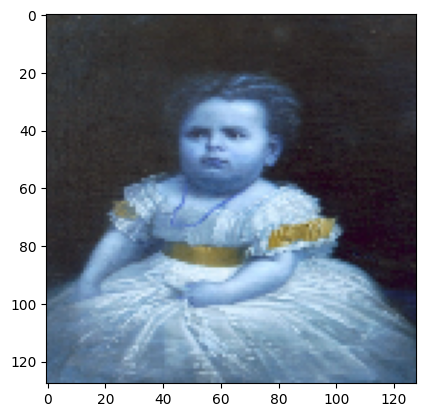

In [6]:
plt.imshow(cv2.cvtColor(data[0],cv2.COLOR_BGR2RGB))

In [7]:
data = np.array(data)
data = (data.astype(np.float32) - 127.5) / 127.5
data = data.reshape(-1, img_rows*img_cols*channels)


In [8]:
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape
from keras.layers import LeakyReLU
from keras.models import Sequential


def create_generator_cgan():
    generator = Sequential()

    d = 4
    generator.add(Dense(d*d*256, kernel_initializer=RandomNormal(0, 0.02), input_dim=noise_dim))
    generator.add(LeakyReLU(0.2))     #We are going to use the same leaky relu activation function as the FCGAN. It is typical schema

    generator.add(Reshape((d, d, 256)))

    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))
    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))
    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))
    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))



    generator.add(Conv2D(channels, (3, 3), padding='same', activation='tanh', kernel_initializer=RandomNormal(0, 0.02)))  #Remember that the final activation has to be tanh, since pixel values go from -1 to 1

    generator.compile(loss='binary_crossentropy', optimizer=optimizer)    #The loss doesn't change when you use convolutional layers
    return generator

In [9]:
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout
from keras.layers import LeakyReLU
from keras.models import Sequential

def create_discriminator_cgan():
    discriminator = Sequential()

    discriminator.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels)))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Conv2D(256, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Flatten())
    discriminator.add(Dropout(0.4))
    discriminator.add(Dense(1, activation='sigmoid', input_shape=(img_cols, img_rows, channels)))

    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) #Again, the loss doesn't change when creating a DCGAN.
    return discriminator

In [10]:
from keras.layers import Input
from keras.models import Model

discriminator = create_discriminator_cgan()
generator = create_generator_cgan()

discriminator.trainable = False

gan_input = Input(shape=(noise_dim,))

fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
#gan.compile(loss='binary_crossentropy', optimizer=optimizer)
gan.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


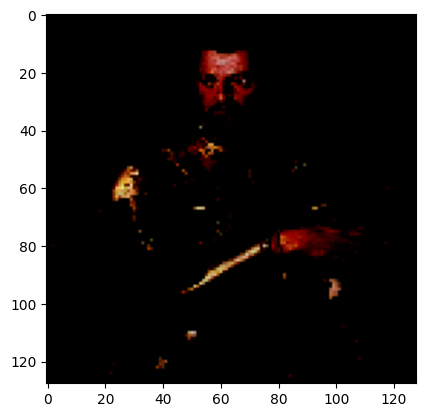

In [11]:
image = data[18]
plt.imshow(image.reshape((img_rows, img_cols,channels)), cmap='gray')

In [12]:
import matplotlib.pyplot as plt

def show_images(noise, size_fig):
    generated_images = generator.predict(noise)#Create the images from the GAN.
    #generated_images = (generated_images * 127.5) + 127.5
    plt.figure(figsize=size_fig)

    for i, image in enumerate(generated_images):
        plt.subplot(size_fig[0], size_fig[1], i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')    #If the image is grayscale, as in our case, then we will reshape the output in the following way.
                                                                            #Also, we set the coloring to grayscale so that it doesn't look like it came out of an infrared camera :)
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')

    plt.tight_layout()   #Tight layout so that all of the generated images form a nice grid
    plt.show()

  0%|          | 0/3000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 2s 2s/step


  0%|          | 1/3000 [00:15<12:49:44, 15.40s/it]

1/1 [==============================] - 0s 29ms/step


  0%|          | 2/3000 [00:15<5:26:34,  6.54s/it] 

1/1 [==============================] - 0s 29ms/step


  0%|          | 3/3000 [00:16<3:04:04,  3.69s/it]

1/1 [==============================] - 0s 37ms/step


  0%|          | 4/3000 [00:16<1:59:13,  2.39s/it]

1/1 [==============================] - 0s 40ms/step


  0%|          | 5/3000 [00:16<1:24:09,  1.69s/it]

1/1 [==============================] - 0s 37ms/step


  0%|          | 6/3000 [00:17<1:02:55,  1.26s/it]

1/1 [==============================] - 0s 48ms/step


  0%|          | 7/3000 [00:17<49:23,  1.01it/s]  

1/1 [==============================] - 0s 40ms/step


  0%|          | 8/3000 [00:18<40:49,  1.22it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 9/3000 [00:18<35:04,  1.42it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 10/3000 [00:19<31:08,  1.60it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 11/3000 [00:19<27:56,  1.78it/s]

1/1 [==============================] - 0s 49ms/step


  0%|          | 12/3000 [00:19<26:31,  1.88it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 13/3000 [00:20<24:17,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 14/3000 [00:20<21:24,  2.33it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 15/3000 [00:20<19:19,  2.57it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 16/3000 [00:21<17:42,  2.81it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 17/3000 [00:21<17:10,  2.90it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 18/3000 [00:21<16:38,  2.99it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 19/3000 [00:22<16:21,  3.04it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 20/3000 [00:22<16:08,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 21/3000 [00:22<15:31,  3.20it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 22/3000 [00:23<15:01,  3.30it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 23/3000 [00:23<14:44,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 24/3000 [00:23<14:39,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 25/3000 [00:23<14:29,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 26/3000 [00:24<14:21,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 27/3000 [00:24<14:15,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 28/3000 [00:24<14:13,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 29/3000 [00:25<14:11,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 30/3000 [00:25<14:07,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 31/3000 [00:25<14:36,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 32/3000 [00:25<14:24,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 33/3000 [00:26<14:13,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 34/3000 [00:26<14:42,  3.36it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 35/3000 [00:26<14:27,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 36/3000 [00:27<14:28,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 37/3000 [00:27<14:17,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 38/3000 [00:27<14:39,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 39/3000 [00:28<15:26,  3.20it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 40/3000 [00:28<14:58,  3.29it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 41/3000 [00:28<14:50,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 42/3000 [00:28<14:58,  3.29it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 43/3000 [00:29<14:38,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 44/3000 [00:29<14:55,  3.30it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 45/3000 [00:29<15:16,  3.22it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 46/3000 [00:30<16:50,  2.92it/s]

1/1 [==============================] - 0s 44ms/step


  2%|▏         | 47/3000 [00:30<18:22,  2.68it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 48/3000 [00:31<19:22,  2.54it/s]

1/1 [==============================] - 0s 48ms/step


  2%|▏         | 49/3000 [00:31<18:51,  2.61it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 50/3000 [00:31<18:31,  2.65it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 51/3000 [00:32<19:04,  2.58it/s]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 52/3000 [00:32<19:55,  2.47it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 53/3000 [00:33<20:00,  2.45it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 54/3000 [00:33<20:35,  2.39it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 55/3000 [00:34<21:01,  2.33it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 56/3000 [00:34<20:40,  2.37it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 57/3000 [00:34<19:21,  2.53it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 58/3000 [00:35<17:45,  2.76it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 59/3000 [00:35<16:40,  2.94it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 60/3000 [00:35<16:19,  3.00it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 61/3000 [00:36<16:04,  3.05it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 62/3000 [00:36<15:59,  3.06it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 63/3000 [00:36<15:50,  3.09it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 64/3000 [00:36<15:51,  3.08it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 65/3000 [00:37<15:46,  3.10it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 66/3000 [00:37<15:42,  3.11it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 67/3000 [00:37<15:44,  3.11it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 68/3000 [00:38<15:22,  3.18it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 69/3000 [00:38<15:02,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 70/3000 [00:38<15:08,  3.22it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 71/3000 [00:39<15:17,  3.19it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 72/3000 [00:39<15:15,  3.20it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 73/3000 [00:39<14:52,  3.28it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 74/3000 [00:40<15:00,  3.25it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▎         | 75/3000 [00:40<14:45,  3.30it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 76/3000 [00:40<14:27,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 77/3000 [00:40<14:22,  3.39it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 78/3000 [00:41<14:37,  3.33it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 79/3000 [00:41<14:55,  3.26it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 80/3000 [00:41<14:34,  3.34it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 81/3000 [00:42<14:49,  3.28it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 82/3000 [00:42<14:59,  3.24it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 83/3000 [00:42<14:38,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 84/3000 [00:43<14:26,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 85/3000 [00:43<14:45,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 86/3000 [00:43<14:57,  3.25it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 87/3000 [00:44<15:08,  3.21it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 88/3000 [00:44<15:11,  3.20it/s]

1/1 [==============================] - 0s 45ms/step


  3%|▎         | 89/3000 [00:44<16:11,  2.99it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 90/3000 [00:45<17:29,  2.77it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 91/3000 [00:45<18:17,  2.65it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 92/3000 [00:45<18:29,  2.62it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 93/3000 [00:46<18:43,  2.59it/s]

1/1 [==============================] - 0s 43ms/step


  3%|▎         | 94/3000 [00:46<19:19,  2.51it/s]

1/1 [==============================] - 0s 44ms/step


  3%|▎         | 95/3000 [00:47<19:56,  2.43it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 96/3000 [00:47<20:07,  2.40it/s]

1/1 [==============================] - 0s 43ms/step


  3%|▎         | 97/3000 [00:48<20:13,  2.39it/s]

1/1 [==============================] - 0s 55ms/step


  3%|▎         | 98/3000 [00:48<20:50,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 99/3000 [00:48<18:47,  2.57it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 100/3000 [00:49<17:50,  2.71it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 101/3000 [00:49<16:44,  2.89it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 102/3000 [00:49<15:52,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 103/3000 [00:50<15:39,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 104/3000 [00:50<15:36,  3.09it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 105/3000 [00:50<15:30,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 106/3000 [00:50<15:32,  3.10it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 107/3000 [00:51<15:32,  3.10it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 108/3000 [00:51<15:25,  3.12it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 109/3000 [00:51<15:22,  3.13it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 110/3000 [00:52<15:18,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 111/3000 [00:52<15:18,  3.14it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 112/3000 [00:52<14:52,  3.24it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 113/3000 [00:53<14:59,  3.21it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 114/3000 [00:53<15:31,  3.10it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 115/3000 [00:53<15:04,  3.19it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 116/3000 [00:54<15:04,  3.19it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 117/3000 [00:54<15:14,  3.15it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 118/3000 [00:54<15:14,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 119/3000 [00:55<14:47,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 120/3000 [00:55<14:31,  3.30it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 121/3000 [00:55<14:14,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 122/3000 [00:55<14:07,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 123/3000 [00:56<14:28,  3.31it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 124/3000 [00:56<14:42,  3.26it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 125/3000 [00:56<14:24,  3.33it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 126/3000 [00:57<15:35,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 127/3000 [00:57<15:30,  3.09it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 128/3000 [00:57<14:59,  3.19it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 129/3000 [00:58<15:04,  3.18it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 130/3000 [00:58<14:39,  3.26it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 131/3000 [00:58<15:57,  3.00it/s]

1/1 [==============================] - 0s 45ms/step


  4%|▍         | 132/3000 [00:59<17:30,  2.73it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 133/3000 [00:59<18:25,  2.59it/s]

1/1 [==============================] - 0s 61ms/step


  4%|▍         | 134/3000 [01:00<19:11,  2.49it/s]

1/1 [==============================] - 0s 58ms/step


  4%|▍         | 135/3000 [01:00<19:08,  2.49it/s]

1/1 [==============================] - 0s 88ms/step


  5%|▍         | 136/3000 [01:01<20:30,  2.33it/s]

1/1 [==============================] - 0s 75ms/step


  5%|▍         | 137/3000 [01:01<20:27,  2.33it/s]

1/1 [==============================] - 0s 60ms/step


  5%|▍         | 138/3000 [01:01<20:12,  2.36it/s]

1/1 [==============================] - 0s 72ms/step


  5%|▍         | 139/3000 [01:02<21:01,  2.27it/s]

1/1 [==============================] - 0s 69ms/step


  5%|▍         | 140/3000 [01:02<21:16,  2.24it/s]

1/1 [==============================] - 0s 85ms/step


  5%|▍         | 141/3000 [01:03<21:24,  2.23it/s]

1/1 [==============================] - 0s 79ms/step


  5%|▍         | 142/3000 [01:03<21:17,  2.24it/s]

1/1 [==============================] - 0s 57ms/step


  5%|▍         | 143/3000 [01:04<21:30,  2.21it/s]

1/1 [==============================] - 0s 63ms/step


  5%|▍         | 144/3000 [01:04<21:28,  2.22it/s]

1/1 [==============================] - 0s 66ms/step


  5%|▍         | 145/3000 [01:05<21:04,  2.26it/s]

1/1 [==============================] - 0s 44ms/step


  5%|▍         | 146/3000 [01:05<21:00,  2.26it/s]

1/1 [==============================] - 0s 43ms/step


  5%|▍         | 147/3000 [01:05<20:31,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 148/3000 [01:06<19:00,  2.50it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 149/3000 [01:06<17:24,  2.73it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 150/3000 [01:06<16:16,  2.92it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 151/3000 [01:07<15:57,  2.97it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 152/3000 [01:07<15:51,  2.99it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 153/3000 [01:07<15:41,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 154/3000 [01:08<15:32,  3.05it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 155/3000 [01:08<14:54,  3.18it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 156/3000 [01:08<14:58,  3.16it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 157/3000 [01:08<14:33,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 158/3000 [01:09<14:18,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 159/3000 [01:09<14:33,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 160/3000 [01:09<14:41,  3.22it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 161/3000 [01:10<14:54,  3.17it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 162/3000 [01:10<14:28,  3.27it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 163/3000 [01:10<14:39,  3.22it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 164/3000 [01:11<14:23,  3.28it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 165/3000 [01:11<14:36,  3.23it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 166/3000 [01:11<14:23,  3.28it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 167/3000 [01:12<14:36,  3.23it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 168/3000 [01:12<14:44,  3.20it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 169/3000 [01:12<14:47,  3.19it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 170/3000 [01:13<14:28,  3.26it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 171/3000 [01:13<14:42,  3.20it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 172/3000 [01:13<14:45,  3.20it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 173/3000 [01:13<14:24,  3.27it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 174/3000 [01:14<14:35,  3.23it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 175/3000 [01:14<14:45,  3.19it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 176/3000 [01:14<15:49,  2.98it/s]

1/1 [==============================] - 0s 44ms/step


  6%|▌         | 177/3000 [01:15<16:52,  2.79it/s]

1/1 [==============================] - 0s 54ms/step


  6%|▌         | 178/3000 [01:15<18:09,  2.59it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 179/3000 [01:16<18:42,  2.51it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 180/3000 [01:16<19:00,  2.47it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▌         | 181/3000 [01:17<19:20,  2.43it/s]

1/1 [==============================] - 0s 52ms/step


  6%|▌         | 182/3000 [01:17<19:39,  2.39it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 183/3000 [01:17<20:05,  2.34it/s]

1/1 [==============================] - 0s 42ms/step


  6%|▌         | 184/3000 [01:18<20:11,  2.32it/s]

1/1 [==============================] - 0s 44ms/step


  6%|▌         | 185/3000 [01:18<19:37,  2.39it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 186/3000 [01:19<19:36,  2.39it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 187/3000 [01:19<17:54,  2.62it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 188/3000 [01:19<17:01,  2.75it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 189/3000 [01:20<15:58,  2.93it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 190/3000 [01:20<16:36,  2.82it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 191/3000 [01:20<16:00,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 192/3000 [01:21<15:45,  2.97it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 193/3000 [01:21<16:23,  2.85it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 194/3000 [01:21<15:57,  2.93it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▋         | 195/3000 [01:22<15:23,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 196/3000 [01:22<14:48,  3.16it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 197/3000 [01:22<14:24,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 198/3000 [01:23<14:30,  3.22it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 199/3000 [01:23<14:15,  3.28it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 200/3000 [01:23<14:29,  3.22it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 201/3000 [01:23<14:12,  3.28it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 202/3000 [01:24<14:24,  3.24it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 203/3000 [01:24<14:06,  3.30it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 204/3000 [01:24<14:20,  3.25it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 205/3000 [01:25<14:22,  3.24it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 206/3000 [01:25<14:38,  3.18it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 207/3000 [01:25<14:18,  3.25it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 208/3000 [01:26<14:00,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 209/3000 [01:26<14:11,  3.28it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 210/3000 [01:26<14:02,  3.31it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 211/3000 [01:27<14:18,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 212/3000 [01:27<14:26,  3.22it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 213/3000 [01:27<14:33,  3.19it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 214/3000 [01:28<15:30,  3.00it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 215/3000 [01:28<15:56,  2.91it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 216/3000 [01:28<15:36,  2.97it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 217/3000 [01:29<15:19,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 218/3000 [01:29<16:38,  2.79it/s]

1/1 [==============================] - 0s 46ms/step


  7%|▋         | 219/3000 [01:29<17:57,  2.58it/s]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 220/3000 [01:30<18:33,  2.50it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 221/3000 [01:30<19:10,  2.42it/s]

1/1 [==============================] - 0s 43ms/step


  7%|▋         | 222/3000 [01:31<19:23,  2.39it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 223/3000 [01:31<19:25,  2.38it/s]

1/1 [==============================] - 0s 44ms/step


  7%|▋         | 224/3000 [01:32<19:29,  2.37it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 225/3000 [01:32<19:52,  2.33it/s]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 226/3000 [01:32<19:02,  2.43it/s]

1/1 [==============================] - 0s 45ms/step


  8%|▊         | 227/3000 [01:33<18:54,  2.44it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 228/3000 [01:33<17:12,  2.69it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 229/3000 [01:33<16:13,  2.85it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 230/3000 [01:34<15:48,  2.92it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 231/3000 [01:34<15:27,  2.98it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 232/3000 [01:34<16:14,  2.84it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 233/3000 [01:35<15:48,  2.92it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 234/3000 [01:35<15:29,  2.98it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 235/3000 [01:35<15:20,  3.00it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 236/3000 [01:36<15:04,  3.06it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 237/3000 [01:36<14:30,  3.17it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 238/3000 [01:36<14:36,  3.15it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 239/3000 [01:37<14:36,  3.15it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 240/3000 [01:37<14:12,  3.24it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 241/3000 [01:37<14:24,  3.19it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 242/3000 [01:38<14:17,  3.22it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 243/3000 [01:38<14:00,  3.28it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 244/3000 [01:38<13:44,  3.34it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 245/3000 [01:38<14:04,  3.26it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 246/3000 [01:39<14:19,  3.20it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 247/3000 [01:39<14:02,  3.27it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 248/3000 [01:39<14:11,  3.23it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 249/3000 [01:40<14:02,  3.27it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 250/3000 [01:40<14:12,  3.22it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 251/3000 [01:40<14:22,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 252/3000 [01:41<14:35,  3.14it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 253/3000 [01:41<14:33,  3.15it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 254/3000 [01:41<14:36,  3.13it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 255/3000 [01:42<14:17,  3.20it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 256/3000 [01:42<14:24,  3.17it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 257/3000 [01:42<14:28,  3.16it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▊         | 258/3000 [01:43<14:40,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 259/3000 [01:43<14:41,  3.11it/s]

1/1 [==============================] - 0s 44ms/step


  9%|▊         | 260/3000 [01:43<16:02,  2.85it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▊         | 261/3000 [01:44<16:07,  2.83it/s]

1/1 [==============================] - 0s 43ms/step


  9%|▊         | 262/3000 [01:44<17:20,  2.63it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 263/3000 [01:45<17:52,  2.55it/s]

1/1 [==============================] - 0s 47ms/step


  9%|▉         | 264/3000 [01:45<18:44,  2.43it/s]

1/1 [==============================] - 0s 43ms/step


  9%|▉         | 265/3000 [01:45<19:00,  2.40it/s]

1/1 [==============================] - 0s 50ms/step


  9%|▉         | 266/3000 [01:46<19:28,  2.34it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 267/3000 [01:46<19:31,  2.33it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▉         | 268/3000 [01:47<19:31,  2.33it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▉         | 269/3000 [01:47<18:57,  2.40it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 270/3000 [01:47<17:43,  2.57it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 271/3000 [01:48<16:48,  2.71it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 272/3000 [01:48<16:07,  2.82it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 273/3000 [01:48<15:16,  2.97it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 274/3000 [01:49<15:03,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 275/3000 [01:49<15:03,  3.02it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 276/3000 [01:49<14:50,  3.06it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 277/3000 [01:50<14:44,  3.08it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 278/3000 [01:50<14:45,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 279/3000 [01:50<14:42,  3.08it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 280/3000 [01:51<14:16,  3.18it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 281/3000 [01:51<14:23,  3.15it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 282/3000 [01:51<14:22,  3.15it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 283/3000 [01:52<14:26,  3.13it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 284/3000 [01:52<14:07,  3.20it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 285/3000 [01:52<13:52,  3.26it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 286/3000 [01:52<13:41,  3.30it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 287/3000 [01:53<17:05,  2.64it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 288/3000 [01:53<16:20,  2.77it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 289/3000 [01:54<15:23,  2.93it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 290/3000 [01:54<15:09,  2.98it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 291/3000 [01:54<14:56,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 292/3000 [01:55<14:46,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 293/3000 [01:55<14:45,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 294/3000 [01:55<14:15,  3.16it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 295/3000 [01:56<14:24,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 296/3000 [01:56<14:22,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 297/3000 [01:56<14:21,  3.14it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 298/3000 [01:56<14:02,  3.21it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 299/3000 [01:57<14:12,  3.17it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 300/3000 [01:57<14:55,  3.01it/s]

1/1 [==============================] - 0s 40ms/step


 10%|█         | 301/3000 [01:58<16:34,  2.71it/s]

1/1 [==============================] - 0s 40ms/step


 10%|█         | 302/3000 [01:58<17:17,  2.60it/s]

1/1 [==============================] - 0s 45ms/step


 10%|█         | 303/3000 [01:58<17:55,  2.51it/s]

1/1 [==============================] - 0s 44ms/step


 10%|█         | 304/3000 [01:59<18:16,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 305/3000 [01:59<18:42,  2.40it/s]

1/1 [==============================] - 0s 40ms/step


 10%|█         | 306/3000 [02:00<19:04,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 307/3000 [02:00<19:06,  2.35it/s]

1/1 [==============================] - 0s 46ms/step


 10%|█         | 308/3000 [02:01<19:29,  2.30it/s]

1/1 [==============================] - 0s 48ms/step


 10%|█         | 309/3000 [02:01<19:21,  2.32it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 310/3000 [02:01<17:56,  2.50it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 311/3000 [02:02<16:49,  2.66it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 312/3000 [02:02<16:06,  2.78it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 313/3000 [02:02<15:32,  2.88it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 314/3000 [02:03<15:12,  2.94it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 315/3000 [02:03<14:33,  3.07it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 316/3000 [02:03<14:38,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 317/3000 [02:04<14:11,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 318/3000 [02:04<13:50,  3.23it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 319/3000 [02:04<14:02,  3.18it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 320/3000 [02:05<14:08,  3.16it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 321/3000 [02:05<14:14,  3.14it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 322/3000 [02:05<15:07,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 323/3000 [02:06<14:49,  3.01it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 324/3000 [02:06<14:41,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 325/3000 [02:06<14:36,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 326/3000 [02:07<14:03,  3.17it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 327/3000 [02:07<14:05,  3.16it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 328/3000 [02:07<14:13,  3.13it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 329/3000 [02:07<13:48,  3.22it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 330/3000 [02:08<13:59,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 331/3000 [02:08<14:11,  3.14it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 332/3000 [02:08<13:55,  3.19it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 333/3000 [02:09<14:07,  3.15it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 334/3000 [02:09<14:09,  3.14it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 335/3000 [02:09<13:56,  3.18it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 336/3000 [02:10<13:59,  3.17it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 337/3000 [02:10<14:04,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 338/3000 [02:10<15:05,  2.94it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 339/3000 [02:11<14:25,  3.07it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 340/3000 [02:11<14:20,  3.09it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█▏        | 341/3000 [02:11<15:22,  2.88it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█▏        | 342/3000 [02:12<16:23,  2.70it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█▏        | 343/3000 [02:12<17:07,  2.59it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█▏        | 344/3000 [02:13<17:46,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 345/3000 [02:13<18:18,  2.42it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█▏        | 346/3000 [02:14<18:46,  2.36it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█▏        | 347/3000 [02:14<18:16,  2.42it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 348/3000 [02:14<18:28,  2.39it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 349/3000 [02:15<18:51,  2.34it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▏        | 350/3000 [02:15<19:11,  2.30it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 351/3000 [02:16<17:17,  2.55it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 352/3000 [02:16<16:00,  2.76it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 353/3000 [02:16<15:30,  2.85it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 354/3000 [02:16<14:44,  2.99it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 355/3000 [02:17<14:34,  3.02it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 356/3000 [02:17<14:06,  3.12it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 357/3000 [02:17<14:13,  3.10it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 358/3000 [02:18<13:55,  3.16it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 359/3000 [02:18<13:37,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 360/3000 [02:18<13:52,  3.17it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 361/3000 [02:19<13:56,  3.16it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 362/3000 [02:19<13:58,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 363/3000 [02:19<14:00,  3.14it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 364/3000 [02:20<14:54,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 365/3000 [02:20<14:42,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 366/3000 [02:20<14:32,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 367/3000 [02:21<14:21,  3.06it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 368/3000 [02:21<14:19,  3.06it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 369/3000 [02:21<14:14,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 370/3000 [02:22<14:14,  3.08it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 371/3000 [02:22<14:11,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 372/3000 [02:22<14:08,  3.10it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 373/3000 [02:23<14:15,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 374/3000 [02:23<14:12,  3.08it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▎        | 375/3000 [02:23<13:47,  3.17it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 376/3000 [02:24<13:30,  3.24it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 377/3000 [02:24<13:26,  3.25it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 378/3000 [02:24<13:16,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 379/3000 [02:24<13:29,  3.24it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 380/3000 [02:25<13:44,  3.18it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 381/3000 [02:25<13:48,  3.16it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 382/3000 [02:25<14:02,  3.11it/s]

1/1 [==============================] - 0s 43ms/step


 13%|█▎        | 383/3000 [02:26<14:57,  2.92it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 384/3000 [02:26<16:03,  2.71it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 385/3000 [02:27<16:52,  2.58it/s]

1/1 [==============================] - 0s 43ms/step


 13%|█▎        | 386/3000 [02:27<17:39,  2.47it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 387/3000 [02:28<17:52,  2.44it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 388/3000 [02:28<18:12,  2.39it/s]

1/1 [==============================] - 0s 51ms/step


 13%|█▎        | 389/3000 [02:28<18:10,  2.40it/s]

1/1 [==============================] - 0s 44ms/step


 13%|█▎        | 390/3000 [02:29<18:10,  2.39it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 391/3000 [02:29<18:15,  2.38it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 392/3000 [02:30<18:08,  2.40it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 393/3000 [02:30<16:49,  2.58it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 394/3000 [02:30<15:34,  2.79it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 395/3000 [02:31<15:06,  2.87it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 396/3000 [02:31<14:53,  2.91it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 397/3000 [02:31<14:35,  2.97it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 398/3000 [02:32<14:25,  3.01it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 399/3000 [02:32<14:39,  2.96it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 400/3000 [02:32<14:24,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 401/3000 [02:33<14:15,  3.04it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 402/3000 [02:33<13:46,  3.14it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 403/3000 [02:33<13:54,  3.11it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 404/3000 [02:33<13:39,  3.17it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 405/3000 [02:34<13:23,  3.23it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 406/3000 [02:34<13:13,  3.27it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▎        | 407/3000 [02:34<13:08,  3.29it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 408/3000 [02:35<13:17,  3.25it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 409/3000 [02:35<13:26,  3.21it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 410/3000 [02:35<13:10,  3.28it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 411/3000 [02:36<13:00,  3.32it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▎        | 412/3000 [02:36<13:19,  3.24it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 413/3000 [02:36<13:12,  3.26it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 414/3000 [02:37<13:22,  3.22it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 415/3000 [02:37<13:31,  3.19it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 416/3000 [02:37<13:38,  3.16it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 417/3000 [02:37<13:20,  3.23it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 418/3000 [02:38<13:27,  3.20it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 419/3000 [02:38<13:47,  3.12it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 420/3000 [02:38<13:49,  3.11it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 421/3000 [02:39<13:50,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 422/3000 [02:39<13:49,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 423/3000 [02:39<13:46,  3.12it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 424/3000 [02:40<14:49,  2.90it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 425/3000 [02:40<16:06,  2.66it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 426/3000 [02:41<16:46,  2.56it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 427/3000 [02:41<17:12,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 428/3000 [02:42<17:49,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 429/3000 [02:42<17:58,  2.38it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 430/3000 [02:42<18:27,  2.32it/s]

1/1 [==============================] - 0s 45ms/step


 14%|█▍        | 431/3000 [02:43<18:48,  2.28it/s]

1/1 [==============================] - 0s 42ms/step


 14%|█▍        | 432/3000 [02:43<18:36,  2.30it/s]

1/1 [==============================] - 0s 42ms/step


 14%|█▍        | 433/3000 [02:44<18:31,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 434/3000 [02:44<17:01,  2.51it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 435/3000 [02:44<16:05,  2.66it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 436/3000 [02:45<15:23,  2.78it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 437/3000 [02:45<14:53,  2.87it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 438/3000 [02:45<14:11,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 439/3000 [02:46<13:59,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 440/3000 [02:46<13:32,  3.15it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 441/3000 [02:46<13:12,  3.23it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 442/3000 [02:47<12:56,  3.30it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 443/3000 [02:47<12:51,  3.31it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 444/3000 [02:47<13:05,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 445/3000 [02:47<12:56,  3.29it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 446/3000 [02:48<12:47,  3.33it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 447/3000 [02:48<13:00,  3.27it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 448/3000 [02:48<13:17,  3.20it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 449/3000 [02:49<13:24,  3.17it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 450/3000 [02:49<13:12,  3.22it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 451/3000 [02:49<14:32,  2.92it/s]

1/1 [==============================] - 0s 53ms/step


 15%|█▌        | 452/3000 [02:50<15:59,  2.66it/s]

1/1 [==============================] - 0s 47ms/step


 15%|█▌        | 453/3000 [02:50<15:47,  2.69it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 454/3000 [02:51<15:05,  2.81it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 455/3000 [02:51<14:41,  2.89it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 456/3000 [02:51<14:21,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 457/3000 [02:52<14:12,  2.98it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 458/3000 [02:52<13:44,  3.08it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 459/3000 [02:52<13:41,  3.09it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 460/3000 [02:52<13:42,  3.09it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 461/3000 [02:53<13:19,  3.18it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 462/3000 [02:53<13:28,  3.14it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 463/3000 [02:53<13:52,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 464/3000 [02:54<14:41,  2.88it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 465/3000 [02:54<15:47,  2.67it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 466/3000 [02:55<16:47,  2.52it/s]

1/1 [==============================] - 0s 43ms/step


 16%|█▌        | 467/3000 [02:55<17:16,  2.44it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▌        | 468/3000 [02:56<17:20,  2.43it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 469/3000 [02:56<17:36,  2.40it/s]

1/1 [==============================] - 0s 45ms/step


 16%|█▌        | 470/3000 [02:56<17:17,  2.44it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 471/3000 [02:57<17:42,  2.38it/s]

1/1 [==============================] - 0s 47ms/step


 16%|█▌        | 472/3000 [02:57<18:13,  2.31it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 473/3000 [02:58<18:08,  2.32it/s]

1/1 [==============================] - 0s 46ms/step


 16%|█▌        | 474/3000 [02:58<17:06,  2.46it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 475/3000 [02:58<15:40,  2.68it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 476/3000 [02:59<14:36,  2.88it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 477/3000 [02:59<14:15,  2.95it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 478/3000 [02:59<13:39,  3.08it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 479/3000 [03:00<13:44,  3.06it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 480/3000 [03:00<13:42,  3.06it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 481/3000 [03:00<13:38,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 482/3000 [03:01<13:39,  3.07it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 483/3000 [03:01<13:44,  3.05it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 484/3000 [03:01<13:16,  3.16it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 485/3000 [03:02<13:21,  3.14it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 486/3000 [03:02<13:32,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 487/3000 [03:02<13:31,  3.10it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 488/3000 [03:03<13:26,  3.12it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 489/3000 [03:03<13:10,  3.18it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 490/3000 [03:03<12:50,  3.26it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▋        | 491/3000 [03:03<12:39,  3.31it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 492/3000 [03:04<13:17,  3.14it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▋        | 493/3000 [03:04<13:20,  3.13it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▋        | 494/3000 [03:04<13:09,  3.18it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 495/3000 [03:05<13:14,  3.15it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 496/3000 [03:05<13:23,  3.12it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 497/3000 [03:05<13:35,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 498/3000 [03:06<13:09,  3.17it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 499/3000 [03:06<13:16,  3.14it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 500/3000 [03:06<13:20,  3.12it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 501/3000 [03:07<13:18,  3.13it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 502/3000 [03:07<13:25,  3.10it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 503/3000 [03:07<13:25,  3.10it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 504/3000 [03:08<13:26,  3.10it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 505/3000 [03:08<14:44,  2.82it/s]

1/1 [==============================] - 0s 46ms/step


 17%|█▋        | 506/3000 [03:08<15:09,  2.74it/s]

1/1 [==============================] - 0s 47ms/step


 17%|█▋        | 507/3000 [03:09<16:10,  2.57it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 508/3000 [03:09<16:39,  2.49it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 509/3000 [03:10<17:16,  2.40it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 510/3000 [03:10<17:35,  2.36it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 511/3000 [03:11<17:18,  2.40it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 512/3000 [03:11<17:23,  2.38it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 513/3000 [03:11<17:32,  2.36it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 514/3000 [03:12<17:49,  2.32it/s]

1/1 [==============================] - 0s 52ms/step


 17%|█▋        | 515/3000 [03:12<17:44,  2.33it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 516/3000 [03:13<16:01,  2.58it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 517/3000 [03:13<14:53,  2.78it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 518/3000 [03:13<14:10,  2.92it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 519/3000 [03:14<13:55,  2.97it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 520/3000 [03:14<13:44,  3.01it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 521/3000 [03:14<13:43,  3.01it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 522/3000 [03:15<13:37,  3.03it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 523/3000 [03:15<13:09,  3.14it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 524/3000 [03:15<12:57,  3.19it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 525/3000 [03:15<13:04,  3.16it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 526/3000 [03:16<12:55,  3.19it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 527/3000 [03:16<12:41,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 528/3000 [03:16<12:57,  3.18it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 529/3000 [03:17<13:05,  3.15it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 530/3000 [03:17<12:50,  3.21it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 531/3000 [03:17<12:56,  3.18it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 532/3000 [03:18<13:01,  3.16it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 533/3000 [03:18<13:09,  3.12it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 534/3000 [03:18<13:16,  3.10it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 535/3000 [03:19<13:15,  3.10it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 536/3000 [03:19<12:59,  3.16it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 537/3000 [03:19<13:46,  2.98it/s]

1/1 [==============================] - 0s 96ms/step


 18%|█▊        | 538/3000 [03:20<19:27,  2.11it/s]

1/1 [==============================] - 0s 58ms/step


 18%|█▊        | 539/3000 [03:21<20:14,  2.03it/s]

1/1 [==============================] - 0s 53ms/step


 18%|█▊        | 540/3000 [03:21<22:16,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 541/3000 [03:22<20:54,  1.96it/s]

1/1 [==============================] - 0s 51ms/step


 18%|█▊        | 542/3000 [03:22<20:24,  2.01it/s]

1/1 [==============================] - 0s 61ms/step


 18%|█▊        | 543/3000 [03:23<22:51,  1.79it/s]

1/1 [==============================] - 0s 80ms/step


 18%|█▊        | 544/3000 [03:24<23:32,  1.74it/s]

1/1 [==============================] - 0s 93ms/step


 18%|█▊        | 545/3000 [03:24<22:40,  1.80it/s]

1/1 [==============================] - 0s 122ms/step


 18%|█▊        | 546/3000 [03:25<25:56,  1.58it/s]

1/1 [==============================] - 0s 233ms/step


 18%|█▊        | 547/3000 [03:26<32:28,  1.26it/s]

1/1 [==============================] - 0s 42ms/step


 18%|█▊        | 548/3000 [03:26<27:54,  1.46it/s]

1/1 [==============================] - 0s 60ms/step


 18%|█▊        | 549/3000 [03:27<25:09,  1.62it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 550/3000 [03:27<22:22,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 551/3000 [03:28<19:38,  2.08it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 552/3000 [03:28<17:43,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 553/3000 [03:28<16:01,  2.54it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 554/3000 [03:29<15:09,  2.69it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 555/3000 [03:29<14:38,  2.78it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 556/3000 [03:29<14:08,  2.88it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 557/3000 [03:30<13:48,  2.95it/s]

1/1 [==============================] - 0s 93ms/step


 19%|█▊        | 558/3000 [03:30<15:08,  2.69it/s]

1/1 [==============================] - 0s 86ms/step


 19%|█▊        | 559/3000 [03:31<17:40,  2.30it/s]

1/1 [==============================] - 0s 98ms/step


 19%|█▊        | 560/3000 [03:31<19:40,  2.07it/s]

1/1 [==============================] - 0s 77ms/step


 19%|█▊        | 561/3000 [03:32<21:50,  1.86it/s]

1/1 [==============================] - 0s 111ms/step


 19%|█▊        | 562/3000 [03:32<23:20,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 563/3000 [03:33<20:16,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 564/3000 [03:33<17:47,  2.28it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 565/3000 [03:33<16:00,  2.53it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 566/3000 [03:34<14:53,  2.72it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 567/3000 [03:34<14:27,  2.80it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 568/3000 [03:34<14:00,  2.90it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 569/3000 [03:35<13:44,  2.95it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 570/3000 [03:35<13:30,  3.00it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 571/3000 [03:35<12:59,  3.12it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 572/3000 [03:36<12:58,  3.12it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 573/3000 [03:36<13:47,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 574/3000 [03:36<13:39,  2.96it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 575/3000 [03:37<13:27,  3.00it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 576/3000 [03:37<13:44,  2.94it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 577/3000 [03:37<13:33,  2.98it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 578/3000 [03:38<14:47,  2.73it/s]

1/1 [==============================] - 0s 59ms/step


 19%|█▉        | 579/3000 [03:38<15:52,  2.54it/s]

1/1 [==============================] - 0s 46ms/step


 19%|█▉        | 580/3000 [03:39<16:27,  2.45it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▉        | 581/3000 [03:39<16:12,  2.49it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 582/3000 [03:39<16:33,  2.43it/s]

1/1 [==============================] - 0s 72ms/step


 19%|█▉        | 583/3000 [03:40<17:25,  2.31it/s]

1/1 [==============================] - 0s 66ms/step


 19%|█▉        | 584/3000 [03:40<17:49,  2.26it/s]

1/1 [==============================] - 0s 41ms/step


 20%|█▉        | 585/3000 [03:41<17:21,  2.32it/s]

1/1 [==============================] - 0s 72ms/step


 20%|█▉        | 586/3000 [03:41<18:15,  2.20it/s]

1/1 [==============================] - 0s 74ms/step


 20%|█▉        | 587/3000 [03:42<20:35,  1.95it/s]

1/1 [==============================] - 0s 62ms/step


 20%|█▉        | 588/3000 [03:42<19:34,  2.05it/s]

1/1 [==============================] - 0s 60ms/step


 20%|█▉        | 589/3000 [03:43<19:09,  2.10it/s]

1/1 [==============================] - 0s 56ms/step


 20%|█▉        | 590/3000 [03:43<19:00,  2.11it/s]

1/1 [==============================] - 0s 55ms/step


 20%|█▉        | 591/3000 [03:44<19:05,  2.10it/s]

1/1 [==============================] - 0s 42ms/step


 20%|█▉        | 592/3000 [03:44<18:55,  2.12it/s]

1/1 [==============================] - 0s 42ms/step


 20%|█▉        | 593/3000 [03:45<18:34,  2.16it/s]

1/1 [==============================] - 0s 38ms/step


 20%|█▉        | 594/3000 [03:45<17:23,  2.30it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 595/3000 [03:45<16:08,  2.48it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 596/3000 [03:46<14:48,  2.71it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 597/3000 [03:46<14:14,  2.81it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 598/3000 [03:46<13:56,  2.87it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 599/3000 [03:47<13:40,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 600/3000 [03:47<13:25,  2.98it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 601/3000 [03:47<13:17,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 602/3000 [03:48<12:48,  3.12it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 603/3000 [03:48<12:50,  3.11it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 604/3000 [03:48<12:50,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 605/3000 [03:49<12:52,  3.10it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 606/3000 [03:49<13:02,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 607/3000 [03:49<13:22,  2.98it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 608/3000 [03:50<13:16,  3.00it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 609/3000 [03:50<12:49,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 610/3000 [03:50<12:49,  3.11it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 611/3000 [03:51<12:51,  3.10it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 612/3000 [03:51<12:24,  3.21it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 613/3000 [03:51<12:30,  3.18it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 614/3000 [03:51<12:25,  3.20it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 615/3000 [03:52<12:13,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 616/3000 [03:52<12:28,  3.18it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 617/3000 [03:52<12:37,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 618/3000 [03:53<12:23,  3.20it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 619/3000 [03:53<12:14,  3.24it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 620/3000 [03:53<12:46,  3.10it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 621/3000 [03:54<13:08,  3.02it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██        | 622/3000 [03:54<13:56,  2.84it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 623/3000 [03:55<14:59,  2.64it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 624/3000 [03:55<15:34,  2.54it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 625/3000 [03:55<15:59,  2.48it/s]

1/1 [==============================] - 0s 49ms/step


 21%|██        | 626/3000 [03:56<16:41,  2.37it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██        | 627/3000 [03:56<16:59,  2.33it/s]

1/1 [==============================] - 0s 53ms/step


 21%|██        | 628/3000 [03:57<17:14,  2.29it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 629/3000 [03:57<17:08,  2.30it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██        | 630/3000 [03:58<17:10,  2.30it/s]

1/1 [==============================] - 0s 49ms/step


 21%|██        | 631/3000 [03:58<16:20,  2.42it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 632/3000 [03:58<14:52,  2.65it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 633/3000 [03:59<14:14,  2.77it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 634/3000 [03:59<13:48,  2.86it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 635/3000 [03:59<13:31,  2.92it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 636/3000 [04:00<13:15,  2.97it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 637/3000 [04:00<12:45,  3.09it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 638/3000 [04:00<12:44,  3.09it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 639/3000 [04:01<12:44,  3.09it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 640/3000 [04:01<12:48,  3.07it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██▏       | 641/3000 [04:01<12:59,  3.03it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 642/3000 [04:02<12:52,  3.05it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██▏       | 643/3000 [04:02<12:49,  3.06it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 644/3000 [04:02<12:45,  3.08it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 645/3000 [04:02<12:40,  3.10it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 646/3000 [04:03<12:18,  3.19it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 647/3000 [04:03<13:11,  2.97it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 648/3000 [04:03<12:59,  3.02it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 649/3000 [04:04<12:52,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 650/3000 [04:04<12:47,  3.06it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 651/3000 [04:04<13:03,  3.00it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 652/3000 [04:05<13:41,  2.86it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 653/3000 [04:05<13:30,  2.89it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 654/3000 [04:06<13:18,  2.94it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 655/3000 [04:06<13:07,  2.98it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 656/3000 [04:06<12:58,  3.01it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 657/3000 [04:06<12:31,  3.12it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 658/3000 [04:07<12:37,  3.09it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 659/3000 [04:07<12:37,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 660/3000 [04:07<12:41,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 661/3000 [04:08<12:44,  3.06it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 662/3000 [04:08<13:16,  2.94it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 663/3000 [04:09<14:16,  2.73it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 664/3000 [04:09<14:30,  2.68it/s]

1/1 [==============================] - 0s 46ms/step


 22%|██▏       | 665/3000 [04:09<15:20,  2.54it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 666/3000 [04:10<15:53,  2.45it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 667/3000 [04:10<16:15,  2.39it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 668/3000 [04:11<16:29,  2.36it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 669/3000 [04:11<16:15,  2.39it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 670/3000 [04:12<16:41,  2.33it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 671/3000 [04:12<16:47,  2.31it/s]

1/1 [==============================] - 0s 46ms/step


 22%|██▏       | 672/3000 [04:12<15:45,  2.46it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 673/3000 [04:13<14:47,  2.62it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 674/3000 [04:13<14:07,  2.75it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▎       | 675/3000 [04:13<13:38,  2.84it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 676/3000 [04:14<13:02,  2.97it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 677/3000 [04:14<13:10,  2.94it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 678/3000 [04:14<12:42,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 679/3000 [04:15<12:20,  3.13it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 680/3000 [04:15<12:23,  3.12it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 681/3000 [04:15<12:12,  3.17it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 682/3000 [04:16<12:20,  3.13it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 683/3000 [04:16<12:24,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 684/3000 [04:16<12:31,  3.08it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 685/3000 [04:17<12:37,  3.06it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 686/3000 [04:17<12:36,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 687/3000 [04:17<12:35,  3.06it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 688/3000 [04:18<12:14,  3.15it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 689/3000 [04:18<12:04,  3.19it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 690/3000 [04:18<12:12,  3.15it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 691/3000 [04:18<12:18,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 692/3000 [04:19<12:05,  3.18it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 693/3000 [04:19<12:36,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 694/3000 [04:19<12:14,  3.14it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 695/3000 [04:20<12:18,  3.12it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 696/3000 [04:20<12:25,  3.09it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 697/3000 [04:20<12:29,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 698/3000 [04:21<12:30,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 699/3000 [04:21<12:18,  3.12it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 700/3000 [04:21<12:23,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 701/3000 [04:22<12:05,  3.17it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 702/3000 [04:22<11:49,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 703/3000 [04:22<11:57,  3.20it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 704/3000 [04:23<13:30,  2.83it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▎       | 705/3000 [04:23<13:37,  2.81it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▎       | 706/3000 [04:24<14:39,  2.61it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▎       | 707/3000 [04:24<15:19,  2.49it/s]

1/1 [==============================] - 0s 45ms/step


 24%|██▎       | 708/3000 [04:24<15:52,  2.41it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▎       | 709/3000 [04:25<16:10,  2.36it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▎       | 710/3000 [04:25<16:30,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▎       | 711/3000 [04:26<16:23,  2.33it/s]

1/1 [==============================] - 0s 47ms/step


 24%|██▎       | 712/3000 [04:26<16:44,  2.28it/s]

1/1 [==============================] - 0s 50ms/step


 24%|██▍       | 713/3000 [04:27<16:59,  2.24it/s]

1/1 [==============================] - 0s 52ms/step


 24%|██▍       | 714/3000 [04:27<16:25,  2.32it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 715/3000 [04:27<15:21,  2.48it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 716/3000 [04:28<14:25,  2.64it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 717/3000 [04:28<13:44,  2.77it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 718/3000 [04:28<13:21,  2.85it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 719/3000 [04:29<12:51,  2.96it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 720/3000 [04:29<12:41,  2.99it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 721/3000 [04:29<12:35,  3.02it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 722/3000 [04:30<12:29,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 723/3000 [04:30<12:12,  3.11it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 724/3000 [04:30<13:03,  2.91it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 725/3000 [04:31<12:35,  3.01it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 726/3000 [04:31<12:18,  3.08it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 727/3000 [04:31<13:04,  2.90it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 728/3000 [04:32<12:54,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 729/3000 [04:32<12:27,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 730/3000 [04:32<12:24,  3.05it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 731/3000 [04:33<13:07,  2.88it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 732/3000 [04:33<12:55,  2.92it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 733/3000 [04:33<12:42,  2.97it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 734/3000 [04:34<12:35,  3.00it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 735/3000 [04:34<12:27,  3.03it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 736/3000 [04:34<12:49,  2.94it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 737/3000 [04:35<12:31,  3.01it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 738/3000 [04:35<12:28,  3.02it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 739/3000 [04:35<12:30,  3.01it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 740/3000 [04:36<12:27,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 741/3000 [04:36<12:24,  3.03it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 742/3000 [04:36<12:03,  3.12it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 743/3000 [04:37<12:23,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 744/3000 [04:37<13:27,  2.79it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▍       | 745/3000 [04:38<14:23,  2.61it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▍       | 746/3000 [04:38<14:22,  2.61it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▍       | 747/3000 [04:38<15:10,  2.47it/s]

1/1 [==============================] - 0s 45ms/step


 25%|██▍       | 748/3000 [04:39<15:35,  2.41it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▍       | 749/3000 [04:39<15:12,  2.47it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▌       | 750/3000 [04:40<15:35,  2.40it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 751/3000 [04:40<14:58,  2.50it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 752/3000 [04:40<15:32,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 753/3000 [04:41<15:07,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 754/3000 [04:41<14:45,  2.54it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 755/3000 [04:42<14:03,  2.66it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 756/3000 [04:42<13:10,  2.84it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 757/3000 [04:42<12:56,  2.89it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 758/3000 [04:42<12:42,  2.94it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 759/3000 [04:43<12:11,  3.06it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 760/3000 [04:43<12:13,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 761/3000 [04:43<12:09,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 762/3000 [04:44<12:11,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 763/3000 [04:44<11:50,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 764/3000 [04:44<11:35,  3.22it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 765/3000 [04:45<12:23,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 766/3000 [04:45<11:58,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 767/3000 [04:45<11:57,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 768/3000 [04:46<12:01,  3.09it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 769/3000 [04:46<12:18,  3.02it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 770/3000 [04:46<12:16,  3.03it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 771/3000 [04:47<12:21,  3.01it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 772/3000 [04:47<12:37,  2.94it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 773/3000 [04:47<12:06,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 774/3000 [04:48<11:45,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 775/3000 [04:48<11:30,  3.22it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 776/3000 [04:48<11:40,  3.17it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 777/3000 [04:49<11:50,  3.13it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 778/3000 [04:49<11:54,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 779/3000 [04:49<12:06,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 780/3000 [04:50<11:46,  3.14it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 781/3000 [04:50<11:30,  3.21it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 782/3000 [04:50<11:38,  3.18it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 783/3000 [04:50<11:41,  3.16it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 784/3000 [04:51<11:45,  3.14it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 785/3000 [04:51<11:31,  3.20it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 786/3000 [04:52<12:53,  2.86it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 787/3000 [04:52<13:55,  2.65it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▋       | 788/3000 [04:52<14:25,  2.55it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▋       | 789/3000 [04:53<14:42,  2.51it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▋       | 790/3000 [04:53<15:15,  2.42it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▋       | 791/3000 [04:54<15:40,  2.35it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██▋       | 792/3000 [04:54<15:53,  2.32it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▋       | 793/3000 [04:55<15:53,  2.31it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▋       | 794/3000 [04:55<16:06,  2.28it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▋       | 795/3000 [04:55<15:49,  2.32it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 796/3000 [04:56<14:37,  2.51it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 797/3000 [04:56<13:48,  2.66it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 798/3000 [04:56<13:13,  2.78it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 799/3000 [04:57<12:45,  2.88it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 800/3000 [04:57<12:53,  2.84it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 801/3000 [04:57<12:50,  2.86it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 802/3000 [04:58<12:35,  2.91it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 803/3000 [04:58<13:03,  2.80it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 804/3000 [04:59<12:43,  2.88it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 805/3000 [04:59<12:29,  2.93it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 806/3000 [04:59<12:15,  2.98it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 807/3000 [05:00<12:25,  2.94it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 808/3000 [05:00<11:55,  3.06it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 809/3000 [05:00<11:54,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 810/3000 [05:00<11:53,  3.07it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 811/3000 [05:01<11:53,  3.07it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 812/3000 [05:01<11:50,  3.08it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 813/3000 [05:01<11:30,  3.17it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 814/3000 [05:02<11:35,  3.14it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 815/3000 [05:02<11:17,  3.23it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 816/3000 [05:02<11:22,  3.20it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 817/3000 [05:03<11:15,  3.23it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 818/3000 [05:03<11:04,  3.28it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 819/3000 [05:03<10:57,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 820/3000 [05:04<11:11,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 821/3000 [05:04<11:27,  3.17it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 822/3000 [05:04<11:33,  3.14it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 823/3000 [05:05<11:37,  3.12it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 824/3000 [05:05<11:31,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 825/3000 [05:05<11:33,  3.14it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 826/3000 [05:06<12:39,  2.86it/s]

1/1 [==============================] - 0s 57ms/step


 28%|██▊       | 827/3000 [05:06<13:56,  2.60it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 828/3000 [05:06<14:26,  2.51it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 829/3000 [05:07<14:09,  2.55it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 830/3000 [05:07<14:29,  2.50it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 831/3000 [05:08<14:49,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 832/3000 [05:08<15:13,  2.37it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 833/3000 [05:09<15:23,  2.35it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 834/3000 [05:09<14:47,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 835/3000 [05:09<14:53,  2.42it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 836/3000 [05:10<14:52,  2.42it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 837/3000 [05:10<14:01,  2.57it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 838/3000 [05:10<13:10,  2.74it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 839/3000 [05:11<12:25,  2.90it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 840/3000 [05:11<12:01,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 841/3000 [05:11<11:53,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 842/3000 [05:12<11:50,  3.04it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 843/3000 [05:12<11:47,  3.05it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 844/3000 [05:12<11:35,  3.10it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 845/3000 [05:13<11:39,  3.08it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 846/3000 [05:13<11:28,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 847/3000 [05:13<11:35,  3.09it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 848/3000 [05:14<11:22,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 849/3000 [05:14<11:09,  3.21it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 850/3000 [05:14<11:26,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 851/3000 [05:15<11:27,  3.12it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 852/3000 [05:15<11:16,  3.18it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 853/3000 [05:15<11:20,  3.16it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 854/3000 [05:16<11:25,  3.13it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 855/3000 [05:16<11:09,  3.21it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 856/3000 [05:16<11:25,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 857/3000 [05:16<11:31,  3.10it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▊       | 858/3000 [05:17<11:24,  3.13it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 859/3000 [05:17<12:12,  2.92it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▊       | 860/3000 [05:17<11:50,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 861/3000 [05:18<13:49,  2.58it/s]

1/1 [==============================] - 0s 125ms/step


 29%|██▊       | 862/3000 [05:19<15:28,  2.30it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 863/3000 [05:19<14:22,  2.48it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 864/3000 [05:19<13:35,  2.62it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 865/3000 [05:20<13:00,  2.74it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 866/3000 [05:20<13:23,  2.66it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 867/3000 [05:20<14:18,  2.48it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 868/3000 [05:21<14:33,  2.44it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 869/3000 [05:21<14:58,  2.37it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 870/3000 [05:22<14:54,  2.38it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 871/3000 [05:22<14:39,  2.42it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██▉       | 872/3000 [05:23<14:55,  2.38it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 873/3000 [05:23<14:54,  2.38it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 874/3000 [05:23<15:13,  2.33it/s]

1/1 [==============================] - 0s 45ms/step


 29%|██▉       | 875/3000 [05:24<15:19,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 876/3000 [05:24<14:21,  2.46it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 877/3000 [05:24<13:19,  2.65it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 878/3000 [05:25<12:45,  2.77it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 879/3000 [05:25<12:04,  2.93it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 880/3000 [05:25<11:58,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 881/3000 [05:26<11:34,  3.05it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 882/3000 [05:26<11:33,  3.05it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 883/3000 [05:26<11:36,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 884/3000 [05:27<11:33,  3.05it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 885/3000 [05:27<11:29,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 886/3000 [05:27<11:12,  3.14it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 887/3000 [05:28<11:10,  3.15it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 888/3000 [05:28<11:12,  3.14it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 889/3000 [05:28<11:01,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 890/3000 [05:29<11:11,  3.14it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 891/3000 [05:29<10:56,  3.21it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 892/3000 [05:29<10:46,  3.26it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 893/3000 [05:30<10:40,  3.29it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 894/3000 [05:30<10:58,  3.20it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 895/3000 [05:30<10:48,  3.25it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 896/3000 [05:30<11:00,  3.19it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 897/3000 [05:31<10:50,  3.23it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 898/3000 [05:31<10:41,  3.28it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 899/3000 [05:31<10:55,  3.20it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 900/3000 [05:32<11:07,  3.14it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 901/3000 [05:32<11:12,  3.12it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 902/3000 [05:32<11:16,  3.10it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 903/3000 [05:33<11:19,  3.08it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 904/3000 [05:33<11:03,  3.16it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 905/3000 [05:33<10:50,  3.22it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 906/3000 [05:34<10:57,  3.18it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 907/3000 [05:34<11:22,  3.06it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 908/3000 [05:34<12:23,  2.81it/s]

1/1 [==============================] - 0s 53ms/step


 30%|███       | 909/3000 [05:35<13:21,  2.61it/s]

1/1 [==============================] - 0s 43ms/step


 30%|███       | 910/3000 [05:35<13:57,  2.49it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 911/3000 [05:36<14:19,  2.43it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 912/3000 [05:36<14:39,  2.37it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 913/3000 [05:37<14:44,  2.36it/s]

1/1 [==============================] - 0s 45ms/step


 30%|███       | 914/3000 [05:37<15:04,  2.31it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 915/3000 [05:37<15:01,  2.31it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 916/3000 [05:38<15:11,  2.29it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███       | 917/3000 [05:38<15:04,  2.30it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 918/3000 [05:39<13:56,  2.49it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 919/3000 [05:39<13:18,  2.61it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 920/3000 [05:39<12:43,  2.73it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 921/3000 [05:40<12:17,  2.82it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 922/3000 [05:40<11:45,  2.94it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 923/3000 [05:40<11:34,  2.99it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 924/3000 [05:41<11:43,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 925/3000 [05:41<11:22,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 926/3000 [05:41<11:05,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 927/3000 [05:42<11:06,  3.11it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 928/3000 [05:42<11:59,  2.88it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 929/3000 [05:42<11:33,  2.98it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 930/3000 [05:43<11:13,  3.07it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 931/3000 [05:43<11:06,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 932/3000 [05:43<11:06,  3.10it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 933/3000 [05:44<11:08,  3.09it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 934/3000 [05:44<11:09,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 935/3000 [05:44<10:54,  3.15it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 936/3000 [05:44<10:39,  3.23it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 937/3000 [05:45<10:50,  3.17it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███▏      | 938/3000 [05:45<11:00,  3.12it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 939/3000 [05:45<11:03,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 940/3000 [05:46<11:05,  3.10it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 941/3000 [05:46<11:09,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 942/3000 [05:46<10:51,  3.16it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 943/3000 [05:47<10:40,  3.21it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 944/3000 [05:47<11:28,  2.99it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 945/3000 [05:47<11:20,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 946/3000 [05:48<11:14,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 947/3000 [05:48<10:55,  3.13it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 948/3000 [05:48<12:03,  2.83it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 949/3000 [05:49<12:57,  2.64it/s]

1/1 [==============================] - 0s 50ms/step


 32%|███▏      | 950/3000 [05:49<13:33,  2.52it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 951/3000 [05:50<13:59,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 952/3000 [05:50<13:55,  2.45it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 953/3000 [05:51<14:07,  2.42it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 954/3000 [05:51<14:34,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 955/3000 [05:52<14:29,  2.35it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 956/3000 [05:52<14:29,  2.35it/s]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 957/3000 [05:52<14:59,  2.27it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 958/3000 [05:53<13:50,  2.46it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 959/3000 [05:53<13:00,  2.62it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 960/3000 [05:53<12:30,  2.72it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 961/3000 [05:54<12:07,  2.80it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 962/3000 [05:54<11:51,  2.87it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 963/3000 [05:54<11:39,  2.91it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 964/3000 [05:55<11:44,  2.89it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 965/3000 [05:55<11:31,  2.94it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 966/3000 [05:55<11:21,  2.98it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 967/3000 [05:56<11:31,  2.94it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 968/3000 [05:56<11:24,  2.97it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 969/3000 [05:56<11:03,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 970/3000 [05:57<11:05,  3.05it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 971/3000 [05:57<11:05,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 972/3000 [05:57<11:07,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 973/3000 [05:58<10:55,  3.09it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 974/3000 [05:58<10:58,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▎      | 975/3000 [05:58<10:56,  3.08it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 976/3000 [05:59<10:38,  3.17it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 977/3000 [05:59<10:48,  3.12it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 978/3000 [05:59<10:33,  3.19it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 979/3000 [06:00<10:45,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 980/3000 [06:00<10:54,  3.09it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 981/3000 [06:00<10:39,  3.16it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 982/3000 [06:01<10:32,  3.19it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 983/3000 [06:01<10:38,  3.16it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 984/3000 [06:01<10:45,  3.12it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 985/3000 [06:02<10:51,  3.09it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 986/3000 [06:02<10:36,  3.16it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 987/3000 [06:02<10:28,  3.21it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 988/3000 [06:03<11:37,  2.89it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 989/3000 [06:03<12:27,  2.69it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 990/3000 [06:03<12:59,  2.58it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 991/3000 [06:04<13:29,  2.48it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 992/3000 [06:04<13:42,  2.44it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 993/3000 [06:05<14:13,  2.35it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 994/3000 [06:05<14:24,  2.32it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 995/3000 [06:06<14:40,  2.28it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 996/3000 [06:06<14:38,  2.28it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 997/3000 [06:07<14:52,  2.24it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 998/3000 [06:07<14:35,  2.29it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 999/3000 [06:07<13:12,  2.52it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 1000/3000 [06:08<12:49,  2.60it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1001/3000 [06:08<12:15,  2.72it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 1002/3000 [06:08<11:35,  2.87it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 1003/3000 [06:09<11:21,  2.93it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1004/3000 [06:09<11:15,  2.96it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 1005/3000 [06:09<11:06,  2.99it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 1006/3000 [06:10<10:42,  3.10it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 1007/3000 [06:10<10:25,  3.18it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 1008/3000 [06:10<10:32,  3.15it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▎      | 1009/3000 [06:10<10:37,  3.12it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 1010/3000 [06:11<11:20,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 1011/3000 [06:11<11:12,  2.96it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 1012/3000 [06:12<11:05,  2.99it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 1013/3000 [06:12<10:45,  3.08it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 1014/3000 [06:12<10:49,  3.06it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 1015/3000 [06:12<10:49,  3.06it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 1016/3000 [06:13<11:36,  2.85it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 1017/3000 [06:13<11:26,  2.89it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 1018/3000 [06:14<11:16,  2.93it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 1019/3000 [06:14<11:33,  2.86it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 1020/3000 [06:14<11:06,  2.97it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 1021/3000 [06:15<11:01,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 1022/3000 [06:15<10:45,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 1023/3000 [06:15<10:28,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 1024/3000 [06:15<10:35,  3.11it/s]

1/1 [==============================] - 0s 66ms/step


 34%|███▍      | 1025/3000 [06:16<13:14,  2.49it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 1026/3000 [06:16<13:06,  2.51it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 1027/3000 [06:17<15:21,  2.14it/s]

1/1 [==============================] - 0s 124ms/step


 34%|███▍      | 1028/3000 [06:18<18:00,  1.82it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 1029/3000 [06:18<17:10,  1.91it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 1030/3000 [06:19<16:20,  2.01it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 1031/3000 [06:19<15:54,  2.06it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 1032/3000 [06:20<14:45,  2.22it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 1033/3000 [06:20<16:28,  1.99it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 1034/3000 [06:21<15:33,  2.11it/s]

1/1 [==============================] - 0s 69ms/step


 34%|███▍      | 1035/3000 [06:21<15:10,  2.16it/s]

1/1 [==============================] - 0s 52ms/step


 35%|███▍      | 1036/3000 [06:21<14:27,  2.26it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 1037/3000 [06:22<14:04,  2.32it/s]

1/1 [==============================] - 0s 65ms/step


 35%|███▍      | 1038/3000 [06:22<14:23,  2.27it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▍      | 1039/3000 [06:23<14:27,  2.26it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 1040/3000 [06:23<14:21,  2.27it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▍      | 1041/3000 [06:24<13:57,  2.34it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 1042/3000 [06:24<14:10,  2.30it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 1043/3000 [06:24<14:08,  2.31it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 1044/3000 [06:25<14:02,  2.32it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 1045/3000 [06:25<13:16,  2.46it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 1046/3000 [06:26<12:26,  2.62it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 1047/3000 [06:26<11:37,  2.80it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 1048/3000 [06:26<11:19,  2.87it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 1049/3000 [06:27<11:14,  2.89it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 1050/3000 [06:27<11:01,  2.95it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 1051/3000 [06:27<10:39,  3.05it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 1052/3000 [06:27<10:40,  3.04it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 1053/3000 [06:28<10:29,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 1054/3000 [06:28<10:14,  3.17it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 1055/3000 [06:28<10:23,  3.12it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 1056/3000 [06:29<10:26,  3.11it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 1057/3000 [06:29<10:38,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 1058/3000 [06:29<10:38,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 1059/3000 [06:30<10:38,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 1060/3000 [06:30<10:34,  3.06it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 1061/3000 [06:30<10:39,  3.03it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 1062/3000 [06:31<10:34,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 1063/3000 [06:31<10:18,  3.13it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 1064/3000 [06:31<10:35,  3.05it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 1065/3000 [06:32<10:34,  3.05it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 1066/3000 [06:32<10:21,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 1067/3000 [06:32<10:09,  3.17it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 1068/3000 [06:33<11:14,  2.86it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 1069/3000 [06:33<12:09,  2.65it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 1070/3000 [06:34<12:46,  2.52it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▌      | 1071/3000 [06:34<13:20,  2.41it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 1072/3000 [06:35<13:39,  2.35it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▌      | 1073/3000 [06:35<13:54,  2.31it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 1074/3000 [06:35<14:07,  2.27it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 1075/3000 [06:36<14:11,  2.26it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 1076/3000 [06:36<14:08,  2.27it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 1077/3000 [06:37<13:24,  2.39it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 1078/3000 [06:37<12:29,  2.56it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 1079/3000 [06:37<11:37,  2.75it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 1080/3000 [06:38<11:03,  2.89it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 1081/3000 [06:38<10:36,  3.01it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 1082/3000 [06:38<10:19,  3.09it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 1083/3000 [06:39<10:21,  3.08it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 1084/3000 [06:39<10:27,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 1085/3000 [06:39<10:28,  3.05it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 1086/3000 [06:39<10:09,  3.14it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 1087/3000 [06:40<10:13,  3.12it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 1088/3000 [06:40<10:20,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 1089/3000 [06:40<10:06,  3.15it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 1090/3000 [06:41<10:50,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 1091/3000 [06:41<10:44,  2.96it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 1092/3000 [06:42<11:00,  2.89it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 1093/3000 [06:42<10:46,  2.95it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 1094/3000 [06:42<10:20,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 1095/3000 [06:42<10:20,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1096/3000 [06:43<10:23,  3.05it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 1097/3000 [06:43<10:33,  3.00it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1098/3000 [06:43<10:16,  3.08it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 1099/3000 [06:44<10:04,  3.15it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1100/3000 [06:44<10:07,  3.13it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1101/3000 [06:44<10:10,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1102/3000 [06:45<10:11,  3.10it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1103/3000 [06:45<10:17,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1104/3000 [06:45<10:14,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 1105/3000 [06:46<10:14,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 1106/3000 [06:46<10:19,  3.06it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1107/3000 [06:46<10:18,  3.06it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1108/3000 [06:47<10:16,  3.07it/s]

1/1 [==============================] - 0s 50ms/step


 37%|███▋      | 1109/3000 [06:47<10:46,  2.92it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 1110/3000 [06:48<11:44,  2.68it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 1111/3000 [06:48<12:28,  2.52it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 1112/3000 [06:48<11:59,  2.62it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 1113/3000 [06:49<12:16,  2.56it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 1114/3000 [06:49<12:38,  2.49it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 1115/3000 [06:50<12:54,  2.43it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 1116/3000 [06:50<13:16,  2.37it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 1117/3000 [06:50<13:26,  2.34it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 1118/3000 [06:51<12:50,  2.44it/s]

1/1 [==============================] - 0s 53ms/step


 37%|███▋      | 1119/3000 [06:51<12:55,  2.43it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1120/3000 [06:52<12:07,  2.58it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 1121/3000 [06:52<11:20,  2.76it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 1122/3000 [06:52<10:59,  2.85it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1123/3000 [06:53<10:32,  2.97it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1124/3000 [06:53<10:25,  3.00it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1125/3000 [06:53<10:24,  3.00it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1126/3000 [06:54<10:07,  3.09it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 1127/3000 [06:54<09:54,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1128/3000 [06:54<09:59,  3.12it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 1129/3000 [06:54<09:52,  3.16it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1130/3000 [06:55<09:56,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1131/3000 [06:55<10:37,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1132/3000 [06:55<10:31,  2.96it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 1133/3000 [06:56<10:24,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1134/3000 [06:56<10:10,  3.06it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 1135/3000 [06:56<10:10,  3.05it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 1136/3000 [06:57<10:09,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1137/3000 [06:57<10:07,  3.06it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1138/3000 [06:57<10:14,  3.03it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1139/3000 [06:58<10:13,  3.03it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1140/3000 [06:58<10:00,  3.10it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 1141/3000 [06:58<10:00,  3.10it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 1142/3000 [06:59<09:50,  3.15it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 1143/3000 [06:59<09:41,  3.19it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1144/3000 [06:59<09:48,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1145/3000 [07:00<09:40,  3.20it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1146/3000 [07:00<09:46,  3.16it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 1147/3000 [07:00<09:53,  3.12it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1148/3000 [07:01<09:55,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 1149/3000 [07:01<09:48,  3.15it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1150/3000 [07:01<10:11,  3.03it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 1151/3000 [07:02<11:11,  2.75it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 1152/3000 [07:02<11:20,  2.71it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 1153/3000 [07:02<11:13,  2.74it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 1154/3000 [07:03<11:47,  2.61it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 1155/3000 [07:03<11:46,  2.61it/s]

1/1 [==============================] - 0s 52ms/step


 39%|███▊      | 1156/3000 [07:04<12:00,  2.56it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▊      | 1157/3000 [07:04<12:21,  2.49it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▊      | 1158/3000 [07:05<12:51,  2.39it/s]

1/1 [==============================] - 0s 50ms/step


 39%|███▊      | 1159/3000 [07:05<13:17,  2.31it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▊      | 1160/3000 [07:05<13:34,  2.26it/s]

1/1 [==============================] - 0s 49ms/step


 39%|███▊      | 1161/3000 [07:06<12:43,  2.41it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 1162/3000 [07:06<11:52,  2.58it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1163/3000 [07:07<11:40,  2.62it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 1164/3000 [07:07<11:10,  2.74it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1165/3000 [07:07<10:50,  2.82it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 1166/3000 [07:08<10:36,  2.88it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1167/3000 [07:08<10:25,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1168/3000 [07:08<10:16,  2.97it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1169/3000 [07:09<10:24,  2.93it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1170/3000 [07:09<10:17,  2.96it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1171/3000 [07:09<09:55,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1172/3000 [07:09<09:55,  3.07it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 1173/3000 [07:10<10:01,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1174/3000 [07:10<09:59,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1175/3000 [07:10<09:47,  3.10it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1176/3000 [07:11<09:53,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1177/3000 [07:11<09:55,  3.06it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 1178/3000 [07:11<09:52,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1179/3000 [07:12<09:52,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1180/3000 [07:12<09:42,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1181/3000 [07:13<12:13,  2.48it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1182/3000 [07:13<11:18,  2.68it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1183/3000 [07:13<10:41,  2.83it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 1184/3000 [07:14<10:39,  2.84it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 1185/3000 [07:14<10:19,  2.93it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 1186/3000 [07:14<10:13,  2.96it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 1187/3000 [07:15<10:11,  2.96it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 1188/3000 [07:15<10:09,  2.97it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 1189/3000 [07:15<10:08,  2.98it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 1190/3000 [07:16<10:02,  3.00it/s]

1/1 [==============================] - 0s 48ms/step


 40%|███▉      | 1191/3000 [07:16<10:22,  2.90it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███▉      | 1192/3000 [07:16<11:20,  2.66it/s]

1/1 [==============================] - 0s 46ms/step


 40%|███▉      | 1193/3000 [07:17<12:07,  2.48it/s]

1/1 [==============================] - 0s 41ms/step


 40%|███▉      | 1194/3000 [07:17<12:37,  2.38it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███▉      | 1195/3000 [07:18<12:15,  2.45it/s]

1/1 [==============================] - 0s 54ms/step


 40%|███▉      | 1196/3000 [07:18<12:50,  2.34it/s]

1/1 [==============================] - 0s 43ms/step


 40%|███▉      | 1197/3000 [07:19<12:59,  2.31it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 1198/3000 [07:19<12:56,  2.32it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 1199/3000 [07:20<12:58,  2.31it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 1200/3000 [07:20<12:58,  2.31it/s]

1/1 [==============================] - 0s 43ms/step


 40%|████      | 1201/3000 [07:20<12:13,  2.45it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 1202/3000 [07:21<11:32,  2.60it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 1203/3000 [07:21<10:48,  2.77it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 1204/3000 [07:21<10:31,  2.85it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 1205/3000 [07:22<10:16,  2.91it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 1206/3000 [07:22<09:54,  3.02it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 1207/3000 [07:22<09:43,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 1208/3000 [07:23<09:30,  3.14it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 1209/3000 [07:23<09:41,  3.08it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 1210/3000 [07:23<09:44,  3.06it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 1211/3000 [07:24<09:47,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 1212/3000 [07:24<09:36,  3.10it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 1213/3000 [07:24<09:43,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 1214/3000 [07:24<09:43,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 1215/3000 [07:25<09:28,  3.14it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 1216/3000 [07:25<09:36,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 1217/3000 [07:25<09:26,  3.15it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 1218/3000 [07:26<09:20,  3.18it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 1219/3000 [07:26<09:12,  3.22it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 1220/3000 [07:26<09:19,  3.18it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 1221/3000 [07:27<09:12,  3.22it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 1222/3000 [07:27<09:20,  3.17it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 1223/3000 [07:27<09:29,  3.12it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 1224/3000 [07:28<09:32,  3.10it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 1225/3000 [07:28<09:24,  3.14it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 1226/3000 [07:28<09:35,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 1227/3000 [07:29<09:35,  3.08it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 1228/3000 [07:29<09:26,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 1229/3000 [07:29<09:15,  3.19it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 1230/3000 [07:30<10:00,  2.95it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 1231/3000 [07:30<09:40,  3.04it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 1232/3000 [07:30<10:32,  2.79it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 1233/3000 [07:31<11:30,  2.56it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 1234/3000 [07:31<11:32,  2.55it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████      | 1235/3000 [07:32<12:01,  2.45it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 1236/3000 [07:32<12:13,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 1237/3000 [07:33<12:28,  2.36it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████▏     | 1238/3000 [07:33<12:30,  2.35it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████▏     | 1239/3000 [07:33<12:36,  2.33it/s]

1/1 [==============================] - 0s 48ms/step


 41%|████▏     | 1240/3000 [07:34<12:47,  2.29it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████▏     | 1241/3000 [07:34<12:53,  2.27it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 1242/3000 [07:35<11:55,  2.46it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 1243/3000 [07:35<11:02,  2.65it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 1244/3000 [07:35<10:21,  2.82it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 1245/3000 [07:36<10:07,  2.89it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1246/3000 [07:36<09:48,  2.98it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 1247/3000 [07:36<09:43,  3.00it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1248/3000 [07:37<09:43,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1249/3000 [07:37<09:39,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1250/3000 [07:37<09:24,  3.10it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1251/3000 [07:37<09:13,  3.16it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1252/3000 [07:38<09:22,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1253/3000 [07:38<09:14,  3.15it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1254/3000 [07:38<09:18,  3.13it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 1255/3000 [07:39<09:11,  3.16it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1256/3000 [07:39<09:16,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1257/3000 [07:39<09:08,  3.18it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 1258/3000 [07:40<09:05,  3.19it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1259/3000 [07:40<09:12,  3.15it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 1260/3000 [07:40<09:06,  3.18it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1261/3000 [07:41<09:02,  3.21it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1262/3000 [07:41<08:55,  3.24it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1263/3000 [07:41<09:05,  3.19it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1264/3000 [07:42<09:13,  3.14it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1265/3000 [07:42<09:19,  3.10it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 1266/3000 [07:42<09:07,  3.17it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 1267/3000 [07:43<09:11,  3.14it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 1268/3000 [07:43<09:15,  3.12it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1269/3000 [07:43<09:18,  3.10it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 1270/3000 [07:44<09:23,  3.07it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 1271/3000 [07:44<09:39,  2.98it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 1272/3000 [07:44<09:38,  2.99it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1273/3000 [07:45<10:20,  2.78it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 1274/3000 [07:45<10:57,  2.63it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▎     | 1275/3000 [07:45<11:06,  2.59it/s]

1/1 [==============================] - 0s 47ms/step


 43%|████▎     | 1276/3000 [07:46<11:30,  2.50it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 1277/3000 [07:46<11:45,  2.44it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 1278/3000 [07:47<12:08,  2.36it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 1279/3000 [07:47<12:16,  2.34it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 1280/3000 [07:48<12:17,  2.33it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 1281/3000 [07:48<12:37,  2.27it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 1282/3000 [07:49<12:35,  2.28it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 1283/3000 [07:49<11:54,  2.40it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1284/3000 [07:49<10:55,  2.62it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1285/3000 [07:50<10:28,  2.73it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1286/3000 [07:50<10:12,  2.80it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1287/3000 [07:50<09:58,  2.86it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1288/3000 [07:51<09:34,  2.98it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1289/3000 [07:51<09:17,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1290/3000 [07:51<09:22,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1291/3000 [07:51<09:08,  3.12it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1292/3000 [07:52<09:14,  3.08it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 1293/3000 [07:52<09:20,  3.05it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1294/3000 [07:52<09:19,  3.05it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1295/3000 [07:53<09:05,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1296/3000 [07:53<09:00,  3.15it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1297/3000 [07:53<09:20,  3.04it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1298/3000 [07:54<09:24,  3.02it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1299/3000 [07:54<09:23,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1300/3000 [07:54<09:21,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1301/3000 [07:55<09:39,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1302/3000 [07:55<09:36,  2.95it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 1303/3000 [07:55<09:32,  2.96it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1304/3000 [07:56<09:15,  3.05it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▎     | 1305/3000 [07:56<09:21,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 1306/3000 [07:56<09:19,  3.03it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 1307/3000 [07:57<09:16,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 1308/3000 [07:57<09:50,  2.87it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 1309/3000 [07:57<09:38,  2.92it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 1310/3000 [07:58<09:30,  2.96it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▎     | 1311/3000 [07:58<09:45,  2.88it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 1312/3000 [07:58<09:34,  2.94it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 1313/3000 [07:59<09:47,  2.87it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 1314/3000 [07:59<10:33,  2.66it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 1315/3000 [08:00<11:08,  2.52it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 1316/3000 [08:00<11:34,  2.43it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████▍     | 1317/3000 [08:01<11:54,  2.36it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 1318/3000 [08:01<12:02,  2.33it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 1319/3000 [08:01<11:44,  2.39it/s]

1/1 [==============================] - 0s 47ms/step


 44%|████▍     | 1320/3000 [08:02<11:56,  2.35it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 1321/3000 [08:02<12:11,  2.29it/s]

1/1 [==============================] - 0s 45ms/step


 44%|████▍     | 1322/3000 [08:03<12:12,  2.29it/s]

1/1 [==============================] - 0s 45ms/step


 44%|████▍     | 1323/3000 [08:03<11:31,  2.42it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 1324/3000 [08:03<10:39,  2.62it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 1325/3000 [08:04<10:13,  2.73it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 1326/3000 [08:04<09:54,  2.81it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 1327/3000 [08:04<09:39,  2.89it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 1328/3000 [08:05<09:31,  2.92it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 1329/3000 [08:05<09:25,  2.96it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 1330/3000 [08:05<09:21,  2.97it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 1331/3000 [08:06<09:17,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 1332/3000 [08:06<09:01,  3.08it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 1333/3000 [08:06<09:04,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 1334/3000 [08:07<08:49,  3.14it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 1335/3000 [08:07<08:44,  3.17it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 1336/3000 [08:07<08:52,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 1337/3000 [08:08<08:43,  3.18it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 1338/3000 [08:08<08:37,  3.21it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 1339/3000 [08:08<08:34,  3.23it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▍     | 1340/3000 [08:09<08:34,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 1341/3000 [08:09<08:30,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 1342/3000 [08:09<08:30,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 1343/3000 [08:10<08:37,  3.20it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 1344/3000 [08:10<08:33,  3.22it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 1345/3000 [08:10<08:42,  3.17it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 1346/3000 [08:10<08:47,  3.13it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 1347/3000 [08:11<08:52,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 1348/3000 [08:11<08:55,  3.09it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 1349/3000 [08:11<08:43,  3.15it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 1350/3000 [08:12<08:47,  3.13it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 1351/3000 [08:12<08:41,  3.16it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 1352/3000 [08:12<08:46,  3.13it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 1353/3000 [08:13<08:54,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 1354/3000 [08:13<09:09,  3.00it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 1355/3000 [08:14<10:05,  2.72it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 1356/3000 [08:14<10:34,  2.59it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▌     | 1357/3000 [08:14<11:11,  2.45it/s]

1/1 [==============================] - 0s 64ms/step


 45%|████▌     | 1358/3000 [08:15<11:09,  2.45it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 1359/3000 [08:15<11:40,  2.34it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 1360/3000 [08:16<11:41,  2.34it/s]

1/1 [==============================] - 0s 52ms/step


 45%|████▌     | 1361/3000 [08:16<11:56,  2.29it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 1362/3000 [08:17<11:25,  2.39it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▌     | 1363/3000 [08:17<11:48,  2.31it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▌     | 1364/3000 [08:17<11:54,  2.29it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 1365/3000 [08:18<11:42,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 1366/3000 [08:18<10:53,  2.50it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 1367/3000 [08:19<10:05,  2.70it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 1368/3000 [08:19<09:46,  2.78it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 1369/3000 [08:19<09:30,  2.86it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 1370/3000 [08:20<09:19,  2.91it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 1371/3000 [08:20<09:31,  2.85it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 1372/3000 [08:20<09:21,  2.90it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 1373/3000 [08:21<09:29,  2.86it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 1374/3000 [08:21<09:06,  2.97it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 1375/3000 [08:21<09:03,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 1376/3000 [08:22<08:49,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 1377/3000 [08:22<08:50,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 1378/3000 [08:22<08:38,  3.13it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 1379/3000 [08:22<08:40,  3.12it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 1380/3000 [08:23<08:45,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 1381/3000 [08:23<08:49,  3.06it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 1382/3000 [08:23<08:48,  3.06it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 1383/3000 [08:24<08:38,  3.12it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 1384/3000 [08:24<08:43,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 1385/3000 [08:24<08:36,  3.13it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 1386/3000 [08:25<08:27,  3.18it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 1387/3000 [08:25<08:34,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 1388/3000 [08:25<08:39,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 1389/3000 [08:26<08:41,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 1390/3000 [08:26<08:49,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 1391/3000 [08:26<08:49,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 1392/3000 [08:27<08:35,  3.12it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 1393/3000 [08:27<09:10,  2.92it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 1394/3000 [08:27<09:04,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 1395/3000 [08:28<09:33,  2.80it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 1396/3000 [08:28<10:19,  2.59it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 1397/3000 [08:29<10:51,  2.46it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 1398/3000 [08:29<11:17,  2.36it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 1399/3000 [08:30<11:31,  2.31it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 1400/3000 [08:30<11:37,  2.29it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 1401/3000 [08:31<11:37,  2.29it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 1402/3000 [08:31<11:33,  2.30it/s]

1/1 [==============================] - 0s 48ms/step


 47%|████▋     | 1403/3000 [08:31<11:40,  2.28it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 1404/3000 [08:32<11:52,  2.24it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 1405/3000 [08:32<11:07,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 1406/3000 [08:33<10:25,  2.55it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 1407/3000 [08:33<09:57,  2.67it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 1408/3000 [08:33<09:24,  2.82it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 1409/3000 [08:34<09:11,  2.89it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 1410/3000 [08:34<09:01,  2.93it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 1411/3000 [08:34<09:09,  2.89it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 1412/3000 [08:35<08:59,  2.94it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 1413/3000 [08:35<08:54,  2.97it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 1414/3000 [08:35<09:05,  2.91it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 1415/3000 [08:36<08:57,  2.95it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 1416/3000 [08:36<08:53,  2.97it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 1417/3000 [08:36<09:01,  2.92it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 1418/3000 [08:37<08:40,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 1419/3000 [08:37<08:37,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 1420/3000 [08:37<08:38,  3.05it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 1421/3000 [08:38<08:40,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 1422/3000 [08:38<08:30,  3.09it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 1423/3000 [08:38<08:53,  2.96it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 1424/3000 [08:39<08:42,  3.02it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 1425/3000 [08:39<08:41,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1426/3000 [08:39<08:55,  2.94it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 1427/3000 [08:40<08:48,  2.98it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1428/3000 [08:40<08:44,  3.00it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 1429/3000 [08:40<08:45,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1430/3000 [08:41<08:42,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1431/3000 [08:41<08:40,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1432/3000 [08:41<08:39,  3.02it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 1433/3000 [08:42<08:41,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1434/3000 [08:42<08:26,  3.09it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 1435/3000 [08:42<08:35,  3.04it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 1436/3000 [08:43<09:23,  2.78it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 1437/3000 [08:43<10:10,  2.56it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 1438/3000 [08:43<10:21,  2.51it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 1439/3000 [08:44<10:37,  2.45it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 1440/3000 [08:44<10:54,  2.38it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 1441/3000 [08:45<11:14,  2.31it/s]

1/1 [==============================] - 0s 55ms/step


 48%|████▊     | 1442/3000 [08:45<11:20,  2.29it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 1443/3000 [08:46<11:05,  2.34it/s]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 1444/3000 [08:46<11:22,  2.28it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 1445/3000 [08:47<11:17,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 1446/3000 [08:47<10:28,  2.47it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1447/3000 [08:47<09:54,  2.61it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 1448/3000 [08:48<09:28,  2.73it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 1449/3000 [08:48<09:14,  2.80it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 1450/3000 [08:48<08:59,  2.87it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 1451/3000 [08:49<08:52,  2.91it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 1452/3000 [08:49<08:50,  2.92it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1453/3000 [08:49<08:45,  2.94it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 1454/3000 [08:50<08:42,  2.96it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 1455/3000 [08:50<08:42,  2.96it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 1456/3000 [08:50<08:37,  2.99it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 1457/3000 [08:51<08:32,  3.01it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▊     | 1458/3000 [08:51<08:22,  3.07it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▊     | 1459/3000 [08:51<08:24,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 1460/3000 [08:51<08:13,  3.12it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 1461/3000 [08:52<08:18,  3.09it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 1462/3000 [08:52<08:39,  2.96it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 1463/3000 [08:53<08:33,  2.99it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 1464/3000 [08:53<08:30,  3.01it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 1465/3000 [08:53<08:28,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 1466/3000 [08:53<08:25,  3.03it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 1467/3000 [08:54<08:15,  3.10it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 1468/3000 [08:54<08:22,  3.05it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 1469/3000 [08:54<08:22,  3.05it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 1470/3000 [08:55<08:11,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 1471/3000 [08:55<08:13,  3.10it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 1472/3000 [08:55<08:16,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 1473/3000 [08:56<08:17,  3.07it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 1474/3000 [08:56<08:19,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 1475/3000 [08:56<08:18,  3.06it/s]

1/1 [==============================] - 0s 46ms/step


 49%|████▉     | 1476/3000 [08:57<09:11,  2.77it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 1477/3000 [08:57<09:44,  2.61it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 1478/3000 [08:58<10:11,  2.49it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 1479/3000 [08:58<10:04,  2.52it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 1480/3000 [08:59<09:59,  2.54it/s]

1/1 [==============================] - 0s 48ms/step


 49%|████▉     | 1481/3000 [08:59<10:35,  2.39it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 1482/3000 [08:59<10:22,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 1483/3000 [09:00<10:30,  2.41it/s]

1/1 [==============================] - 0s 59ms/step


 49%|████▉     | 1484/3000 [09:00<10:44,  2.35it/s]

1/1 [==============================] - 0s 48ms/step


 50%|████▉     | 1485/3000 [09:01<10:56,  2.31it/s]

1/1 [==============================] - 0s 60ms/step


 50%|████▉     | 1486/3000 [09:01<11:25,  2.21it/s]

1/1 [==============================] - 0s 57ms/step


 50%|████▉     | 1487/3000 [09:02<12:30,  2.02it/s]

1/1 [==============================] - 0s 44ms/step


 50%|████▉     | 1488/3000 [09:02<12:02,  2.09it/s]

1/1 [==============================] - 0s 43ms/step


 50%|████▉     | 1489/3000 [09:03<11:46,  2.14it/s]

1/1 [==============================] - 0s 41ms/step


 50%|████▉     | 1490/3000 [09:03<11:08,  2.26it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 1491/3000 [09:03<11:02,  2.28it/s]

1/1 [==============================] - 0s 41ms/step


 50%|████▉     | 1492/3000 [09:04<10:57,  2.29it/s]

1/1 [==============================] - 0s 43ms/step


 50%|████▉     | 1493/3000 [09:04<11:01,  2.28it/s]

1/1 [==============================] - 0s 41ms/step


 50%|████▉     | 1494/3000 [09:05<11:12,  2.24it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 1495/3000 [09:05<10:55,  2.29it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 1496/3000 [09:06<09:54,  2.53it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 1497/3000 [09:06<09:20,  2.68it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 1498/3000 [09:06<08:48,  2.84it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 1499/3000 [09:06<08:27,  2.96it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 1500/3000 [09:07<08:52,  2.82it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 1501/3000 [09:07<08:41,  2.87it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 1502/3000 [09:08<08:18,  3.00it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 1503/3000 [09:08<08:04,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 1504/3000 [09:08<07:54,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 1505/3000 [09:08<07:52,  3.16it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 1506/3000 [09:09<07:56,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 1507/3000 [09:09<07:52,  3.16it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 1508/3000 [09:09<08:06,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 1509/3000 [09:10<08:06,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 1510/3000 [09:10<07:55,  3.14it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 1511/3000 [09:10<07:58,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 1512/3000 [09:11<07:47,  3.18it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 1513/3000 [09:11<07:56,  3.12it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 1514/3000 [09:11<08:13,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 1515/3000 [09:12<08:14,  3.00it/s]

1/1 [==============================] - 0s 52ms/step


 51%|█████     | 1516/3000 [09:12<09:04,  2.73it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 1517/3000 [09:13<09:33,  2.59it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████     | 1518/3000 [09:13<10:09,  2.43it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 1519/3000 [09:13<10:20,  2.39it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 1520/3000 [09:14<10:25,  2.36it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 1521/3000 [09:14<10:35,  2.33it/s]

1/1 [==============================] - 0s 49ms/step


 51%|█████     | 1522/3000 [09:15<10:49,  2.28it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 1523/3000 [09:15<10:57,  2.25it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 1524/3000 [09:16<10:33,  2.33it/s]

1/1 [==============================] - 0s 47ms/step


 51%|█████     | 1525/3000 [09:16<10:47,  2.28it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 1526/3000 [09:16<09:53,  2.48it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 1527/3000 [09:17<09:24,  2.61it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 1528/3000 [09:17<09:01,  2.72it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 1529/3000 [09:17<08:43,  2.81it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 1530/3000 [09:18<08:32,  2.87it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 1531/3000 [09:18<08:21,  2.93it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 1532/3000 [09:18<08:14,  2.97it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 1533/3000 [09:19<08:11,  2.98it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 1534/3000 [09:19<08:09,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 1535/3000 [09:19<08:07,  3.01it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 1536/3000 [09:20<07:59,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 1537/3000 [09:20<07:48,  3.12it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 1538/3000 [09:20<07:49,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 1539/3000 [09:21<07:52,  3.10it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 1540/3000 [09:21<07:54,  3.08it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 1541/3000 [09:21<07:44,  3.14it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 1542/3000 [09:22<08:00,  3.03it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████▏    | 1543/3000 [09:22<07:49,  3.10it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 1544/3000 [09:22<07:49,  3.10it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 1545/3000 [09:23<07:49,  3.10it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 1546/3000 [09:23<07:58,  3.04it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 1547/3000 [09:23<07:55,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 1548/3000 [09:24<07:57,  3.04it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 1549/3000 [09:24<07:57,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 1550/3000 [09:24<07:56,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 1551/3000 [09:25<07:55,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 1552/3000 [09:25<07:57,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 1553/3000 [09:25<07:45,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 1554/3000 [09:26<07:41,  3.14it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 1555/3000 [09:26<07:45,  3.11it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 1556/3000 [09:26<08:01,  3.00it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 1557/3000 [09:27<08:54,  2.70it/s]

1/1 [==============================] - 0s 51ms/step


 52%|█████▏    | 1558/3000 [09:27<09:28,  2.53it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 1559/3000 [09:28<09:54,  2.42it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 1560/3000 [09:28<10:00,  2.40it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 1561/3000 [09:28<10:17,  2.33it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 1562/3000 [09:29<10:14,  2.34it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 1563/3000 [09:29<10:25,  2.30it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 1564/3000 [09:30<10:21,  2.31it/s]

1/1 [==============================] - 0s 51ms/step


 52%|█████▏    | 1565/3000 [09:30<10:29,  2.28it/s]

1/1 [==============================] - 0s 46ms/step


 52%|█████▏    | 1566/3000 [09:31<10:21,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 1567/3000 [09:31<09:26,  2.53it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 1568/3000 [09:31<08:45,  2.72it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 1569/3000 [09:32<08:30,  2.80it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 1570/3000 [09:32<08:06,  2.94it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 1571/3000 [09:32<07:54,  3.01it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 1572/3000 [09:33<07:52,  3.02it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 1573/3000 [09:33<07:41,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 1574/3000 [09:33<07:43,  3.08it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▎    | 1575/3000 [09:34<07:46,  3.05it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1576/3000 [09:34<07:47,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1577/3000 [09:34<07:55,  2.99it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1578/3000 [09:35<07:55,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1579/3000 [09:35<07:53,  3.00it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 1580/3000 [09:35<07:50,  3.02it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 1581/3000 [09:36<07:49,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1582/3000 [09:36<07:41,  3.07it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 1583/3000 [09:36<08:11,  2.88it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 1584/3000 [09:37<07:59,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1585/3000 [09:37<07:46,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1586/3000 [09:37<07:37,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1587/3000 [09:37<07:39,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1588/3000 [09:38<07:41,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1589/3000 [09:38<07:46,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1590/3000 [09:38<07:37,  3.09it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 1591/3000 [09:39<07:27,  3.15it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1592/3000 [09:39<07:22,  3.18it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1593/3000 [09:39<07:23,  3.17it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1594/3000 [09:40<07:28,  3.13it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 1595/3000 [09:40<07:33,  3.10it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1596/3000 [09:40<07:37,  3.07it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1597/3000 [09:41<07:40,  3.05it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 1598/3000 [09:41<08:09,  2.86it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 1599/3000 [09:42<09:07,  2.56it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 1600/3000 [09:42<09:33,  2.44it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 1601/3000 [09:42<09:23,  2.48it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 1602/3000 [09:43<09:49,  2.37it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 1603/3000 [09:43<10:04,  2.31it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 1604/3000 [09:44<10:11,  2.28it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▎    | 1605/3000 [09:44<10:09,  2.29it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▎    | 1606/3000 [09:45<10:14,  2.27it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▎    | 1607/3000 [09:45<10:03,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 1608/3000 [09:45<09:24,  2.47it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 1609/3000 [09:46<08:54,  2.60it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 1610/3000 [09:46<08:30,  2.72it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 1611/3000 [09:46<08:16,  2.80it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 1612/3000 [09:47<07:50,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 1613/3000 [09:47<07:35,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 1614/3000 [09:47<07:24,  3.12it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 1615/3000 [09:48<07:20,  3.14it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 1616/3000 [09:48<07:26,  3.10it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 1617/3000 [09:48<07:27,  3.09it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 1618/3000 [09:49<07:21,  3.13it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 1619/3000 [09:49<07:37,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 1620/3000 [09:49<07:36,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 1621/3000 [09:50<07:37,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 1622/3000 [09:50<07:47,  2.95it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 1623/3000 [09:50<07:41,  2.98it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 1624/3000 [09:51<07:53,  2.91it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 1625/3000 [09:51<08:02,  2.85it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 1626/3000 [09:51<07:53,  2.90it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 1627/3000 [09:52<07:37,  3.00it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 1628/3000 [09:52<07:34,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 1629/3000 [09:52<07:20,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 1630/3000 [09:53<07:13,  3.16it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 1631/3000 [09:53<07:18,  3.12it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 1632/3000 [09:53<07:24,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 1633/3000 [09:54<07:15,  3.14it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 1634/3000 [09:54<07:07,  3.19it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 1635/3000 [09:54<07:03,  3.23it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 1636/3000 [09:55<07:09,  3.18it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 1637/3000 [09:55<07:15,  3.13it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 1638/3000 [09:55<07:58,  2.85it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 1639/3000 [09:56<08:20,  2.72it/s]

1/1 [==============================] - 0s 47ms/step


 55%|█████▍    | 1640/3000 [09:56<08:57,  2.53it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▍    | 1641/3000 [09:57<09:28,  2.39it/s]

1/1 [==============================] - 0s 54ms/step


 55%|█████▍    | 1642/3000 [09:57<09:22,  2.42it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 1643/3000 [09:57<09:31,  2.37it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 1644/3000 [09:58<09:47,  2.31it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 1645/3000 [09:58<09:43,  2.32it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 1646/3000 [09:59<09:23,  2.40it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▍    | 1647/3000 [09:59<09:37,  2.34it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 1648/3000 [10:00<09:29,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 1649/3000 [10:00<09:18,  2.42it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 1650/3000 [10:00<08:32,  2.63it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 1651/3000 [10:01<08:10,  2.75it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 1652/3000 [10:01<08:22,  2.68it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 1653/3000 [10:01<08:04,  2.78it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 1654/3000 [10:02<07:50,  2.86it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 1655/3000 [10:02<07:33,  2.97it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 1656/3000 [10:02<07:28,  3.00it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 1657/3000 [10:03<07:15,  3.09it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 1658/3000 [10:03<07:04,  3.16it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 1659/3000 [10:03<07:09,  3.12it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 1660/3000 [10:04<07:12,  3.10it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 1661/3000 [10:04<07:27,  2.99it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 1662/3000 [10:04<07:13,  3.08it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 1663/3000 [10:05<07:17,  3.05it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 1664/3000 [10:05<07:20,  3.03it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 1665/3000 [10:05<07:13,  3.08it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 1666/3000 [10:06<07:04,  3.14it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 1667/3000 [10:06<06:59,  3.17it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 1668/3000 [10:06<07:06,  3.12it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 1669/3000 [10:07<07:11,  3.08it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 1670/3000 [10:07<07:11,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 1671/3000 [10:07<07:21,  3.01it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 1672/3000 [10:08<07:18,  3.03it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 1673/3000 [10:08<07:08,  3.10it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 1674/3000 [10:08<07:02,  3.13it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 1675/3000 [10:08<07:05,  3.12it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 1676/3000 [10:09<07:16,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 1677/3000 [10:09<07:41,  2.87it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 1678/3000 [10:10<07:33,  2.92it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▌    | 1679/3000 [10:10<08:17,  2.65it/s]

1/1 [==============================] - 0s 54ms/step


 56%|█████▌    | 1680/3000 [10:10<08:29,  2.59it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 1681/3000 [10:11<08:57,  2.45it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 1682/3000 [10:11<09:08,  2.40it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 1683/3000 [10:12<09:18,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 1684/3000 [10:12<09:31,  2.30it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▌    | 1685/3000 [10:13<09:39,  2.27it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 1686/3000 [10:13<09:22,  2.34it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 1687/3000 [10:13<09:22,  2.33it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▋    | 1688/3000 [10:14<09:07,  2.40it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▋    | 1689/3000 [10:14<08:42,  2.51it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 1690/3000 [10:15<08:07,  2.69it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 1691/3000 [10:15<07:52,  2.77it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 1692/3000 [10:15<07:42,  2.83it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▋    | 1693/3000 [10:16<07:34,  2.87it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 1694/3000 [10:16<07:19,  2.97it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▋    | 1695/3000 [10:16<07:16,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1696/3000 [10:16<07:15,  2.99it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 1697/3000 [10:17<07:18,  2.97it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 1698/3000 [10:17<07:18,  2.97it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1699/3000 [10:18<07:15,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1700/3000 [10:18<07:03,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1701/3000 [10:18<07:06,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1702/3000 [10:18<06:57,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 1703/3000 [10:19<06:49,  3.17it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1704/3000 [10:19<06:52,  3.14it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 1705/3000 [10:19<06:56,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 1706/3000 [10:20<06:47,  3.18it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1707/3000 [10:20<06:53,  3.13it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 1708/3000 [10:20<06:45,  3.19it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 1709/3000 [10:21<06:48,  3.16it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 1710/3000 [10:21<06:46,  3.17it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 1711/3000 [10:21<06:49,  3.14it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 1712/3000 [10:22<06:55,  3.10it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1713/3000 [10:22<06:57,  3.08it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 1714/3000 [10:22<06:58,  3.07it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 1715/3000 [10:23<06:58,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 1716/3000 [10:23<06:48,  3.14it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1717/3000 [10:23<06:43,  3.18it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 1718/3000 [10:24<06:53,  3.10it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1719/3000 [10:24<06:56,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1720/3000 [10:24<07:40,  2.78it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 1721/3000 [10:25<07:41,  2.77it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 1722/3000 [10:25<08:19,  2.56it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 1723/3000 [10:26<08:47,  2.42it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 1724/3000 [10:26<08:34,  2.48it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▊    | 1725/3000 [10:26<08:51,  2.40it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 1726/3000 [10:27<09:00,  2.36it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 1727/3000 [10:27<09:13,  2.30it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 1728/3000 [10:28<09:14,  2.29it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 1729/3000 [10:28<09:19,  2.27it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 1730/3000 [10:29<08:46,  2.41it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 1731/3000 [10:29<08:06,  2.61it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 1732/3000 [10:29<07:43,  2.73it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 1733/3000 [10:30<07:28,  2.82it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 1734/3000 [10:30<07:19,  2.88it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 1735/3000 [10:30<07:04,  2.98it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 1736/3000 [10:30<06:51,  3.07it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 1737/3000 [10:31<06:45,  3.12it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 1738/3000 [10:31<06:39,  3.16it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 1739/3000 [10:31<06:32,  3.21it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 1740/3000 [10:32<06:48,  3.09it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 1741/3000 [10:32<06:49,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 1742/3000 [10:32<06:49,  3.07it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 1743/3000 [10:33<06:49,  3.07it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 1744/3000 [10:33<06:54,  3.03it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 1745/3000 [10:33<06:43,  3.11it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 1746/3000 [10:34<06:44,  3.10it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 1747/3000 [10:34<06:47,  3.08it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 1748/3000 [10:34<06:50,  3.05it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 1749/3000 [10:35<06:43,  3.10it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 1750/3000 [10:35<07:00,  2.97it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 1751/3000 [10:35<06:53,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 1752/3000 [10:36<06:51,  3.03it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 1753/3000 [10:36<06:54,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 1754/3000 [10:36<06:51,  3.03it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 1755/3000 [10:37<06:40,  3.11it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▊    | 1756/3000 [10:37<07:11,  2.88it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 1757/3000 [10:37<06:54,  3.00it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 1758/3000 [10:38<06:52,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 1759/3000 [10:38<07:15,  2.85it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 1760/3000 [10:38<07:16,  2.84it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▊    | 1761/3000 [10:39<07:53,  2.62it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▊    | 1762/3000 [10:39<08:25,  2.45it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 1763/3000 [10:40<08:11,  2.52it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 1764/3000 [10:40<08:34,  2.40it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 1765/3000 [10:41<08:41,  2.37it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 1766/3000 [10:41<08:58,  2.29it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 1767/3000 [10:42<09:05,  2.26it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 1768/3000 [10:42<08:55,  2.30it/s]

1/1 [==============================] - 0s 59ms/step


 59%|█████▉    | 1769/3000 [10:42<09:06,  2.25it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 1770/3000 [10:43<08:57,  2.29it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 1771/3000 [10:43<08:10,  2.50it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 1772/3000 [10:43<07:33,  2.71it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 1773/3000 [10:44<07:17,  2.80it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 1774/3000 [10:44<06:57,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 1775/3000 [10:44<06:56,  2.94it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 1776/3000 [10:45<06:42,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 1777/3000 [10:45<06:40,  3.05it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 1778/3000 [10:45<06:42,  3.04it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 1779/3000 [10:46<06:37,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 1780/3000 [10:46<06:38,  3.06it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 1781/3000 [10:46<06:30,  3.12it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 1782/3000 [10:47<06:31,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 1783/3000 [10:47<06:37,  3.06it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 1784/3000 [10:47<06:28,  3.13it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 1785/3000 [10:48<06:30,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 1786/3000 [10:48<06:35,  3.07it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 1787/3000 [10:48<06:37,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 1788/3000 [10:49<06:36,  3.06it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 1789/3000 [10:49<06:27,  3.13it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 1790/3000 [10:49<06:39,  3.03it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 1791/3000 [10:50<06:36,  3.05it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 1792/3000 [10:50<06:28,  3.11it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 1793/3000 [10:50<06:29,  3.10it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 1794/3000 [10:51<06:37,  3.03it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 1795/3000 [10:51<06:38,  3.03it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 1796/3000 [10:51<06:38,  3.02it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 1797/3000 [10:52<06:40,  3.00it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 1798/3000 [10:52<06:40,  3.00it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 1799/3000 [10:52<06:39,  3.01it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 1800/3000 [10:53<06:36,  3.02it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 1801/3000 [10:53<06:46,  2.95it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 1802/3000 [10:53<07:26,  2.68it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 1803/3000 [10:54<07:59,  2.49it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 1804/3000 [10:54<08:10,  2.44it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 1805/3000 [10:55<08:10,  2.44it/s]

1/1 [==============================] - 0s 42ms/step


 60%|██████    | 1806/3000 [10:55<08:18,  2.39it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████    | 1807/3000 [10:56<08:27,  2.35it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 1808/3000 [10:56<08:29,  2.34it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 1809/3000 [10:56<08:36,  2.31it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 1810/3000 [10:57<08:51,  2.24it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 1811/3000 [10:57<08:46,  2.26it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 1812/3000 [10:58<08:06,  2.44it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 1813/3000 [10:58<07:38,  2.59it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 1814/3000 [10:58<07:17,  2.71it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 1815/3000 [10:59<07:25,  2.66it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 1816/3000 [10:59<07:10,  2.75it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 1817/3000 [10:59<06:50,  2.88it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 1818/3000 [11:00<06:44,  2.92it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 1819/3000 [11:00<07:04,  2.78it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 1820/3000 [11:00<06:44,  2.92it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 1821/3000 [11:01<06:38,  2.96it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 1822/3000 [11:01<06:36,  2.97it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 1823/3000 [11:01<06:23,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 1824/3000 [11:02<06:23,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 1825/3000 [11:02<06:21,  3.08it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 1826/3000 [11:02<06:14,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 1827/3000 [11:03<06:27,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 1828/3000 [11:03<06:19,  3.09it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 1829/3000 [11:03<06:17,  3.10it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 1830/3000 [11:04<06:12,  3.15it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 1831/3000 [11:04<06:16,  3.10it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 1832/3000 [11:04<06:20,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 1833/3000 [11:05<06:19,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 1834/3000 [11:05<06:20,  3.07it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 1835/3000 [11:05<06:23,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 1836/3000 [11:06<06:22,  3.04it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 1837/3000 [11:06<06:23,  3.03it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████▏   | 1838/3000 [11:06<06:24,  3.02it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 1839/3000 [11:07<06:22,  3.03it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 1840/3000 [11:07<06:23,  3.03it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 1841/3000 [11:07<06:25,  3.00it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████▏   | 1842/3000 [11:08<07:01,  2.75it/s]

1/1 [==============================] - 0s 58ms/step


 61%|██████▏   | 1843/3000 [11:08<07:36,  2.54it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████▏   | 1844/3000 [11:09<07:52,  2.44it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 1845/3000 [11:09<08:17,  2.32it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 1846/3000 [11:10<08:27,  2.27it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 1847/3000 [11:10<08:28,  2.27it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 1848/3000 [11:10<08:34,  2.24it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 1849/3000 [11:11<08:18,  2.31it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 1850/3000 [11:11<08:24,  2.28it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 1851/3000 [11:12<07:58,  2.40it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 1852/3000 [11:12<07:29,  2.55it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 1853/3000 [11:12<07:08,  2.68it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 1854/3000 [11:13<06:43,  2.84it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 1855/3000 [11:13<06:34,  2.90it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 1856/3000 [11:13<06:31,  2.92it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 1857/3000 [11:14<06:30,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 1858/3000 [11:14<06:25,  2.96it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 1859/3000 [11:14<06:26,  2.95it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 1860/3000 [11:15<06:14,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 1861/3000 [11:15<06:14,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 1862/3000 [11:15<06:36,  2.87it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 1863/3000 [11:16<06:29,  2.92it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 1864/3000 [11:16<06:22,  2.97it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 1865/3000 [11:16<06:22,  2.97it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 1866/3000 [11:17<06:19,  2.99it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 1867/3000 [11:17<06:18,  2.99it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 1868/3000 [11:17<06:19,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 1869/3000 [11:18<06:15,  3.01it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 1870/3000 [11:18<06:14,  3.02it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 1871/3000 [11:18<06:15,  3.00it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 1872/3000 [11:19<06:06,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 1873/3000 [11:19<06:09,  3.05it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 1874/3000 [11:19<06:30,  2.88it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▎   | 1875/3000 [11:20<06:16,  2.99it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 1876/3000 [11:20<06:05,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 1877/3000 [11:20<05:58,  3.13it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 1878/3000 [11:21<06:00,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 1879/3000 [11:21<05:55,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 1880/3000 [11:21<05:52,  3.18it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 1881/3000 [11:22<06:09,  3.03it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 1882/3000 [11:22<06:50,  2.72it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 1883/3000 [11:23<07:18,  2.55it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 1884/3000 [11:23<07:32,  2.47it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 1885/3000 [11:23<07:40,  2.42it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 1886/3000 [11:24<07:59,  2.32it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 1887/3000 [11:24<08:09,  2.27it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 1888/3000 [11:25<08:11,  2.26it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 1889/3000 [11:25<08:13,  2.25it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 1890/3000 [11:26<08:11,  2.26it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 1891/3000 [11:26<08:05,  2.28it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 1892/3000 [11:26<07:27,  2.47it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 1893/3000 [11:27<06:58,  2.64it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 1894/3000 [11:27<06:42,  2.75it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 1895/3000 [11:27<06:22,  2.89it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 1896/3000 [11:28<06:16,  2.93it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 1897/3000 [11:28<06:15,  2.94it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 1898/3000 [11:28<06:11,  2.96it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 1899/3000 [11:29<06:01,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 1900/3000 [11:29<05:52,  3.12it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 1901/3000 [11:29<05:53,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 1902/3000 [11:30<05:47,  3.16it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 1903/3000 [11:30<05:42,  3.20it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 1904/3000 [11:30<05:49,  3.14it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 1905/3000 [11:31<05:54,  3.09it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▎   | 1906/3000 [11:31<05:54,  3.09it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▎   | 1907/3000 [11:31<05:54,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 1908/3000 [11:32<05:55,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 1909/3000 [11:32<06:00,  3.03it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▎   | 1910/3000 [11:32<05:53,  3.08it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▎   | 1911/3000 [11:33<05:46,  3.14it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▎   | 1912/3000 [11:33<05:50,  3.10it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 1913/3000 [11:33<05:42,  3.17it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 1914/3000 [11:33<05:38,  3.21it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 1915/3000 [11:34<06:04,  2.98it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 1916/3000 [11:34<06:03,  2.98it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 1917/3000 [11:35<06:03,  2.98it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 1918/3000 [11:35<06:03,  2.98it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 1919/3000 [11:35<06:01,  2.99it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 1920/3000 [11:36<06:02,  2.98it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 1921/3000 [11:36<05:59,  3.00it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 1922/3000 [11:36<06:29,  2.77it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 1923/3000 [11:37<06:34,  2.73it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▍   | 1924/3000 [11:37<07:12,  2.49it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 1925/3000 [11:38<07:28,  2.40it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 1926/3000 [11:38<07:38,  2.34it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 1927/3000 [11:38<07:37,  2.34it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▍   | 1928/3000 [11:39<07:54,  2.26it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 1929/3000 [11:39<07:59,  2.23it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 1930/3000 [11:40<07:53,  2.26it/s]

1/1 [==============================] - 0s 57ms/step


 64%|██████▍   | 1931/3000 [11:40<08:03,  2.21it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 1932/3000 [11:41<07:49,  2.27it/s]

1/1 [==============================] - 0s 56ms/step


 64%|██████▍   | 1933/3000 [11:41<07:57,  2.23it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 1934/3000 [11:42<07:53,  2.25it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 1935/3000 [11:42<07:54,  2.24it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 1936/3000 [11:43<07:55,  2.24it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 1937/3000 [11:43<07:47,  2.27it/s]

1/1 [==============================] - 0s 57ms/step


 65%|██████▍   | 1938/3000 [11:43<08:00,  2.21it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 1939/3000 [11:44<07:58,  2.22it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▍   | 1940/3000 [11:44<07:27,  2.37it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▍   | 1941/3000 [11:45<07:24,  2.38it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 1942/3000 [11:45<07:16,  2.42it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 1943/3000 [11:45<06:49,  2.58it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 1944/3000 [11:46<06:33,  2.68it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 1945/3000 [11:46<06:19,  2.78it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 1946/3000 [11:46<06:13,  2.82it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 1947/3000 [11:47<06:06,  2.87it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 1948/3000 [11:47<06:05,  2.88it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 1949/3000 [11:47<06:00,  2.91it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 1950/3000 [11:48<05:57,  2.94it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 1951/3000 [11:48<05:53,  2.97it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 1952/3000 [11:48<05:53,  2.96it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 1953/3000 [11:49<05:42,  3.06it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 1954/3000 [11:49<05:43,  3.05it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 1955/3000 [11:49<05:35,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 1956/3000 [11:50<05:36,  3.10it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 1957/3000 [11:50<05:38,  3.08it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 1958/3000 [11:50<05:41,  3.06it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 1959/3000 [11:51<05:33,  3.12it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 1960/3000 [11:51<06:08,  2.82it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 1961/3000 [11:51<06:23,  2.71it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 1962/3000 [11:52<06:49,  2.53it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 1963/3000 [11:52<07:03,  2.45it/s]

1/1 [==============================] - 0s 49ms/step


 65%|██████▌   | 1964/3000 [11:53<07:22,  2.34it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 1965/3000 [11:53<07:19,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 1966/3000 [11:54<07:19,  2.35it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 1967/3000 [11:54<07:24,  2.32it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 1968/3000 [11:55<08:18,  2.07it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 1969/3000 [11:55<08:05,  2.12it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 1970/3000 [11:55<07:23,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 1971/3000 [11:56<06:51,  2.50it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 1972/3000 [11:56<06:28,  2.65it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 1973/3000 [11:57<06:22,  2.69it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 1974/3000 [11:57<06:08,  2.78it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 1975/3000 [11:57<05:50,  2.92it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 1976/3000 [11:57<05:40,  3.01it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 1977/3000 [11:58<05:41,  2.99it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 1978/3000 [11:58<05:41,  3.00it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 1979/3000 [11:58<05:32,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 1980/3000 [11:59<05:33,  3.06it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 1981/3000 [11:59<05:26,  3.12it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 1982/3000 [11:59<05:21,  3.17it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 1983/3000 [12:00<05:23,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 1984/3000 [12:00<05:19,  3.18it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 1985/3000 [12:00<05:24,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 1986/3000 [12:01<05:26,  3.10it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 1987/3000 [12:01<05:22,  3.14it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 1988/3000 [12:01<05:18,  3.18it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 1989/3000 [12:02<05:30,  3.06it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 1990/3000 [12:02<05:31,  3.05it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 1991/3000 [12:02<05:24,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 1992/3000 [12:03<05:26,  3.09it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 1993/3000 [12:03<05:30,  3.04it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▋   | 1994/3000 [12:03<05:30,  3.04it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 1995/3000 [12:04<05:29,  3.05it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 1996/3000 [12:04<05:31,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 1997/3000 [12:04<05:29,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 1998/3000 [12:05<05:28,  3.05it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 1999/3000 [12:05<05:28,  3.05it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 2000/3000 [12:05<05:31,  3.02it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 2001/3000 [12:06<06:07,  2.72it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 2002/3000 [12:06<06:32,  2.54it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 2003/3000 [12:07<06:56,  2.39it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 2004/3000 [12:07<07:03,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 2005/3000 [12:08<07:11,  2.30it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 2006/3000 [12:08<07:09,  2.31it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 2007/3000 [12:08<07:07,  2.32it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 2008/3000 [12:09<07:13,  2.29it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 2009/3000 [12:09<07:21,  2.24it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 2010/3000 [12:10<06:57,  2.37it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 2011/3000 [12:10<06:31,  2.53it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 2012/3000 [12:10<06:11,  2.66it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 2013/3000 [12:11<05:49,  2.83it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 2014/3000 [12:11<05:48,  2.83it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 2015/3000 [12:11<05:40,  2.89it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 2016/3000 [12:12<05:29,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 2017/3000 [12:12<05:20,  3.07it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 2018/3000 [12:12<05:22,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 2019/3000 [12:13<05:22,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 2020/3000 [12:13<05:22,  3.04it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 2021/3000 [12:13<05:34,  2.93it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 2022/3000 [12:14<05:29,  2.97it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 2023/3000 [12:14<05:26,  3.00it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 2024/3000 [12:14<05:21,  3.03it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 2025/3000 [12:15<05:14,  3.10it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 2026/3000 [12:15<05:17,  3.07it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 2027/3000 [12:15<05:20,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 2028/3000 [12:16<05:20,  3.04it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 2029/3000 [12:16<05:20,  3.03it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 2030/3000 [12:16<05:24,  2.99it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 2031/3000 [12:17<05:17,  3.05it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 2032/3000 [12:17<05:21,  3.01it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 2033/3000 [12:17<05:15,  3.07it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 2034/3000 [12:18<05:17,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 2035/3000 [12:18<05:16,  3.05it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 2036/3000 [12:18<05:16,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 2037/3000 [12:19<05:16,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 2038/3000 [12:19<05:15,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 2039/3000 [12:19<05:16,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 2040/3000 [12:20<05:24,  2.96it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 2041/3000 [12:20<05:42,  2.80it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 2042/3000 [12:20<06:03,  2.64it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 2043/3000 [12:21<06:24,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 2044/3000 [12:21<06:34,  2.43it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 2045/3000 [12:22<06:45,  2.35it/s]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 2046/3000 [12:22<06:35,  2.41it/s]

1/1 [==============================] - 0s 52ms/step


 68%|██████▊   | 2047/3000 [12:23<06:46,  2.34it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 2048/3000 [12:23<06:55,  2.29it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 2049/3000 [12:23<06:57,  2.28it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 2050/3000 [12:24<06:46,  2.33it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 2051/3000 [12:24<06:46,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 2052/3000 [12:25<06:22,  2.48it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 2053/3000 [12:25<05:54,  2.67it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 2054/3000 [12:25<05:42,  2.76it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 2055/3000 [12:26<05:37,  2.80it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▊   | 2056/3000 [12:26<05:30,  2.86it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▊   | 2057/3000 [12:26<05:25,  2.90it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▊   | 2058/3000 [12:27<05:23,  2.92it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 2059/3000 [12:27<05:19,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▊   | 2060/3000 [12:27<05:09,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▊   | 2061/3000 [12:28<05:09,  3.03it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▊   | 2062/3000 [12:28<05:02,  3.10it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 2063/3000 [12:28<05:07,  3.05it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 2064/3000 [12:29<05:08,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 2065/3000 [12:29<05:09,  3.02it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 2066/3000 [12:29<05:00,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 2067/3000 [12:30<04:54,  3.17it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 2068/3000 [12:30<04:51,  3.20it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 2069/3000 [12:30<04:55,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 2070/3000 [12:31<05:05,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 2071/3000 [12:31<05:03,  3.06it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 2072/3000 [12:31<05:04,  3.05it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 2073/3000 [12:31<04:57,  3.12it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 2074/3000 [12:32<05:01,  3.07it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 2075/3000 [12:32<04:55,  3.14it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 2076/3000 [12:32<04:57,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 2077/3000 [12:33<05:00,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 2078/3000 [12:33<05:02,  3.05it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 2079/3000 [12:34<06:25,  2.39it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 2080/3000 [12:34<05:55,  2.59it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 2081/3000 [12:34<05:42,  2.69it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 2082/3000 [12:35<05:44,  2.66it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 2083/3000 [12:35<06:08,  2.49it/s]

1/1 [==============================] - 0s 56ms/step


 69%|██████▉   | 2084/3000 [12:36<06:18,  2.42it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 2085/3000 [12:36<06:25,  2.38it/s]

1/1 [==============================] - 0s 47ms/step


 70%|██████▉   | 2086/3000 [12:37<06:37,  2.30it/s]

1/1 [==============================] - 0s 65ms/step


 70%|██████▉   | 2087/3000 [12:37<06:32,  2.33it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████▉   | 2088/3000 [12:37<06:41,  2.27it/s]

1/1 [==============================] - 0s 49ms/step


 70%|██████▉   | 2089/3000 [12:38<06:31,  2.33it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████▉   | 2090/3000 [12:38<06:37,  2.29it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 2091/3000 [12:39<06:39,  2.28it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 2092/3000 [12:39<06:08,  2.46it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 2093/3000 [12:39<05:47,  2.61it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 2094/3000 [12:40<05:33,  2.72it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 2095/3000 [12:40<05:25,  2.78it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 2096/3000 [12:40<05:10,  2.91it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 2097/3000 [12:41<04:59,  3.02it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 2098/3000 [12:41<04:58,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 2099/3000 [12:41<04:51,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 2100/3000 [12:42<04:52,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 2101/3000 [12:42<04:53,  3.06it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 2102/3000 [12:42<04:55,  3.03it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 2103/3000 [12:43<04:56,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 2104/3000 [12:43<04:49,  3.10it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 2105/3000 [12:43<05:00,  2.98it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 2106/3000 [12:44<05:00,  2.98it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 2107/3000 [12:44<04:52,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 2108/3000 [12:44<04:53,  3.03it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 2109/3000 [12:45<04:54,  3.03it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 2110/3000 [12:45<04:48,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 2111/3000 [12:45<04:51,  3.05it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 2112/3000 [12:46<04:47,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 2113/3000 [12:46<04:42,  3.14it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 2114/3000 [12:46<04:41,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 2115/3000 [12:47<04:37,  3.19it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 2116/3000 [12:47<04:38,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 2117/3000 [12:47<04:48,  3.06it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 2118/3000 [12:48<04:52,  3.01it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 2119/3000 [12:48<04:48,  3.05it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 2120/3000 [12:48<04:52,  3.01it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 2121/3000 [12:49<04:46,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 2122/3000 [12:49<04:54,  2.98it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 2123/3000 [12:49<05:21,  2.73it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 2124/3000 [12:50<05:28,  2.67it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 2125/3000 [12:50<05:45,  2.53it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 2126/3000 [12:51<05:42,  2.55it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 2127/3000 [12:51<05:42,  2.55it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 2128/3000 [12:51<05:57,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 2129/3000 [12:52<05:57,  2.44it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 2130/3000 [12:52<06:06,  2.38it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 2131/3000 [12:53<06:16,  2.31it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 2132/3000 [12:53<06:18,  2.29it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 2133/3000 [12:54<06:00,  2.40it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 2134/3000 [12:54<05:33,  2.60it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 2135/3000 [12:54<05:19,  2.71it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 2136/3000 [12:54<05:10,  2.79it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 2137/3000 [12:55<05:02,  2.85it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 2138/3000 [12:55<04:58,  2.89it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 2139/3000 [12:55<04:49,  2.97it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████▏  | 2140/3000 [12:56<04:47,  3.00it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 2141/3000 [12:56<04:46,  3.00it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 2142/3000 [12:57<04:57,  2.89it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 2143/3000 [12:57<04:52,  2.93it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 2144/3000 [12:57<04:50,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 2145/3000 [12:58<04:57,  2.87it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 2146/3000 [12:58<04:53,  2.91it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 2147/3000 [12:58<04:49,  2.94it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 2148/3000 [12:59<04:46,  2.97it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 2149/3000 [12:59<04:42,  3.02it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 2150/3000 [12:59<04:38,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 2151/3000 [13:00<04:55,  2.88it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 2152/3000 [13:00<04:43,  2.99it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 2153/3000 [13:00<04:42,  2.99it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 2154/3000 [13:01<04:41,  3.00it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 2155/3000 [13:01<04:41,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 2156/3000 [13:01<04:39,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 2157/3000 [13:02<04:39,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 2158/3000 [13:02<04:31,  3.10it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 2159/3000 [13:02<04:27,  3.14it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 2160/3000 [13:02<04:24,  3.17it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 2161/3000 [13:03<04:31,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 2162/3000 [13:03<04:26,  3.15it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 2163/3000 [13:03<04:36,  3.03it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 2164/3000 [13:04<05:05,  2.73it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 2165/3000 [13:04<05:31,  2.52it/s]

1/1 [==============================] - 0s 53ms/step


 72%|███████▏  | 2166/3000 [13:05<05:43,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 2167/3000 [13:05<05:47,  2.40it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 2168/3000 [13:06<05:52,  2.36it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 2169/3000 [13:06<06:05,  2.28it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 2170/3000 [13:07<06:07,  2.26it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 2171/3000 [13:07<06:05,  2.27it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 2172/3000 [13:08<06:10,  2.24it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 2173/3000 [13:08<06:07,  2.25it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 2174/3000 [13:08<05:40,  2.43it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▎  | 2175/3000 [13:09<05:20,  2.58it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 2176/3000 [13:09<05:07,  2.68it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 2177/3000 [13:09<05:06,  2.68it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 2178/3000 [13:10<04:57,  2.76it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 2179/3000 [13:10<04:44,  2.89it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 2180/3000 [13:10<04:40,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 2181/3000 [13:11<04:37,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 2182/3000 [13:11<04:44,  2.88it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 2183/3000 [13:11<04:40,  2.91it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 2184/3000 [13:12<04:36,  2.95it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 2185/3000 [13:12<04:45,  2.86it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 2186/3000 [13:12<04:35,  2.95it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 2187/3000 [13:13<04:28,  3.03it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 2188/3000 [13:13<04:29,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 2189/3000 [13:13<04:38,  2.91it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 2190/3000 [13:14<04:36,  2.93it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 2191/3000 [13:14<04:28,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 2192/3000 [13:14<04:27,  3.02it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 2193/3000 [13:15<04:26,  3.02it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 2194/3000 [13:15<04:20,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 2195/3000 [13:15<04:22,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 2196/3000 [13:16<04:26,  3.01it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 2197/3000 [13:16<04:27,  3.00it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 2198/3000 [13:16<04:26,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 2199/3000 [13:17<04:25,  3.02it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 2200/3000 [13:17<04:20,  3.07it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 2201/3000 [13:17<04:19,  3.08it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 2202/3000 [13:18<04:17,  3.10it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 2203/3000 [13:18<04:30,  2.95it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 2204/3000 [13:18<04:59,  2.66it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▎  | 2205/3000 [13:19<05:00,  2.65it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▎  | 2206/3000 [13:19<05:18,  2.49it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▎  | 2207/3000 [13:20<05:27,  2.42it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▎  | 2208/3000 [13:20<05:34,  2.37it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▎  | 2209/3000 [13:21<05:21,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▎  | 2210/3000 [13:21<05:31,  2.38it/s]

1/1 [==============================] - 0s 60ms/step


 74%|███████▎  | 2211/3000 [13:21<05:44,  2.29it/s]

1/1 [==============================] - 0s 53ms/step


 74%|███████▎  | 2212/3000 [13:22<05:51,  2.24it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▍  | 2213/3000 [13:22<05:52,  2.23it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 2214/3000 [13:23<05:26,  2.40it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 2215/3000 [13:23<05:07,  2.55it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 2216/3000 [13:23<04:55,  2.65it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 2217/3000 [13:24<04:45,  2.74it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 2218/3000 [13:24<04:39,  2.80it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 2219/3000 [13:24<04:35,  2.83it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 2220/3000 [13:25<04:25,  2.94it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 2221/3000 [13:25<04:24,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 2222/3000 [13:25<04:23,  2.95it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 2223/3000 [13:26<04:20,  2.98it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 2224/3000 [13:26<04:19,  2.99it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 2225/3000 [13:26<04:24,  2.93it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 2226/3000 [13:27<04:22,  2.95it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 2227/3000 [13:27<04:23,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 2228/3000 [13:27<04:20,  2.96it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 2229/3000 [13:28<04:18,  2.98it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 2230/3000 [13:28<04:11,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 2231/3000 [13:28<04:11,  3.05it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 2232/3000 [13:29<04:11,  3.05it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 2233/3000 [13:29<04:13,  3.03it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 2234/3000 [13:29<04:08,  3.09it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 2235/3000 [13:30<04:08,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 2236/3000 [13:30<04:09,  3.06it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 2237/3000 [13:30<04:04,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 2238/3000 [13:31<04:06,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 2239/3000 [13:31<04:02,  3.14it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 2240/3000 [13:31<03:58,  3.18it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 2241/3000 [13:32<04:04,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 2242/3000 [13:32<04:07,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 2243/3000 [13:32<04:15,  2.97it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 2244/3000 [13:33<04:36,  2.73it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 2245/3000 [13:33<05:03,  2.49it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 2246/3000 [13:34<05:14,  2.40it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 2247/3000 [13:34<05:08,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 2248/3000 [13:35<05:16,  2.38it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▍  | 2249/3000 [13:35<05:20,  2.34it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 2250/3000 [13:35<05:29,  2.28it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▌  | 2251/3000 [13:36<05:31,  2.26it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 2252/3000 [13:36<05:35,  2.23it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 2253/3000 [13:37<05:24,  2.30it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▌  | 2254/3000 [13:37<05:06,  2.43it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 2255/3000 [13:37<04:44,  2.62it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 2256/3000 [13:38<04:35,  2.70it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 2257/3000 [13:38<04:21,  2.84it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 2258/3000 [13:38<04:18,  2.87it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 2259/3000 [13:39<04:20,  2.84it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 2260/3000 [13:39<04:17,  2.87it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 2261/3000 [13:39<04:13,  2.91it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 2262/3000 [13:40<04:12,  2.92it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 2263/3000 [13:40<04:09,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 2264/3000 [13:40<04:06,  2.98it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 2265/3000 [13:41<04:05,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 2266/3000 [13:41<04:00,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 2267/3000 [13:41<04:01,  3.04it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 2268/3000 [13:42<04:00,  3.05it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 2269/3000 [13:42<03:57,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 2270/3000 [13:42<03:52,  3.14it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 2271/3000 [13:43<03:55,  3.10it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 2272/3000 [13:43<03:57,  3.06it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 2273/3000 [13:43<03:58,  3.04it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 2274/3000 [13:44<03:55,  3.09it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 2275/3000 [13:44<03:58,  3.04it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 2276/3000 [13:44<03:58,  3.03it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 2277/3000 [13:45<03:54,  3.09it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 2278/3000 [13:45<03:57,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 2279/3000 [13:45<03:52,  3.10it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 2280/3000 [13:46<03:48,  3.15it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 2281/3000 [13:46<03:58,  3.02it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 2282/3000 [13:46<03:57,  3.02it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 2283/3000 [13:47<04:11,  2.85it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 2284/3000 [13:47<04:28,  2.67it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 2285/3000 [13:48<04:46,  2.50it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 2286/3000 [13:48<04:49,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 2287/3000 [13:48<04:53,  2.43it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▋  | 2288/3000 [13:49<05:01,  2.36it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▋  | 2289/3000 [13:49<05:00,  2.37it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▋  | 2290/3000 [13:50<04:56,  2.40it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▋  | 2291/3000 [13:50<05:00,  2.36it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▋  | 2292/3000 [13:51<05:03,  2.33it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▋  | 2293/3000 [13:51<04:49,  2.44it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▋  | 2294/3000 [13:51<04:58,  2.37it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▋  | 2295/3000 [13:52<04:54,  2.39it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 2296/3000 [13:52<04:36,  2.55it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2297/3000 [13:52<04:21,  2.69it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 2298/3000 [13:53<04:12,  2.78it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 2299/3000 [13:53<04:13,  2.76it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 2300/3000 [13:54<04:08,  2.81it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 2301/3000 [13:54<03:57,  2.94it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 2302/3000 [13:54<03:55,  2.97it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 2303/3000 [13:54<03:54,  2.98it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2304/3000 [13:55<03:46,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 2305/3000 [13:55<03:49,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 2306/3000 [13:55<03:49,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2307/3000 [13:56<03:43,  3.10it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2308/3000 [13:56<03:44,  3.09it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 2309/3000 [13:57<04:05,  2.81it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 2310/3000 [13:57<04:00,  2.87it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2311/3000 [13:57<03:56,  2.92it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2312/3000 [13:58<03:54,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2313/3000 [13:58<03:52,  2.96it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2314/3000 [13:58<03:45,  3.05it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 2315/3000 [13:59<03:51,  2.96it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2316/3000 [13:59<03:45,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2317/3000 [13:59<03:50,  2.96it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 2318/3000 [14:00<03:45,  3.02it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 2319/3000 [14:00<03:46,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2320/3000 [14:00<03:48,  2.98it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 2321/3000 [14:01<04:01,  2.81it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 2322/3000 [14:01<04:04,  2.77it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 2323/3000 [14:01<03:53,  2.90it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 2324/3000 [14:02<03:45,  2.99it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 2325/3000 [14:02<04:05,  2.75it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 2326/3000 [14:02<04:27,  2.52it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 2327/3000 [14:03<04:37,  2.42it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 2328/3000 [14:03<04:49,  2.32it/s]

1/1 [==============================] - 0s 59ms/step


 78%|███████▊  | 2329/3000 [14:04<04:54,  2.27it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 2330/3000 [14:04<04:48,  2.32it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 2331/3000 [14:05<04:53,  2.28it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 2332/3000 [14:05<04:37,  2.40it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 2333/3000 [14:06<04:43,  2.35it/s]

1/1 [==============================] - 0s 54ms/step


 78%|███████▊  | 2334/3000 [14:06<04:52,  2.28it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 2335/3000 [14:06<04:35,  2.41it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 2336/3000 [14:07<04:19,  2.56it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 2337/3000 [14:07<04:07,  2.68it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 2338/3000 [14:07<03:59,  2.76it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 2339/3000 [14:08<03:53,  2.83it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 2340/3000 [14:08<03:49,  2.88it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 2341/3000 [14:08<03:40,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 2342/3000 [14:09<03:38,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 2343/3000 [14:09<03:40,  2.98it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 2344/3000 [14:09<03:38,  3.00it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 2345/3000 [14:10<03:37,  3.01it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 2346/3000 [14:10<03:37,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 2347/3000 [14:10<03:36,  3.02it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 2348/3000 [14:11<03:35,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 2349/3000 [14:11<03:34,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 2350/3000 [14:11<03:29,  3.10it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 2351/3000 [14:12<03:33,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 2352/3000 [14:12<03:46,  2.87it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 2353/3000 [14:12<03:54,  2.76it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 2354/3000 [14:13<03:46,  2.85it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 2355/3000 [14:13<03:43,  2.89it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 2356/3000 [14:13<03:40,  2.92it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 2357/3000 [14:14<03:37,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 2358/3000 [14:14<03:37,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 2359/3000 [14:14<03:32,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 2360/3000 [14:15<03:27,  3.09it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 2361/3000 [14:15<03:29,  3.05it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 2362/3000 [14:15<03:29,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 2363/3000 [14:16<03:30,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 2364/3000 [14:16<03:25,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 2365/3000 [14:16<03:45,  2.82it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 2366/3000 [14:17<03:46,  2.79it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 2367/3000 [14:17<04:02,  2.61it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 2368/3000 [14:18<04:17,  2.45it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▉  | 2369/3000 [14:18<04:17,  2.45it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▉  | 2370/3000 [14:19<04:13,  2.49it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 2371/3000 [14:19<04:05,  2.56it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 2372/3000 [14:19<04:14,  2.46it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▉  | 2373/3000 [14:20<04:05,  2.56it/s]

1/1 [==============================] - 0s 55ms/step


 79%|███████▉  | 2374/3000 [14:20<04:23,  2.38it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 2375/3000 [14:21<04:16,  2.44it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▉  | 2376/3000 [14:21<04:09,  2.50it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 2377/3000 [14:21<03:54,  2.65it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 2378/3000 [14:22<03:46,  2.75it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 2379/3000 [14:22<04:01,  2.57it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▉  | 2380/3000 [14:22<04:07,  2.50it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▉  | 2381/3000 [14:23<04:03,  2.55it/s]

1/1 [==============================] - 0s 55ms/step


 79%|███████▉  | 2382/3000 [14:23<04:07,  2.50it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 2383/3000 [14:24<04:08,  2.48it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 2384/3000 [14:24<04:13,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 80%|███████▉  | 2385/3000 [14:25<04:21,  2.35it/s]

1/1 [==============================] - 0s 48ms/step


 80%|███████▉  | 2386/3000 [14:25<04:26,  2.30it/s]

1/1 [==============================] - 0s 47ms/step


 80%|███████▉  | 2387/3000 [14:25<04:20,  2.36it/s]

1/1 [==============================] - 0s 41ms/step


 80%|███████▉  | 2388/3000 [14:26<04:28,  2.28it/s]

1/1 [==============================] - 0s 47ms/step


 80%|███████▉  | 2389/3000 [14:26<04:31,  2.25it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 2390/3000 [14:27<04:07,  2.46it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 2391/3000 [14:27<03:53,  2.61it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 2392/3000 [14:27<03:39,  2.78it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 2393/3000 [14:28<03:33,  2.84it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 2394/3000 [14:28<03:25,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 2395/3000 [14:28<03:22,  2.98it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 2396/3000 [14:29<03:21,  3.00it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 2397/3000 [14:29<03:19,  3.02it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 2398/3000 [14:29<03:16,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 2399/3000 [14:30<03:12,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 2400/3000 [14:30<03:09,  3.16it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 2401/3000 [14:30<03:12,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 2402/3000 [14:31<03:14,  3.08it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 2403/3000 [14:31<03:13,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 2404/3000 [14:31<03:32,  2.80it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 2405/3000 [14:32<03:44,  2.65it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 2406/3000 [14:32<03:56,  2.51it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 2407/3000 [14:33<03:51,  2.56it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 2408/3000 [14:33<03:53,  2.53it/s]

1/1 [==============================] - 0s 45ms/step


 80%|████████  | 2409/3000 [14:33<04:02,  2.44it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 2410/3000 [14:34<04:07,  2.38it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 2411/3000 [14:34<04:16,  2.30it/s]

1/1 [==============================] - 0s 45ms/step


 80%|████████  | 2412/3000 [14:35<04:14,  2.31it/s]

1/1 [==============================] - 0s 45ms/step


 80%|████████  | 2413/3000 [14:35<04:15,  2.29it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 2414/3000 [14:36<04:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 2415/3000 [14:36<03:59,  2.44it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 2416/3000 [14:36<03:46,  2.58it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 2417/3000 [14:37<03:31,  2.75it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 2418/3000 [14:37<03:37,  2.68it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 2419/3000 [14:37<03:29,  2.78it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 2420/3000 [14:38<03:20,  2.89it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 2421/3000 [14:38<03:17,  2.92it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 2422/3000 [14:38<03:17,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 2423/3000 [14:39<03:11,  3.02it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 2424/3000 [14:39<03:11,  3.01it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 2425/3000 [14:39<03:07,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 2426/3000 [14:40<03:08,  3.05it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 2427/3000 [14:40<03:05,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 2428/3000 [14:40<03:01,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 2429/3000 [14:40<03:00,  3.16it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 2430/3000 [14:41<02:59,  3.17it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 2431/3000 [14:41<03:05,  3.06it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 2432/3000 [14:41<03:06,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 2433/3000 [14:42<03:02,  3.11it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 2434/3000 [14:42<03:06,  3.04it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 2435/3000 [14:42<03:07,  3.02it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 2436/3000 [14:43<03:06,  3.02it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 2437/3000 [14:43<03:09,  2.97it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 2438/3000 [14:43<03:09,  2.97it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 2439/3000 [14:44<03:05,  3.03it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 2440/3000 [14:44<03:06,  3.01it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 2441/3000 [14:44<03:01,  3.07it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 2442/3000 [14:45<02:59,  3.11it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 2443/3000 [14:45<02:57,  3.13it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 2444/3000 [14:45<03:00,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 2445/3000 [14:46<03:20,  2.77it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 2446/3000 [14:46<03:39,  2.52it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 2447/3000 [14:47<03:50,  2.40it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 2448/3000 [14:47<03:54,  2.36it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 2449/3000 [14:48<03:58,  2.31it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 2450/3000 [14:48<03:59,  2.29it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 2451/3000 [14:49<03:52,  2.36it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 2452/3000 [14:49<03:52,  2.36it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 2453/3000 [14:49<03:46,  2.42it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 2454/3000 [14:50<03:39,  2.49it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 2455/3000 [14:50<03:48,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 2456/3000 [14:51<03:31,  2.57it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 2457/3000 [14:51<03:22,  2.68it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 2458/3000 [14:51<03:15,  2.77it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 2459/3000 [14:51<03:09,  2.86it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 2460/3000 [14:52<03:03,  2.94it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 2461/3000 [14:52<03:01,  2.96it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 2462/3000 [14:52<03:02,  2.95it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 2463/3000 [14:53<02:59,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 2464/3000 [14:53<03:04,  2.90it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 2465/3000 [14:54<03:02,  2.93it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2466/3000 [14:54<02:57,  3.01it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2467/3000 [14:54<02:58,  2.99it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 2468/3000 [14:55<02:59,  2.97it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 2469/3000 [14:55<02:53,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 2470/3000 [14:55<02:51,  3.10it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 2471/3000 [14:56<03:03,  2.88it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 2472/3000 [14:56<03:00,  2.92it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 2473/3000 [14:56<02:58,  2.94it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 2474/3000 [14:57<02:58,  2.95it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▎ | 2475/3000 [14:57<02:57,  2.97it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 2476/3000 [14:57<02:56,  2.96it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 2477/3000 [14:58<03:01,  2.89it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 2478/3000 [14:58<02:59,  2.91it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 2479/3000 [14:58<02:58,  2.92it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 2480/3000 [14:59<02:56,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 2481/3000 [14:59<02:54,  2.97it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 2482/3000 [14:59<02:49,  3.06it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 2483/3000 [15:00<02:58,  2.90it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 2484/3000 [15:00<02:56,  2.93it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 2485/3000 [15:00<02:58,  2.89it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 2486/3000 [15:01<03:14,  2.64it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 2487/3000 [15:01<03:22,  2.53it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 2488/3000 [15:02<03:33,  2.40it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 2489/3000 [15:02<03:42,  2.30it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 2490/3000 [15:03<03:42,  2.29it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 2491/3000 [15:03<03:44,  2.26it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 2492/3000 [15:03<03:43,  2.27it/s]

1/1 [==============================] - 0s 61ms/step


 83%|████████▎ | 2493/3000 [15:04<03:37,  2.34it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 2494/3000 [15:04<03:40,  2.29it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 2495/3000 [15:05<03:43,  2.26it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 2496/3000 [15:05<03:25,  2.45it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 2497/3000 [15:05<03:14,  2.59it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 2498/3000 [15:06<03:06,  2.70it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 2499/3000 [15:06<03:00,  2.78it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 2500/3000 [15:06<02:55,  2.85it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 2501/3000 [15:07<02:48,  2.96it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 2502/3000 [15:07<02:48,  2.96it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 2503/3000 [15:07<02:43,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 2504/3000 [15:08<02:40,  3.09it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 2505/3000 [15:08<02:38,  3.13it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▎ | 2506/3000 [15:08<02:39,  3.10it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▎ | 2507/3000 [15:09<02:40,  3.07it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 2508/3000 [15:09<02:39,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 2509/3000 [15:09<02:41,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 2510/3000 [15:10<02:39,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 2511/3000 [15:10<02:40,  3.04it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 2512/3000 [15:10<02:41,  3.03it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 2513/3000 [15:11<02:40,  3.03it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 2514/3000 [15:11<02:41,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2515/3000 [15:11<02:42,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2516/3000 [15:12<02:37,  3.06it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 2517/3000 [15:12<02:38,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2518/3000 [15:12<02:39,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 2519/3000 [15:13<02:35,  3.10it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 2520/3000 [15:13<02:36,  3.06it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 2521/3000 [15:13<02:38,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2522/3000 [15:14<02:34,  3.09it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 2523/3000 [15:14<02:35,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2524/3000 [15:14<02:36,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2525/3000 [15:15<02:32,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 2526/3000 [15:15<02:47,  2.83it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 2527/3000 [15:15<02:59,  2.63it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 2528/3000 [15:16<03:10,  2.47it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 2529/3000 [15:16<03:18,  2.38it/s]

1/1 [==============================] - 0s 55ms/step


 84%|████████▍ | 2530/3000 [15:17<03:26,  2.27it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 2531/3000 [15:17<03:26,  2.28it/s]

1/1 [==============================] - 0s 58ms/step


 84%|████████▍ | 2532/3000 [15:18<03:20,  2.33it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 2533/3000 [15:18<03:23,  2.29it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 2534/3000 [15:19<03:24,  2.28it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 2535/3000 [15:19<03:30,  2.21it/s]

1/1 [==============================] - 0s 55ms/step


 85%|████████▍ | 2536/3000 [15:19<03:21,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 2537/3000 [15:20<03:06,  2.49it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 2538/3000 [15:20<02:56,  2.62it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 2539/3000 [15:20<02:50,  2.70it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 2540/3000 [15:21<02:45,  2.79it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 2541/3000 [15:21<02:38,  2.90it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 2542/3000 [15:21<02:38,  2.89it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 2543/3000 [15:22<02:36,  2.93it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 2544/3000 [15:22<02:35,  2.94it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 2545/3000 [15:22<02:34,  2.94it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 2546/3000 [15:23<02:29,  3.03it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 2547/3000 [15:23<02:27,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 2548/3000 [15:23<02:29,  3.03it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 2549/3000 [15:24<02:29,  3.01it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 2550/3000 [15:24<02:29,  3.00it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 2551/3000 [15:24<02:34,  2.90it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 2552/3000 [15:25<02:32,  2.94it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 2553/3000 [15:25<02:31,  2.96it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 2554/3000 [15:25<02:27,  3.03it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 2555/3000 [15:26<02:24,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 2556/3000 [15:26<02:24,  3.06it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 2557/3000 [15:26<02:25,  3.04it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 2558/3000 [15:27<02:22,  3.10it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 2559/3000 [15:27<02:23,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 2560/3000 [15:27<02:21,  3.12it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 2561/3000 [15:28<02:21,  3.09it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 2562/3000 [15:28<02:22,  3.07it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 2563/3000 [15:28<02:24,  3.03it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 2564/3000 [15:29<02:22,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 2565/3000 [15:29<02:23,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 2566/3000 [15:29<02:23,  3.03it/s]

1/1 [==============================] - 0s 57ms/step


 86%|████████▌ | 2567/3000 [15:30<02:38,  2.74it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 2568/3000 [15:30<02:52,  2.50it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 2569/3000 [15:31<02:50,  2.53it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 2570/3000 [15:31<02:57,  2.43it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 2571/3000 [15:32<03:01,  2.36it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 2572/3000 [15:32<02:53,  2.47it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 2573/3000 [15:32<02:51,  2.48it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 2574/3000 [15:33<02:47,  2.54it/s]

1/1 [==============================] - 0s 53ms/step


 86%|████████▌ | 2575/3000 [15:33<02:46,  2.55it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 2576/3000 [15:34<02:50,  2.49it/s]

1/1 [==============================] - 0s 62ms/step


 86%|████████▌ | 2577/3000 [15:34<02:54,  2.42it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 2578/3000 [15:34<02:49,  2.49it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 2579/3000 [15:35<02:41,  2.61it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 2580/3000 [15:35<02:34,  2.71it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 2581/3000 [15:35<02:30,  2.79it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 2582/3000 [15:36<02:27,  2.83it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 2583/3000 [15:36<02:22,  2.92it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 2584/3000 [15:36<02:20,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 2585/3000 [15:37<02:16,  3.04it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 2586/3000 [15:37<02:14,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 2587/3000 [15:37<02:12,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 2588/3000 [15:38<02:13,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 2589/3000 [15:38<02:15,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 2590/3000 [15:38<02:14,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 2591/3000 [15:39<02:11,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 2592/3000 [15:39<02:12,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 2593/3000 [15:39<02:13,  3.05it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 2594/3000 [15:40<02:13,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 2595/3000 [15:40<02:21,  2.86it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 2596/3000 [15:40<02:16,  2.96it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 2597/3000 [15:41<02:15,  2.97it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 2598/3000 [15:41<02:22,  2.82it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 2599/3000 [15:41<02:19,  2.88it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 2600/3000 [15:42<02:13,  2.99it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 2601/3000 [15:42<02:17,  2.90it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 2602/3000 [15:42<02:15,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 2603/3000 [15:43<02:14,  2.96it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 2604/3000 [15:43<02:13,  2.97it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 2605/3000 [15:43<02:10,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2606/3000 [15:44<02:10,  3.01it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 2607/3000 [15:44<02:10,  3.00it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2608/3000 [15:44<02:22,  2.76it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 2609/3000 [15:45<02:30,  2.59it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 2610/3000 [15:45<02:39,  2.44it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 2611/3000 [15:46<02:42,  2.40it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 2612/3000 [15:46<02:40,  2.41it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 2613/3000 [15:47<02:42,  2.38it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 2614/3000 [15:47<02:43,  2.37it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 2615/3000 [15:47<02:47,  2.30it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 2616/3000 [15:48<02:41,  2.37it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 2617/3000 [15:48<02:36,  2.44it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 2618/3000 [15:49<02:37,  2.42it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 2619/3000 [15:49<02:30,  2.54it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 2620/3000 [15:49<02:21,  2.69it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 2621/3000 [15:50<02:16,  2.78it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 2622/3000 [15:50<02:10,  2.91it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 2623/3000 [15:50<02:08,  2.92it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 2624/3000 [15:51<02:04,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 2625/3000 [15:51<02:08,  2.91it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 2626/3000 [15:51<02:08,  2.92it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 2627/3000 [15:52<02:08,  2.91it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 2628/3000 [15:52<02:06,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 2629/3000 [15:52<02:05,  2.94it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 2630/3000 [15:53<02:02,  3.02it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 2631/3000 [15:53<02:08,  2.88it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 2632/3000 [15:53<02:06,  2.91it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 2633/3000 [15:54<02:02,  2.99it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 2634/3000 [15:54<02:04,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 2635/3000 [15:54<02:03,  2.95it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 2636/3000 [15:55<02:08,  2.83it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 2637/3000 [15:55<02:05,  2.88it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 2638/3000 [15:55<02:03,  2.92it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 2639/3000 [15:56<02:02,  2.96it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 2640/3000 [15:56<02:01,  2.97it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 2641/3000 [15:56<02:00,  2.98it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 2642/3000 [15:57<01:58,  3.03it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 2643/3000 [15:57<02:01,  2.93it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 2644/3000 [15:57<02:00,  2.96it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 2645/3000 [15:58<01:57,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 2646/3000 [15:58<01:57,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 2647/3000 [15:58<01:57,  3.01it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 2648/3000 [15:59<01:57,  3.00it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 2649/3000 [15:59<02:10,  2.68it/s]

1/1 [==============================] - 0s 58ms/step


 88%|████████▊ | 2650/3000 [16:00<02:11,  2.66it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 2651/3000 [16:00<02:18,  2.53it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 2652/3000 [16:01<02:24,  2.41it/s]

1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 2653/3000 [16:01<02:28,  2.34it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 2654/3000 [16:01<02:24,  2.40it/s]

1/1 [==============================] - 0s 66ms/step


 88%|████████▊ | 2655/3000 [16:02<02:29,  2.31it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▊ | 2656/3000 [16:02<02:32,  2.25it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▊ | 2657/3000 [16:03<02:33,  2.24it/s]

1/1 [==============================] - 0s 46ms/step


 89%|████████▊ | 2658/3000 [16:03<02:35,  2.20it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▊ | 2659/3000 [16:04<02:32,  2.23it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 2660/3000 [16:04<02:20,  2.42it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 2661/3000 [16:04<02:11,  2.58it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 2662/3000 [16:05<02:05,  2.69it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 2663/3000 [16:05<01:59,  2.82it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 2664/3000 [16:05<01:57,  2.85it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 2665/3000 [16:06<01:55,  2.90it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 2666/3000 [16:06<01:54,  2.91it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 2667/3000 [16:06<01:51,  3.00it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 2668/3000 [16:07<01:50,  3.00it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 2669/3000 [16:07<01:49,  3.01it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 2670/3000 [16:07<01:49,  3.02it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 2671/3000 [16:08<01:49,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 2672/3000 [16:08<01:50,  2.98it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 2673/3000 [16:08<01:49,  2.98it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 2674/3000 [16:09<01:49,  2.97it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 2675/3000 [16:09<01:50,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 2676/3000 [16:09<01:47,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 2677/3000 [16:10<01:47,  3.01it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 2678/3000 [16:10<01:46,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 2679/3000 [16:10<01:43,  3.10it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 2680/3000 [16:11<01:44,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 2681/3000 [16:11<01:43,  3.10it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 2682/3000 [16:11<01:41,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 2683/3000 [16:12<01:39,  3.17it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 2684/3000 [16:12<01:43,  3.05it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 2685/3000 [16:12<01:43,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 2686/3000 [16:13<01:43,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 2687/3000 [16:13<01:43,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 2688/3000 [16:13<01:46,  2.92it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 2689/3000 [16:14<01:46,  2.93it/s]

1/1 [==============================] - 0s 45ms/step


 90%|████████▉ | 2690/3000 [16:14<01:50,  2.80it/s]

1/1 [==============================] - 0s 44ms/step


 90%|████████▉ | 2691/3000 [16:14<02:00,  2.57it/s]

1/1 [==============================] - 0s 49ms/step


 90%|████████▉ | 2692/3000 [16:15<02:05,  2.46it/s]

1/1 [==============================] - 0s 57ms/step


 90%|████████▉ | 2693/3000 [16:15<02:05,  2.44it/s]

1/1 [==============================] - 0s 53ms/step


 90%|████████▉ | 2694/3000 [16:16<02:07,  2.41it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 2695/3000 [16:16<02:07,  2.39it/s]

1/1 [==============================] - 0s 47ms/step


 90%|████████▉ | 2696/3000 [16:17<02:12,  2.30it/s]

1/1 [==============================] - 0s 41ms/step


 90%|████████▉ | 2697/3000 [16:17<02:13,  2.26it/s]

1/1 [==============================] - 0s 43ms/step


 90%|████████▉ | 2698/3000 [16:18<02:16,  2.21it/s]

1/1 [==============================] - 0s 43ms/step


 90%|████████▉ | 2699/3000 [16:18<02:13,  2.25it/s]

1/1 [==============================] - 0s 52ms/step


 90%|█████████ | 2700/3000 [16:18<02:10,  2.30it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 2701/3000 [16:19<01:58,  2.52it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 2702/3000 [16:19<01:52,  2.65it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 2703/3000 [16:19<01:48,  2.74it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 2704/3000 [16:20<01:43,  2.87it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 2705/3000 [16:20<01:40,  2.95it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 2706/3000 [16:20<01:39,  2.95it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 2707/3000 [16:21<01:38,  2.98it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 2708/3000 [16:21<01:38,  2.98it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 2709/3000 [16:21<01:37,  2.98it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 2710/3000 [16:22<01:35,  3.05it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 2711/3000 [16:22<01:36,  3.01it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 2712/3000 [16:22<01:36,  2.98it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 2713/3000 [16:23<01:34,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 2714/3000 [16:23<01:33,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 2715/3000 [16:23<01:33,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 2716/3000 [16:24<01:32,  3.09it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 2717/3000 [16:24<01:32,  3.06it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 2718/3000 [16:24<01:31,  3.09it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 2719/3000 [16:25<01:31,  3.07it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 2720/3000 [16:25<01:30,  3.10it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 2721/3000 [16:25<01:30,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 2722/3000 [16:26<01:31,  3.05it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 2723/3000 [16:26<01:32,  3.00it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 2724/3000 [16:26<01:32,  2.99it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 2725/3000 [16:27<01:31,  3.01it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 2726/3000 [16:27<01:30,  3.01it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 2727/3000 [16:27<01:28,  3.08it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 2728/3000 [16:28<01:29,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 2729/3000 [16:28<01:28,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 2730/3000 [16:28<01:30,  2.98it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 2731/3000 [16:29<01:39,  2.72it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 2732/3000 [16:29<01:44,  2.58it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 2733/3000 [16:30<01:49,  2.44it/s]

1/1 [==============================] - 0s 53ms/step


 91%|█████████ | 2734/3000 [16:30<01:51,  2.38it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 2735/3000 [16:31<01:54,  2.30it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 2736/3000 [16:31<01:53,  2.33it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 2737/3000 [16:31<01:54,  2.31it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████▏| 2738/3000 [16:32<01:55,  2.27it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████▏| 2739/3000 [16:32<01:50,  2.36it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████▏| 2740/3000 [16:33<01:47,  2.41it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████▏| 2741/3000 [16:33<01:46,  2.42it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 2742/3000 [16:33<01:40,  2.57it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 2743/3000 [16:34<01:34,  2.73it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 2744/3000 [16:34<01:30,  2.84it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 2745/3000 [16:34<01:28,  2.87it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 2746/3000 [16:35<01:25,  2.96it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 2747/3000 [16:35<01:23,  3.02it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 2748/3000 [16:35<01:23,  3.02it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 2749/3000 [16:36<01:23,  3.01it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 2750/3000 [16:36<01:22,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 2751/3000 [16:36<01:22,  3.03it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 2752/3000 [16:37<01:20,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 2753/3000 [16:37<01:19,  3.09it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 2754/3000 [16:37<01:20,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 2755/3000 [16:38<01:20,  3.05it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 2756/3000 [16:38<01:20,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 2757/3000 [16:38<01:20,  3.01it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 2758/3000 [16:39<01:20,  3.01it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 2759/3000 [16:39<01:18,  3.06it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 2760/3000 [16:39<01:19,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 2761/3000 [16:40<01:19,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 2762/3000 [16:40<01:19,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 2763/3000 [16:40<01:18,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 2764/3000 [16:41<01:18,  3.01it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 2765/3000 [16:41<01:18,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 2766/3000 [16:41<01:18,  2.99it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 2767/3000 [16:42<01:16,  3.06it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 2768/3000 [16:42<01:20,  2.87it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 2769/3000 [16:42<01:21,  2.83it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 2770/3000 [16:43<01:17,  2.95it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 2771/3000 [16:43<01:18,  2.90it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 2772/3000 [16:43<01:21,  2.81it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 2773/3000 [16:44<01:22,  2.74it/s]

1/1 [==============================] - 0s 59ms/step


 92%|█████████▏| 2774/3000 [16:44<01:24,  2.66it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▎| 2775/3000 [16:45<01:29,  2.50it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 2776/3000 [16:45<01:33,  2.40it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 2777/3000 [16:45<01:32,  2.42it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 2778/3000 [16:46<01:33,  2.37it/s]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 2779/3000 [16:46<01:32,  2.40it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 2780/3000 [16:47<01:35,  2.29it/s]

1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 2781/3000 [16:47<01:34,  2.33it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 2782/3000 [16:48<01:31,  2.37it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 2783/3000 [16:48<01:27,  2.47it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 2784/3000 [16:48<01:23,  2.59it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 2785/3000 [16:49<01:19,  2.70it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2786/3000 [16:49<01:16,  2.79it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 2787/3000 [16:49<01:15,  2.84it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 2788/3000 [16:50<01:11,  2.97it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 2789/3000 [16:50<01:10,  2.99it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 2790/3000 [16:50<01:09,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2791/3000 [16:51<01:08,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 2792/3000 [16:51<01:07,  3.10it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 2793/3000 [16:51<01:11,  2.89it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 2794/3000 [16:52<01:10,  2.92it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 2795/3000 [16:52<01:10,  2.92it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 2796/3000 [16:52<01:12,  2.82it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 2797/3000 [16:53<01:09,  2.92it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 2798/3000 [16:53<01:08,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 2799/3000 [16:53<01:08,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 2800/3000 [16:54<01:07,  2.96it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2801/3000 [16:54<01:05,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2802/3000 [16:54<01:05,  3.03it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 2803/3000 [16:55<01:04,  3.03it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2804/3000 [16:55<01:04,  3.03it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 2805/3000 [16:55<01:04,  3.02it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 2806/3000 [16:56<01:04,  3.03it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 2807/3000 [16:56<01:04,  3.01it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▎| 2808/3000 [16:56<01:03,  3.00it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 2809/3000 [16:57<01:03,  3.01it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▎| 2810/3000 [16:57<01:03,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 2811/3000 [16:57<01:03,  3.00it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 2812/3000 [16:58<01:02,  2.99it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 2813/3000 [16:58<01:06,  2.81it/s]

1/1 [==============================] - 0s 57ms/step


 94%|█████████▍| 2814/3000 [16:59<01:12,  2.58it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 2815/3000 [16:59<01:13,  2.53it/s]

1/1 [==============================] - 0s 57ms/step


 94%|█████████▍| 2816/3000 [16:59<01:11,  2.56it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 2817/3000 [17:00<01:15,  2.42it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 2818/3000 [17:00<01:17,  2.34it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 2819/3000 [17:01<01:16,  2.36it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 2820/3000 [17:01<01:14,  2.42it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 2821/3000 [17:01<01:15,  2.38it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 2822/3000 [17:02<01:16,  2.34it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 2823/3000 [17:02<01:14,  2.36it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 2824/3000 [17:03<01:13,  2.39it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 2825/3000 [17:03<01:08,  2.55it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 2826/3000 [17:04<01:11,  2.44it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 2827/3000 [17:04<01:13,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 2828/3000 [17:04<01:13,  2.34it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 2829/3000 [17:05<01:12,  2.37it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 2830/3000 [17:05<01:14,  2.29it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 2831/3000 [17:06<01:13,  2.29it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 2832/3000 [17:06<01:11,  2.34it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 2833/3000 [17:07<01:12,  2.30it/s]

1/1 [==============================] - 0s 61ms/step


 94%|█████████▍| 2834/3000 [17:07<01:09,  2.39it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 2835/3000 [17:07<01:10,  2.33it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▍| 2836/3000 [17:08<01:08,  2.40it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▍| 2837/3000 [17:08<01:05,  2.49it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 2838/3000 [17:09<01:01,  2.63it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 2839/3000 [17:09<00:59,  2.72it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 2840/3000 [17:09<00:55,  2.86it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 2841/3000 [17:09<00:54,  2.89it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 2842/3000 [17:10<00:54,  2.90it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 2843/3000 [17:10<00:53,  2.93it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 2844/3000 [17:11<00:52,  2.94it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 2845/3000 [17:11<00:52,  2.98it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 2846/3000 [17:11<00:51,  2.96it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 2847/3000 [17:12<00:51,  2.97it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 2848/3000 [17:12<00:50,  2.98it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 2849/3000 [17:12<00:50,  2.99it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 2850/3000 [17:13<00:50,  2.98it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 2851/3000 [17:13<00:55,  2.69it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 2852/3000 [17:13<00:55,  2.69it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 2853/3000 [17:14<00:59,  2.48it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▌| 2854/3000 [17:14<00:58,  2.49it/s]

1/1 [==============================] - 0s 58ms/step


 95%|█████████▌| 2855/3000 [17:15<00:58,  2.49it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▌| 2856/3000 [17:15<00:57,  2.51it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 2857/3000 [17:15<00:56,  2.55it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▌| 2858/3000 [17:16<00:57,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 2859/3000 [17:16<00:59,  2.38it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 2860/3000 [17:17<00:57,  2.45it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▌| 2861/3000 [17:17<00:58,  2.36it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▌| 2862/3000 [17:18<00:57,  2.42it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 2863/3000 [17:18<00:52,  2.62it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 2864/3000 [17:18<00:49,  2.73it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 2865/3000 [17:18<00:48,  2.80it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 2866/3000 [17:19<00:48,  2.79it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 2867/3000 [17:19<00:49,  2.69it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 2868/3000 [17:20<00:47,  2.79it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 2869/3000 [17:20<00:47,  2.77it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 2870/3000 [17:20<00:45,  2.83it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 2871/3000 [17:21<00:43,  2.94it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 2872/3000 [17:21<00:42,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 2873/3000 [17:21<00:45,  2.82it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 2874/3000 [17:22<00:44,  2.86it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 2875/3000 [17:22<00:42,  2.94it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 2876/3000 [17:22<00:42,  2.92it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 2877/3000 [17:23<00:41,  2.97it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 2878/3000 [17:23<00:41,  2.95it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 2879/3000 [17:23<00:41,  2.92it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 2880/3000 [17:24<00:41,  2.92it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 2881/3000 [17:24<00:39,  2.99it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 2882/3000 [17:24<00:41,  2.82it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 2883/3000 [17:25<00:40,  2.87it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 2884/3000 [17:25<00:39,  2.96it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 2885/3000 [17:25<00:38,  2.97it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 2886/3000 [17:26<00:38,  2.99it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 2887/3000 [17:26<00:37,  3.01it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 2888/3000 [17:26<00:39,  2.83it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 2889/3000 [17:27<00:38,  2.88it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▋| 2890/3000 [17:27<00:39,  2.79it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 2891/3000 [17:27<00:38,  2.85it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▋| 2892/3000 [17:28<00:41,  2.63it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▋| 2893/3000 [17:28<00:43,  2.47it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▋| 2894/3000 [17:29<00:41,  2.53it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▋| 2895/3000 [17:29<00:43,  2.44it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 2896/3000 [17:30<00:43,  2.40it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 2897/3000 [17:30<00:42,  2.42it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 2898/3000 [17:30<00:43,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 2899/3000 [17:31<00:43,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 2900/3000 [17:31<00:44,  2.25it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 2901/3000 [17:32<00:43,  2.29it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 2902/3000 [17:32<00:42,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 2903/3000 [17:33<00:39,  2.47it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 2904/3000 [17:33<00:36,  2.61it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 2905/3000 [17:33<00:34,  2.77it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 2906/3000 [17:34<00:33,  2.82it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 2907/3000 [17:34<00:32,  2.90it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 2908/3000 [17:34<00:31,  2.92it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 2909/3000 [17:35<00:30,  2.96it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 2910/3000 [17:35<00:30,  2.97it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 2911/3000 [17:35<00:30,  2.96it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 2912/3000 [17:36<00:29,  2.99it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 2913/3000 [17:36<00:30,  2.84it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 2914/3000 [17:36<00:29,  2.89it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 2915/3000 [17:37<00:28,  2.93it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 2916/3000 [17:37<00:28,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 2917/3000 [17:37<00:27,  3.03it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 2918/3000 [17:38<00:26,  3.08it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 2919/3000 [17:38<00:26,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 2920/3000 [17:38<00:26,  3.03it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 2921/3000 [17:39<00:26,  3.01it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 2922/3000 [17:39<00:26,  2.95it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 2923/3000 [17:39<00:25,  2.97it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 2924/3000 [17:40<00:24,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 2925/3000 [17:40<00:24,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 2926/3000 [17:40<00:24,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 2927/3000 [17:41<00:23,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 2928/3000 [17:41<00:24,  2.97it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 2929/3000 [17:41<00:23,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 2930/3000 [17:42<00:23,  2.99it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 2931/3000 [17:42<00:23,  2.89it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 2932/3000 [17:42<00:23,  2.86it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 2933/3000 [17:43<00:25,  2.61it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 2934/3000 [17:43<00:26,  2.46it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 2935/3000 [17:44<00:27,  2.39it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 2936/3000 [17:44<00:27,  2.34it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 2937/3000 [17:45<00:27,  2.27it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 2938/3000 [17:45<00:27,  2.23it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 2939/3000 [17:45<00:26,  2.27it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 2940/3000 [17:46<00:26,  2.25it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 2941/3000 [17:46<00:26,  2.23it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 2942/3000 [17:47<00:24,  2.34it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 2943/3000 [17:47<00:23,  2.47it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 2944/3000 [17:47<00:21,  2.65it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 2945/3000 [17:48<00:19,  2.75it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 2946/3000 [17:48<00:18,  2.87it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 2947/3000 [17:48<00:17,  2.96it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 2948/3000 [17:49<00:17,  2.98it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 2949/3000 [17:49<00:17,  2.96it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 2950/3000 [17:49<00:16,  2.98it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 2951/3000 [17:50<00:16,  2.98it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 2952/3000 [17:50<00:16,  2.98it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 2953/3000 [17:50<00:15,  2.99it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 2954/3000 [17:51<00:15,  3.06it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 2955/3000 [17:51<00:14,  3.02it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 2956/3000 [17:51<00:14,  3.02it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 2957/3000 [17:52<00:14,  3.02it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 2958/3000 [17:52<00:14,  2.94it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 2959/3000 [17:52<00:13,  2.95it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 2960/3000 [17:53<00:14,  2.83it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 2961/3000 [17:53<00:13,  2.84it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 2962/3000 [17:53<00:13,  2.88it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 2963/3000 [17:54<00:12,  2.90it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 2964/3000 [17:54<00:12,  2.90it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 2965/3000 [17:55<00:11,  2.93it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 2966/3000 [17:55<00:11,  2.94it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 2967/3000 [17:55<00:11,  2.94it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 2968/3000 [17:56<00:10,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 2969/3000 [17:56<00:10,  2.99it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 2970/3000 [17:56<00:10,  2.98it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 2971/3000 [17:57<00:09,  2.96it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 2972/3000 [17:57<00:09,  2.98it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 2973/3000 [17:57<00:09,  2.73it/s]

1/1 [==============================] - 0s 48ms/step


 99%|█████████▉| 2974/3000 [17:58<00:09,  2.65it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 2975/3000 [17:58<00:09,  2.64it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 2976/3000 [17:59<00:09,  2.49it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 2977/3000 [17:59<00:09,  2.52it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 2978/3000 [17:59<00:09,  2.38it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 2979/3000 [18:00<00:09,  2.28it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 2980/3000 [18:00<00:08,  2.28it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▉| 2981/3000 [18:01<00:08,  2.23it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 2982/3000 [18:01<00:08,  2.21it/s]

1/1 [==============================] - 0s 60ms/step


 99%|█████████▉| 2983/3000 [18:02<00:07,  2.30it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 2984/3000 [18:02<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 2985/3000 [18:02<00:05,  2.56it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 2986/3000 [18:03<00:05,  2.69it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 2987/3000 [18:03<00:04,  2.81it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 2988/3000 [18:03<00:04,  2.85it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 2989/3000 [18:04<00:03,  2.89it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 2990/3000 [18:04<00:03,  2.98it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 2991/3000 [18:04<00:03,  2.99it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 2992/3000 [18:05<00:02,  2.83it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 2993/3000 [18:05<00:02,  2.89it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 2994/3000 [18:05<00:02,  2.92it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 2995/3000 [18:06<00:01,  2.94it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 2996/3000 [18:06<00:01,  2.95it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 2997/3000 [18:06<00:01,  2.96it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 2998/3000 [18:07<00:00,  2.98it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 2999/3000 [18:07<00:00,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 3000/3000 [18:07<00:00,  2.76it/s]


Epoch: 1 	 Discriminator Loss: [0.5348782539367676, 0.5] 		 Generator Loss: [1.7943603992462158, 0.0]
1/1 [==============================] - 1s 1s/step


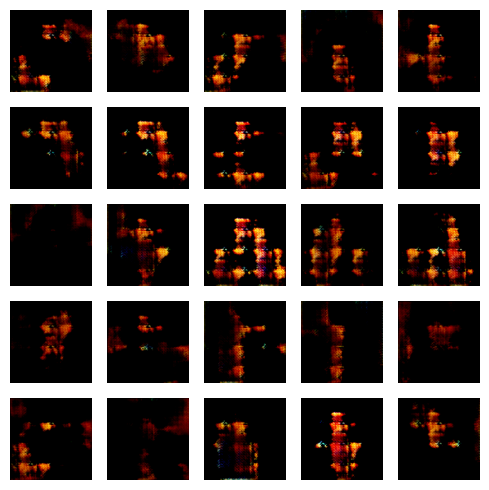

  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


  0%|          | 1/3000 [00:00<16:52,  2.96it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 2/3000 [00:00<16:49,  2.97it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 3/3000 [00:01<17:10,  2.91it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 4/3000 [00:01<17:01,  2.93it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 5/3000 [00:01<18:14,  2.74it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 6/3000 [00:02<18:59,  2.63it/s]

1/1 [==============================] - 0s 38ms/step


  0%|          | 7/3000 [00:02<20:04,  2.49it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 8/3000 [00:03<20:58,  2.38it/s]

1/1 [==============================] - 0s 54ms/step


  0%|          | 9/3000 [00:03<20:55,  2.38it/s]

1/1 [==============================] - 0s 50ms/step


  0%|          | 10/3000 [00:03<21:32,  2.31it/s]

1/1 [==============================] - 0s 47ms/step


  0%|          | 11/3000 [00:04<21:22,  2.33it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 12/3000 [00:04<21:47,  2.28it/s]

1/1 [==============================] - 0s 69ms/step


  0%|          | 13/3000 [00:05<21:57,  2.27it/s]

1/1 [==============================] - 0s 46ms/step


  0%|          | 14/3000 [00:05<21:24,  2.32it/s]

1/1 [==============================] - 0s 49ms/step


  0%|          | 15/3000 [00:06<21:21,  2.33it/s]

1/1 [==============================] - 0s 43ms/step


  1%|          | 16/3000 [00:06<21:18,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 17/3000 [00:06<19:46,  2.51it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 18/3000 [00:07<18:54,  2.63it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 19/3000 [00:07<17:48,  2.79it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 20/3000 [00:07<17:12,  2.89it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 21/3000 [00:08<17:45,  2.80it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 22/3000 [00:08<17:40,  2.81it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 23/3000 [00:08<17:27,  2.84it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 24/3000 [00:09<17:27,  2.84it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 25/3000 [00:09<17:17,  2.87it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 26/3000 [00:09<17:10,  2.89it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 27/3000 [00:10<17:19,  2.86it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 28/3000 [00:10<17:09,  2.89it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 29/3000 [00:10<16:42,  2.96it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 30/3000 [00:11<17:16,  2.87it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 31/3000 [00:11<18:34,  2.66it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 32/3000 [00:12<17:42,  2.79it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 33/3000 [00:12<17:14,  2.87it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 34/3000 [00:12<17:02,  2.90it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 35/3000 [00:13<18:12,  2.71it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 36/3000 [00:13<17:59,  2.75it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 37/3000 [00:13<17:41,  2.79it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▏         | 38/3000 [00:14<17:03,  2.89it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▏         | 39/3000 [00:14<17:04,  2.89it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 40/3000 [00:14<16:57,  2.91it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 41/3000 [00:15<16:26,  3.00it/s]

1/1 [==============================] - 0s 35ms/step


  1%|▏         | 42/3000 [00:15<16:21,  3.01it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 43/3000 [00:15<16:26,  3.00it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 44/3000 [00:16<16:35,  2.97it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 45/3000 [00:16<18:04,  2.73it/s]

1/1 [==============================] - 0s 51ms/step


  2%|▏         | 46/3000 [00:17<18:41,  2.63it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 47/3000 [00:17<19:56,  2.47it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 48/3000 [00:17<20:38,  2.38it/s]

1/1 [==============================] - 0s 44ms/step


  2%|▏         | 49/3000 [00:18<21:00,  2.34it/s]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 50/3000 [00:18<21:20,  2.30it/s]

1/1 [==============================] - 0s 53ms/step


  2%|▏         | 51/3000 [00:19<20:57,  2.35it/s]

1/1 [==============================] - 0s 52ms/step


  2%|▏         | 52/3000 [00:19<20:39,  2.38it/s]

1/1 [==============================] - 0s 50ms/step


  2%|▏         | 53/3000 [00:20<21:06,  2.33it/s]

1/1 [==============================] - 0s 56ms/step


  2%|▏         | 54/3000 [00:20<20:42,  2.37it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 55/3000 [00:21<21:21,  2.30it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 56/3000 [00:21<21:10,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 57/3000 [00:21<19:42,  2.49it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 58/3000 [00:22<18:42,  2.62it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 59/3000 [00:22<18:04,  2.71it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 60/3000 [00:22<17:18,  2.83it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 61/3000 [00:23<16:44,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 62/3000 [00:23<16:37,  2.94it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 63/3000 [00:23<16:45,  2.92it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 64/3000 [00:24<16:46,  2.92it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 65/3000 [00:24<16:24,  2.98it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 66/3000 [00:24<16:38,  2.94it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 67/3000 [00:25<16:33,  2.95it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 68/3000 [00:25<16:35,  2.95it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 69/3000 [00:25<16:35,  2.95it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 70/3000 [00:26<16:43,  2.92it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 71/3000 [00:26<18:06,  2.70it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 72/3000 [00:26<17:45,  2.75it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 73/3000 [00:27<17:21,  2.81it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 74/3000 [00:27<17:03,  2.86it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▎         | 75/3000 [00:27<16:56,  2.88it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 76/3000 [00:28<16:53,  2.88it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 77/3000 [00:28<16:50,  2.89it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 78/3000 [00:28<16:40,  2.92it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 79/3000 [00:29<16:44,  2.91it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 80/3000 [00:29<16:37,  2.93it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 81/3000 [00:29<16:39,  2.92it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 82/3000 [00:30<16:32,  2.94it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 83/3000 [00:30<16:29,  2.95it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 84/3000 [00:30<16:34,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 85/3000 [00:31<16:54,  2.87it/s]

1/1 [==============================] - 0s 44ms/step


  3%|▎         | 86/3000 [00:31<17:36,  2.76it/s]

1/1 [==============================] - 0s 50ms/step


  3%|▎         | 87/3000 [00:32<19:18,  2.51it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 88/3000 [00:32<20:06,  2.41it/s]

1/1 [==============================] - 0s 60ms/step


  3%|▎         | 89/3000 [00:33<19:55,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 90/3000 [00:33<20:15,  2.39it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 91/3000 [00:33<20:13,  2.40it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 92/3000 [00:34<20:19,  2.38it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 93/3000 [00:34<20:55,  2.31it/s]

1/1 [==============================] - 0s 66ms/step


  3%|▎         | 94/3000 [00:35<21:18,  2.27it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 95/3000 [00:35<21:41,  2.23it/s]

1/1 [==============================] - 0s 50ms/step


  3%|▎         | 96/3000 [00:36<21:43,  2.23it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 97/3000 [00:36<20:10,  2.40it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 98/3000 [00:36<19:00,  2.55it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 99/3000 [00:37<18:15,  2.65it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 100/3000 [00:37<17:44,  2.72it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 101/3000 [00:37<17:16,  2.80it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 102/3000 [00:38<17:05,  2.83it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 103/3000 [00:38<16:51,  2.86it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 104/3000 [00:38<16:43,  2.89it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 105/3000 [00:39<16:43,  2.89it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 106/3000 [00:39<16:38,  2.90it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 107/3000 [00:39<16:14,  2.97it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 108/3000 [00:40<16:16,  2.96it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 109/3000 [00:40<16:14,  2.97it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 110/3000 [00:40<16:10,  2.98it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 111/3000 [00:41<16:16,  2.96it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▎         | 112/3000 [00:41<16:20,  2.94it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 113/3000 [00:41<16:19,  2.95it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 114/3000 [00:42<16:11,  2.97it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 115/3000 [00:42<16:12,  2.97it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 116/3000 [00:42<16:15,  2.96it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 117/3000 [00:43<16:22,  2.93it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 118/3000 [00:43<16:06,  2.98it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 119/3000 [00:43<16:10,  2.97it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 120/3000 [00:44<16:16,  2.95it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 121/3000 [00:44<16:18,  2.94it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 122/3000 [00:45<16:16,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 123/3000 [00:45<16:19,  2.94it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 124/3000 [00:45<16:17,  2.94it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 125/3000 [00:46<16:16,  2.94it/s]

1/1 [==============================] - 0s 44ms/step


  4%|▍         | 126/3000 [00:46<17:59,  2.66it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▍         | 127/3000 [00:46<18:26,  2.60it/s]

1/1 [==============================] - 0s 53ms/step


  4%|▍         | 128/3000 [00:47<18:18,  2.61it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 129/3000 [00:47<18:48,  2.54it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 130/3000 [00:48<19:50,  2.41it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▍         | 131/3000 [00:48<19:29,  2.45it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▍         | 132/3000 [00:49<20:26,  2.34it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 133/3000 [00:49<20:57,  2.28it/s]

1/1 [==============================] - 0s 79ms/step


  4%|▍         | 134/3000 [00:49<21:38,  2.21it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 135/3000 [00:50<20:55,  2.28it/s]

1/1 [==============================] - 0s 55ms/step


  5%|▍         | 136/3000 [00:50<21:34,  2.21it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▍         | 137/3000 [00:51<20:31,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 138/3000 [00:51<19:13,  2.48it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 139/3000 [00:51<18:30,  2.58it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 140/3000 [00:52<17:43,  2.69it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 141/3000 [00:52<17:17,  2.76it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 142/3000 [00:52<16:38,  2.86it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 143/3000 [00:53<16:06,  2.95it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 144/3000 [00:53<17:10,  2.77it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 145/3000 [00:53<16:54,  2.81it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 146/3000 [00:54<16:36,  2.86it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 147/3000 [00:54<16:25,  2.89it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 148/3000 [00:55<16:21,  2.90it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 149/3000 [00:55<17:12,  2.76it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 150/3000 [00:55<17:05,  2.78it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 151/3000 [00:56<16:45,  2.83it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 152/3000 [00:56<16:34,  2.86it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 153/3000 [00:56<16:27,  2.88it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 154/3000 [00:57<16:28,  2.88it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 155/3000 [00:57<16:00,  2.96it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 156/3000 [00:57<16:02,  2.95it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 157/3000 [00:58<16:05,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 158/3000 [00:58<16:10,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 159/3000 [00:58<16:39,  2.84it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 160/3000 [00:59<16:29,  2.87it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 161/3000 [00:59<16:26,  2.88it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 162/3000 [00:59<15:56,  2.97it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 163/3000 [01:00<15:59,  2.96it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 164/3000 [01:00<15:37,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 165/3000 [01:00<16:14,  2.91it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 166/3000 [01:01<17:43,  2.67it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 167/3000 [01:01<18:20,  2.57it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 168/3000 [01:02<18:10,  2.60it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 169/3000 [01:02<19:05,  2.47it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▌         | 170/3000 [01:02<19:21,  2.44it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▌         | 171/3000 [01:03<19:44,  2.39it/s]

1/1 [==============================] - 0s 48ms/step


  6%|▌         | 172/3000 [01:03<20:38,  2.28it/s]

1/1 [==============================] - 0s 50ms/step


  6%|▌         | 173/3000 [01:04<20:11,  2.33it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 174/3000 [01:04<19:56,  2.36it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▌         | 175/3000 [01:05<20:25,  2.31it/s]

1/1 [==============================] - 0s 45ms/step


  6%|▌         | 176/3000 [01:05<20:38,  2.28it/s]

1/1 [==============================] - 0s 45ms/step


  6%|▌         | 177/3000 [01:06<20:32,  2.29it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 178/3000 [01:06<19:05,  2.46it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 179/3000 [01:06<17:49,  2.64it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 180/3000 [01:07<17:21,  2.71it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 181/3000 [01:07<16:48,  2.79it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 182/3000 [01:07<16:19,  2.88it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 183/3000 [01:08<16:18,  2.88it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 184/3000 [01:08<16:08,  2.91it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 185/3000 [01:08<16:06,  2.91it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 186/3000 [01:09<16:08,  2.91it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 187/3000 [01:09<16:33,  2.83it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▋         | 188/3000 [01:09<16:04,  2.92it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 189/3000 [01:10<17:00,  2.75it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▋         | 190/3000 [01:10<16:48,  2.79it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 191/3000 [01:10<16:28,  2.84it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 192/3000 [01:11<16:31,  2.83it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 193/3000 [01:11<16:16,  2.87it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 194/3000 [01:11<16:37,  2.81it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 195/3000 [01:12<16:22,  2.85it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 196/3000 [01:12<17:12,  2.71it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 197/3000 [01:13<16:59,  2.75it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 198/3000 [01:13<17:20,  2.69it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 199/3000 [01:13<17:42,  2.64it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 200/3000 [01:14<16:58,  2.75it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 201/3000 [01:14<17:08,  2.72it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 202/3000 [01:14<16:41,  2.79it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 203/3000 [01:15<16:30,  2.82it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 204/3000 [01:15<16:18,  2.86it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 205/3000 [01:15<16:15,  2.87it/s]

1/1 [==============================] - 0s 47ms/step


  7%|▋         | 206/3000 [01:16<17:53,  2.60it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 207/3000 [01:16<18:56,  2.46it/s]

1/1 [==============================] - 0s 56ms/step


  7%|▋         | 208/3000 [01:17<19:01,  2.45it/s]

1/1 [==============================] - 0s 57ms/step


  7%|▋         | 209/3000 [01:17<19:08,  2.43it/s]

1/1 [==============================] - 0s 46ms/step


  7%|▋         | 210/3000 [01:18<19:12,  2.42it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 211/3000 [01:18<18:19,  2.54it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 212/3000 [01:18<18:21,  2.53it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 213/3000 [01:19<19:03,  2.44it/s]

1/1 [==============================] - 0s 58ms/step


  7%|▋         | 214/3000 [01:19<19:12,  2.42it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 215/3000 [01:20<19:48,  2.34it/s]

1/1 [==============================] - 0s 43ms/step


  7%|▋         | 216/3000 [01:20<19:39,  2.36it/s]

1/1 [==============================] - 0s 52ms/step


  7%|▋         | 217/3000 [01:20<19:37,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 218/3000 [01:21<18:26,  2.51it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 219/3000 [01:21<17:37,  2.63it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 220/3000 [01:22<17:08,  2.70it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 221/3000 [01:22<16:39,  2.78it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 222/3000 [01:22<16:08,  2.87it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 223/3000 [01:23<16:01,  2.89it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 224/3000 [01:23<15:52,  2.91it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 225/3000 [01:23<15:33,  2.97it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 226/3000 [01:23<15:13,  3.04it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 227/3000 [01:24<15:26,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 228/3000 [01:24<15:30,  2.98it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 229/3000 [01:25<15:30,  2.98it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 230/3000 [01:25<15:30,  2.98it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 231/3000 [01:25<15:34,  2.96it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 232/3000 [01:26<16:11,  2.85it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 233/3000 [01:26<16:08,  2.86it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 234/3000 [01:26<16:01,  2.88it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 235/3000 [01:27<15:56,  2.89it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 236/3000 [01:27<15:37,  2.95it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 237/3000 [01:27<15:16,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 238/3000 [01:28<15:01,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 239/3000 [01:28<15:38,  2.94it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 240/3000 [01:28<16:28,  2.79it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 241/3000 [01:29<16:44,  2.75it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 242/3000 [01:29<16:20,  2.81it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 243/3000 [01:29<16:28,  2.79it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 244/3000 [01:30<16:41,  2.75it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 245/3000 [01:30<16:45,  2.74it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 246/3000 [01:31<16:50,  2.72it/s]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 247/3000 [01:31<17:04,  2.69it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 248/3000 [01:31<17:17,  2.65it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 249/3000 [01:32<18:25,  2.49it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 250/3000 [01:32<18:10,  2.52it/s]

1/1 [==============================] - 0s 51ms/step


  8%|▊         | 251/3000 [01:33<19:10,  2.39it/s]

1/1 [==============================] - 0s 55ms/step


  8%|▊         | 252/3000 [01:33<19:51,  2.31it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 253/3000 [01:34<20:09,  2.27it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 254/3000 [01:34<20:22,  2.25it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 255/3000 [01:34<20:30,  2.23it/s]

1/1 [==============================] - 0s 64ms/step


  9%|▊         | 256/3000 [01:35<20:49,  2.20it/s]

1/1 [==============================] - 0s 59ms/step


  9%|▊         | 257/3000 [01:35<21:07,  2.16it/s]

1/1 [==============================] - 0s 48ms/step


  9%|▊         | 258/3000 [01:36<20:22,  2.24it/s]

1/1 [==============================] - 0s 47ms/step


  9%|▊         | 259/3000 [01:36<20:42,  2.21it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▊         | 260/3000 [01:37<20:37,  2.21it/s]

1/1 [==============================] - 0s 46ms/step


  9%|▊         | 261/3000 [01:37<19:47,  2.31it/s]

1/1 [==============================] - 0s 52ms/step


  9%|▊         | 262/3000 [01:38<20:03,  2.28it/s]

1/1 [==============================] - 0s 56ms/step


  9%|▉         | 263/3000 [01:38<20:06,  2.27it/s]

1/1 [==============================] - 0s 45ms/step


  9%|▉         | 264/3000 [01:38<20:18,  2.24it/s]

1/1 [==============================] - 0s 65ms/step


  9%|▉         | 265/3000 [01:39<20:04,  2.27it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 266/3000 [01:39<20:08,  2.26it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▉         | 267/3000 [01:40<19:41,  2.31it/s]

1/1 [==============================] - 0s 51ms/step


  9%|▉         | 268/3000 [01:40<18:58,  2.40it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 269/3000 [01:40<17:56,  2.54it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 270/3000 [01:41<18:02,  2.52it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 271/3000 [01:41<17:18,  2.63it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 272/3000 [01:42<16:23,  2.77it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 273/3000 [01:42<16:10,  2.81it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 274/3000 [01:42<15:38,  2.90it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 275/3000 [01:43<15:14,  2.98it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 276/3000 [01:43<16:07,  2.82it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▉         | 277/3000 [01:43<16:06,  2.82it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 278/3000 [01:44<16:12,  2.80it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 279/3000 [01:44<16:01,  2.83it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 280/3000 [01:44<15:50,  2.86it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 281/3000 [01:45<15:41,  2.89it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 282/3000 [01:45<16:10,  2.80it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 283/3000 [01:45<16:02,  2.82it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 284/3000 [01:46<15:47,  2.87it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 285/3000 [01:46<15:28,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 286/3000 [01:46<16:52,  2.68it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 287/3000 [01:47<18:09,  2.49it/s]

1/1 [==============================] - 0s 45ms/step


 10%|▉         | 288/3000 [01:47<18:28,  2.45it/s]

1/1 [==============================] - 0s 47ms/step


 10%|▉         | 289/3000 [01:48<18:31,  2.44it/s]

1/1 [==============================] - 0s 43ms/step


 10%|▉         | 290/3000 [01:48<19:17,  2.34it/s]

1/1 [==============================] - 0s 60ms/step


 10%|▉         | 291/3000 [01:49<19:55,  2.27it/s]

1/1 [==============================] - 0s 42ms/step


 10%|▉         | 292/3000 [01:49<19:39,  2.30it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 293/3000 [01:50<19:55,  2.26it/s]

1/1 [==============================] - 0s 40ms/step


 10%|▉         | 294/3000 [01:50<19:50,  2.27it/s]

1/1 [==============================] - 0s 59ms/step


 10%|▉         | 295/3000 [01:51<20:15,  2.23it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 296/3000 [01:51<19:53,  2.27it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 297/3000 [01:51<18:27,  2.44it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 298/3000 [01:52<17:39,  2.55it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 299/3000 [01:52<17:25,  2.58it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 300/3000 [01:52<17:16,  2.61it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 301/3000 [01:53<17:36,  2.55it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 302/3000 [01:53<18:14,  2.47it/s]

1/1 [==============================] - 0s 69ms/step


 10%|█         | 303/3000 [01:54<18:01,  2.49it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 304/3000 [01:54<17:10,  2.62it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 305/3000 [01:54<16:21,  2.75it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 306/3000 [01:55<15:51,  2.83it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 307/3000 [01:55<15:40,  2.86it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 308/3000 [01:55<15:29,  2.90it/s]

1/1 [==============================] - 0s 47ms/step


 10%|█         | 309/3000 [01:56<15:37,  2.87it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 310/3000 [01:56<15:30,  2.89it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 311/3000 [01:56<15:29,  2.89it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 312/3000 [01:57<15:09,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 313/3000 [01:57<15:16,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 314/3000 [01:57<14:59,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 315/3000 [01:58<14:49,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 316/3000 [01:58<14:51,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 317/3000 [01:58<14:58,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 318/3000 [01:59<15:11,  2.94it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 319/3000 [01:59<15:12,  2.94it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 320/3000 [01:59<14:49,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 321/3000 [02:00<14:41,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 322/3000 [02:00<14:44,  3.03it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 323/3000 [02:00<14:50,  3.01it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 324/3000 [02:01<14:39,  3.04it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 325/3000 [02:01<14:49,  3.01it/s]

1/1 [==============================] - 0s 42ms/step


 11%|█         | 326/3000 [02:01<16:32,  2.70it/s]

1/1 [==============================] - 0s 49ms/step


 11%|█         | 327/3000 [02:02<17:07,  2.60it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 328/3000 [02:02<17:55,  2.49it/s]

1/1 [==============================] - 0s 51ms/step


 11%|█         | 329/3000 [02:03<17:44,  2.51it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 330/3000 [02:03<18:25,  2.42it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 331/3000 [02:04<18:23,  2.42it/s]

1/1 [==============================] - 0s 55ms/step


 11%|█         | 332/3000 [02:04<18:15,  2.44it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 333/3000 [02:04<18:42,  2.38it/s]

1/1 [==============================] - 0s 58ms/step


 11%|█         | 334/3000 [02:05<19:30,  2.28it/s]

1/1 [==============================] - 0s 42ms/step


 11%|█         | 335/3000 [02:05<19:14,  2.31it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 336/3000 [02:06<18:55,  2.35it/s]

1/1 [==============================] - 0s 60ms/step


 11%|█         | 337/3000 [02:06<18:56,  2.34it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█▏        | 338/3000 [02:06<17:58,  2.47it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█▏        | 339/3000 [02:07<17:10,  2.58it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█▏        | 340/3000 [02:07<16:38,  2.66it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 341/3000 [02:08<16:09,  2.74it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 342/3000 [02:08<15:54,  2.79it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 343/3000 [02:08<15:19,  2.89it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 344/3000 [02:09<15:15,  2.90it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 345/3000 [02:09<15:17,  2.89it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 346/3000 [02:09<15:13,  2.91it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 347/3000 [02:10<15:10,  2.91it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 348/3000 [02:10<14:49,  2.98it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 349/3000 [02:10<14:48,  2.98it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 350/3000 [02:11<14:48,  2.98it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 351/3000 [02:11<14:50,  2.98it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 352/3000 [02:11<14:30,  3.04it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 353/3000 [02:12<14:39,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 354/3000 [02:12<14:44,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 355/3000 [02:12<14:48,  2.98it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 356/3000 [02:13<14:57,  2.95it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 357/3000 [02:13<14:37,  3.01it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 358/3000 [02:13<14:50,  2.97it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 359/3000 [02:14<15:03,  2.92it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 360/3000 [02:14<15:11,  2.90it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 361/3000 [02:14<15:24,  2.86it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 362/3000 [02:15<15:00,  2.93it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 363/3000 [02:15<14:42,  2.99it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 364/3000 [02:15<14:37,  3.00it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 365/3000 [02:16<14:45,  2.98it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 366/3000 [02:16<14:46,  2.97it/s]

1/1 [==============================] - 0s 64ms/step


 12%|█▏        | 367/3000 [02:16<15:17,  2.87it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█▏        | 368/3000 [02:17<16:06,  2.72it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 369/3000 [02:17<17:04,  2.57it/s]

1/1 [==============================] - 0s 55ms/step


 12%|█▏        | 370/3000 [02:18<18:21,  2.39it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 371/3000 [02:18<18:10,  2.41it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▏        | 372/3000 [02:19<18:40,  2.34it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 373/3000 [02:19<18:54,  2.31it/s]

1/1 [==============================] - 0s 47ms/step


 12%|█▏        | 374/3000 [02:19<19:12,  2.28it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▎        | 375/3000 [02:20<19:23,  2.26it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 376/3000 [02:20<18:52,  2.32it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 377/3000 [02:21<19:17,  2.27it/s]

1/1 [==============================] - 0s 51ms/step


 13%|█▎        | 378/3000 [02:21<19:12,  2.27it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 379/3000 [02:22<17:54,  2.44it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 380/3000 [02:22<16:37,  2.63it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 381/3000 [02:22<16:01,  2.72it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 382/3000 [02:23<15:45,  2.77it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 383/3000 [02:23<15:06,  2.89it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 384/3000 [02:23<15:00,  2.91it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 385/3000 [02:23<15:00,  2.90it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 386/3000 [02:24<14:55,  2.92it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 387/3000 [02:24<15:40,  2.78it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 388/3000 [02:25<15:35,  2.79it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 389/3000 [02:25<15:21,  2.83it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 390/3000 [02:25<14:48,  2.94it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 391/3000 [02:26<14:55,  2.91it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 392/3000 [02:26<15:00,  2.90it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 393/3000 [02:26<15:22,  2.83it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 394/3000 [02:27<15:14,  2.85it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 395/3000 [02:27<15:07,  2.87it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 396/3000 [02:27<15:34,  2.79it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 397/3000 [02:28<15:26,  2.81it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 398/3000 [02:28<15:09,  2.86it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 399/3000 [02:28<15:02,  2.88it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 400/3000 [02:29<15:07,  2.87it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 401/3000 [02:29<15:01,  2.88it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 402/3000 [02:29<14:55,  2.90it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 403/3000 [02:30<15:07,  2.86it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 404/3000 [02:30<14:57,  2.89it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 405/3000 [02:30<14:57,  2.89it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▎        | 406/3000 [02:31<15:03,  2.87it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 407/3000 [02:31<15:27,  2.80it/s]

1/1 [==============================] - 0s 45ms/step


 14%|█▎        | 408/3000 [02:32<16:44,  2.58it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▎        | 409/3000 [02:32<17:39,  2.45it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▎        | 410/3000 [02:33<18:07,  2.38it/s]

1/1 [==============================] - 0s 44ms/step


 14%|█▎        | 411/3000 [02:33<18:46,  2.30it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▎        | 412/3000 [02:33<17:58,  2.40it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 413/3000 [02:34<18:36,  2.32it/s]

1/1 [==============================] - 0s 46ms/step


 14%|█▍        | 414/3000 [02:34<18:38,  2.31it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 415/3000 [02:35<18:10,  2.37it/s]

1/1 [==============================] - 0s 46ms/step


 14%|█▍        | 416/3000 [02:35<18:09,  2.37it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 417/3000 [02:36<18:28,  2.33it/s]

1/1 [==============================] - 0s 51ms/step


 14%|█▍        | 418/3000 [02:36<18:26,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 419/3000 [02:36<17:02,  2.52it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 420/3000 [02:37<16:17,  2.64it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 421/3000 [02:37<15:56,  2.70it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 422/3000 [02:37<15:58,  2.69it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 423/3000 [02:38<15:36,  2.75it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 424/3000 [02:38<15:25,  2.78it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 425/3000 [02:38<15:08,  2.83it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 426/3000 [02:39<14:55,  2.88it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 427/3000 [02:39<14:54,  2.88it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 428/3000 [02:39<14:52,  2.88it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 429/3000 [02:40<14:49,  2.89it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 430/3000 [02:40<14:47,  2.90it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 431/3000 [02:40<14:41,  2.92it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 432/3000 [02:41<14:14,  3.00it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 433/3000 [02:41<14:24,  2.97it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 434/3000 [02:41<14:29,  2.95it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 435/3000 [02:42<14:34,  2.93it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 436/3000 [02:42<14:34,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 437/3000 [02:43<14:38,  2.92it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 438/3000 [02:43<14:38,  2.92it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 439/3000 [02:43<14:42,  2.90it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 440/3000 [02:44<14:58,  2.85it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 441/3000 [02:44<14:52,  2.87it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 442/3000 [02:44<14:45,  2.89it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 443/3000 [02:45<14:29,  2.94it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 444/3000 [02:45<14:32,  2.93it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 445/3000 [02:45<15:15,  2.79it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 446/3000 [02:46<14:37,  2.91it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 447/3000 [02:46<14:51,  2.86it/s]

1/1 [==============================] - 0s 54ms/step


 15%|█▍        | 448/3000 [02:46<16:12,  2.63it/s]

1/1 [==============================] - 0s 69ms/step


 15%|█▍        | 449/3000 [02:47<17:24,  2.44it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 450/3000 [02:47<18:09,  2.34it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▌        | 451/3000 [02:48<17:25,  2.44it/s]

1/1 [==============================] - 0s 47ms/step


 15%|█▌        | 452/3000 [02:48<18:22,  2.31it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▌        | 453/3000 [02:49<18:07,  2.34it/s]

1/1 [==============================] - 0s 51ms/step


 15%|█▌        | 454/3000 [02:49<18:36,  2.28it/s]

1/1 [==============================] - 0s 69ms/step


 15%|█▌        | 455/3000 [02:50<18:23,  2.31it/s]

1/1 [==============================] - 0s 60ms/step


 15%|█▌        | 456/3000 [02:50<18:34,  2.28it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 457/3000 [02:50<18:56,  2.24it/s]

1/1 [==============================] - 0s 50ms/step


 15%|█▌        | 458/3000 [02:51<18:55,  2.24it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 459/3000 [02:51<17:11,  2.46it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 460/3000 [02:52<16:32,  2.56it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 461/3000 [02:52<15:35,  2.71it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 462/3000 [02:52<14:53,  2.84it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 463/3000 [02:53<14:47,  2.86it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 464/3000 [02:53<14:38,  2.89it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 465/3000 [02:53<14:31,  2.91it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 466/3000 [02:54<14:31,  2.91it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 467/3000 [02:54<14:25,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 468/3000 [02:54<14:27,  2.92it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 469/3000 [02:55<14:28,  2.92it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 470/3000 [02:55<14:27,  2.92it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 471/3000 [02:55<14:09,  2.98it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 472/3000 [02:56<15:09,  2.78it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 473/3000 [02:56<15:22,  2.74it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 474/3000 [02:56<14:47,  2.85it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 475/3000 [02:57<14:45,  2.85it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 476/3000 [02:57<14:31,  2.90it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 477/3000 [02:57<14:10,  2.97it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 478/3000 [02:58<14:00,  3.00it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 479/3000 [02:58<14:03,  2.99it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 480/3000 [02:58<14:04,  2.98it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 481/3000 [02:59<14:05,  2.98it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 482/3000 [02:59<13:45,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 483/3000 [02:59<13:37,  3.08it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 484/3000 [03:00<13:32,  3.10it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 485/3000 [03:00<13:24,  3.12it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 486/3000 [03:00<13:36,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 487/3000 [03:01<13:55,  3.01it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 488/3000 [03:01<15:17,  2.74it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▋        | 489/3000 [03:02<16:28,  2.54it/s]

1/1 [==============================] - 0s 47ms/step


 16%|█▋        | 490/3000 [03:02<17:18,  2.42it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▋        | 491/3000 [03:02<17:35,  2.38it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▋        | 492/3000 [03:03<17:21,  2.41it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▋        | 493/3000 [03:03<17:54,  2.33it/s]

1/1 [==============================] - 0s 52ms/step


 16%|█▋        | 494/3000 [03:04<17:33,  2.38it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▋        | 495/3000 [03:04<18:03,  2.31it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 496/3000 [03:05<17:47,  2.35it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 497/3000 [03:05<18:04,  2.31it/s]

1/1 [==============================] - 0s 48ms/step


 17%|█▋        | 498/3000 [03:05<17:45,  2.35it/s]

1/1 [==============================] - 0s 48ms/step


 17%|█▋        | 499/3000 [03:06<17:43,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 500/3000 [03:06<16:34,  2.51it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 501/3000 [03:07<15:56,  2.61it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 502/3000 [03:07<15:28,  2.69it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 503/3000 [03:07<14:54,  2.79it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 504/3000 [03:08<14:40,  2.83it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 505/3000 [03:08<14:32,  2.86it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 506/3000 [03:08<14:24,  2.88it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 507/3000 [03:09<14:23,  2.89it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 508/3000 [03:09<14:16,  2.91it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 509/3000 [03:09<14:10,  2.93it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 510/3000 [03:10<14:59,  2.77it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 511/3000 [03:10<14:44,  2.81it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 512/3000 [03:10<14:31,  2.85it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 513/3000 [03:11<14:24,  2.88it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 514/3000 [03:11<14:18,  2.89it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 515/3000 [03:11<14:17,  2.90it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 516/3000 [03:12<14:14,  2.91it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 517/3000 [03:12<14:37,  2.83it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 518/3000 [03:12<14:29,  2.86it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 519/3000 [03:13<14:56,  2.77it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 520/3000 [03:13<14:52,  2.78it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 521/3000 [03:14<14:37,  2.83it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 522/3000 [03:14<14:14,  2.90it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 523/3000 [03:14<14:12,  2.90it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 524/3000 [03:15<14:12,  2.91it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 525/3000 [03:15<14:13,  2.90it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 526/3000 [03:15<14:16,  2.89it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 527/3000 [03:16<14:10,  2.91it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 528/3000 [03:16<14:32,  2.83it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 529/3000 [03:16<15:11,  2.71it/s]

1/1 [==============================] - 0s 64ms/step


 18%|█▊        | 530/3000 [03:17<16:17,  2.53it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 531/3000 [03:17<18:16,  2.25it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 532/3000 [03:18<18:35,  2.21it/s]

1/1 [==============================] - 0s 67ms/step


 18%|█▊        | 533/3000 [03:18<18:39,  2.20it/s]

1/1 [==============================] - 0s 46ms/step


 18%|█▊        | 534/3000 [03:19<18:36,  2.21it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 535/3000 [03:19<17:45,  2.31it/s]

1/1 [==============================] - 0s 54ms/step


 18%|█▊        | 536/3000 [03:20<17:32,  2.34it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 537/3000 [03:20<17:17,  2.37it/s]

1/1 [==============================] - 0s 42ms/step


 18%|█▊        | 538/3000 [03:20<17:33,  2.34it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 539/3000 [03:21<17:36,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 540/3000 [03:21<16:28,  2.49it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 541/3000 [03:22<15:45,  2.60it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 542/3000 [03:22<15:20,  2.67it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 543/3000 [03:22<14:36,  2.80it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 544/3000 [03:23<15:12,  2.69it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 545/3000 [03:23<14:52,  2.75it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 546/3000 [03:23<14:59,  2.73it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 547/3000 [03:24<15:11,  2.69it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 548/3000 [03:24<14:47,  2.76it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 549/3000 [03:24<14:10,  2.88it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 550/3000 [03:25<14:39,  2.79it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 551/3000 [03:25<14:20,  2.84it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 552/3000 [03:25<14:10,  2.88it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 553/3000 [03:26<14:19,  2.85it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 554/3000 [03:26<14:06,  2.89it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 555/3000 [03:26<13:41,  2.98it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▊        | 556/3000 [03:27<13:50,  2.94it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 557/3000 [03:27<13:50,  2.94it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 558/3000 [03:27<13:49,  2.94it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▊        | 559/3000 [03:28<14:04,  2.89it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 560/3000 [03:28<14:01,  2.90it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 561/3000 [03:28<14:01,  2.90it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▊        | 562/3000 [03:29<14:07,  2.88it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 563/3000 [03:29<13:43,  2.96it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 564/3000 [03:29<13:43,  2.96it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 565/3000 [03:30<14:05,  2.88it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 566/3000 [03:30<14:02,  2.89it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 567/3000 [03:31<13:58,  2.90it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 568/3000 [03:31<15:09,  2.67it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 569/3000 [03:31<16:21,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 570/3000 [03:32<15:59,  2.53it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▉        | 571/3000 [03:32<16:52,  2.40it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 572/3000 [03:33<17:24,  2.33it/s]

1/1 [==============================] - 0s 45ms/step


 19%|█▉        | 573/3000 [03:33<17:39,  2.29it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▉        | 574/3000 [03:34<17:54,  2.26it/s]

1/1 [==============================] - 0s 58ms/step


 19%|█▉        | 575/3000 [03:34<17:39,  2.29it/s]

1/1 [==============================] - 0s 58ms/step


 19%|█▉        | 576/3000 [03:35<17:37,  2.29it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 577/3000 [03:35<17:30,  2.31it/s]

1/1 [==============================] - 0s 49ms/step


 19%|█▉        | 578/3000 [03:35<18:00,  2.24it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 579/3000 [03:36<17:38,  2.29it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 580/3000 [03:36<16:04,  2.51it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 581/3000 [03:37<15:24,  2.62it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 582/3000 [03:37<14:34,  2.76it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 583/3000 [03:37<14:28,  2.78it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 584/3000 [03:38<14:11,  2.84it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 585/3000 [03:38<13:41,  2.94it/s]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 586/3000 [03:38<13:44,  2.93it/s]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 587/3000 [03:39<13:45,  2.92it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 588/3000 [03:39<13:40,  2.94it/s]

1/1 [==============================] - 0s 35ms/step


 20%|█▉        | 589/3000 [03:39<13:26,  2.99it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 590/3000 [03:39<13:26,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 591/3000 [03:40<13:26,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 592/3000 [03:40<13:32,  2.96it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 593/3000 [03:41<13:33,  2.96it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 594/3000 [03:41<13:57,  2.87it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█▉        | 595/3000 [03:41<13:54,  2.88it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 596/3000 [03:42<14:34,  2.75it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 597/3000 [03:42<14:38,  2.74it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 598/3000 [03:42<13:57,  2.87it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 599/3000 [03:43<13:59,  2.86it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 600/3000 [03:43<14:11,  2.82it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 601/3000 [03:43<14:00,  2.85it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 602/3000 [03:44<13:53,  2.88it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 603/3000 [03:44<13:50,  2.88it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 604/3000 [03:44<13:25,  2.98it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 605/3000 [03:45<14:02,  2.84it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 606/3000 [03:45<13:36,  2.93it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 607/3000 [03:45<13:44,  2.90it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 608/3000 [03:46<14:36,  2.73it/s]

1/1 [==============================] - 0s 53ms/step


 20%|██        | 609/3000 [03:46<15:07,  2.63it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 610/3000 [03:47<15:46,  2.53it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 611/3000 [03:47<15:58,  2.49it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 612/3000 [03:48<16:01,  2.48it/s]

1/1 [==============================] - 0s 58ms/step


 20%|██        | 613/3000 [03:48<18:05,  2.20it/s]

1/1 [==============================] - 0s 71ms/step


 20%|██        | 614/3000 [03:49<17:41,  2.25it/s]

1/1 [==============================] - 0s 46ms/step


 20%|██        | 615/3000 [03:49<17:57,  2.21it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 616/3000 [03:49<17:21,  2.29it/s]

1/1 [==============================] - 0s 59ms/step


 21%|██        | 617/3000 [03:50<17:34,  2.26it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 618/3000 [03:50<16:51,  2.36it/s]

1/1 [==============================] - 0s 67ms/step


 21%|██        | 619/3000 [03:51<16:46,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 620/3000 [03:51<15:47,  2.51it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 621/3000 [03:51<15:04,  2.63it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 622/3000 [03:52<14:49,  2.67it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 623/3000 [03:52<17:41,  2.24it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 624/3000 [03:53<16:28,  2.40it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 625/3000 [03:53<15:36,  2.54it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 626/3000 [03:53<15:01,  2.63it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 627/3000 [03:54<14:37,  2.71it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 628/3000 [03:54<14:01,  2.82it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 629/3000 [03:54<14:00,  2.82it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 630/3000 [03:55<13:56,  2.83it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 631/3000 [03:55<14:15,  2.77it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 632/3000 [03:55<13:45,  2.87it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██        | 633/3000 [03:56<13:30,  2.92it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 634/3000 [03:56<13:09,  3.00it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 635/3000 [03:56<13:21,  2.95it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 636/3000 [03:57<13:32,  2.91it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 637/3000 [03:57<13:53,  2.84it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 638/3000 [03:57<13:47,  2.85it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██▏       | 639/3000 [03:58<14:14,  2.76it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 640/3000 [03:58<13:57,  2.82it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 641/3000 [03:59<13:48,  2.85it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 642/3000 [03:59<13:53,  2.83it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 643/3000 [03:59<13:49,  2.84it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 644/3000 [04:00<13:25,  2.92it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 645/3000 [04:00<13:38,  2.88it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 646/3000 [04:00<13:35,  2.88it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 647/3000 [04:01<13:52,  2.83it/s]

1/1 [==============================] - 0s 44ms/step


 22%|██▏       | 648/3000 [04:01<14:35,  2.69it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 649/3000 [04:01<14:36,  2.68it/s]

1/1 [==============================] - 0s 46ms/step


 22%|██▏       | 650/3000 [04:02<15:05,  2.60it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▏       | 651/3000 [04:02<16:10,  2.42it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 652/3000 [04:03<16:40,  2.35it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 653/3000 [04:03<17:08,  2.28it/s]

1/1 [==============================] - 0s 59ms/step


 22%|██▏       | 654/3000 [04:04<17:08,  2.28it/s]

1/1 [==============================] - 0s 57ms/step


 22%|██▏       | 655/3000 [04:04<17:24,  2.24it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 656/3000 [04:05<16:56,  2.31it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 657/3000 [04:05<17:26,  2.24it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 658/3000 [04:05<17:44,  2.20it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 659/3000 [04:06<16:07,  2.42it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 660/3000 [04:06<15:29,  2.52it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 661/3000 [04:07<14:51,  2.62it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 662/3000 [04:07<14:09,  2.75it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 663/3000 [04:07<14:15,  2.73it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 664/3000 [04:08<14:02,  2.77it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 665/3000 [04:08<13:54,  2.80it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 666/3000 [04:08<13:59,  2.78it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 667/3000 [04:09<13:47,  2.82it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 668/3000 [04:09<14:32,  2.67it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 669/3000 [04:09<14:15,  2.72it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 670/3000 [04:10<13:48,  2.81it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 671/3000 [04:10<14:14,  2.73it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 672/3000 [04:10<14:04,  2.76it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 673/3000 [04:11<13:58,  2.78it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 674/3000 [04:11<13:53,  2.79it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▎       | 675/3000 [04:12<13:49,  2.80it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 676/3000 [04:12<13:46,  2.81it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 677/3000 [04:12<14:26,  2.68it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 678/3000 [04:13<13:49,  2.80it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 679/3000 [04:13<13:25,  2.88it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 680/3000 [04:13<13:54,  2.78it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 681/3000 [04:14<13:47,  2.80it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 682/3000 [04:14<13:56,  2.77it/s]

1/1 [==============================] - 0s 45ms/step


 23%|██▎       | 683/3000 [04:14<13:54,  2.78it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 684/3000 [04:15<14:08,  2.73it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 685/3000 [04:15<14:19,  2.69it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 686/3000 [04:15<13:53,  2.78it/s]

1/1 [==============================] - 0s 55ms/step


 23%|██▎       | 687/3000 [04:16<15:16,  2.52it/s]

1/1 [==============================] - 0s 63ms/step


 23%|██▎       | 688/3000 [04:16<15:30,  2.49it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 689/3000 [04:17<15:45,  2.45it/s]

1/1 [==============================] - 0s 46ms/step


 23%|██▎       | 690/3000 [04:17<18:24,  2.09it/s]

1/1 [==============================] - 0s 71ms/step


 23%|██▎       | 691/3000 [04:18<17:57,  2.14it/s]

1/1 [==============================] - 0s 58ms/step


 23%|██▎       | 692/3000 [04:18<17:55,  2.15it/s]

1/1 [==============================] - 0s 58ms/step


 23%|██▎       | 693/3000 [04:19<17:44,  2.17it/s]

1/1 [==============================] - 0s 58ms/step


 23%|██▎       | 694/3000 [04:19<17:42,  2.17it/s]

1/1 [==============================] - 0s 63ms/step


 23%|██▎       | 695/3000 [04:20<17:52,  2.15it/s]

1/1 [==============================] - 0s 49ms/step


 23%|██▎       | 696/3000 [04:20<17:53,  2.15it/s]

1/1 [==============================] - 0s 79ms/step


 23%|██▎       | 697/3000 [04:21<18:50,  2.04it/s]

1/1 [==============================] - 0s 48ms/step


 23%|██▎       | 698/3000 [04:21<18:23,  2.09it/s]

1/1 [==============================] - 0s 62ms/step


 23%|██▎       | 699/3000 [04:22<18:30,  2.07it/s]

1/1 [==============================] - 0s 63ms/step


 23%|██▎       | 700/3000 [04:22<18:27,  2.08it/s]

1/1 [==============================] - 0s 61ms/step


 23%|██▎       | 701/3000 [04:23<18:37,  2.06it/s]

1/1 [==============================] - 0s 58ms/step


 23%|██▎       | 702/3000 [04:23<18:42,  2.05it/s]

1/1 [==============================] - 0s 66ms/step


 23%|██▎       | 703/3000 [04:24<17:51,  2.14it/s]

1/1 [==============================] - 0s 51ms/step


 23%|██▎       | 704/3000 [04:24<17:19,  2.21it/s]

1/1 [==============================] - 0s 54ms/step


 24%|██▎       | 705/3000 [04:24<16:37,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 706/3000 [04:25<16:00,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 707/3000 [04:25<15:28,  2.47it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 708/3000 [04:25<14:28,  2.64it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 709/3000 [04:26<14:05,  2.71it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 710/3000 [04:26<13:46,  2.77it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 711/3000 [04:27<13:34,  2.81it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 712/3000 [04:27<13:27,  2.83it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 713/3000 [04:27<13:19,  2.86it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 714/3000 [04:28<13:15,  2.87it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 715/3000 [04:28<13:19,  2.86it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 716/3000 [04:28<13:13,  2.88it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 717/3000 [04:29<13:11,  2.88it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 718/3000 [04:29<13:07,  2.90it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 719/3000 [04:29<13:14,  2.87it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 720/3000 [04:30<13:12,  2.88it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 721/3000 [04:30<13:14,  2.87it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 722/3000 [04:30<13:07,  2.89it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 723/3000 [04:31<13:28,  2.81it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 724/3000 [04:31<13:24,  2.83it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 725/3000 [04:31<13:19,  2.84it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 726/3000 [04:32<13:13,  2.87it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 727/3000 [04:32<12:55,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 728/3000 [04:32<12:56,  2.93it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 729/3000 [04:33<12:59,  2.91it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 730/3000 [04:33<13:05,  2.89it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 731/3000 [04:34<14:08,  2.68it/s]

1/1 [==============================] - 0s 59ms/step


 24%|██▍       | 732/3000 [04:34<14:33,  2.60it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▍       | 733/3000 [04:34<15:21,  2.46it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 734/3000 [04:35<15:48,  2.39it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 735/3000 [04:35<15:31,  2.43it/s]

1/1 [==============================] - 0s 54ms/step


 25%|██▍       | 736/3000 [04:36<15:38,  2.41it/s]

1/1 [==============================] - 0s 63ms/step


 25%|██▍       | 737/3000 [04:36<15:55,  2.37it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 738/3000 [04:37<15:56,  2.36it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▍       | 739/3000 [04:37<15:44,  2.39it/s]

1/1 [==============================] - 0s 56ms/step


 25%|██▍       | 740/3000 [04:37<15:40,  2.40it/s]

1/1 [==============================] - 0s 55ms/step


 25%|██▍       | 741/3000 [04:38<15:24,  2.44it/s]

1/1 [==============================] - 0s 59ms/step


 25%|██▍       | 742/3000 [04:38<15:33,  2.42it/s]

1/1 [==============================] - 0s 53ms/step


 25%|██▍       | 743/3000 [04:39<15:11,  2.48it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 744/3000 [04:39<14:27,  2.60it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 745/3000 [04:39<14:01,  2.68it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 746/3000 [04:40<13:49,  2.72it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 747/3000 [04:40<13:31,  2.78it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 748/3000 [04:40<13:01,  2.88it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 749/3000 [04:41<13:31,  2.77it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 750/3000 [04:41<13:20,  2.81it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 751/3000 [04:41<13:12,  2.84it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 752/3000 [04:42<13:12,  2.84it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 753/3000 [04:42<13:05,  2.86it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 754/3000 [04:42<12:59,  2.88it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 755/3000 [04:43<12:44,  2.94it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 756/3000 [04:43<12:46,  2.93it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 757/3000 [04:43<13:29,  2.77it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 758/3000 [04:44<13:17,  2.81it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 759/3000 [04:44<12:52,  2.90it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 760/3000 [04:44<13:12,  2.83it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 761/3000 [04:45<13:52,  2.69it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 762/3000 [04:45<13:23,  2.79it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 763/3000 [04:46<14:02,  2.66it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 764/3000 [04:46<13:42,  2.72it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 765/3000 [04:46<13:27,  2.77it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 766/3000 [04:47<13:08,  2.83it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 767/3000 [04:47<12:47,  2.91it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 768/3000 [04:47<12:48,  2.90it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 769/3000 [04:48<12:47,  2.91it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 770/3000 [04:48<12:48,  2.90it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 771/3000 [04:48<12:32,  2.96it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 772/3000 [04:49<12:49,  2.89it/s]

1/1 [==============================] - 0s 47ms/step


 26%|██▌       | 773/3000 [04:49<13:20,  2.78it/s]

1/1 [==============================] - 0s 51ms/step


 26%|██▌       | 774/3000 [04:49<13:40,  2.71it/s]

1/1 [==============================] - 0s 45ms/step


 26%|██▌       | 775/3000 [04:50<14:03,  2.64it/s]

1/1 [==============================] - 0s 60ms/step


 26%|██▌       | 776/3000 [04:50<14:38,  2.53it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 777/3000 [04:51<14:38,  2.53it/s]

1/1 [==============================] - 0s 64ms/step


 26%|██▌       | 778/3000 [04:51<14:45,  2.51it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 779/3000 [04:52<14:54,  2.48it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 780/3000 [04:52<15:25,  2.40it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 781/3000 [04:52<15:45,  2.35it/s]

1/1 [==============================] - 0s 49ms/step


 26%|██▌       | 782/3000 [04:53<15:32,  2.38it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▌       | 783/3000 [04:53<15:16,  2.42it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▌       | 784/3000 [04:54<15:48,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 785/3000 [04:54<15:17,  2.41it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 786/3000 [04:54<14:55,  2.47it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 787/3000 [04:55<14:31,  2.54it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 788/3000 [04:55<13:53,  2.65it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▋       | 789/3000 [04:56<13:32,  2.72it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 790/3000 [04:56<13:17,  2.77it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▋       | 791/3000 [04:56<13:10,  2.79it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▋       | 792/3000 [04:57<13:10,  2.79it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▋       | 793/3000 [04:57<13:01,  2.82it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 794/3000 [04:57<13:07,  2.80it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▋       | 795/3000 [04:58<12:59,  2.83it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 796/3000 [04:58<12:41,  2.90it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 797/3000 [04:58<12:51,  2.85it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 798/3000 [04:59<12:49,  2.86it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 799/3000 [04:59<12:44,  2.88it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 800/3000 [04:59<12:51,  2.85it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 801/3000 [05:00<12:44,  2.88it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 802/3000 [05:00<12:23,  2.96it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 803/3000 [05:00<12:18,  2.97it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 804/3000 [05:01<12:23,  2.95it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 805/3000 [05:01<12:28,  2.93it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 806/3000 [05:01<12:19,  2.97it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 807/3000 [05:02<12:23,  2.95it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 808/3000 [05:02<12:34,  2.90it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 809/3000 [05:02<12:36,  2.90it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 810/3000 [05:03<12:18,  2.97it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 811/3000 [05:03<12:24,  2.94it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 812/3000 [05:03<13:02,  2.80it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 813/3000 [05:04<13:56,  2.61it/s]

1/1 [==============================] - 0s 61ms/step


 27%|██▋       | 814/3000 [05:04<14:12,  2.56it/s]

1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 815/3000 [05:05<14:54,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 816/3000 [05:05<15:43,  2.32it/s]

1/1 [==============================] - 0s 45ms/step


 27%|██▋       | 817/3000 [05:06<15:26,  2.36it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 818/3000 [05:06<15:14,  2.39it/s]

1/1 [==============================] - 0s 52ms/step


 27%|██▋       | 819/3000 [05:07<15:36,  2.33it/s]

1/1 [==============================] - 0s 56ms/step


 27%|██▋       | 820/3000 [05:07<15:25,  2.36it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 821/3000 [05:07<15:35,  2.33it/s]

1/1 [==============================] - 0s 47ms/step


 27%|██▋       | 822/3000 [05:08<15:48,  2.30it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 823/3000 [05:08<16:05,  2.25it/s]

1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 824/3000 [05:09<16:30,  2.20it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 825/3000 [05:09<15:17,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 826/3000 [05:09<14:28,  2.50it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 827/3000 [05:10<13:54,  2.61it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 828/3000 [05:10<13:28,  2.69it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 829/3000 [05:11<13:11,  2.74it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 830/3000 [05:11<13:44,  2.63it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 831/3000 [05:11<13:21,  2.70it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 832/3000 [05:12<12:59,  2.78it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 833/3000 [05:12<12:35,  2.87it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 834/3000 [05:12<12:21,  2.92it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 835/3000 [05:13<12:24,  2.91it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 836/3000 [05:13<12:24,  2.91it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 837/3000 [05:13<12:22,  2.91it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 838/3000 [05:14<13:03,  2.76it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 839/3000 [05:14<12:53,  2.80it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 840/3000 [05:14<12:25,  2.90it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 841/3000 [05:15<12:23,  2.90it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 842/3000 [05:15<12:04,  2.98it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 843/3000 [05:15<11:51,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 844/3000 [05:16<12:27,  2.88it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 845/3000 [05:16<13:15,  2.71it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 846/3000 [05:16<13:01,  2.76it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 847/3000 [05:17<13:15,  2.71it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 848/3000 [05:17<12:57,  2.77it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 849/3000 [05:18<12:47,  2.80it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 850/3000 [05:18<12:46,  2.80it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 851/3000 [05:18<12:19,  2.91it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 852/3000 [05:19<12:03,  2.97it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 853/3000 [05:19<13:08,  2.72it/s]

1/1 [==============================] - 0s 52ms/step


 28%|██▊       | 854/3000 [05:19<13:29,  2.65it/s]

1/1 [==============================] - 0s 45ms/step


 28%|██▊       | 855/3000 [05:20<14:20,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▊       | 856/3000 [05:20<14:34,  2.45it/s]

1/1 [==============================] - 0s 50ms/step


 29%|██▊       | 857/3000 [05:21<15:11,  2.35it/s]

1/1 [==============================] - 0s 70ms/step


 29%|██▊       | 858/3000 [05:21<15:36,  2.29it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▊       | 859/3000 [05:22<16:05,  2.22it/s]

1/1 [==============================] - 0s 57ms/step


 29%|██▊       | 860/3000 [05:22<15:42,  2.27it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▊       | 861/3000 [05:23<15:08,  2.36it/s]

1/1 [==============================] - 0s 46ms/step


 29%|██▊       | 862/3000 [05:23<14:45,  2.41it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 863/3000 [05:23<14:51,  2.40it/s]

1/1 [==============================] - 0s 55ms/step


 29%|██▉       | 864/3000 [05:24<15:11,  2.34it/s]

1/1 [==============================] - 0s 53ms/step


 29%|██▉       | 865/3000 [05:24<14:21,  2.48it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 866/3000 [05:24<13:44,  2.59it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 867/3000 [05:25<12:59,  2.74it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 868/3000 [05:25<12:32,  2.83it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 869/3000 [05:25<12:31,  2.84it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 870/3000 [05:26<12:13,  2.90it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 871/3000 [05:26<12:24,  2.86it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 872/3000 [05:26<12:03,  2.94it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 873/3000 [05:27<12:04,  2.94it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 874/3000 [05:27<12:30,  2.83it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 875/3000 [05:28<12:21,  2.86it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 876/3000 [05:28<12:18,  2.88it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 877/3000 [05:28<12:21,  2.86it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 878/3000 [05:29<12:23,  2.85it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 879/3000 [05:29<12:22,  2.86it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 880/3000 [05:29<12:22,  2.86it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 881/3000 [05:30<12:15,  2.88it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 882/3000 [05:30<11:51,  2.97it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 883/3000 [05:30<12:19,  2.86it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 884/3000 [05:31<11:58,  2.95it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 885/3000 [05:31<12:02,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 886/3000 [05:31<12:28,  2.82it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 887/3000 [05:32<12:28,  2.82it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 888/3000 [05:32<12:20,  2.85it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 889/3000 [05:32<12:19,  2.85it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 890/3000 [05:33<12:17,  2.86it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 891/3000 [05:33<12:17,  2.86it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 892/3000 [05:33<12:15,  2.86it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 893/3000 [05:34<12:18,  2.85it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 894/3000 [05:34<13:03,  2.69it/s]

1/1 [==============================] - 0s 57ms/step


 30%|██▉       | 895/3000 [05:35<13:37,  2.57it/s]

1/1 [==============================] - 0s 71ms/step


 30%|██▉       | 896/3000 [05:35<14:23,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 30%|██▉       | 897/3000 [05:36<14:40,  2.39it/s]

1/1 [==============================] - 0s 46ms/step


 30%|██▉       | 898/3000 [05:36<14:37,  2.39it/s]

1/1 [==============================] - 0s 47ms/step


 30%|██▉       | 899/3000 [05:36<14:26,  2.42it/s]

1/1 [==============================] - 0s 57ms/step


 30%|███       | 900/3000 [05:37<14:45,  2.37it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 901/3000 [05:37<15:25,  2.27it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 902/3000 [05:38<15:43,  2.22it/s]

1/1 [==============================] - 0s 53ms/step


 30%|███       | 903/3000 [05:38<15:40,  2.23it/s]

1/1 [==============================] - 0s 50ms/step


 30%|███       | 904/3000 [05:39<14:59,  2.33it/s]

1/1 [==============================] - 0s 51ms/step


 30%|███       | 905/3000 [05:39<15:18,  2.28it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 906/3000 [05:39<14:29,  2.41it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 907/3000 [05:40<13:37,  2.56it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 908/3000 [05:40<13:09,  2.65it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 909/3000 [05:40<12:54,  2.70it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 910/3000 [05:41<12:31,  2.78it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 911/3000 [05:41<12:20,  2.82it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 912/3000 [05:41<12:21,  2.82it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 913/3000 [05:42<12:19,  2.82it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 914/3000 [05:42<12:13,  2.84it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 915/3000 [05:42<11:51,  2.93it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 916/3000 [05:43<11:57,  2.90it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 917/3000 [05:43<11:57,  2.90it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 918/3000 [05:44<12:16,  2.83it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 919/3000 [05:44<12:10,  2.85it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 920/3000 [05:44<12:09,  2.85it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 921/3000 [05:45<12:04,  2.87it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 922/3000 [05:45<11:51,  2.92it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 923/3000 [05:45<11:38,  2.98it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 924/3000 [05:46<11:45,  2.94it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 925/3000 [05:46<12:34,  2.75it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 926/3000 [05:46<12:31,  2.76it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 927/3000 [05:47<12:22,  2.79it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 928/3000 [05:47<12:27,  2.77it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 929/3000 [05:47<12:20,  2.80it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 930/3000 [05:48<12:10,  2.83it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 931/3000 [05:48<11:55,  2.89it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 932/3000 [05:48<11:54,  2.89it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 933/3000 [05:49<11:33,  2.98it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 934/3000 [05:49<12:43,  2.71it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███       | 935/3000 [05:50<13:45,  2.50it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 936/3000 [05:50<13:59,  2.46it/s]

1/1 [==============================] - 0s 52ms/step


 31%|███       | 937/3000 [05:51<14:02,  2.45it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███▏      | 938/3000 [05:51<14:03,  2.45it/s]

1/1 [==============================] - 0s 83ms/step


 31%|███▏      | 939/3000 [05:51<14:16,  2.41it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███▏      | 940/3000 [05:52<14:54,  2.30it/s]

1/1 [==============================] - 0s 62ms/step


 31%|███▏      | 941/3000 [05:52<15:24,  2.23it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███▏      | 942/3000 [05:53<14:44,  2.33it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███▏      | 943/3000 [05:53<14:28,  2.37it/s]

1/1 [==============================] - 0s 45ms/step


 31%|███▏      | 944/3000 [05:54<14:43,  2.33it/s]

1/1 [==============================] - 0s 49ms/step


 32%|███▏      | 945/3000 [05:54<15:01,  2.28it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 946/3000 [05:54<14:04,  2.43it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 947/3000 [05:55<13:06,  2.61it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 948/3000 [05:55<12:42,  2.69it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 949/3000 [05:55<12:56,  2.64it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 950/3000 [05:56<12:39,  2.70it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 951/3000 [05:56<12:23,  2.75it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 952/3000 [05:56<12:17,  2.78it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 953/3000 [05:57<12:11,  2.80it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 954/3000 [05:57<11:45,  2.90it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 955/3000 [05:57<11:37,  2.93it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 956/3000 [05:58<11:38,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 957/3000 [05:58<11:44,  2.90it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 958/3000 [05:58<11:32,  2.95it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 959/3000 [05:59<11:16,  3.02it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 960/3000 [05:59<11:22,  2.99it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 961/3000 [06:00<12:09,  2.79it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 962/3000 [06:00<11:59,  2.83it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 963/3000 [06:00<11:51,  2.86it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 964/3000 [06:01<11:39,  2.91it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 965/3000 [06:01<12:01,  2.82it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 966/3000 [06:01<11:54,  2.85it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 967/3000 [06:02<11:42,  2.90it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 968/3000 [06:02<11:41,  2.90it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 969/3000 [06:02<11:39,  2.90it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 970/3000 [06:03<12:13,  2.77it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 971/3000 [06:03<12:22,  2.73it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 972/3000 [06:03<12:08,  2.79it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 973/3000 [06:04<11:47,  2.87it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 974/3000 [06:04<11:58,  2.82it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▎      | 975/3000 [06:05<12:30,  2.70it/s]

1/1 [==============================] - 0s 51ms/step


 33%|███▎      | 976/3000 [06:05<12:54,  2.61it/s]

1/1 [==============================] - 0s 61ms/step


 33%|███▎      | 977/3000 [06:05<13:10,  2.56it/s]

1/1 [==============================] - 0s 73ms/step


 33%|███▎      | 978/3000 [06:06<13:26,  2.51it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 979/3000 [06:06<13:27,  2.50it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 980/3000 [06:07<13:44,  2.45it/s]

1/1 [==============================] - 0s 52ms/step


 33%|███▎      | 981/3000 [06:07<14:25,  2.33it/s]

1/1 [==============================] - 0s 52ms/step


 33%|███▎      | 982/3000 [06:08<14:21,  2.34it/s]

1/1 [==============================] - 0s 58ms/step


 33%|███▎      | 983/3000 [06:08<14:25,  2.33it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 984/3000 [06:08<14:53,  2.26it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 985/3000 [06:09<15:11,  2.21it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 986/3000 [06:09<14:29,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 987/3000 [06:10<13:35,  2.47it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 988/3000 [06:10<12:54,  2.60it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 989/3000 [06:10<12:29,  2.68it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 990/3000 [06:11<12:15,  2.73it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 991/3000 [06:11<12:26,  2.69it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 992/3000 [06:11<12:48,  2.61it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 993/3000 [06:12<12:24,  2.69it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 994/3000 [06:12<12:07,  2.76it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 995/3000 [06:12<11:57,  2.79it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 996/3000 [06:13<11:56,  2.80it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 997/3000 [06:13<11:53,  2.81it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 998/3000 [06:14<11:46,  2.83it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 999/3000 [06:14<11:30,  2.90it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 1000/3000 [06:14<11:40,  2.86it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 1001/3000 [06:15<11:33,  2.88it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 1002/3000 [06:15<11:33,  2.88it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 1003/3000 [06:15<11:56,  2.79it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 1004/3000 [06:16<11:44,  2.83it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 1005/3000 [06:16<12:16,  2.71it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▎      | 1006/3000 [06:16<12:06,  2.74it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 1007/3000 [06:17<12:02,  2.76it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 1008/3000 [06:17<12:33,  2.64it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 1009/3000 [06:18<12:14,  2.71it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 1010/3000 [06:18<12:02,  2.75it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 1011/3000 [06:18<11:57,  2.77it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 1012/3000 [06:19<12:09,  2.72it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 1013/3000 [06:19<12:10,  2.72it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 1014/3000 [06:19<12:43,  2.60it/s]

1/1 [==============================] - 0s 48ms/step


 34%|███▍      | 1015/3000 [06:20<13:24,  2.47it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 1016/3000 [06:20<13:49,  2.39it/s]

1/1 [==============================] - 0s 49ms/step


 34%|███▍      | 1017/3000 [06:21<14:29,  2.28it/s]

1/1 [==============================] - 0s 67ms/step


 34%|███▍      | 1018/3000 [06:21<14:45,  2.24it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 1019/3000 [06:22<14:44,  2.24it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 1020/3000 [06:22<14:20,  2.30it/s]

1/1 [==============================] - 0s 59ms/step


 34%|███▍      | 1021/3000 [06:23<14:44,  2.24it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 1022/3000 [06:23<14:02,  2.35it/s]

1/1 [==============================] - 0s 63ms/step


 34%|███▍      | 1023/3000 [06:23<14:26,  2.28it/s]

1/1 [==============================] - 0s 53ms/step


 34%|███▍      | 1024/3000 [06:24<14:44,  2.23it/s]

1/1 [==============================] - 0s 47ms/step


 34%|███▍      | 1025/3000 [06:24<13:55,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 1026/3000 [06:25<12:54,  2.55it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 1027/3000 [06:25<12:09,  2.71it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 1028/3000 [06:25<11:53,  2.76it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 1029/3000 [06:26<11:41,  2.81it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 1030/3000 [06:26<11:18,  2.90it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 1031/3000 [06:26<11:23,  2.88it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 1032/3000 [06:27<11:21,  2.89it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 1033/3000 [06:27<11:42,  2.80it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 1034/3000 [06:27<11:57,  2.74it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 1035/3000 [06:28<11:31,  2.84it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 1036/3000 [06:28<11:26,  2.86it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 1037/3000 [06:28<11:27,  2.86it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 1038/3000 [06:29<11:06,  2.94it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 1039/3000 [06:29<11:08,  2.93it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 1040/3000 [06:29<10:57,  2.98it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 1041/3000 [06:30<11:00,  2.96it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 1042/3000 [06:30<11:03,  2.95it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 1043/3000 [06:30<10:47,  3.02it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 1044/3000 [06:31<10:54,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 1045/3000 [06:31<11:12,  2.91it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 1046/3000 [06:31<10:59,  2.96it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 1047/3000 [06:32<11:06,  2.93it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 1048/3000 [06:32<11:06,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 1049/3000 [06:32<11:12,  2.90it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 1050/3000 [06:33<11:50,  2.74it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 1051/3000 [06:33<12:18,  2.64it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 1052/3000 [06:34<12:17,  2.64it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 1053/3000 [06:34<12:02,  2.69it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 1054/3000 [06:34<12:45,  2.54it/s]

1/1 [==============================] - 0s 52ms/step


 35%|███▌      | 1055/3000 [06:35<12:48,  2.53it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 1056/3000 [06:35<12:41,  2.55it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 1057/3000 [06:36<13:25,  2.41it/s]

1/1 [==============================] - 0s 61ms/step


 35%|███▌      | 1058/3000 [06:36<13:25,  2.41it/s]

1/1 [==============================] - 0s 51ms/step


 35%|███▌      | 1059/3000 [06:37<14:07,  2.29it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▌      | 1060/3000 [06:37<14:29,  2.23it/s]

1/1 [==============================] - 0s 57ms/step


 35%|███▌      | 1061/3000 [06:38<14:31,  2.22it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 1062/3000 [06:38<14:04,  2.29it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 1063/3000 [06:38<14:26,  2.24it/s]

1/1 [==============================] - 0s 52ms/step


 35%|███▌      | 1064/3000 [06:39<14:37,  2.21it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 1065/3000 [06:39<14:01,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 1066/3000 [06:40<13:07,  2.46it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 1067/3000 [06:40<12:40,  2.54it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 1068/3000 [06:40<12:12,  2.64it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 1069/3000 [06:41<11:51,  2.71it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 1070/3000 [06:41<11:48,  2.73it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 1071/3000 [06:41<11:35,  2.77it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 1072/3000 [06:42<11:23,  2.82it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 1073/3000 [06:42<12:01,  2.67it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 1074/3000 [06:42<11:26,  2.81it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 1075/3000 [06:43<11:23,  2.81it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 1076/3000 [06:43<11:04,  2.90it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 1077/3000 [06:43<11:03,  2.90it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 1078/3000 [06:44<11:04,  2.89it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 1079/3000 [06:44<11:38,  2.75it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 1080/3000 [06:45<11:29,  2.78it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 1081/3000 [06:45<11:24,  2.80it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 1082/3000 [06:45<11:17,  2.83it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 1083/3000 [06:46<11:19,  2.82it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 1084/3000 [06:46<11:48,  2.71it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 1085/3000 [06:46<11:18,  2.82it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 1086/3000 [06:47<11:14,  2.84it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 1087/3000 [06:47<11:18,  2.82it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 1088/3000 [06:47<11:12,  2.84it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 1089/3000 [06:48<11:08,  2.86it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 1090/3000 [06:48<11:40,  2.73it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 1091/3000 [06:48<11:37,  2.74it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▋      | 1092/3000 [06:49<11:27,  2.78it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▋      | 1093/3000 [06:49<11:28,  2.77it/s]

1/1 [==============================] - 0s 51ms/step


 36%|███▋      | 1094/3000 [06:50<12:11,  2.61it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▋      | 1095/3000 [06:50<12:30,  2.54it/s]

1/1 [==============================] - 0s 65ms/step


 37%|███▋      | 1096/3000 [06:50<12:43,  2.49it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 1097/3000 [06:51<13:30,  2.35it/s]

1/1 [==============================] - 0s 52ms/step


 37%|███▋      | 1098/3000 [06:51<13:16,  2.39it/s]

1/1 [==============================] - 0s 52ms/step


 37%|███▋      | 1099/3000 [06:52<13:16,  2.39it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 1100/3000 [06:52<13:21,  2.37it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 1101/3000 [06:53<13:56,  2.27it/s]

1/1 [==============================] - 0s 56ms/step


 37%|███▋      | 1102/3000 [06:53<13:40,  2.31it/s]

1/1 [==============================] - 0s 60ms/step


 37%|███▋      | 1103/3000 [06:54<13:28,  2.35it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 1104/3000 [06:54<13:50,  2.28it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 1105/3000 [06:54<13:48,  2.29it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 1106/3000 [06:55<13:04,  2.41it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 1107/3000 [06:55<12:25,  2.54it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 1108/3000 [06:55<11:48,  2.67it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 1109/3000 [06:56<11:34,  2.72it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 1110/3000 [06:56<11:22,  2.77it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 1111/3000 [06:57<11:17,  2.79it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1112/3000 [06:57<11:45,  2.68it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 1113/3000 [06:57<11:32,  2.73it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 1114/3000 [06:58<11:26,  2.75it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 1115/3000 [06:58<11:15,  2.79it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 1116/3000 [06:58<11:10,  2.81it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 1117/3000 [06:59<11:28,  2.73it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 1118/3000 [06:59<11:24,  2.75it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 1119/3000 [06:59<11:29,  2.73it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 1120/3000 [07:00<11:01,  2.84it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 1121/3000 [07:00<11:05,  2.82it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 1122/3000 [07:01<11:43,  2.67it/s]

1/1 [==============================] - 0s 70ms/step


 37%|███▋      | 1123/3000 [07:01<12:14,  2.55it/s]

1/1 [==============================] - 0s 75ms/step


 37%|███▋      | 1124/3000 [07:01<12:26,  2.51it/s]

1/1 [==============================] - 0s 74ms/step


 38%|███▊      | 1125/3000 [07:02<12:50,  2.43it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 1126/3000 [07:02<13:05,  2.38it/s]

1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 1127/3000 [07:03<13:06,  2.38it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 1128/3000 [07:03<13:17,  2.35it/s]

1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 1129/3000 [07:04<13:25,  2.32it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 1130/3000 [07:04<13:12,  2.36it/s]

1/1 [==============================] - 0s 68ms/step


 38%|███▊      | 1131/3000 [07:04<13:44,  2.27it/s]

1/1 [==============================] - 0s 66ms/step


 38%|███▊      | 1132/3000 [07:05<13:59,  2.23it/s]

1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 1133/3000 [07:05<14:03,  2.21it/s]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 1134/3000 [07:06<13:55,  2.23it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 1135/3000 [07:06<14:02,  2.21it/s]

1/1 [==============================] - 0s 61ms/step


 38%|███▊      | 1136/3000 [07:07<13:52,  2.24it/s]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 1137/3000 [07:07<14:02,  2.21it/s]

1/1 [==============================] - 0s 74ms/step


 38%|███▊      | 1138/3000 [07:08<14:21,  2.16it/s]

1/1 [==============================] - 0s 68ms/step


 38%|███▊      | 1139/3000 [07:08<14:04,  2.20it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 1140/3000 [07:09<14:01,  2.21it/s]

1/1 [==============================] - 0s 55ms/step


 38%|███▊      | 1141/3000 [07:09<14:12,  2.18it/s]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 1142/3000 [07:09<14:16,  2.17it/s]

1/1 [==============================] - 0s 60ms/step


 38%|███▊      | 1143/3000 [07:10<13:44,  2.25it/s]

1/1 [==============================] - 0s 55ms/step


 38%|███▊      | 1144/3000 [07:10<13:38,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 1145/3000 [07:11<12:44,  2.43it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 1146/3000 [07:11<11:56,  2.59it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 1147/3000 [07:11<11:25,  2.70it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1148/3000 [07:12<10:59,  2.81it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 1149/3000 [07:12<10:39,  2.90it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 1150/3000 [07:12<10:40,  2.89it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 1151/3000 [07:13<10:59,  2.80it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 1152/3000 [07:13<11:14,  2.74it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 1153/3000 [07:13<11:00,  2.79it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 1154/3000 [07:14<10:53,  2.82it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1155/3000 [07:14<10:47,  2.85it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 1156/3000 [07:14<10:47,  2.85it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▊      | 1157/3000 [07:15<10:43,  2.86it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 1158/3000 [07:15<10:38,  2.89it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▊      | 1159/3000 [07:16<10:38,  2.88it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 1160/3000 [07:16<10:36,  2.89it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▊      | 1161/3000 [07:16<10:37,  2.88it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▊      | 1162/3000 [07:17<10:40,  2.87it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1163/3000 [07:17<10:18,  2.97it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 1164/3000 [07:17<10:22,  2.95it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1165/3000 [07:18<10:47,  2.83it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 1166/3000 [07:18<10:27,  2.92it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 1167/3000 [07:18<10:27,  2.92it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 1168/3000 [07:19<10:32,  2.90it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 1169/3000 [07:19<10:36,  2.88it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 1170/3000 [07:19<11:33,  2.64it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 1171/3000 [07:20<11:13,  2.72it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1172/3000 [07:20<10:59,  2.77it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 1173/3000 [07:21<11:41,  2.60it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 1174/3000 [07:21<11:54,  2.56it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 1175/3000 [07:21<12:28,  2.44it/s]

1/1 [==============================] - 0s 61ms/step


 39%|███▉      | 1176/3000 [07:22<12:18,  2.47it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 1177/3000 [07:22<12:56,  2.35it/s]

1/1 [==============================] - 0s 62ms/step


 39%|███▉      | 1178/3000 [07:23<13:03,  2.32it/s]

1/1 [==============================] - 0s 56ms/step


 39%|███▉      | 1179/3000 [07:23<13:00,  2.33it/s]

1/1 [==============================] - 0s 46ms/step


 39%|███▉      | 1180/3000 [07:24<13:16,  2.29it/s]

1/1 [==============================] - 0s 46ms/step


 39%|███▉      | 1181/3000 [07:24<13:13,  2.29it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 1182/3000 [07:24<12:47,  2.37it/s]

1/1 [==============================] - 0s 54ms/step


 39%|███▉      | 1183/3000 [07:25<12:42,  2.38it/s]

1/1 [==============================] - 0s 56ms/step


 39%|███▉      | 1184/3000 [07:25<13:10,  2.30it/s]

1/1 [==============================] - 0s 47ms/step


 40%|███▉      | 1185/3000 [07:26<12:38,  2.39it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 1186/3000 [07:26<12:03,  2.51it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 1187/3000 [07:26<11:44,  2.57it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 1188/3000 [07:27<11:08,  2.71it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 1189/3000 [07:27<10:36,  2.84it/s]

1/1 [==============================] - 0s 34ms/step


 40%|███▉      | 1190/3000 [07:27<10:38,  2.84it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 1191/3000 [07:28<10:22,  2.91it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 1192/3000 [07:28<10:27,  2.88it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 1193/3000 [07:28<10:24,  2.89it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 1194/3000 [07:29<10:21,  2.90it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 1195/3000 [07:29<10:28,  2.87it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 1196/3000 [07:29<10:19,  2.91it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 1197/3000 [07:30<10:08,  2.96it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 1198/3000 [07:30<10:34,  2.84it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███▉      | 1199/3000 [07:30<10:33,  2.84it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 1200/3000 [07:31<10:28,  2.87it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 1201/3000 [07:31<10:30,  2.85it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 1202/3000 [07:32<10:24,  2.88it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 1203/3000 [07:32<10:35,  2.83it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 1204/3000 [07:32<10:28,  2.86it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 1205/3000 [07:33<10:22,  2.88it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 1206/3000 [07:33<10:20,  2.89it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 1207/3000 [07:33<10:11,  2.93it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 1208/3000 [07:34<10:14,  2.92it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 1209/3000 [07:34<10:15,  2.91it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 1210/3000 [07:34<10:15,  2.91it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 1211/3000 [07:35<09:58,  2.99it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 1212/3000 [07:35<10:16,  2.90it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 1213/3000 [07:35<10:30,  2.83it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 1214/3000 [07:36<11:15,  2.65it/s]

1/1 [==============================] - 0s 51ms/step


 40%|████      | 1215/3000 [07:36<12:02,  2.47it/s]

1/1 [==============================] - 0s 59ms/step


 41%|████      | 1216/3000 [07:37<12:16,  2.42it/s]

1/1 [==============================] - 0s 65ms/step


 41%|████      | 1217/3000 [07:37<12:06,  2.45it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 1218/3000 [07:38<12:34,  2.36it/s]

1/1 [==============================] - 0s 52ms/step


 41%|████      | 1219/3000 [07:38<12:25,  2.39it/s]

1/1 [==============================] - 0s 51ms/step


 41%|████      | 1220/3000 [07:38<12:44,  2.33it/s]

1/1 [==============================] - 0s 51ms/step


 41%|████      | 1221/3000 [07:39<12:44,  2.33it/s]

1/1 [==============================] - 0s 48ms/step


 41%|████      | 1222/3000 [07:39<12:51,  2.30it/s]

1/1 [==============================] - 0s 55ms/step


 41%|████      | 1223/3000 [07:40<12:48,  2.31it/s]

1/1 [==============================] - 0s 53ms/step


 41%|████      | 1224/3000 [07:40<12:35,  2.35it/s]

1/1 [==============================] - 0s 55ms/step


 41%|████      | 1225/3000 [07:41<12:33,  2.36it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████      | 1226/3000 [07:41<12:03,  2.45it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 1227/3000 [07:41<11:48,  2.50it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 1228/3000 [07:42<11:19,  2.61it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 1229/3000 [07:42<10:47,  2.74it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 1230/3000 [07:42<10:36,  2.78it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 1231/3000 [07:43<10:51,  2.72it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 1232/3000 [07:43<10:36,  2.78it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 1233/3000 [07:43<10:31,  2.80it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 1234/3000 [07:44<10:10,  2.89it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 1235/3000 [07:44<10:26,  2.82it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 1236/3000 [07:44<10:08,  2.90it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 1237/3000 [07:45<10:06,  2.91it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 1238/3000 [07:45<10:08,  2.90it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████▏     | 1239/3000 [07:45<10:31,  2.79it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████▏     | 1240/3000 [07:46<10:23,  2.82it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 1241/3000 [07:46<10:01,  2.93it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████▏     | 1242/3000 [07:46<09:45,  3.00it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████▏     | 1243/3000 [07:47<09:49,  2.98it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 1244/3000 [07:47<09:50,  2.97it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1245/3000 [07:47<09:52,  2.96it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 1246/3000 [07:48<09:45,  3.00it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 1247/3000 [07:48<09:50,  2.97it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 1248/3000 [07:48<09:55,  2.94it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1249/3000 [07:49<09:55,  2.94it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 1250/3000 [07:49<09:57,  2.93it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 1251/3000 [07:49<09:56,  2.93it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 1252/3000 [07:50<09:44,  2.99it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 1253/3000 [07:50<09:55,  2.94it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 1254/3000 [07:51<10:03,  2.89it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1255/3000 [07:51<10:40,  2.73it/s]

1/1 [==============================] - 0s 55ms/step


 42%|████▏     | 1256/3000 [07:51<11:18,  2.57it/s]

1/1 [==============================] - 0s 61ms/step


 42%|████▏     | 1257/3000 [07:52<11:43,  2.48it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 1258/3000 [07:52<12:22,  2.34it/s]

1/1 [==============================] - 0s 67ms/step


 42%|████▏     | 1259/3000 [07:53<12:41,  2.29it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 1260/3000 [07:53<13:03,  2.22it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 1261/3000 [07:54<12:23,  2.34it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 1262/3000 [07:54<12:12,  2.37it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 1263/3000 [07:54<12:06,  2.39it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 1264/3000 [07:55<12:27,  2.32it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 1265/3000 [07:55<12:47,  2.26it/s]

1/1 [==============================] - 0s 69ms/step


 42%|████▏     | 1266/3000 [07:56<12:43,  2.27it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 1267/3000 [07:56<11:40,  2.47it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 1268/3000 [07:57<11:43,  2.46it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1269/3000 [07:57<11:17,  2.56it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 1270/3000 [07:57<10:56,  2.64it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 1271/3000 [07:58<10:42,  2.69it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 1272/3000 [07:58<10:39,  2.70it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 1273/3000 [07:58<10:59,  2.62it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 1274/3000 [07:59<10:41,  2.69it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▎     | 1275/3000 [07:59<10:16,  2.80it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1276/3000 [07:59<10:12,  2.81it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 1277/3000 [08:00<10:08,  2.83it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 1278/3000 [08:00<10:08,  2.83it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 1279/3000 [08:00<10:02,  2.86it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 1280/3000 [08:01<09:59,  2.87it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 1281/3000 [08:01<10:01,  2.86it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 1282/3000 [08:02<10:16,  2.79it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1283/3000 [08:02<10:13,  2.80it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1284/3000 [08:02<10:17,  2.78it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 1285/3000 [08:03<09:55,  2.88it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 1286/3000 [08:03<09:39,  2.96it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 1287/3000 [08:03<09:50,  2.90it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 1288/3000 [08:04<09:38,  2.96it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 1289/3000 [08:04<09:43,  2.93it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 1290/3000 [08:04<09:37,  2.96it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 1291/3000 [08:05<09:42,  2.93it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 1292/3000 [08:05<09:45,  2.92it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 1293/3000 [08:05<09:50,  2.89it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1294/3000 [08:06<09:55,  2.86it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 1295/3000 [08:06<10:03,  2.83it/s]

1/1 [==============================] - 0s 54ms/step


 43%|████▎     | 1296/3000 [08:06<10:59,  2.58it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 1297/3000 [08:07<11:14,  2.53it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 1298/3000 [08:07<11:15,  2.52it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 1299/3000 [08:08<11:41,  2.43it/s]

1/1 [==============================] - 0s 59ms/step


 43%|████▎     | 1300/3000 [08:08<11:54,  2.38it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 1301/3000 [08:09<11:49,  2.39it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 1302/3000 [08:09<11:59,  2.36it/s]

1/1 [==============================] - 0s 50ms/step


 43%|████▎     | 1303/3000 [08:09<12:13,  2.31it/s]

1/1 [==============================] - 0s 63ms/step


 43%|████▎     | 1304/3000 [08:10<12:32,  2.25it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▎     | 1305/3000 [08:10<12:16,  2.30it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 1306/3000 [08:11<12:22,  2.28it/s]

1/1 [==============================] - 0s 47ms/step


 44%|████▎     | 1307/3000 [08:11<12:13,  2.31it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▎     | 1308/3000 [08:12<11:36,  2.43it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▎     | 1309/3000 [08:12<11:01,  2.56it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▎     | 1310/3000 [08:12<10:43,  2.63it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 1311/3000 [08:13<10:49,  2.60it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 1312/3000 [08:13<10:46,  2.61it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 1313/3000 [08:13<10:14,  2.74it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 1314/3000 [08:14<10:05,  2.79it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 1315/3000 [08:14<09:56,  2.83it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 1316/3000 [08:14<09:52,  2.84it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 1317/3000 [08:15<09:49,  2.86it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 1318/3000 [08:15<09:45,  2.87it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 1319/3000 [08:15<09:43,  2.88it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 1320/3000 [08:16<09:40,  2.89it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 1321/3000 [08:16<09:36,  2.91it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 1322/3000 [08:16<09:27,  2.96it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 1323/3000 [08:17<09:28,  2.95it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 1324/3000 [08:17<09:29,  2.94it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 1325/3000 [08:18<09:53,  2.82it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 1326/3000 [08:18<09:48,  2.85it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 1327/3000 [08:18<09:32,  2.92it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 1328/3000 [08:19<09:23,  2.97it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 1329/3000 [08:19<09:29,  2.94it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 1330/3000 [08:19<09:31,  2.92it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 1331/3000 [08:20<09:33,  2.91it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 1332/3000 [08:20<09:37,  2.89it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 1333/3000 [08:20<09:21,  2.97it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 1334/3000 [08:21<09:38,  2.88it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 1335/3000 [08:21<09:39,  2.88it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 1336/3000 [08:21<10:30,  2.64it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▍     | 1337/3000 [08:22<11:15,  2.46it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▍     | 1338/3000 [08:22<11:49,  2.34it/s]

1/1 [==============================] - 0s 49ms/step


 45%|████▍     | 1339/3000 [08:23<11:50,  2.34it/s]

1/1 [==============================] - 0s 52ms/step


 45%|████▍     | 1340/3000 [08:23<11:51,  2.33it/s]

1/1 [==============================] - 0s 48ms/step


 45%|████▍     | 1341/3000 [08:24<11:57,  2.31it/s]

1/1 [==============================] - 0s 58ms/step


 45%|████▍     | 1342/3000 [08:24<11:41,  2.36it/s]

1/1 [==============================] - 0s 54ms/step


 45%|████▍     | 1343/3000 [08:24<11:46,  2.35it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▍     | 1344/3000 [08:25<11:55,  2.32it/s]

1/1 [==============================] - 0s 63ms/step


 45%|████▍     | 1345/3000 [08:25<12:04,  2.28it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▍     | 1346/3000 [08:26<11:55,  2.31it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▍     | 1347/3000 [08:26<11:40,  2.36it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▍     | 1348/3000 [08:27<11:16,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▍     | 1349/3000 [08:27<10:47,  2.55it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 1350/3000 [08:27<10:24,  2.64it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 1351/3000 [08:28<10:07,  2.72it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 1352/3000 [08:28<10:10,  2.70it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 1353/3000 [08:28<09:56,  2.76it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 1354/3000 [08:29<09:51,  2.78it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 1355/3000 [08:29<09:36,  2.85it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 1356/3000 [08:29<09:36,  2.85it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 1357/3000 [08:30<09:35,  2.86it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 1358/3000 [08:30<09:38,  2.84it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 1359/3000 [08:30<09:36,  2.85it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 1360/3000 [08:31<09:34,  2.86it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 1361/3000 [08:31<09:38,  2.83it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 1362/3000 [08:31<09:23,  2.91it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 1363/3000 [08:32<09:08,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 1364/3000 [08:32<09:16,  2.94it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 1365/3000 [08:32<09:25,  2.89it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 1366/3000 [08:33<09:54,  2.75it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 1367/3000 [08:33<09:46,  2.79it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 1368/3000 [08:34<10:10,  2.67it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 1369/3000 [08:34<10:11,  2.67it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 1370/3000 [08:34<10:29,  2.59it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 1371/3000 [08:35<10:07,  2.68it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 1372/3000 [08:35<09:50,  2.76it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 1373/3000 [08:35<09:44,  2.78it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 1374/3000 [08:36<09:24,  2.88it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 1375/3000 [08:36<09:42,  2.79it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 1376/3000 [08:37<10:04,  2.69it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 1377/3000 [08:37<10:20,  2.61it/s]

1/1 [==============================] - 0s 52ms/step


 46%|████▌     | 1378/3000 [08:37<10:33,  2.56it/s]

1/1 [==============================] - 0s 60ms/step


 46%|████▌     | 1379/3000 [08:38<10:49,  2.50it/s]

1/1 [==============================] - 0s 56ms/step


 46%|████▌     | 1380/3000 [08:38<11:16,  2.40it/s]

1/1 [==============================] - 0s 71ms/step


 46%|████▌     | 1381/3000 [08:39<11:34,  2.33it/s]

1/1 [==============================] - 0s 73ms/step


 46%|████▌     | 1382/3000 [08:39<11:56,  2.26it/s]

1/1 [==============================] - 0s 52ms/step


 46%|████▌     | 1383/3000 [08:40<11:43,  2.30it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 1384/3000 [08:40<11:49,  2.28it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 1385/3000 [08:40<11:28,  2.35it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 1386/3000 [08:41<11:16,  2.39it/s]

1/1 [==============================] - 0s 50ms/step


 46%|████▌     | 1387/3000 [08:41<11:43,  2.29it/s]

1/1 [==============================] - 0s 54ms/step


 46%|████▋     | 1388/3000 [08:42<11:37,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 1389/3000 [08:42<10:41,  2.51it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▋     | 1390/3000 [08:42<10:23,  2.58it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▋     | 1391/3000 [08:43<10:25,  2.57it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▋     | 1392/3000 [08:43<10:04,  2.66it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▋     | 1393/3000 [08:44<09:53,  2.71it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 1394/3000 [08:44<09:41,  2.76it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▋     | 1395/3000 [08:44<09:23,  2.85it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 1396/3000 [08:45<09:22,  2.85it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 1397/3000 [08:45<09:05,  2.94it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 1398/3000 [08:45<09:07,  2.93it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 1399/3000 [08:46<09:10,  2.91it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 1400/3000 [08:46<09:11,  2.90it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 1401/3000 [08:46<08:57,  2.97it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 1402/3000 [08:47<09:22,  2.84it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 1403/3000 [08:47<09:18,  2.86it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 1404/3000 [08:47<09:05,  2.92it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 1405/3000 [08:48<09:35,  2.77it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 1406/3000 [08:48<09:27,  2.81it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 1407/3000 [08:48<09:22,  2.83it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 1408/3000 [08:49<09:39,  2.75it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 1409/3000 [08:49<09:17,  2.85it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 1410/3000 [08:49<09:13,  2.88it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 1411/3000 [08:50<09:02,  2.93it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 1412/3000 [08:50<09:11,  2.88it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 1413/3000 [08:50<09:10,  2.88it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 1414/3000 [08:51<09:11,  2.88it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 1415/3000 [08:51<09:03,  2.92it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 1416/3000 [08:52<09:07,  2.90it/s]

1/1 [==============================] - 0s 52ms/step


 47%|████▋     | 1417/3000 [08:52<09:37,  2.74it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 1418/3000 [08:52<09:59,  2.64it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 1419/3000 [08:53<10:33,  2.49it/s]

1/1 [==============================] - 0s 69ms/step


 47%|████▋     | 1420/3000 [08:53<11:04,  2.38it/s]

1/1 [==============================] - 0s 61ms/step


 47%|████▋     | 1421/3000 [08:54<11:09,  2.36it/s]

1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 1422/3000 [08:54<11:21,  2.31it/s]

1/1 [==============================] - 0s 52ms/step


 47%|████▋     | 1423/3000 [08:55<11:18,  2.32it/s]

1/1 [==============================] - 0s 57ms/step


 47%|████▋     | 1424/3000 [08:55<11:16,  2.33it/s]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 1425/3000 [08:55<11:15,  2.33it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 1426/3000 [08:56<11:12,  2.34it/s]

1/1 [==============================] - 0s 54ms/step


 48%|████▊     | 1427/3000 [08:56<11:01,  2.38it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 1428/3000 [08:57<11:24,  2.30it/s]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 1429/3000 [08:57<11:18,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1430/3000 [08:57<10:38,  2.46it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 1431/3000 [08:58<09:56,  2.63it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 1432/3000 [08:58<09:30,  2.75it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 1433/3000 [08:59<09:38,  2.71it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 1434/3000 [08:59<09:17,  2.81it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 1435/3000 [08:59<09:30,  2.74it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 1436/3000 [09:00<09:23,  2.78it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 1437/3000 [09:00<09:15,  2.82it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 1438/3000 [09:00<09:04,  2.87it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 1439/3000 [09:01<09:02,  2.88it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 1440/3000 [09:01<09:00,  2.88it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 1441/3000 [09:01<09:01,  2.88it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 1442/3000 [09:02<08:48,  2.95it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 1443/3000 [09:02<08:50,  2.93it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 1444/3000 [09:02<08:56,  2.90it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 1445/3000 [09:03<09:11,  2.82it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1446/3000 [09:03<09:05,  2.85it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 1447/3000 [09:03<09:20,  2.77it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 1448/3000 [09:04<09:46,  2.65it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 1449/3000 [09:04<09:46,  2.64it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 1450/3000 [09:05<09:31,  2.71it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 1451/3000 [09:05<09:23,  2.75it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 1452/3000 [09:05<09:31,  2.71it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 1453/3000 [09:06<09:39,  2.67it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 1454/3000 [09:06<09:29,  2.72it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 1455/3000 [09:06<09:10,  2.81it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▊     | 1456/3000 [09:07<09:10,  2.80it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▊     | 1457/3000 [09:07<09:50,  2.61it/s]

1/1 [==============================] - 0s 52ms/step


 49%|████▊     | 1458/3000 [09:08<09:58,  2.57it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▊     | 1459/3000 [09:08<10:12,  2.52it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▊     | 1460/3000 [09:08<10:22,  2.47it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▊     | 1461/3000 [09:09<10:15,  2.50it/s]

1/1 [==============================] - 0s 50ms/step


 49%|████▊     | 1462/3000 [09:09<10:26,  2.45it/s]

1/1 [==============================] - 0s 49ms/step


 49%|████▉     | 1463/3000 [09:10<10:30,  2.44it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 1464/3000 [09:10<11:05,  2.31it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 1465/3000 [09:11<11:22,  2.25it/s]

1/1 [==============================] - 0s 46ms/step


 49%|████▉     | 1466/3000 [09:11<11:18,  2.26it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 1467/3000 [09:11<11:25,  2.24it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 1468/3000 [09:12<10:52,  2.35it/s]

1/1 [==============================] - 0s 53ms/step


 49%|████▉     | 1469/3000 [09:12<11:03,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 1470/3000 [09:13<10:27,  2.44it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 1471/3000 [09:13<09:58,  2.56it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 1472/3000 [09:13<09:41,  2.63it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 1473/3000 [09:14<09:54,  2.57it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 1474/3000 [09:14<09:30,  2.67it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 1475/3000 [09:15<09:58,  2.55it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 1476/3000 [09:15<09:36,  2.65it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 1477/3000 [09:15<09:20,  2.72it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 1478/3000 [09:16<09:08,  2.78it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 1479/3000 [09:16<09:12,  2.75it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 1480/3000 [09:16<09:05,  2.79it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 1481/3000 [09:17<09:10,  2.76it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 1482/3000 [09:17<09:00,  2.81it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 1483/3000 [09:17<08:43,  2.90it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 1484/3000 [09:18<08:33,  2.95it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 1485/3000 [09:18<08:53,  2.84it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 1486/3000 [09:18<08:48,  2.86it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 1487/3000 [09:19<09:17,  2.71it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 1488/3000 [09:19<09:15,  2.72it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 1489/3000 [09:19<08:51,  2.85it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 1490/3000 [09:20<09:16,  2.72it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 1491/3000 [09:20<09:07,  2.76it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 1492/3000 [09:21<09:16,  2.71it/s]

1/1 [==============================] - 0s 44ms/step


 50%|████▉     | 1493/3000 [09:21<09:14,  2.72it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 1494/3000 [09:21<09:07,  2.75it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 1495/3000 [09:22<09:00,  2.78it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 1496/3000 [09:22<09:22,  2.68it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 1497/3000 [09:23<09:53,  2.53it/s]

1/1 [==============================] - 0s 43ms/step


 50%|████▉     | 1498/3000 [09:23<09:55,  2.52it/s]

1/1 [==============================] - 0s 44ms/step


 50%|████▉     | 1499/3000 [09:23<10:31,  2.38it/s]

1/1 [==============================] - 0s 41ms/step


 50%|█████     | 1500/3000 [09:24<10:20,  2.42it/s]

1/1 [==============================] - 0s 57ms/step


 50%|█████     | 1501/3000 [09:24<10:18,  2.42it/s]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 1502/3000 [09:25<10:19,  2.42it/s]

1/1 [==============================] - 0s 56ms/step


 50%|█████     | 1503/3000 [09:25<10:17,  2.42it/s]

1/1 [==============================] - 0s 48ms/step


 50%|█████     | 1504/3000 [09:25<10:13,  2.44it/s]

1/1 [==============================] - 0s 62ms/step


 50%|█████     | 1505/3000 [09:26<10:37,  2.34it/s]

1/1 [==============================] - 0s 47ms/step


 50%|█████     | 1506/3000 [09:26<10:57,  2.27it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 1507/3000 [09:27<11:13,  2.22it/s]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 1508/3000 [09:27<11:13,  2.22it/s]

1/1 [==============================] - 0s 42ms/step


 50%|█████     | 1509/3000 [09:28<10:48,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 1510/3000 [09:28<10:21,  2.40it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 1511/3000 [09:28<10:06,  2.46it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 1512/3000 [09:29<09:36,  2.58it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 1513/3000 [09:29<09:34,  2.59it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 1514/3000 [09:30<09:04,  2.73it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 1515/3000 [09:30<09:06,  2.71it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 1516/3000 [09:30<09:12,  2.69it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 1517/3000 [09:31<08:45,  2.82it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 1518/3000 [09:31<08:43,  2.83it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 1519/3000 [09:31<08:44,  2.83it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 1520/3000 [09:32<08:39,  2.85it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 1521/3000 [09:32<08:35,  2.87it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 1522/3000 [09:32<08:35,  2.87it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 1523/3000 [09:33<08:22,  2.94it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 1524/3000 [09:33<08:40,  2.84it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 1525/3000 [09:33<08:42,  2.82it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 1526/3000 [09:34<08:40,  2.83it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 1527/3000 [09:34<08:24,  2.92it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 1528/3000 [09:34<08:31,  2.88it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 1529/3000 [09:35<09:01,  2.72it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 1530/3000 [09:35<09:07,  2.69it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 1531/3000 [09:36<08:59,  2.72it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 1532/3000 [09:36<08:36,  2.84it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 1533/3000 [09:36<08:32,  2.86it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 1534/3000 [09:37<08:32,  2.86it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 1535/3000 [09:37<08:32,  2.86it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 1536/3000 [09:38<10:46,  2.26it/s]

1/1 [==============================] - 0s 48ms/step


 51%|█████     | 1537/3000 [09:38<10:56,  2.23it/s]

1/1 [==============================] - 0s 69ms/step


 51%|█████▏    | 1538/3000 [09:38<10:47,  2.26it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████▏    | 1539/3000 [09:39<10:35,  2.30it/s]

1/1 [==============================] - 0s 49ms/step


 51%|█████▏    | 1540/3000 [09:39<10:36,  2.29it/s]

1/1 [==============================] - 0s 57ms/step


 51%|█████▏    | 1541/3000 [09:40<10:57,  2.22it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████▏    | 1542/3000 [09:40<11:22,  2.14it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████▏    | 1543/3000 [09:41<11:16,  2.15it/s]

1/1 [==============================] - 0s 57ms/step


 51%|█████▏    | 1544/3000 [09:41<11:21,  2.14it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 1545/3000 [09:42<11:25,  2.12it/s]

1/1 [==============================] - 0s 52ms/step


 52%|█████▏    | 1546/3000 [09:42<10:55,  2.22it/s]

1/1 [==============================] - 0s 50ms/step


 52%|█████▏    | 1547/3000 [09:43<10:59,  2.20it/s]

1/1 [==============================] - 0s 59ms/step


 52%|█████▏    | 1548/3000 [09:43<11:11,  2.16it/s]

1/1 [==============================] - 0s 66ms/step


 52%|█████▏    | 1549/3000 [09:44<12:04,  2.00it/s]

1/1 [==============================] - 0s 47ms/step


 52%|█████▏    | 1550/3000 [09:44<11:37,  2.08it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 1551/3000 [09:45<11:07,  2.17it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 1552/3000 [09:45<10:58,  2.20it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 1553/3000 [09:45<10:31,  2.29it/s]

1/1 [==============================] - 0s 53ms/step


 52%|█████▏    | 1554/3000 [09:46<10:23,  2.32it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 1555/3000 [09:46<10:32,  2.28it/s]

1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 1556/3000 [09:47<10:07,  2.38it/s]

1/1 [==============================] - 0s 58ms/step


 52%|█████▏    | 1557/3000 [09:47<10:09,  2.37it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 1558/3000 [09:47<10:28,  2.29it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 1559/3000 [09:48<10:18,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 1560/3000 [09:48<09:44,  2.46it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 1561/3000 [09:49<09:17,  2.58it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 1562/3000 [09:49<09:15,  2.59it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 1563/3000 [09:49<08:48,  2.72it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 1564/3000 [09:50<08:41,  2.75it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 1565/3000 [09:50<08:33,  2.80it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 1566/3000 [09:50<08:31,  2.81it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 1567/3000 [09:51<08:28,  2.82it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 1568/3000 [09:51<08:45,  2.72it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 1569/3000 [09:51<08:41,  2.75it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 1570/3000 [09:52<08:53,  2.68it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 1571/3000 [09:52<09:19,  2.56it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 1572/3000 [09:53<09:16,  2.57it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 1573/3000 [09:53<09:04,  2.62it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 1574/3000 [09:53<09:11,  2.59it/s]

1/1 [==============================] - 0s 51ms/step


 52%|█████▎    | 1575/3000 [09:54<09:26,  2.52it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 1576/3000 [09:54<09:43,  2.44it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 1577/3000 [09:55<10:04,  2.36it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 1578/3000 [09:55<11:01,  2.15it/s]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 1579/3000 [09:56<10:40,  2.22it/s]

1/1 [==============================] - 0s 51ms/step


 53%|█████▎    | 1580/3000 [09:56<10:33,  2.24it/s]

1/1 [==============================] - 0s 52ms/step


 53%|█████▎    | 1581/3000 [09:57<10:43,  2.21it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 1582/3000 [09:57<10:25,  2.27it/s]

1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 1583/3000 [09:57<10:17,  2.30it/s]

1/1 [==============================] - 0s 50ms/step


 53%|█████▎    | 1584/3000 [09:58<10:35,  2.23it/s]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 1585/3000 [09:58<10:40,  2.21it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 1586/3000 [09:59<09:59,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1587/3000 [09:59<09:26,  2.49it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 1588/3000 [09:59<09:04,  2.59it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 1589/3000 [10:00<08:38,  2.72it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 1590/3000 [10:00<08:18,  2.83it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 1591/3000 [10:00<08:20,  2.82it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 1592/3000 [10:01<08:20,  2.81it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 1593/3000 [10:01<08:19,  2.82it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1594/3000 [10:02<08:45,  2.68it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 1595/3000 [10:02<08:25,  2.78it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 1596/3000 [10:02<08:31,  2.75it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 1597/3000 [10:03<08:30,  2.75it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 1598/3000 [10:03<08:23,  2.78it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 1599/3000 [10:03<08:08,  2.87it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 1600/3000 [10:04<08:02,  2.90it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 1601/3000 [10:04<08:20,  2.79it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1602/3000 [10:04<08:15,  2.82it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 1603/3000 [10:05<08:44,  2.66it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 1604/3000 [10:05<08:35,  2.71it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 1605/3000 [10:06<08:12,  2.83it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 1606/3000 [10:06<08:08,  2.85it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▎    | 1607/3000 [10:06<08:23,  2.77it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▎    | 1608/3000 [10:07<08:37,  2.69it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▎    | 1609/3000 [10:07<08:28,  2.74it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▎    | 1610/3000 [10:07<08:09,  2.84it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▎    | 1611/3000 [10:08<08:32,  2.71it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▎    | 1612/3000 [10:08<08:23,  2.75it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 1613/3000 [10:08<08:45,  2.64it/s]

1/1 [==============================] - 0s 60ms/step


 54%|█████▍    | 1614/3000 [10:09<09:18,  2.48it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 1615/3000 [10:09<09:49,  2.35it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 1616/3000 [10:10<10:12,  2.26it/s]

1/1 [==============================] - 0s 62ms/step


 54%|█████▍    | 1617/3000 [10:10<10:18,  2.23it/s]

1/1 [==============================] - 0s 60ms/step


 54%|█████▍    | 1618/3000 [10:11<10:34,  2.18it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 1619/3000 [10:11<10:09,  2.27it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▍    | 1620/3000 [10:12<10:15,  2.24it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▍    | 1621/3000 [10:12<10:05,  2.28it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 1622/3000 [10:13<10:16,  2.23it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████▍    | 1623/3000 [10:13<10:26,  2.20it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████▍    | 1624/3000 [10:14<10:20,  2.22it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 1625/3000 [10:14<09:31,  2.41it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 1626/3000 [10:14<09:14,  2.48it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 1627/3000 [10:15<08:56,  2.56it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 1628/3000 [10:15<08:53,  2.57it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 1629/3000 [10:15<08:42,  2.62it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 1630/3000 [10:16<08:34,  2.66it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 1631/3000 [10:16<08:29,  2.68it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 1632/3000 [10:16<08:24,  2.71it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 1633/3000 [10:17<08:07,  2.81it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 1634/3000 [10:17<08:31,  2.67it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 1635/3000 [10:18<08:18,  2.74it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 1636/3000 [10:18<08:12,  2.77it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 1637/3000 [10:18<08:21,  2.72it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 1638/3000 [10:19<08:20,  2.72it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 1639/3000 [10:19<08:26,  2.68it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▍    | 1640/3000 [10:19<08:14,  2.75it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 1641/3000 [10:20<08:07,  2.79it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 1642/3000 [10:20<08:05,  2.80it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 1643/3000 [10:20<08:33,  2.64it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 1644/3000 [10:21<08:37,  2.62it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 1645/3000 [10:21<08:37,  2.62it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 1646/3000 [10:22<08:25,  2.68it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 1647/3000 [10:22<08:44,  2.58it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 1648/3000 [10:22<08:38,  2.61it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 1649/3000 [10:23<08:23,  2.68it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 1650/3000 [10:23<08:11,  2.75it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 1651/3000 [10:23<08:29,  2.65it/s]

1/1 [==============================] - 0s 50ms/step


 55%|█████▌    | 1652/3000 [10:24<08:42,  2.58it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▌    | 1653/3000 [10:24<08:51,  2.54it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 1654/3000 [10:25<08:52,  2.53it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 1655/3000 [10:25<09:21,  2.39it/s]

1/1 [==============================] - 0s 71ms/step


 55%|█████▌    | 1656/3000 [10:26<09:49,  2.28it/s]

1/1 [==============================] - 0s 65ms/step


 55%|█████▌    | 1657/3000 [10:26<10:06,  2.21it/s]

1/1 [==============================] - 0s 81ms/step


 55%|█████▌    | 1658/3000 [10:27<10:24,  2.15it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▌    | 1659/3000 [10:27<10:20,  2.16it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 1660/3000 [10:28<10:01,  2.23it/s]

1/1 [==============================] - 0s 59ms/step


 55%|█████▌    | 1661/3000 [10:28<10:03,  2.22it/s]

1/1 [==============================] - 0s 63ms/step


 55%|█████▌    | 1662/3000 [10:28<10:16,  2.17it/s]

1/1 [==============================] - 0s 49ms/step


 55%|█████▌    | 1663/3000 [10:29<09:46,  2.28it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 1664/3000 [10:29<09:10,  2.43it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 1665/3000 [10:30<08:33,  2.60it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 1666/3000 [10:30<08:16,  2.69it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 1667/3000 [10:30<08:04,  2.75it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 1668/3000 [10:31<08:02,  2.76it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 1669/3000 [10:31<07:57,  2.79it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 1670/3000 [10:31<07:54,  2.80it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 1671/3000 [10:32<07:41,  2.88it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 1672/3000 [10:32<07:42,  2.87it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 1673/3000 [10:32<07:44,  2.86it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 1674/3000 [10:33<07:43,  2.86it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 1675/3000 [10:33<07:31,  2.93it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 1676/3000 [10:33<07:32,  2.93it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 1677/3000 [10:34<07:28,  2.95it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 1678/3000 [10:34<07:34,  2.91it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 1679/3000 [10:34<07:38,  2.88it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 1680/3000 [10:35<08:04,  2.72it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 1681/3000 [10:35<08:09,  2.69it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 1682/3000 [10:35<08:00,  2.74it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 1683/3000 [10:36<08:18,  2.64it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 1684/3000 [10:36<08:04,  2.71it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 1685/3000 [10:37<07:48,  2.81it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 1686/3000 [10:37<07:47,  2.81it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 1687/3000 [10:37<07:43,  2.83it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 1688/3000 [10:38<07:40,  2.85it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 1689/3000 [10:38<07:42,  2.83it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▋    | 1690/3000 [10:38<07:53,  2.77it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 1691/3000 [10:39<07:57,  2.74it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▋    | 1692/3000 [10:39<08:32,  2.55it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▋    | 1693/3000 [10:40<08:56,  2.44it/s]

1/1 [==============================] - 0s 66ms/step


 56%|█████▋    | 1694/3000 [10:40<09:17,  2.34it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▋    | 1695/3000 [10:40<09:06,  2.39it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 1696/3000 [10:41<09:01,  2.41it/s]

1/1 [==============================] - 0s 65ms/step


 57%|█████▋    | 1697/3000 [10:41<08:57,  2.42it/s]

1/1 [==============================] - 0s 59ms/step


 57%|█████▋    | 1698/3000 [10:42<08:59,  2.41it/s]

1/1 [==============================] - 0s 88ms/step


 57%|█████▋    | 1699/3000 [10:42<09:37,  2.25it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 1700/3000 [10:43<09:49,  2.21it/s]

1/1 [==============================] - 0s 65ms/step


 57%|█████▋    | 1701/3000 [10:43<09:34,  2.26it/s]

1/1 [==============================] - 0s 49ms/step


 57%|█████▋    | 1702/3000 [10:44<09:41,  2.23it/s]

1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 1703/3000 [10:44<09:27,  2.29it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 1704/3000 [10:44<08:51,  2.44it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 1705/3000 [10:45<08:27,  2.55it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 1706/3000 [10:45<08:10,  2.64it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 1707/3000 [10:45<07:58,  2.70it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 1708/3000 [10:46<07:52,  2.74it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 1709/3000 [10:46<07:44,  2.78it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 1710/3000 [10:46<07:37,  2.82it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 1711/3000 [10:47<07:23,  2.90it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 1712/3000 [10:47<07:37,  2.81it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 1713/3000 [10:47<07:31,  2.85it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 1714/3000 [10:48<07:20,  2.92it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 1715/3000 [10:48<07:24,  2.89it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 1716/3000 [10:49<07:24,  2.89it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 1717/3000 [10:49<07:36,  2.81it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 1718/3000 [10:49<07:33,  2.83it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 1719/3000 [10:50<07:32,  2.83it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 1720/3000 [10:50<07:44,  2.76it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 1721/3000 [10:50<07:44,  2.75it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 1722/3000 [10:51<07:40,  2.78it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 1723/3000 [10:51<07:36,  2.80it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 1724/3000 [10:51<07:27,  2.85it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▊    | 1725/3000 [10:52<07:26,  2.86it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 1726/3000 [10:52<07:39,  2.77it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 1727/3000 [10:53<08:00,  2.65it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 1728/3000 [10:53<07:58,  2.66it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 1729/3000 [10:53<07:50,  2.70it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 1730/3000 [10:54<07:34,  2.79it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 1731/3000 [10:54<07:56,  2.66it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 1732/3000 [10:54<08:31,  2.48it/s]

1/1 [==============================] - 0s 69ms/step


 58%|█████▊    | 1733/3000 [10:55<08:47,  2.40it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 1734/3000 [10:55<09:02,  2.33it/s]

1/1 [==============================] - 0s 66ms/step


 58%|█████▊    | 1735/3000 [10:56<09:03,  2.33it/s]

1/1 [==============================] - 0s 59ms/step


 58%|█████▊    | 1736/3000 [10:56<09:09,  2.30it/s]

1/1 [==============================] - 0s 65ms/step


 58%|█████▊    | 1737/3000 [10:57<10:06,  2.08it/s]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 1738/3000 [10:57<09:55,  2.12it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 1739/3000 [10:58<10:06,  2.08it/s]

1/1 [==============================] - 0s 52ms/step


 58%|█████▊    | 1740/3000 [10:58<09:37,  2.18it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 1741/3000 [10:59<09:46,  2.15it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 1742/3000 [10:59<09:32,  2.20it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 1743/3000 [10:59<08:51,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 1744/3000 [11:00<08:28,  2.47it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 1745/3000 [11:00<08:19,  2.51it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 1746/3000 [11:01<08:13,  2.54it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 1747/3000 [11:01<08:09,  2.56it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 1748/3000 [11:01<07:45,  2.69it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 1749/3000 [11:02<07:41,  2.71it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 1750/3000 [11:02<07:23,  2.82it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 1751/3000 [11:02<07:21,  2.83it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 1752/3000 [11:03<07:21,  2.83it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 1753/3000 [11:03<07:20,  2.83it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 1754/3000 [11:03<07:21,  2.82it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 1755/3000 [11:04<07:21,  2.82it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▊    | 1756/3000 [11:04<07:19,  2.83it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▊    | 1757/3000 [11:04<07:30,  2.76it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▊    | 1758/3000 [11:05<07:50,  2.64it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▊    | 1759/3000 [11:05<07:51,  2.63it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▊    | 1760/3000 [11:06<07:37,  2.71it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▊    | 1761/3000 [11:06<07:33,  2.73it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▊    | 1762/3000 [11:06<07:41,  2.68it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 1763/3000 [11:07<07:46,  2.65it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 1764/3000 [11:07<07:34,  2.72it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 1765/3000 [11:07<07:40,  2.68it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 1766/3000 [11:08<07:30,  2.74it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 1767/3000 [11:08<07:36,  2.70it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 1768/3000 [11:09<07:30,  2.73it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 1769/3000 [11:09<07:39,  2.68it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 1770/3000 [11:09<08:11,  2.50it/s]

1/1 [==============================] - 0s 58ms/step


 59%|█████▉    | 1771/3000 [11:10<08:13,  2.49it/s]

1/1 [==============================] - 0s 55ms/step


 59%|█████▉    | 1772/3000 [11:10<08:44,  2.34it/s]

1/1 [==============================] - 0s 48ms/step


 59%|█████▉    | 1773/3000 [11:11<08:57,  2.28it/s]

1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 1774/3000 [11:11<08:51,  2.30it/s]

1/1 [==============================] - 0s 52ms/step


 59%|█████▉    | 1775/3000 [11:12<08:56,  2.29it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 1776/3000 [11:12<09:01,  2.26it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▉    | 1777/3000 [11:13<08:46,  2.32it/s]

1/1 [==============================] - 0s 58ms/step


 59%|█████▉    | 1778/3000 [11:13<08:41,  2.34it/s]

1/1 [==============================] - 0s 65ms/step


 59%|█████▉    | 1779/3000 [11:13<08:38,  2.36it/s]

1/1 [==============================] - 0s 52ms/step


 59%|█████▉    | 1780/3000 [11:14<08:51,  2.29it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 1781/3000 [11:14<08:58,  2.27it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 1782/3000 [11:15<08:24,  2.41it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 1783/3000 [11:15<07:59,  2.54it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 1784/3000 [11:15<07:48,  2.59it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 1785/3000 [11:16<07:47,  2.60it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 1786/3000 [11:16<07:32,  2.69it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 1787/3000 [11:16<07:15,  2.79it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 1788/3000 [11:17<07:12,  2.80it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 1789/3000 [11:17<07:08,  2.83it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 1790/3000 [11:17<07:21,  2.74it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 1791/3000 [11:18<07:27,  2.70it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 1792/3000 [11:18<07:34,  2.66it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 1793/3000 [11:19<07:24,  2.72it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 1794/3000 [11:19<07:13,  2.78it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 1795/3000 [11:19<07:10,  2.80it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 1796/3000 [11:20<07:07,  2.82it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 1797/3000 [11:20<07:04,  2.84it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 1798/3000 [11:20<07:01,  2.85it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 1799/3000 [11:21<06:59,  2.87it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 1800/3000 [11:21<07:13,  2.77it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 1801/3000 [11:21<07:30,  2.66it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 1802/3000 [11:22<07:19,  2.72it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 1803/3000 [11:22<07:12,  2.77it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 1804/3000 [11:23<07:10,  2.78it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 1805/3000 [11:23<06:59,  2.85it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████    | 1806/3000 [11:23<07:21,  2.70it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 1807/3000 [11:24<07:16,  2.74it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 1808/3000 [11:24<07:15,  2.74it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 1809/3000 [11:24<07:11,  2.76it/s]

1/1 [==============================] - 0s 71ms/step


 60%|██████    | 1810/3000 [11:25<07:49,  2.54it/s]

1/1 [==============================] - 0s 52ms/step


 60%|██████    | 1811/3000 [11:25<07:57,  2.49it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 1812/3000 [11:26<08:11,  2.42it/s]

1/1 [==============================] - 0s 52ms/step


 60%|██████    | 1813/3000 [11:26<08:09,  2.42it/s]

1/1 [==============================] - 0s 61ms/step


 60%|██████    | 1814/3000 [11:27<08:20,  2.37it/s]

1/1 [==============================] - 0s 62ms/step


 60%|██████    | 1815/3000 [11:27<08:33,  2.31it/s]

1/1 [==============================] - 0s 52ms/step


 61%|██████    | 1816/3000 [11:27<08:53,  2.22it/s]

1/1 [==============================] - 0s 53ms/step


 61%|██████    | 1817/3000 [11:28<09:01,  2.19it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 1818/3000 [11:28<08:58,  2.19it/s]

1/1 [==============================] - 0s 69ms/step


 61%|██████    | 1819/3000 [11:29<09:07,  2.16it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 1820/3000 [11:29<09:13,  2.13it/s]

1/1 [==============================] - 0s 54ms/step


 61%|██████    | 1821/3000 [11:30<08:42,  2.26it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 1822/3000 [11:30<08:19,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 1823/3000 [11:30<07:54,  2.48it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 1824/3000 [11:31<07:55,  2.48it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 1825/3000 [11:31<07:24,  2.64it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 1826/3000 [11:32<07:20,  2.66it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 1827/3000 [11:32<07:23,  2.65it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 1828/3000 [11:32<07:16,  2.68it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 1829/3000 [11:33<07:41,  2.54it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 1830/3000 [11:33<07:38,  2.55it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 1831/3000 [11:34<07:22,  2.64it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 1832/3000 [11:34<07:24,  2.63it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 1833/3000 [11:34<07:03,  2.76it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 1834/3000 [11:35<06:59,  2.78it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 1835/3000 [11:35<07:06,  2.73it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 1836/3000 [11:35<06:59,  2.78it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 1837/3000 [11:36<06:58,  2.78it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████▏   | 1838/3000 [11:36<07:17,  2.66it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████▏   | 1839/3000 [11:36<07:02,  2.75it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 1840/3000 [11:37<06:59,  2.76it/s]

1/1 [==============================] - 0s 47ms/step


 61%|██████▏   | 1841/3000 [11:37<07:09,  2.70it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████▏   | 1842/3000 [11:37<06:51,  2.81it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████▏   | 1843/3000 [11:38<06:59,  2.76it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████▏   | 1844/3000 [11:38<06:58,  2.76it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 1845/3000 [11:39<06:52,  2.80it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 1846/3000 [11:39<06:48,  2.83it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 1847/3000 [11:39<06:51,  2.80it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 1848/3000 [11:40<07:01,  2.73it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 1849/3000 [11:40<07:18,  2.62it/s]

1/1 [==============================] - 0s 65ms/step


 62%|██████▏   | 1850/3000 [11:40<07:33,  2.54it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 1851/3000 [11:41<07:35,  2.52it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 1852/3000 [11:41<07:55,  2.41it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 1853/3000 [11:42<07:50,  2.44it/s]

1/1 [==============================] - 0s 59ms/step


 62%|██████▏   | 1854/3000 [11:42<08:11,  2.33it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 1855/3000 [11:43<08:11,  2.33it/s]

1/1 [==============================] - 0s 51ms/step


 62%|██████▏   | 1856/3000 [11:43<08:03,  2.37it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 1857/3000 [11:44<08:19,  2.29it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 1858/3000 [11:44<08:16,  2.30it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 1859/3000 [11:44<08:06,  2.35it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 1860/3000 [11:45<08:16,  2.30it/s]

1/1 [==============================] - 0s 51ms/step


 62%|██████▏   | 1861/3000 [11:45<08:00,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 1862/3000 [11:46<07:35,  2.50it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 1863/3000 [11:46<07:07,  2.66it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 1864/3000 [11:46<06:57,  2.72it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 1865/3000 [11:47<06:41,  2.83it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 1866/3000 [11:47<06:39,  2.84it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 1867/3000 [11:47<06:40,  2.83it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 1868/3000 [11:48<06:39,  2.83it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 1869/3000 [11:48<06:37,  2.84it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 1870/3000 [11:48<06:38,  2.83it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 1871/3000 [11:49<07:00,  2.69it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 1872/3000 [11:49<06:52,  2.74it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 1873/3000 [11:49<06:56,  2.70it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 1874/3000 [11:50<06:59,  2.69it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▎   | 1875/3000 [11:50<06:51,  2.74it/s]

1/1 [==============================] - 0s 53ms/step


 63%|██████▎   | 1876/3000 [11:51<06:47,  2.76it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 1877/3000 [11:51<06:43,  2.79it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 1878/3000 [11:51<06:42,  2.79it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 1879/3000 [11:52<06:42,  2.79it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 1880/3000 [11:52<06:29,  2.88it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 1881/3000 [11:52<06:18,  2.95it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 1882/3000 [11:53<06:23,  2.91it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 1883/3000 [11:53<06:32,  2.85it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 1884/3000 [11:53<06:58,  2.67it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 1885/3000 [11:54<06:53,  2.69it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 1886/3000 [11:54<07:00,  2.65it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 1887/3000 [11:55<06:54,  2.69it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 1888/3000 [11:55<06:46,  2.74it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 1889/3000 [11:55<06:53,  2.69it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 1890/3000 [11:56<07:03,  2.62it/s]

1/1 [==============================] - 0s 63ms/step


 63%|██████▎   | 1891/3000 [11:56<07:31,  2.46it/s]

1/1 [==============================] - 0s 50ms/step


 63%|██████▎   | 1892/3000 [11:57<07:54,  2.34it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 1893/3000 [11:57<08:03,  2.29it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 1894/3000 [11:57<08:01,  2.30it/s]

1/1 [==============================] - 0s 59ms/step


 63%|██████▎   | 1895/3000 [11:58<07:52,  2.34it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 1896/3000 [11:58<08:05,  2.28it/s]

1/1 [==============================] - 0s 67ms/step


 63%|██████▎   | 1897/3000 [11:59<08:02,  2.29it/s]

1/1 [==============================] - 0s 67ms/step


 63%|██████▎   | 1898/3000 [11:59<08:17,  2.21it/s]

1/1 [==============================] - 0s 61ms/step


 63%|██████▎   | 1899/3000 [12:00<08:16,  2.22it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 1900/3000 [12:00<08:03,  2.27it/s]

1/1 [==============================] - 0s 56ms/step


 63%|██████▎   | 1901/3000 [12:01<07:48,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 1902/3000 [12:01<07:25,  2.47it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 1903/3000 [12:01<07:05,  2.58it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 1904/3000 [12:02<06:52,  2.66it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▎   | 1905/3000 [12:02<06:57,  2.62it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▎   | 1906/3000 [12:02<06:39,  2.74it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 1907/3000 [12:03<06:33,  2.77it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 1908/3000 [12:03<06:47,  2.68it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▎   | 1909/3000 [12:03<06:43,  2.70it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 1910/3000 [12:04<06:57,  2.61it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▎   | 1911/3000 [12:04<06:56,  2.62it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▎   | 1912/3000 [12:05<06:47,  2.67it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 1913/3000 [12:05<06:38,  2.72it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 1914/3000 [12:05<06:35,  2.75it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 1915/3000 [12:06<06:31,  2.77it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 1916/3000 [12:06<06:47,  2.66it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 1917/3000 [12:06<06:54,  2.61it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 1918/3000 [12:07<06:44,  2.67it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 1919/3000 [12:07<06:47,  2.66it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 1920/3000 [12:08<06:52,  2.62it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 1921/3000 [12:08<06:55,  2.60it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 1922/3000 [12:08<06:45,  2.66it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 1923/3000 [12:09<06:35,  2.73it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 1924/3000 [12:09<06:50,  2.62it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 1925/3000 [12:09<06:39,  2.69it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 1926/3000 [12:10<06:34,  2.73it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 1927/3000 [12:10<06:29,  2.76it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 1928/3000 [12:11<06:55,  2.58it/s]

1/1 [==============================] - 0s 63ms/step


 64%|██████▍   | 1929/3000 [12:11<07:14,  2.46it/s]

1/1 [==============================] - 0s 63ms/step


 64%|██████▍   | 1930/3000 [12:11<07:23,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 1931/3000 [12:12<07:39,  2.33it/s]

1/1 [==============================] - 0s 73ms/step


 64%|██████▍   | 1932/3000 [12:12<08:01,  2.22it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 1933/3000 [12:13<08:10,  2.18it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 1934/3000 [12:13<08:10,  2.17it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 1935/3000 [12:14<07:56,  2.23it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 1936/3000 [12:14<07:42,  2.30it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 1937/3000 [12:15<07:36,  2.33it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 1938/3000 [12:15<07:50,  2.26it/s]

1/1 [==============================] - 0s 57ms/step


 65%|██████▍   | 1939/3000 [12:16<07:38,  2.31it/s]

1/1 [==============================] - 0s 67ms/step


 65%|██████▍   | 1940/3000 [12:16<07:41,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 1941/3000 [12:16<07:27,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 1942/3000 [12:17<07:04,  2.49it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 1943/3000 [12:17<07:00,  2.51it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 1944/3000 [12:17<06:56,  2.54it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 1945/3000 [12:18<06:51,  2.56it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 1946/3000 [12:18<06:58,  2.52it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 1947/3000 [12:19<07:05,  2.48it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 1948/3000 [12:19<06:40,  2.63it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 1949/3000 [12:19<06:31,  2.68it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▌   | 1950/3000 [12:20<06:44,  2.60it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▌   | 1951/3000 [12:20<06:24,  2.73it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 1952/3000 [12:20<06:13,  2.80it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 1953/3000 [12:21<06:11,  2.82it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▌   | 1954/3000 [12:21<06:10,  2.83it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 1955/3000 [12:21<06:12,  2.81it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 1956/3000 [12:22<06:19,  2.75it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 1957/3000 [12:22<06:08,  2.83it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 1958/3000 [12:23<06:24,  2.71it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 1959/3000 [12:23<06:21,  2.73it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▌   | 1960/3000 [12:23<06:28,  2.68it/s]

1/1 [==============================] - 0s 49ms/step


 65%|██████▌   | 1961/3000 [12:24<06:24,  2.70it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 1962/3000 [12:24<06:18,  2.74it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 1963/3000 [12:24<06:15,  2.76it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 1964/3000 [12:25<06:19,  2.73it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 1965/3000 [12:25<06:22,  2.71it/s]

1/1 [==============================] - 0s 52ms/step


 66%|██████▌   | 1966/3000 [12:26<06:33,  2.63it/s]

1/1 [==============================] - 0s 51ms/step


 66%|██████▌   | 1967/3000 [12:26<06:58,  2.47it/s]

1/1 [==============================] - 0s 57ms/step


 66%|██████▌   | 1968/3000 [12:27<07:12,  2.39it/s]

1/1 [==============================] - 0s 66ms/step


 66%|██████▌   | 1969/3000 [12:27<07:26,  2.31it/s]

1/1 [==============================] - 0s 55ms/step


 66%|██████▌   | 1970/3000 [12:27<07:39,  2.24it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 1971/3000 [12:28<07:38,  2.24it/s]

1/1 [==============================] - 0s 55ms/step


 66%|██████▌   | 1972/3000 [12:28<07:40,  2.23it/s]

1/1 [==============================] - 0s 59ms/step


 66%|██████▌   | 1973/3000 [12:29<07:39,  2.24it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▌   | 1974/3000 [12:29<07:34,  2.26it/s]

1/1 [==============================] - 0s 56ms/step


 66%|██████▌   | 1975/3000 [12:30<07:31,  2.27it/s]

1/1 [==============================] - 0s 54ms/step


 66%|██████▌   | 1976/3000 [12:30<07:21,  2.32it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 1977/3000 [12:31<07:25,  2.30it/s]

1/1 [==============================] - 0s 55ms/step


 66%|██████▌   | 1978/3000 [12:31<07:18,  2.33it/s]

1/1 [==============================] - 0s 60ms/step


 66%|██████▌   | 1979/3000 [12:31<07:08,  2.38it/s]

1/1 [==============================] - 0s 60ms/step


 66%|██████▌   | 1980/3000 [12:32<07:19,  2.32it/s]

1/1 [==============================] - 0s 62ms/step


 66%|██████▌   | 1981/3000 [12:32<07:24,  2.29it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 1982/3000 [12:33<07:30,  2.26it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 1983/3000 [12:33<07:35,  2.23it/s]

1/1 [==============================] - 0s 58ms/step


 66%|██████▌   | 1984/3000 [12:34<07:34,  2.23it/s]

1/1 [==============================] - 0s 65ms/step


 66%|██████▌   | 1985/3000 [12:34<07:36,  2.22it/s]

1/1 [==============================] - 0s 54ms/step


 66%|██████▌   | 1986/3000 [12:35<07:44,  2.18it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 1987/3000 [12:35<07:44,  2.18it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▋   | 1988/3000 [12:35<07:10,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 1989/3000 [12:36<06:56,  2.43it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 1990/3000 [12:36<06:36,  2.55it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▋   | 1991/3000 [12:36<06:27,  2.60it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▋   | 1992/3000 [12:37<06:37,  2.53it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▋   | 1993/3000 [12:37<06:27,  2.60it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▋   | 1994/3000 [12:38<06:13,  2.70it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 1995/3000 [12:38<06:00,  2.79it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 1996/3000 [12:38<05:57,  2.81it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 1997/3000 [12:39<06:08,  2.72it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 1998/3000 [12:39<06:00,  2.78it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 1999/3000 [12:39<06:07,  2.72it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 2000/3000 [12:40<05:54,  2.82it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 2001/3000 [12:40<06:03,  2.75it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 2002/3000 [12:40<05:58,  2.78it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 2003/3000 [12:41<06:04,  2.74it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 2004/3000 [12:41<05:51,  2.83it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 2005/3000 [12:42<06:08,  2.70it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 2006/3000 [12:42<06:00,  2.76it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 2007/3000 [12:42<05:58,  2.77it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 2008/3000 [12:43<06:11,  2.67it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 2009/3000 [12:43<06:03,  2.73it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 2010/3000 [12:43<06:17,  2.62it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 2011/3000 [12:44<06:06,  2.70it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 2012/3000 [12:44<05:59,  2.75it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 2013/3000 [12:44<05:45,  2.86it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 2014/3000 [12:45<05:57,  2.76it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 2015/3000 [12:45<06:19,  2.59it/s]

1/1 [==============================] - 0s 57ms/step


 67%|██████▋   | 2016/3000 [12:46<06:41,  2.45it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 2017/3000 [12:46<06:53,  2.38it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 2018/3000 [12:47<07:02,  2.32it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 2019/3000 [12:47<06:52,  2.38it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 2020/3000 [12:47<06:41,  2.44it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 2021/3000 [12:48<06:38,  2.46it/s]

1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 2022/3000 [12:48<06:39,  2.45it/s]

1/1 [==============================] - 0s 71ms/step


 67%|██████▋   | 2023/3000 [12:49<06:46,  2.40it/s]

1/1 [==============================] - 0s 60ms/step


 67%|██████▋   | 2024/3000 [12:49<06:59,  2.32it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 2025/3000 [12:50<06:54,  2.35it/s]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 2026/3000 [12:50<06:53,  2.36it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 2027/3000 [12:50<07:06,  2.28it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 2028/3000 [12:51<06:47,  2.39it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 2029/3000 [12:51<06:25,  2.52it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 2030/3000 [12:51<06:09,  2.62it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 2031/3000 [12:52<05:51,  2.76it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 2032/3000 [12:52<05:48,  2.78it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 2033/3000 [12:52<05:41,  2.84it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 2034/3000 [12:53<05:58,  2.69it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 2035/3000 [12:53<06:00,  2.68it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 2036/3000 [12:54<05:57,  2.69it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 2037/3000 [12:54<06:00,  2.67it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 2038/3000 [12:54<05:52,  2.73it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 2039/3000 [12:55<05:45,  2.78it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 2040/3000 [12:55<05:44,  2.79it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 2041/3000 [12:55<05:41,  2.81it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 2042/3000 [12:56<05:40,  2.82it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 2043/3000 [12:56<05:54,  2.70it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 2044/3000 [12:57<05:47,  2.75it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 2045/3000 [12:57<05:41,  2.79it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 2046/3000 [12:57<05:41,  2.79it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 2047/3000 [12:58<05:32,  2.87it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 2048/3000 [12:58<05:40,  2.79it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 2049/3000 [12:58<05:50,  2.71it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 2050/3000 [12:59<05:40,  2.79it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 2051/3000 [12:59<05:39,  2.80it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 2052/3000 [12:59<05:39,  2.79it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 2053/3000 [13:00<05:35,  2.82it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 2054/3000 [13:00<05:35,  2.82it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 2055/3000 [13:00<05:41,  2.77it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▊   | 2056/3000 [13:01<06:03,  2.60it/s]

1/1 [==============================] - 0s 77ms/step


 69%|██████▊   | 2057/3000 [13:01<06:16,  2.51it/s]

1/1 [==============================] - 0s 60ms/step


 69%|██████▊   | 2058/3000 [13:02<06:17,  2.50it/s]

1/1 [==============================] - 0s 62ms/step


 69%|██████▊   | 2059/3000 [13:02<06:27,  2.43it/s]

1/1 [==============================] - 0s 50ms/step


 69%|██████▊   | 2060/3000 [13:03<06:26,  2.43it/s]

1/1 [==============================] - 0s 57ms/step


 69%|██████▊   | 2061/3000 [13:03<06:41,  2.34it/s]

1/1 [==============================] - 0s 66ms/step


 69%|██████▊   | 2062/3000 [13:03<06:44,  2.32it/s]

1/1 [==============================] - 0s 65ms/step


 69%|██████▉   | 2063/3000 [13:04<06:39,  2.34it/s]

1/1 [==============================] - 0s 52ms/step


 69%|██████▉   | 2064/3000 [13:04<06:45,  2.31it/s]

1/1 [==============================] - 0s 73ms/step


 69%|██████▉   | 2065/3000 [13:05<06:58,  2.23it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 2066/3000 [13:05<06:51,  2.27it/s]

1/1 [==============================] - 0s 57ms/step


 69%|██████▉   | 2067/3000 [13:06<06:53,  2.26it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 2068/3000 [13:06<06:25,  2.42it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 2069/3000 [13:06<06:22,  2.43it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 2070/3000 [13:07<06:13,  2.49it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 2071/3000 [13:07<05:52,  2.64it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 2072/3000 [13:08<06:01,  2.57it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 2073/3000 [13:08<05:50,  2.64it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 2074/3000 [13:08<05:41,  2.71it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 2075/3000 [13:09<05:40,  2.72it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 2076/3000 [13:09<05:31,  2.79it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 2077/3000 [13:09<05:39,  2.72it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 2078/3000 [13:10<05:39,  2.72it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 2079/3000 [13:10<05:30,  2.79it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 2080/3000 [13:10<05:36,  2.74it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 2081/3000 [13:11<05:41,  2.69it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 2082/3000 [13:11<05:52,  2.61it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 2083/3000 [13:12<05:45,  2.65it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 2084/3000 [13:12<05:38,  2.71it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 2085/3000 [13:12<05:32,  2.76it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 2086/3000 [13:13<05:31,  2.75it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 2087/3000 [13:13<05:27,  2.79it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 2088/3000 [13:13<05:26,  2.80it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 2089/3000 [13:14<05:32,  2.74it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 2090/3000 [13:14<05:25,  2.80it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 2091/3000 [13:15<05:40,  2.67it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 2092/3000 [13:15<05:31,  2.74it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 2093/3000 [13:15<05:26,  2.78it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 2094/3000 [13:16<05:40,  2.66it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 2095/3000 [13:16<05:44,  2.63it/s]

1/1 [==============================] - 0s 57ms/step


 70%|██████▉   | 2096/3000 [13:16<06:02,  2.50it/s]

1/1 [==============================] - 0s 65ms/step


 70%|██████▉   | 2097/3000 [13:17<06:23,  2.36it/s]

1/1 [==============================] - 0s 52ms/step


 70%|██████▉   | 2098/3000 [13:17<06:14,  2.41it/s]

1/1 [==============================] - 0s 61ms/step


 70%|██████▉   | 2099/3000 [13:18<06:23,  2.35it/s]

1/1 [==============================] - 0s 54ms/step


 70%|███████   | 2100/3000 [13:18<06:30,  2.31it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 2101/3000 [13:19<06:43,  2.23it/s]

1/1 [==============================] - 0s 61ms/step


 70%|███████   | 2102/3000 [13:19<06:39,  2.25it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 2103/3000 [13:20<07:10,  2.08it/s]

1/1 [==============================] - 0s 94ms/step


 70%|███████   | 2104/3000 [13:20<07:07,  2.09it/s]

1/1 [==============================] - 0s 74ms/step


 70%|███████   | 2105/3000 [13:21<06:57,  2.14it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 2106/3000 [13:21<06:50,  2.18it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 2107/3000 [13:21<06:28,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 2108/3000 [13:22<06:04,  2.45it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 2109/3000 [13:22<06:08,  2.42it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 2110/3000 [13:23<05:50,  2.54it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 2111/3000 [13:23<05:37,  2.64it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 2112/3000 [13:23<05:31,  2.68it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 2113/3000 [13:24<05:35,  2.65it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████   | 2114/3000 [13:24<05:39,  2.61it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 2115/3000 [13:24<05:42,  2.58it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 2116/3000 [13:25<05:45,  2.56it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 2117/3000 [13:25<05:38,  2.61it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 2118/3000 [13:26<05:38,  2.60it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 2119/3000 [13:26<05:24,  2.72it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 2120/3000 [13:26<05:34,  2.63it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 2121/3000 [13:27<05:20,  2.74it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 2122/3000 [13:27<05:18,  2.76it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 2123/3000 [13:27<05:23,  2.71it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 2124/3000 [13:28<05:27,  2.67it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 2125/3000 [13:28<05:16,  2.76it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 2126/3000 [13:28<05:13,  2.78it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 2127/3000 [13:29<05:11,  2.81it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 2128/3000 [13:29<05:16,  2.75it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 2129/3000 [13:30<05:13,  2.78it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 2130/3000 [13:30<05:10,  2.80it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 2131/3000 [13:30<05:09,  2.81it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 2132/3000 [13:31<05:05,  2.84it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 2133/3000 [13:31<04:57,  2.92it/s]

1/1 [==============================] - 0s 53ms/step


 71%|███████   | 2134/3000 [13:31<05:21,  2.70it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 2135/3000 [13:32<05:33,  2.59it/s]

1/1 [==============================] - 0s 66ms/step


 71%|███████   | 2136/3000 [13:32<05:37,  2.56it/s]

1/1 [==============================] - 0s 64ms/step


 71%|███████   | 2137/3000 [13:33<05:52,  2.45it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████▏  | 2138/3000 [13:33<05:57,  2.41it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████▏  | 2139/3000 [13:34<06:13,  2.31it/s]

1/1 [==============================] - 0s 66ms/step


 71%|███████▏  | 2140/3000 [13:34<06:30,  2.20it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████▏  | 2141/3000 [13:35<06:37,  2.16it/s]

1/1 [==============================] - 0s 76ms/step


 71%|███████▏  | 2142/3000 [13:35<06:28,  2.21it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████▏  | 2143/3000 [13:35<06:24,  2.23it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████▏  | 2144/3000 [13:36<06:26,  2.22it/s]

1/1 [==============================] - 0s 58ms/step


 72%|███████▏  | 2145/3000 [13:36<06:16,  2.27it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 2146/3000 [13:37<05:54,  2.41it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 2147/3000 [13:37<05:37,  2.53it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 2148/3000 [13:37<05:24,  2.63it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 2149/3000 [13:38<05:16,  2.69it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 2150/3000 [13:38<05:10,  2.74it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 2151/3000 [13:38<05:05,  2.78it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 2152/3000 [13:39<05:00,  2.82it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 2153/3000 [13:39<04:58,  2.83it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 2154/3000 [13:39<04:59,  2.83it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 2155/3000 [13:40<05:08,  2.74it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 2156/3000 [13:40<05:06,  2.75it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 2157/3000 [13:41<05:12,  2.70it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 2158/3000 [13:41<05:14,  2.68it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 2159/3000 [13:41<05:16,  2.66it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 2160/3000 [13:42<05:23,  2.60it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 2161/3000 [13:42<05:13,  2.68it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 2162/3000 [13:42<05:06,  2.74it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 2163/3000 [13:43<05:04,  2.75it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 2164/3000 [13:43<05:09,  2.70it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 2165/3000 [13:44<05:04,  2.74it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 2166/3000 [13:44<05:04,  2.74it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 2167/3000 [13:44<05:00,  2.77it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 2168/3000 [13:45<05:13,  2.65it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 2169/3000 [13:45<05:07,  2.70it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 2170/3000 [13:45<05:10,  2.68it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 2171/3000 [13:46<05:03,  2.73it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 2172/3000 [13:46<04:59,  2.77it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 2173/3000 [13:46<05:05,  2.71it/s]

1/1 [==============================] - 0s 58ms/step


 72%|███████▏  | 2174/3000 [13:47<05:13,  2.63it/s]

1/1 [==============================] - 0s 71ms/step


 72%|███████▎  | 2175/3000 [13:47<05:35,  2.46it/s]

1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 2176/3000 [13:48<05:51,  2.34it/s]

1/1 [==============================] - 0s 69ms/step


 73%|███████▎  | 2177/3000 [13:48<06:32,  2.10it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 2178/3000 [13:49<06:12,  2.21it/s]

1/1 [==============================] - 0s 64ms/step


 73%|███████▎  | 2179/3000 [13:49<06:13,  2.20it/s]

1/1 [==============================] - 0s 53ms/step


 73%|███████▎  | 2180/3000 [13:50<05:56,  2.30it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 2181/3000 [13:50<05:47,  2.36it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 2182/3000 [13:51<05:59,  2.27it/s]

1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 2183/3000 [13:51<06:11,  2.20it/s]

1/1 [==============================] - 0s 65ms/step


 73%|███████▎  | 2184/3000 [13:51<06:01,  2.26it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 2185/3000 [13:52<05:39,  2.40it/s]

1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 2186/3000 [13:52<05:26,  2.50it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 2187/3000 [13:53<05:21,  2.53it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 2188/3000 [13:53<05:04,  2.67it/s]

1/1 [==============================] - 0s 54ms/step


 73%|███████▎  | 2189/3000 [13:53<05:03,  2.67it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 2190/3000 [13:54<05:07,  2.64it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 2191/3000 [13:54<05:08,  2.63it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 2192/3000 [13:54<05:03,  2.66it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 2193/3000 [13:55<05:02,  2.67it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 2194/3000 [13:55<04:57,  2.71it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 2195/3000 [13:55<04:52,  2.75it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 2196/3000 [13:56<04:48,  2.79it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 2197/3000 [13:56<05:01,  2.66it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 2198/3000 [13:57<05:02,  2.65it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 2199/3000 [13:57<04:55,  2.71it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 2200/3000 [13:57<04:57,  2.69it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 2201/3000 [13:58<04:53,  2.73it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 2202/3000 [13:58<04:55,  2.70it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 2203/3000 [13:58<04:54,  2.71it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 2204/3000 [13:59<04:57,  2.67it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▎  | 2205/3000 [13:59<05:00,  2.64it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▎  | 2206/3000 [14:00<04:48,  2.76it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▎  | 2207/3000 [14:00<04:44,  2.79it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▎  | 2208/3000 [14:00<04:42,  2.80it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▎  | 2209/3000 [14:01<04:55,  2.68it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▎  | 2210/3000 [14:01<04:56,  2.66it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▎  | 2211/3000 [14:01<05:13,  2.51it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▎  | 2212/3000 [14:02<05:23,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 2213/3000 [14:02<05:33,  2.36it/s]

1/1 [==============================] - 0s 71ms/step


 74%|███████▍  | 2214/3000 [14:03<05:48,  2.26it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 2215/3000 [14:03<05:41,  2.30it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 2216/3000 [14:04<05:33,  2.35it/s]

1/1 [==============================] - 0s 67ms/step


 74%|███████▍  | 2217/3000 [14:04<05:36,  2.33it/s]

1/1 [==============================] - 0s 51ms/step


 74%|███████▍  | 2218/3000 [14:05<05:31,  2.36it/s]

1/1 [==============================] - 0s 62ms/step


 74%|███████▍  | 2219/3000 [14:05<05:39,  2.30it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 2220/3000 [14:05<05:47,  2.25it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▍  | 2221/3000 [14:06<05:44,  2.26it/s]

1/1 [==============================] - 0s 56ms/step


 74%|███████▍  | 2222/3000 [14:06<05:54,  2.19it/s]

1/1 [==============================] - 0s 54ms/step


 74%|███████▍  | 2223/3000 [14:07<05:54,  2.19it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 2224/3000 [14:07<05:29,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 2225/3000 [14:08<05:11,  2.49it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 2226/3000 [14:08<04:58,  2.59it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 2227/3000 [14:08<04:49,  2.67it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 2228/3000 [14:09<04:45,  2.71it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 2229/3000 [14:09<04:49,  2.67it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 2230/3000 [14:09<04:44,  2.70it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 2231/3000 [14:10<04:48,  2.67it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 2232/3000 [14:10<04:34,  2.80it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 2233/3000 [14:10<04:32,  2.81it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 2234/3000 [14:11<04:31,  2.82it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 2235/3000 [14:11<04:29,  2.84it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 2236/3000 [14:11<04:23,  2.89it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 2237/3000 [14:12<04:28,  2.84it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 2238/3000 [14:12<04:28,  2.84it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 2239/3000 [14:13<04:33,  2.78it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 2240/3000 [14:13<04:47,  2.65it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 2241/3000 [14:13<04:35,  2.76it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 2242/3000 [14:14<04:31,  2.79it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 2243/3000 [14:14<04:32,  2.78it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▍  | 2244/3000 [14:14<04:29,  2.80it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 2245/3000 [14:15<04:27,  2.82it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 2246/3000 [14:15<04:30,  2.79it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 2247/3000 [14:15<04:35,  2.73it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 2248/3000 [14:16<04:31,  2.77it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 2249/3000 [14:16<04:28,  2.79it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 2250/3000 [14:16<04:26,  2.82it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 2251/3000 [14:17<04:31,  2.76it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 2252/3000 [14:17<04:52,  2.56it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 2253/3000 [14:18<05:14,  2.38it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▌  | 2254/3000 [14:18<05:26,  2.28it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 2255/3000 [14:19<05:37,  2.21it/s]

1/1 [==============================] - 0s 53ms/step


 75%|███████▌  | 2256/3000 [14:19<05:30,  2.25it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 2257/3000 [14:20<05:23,  2.30it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▌  | 2258/3000 [14:20<05:13,  2.37it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 2259/3000 [14:20<05:24,  2.29it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▌  | 2260/3000 [14:21<05:14,  2.35it/s]

1/1 [==============================] - 0s 79ms/step


 75%|███████▌  | 2261/3000 [14:21<05:19,  2.32it/s]

1/1 [==============================] - 0s 61ms/step


 75%|███████▌  | 2262/3000 [14:22<05:23,  2.28it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 2263/3000 [14:22<05:13,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 2264/3000 [14:22<04:50,  2.53it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 2265/3000 [14:23<04:37,  2.65it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 2266/3000 [14:23<04:38,  2.63it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 2267/3000 [14:24<04:47,  2.55it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 2268/3000 [14:24<04:37,  2.64it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 2269/3000 [14:24<04:42,  2.58it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 2270/3000 [14:25<04:50,  2.51it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 2271/3000 [14:25<04:47,  2.54it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 2272/3000 [14:26<04:44,  2.56it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 2273/3000 [14:26<04:30,  2.69it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 2274/3000 [14:26<04:32,  2.66it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 2275/3000 [14:27<04:34,  2.65it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▌  | 2276/3000 [14:27<04:42,  2.57it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 2277/3000 [14:28<04:46,  2.52it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 2278/3000 [14:28<04:44,  2.54it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 2279/3000 [14:28<04:40,  2.57it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 2280/3000 [14:29<04:26,  2.70it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 2281/3000 [14:29<04:22,  2.74it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 2282/3000 [14:29<04:28,  2.67it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 2283/3000 [14:30<04:23,  2.72it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 2284/3000 [14:30<04:25,  2.69it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 2285/3000 [14:30<04:27,  2.67it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 2286/3000 [14:31<04:29,  2.65it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 2287/3000 [14:31<04:28,  2.65it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▋  | 2288/3000 [14:32<04:30,  2.63it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 2289/3000 [14:32<04:19,  2.74it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▋  | 2290/3000 [14:32<04:30,  2.63it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▋  | 2291/3000 [14:33<04:43,  2.50it/s]

1/1 [==============================] - 0s 57ms/step


 76%|███████▋  | 2292/3000 [14:33<04:51,  2.43it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▋  | 2293/3000 [14:34<04:57,  2.38it/s]

1/1 [==============================] - 0s 61ms/step


 76%|███████▋  | 2294/3000 [14:34<05:03,  2.33it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▋  | 2295/3000 [14:35<04:53,  2.40it/s]

1/1 [==============================] - 0s 69ms/step


 77%|███████▋  | 2296/3000 [14:35<04:57,  2.37it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 2297/3000 [14:35<04:51,  2.41it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 2298/3000 [14:36<05:06,  2.29it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 2299/3000 [14:36<05:39,  2.06it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 2300/3000 [14:37<05:24,  2.16it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 2301/3000 [14:37<05:17,  2.20it/s]

1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 2302/3000 [14:38<05:12,  2.23it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 2303/3000 [14:38<04:58,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 2304/3000 [14:38<04:42,  2.46it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 2305/3000 [14:39<04:31,  2.56it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2306/3000 [14:39<04:23,  2.63it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 2307/3000 [14:40<04:29,  2.57it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 2308/3000 [14:40<04:32,  2.54it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 2309/3000 [14:40<04:23,  2.62it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 2310/3000 [14:41<04:10,  2.75it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 2311/3000 [14:41<04:16,  2.69it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 2312/3000 [14:41<04:12,  2.73it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 2313/3000 [14:42<04:14,  2.70it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 2314/3000 [14:42<04:05,  2.79it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 2315/3000 [14:42<04:02,  2.82it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 2316/3000 [14:43<04:01,  2.84it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 2317/3000 [14:43<03:59,  2.86it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 2318/3000 [14:43<03:57,  2.87it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 2319/3000 [14:44<03:56,  2.88it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 2320/3000 [14:44<03:56,  2.87it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 2321/3000 [14:45<03:56,  2.87it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 2322/3000 [14:45<04:08,  2.73it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 2323/3000 [14:45<04:04,  2.77it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 2324/3000 [14:46<04:02,  2.79it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 2325/3000 [14:46<04:09,  2.70it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 2326/3000 [14:46<04:12,  2.67it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 2327/3000 [14:47<04:08,  2.71it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 2328/3000 [14:47<04:11,  2.67it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 2329/3000 [14:48<04:11,  2.67it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 2330/3000 [14:48<04:29,  2.49it/s]

1/1 [==============================] - 0s 69ms/step


 78%|███████▊  | 2331/3000 [14:48<04:33,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 2332/3000 [14:49<05:04,  2.19it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 2333/3000 [14:49<04:54,  2.26it/s]

1/1 [==============================] - 0s 56ms/step


 78%|███████▊  | 2334/3000 [14:50<04:56,  2.24it/s]

1/1 [==============================] - 0s 52ms/step


 78%|███████▊  | 2335/3000 [14:50<04:54,  2.26it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 2336/3000 [14:51<04:55,  2.25it/s]

1/1 [==============================] - 0s 58ms/step


 78%|███████▊  | 2337/3000 [14:51<05:25,  2.04it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 2338/3000 [14:52<05:14,  2.10it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 2339/3000 [14:52<05:13,  2.11it/s]

1/1 [==============================] - 0s 57ms/step


 78%|███████▊  | 2340/3000 [14:53<05:05,  2.16it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 2341/3000 [14:53<04:54,  2.24it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 2342/3000 [14:53<04:38,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 2343/3000 [14:54<04:25,  2.47it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 2344/3000 [14:54<04:14,  2.58it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 2345/3000 [14:55<04:15,  2.57it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 2346/3000 [14:55<04:23,  2.48it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 2347/3000 [14:55<04:16,  2.54it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 2348/3000 [14:56<04:14,  2.56it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 2349/3000 [14:56<04:07,  2.63it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 2350/3000 [14:56<04:07,  2.63it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 2351/3000 [14:57<04:14,  2.55it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 2352/3000 [14:57<04:06,  2.63it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 2353/3000 [14:58<04:13,  2.55it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 2354/3000 [14:58<04:11,  2.57it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 2355/3000 [14:58<04:09,  2.58it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▊  | 2356/3000 [14:59<04:09,  2.58it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▊  | 2357/3000 [14:59<04:09,  2.58it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▊  | 2358/3000 [15:00<04:02,  2.64it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▊  | 2359/3000 [15:00<03:57,  2.70it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▊  | 2360/3000 [15:00<04:10,  2.55it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▊  | 2361/3000 [15:01<04:02,  2.63it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 2362/3000 [15:01<03:57,  2.69it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 2363/3000 [15:01<03:52,  2.74it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 2364/3000 [15:02<03:50,  2.76it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 2365/3000 [15:02<03:47,  2.79it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 2366/3000 [15:03<03:57,  2.67it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 2367/3000 [15:03<04:03,  2.60it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 2368/3000 [15:03<04:10,  2.52it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▉  | 2369/3000 [15:04<04:16,  2.46it/s]

1/1 [==============================] - 0s 67ms/step


 79%|███████▉  | 2370/3000 [15:04<04:26,  2.36it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 2371/3000 [15:05<04:30,  2.33it/s]

1/1 [==============================] - 0s 61ms/step


 79%|███████▉  | 2372/3000 [15:05<04:26,  2.36it/s]

1/1 [==============================] - 0s 68ms/step


 79%|███████▉  | 2373/3000 [15:06<04:35,  2.27it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▉  | 2374/3000 [15:06<04:33,  2.29it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 2375/3000 [15:07<04:40,  2.23it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 2376/3000 [15:07<04:37,  2.25it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 2377/3000 [15:07<04:30,  2.30it/s]

1/1 [==============================] - 0s 62ms/step


 79%|███████▉  | 2378/3000 [15:08<04:31,  2.29it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 2379/3000 [15:08<04:23,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 2380/3000 [15:09<04:22,  2.36it/s]

1/1 [==============================] - 0s 64ms/step


 79%|███████▉  | 2381/3000 [15:09<04:22,  2.36it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 2382/3000 [15:09<04:27,  2.31it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 2383/3000 [15:10<04:36,  2.23it/s]

1/1 [==============================] - 0s 58ms/step


 79%|███████▉  | 2384/3000 [15:10<04:40,  2.19it/s]

1/1 [==============================] - 0s 40ms/step


 80%|███████▉  | 2385/3000 [15:11<04:34,  2.24it/s]

1/1 [==============================] - 0s 41ms/step


 80%|███████▉  | 2386/3000 [15:11<04:55,  2.08it/s]

1/1 [==============================] - 0s 55ms/step


 80%|███████▉  | 2387/3000 [15:12<04:39,  2.20it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 2388/3000 [15:12<04:31,  2.25it/s]

1/1 [==============================] - 0s 43ms/step


 80%|███████▉  | 2389/3000 [15:13<04:27,  2.29it/s]

1/1 [==============================] - 0s 45ms/step


 80%|███████▉  | 2390/3000 [15:13<04:27,  2.28it/s]

1/1 [==============================] - 0s 68ms/step


 80%|███████▉  | 2391/3000 [15:14<04:23,  2.31it/s]

1/1 [==============================] - 0s 72ms/step


 80%|███████▉  | 2392/3000 [15:14<04:25,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 2393/3000 [15:14<04:14,  2.38it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 2394/3000 [15:15<04:03,  2.49it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 2395/3000 [15:15<03:59,  2.52it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 2396/3000 [15:15<03:50,  2.62it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 2397/3000 [15:16<03:41,  2.72it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 2398/3000 [15:16<03:38,  2.75it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 2399/3000 [15:16<03:36,  2.77it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 2400/3000 [15:17<03:30,  2.85it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 2401/3000 [15:17<03:29,  2.86it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 2402/3000 [15:18<03:36,  2.76it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 2403/3000 [15:18<03:40,  2.70it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 2404/3000 [15:18<03:50,  2.58it/s]

1/1 [==============================] - 0s 60ms/step


 80%|████████  | 2405/3000 [15:19<04:02,  2.45it/s]

1/1 [==============================] - 0s 47ms/step


 80%|████████  | 2406/3000 [15:19<04:07,  2.40it/s]

1/1 [==============================] - 0s 60ms/step


 80%|████████  | 2407/3000 [15:20<04:17,  2.31it/s]

1/1 [==============================] - 0s 59ms/step


 80%|████████  | 2408/3000 [15:20<04:17,  2.30it/s]

1/1 [==============================] - 0s 59ms/step


 80%|████████  | 2409/3000 [15:21<04:17,  2.29it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 2410/3000 [15:21<04:22,  2.25it/s]

1/1 [==============================] - 0s 67ms/step


 80%|████████  | 2411/3000 [15:22<04:17,  2.28it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 2412/3000 [15:22<04:21,  2.25it/s]

1/1 [==============================] - 0s 62ms/step


 80%|████████  | 2413/3000 [15:22<04:16,  2.29it/s]

1/1 [==============================] - 0s 64ms/step


 80%|████████  | 2414/3000 [15:23<04:20,  2.25it/s]

1/1 [==============================] - 0s 46ms/step


 80%|████████  | 2415/3000 [15:23<04:16,  2.28it/s]

1/1 [==============================] - 0s 61ms/step


 81%|████████  | 2416/3000 [15:24<04:15,  2.28it/s]

1/1 [==============================] - 0s 57ms/step


 81%|████████  | 2417/3000 [15:24<04:03,  2.40it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 2418/3000 [15:24<03:56,  2.46it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 2419/3000 [15:25<03:43,  2.60it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 2420/3000 [15:25<03:48,  2.53it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 2421/3000 [15:26<03:41,  2.61it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 2422/3000 [15:26<03:45,  2.56it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 2423/3000 [15:26<03:37,  2.65it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 2424/3000 [15:27<03:45,  2.56it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 2425/3000 [15:27<03:45,  2.55it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 2426/3000 [15:28<03:40,  2.61it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 2427/3000 [15:28<03:35,  2.66it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 2428/3000 [15:28<03:28,  2.74it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 2429/3000 [15:29<03:36,  2.64it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 2430/3000 [15:29<03:27,  2.75it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 2431/3000 [15:29<03:24,  2.78it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 2432/3000 [15:30<03:23,  2.79it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 2433/3000 [15:30<03:32,  2.67it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 2434/3000 [15:30<03:27,  2.73it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 2435/3000 [15:31<03:30,  2.69it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 2436/3000 [15:31<03:26,  2.73it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 2437/3000 [15:32<03:23,  2.76it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████▏ | 2438/3000 [15:32<03:33,  2.63it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 2439/3000 [15:32<03:33,  2.62it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████▏ | 2440/3000 [15:33<03:27,  2.69it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 2441/3000 [15:33<03:25,  2.72it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████▏ | 2442/3000 [15:33<03:21,  2.76it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████▏ | 2443/3000 [15:34<03:30,  2.64it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████▏ | 2444/3000 [15:34<03:36,  2.57it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 2445/3000 [15:35<03:48,  2.43it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 2446/3000 [15:35<03:54,  2.36it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 2447/3000 [15:36<04:01,  2.29it/s]

1/1 [==============================] - 0s 55ms/step


 82%|████████▏ | 2448/3000 [15:36<03:58,  2.32it/s]

1/1 [==============================] - 0s 61ms/step


 82%|████████▏ | 2449/3000 [15:36<04:01,  2.28it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 2450/3000 [15:37<04:08,  2.22it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 2451/3000 [15:37<03:58,  2.30it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 2452/3000 [15:38<04:16,  2.14it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 2453/3000 [15:38<04:10,  2.18it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 2454/3000 [15:39<04:09,  2.19it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 2455/3000 [15:39<04:05,  2.22it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 2456/3000 [15:40<03:53,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 2457/3000 [15:40<03:46,  2.40it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 2458/3000 [15:40<03:39,  2.47it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 2459/3000 [15:41<03:29,  2.58it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 2460/3000 [15:41<03:28,  2.59it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 2461/3000 [15:41<03:18,  2.71it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 2462/3000 [15:42<03:15,  2.76it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 2463/3000 [15:42<03:17,  2.72it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 2464/3000 [15:43<03:18,  2.69it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 2465/3000 [15:43<03:14,  2.75it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 2466/3000 [15:43<03:14,  2.75it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 2467/3000 [15:44<03:12,  2.78it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 2468/3000 [15:44<03:19,  2.66it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 2469/3000 [15:44<03:20,  2.64it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 2470/3000 [15:45<03:26,  2.57it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 2471/3000 [15:45<03:15,  2.70it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 2472/3000 [15:45<03:13,  2.73it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 2473/3000 [15:46<03:15,  2.70it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 2474/3000 [15:46<03:13,  2.72it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▎ | 2475/3000 [15:47<03:10,  2.75it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 2476/3000 [15:47<03:07,  2.79it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 2477/3000 [15:47<03:06,  2.80it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 2478/3000 [15:48<03:14,  2.68it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 2479/3000 [15:48<03:12,  2.71it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 2480/3000 [15:49<04:00,  2.16it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 2481/3000 [15:49<03:47,  2.28it/s]

1/1 [==============================] - 0s 65ms/step


 83%|████████▎ | 2482/3000 [15:50<03:50,  2.25it/s]

1/1 [==============================] - 0s 64ms/step


 83%|████████▎ | 2483/3000 [15:50<03:56,  2.19it/s]

1/1 [==============================] - 0s 69ms/step


 83%|████████▎ | 2484/3000 [15:50<03:50,  2.23it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 2485/3000 [15:51<03:47,  2.27it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 2486/3000 [15:51<03:45,  2.28it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 2487/3000 [15:52<03:41,  2.31it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 2488/3000 [15:52<03:38,  2.34it/s]

1/1 [==============================] - 0s 76ms/step


 83%|████████▎ | 2489/3000 [15:53<03:44,  2.28it/s]

1/1 [==============================] - 0s 55ms/step


 83%|████████▎ | 2490/3000 [15:53<03:43,  2.29it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 2491/3000 [15:54<04:04,  2.08it/s]

1/1 [==============================] - 0s 65ms/step


 83%|████████▎ | 2492/3000 [15:54<03:54,  2.17it/s]

1/1 [==============================] - 0s 56ms/step


 83%|████████▎ | 2493/3000 [15:55<03:51,  2.19it/s]

1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 2494/3000 [15:55<03:41,  2.28it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 2495/3000 [15:55<03:28,  2.42it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 2496/3000 [15:56<03:21,  2.51it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 2497/3000 [15:56<03:23,  2.47it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 2498/3000 [15:56<03:22,  2.48it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 2499/3000 [15:57<03:22,  2.47it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 2500/3000 [15:57<03:16,  2.54it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 2501/3000 [15:58<03:10,  2.62it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 2502/3000 [15:58<03:06,  2.67it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 2503/3000 [15:58<03:13,  2.57it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 2504/3000 [15:59<03:16,  2.52it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 2505/3000 [15:59<03:15,  2.54it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▎ | 2506/3000 [16:00<03:18,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▎ | 2507/3000 [16:00<03:15,  2.53it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▎ | 2508/3000 [16:00<03:08,  2.61it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▎ | 2509/3000 [16:01<03:07,  2.62it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▎ | 2510/3000 [16:01<03:08,  2.60it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▎ | 2511/3000 [16:01<03:03,  2.66it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 2512/3000 [16:02<03:00,  2.70it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 2513/3000 [16:02<02:58,  2.74it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 2514/3000 [16:02<02:56,  2.75it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 2515/3000 [16:03<02:54,  2.78it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 2516/3000 [16:03<02:58,  2.72it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 2517/3000 [16:04<02:56,  2.74it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 2518/3000 [16:04<03:03,  2.63it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 2519/3000 [16:04<03:07,  2.56it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 2520/3000 [16:05<03:11,  2.50it/s]

1/1 [==============================] - 0s 61ms/step


 84%|████████▍ | 2521/3000 [16:05<03:26,  2.32it/s]

1/1 [==============================] - 0s 63ms/step


 84%|████████▍ | 2522/3000 [16:06<03:31,  2.26it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 2523/3000 [16:06<03:33,  2.24it/s]

1/1 [==============================] - 0s 61ms/step


 84%|████████▍ | 2524/3000 [16:07<03:40,  2.16it/s]

1/1 [==============================] - 0s 60ms/step


 84%|████████▍ | 2525/3000 [16:07<03:38,  2.18it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 2526/3000 [16:08<03:39,  2.16it/s]

1/1 [==============================] - 0s 57ms/step


 84%|████████▍ | 2527/3000 [16:08<03:33,  2.22it/s]

1/1 [==============================] - 0s 56ms/step


 84%|████████▍ | 2528/3000 [16:09<03:26,  2.28it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 2529/3000 [16:09<03:23,  2.31it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 2530/3000 [16:09<03:20,  2.34it/s]

1/1 [==============================] - 0s 62ms/step


 84%|████████▍ | 2531/3000 [16:10<03:19,  2.35it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 2532/3000 [16:10<03:18,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 2533/3000 [16:11<03:12,  2.42it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 2534/3000 [16:11<03:06,  2.50it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 2535/3000 [16:11<03:04,  2.52it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 2536/3000 [16:12<02:55,  2.65it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 2537/3000 [16:12<02:50,  2.71it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▍ | 2538/3000 [16:12<02:56,  2.61it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 2539/3000 [16:13<02:57,  2.60it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 2540/3000 [16:13<02:58,  2.58it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 2541/3000 [16:14<02:53,  2.65it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 2542/3000 [16:14<02:49,  2.70it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 2543/3000 [16:14<02:51,  2.66it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 2544/3000 [16:15<02:48,  2.70it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 2545/3000 [16:15<02:50,  2.67it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 2546/3000 [16:15<02:56,  2.57it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 2547/3000 [16:16<02:51,  2.65it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 2548/3000 [16:16<02:55,  2.57it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 2549/3000 [16:17<02:50,  2.64it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 2550/3000 [16:17<02:51,  2.63it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 2551/3000 [16:17<02:48,  2.66it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 2552/3000 [16:18<02:50,  2.63it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 2553/3000 [16:18<02:50,  2.62it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 2554/3000 [16:19<02:55,  2.54it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 2555/3000 [16:19<02:49,  2.62it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 2556/3000 [16:19<02:46,  2.66it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▌ | 2557/3000 [16:20<02:50,  2.60it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 2558/3000 [16:20<02:45,  2.67it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 2559/3000 [16:20<02:56,  2.51it/s]

1/1 [==============================] - 0s 63ms/step


 85%|████████▌ | 2560/3000 [16:21<02:56,  2.50it/s]

1/1 [==============================] - 0s 81ms/step


 85%|████████▌ | 2561/3000 [16:21<03:05,  2.37it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 2562/3000 [16:22<03:03,  2.38it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▌ | 2563/3000 [16:22<03:01,  2.41it/s]

1/1 [==============================] - 0s 62ms/step


 85%|████████▌ | 2564/3000 [16:23<03:07,  2.33it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 2565/3000 [16:23<03:10,  2.29it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 2566/3000 [16:24<03:06,  2.32it/s]

1/1 [==============================] - 0s 57ms/step


 86%|████████▌ | 2567/3000 [16:24<03:13,  2.23it/s]

1/1 [==============================] - 0s 68ms/step


 86%|████████▌ | 2568/3000 [16:24<03:18,  2.18it/s]

1/1 [==============================] - 0s 72ms/step


 86%|████████▌ | 2569/3000 [16:25<03:11,  2.25it/s]

1/1 [==============================] - 0s 51ms/step


 86%|████████▌ | 2570/3000 [16:25<03:14,  2.22it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 2571/3000 [16:26<03:09,  2.26it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 2572/3000 [16:26<02:56,  2.42it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 2573/3000 [16:26<02:48,  2.54it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 2574/3000 [16:27<02:50,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 2575/3000 [16:27<02:46,  2.55it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 2576/3000 [16:28<02:42,  2.61it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 2577/3000 [16:28<02:44,  2.57it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 2578/3000 [16:28<02:40,  2.63it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 2579/3000 [16:29<02:37,  2.67it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 2580/3000 [16:29<02:34,  2.71it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 2581/3000 [16:29<02:32,  2.75it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 2582/3000 [16:30<02:34,  2.71it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 2583/3000 [16:30<02:32,  2.74it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 2584/3000 [16:31<02:30,  2.76it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 2585/3000 [16:31<02:29,  2.77it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 2586/3000 [16:31<02:27,  2.81it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 2587/3000 [16:32<02:28,  2.78it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▋ | 2588/3000 [16:32<02:28,  2.77it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▋ | 2589/3000 [16:32<02:35,  2.65it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▋ | 2590/3000 [16:33<02:32,  2.69it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▋ | 2591/3000 [16:33<02:35,  2.63it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▋ | 2592/3000 [16:34<02:33,  2.66it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▋ | 2593/3000 [16:34<02:34,  2.64it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▋ | 2594/3000 [16:34<02:30,  2.70it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 2595/3000 [16:35<02:28,  2.73it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 2596/3000 [16:35<02:33,  2.63it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 2597/3000 [16:35<02:29,  2.69it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 2598/3000 [16:36<02:30,  2.67it/s]

1/1 [==============================] - 0s 71ms/step


 87%|████████▋ | 2599/3000 [16:36<02:41,  2.48it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 2600/3000 [16:37<02:41,  2.48it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 2601/3000 [16:37<02:39,  2.50it/s]

1/1 [==============================] - 0s 68ms/step


 87%|████████▋ | 2602/3000 [16:37<02:39,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 2603/3000 [16:38<02:39,  2.48it/s]

1/1 [==============================] - 0s 58ms/step


 87%|████████▋ | 2604/3000 [16:38<02:48,  2.36it/s]

1/1 [==============================] - 0s 60ms/step


 87%|████████▋ | 2605/3000 [16:39<02:49,  2.32it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 2606/3000 [16:39<02:48,  2.33it/s]

1/1 [==============================] - 0s 46ms/step


 87%|████████▋ | 2607/3000 [16:40<02:49,  2.32it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 2608/3000 [16:40<02:44,  2.38it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 2609/3000 [16:40<02:50,  2.29it/s]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 2610/3000 [16:41<02:51,  2.27it/s]

1/1 [==============================] - 0s 53ms/step


 87%|████████▋ | 2611/3000 [16:41<02:49,  2.30it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 2612/3000 [16:42<02:39,  2.43it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 2613/3000 [16:42<02:32,  2.54it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 2614/3000 [16:42<02:32,  2.54it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 2615/3000 [16:43<02:26,  2.62it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 2616/3000 [16:43<02:26,  2.63it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 2617/3000 [16:44<02:24,  2.64it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 2618/3000 [16:44<02:22,  2.68it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 2619/3000 [16:44<02:19,  2.73it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 2620/3000 [16:45<02:20,  2.70it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 2621/3000 [16:45<02:18,  2.73it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 2622/3000 [16:45<02:17,  2.75it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 2623/3000 [16:46<02:15,  2.77it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 2624/3000 [16:46<02:14,  2.80it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 2625/3000 [16:46<02:17,  2.73it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 2626/3000 [16:47<02:15,  2.77it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 2627/3000 [16:47<02:13,  2.80it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 2628/3000 [16:48<02:16,  2.73it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 2629/3000 [16:48<02:11,  2.83it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 2630/3000 [16:48<02:11,  2.81it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 2631/3000 [16:49<02:09,  2.86it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 2632/3000 [16:49<02:12,  2.79it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 2633/3000 [16:49<02:10,  2.80it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 2634/3000 [16:50<02:09,  2.82it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 2635/3000 [16:50<02:08,  2.85it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 2636/3000 [16:50<02:07,  2.85it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 2637/3000 [16:51<02:11,  2.77it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 2638/3000 [16:51<02:10,  2.77it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 2639/3000 [16:52<02:19,  2.58it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 2640/3000 [16:52<02:20,  2.57it/s]

1/1 [==============================] - 0s 55ms/step


 88%|████████▊ | 2641/3000 [16:52<02:24,  2.48it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 2642/3000 [16:53<02:31,  2.36it/s]

1/1 [==============================] - 0s 60ms/step


 88%|████████▊ | 2643/3000 [16:53<02:36,  2.27it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 2644/3000 [16:54<02:40,  2.21it/s]

1/1 [==============================] - 0s 60ms/step


 88%|████████▊ | 2645/3000 [16:54<02:39,  2.23it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 2646/3000 [16:55<02:41,  2.19it/s]

1/1 [==============================] - 0s 64ms/step


 88%|████████▊ | 2647/3000 [16:55<02:38,  2.23it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 2648/3000 [16:56<02:31,  2.32it/s]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 2649/3000 [16:56<02:29,  2.34it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 2650/3000 [16:56<02:30,  2.33it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 2651/3000 [16:57<02:32,  2.28it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 2652/3000 [16:57<02:26,  2.38it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 2653/3000 [16:58<02:21,  2.45it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 2654/3000 [16:58<02:18,  2.49it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 2655/3000 [16:58<02:16,  2.52it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▊ | 2656/3000 [16:59<02:16,  2.52it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▊ | 2657/3000 [16:59<02:20,  2.45it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▊ | 2658/3000 [17:00<02:20,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▊ | 2659/3000 [17:00<02:18,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▊ | 2660/3000 [17:00<02:11,  2.58it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▊ | 2661/3000 [17:01<02:05,  2.71it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 2662/3000 [17:01<02:07,  2.66it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 2663/3000 [17:01<02:04,  2.71it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 2664/3000 [17:02<02:02,  2.75it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 2665/3000 [17:02<02:00,  2.78it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 2666/3000 [17:03<02:00,  2.78it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 2667/3000 [17:03<01:59,  2.78it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 2668/3000 [17:03<01:58,  2.80it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 2669/3000 [17:04<01:57,  2.81it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 2670/3000 [17:04<01:57,  2.80it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 2671/3000 [17:04<01:57,  2.80it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 2672/3000 [17:05<02:02,  2.68it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 2673/3000 [17:05<02:00,  2.72it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 2674/3000 [17:05<02:01,  2.69it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 2675/3000 [17:06<01:59,  2.72it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 2676/3000 [17:06<02:04,  2.60it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 2677/3000 [17:07<02:08,  2.52it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 2678/3000 [17:07<02:12,  2.44it/s]

1/1 [==============================] - 0s 64ms/step


 89%|████████▉ | 2679/3000 [17:08<02:20,  2.28it/s]

1/1 [==============================] - 0s 73ms/step


 89%|████████▉ | 2680/3000 [17:08<02:22,  2.24it/s]

1/1 [==============================] - 0s 85ms/step


 89%|████████▉ | 2681/3000 [17:09<02:27,  2.17it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 2682/3000 [17:09<02:28,  2.14it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 2683/3000 [17:10<02:30,  2.11it/s]

1/1 [==============================] - 0s 55ms/step


 89%|████████▉ | 2684/3000 [17:10<02:22,  2.22it/s]

1/1 [==============================] - 0s 57ms/step


 90%|████████▉ | 2685/3000 [17:10<02:20,  2.24it/s]

1/1 [==============================] - 0s 71ms/step


 90%|████████▉ | 2686/3000 [17:11<02:18,  2.27it/s]

1/1 [==============================] - 0s 42ms/step


 90%|████████▉ | 2687/3000 [17:11<02:16,  2.29it/s]

1/1 [==============================] - 0s 84ms/step


 90%|████████▉ | 2688/3000 [17:12<02:19,  2.24it/s]

1/1 [==============================] - 0s 55ms/step


 90%|████████▉ | 2689/3000 [17:12<02:15,  2.29it/s]

1/1 [==============================] - 0s 55ms/step


 90%|████████▉ | 2690/3000 [17:12<02:11,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 2691/3000 [17:13<02:07,  2.42it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 2692/3000 [17:13<02:07,  2.42it/s]

1/1 [==============================] - 0s 47ms/step


 90%|████████▉ | 2693/3000 [17:14<02:06,  2.42it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 2694/3000 [17:14<02:01,  2.52it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 2695/3000 [17:14<01:56,  2.61it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 2696/3000 [17:15<01:53,  2.68it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 2697/3000 [17:15<01:51,  2.72it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 2698/3000 [17:15<01:49,  2.76it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 2699/3000 [17:16<01:48,  2.79it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 2700/3000 [17:16<01:50,  2.72it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 2701/3000 [17:17<01:49,  2.74it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 2702/3000 [17:17<01:50,  2.69it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 2703/3000 [17:17<01:50,  2.69it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 2704/3000 [17:18<01:49,  2.71it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 2705/3000 [17:18<01:52,  2.62it/s]

1/1 [==============================] - 0s 41ms/step


 90%|█████████ | 2706/3000 [17:18<01:49,  2.68it/s]

1/1 [==============================] - 0s 65ms/step


 90%|█████████ | 2707/3000 [17:19<01:48,  2.69it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 2708/3000 [17:19<01:47,  2.72it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 2709/3000 [17:20<01:45,  2.76it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 2710/3000 [17:20<01:50,  2.62it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 2711/3000 [17:20<01:53,  2.54it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 2712/3000 [17:21<01:55,  2.50it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 2713/3000 [17:21<01:54,  2.52it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 2714/3000 [17:22<01:50,  2.59it/s]

1/1 [==============================] - 0s 46ms/step


 90%|█████████ | 2715/3000 [17:22<01:47,  2.66it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 2716/3000 [17:22<01:49,  2.59it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 2717/3000 [17:23<01:57,  2.40it/s]

1/1 [==============================] - 0s 67ms/step


 91%|█████████ | 2718/3000 [17:23<02:00,  2.35it/s]

1/1 [==============================] - 0s 74ms/step


 91%|█████████ | 2719/3000 [17:24<02:00,  2.33it/s]

1/1 [==============================] - 0s 53ms/step


 91%|█████████ | 2720/3000 [17:24<02:02,  2.29it/s]

1/1 [==============================] - 0s 54ms/step


 91%|█████████ | 2721/3000 [17:25<02:00,  2.31it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 2722/3000 [17:25<01:57,  2.37it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 2723/3000 [17:25<01:54,  2.42it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 2724/3000 [17:26<01:54,  2.41it/s]

1/1 [==============================] - 0s 54ms/step


 91%|█████████ | 2725/3000 [17:26<01:57,  2.34it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 2726/3000 [17:27<01:59,  2.30it/s]

1/1 [==============================] - 0s 60ms/step


 91%|█████████ | 2727/3000 [17:27<02:01,  2.25it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████ | 2728/3000 [17:28<02:03,  2.21it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 2729/3000 [17:28<02:01,  2.23it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 2730/3000 [17:28<01:53,  2.38it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 2731/3000 [17:29<01:47,  2.51it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 2732/3000 [17:29<01:46,  2.53it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 2733/3000 [17:30<01:46,  2.51it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 2734/3000 [17:30<01:46,  2.49it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 2735/3000 [17:30<01:41,  2.60it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 2736/3000 [17:31<01:39,  2.65it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 2737/3000 [17:31<01:37,  2.71it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████▏| 2738/3000 [17:31<01:36,  2.71it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████▏| 2739/3000 [17:32<01:37,  2.68it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████▏| 2740/3000 [17:32<01:35,  2.72it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████▏| 2741/3000 [17:32<01:35,  2.73it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 2742/3000 [17:33<01:37,  2.64it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████▏| 2743/3000 [17:33<01:35,  2.70it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████▏| 2744/3000 [17:34<01:38,  2.59it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 2745/3000 [17:34<01:36,  2.65it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 2746/3000 [17:34<01:36,  2.62it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 2747/3000 [17:35<01:36,  2.62it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 2748/3000 [17:35<01:33,  2.69it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 2749/3000 [17:36<01:35,  2.63it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 2750/3000 [17:36<01:32,  2.69it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 2751/3000 [17:36<01:31,  2.73it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 2752/3000 [17:37<01:34,  2.64it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 2753/3000 [17:37<01:31,  2.69it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 2754/3000 [17:37<01:34,  2.61it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 2755/3000 [17:38<01:30,  2.72it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 2756/3000 [17:38<01:32,  2.64it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 2757/3000 [17:39<01:37,  2.50it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 2758/3000 [17:39<01:37,  2.49it/s]

1/1 [==============================] - 0s 67ms/step


 92%|█████████▏| 2759/3000 [17:39<01:43,  2.33it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 2760/3000 [17:40<01:40,  2.38it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 2761/3000 [17:40<01:39,  2.41it/s]

1/1 [==============================] - 0s 64ms/step


 92%|█████████▏| 2762/3000 [17:41<01:40,  2.37it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 2763/3000 [17:41<01:39,  2.37it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 2764/3000 [17:42<01:43,  2.27it/s]

1/1 [==============================] - 0s 66ms/step


 92%|█████████▏| 2765/3000 [17:42<01:41,  2.31it/s]

1/1 [==============================] - 0s 58ms/step


 92%|█████████▏| 2766/3000 [17:42<01:39,  2.36it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 2767/3000 [17:43<01:41,  2.29it/s]

1/1 [==============================] - 0s 58ms/step


 92%|█████████▏| 2768/3000 [17:43<01:39,  2.34it/s]

1/1 [==============================] - 0s 58ms/step


 92%|█████████▏| 2769/3000 [17:44<01:39,  2.33it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 2770/3000 [17:44<01:37,  2.36it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 2771/3000 [17:45<01:31,  2.51it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 2772/3000 [17:45<01:27,  2.62it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 2773/3000 [17:45<01:24,  2.68it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 2774/3000 [17:46<01:23,  2.72it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▎| 2775/3000 [17:46<01:25,  2.64it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 2776/3000 [17:46<01:25,  2.62it/s]

1/1 [==============================] - 0s 48ms/step


 93%|█████████▎| 2777/3000 [17:47<01:25,  2.59it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 2778/3000 [17:47<01:23,  2.67it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 2779/3000 [17:47<01:21,  2.70it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 2780/3000 [17:48<01:24,  2.60it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 2781/3000 [17:48<01:25,  2.55it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 2782/3000 [17:49<01:22,  2.63it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 2783/3000 [17:49<01:21,  2.67it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 2784/3000 [17:49<01:23,  2.60it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 2785/3000 [17:50<01:20,  2.67it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 2786/3000 [17:50<01:20,  2.65it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 2787/3000 [17:51<01:21,  2.63it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 2788/3000 [17:51<01:23,  2.55it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 2789/3000 [17:51<01:20,  2.63it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 2790/3000 [17:52<01:18,  2.69it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 2791/3000 [17:52<01:19,  2.64it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 2792/3000 [17:52<01:18,  2.64it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 2793/3000 [17:53<01:20,  2.57it/s]

1/1 [==============================] - 0s 62ms/step


 93%|█████████▎| 2794/3000 [17:53<01:26,  2.37it/s]

1/1 [==============================] - 0s 61ms/step


 93%|█████████▎| 2795/3000 [17:54<01:35,  2.15it/s]

1/1 [==============================] - 0s 96ms/step


 93%|█████████▎| 2796/3000 [17:55<01:42,  1.98it/s]

1/1 [==============================] - 0s 61ms/step


 93%|█████████▎| 2797/3000 [17:55<01:41,  2.00it/s]

1/1 [==============================] - 0s 56ms/step


 93%|█████████▎| 2798/3000 [17:55<01:35,  2.12it/s]

1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 2799/3000 [17:56<01:33,  2.15it/s]

1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 2800/3000 [17:56<01:33,  2.14it/s]

1/1 [==============================] - 0s 57ms/step


 93%|█████████▎| 2801/3000 [17:57<01:33,  2.12it/s]

1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 2802/3000 [17:57<01:33,  2.12it/s]

1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 2803/3000 [17:58<01:42,  1.93it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 2804/3000 [17:58<01:39,  1.98it/s]

1/1 [==============================] - 0s 63ms/step


 94%|█████████▎| 2805/3000 [17:59<01:36,  2.02it/s]

1/1 [==============================] - 0s 60ms/step


 94%|█████████▎| 2806/3000 [17:59<01:33,  2.07it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▎| 2807/3000 [18:00<01:31,  2.10it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▎| 2808/3000 [18:00<01:30,  2.12it/s]

1/1 [==============================] - 0s 64ms/step


 94%|█████████▎| 2809/3000 [18:01<01:39,  1.92it/s]

1/1 [==============================] - 0s 69ms/step


 94%|█████████▎| 2810/3000 [18:01<01:37,  1.95it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▎| 2811/3000 [18:02<01:30,  2.09it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▎| 2812/3000 [18:02<01:27,  2.16it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▍| 2813/3000 [18:03<01:25,  2.18it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 2814/3000 [18:03<01:22,  2.25it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 2815/3000 [18:03<01:17,  2.39it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 2816/3000 [18:04<01:14,  2.48it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 2817/3000 [18:04<01:11,  2.58it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 2818/3000 [18:04<01:08,  2.64it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 2819/3000 [18:05<01:10,  2.56it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 2820/3000 [18:05<01:07,  2.68it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 2821/3000 [18:06<01:06,  2.71it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 2822/3000 [18:06<01:08,  2.61it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 2823/3000 [18:06<01:07,  2.61it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 2824/3000 [18:07<01:07,  2.60it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 2825/3000 [18:07<01:05,  2.66it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 2826/3000 [18:07<01:04,  2.69it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 2827/3000 [18:08<01:05,  2.63it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 2828/3000 [18:08<01:07,  2.53it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 2829/3000 [18:09<01:05,  2.61it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 2830/3000 [18:09<01:03,  2.66it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 2831/3000 [18:09<01:03,  2.64it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 2832/3000 [18:10<01:02,  2.70it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 2833/3000 [18:10<01:00,  2.76it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 2834/3000 [18:10<00:59,  2.79it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 2835/3000 [18:11<00:59,  2.78it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 2836/3000 [18:11<01:00,  2.72it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 2837/3000 [18:12<01:00,  2.68it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 2838/3000 [18:12<00:59,  2.72it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 2839/3000 [18:12<01:00,  2.66it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 2840/3000 [18:13<01:02,  2.56it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 2841/3000 [18:13<01:04,  2.47it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▍| 2842/3000 [18:14<01:06,  2.38it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 2843/3000 [18:14<01:04,  2.42it/s]

1/1 [==============================] - 0s 64ms/step


 95%|█████████▍| 2844/3000 [18:15<01:06,  2.33it/s]

1/1 [==============================] - 0s 63ms/step


 95%|█████████▍| 2845/3000 [18:15<01:14,  2.08it/s]

1/1 [==============================] - 0s 60ms/step


 95%|█████████▍| 2846/3000 [18:16<01:11,  2.15it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▍| 2847/3000 [18:16<01:08,  2.23it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▍| 2848/3000 [18:16<01:09,  2.20it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▍| 2849/3000 [18:17<01:06,  2.27it/s]

1/1 [==============================] - 0s 57ms/step


 95%|█████████▌| 2850/3000 [18:17<01:07,  2.24it/s]

1/1 [==============================] - 0s 56ms/step


 95%|█████████▌| 2851/3000 [18:18<01:09,  2.16it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 2852/3000 [18:18<01:02,  2.35it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 2853/3000 [18:19<00:59,  2.46it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 2854/3000 [18:19<00:59,  2.45it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 2855/3000 [18:19<00:57,  2.53it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 2856/3000 [18:20<00:55,  2.60it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 2857/3000 [18:20<00:53,  2.68it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 2858/3000 [18:20<00:52,  2.71it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 2859/3000 [18:21<00:54,  2.60it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 2860/3000 [18:21<00:52,  2.68it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 2861/3000 [18:22<00:53,  2.62it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 2862/3000 [18:22<00:52,  2.62it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 2863/3000 [18:22<00:53,  2.56it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 2864/3000 [18:23<00:52,  2.58it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 2865/3000 [18:23<00:52,  2.59it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 2866/3000 [18:23<00:53,  2.52it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 2867/3000 [18:24<00:51,  2.60it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 2868/3000 [18:24<00:49,  2.68it/s]

1/1 [==============================] - 0s 60ms/step


 96%|█████████▌| 2869/3000 [18:25<00:50,  2.59it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 2870/3000 [18:25<00:48,  2.66it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 2871/3000 [18:25<00:50,  2.57it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 2872/3000 [18:26<00:49,  2.58it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 2873/3000 [18:26<00:47,  2.66it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 2874/3000 [18:27<00:48,  2.60it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 2875/3000 [18:27<00:49,  2.54it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 2876/3000 [18:27<00:48,  2.56it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 2877/3000 [18:28<00:48,  2.54it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 2878/3000 [18:28<00:50,  2.44it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▌| 2879/3000 [18:29<00:50,  2.42it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 2880/3000 [18:29<00:51,  2.34it/s]

1/1 [==============================] - 0s 61ms/step


 96%|█████████▌| 2881/3000 [18:29<00:51,  2.32it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 2882/3000 [18:30<00:50,  2.34it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 2883/3000 [18:30<00:51,  2.28it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 2884/3000 [18:31<00:51,  2.25it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 2885/3000 [18:31<00:52,  2.20it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 2886/3000 [18:32<00:52,  2.19it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 2887/3000 [18:32<00:49,  2.27it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▋| 2888/3000 [18:33<00:49,  2.28it/s]

1/1 [==============================] - 0s 71ms/step


 96%|█████████▋| 2889/3000 [18:33<00:48,  2.27it/s]

1/1 [==============================] - 0s 54ms/step


 96%|█████████▋| 2890/3000 [18:33<00:48,  2.26it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▋| 2891/3000 [18:34<00:45,  2.37it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▋| 2892/3000 [18:34<00:45,  2.38it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▋| 2893/3000 [18:35<00:44,  2.38it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▋| 2894/3000 [18:35<00:42,  2.50it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▋| 2895/3000 [18:35<00:40,  2.57it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 2896/3000 [18:36<00:41,  2.51it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 2897/3000 [18:36<00:40,  2.54it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 2898/3000 [18:37<00:39,  2.55it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 2899/3000 [18:37<00:38,  2.60it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 2900/3000 [18:37<00:37,  2.67it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 2901/3000 [18:38<00:37,  2.63it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 2902/3000 [18:38<00:37,  2.60it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 2903/3000 [18:39<00:38,  2.54it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 2904/3000 [18:39<00:37,  2.56it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 2905/3000 [18:39<00:36,  2.57it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 2906/3000 [18:40<00:36,  2.58it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 2907/3000 [18:40<00:36,  2.57it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 2908/3000 [18:40<00:34,  2.66it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 2909/3000 [18:41<00:33,  2.71it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 2910/3000 [18:41<00:34,  2.60it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 2911/3000 [18:42<00:33,  2.65it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 2912/3000 [18:42<00:32,  2.70it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 2913/3000 [18:42<00:31,  2.73it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 2914/3000 [18:43<00:31,  2.76it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 2915/3000 [18:43<00:31,  2.69it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 2916/3000 [18:43<00:31,  2.65it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 2917/3000 [18:44<00:33,  2.48it/s]

1/1 [==============================] - 0s 73ms/step


 97%|█████████▋| 2918/3000 [18:44<00:35,  2.32it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 2919/3000 [18:45<00:35,  2.28it/s]

1/1 [==============================] - 0s 65ms/step


 97%|█████████▋| 2920/3000 [18:45<00:36,  2.19it/s]

1/1 [==============================] - 0s 73ms/step


 97%|█████████▋| 2921/3000 [18:46<00:35,  2.20it/s]

1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 2922/3000 [18:46<00:35,  2.19it/s]

1/1 [==============================] - 0s 66ms/step


 97%|█████████▋| 2923/3000 [18:47<00:34,  2.24it/s]

1/1 [==============================] - 0s 86ms/step


 97%|█████████▋| 2924/3000 [18:47<00:34,  2.18it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 2925/3000 [18:48<00:34,  2.18it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 2926/3000 [18:48<00:32,  2.26it/s]

1/1 [==============================] - 0s 62ms/step


 98%|█████████▊| 2927/3000 [18:48<00:33,  2.20it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 2928/3000 [18:49<00:35,  2.03it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 2929/3000 [18:49<00:33,  2.13it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 2930/3000 [18:50<00:31,  2.25it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 2931/3000 [18:50<00:29,  2.33it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 2932/3000 [18:51<00:27,  2.46it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 2933/3000 [18:51<00:27,  2.45it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 2934/3000 [18:51<00:25,  2.55it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 2935/3000 [18:52<00:25,  2.56it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 2936/3000 [18:52<00:24,  2.58it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 2937/3000 [18:53<00:23,  2.65it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 2938/3000 [18:53<00:22,  2.70it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 2939/3000 [18:53<00:22,  2.67it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 2940/3000 [18:54<00:22,  2.61it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 2941/3000 [18:54<00:22,  2.65it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 2942/3000 [18:54<00:21,  2.69it/s]

1/1 [==============================] - 0s 62ms/step


 98%|█████████▊| 2943/3000 [18:55<00:22,  2.58it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 2944/3000 [18:55<00:21,  2.66it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 2945/3000 [18:56<00:21,  2.59it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 2946/3000 [18:56<00:20,  2.64it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 2947/3000 [18:56<00:20,  2.62it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 2948/3000 [18:57<00:19,  2.68it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 2949/3000 [18:57<00:18,  2.71it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 2950/3000 [18:57<00:18,  2.76it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 2951/3000 [18:58<00:17,  2.77it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 2952/3000 [18:58<00:18,  2.65it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 2953/3000 [18:59<00:18,  2.53it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 2954/3000 [18:59<00:19,  2.42it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 2955/3000 [18:59<00:18,  2.43it/s]

1/1 [==============================] - 0s 65ms/step


 99%|█████████▊| 2956/3000 [19:00<00:18,  2.43it/s]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▊| 2957/3000 [19:00<00:19,  2.20it/s]

1/1 [==============================] - 0s 60ms/step


 99%|█████████▊| 2958/3000 [19:01<00:18,  2.25it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▊| 2959/3000 [19:01<00:17,  2.29it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▊| 2960/3000 [19:02<00:17,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▊| 2961/3000 [19:02<00:17,  2.28it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▊| 2962/3000 [19:03<00:16,  2.24it/s]

1/1 [==============================] - 0s 64ms/step


 99%|█████████▉| 2963/3000 [19:03<00:16,  2.29it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 2964/3000 [19:03<00:15,  2.33it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 2965/3000 [19:04<00:15,  2.33it/s]

1/1 [==============================] - 0s 63ms/step


 99%|█████████▉| 2966/3000 [19:04<00:15,  2.25it/s]

1/1 [==============================] - 0s 81ms/step


 99%|█████████▉| 2967/3000 [19:05<00:15,  2.17it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 2968/3000 [19:05<00:14,  2.22it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 2969/3000 [19:06<00:13,  2.38it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 2970/3000 [19:06<00:12,  2.42it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 2971/3000 [19:06<00:11,  2.51it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 2972/3000 [19:07<00:10,  2.60it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 2973/3000 [19:07<00:10,  2.66it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 2974/3000 [19:07<00:10,  2.58it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 2975/3000 [19:08<00:09,  2.64it/s]

1/1 [==============================] - 0s 48ms/step


 99%|█████████▉| 2976/3000 [19:08<00:09,  2.59it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 2977/3000 [19:09<00:08,  2.65it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 2978/3000 [19:09<00:08,  2.61it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 2979/3000 [19:09<00:07,  2.66it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 2980/3000 [19:10<00:07,  2.68it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 2981/3000 [19:10<00:06,  2.74it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 2982/3000 [19:10<00:06,  2.78it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 2983/3000 [19:11<00:06,  2.80it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 2984/3000 [19:11<00:05,  2.67it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 2985/3000 [19:12<00:05,  2.72it/s]

1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 2986/3000 [19:12<00:05,  2.79it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 2987/3000 [19:12<00:04,  2.72it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 2988/3000 [19:13<00:04,  2.67it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 2989/3000 [19:13<00:04,  2.65it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 2990/3000 [19:13<00:03,  2.54it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 2991/3000 [19:14<00:03,  2.62it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 2992/3000 [19:14<00:02,  2.68it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 2993/3000 [19:15<00:02,  2.66it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 2994/3000 [19:15<00:02,  2.55it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 2995/3000 [19:15<00:01,  2.61it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 2996/3000 [19:16<00:01,  2.45it/s]

1/1 [==============================] - 0s 44ms/step


100%|█████████▉| 2997/3000 [19:16<00:01,  2.43it/s]

1/1 [==============================] - 0s 49ms/step


100%|█████████▉| 2998/3000 [19:17<00:00,  2.32it/s]

1/1 [==============================] - 0s 55ms/step


100%|█████████▉| 2999/3000 [19:17<00:00,  2.31it/s]

1/1 [==============================] - 0s 57ms/step


100%|██████████| 3000/3000 [19:18<00:00,  2.59it/s]

Epoch: 2 	 Discriminator Loss: [0.48697155714035034, 0.40625] 		 Generator Loss: [1.7326483726501465, 0.0]
1/1 [==============================] - 0s 81ms/step


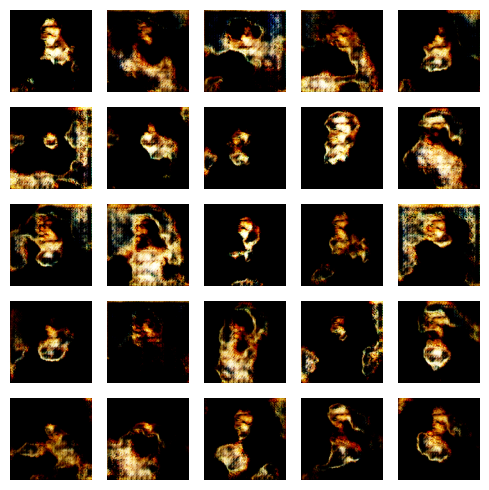

  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  0%|          | 1/3000 [00:00<23:45,  2.10it/s]

1/1 [==============================] - 0s 49ms/step


  0%|          | 2/3000 [00:00<22:04,  2.26it/s]

1/1 [==============================] - 0s 87ms/step


  0%|          | 3/3000 [00:01<22:21,  2.23it/s]

1/1 [==============================] - 0s 58ms/step


  0%|          | 4/3000 [00:01<22:52,  2.18it/s]

1/1 [==============================] - 0s 69ms/step


  0%|          | 5/3000 [00:02<31:52,  1.57it/s]

1/1 [==============================] - 0s 46ms/step


  0%|          | 6/3000 [00:03<28:17,  1.76it/s]

1/1 [==============================] - 0s 47ms/step


  0%|          | 7/3000 [00:03<26:00,  1.92it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 8/3000 [00:04<24:55,  2.00it/s]

1/1 [==============================] - 0s 46ms/step


  0%|          | 9/3000 [00:04<22:53,  2.18it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 10/3000 [00:04<21:18,  2.34it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 11/3000 [00:05<19:56,  2.50it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 12/3000 [00:05<19:56,  2.50it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 13/3000 [00:05<19:23,  2.57it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 14/3000 [00:06<18:59,  2.62it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 15/3000 [00:06<19:02,  2.61it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 16/3000 [00:07<19:05,  2.60it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 17/3000 [00:07<18:24,  2.70it/s]

1/1 [==============================] - 0s 52ms/step


  1%|          | 18/3000 [00:07<19:12,  2.59it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 19/3000 [00:08<19:40,  2.52it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 20/3000 [00:08<19:12,  2.59it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 21/3000 [00:08<18:47,  2.64it/s]

1/1 [==============================] - 0s 43ms/step


  1%|          | 22/3000 [00:09<18:32,  2.68it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 23/3000 [00:09<19:13,  2.58it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 24/3000 [00:10<19:37,  2.53it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 25/3000 [00:10<19:44,  2.51it/s]

1/1 [==============================] - 0s 45ms/step


  1%|          | 26/3000 [00:10<20:18,  2.44it/s]

1/1 [==============================] - 0s 42ms/step


  1%|          | 27/3000 [00:11<20:28,  2.42it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 28/3000 [00:11<20:09,  2.46it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 29/3000 [00:12<19:49,  2.50it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 30/3000 [00:12<19:12,  2.58it/s]

1/1 [==============================] - 0s 53ms/step


  1%|          | 31/3000 [00:12<19:27,  2.54it/s]

1/1 [==============================] - 0s 64ms/step


  1%|          | 32/3000 [00:13<20:19,  2.43it/s]

1/1 [==============================] - 0s 52ms/step


  1%|          | 33/3000 [00:13<21:29,  2.30it/s]

1/1 [==============================] - 0s 80ms/step


  1%|          | 34/3000 [00:14<22:17,  2.22it/s]

1/1 [==============================] - 0s 49ms/step


  1%|          | 35/3000 [00:14<23:53,  2.07it/s]

1/1 [==============================] - 0s 53ms/step


  1%|          | 36/3000 [00:15<23:41,  2.09it/s]

1/1 [==============================] - 0s 45ms/step


  1%|          | 37/3000 [00:15<23:05,  2.14it/s]

1/1 [==============================] - 0s 53ms/step


  1%|▏         | 38/3000 [00:16<22:22,  2.21it/s]

1/1 [==============================] - 0s 51ms/step


  1%|▏         | 39/3000 [00:16<22:00,  2.24it/s]

1/1 [==============================] - 0s 43ms/step


  1%|▏         | 40/3000 [00:17<21:56,  2.25it/s]

1/1 [==============================] - 0s 60ms/step


  1%|▏         | 41/3000 [00:17<24:40,  2.00it/s]

1/1 [==============================] - 0s 68ms/step


  1%|▏         | 42/3000 [00:18<23:52,  2.06it/s]

1/1 [==============================] - 0s 42ms/step


  1%|▏         | 43/3000 [00:18<22:08,  2.23it/s]

1/1 [==============================] - 0s 40ms/step


  1%|▏         | 44/3000 [00:18<21:09,  2.33it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 45/3000 [00:19<20:57,  2.35it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 46/3000 [00:19<20:00,  2.46it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 47/3000 [00:20<19:15,  2.56it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 48/3000 [00:20<19:15,  2.55it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 49/3000 [00:20<18:40,  2.63it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 50/3000 [00:21<18:27,  2.66it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 51/3000 [00:21<18:19,  2.68it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 52/3000 [00:22<18:59,  2.59it/s]

1/1 [==============================] - 0s 48ms/step


  2%|▏         | 53/3000 [00:22<19:39,  2.50it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 54/3000 [00:22<20:10,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 55/3000 [00:23<19:26,  2.52it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 56/3000 [00:23<19:05,  2.57it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 57/3000 [00:24<19:12,  2.55it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 58/3000 [00:24<19:41,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 59/3000 [00:24<19:52,  2.47it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 60/3000 [00:25<19:47,  2.48it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 61/3000 [00:25<19:43,  2.48it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 62/3000 [00:25<18:55,  2.59it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 63/3000 [00:26<18:27,  2.65it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 64/3000 [00:26<18:38,  2.62it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 65/3000 [00:27<17:59,  2.72it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 66/3000 [00:27<19:09,  2.55it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 67/3000 [00:27<18:36,  2.63it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 68/3000 [00:28<19:20,  2.53it/s]

1/1 [==============================] - 0s 59ms/step


  2%|▏         | 69/3000 [00:28<22:11,  2.20it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 70/3000 [00:29<22:28,  2.17it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 71/3000 [00:29<22:18,  2.19it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 72/3000 [00:30<21:36,  2.26it/s]

1/1 [==============================] - 0s 67ms/step


  2%|▏         | 73/3000 [00:30<21:24,  2.28it/s]

1/1 [==============================] - 0s 58ms/step


  2%|▏         | 74/3000 [00:31<22:17,  2.19it/s]

1/1 [==============================] - 0s 65ms/step


  2%|▎         | 75/3000 [00:31<22:40,  2.15it/s]

1/1 [==============================] - 0s 51ms/step


  3%|▎         | 76/3000 [00:32<22:29,  2.17it/s]

1/1 [==============================] - 0s 59ms/step


  3%|▎         | 77/3000 [00:32<22:00,  2.21it/s]

1/1 [==============================] - 0s 57ms/step


  3%|▎         | 78/3000 [00:32<21:53,  2.22it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 79/3000 [00:33<22:17,  2.18it/s]

1/1 [==============================] - 0s 72ms/step


  3%|▎         | 80/3000 [00:33<22:05,  2.20it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 81/3000 [00:34<20:43,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 82/3000 [00:34<20:45,  2.34it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 83/3000 [00:35<19:45,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 84/3000 [00:35<18:59,  2.56it/s]

1/1 [==============================] - 0s 53ms/step


  3%|▎         | 85/3000 [00:35<19:19,  2.51it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 86/3000 [00:36<19:15,  2.52it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 87/3000 [00:36<18:36,  2.61it/s]

1/1 [==============================] - 0s 48ms/step


  3%|▎         | 88/3000 [00:36<19:11,  2.53it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 89/3000 [00:37<18:37,  2.61it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 90/3000 [00:37<18:16,  2.65it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 91/3000 [00:38<17:59,  2.69it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 92/3000 [00:38<18:23,  2.63it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 93/3000 [00:38<18:35,  2.60it/s]

1/1 [==============================] - 0s 46ms/step


  3%|▎         | 94/3000 [00:39<18:41,  2.59it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 95/3000 [00:39<18:43,  2.58it/s]

1/1 [==============================] - 0s 49ms/step


  3%|▎         | 96/3000 [00:40<18:54,  2.56it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 97/3000 [00:40<18:20,  2.64it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 98/3000 [00:40<18:24,  2.63it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 99/3000 [00:41<18:06,  2.67it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 100/3000 [00:41<18:50,  2.56it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 101/3000 [00:41<19:18,  2.50it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 102/3000 [00:42<19:13,  2.51it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 103/3000 [00:42<19:57,  2.42it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 104/3000 [00:43<19:11,  2.51it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▎         | 105/3000 [00:43<18:13,  2.65it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▎         | 106/3000 [00:43<18:15,  2.64it/s]

1/1 [==============================] - 0s 75ms/step


  4%|▎         | 107/3000 [00:44<21:12,  2.27it/s]

1/1 [==============================] - 0s 47ms/step


  4%|▎         | 108/3000 [00:44<21:55,  2.20it/s]

1/1 [==============================] - 0s 75ms/step


  4%|▎         | 109/3000 [00:45<22:25,  2.15it/s]

1/1 [==============================] - 0s 49ms/step


  4%|▎         | 110/3000 [00:45<22:12,  2.17it/s]

1/1 [==============================] - 0s 45ms/step


  4%|▎         | 111/3000 [00:46<22:31,  2.14it/s]

1/1 [==============================] - 0s 45ms/step


  4%|▎         | 112/3000 [00:46<21:18,  2.26it/s]

1/1 [==============================] - 0s 80ms/step


  4%|▍         | 113/3000 [00:47<21:01,  2.29it/s]

1/1 [==============================] - 0s 61ms/step


  4%|▍         | 114/3000 [00:47<21:12,  2.27it/s]

1/1 [==============================] - 0s 44ms/step


  4%|▍         | 115/3000 [00:48<21:36,  2.23it/s]

1/1 [==============================] - 0s 47ms/step


  4%|▍         | 116/3000 [00:48<21:36,  2.23it/s]

1/1 [==============================] - 0s 53ms/step


  4%|▍         | 117/3000 [00:48<21:13,  2.26it/s]

1/1 [==============================] - 0s 76ms/step


  4%|▍         | 118/3000 [00:49<21:33,  2.23it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 119/3000 [00:49<20:12,  2.38it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▍         | 120/3000 [00:50<19:19,  2.48it/s]

1/1 [==============================] - 0s 44ms/step


  4%|▍         | 121/3000 [00:50<19:09,  2.50it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 122/3000 [00:50<19:33,  2.45it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 123/3000 [00:51<18:47,  2.55it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 124/3000 [00:51<18:39,  2.57it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 125/3000 [00:52<18:17,  2.62it/s]

1/1 [==============================] - 0s 47ms/step


  4%|▍         | 126/3000 [00:52<18:49,  2.54it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 127/3000 [00:52<18:24,  2.60it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 128/3000 [00:53<17:56,  2.67it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 129/3000 [00:53<17:37,  2.71it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 130/3000 [00:53<17:56,  2.67it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 131/3000 [00:54<17:47,  2.69it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 132/3000 [00:54<17:31,  2.73it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 133/3000 [00:55<17:25,  2.74it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 134/3000 [00:55<18:11,  2.63it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 135/3000 [00:55<17:39,  2.70it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▍         | 136/3000 [00:56<17:58,  2.66it/s]

1/1 [==============================] - 0s 52ms/step


  5%|▍         | 137/3000 [00:56<17:54,  2.67it/s]

1/1 [==============================] - 0s 43ms/step


  5%|▍         | 138/3000 [00:56<18:09,  2.63it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 139/3000 [00:57<18:16,  2.61it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 140/3000 [00:57<18:00,  2.65it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 141/3000 [00:58<17:52,  2.67it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▍         | 142/3000 [00:58<17:35,  2.71it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▍         | 143/3000 [00:58<17:33,  2.71it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▍         | 144/3000 [00:59<18:12,  2.61it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 145/3000 [00:59<19:01,  2.50it/s]

1/1 [==============================] - 0s 48ms/step


  5%|▍         | 146/3000 [01:00<18:59,  2.50it/s]

1/1 [==============================] - 0s 87ms/step


  5%|▍         | 147/3000 [01:00<19:42,  2.41it/s]

1/1 [==============================] - 0s 62ms/step


  5%|▍         | 148/3000 [01:01<22:19,  2.13it/s]

1/1 [==============================] - 0s 53ms/step


  5%|▍         | 149/3000 [01:01<21:38,  2.20it/s]

1/1 [==============================] - 0s 62ms/step


  5%|▌         | 150/3000 [01:01<21:04,  2.25it/s]

1/1 [==============================] - 0s 70ms/step


  5%|▌         | 151/3000 [01:02<20:57,  2.27it/s]

1/1 [==============================] - 0s 70ms/step


  5%|▌         | 152/3000 [01:03<23:29,  2.02it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 153/3000 [01:03<22:52,  2.07it/s]

1/1 [==============================] - 0s 55ms/step


  5%|▌         | 154/3000 [01:03<22:25,  2.12it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 155/3000 [01:04<21:26,  2.21it/s]

1/1 [==============================] - 0s 53ms/step


  5%|▌         | 156/3000 [01:04<21:35,  2.19it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 157/3000 [01:05<21:43,  2.18it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 158/3000 [01:05<20:34,  2.30it/s]

1/1 [==============================] - 0s 52ms/step


  5%|▌         | 159/3000 [01:06<20:26,  2.32it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 160/3000 [01:06<19:21,  2.44it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 161/3000 [01:06<19:28,  2.43it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 162/3000 [01:07<18:34,  2.55it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 163/3000 [01:07<18:33,  2.55it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 164/3000 [01:07<18:31,  2.55it/s]

1/1 [==============================] - 0s 42ms/step


  6%|▌         | 165/3000 [01:08<18:12,  2.60it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 166/3000 [01:08<18:15,  2.59it/s]

1/1 [==============================] - 0s 53ms/step


  6%|▌         | 167/3000 [01:09<18:32,  2.55it/s]

1/1 [==============================] - 0s 43ms/step


  6%|▌         | 168/3000 [01:09<18:57,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 169/3000 [01:09<18:18,  2.58it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 170/3000 [01:10<18:41,  2.52it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 171/3000 [01:10<18:03,  2.61it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 172/3000 [01:11<18:37,  2.53it/s]

1/1 [==============================] - 0s 46ms/step


  6%|▌         | 173/3000 [01:11<18:20,  2.57it/s]

1/1 [==============================] - 0s 43ms/step


  6%|▌         | 174/3000 [01:11<18:25,  2.56it/s]

1/1 [==============================] - 0s 43ms/step


  6%|▌         | 175/3000 [01:12<18:12,  2.59it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 176/3000 [01:12<17:22,  2.71it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 177/3000 [01:12<17:54,  2.63it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 178/3000 [01:13<18:22,  2.56it/s]

1/1 [==============================] - 0s 42ms/step


  6%|▌         | 179/3000 [01:13<18:21,  2.56it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 180/3000 [01:14<18:24,  2.55it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 181/3000 [01:14<18:44,  2.51it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 182/3000 [01:14<18:06,  2.59it/s]

1/1 [==============================] - 0s 51ms/step


  6%|▌         | 183/3000 [01:15<18:05,  2.59it/s]

1/1 [==============================] - 0s 70ms/step


  6%|▌         | 184/3000 [01:15<18:11,  2.58it/s]

1/1 [==============================] - 0s 78ms/step


  6%|▌         | 185/3000 [01:16<18:50,  2.49it/s]

1/1 [==============================] - 0s 56ms/step


  6%|▌         | 186/3000 [01:16<18:58,  2.47it/s]

1/1 [==============================] - 0s 67ms/step


  6%|▌         | 187/3000 [01:17<22:13,  2.11it/s]

1/1 [==============================] - 0s 66ms/step


  6%|▋         | 188/3000 [01:17<21:27,  2.18it/s]

1/1 [==============================] - 0s 61ms/step


  6%|▋         | 189/3000 [01:18<20:38,  2.27it/s]

1/1 [==============================] - 0s 51ms/step


  6%|▋         | 190/3000 [01:18<20:43,  2.26it/s]

1/1 [==============================] - 0s 45ms/step


  6%|▋         | 191/3000 [01:18<20:15,  2.31it/s]

1/1 [==============================] - 0s 65ms/step


  6%|▋         | 192/3000 [01:19<21:09,  2.21it/s]

1/1 [==============================] - 0s 65ms/step


  6%|▋         | 193/3000 [01:19<20:47,  2.25it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▋         | 194/3000 [01:20<20:16,  2.31it/s]

1/1 [==============================] - 0s 55ms/step


  6%|▋         | 195/3000 [01:20<21:04,  2.22it/s]

1/1 [==============================] - 0s 62ms/step


  7%|▋         | 196/3000 [01:21<21:11,  2.20it/s]

1/1 [==============================] - 0s 69ms/step


  7%|▋         | 197/3000 [01:21<21:40,  2.16it/s]

1/1 [==============================] - 0s 63ms/step


  7%|▋         | 198/3000 [01:22<21:50,  2.14it/s]

1/1 [==============================] - 0s 63ms/step


  7%|▋         | 199/3000 [01:22<21:54,  2.13it/s]

1/1 [==============================] - 0s 92ms/step


  7%|▋         | 200/3000 [01:23<22:24,  2.08it/s]

1/1 [==============================] - 0s 53ms/step


  7%|▋         | 201/3000 [01:23<21:36,  2.16it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 202/3000 [01:23<20:56,  2.23it/s]

1/1 [==============================] - 0s 82ms/step


  7%|▋         | 203/3000 [01:24<21:09,  2.20it/s]

1/1 [==============================] - 0s 55ms/step


  7%|▋         | 204/3000 [01:24<20:50,  2.24it/s]

1/1 [==============================] - 0s 62ms/step


  7%|▋         | 205/3000 [01:25<20:25,  2.28it/s]

1/1 [==============================] - 0s 66ms/step


  7%|▋         | 206/3000 [01:25<20:58,  2.22it/s]

1/1 [==============================] - 0s 43ms/step


  7%|▋         | 207/3000 [01:26<21:11,  2.20it/s]

1/1 [==============================] - 0s 66ms/step


  7%|▋         | 208/3000 [01:26<21:01,  2.21it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 209/3000 [01:27<19:33,  2.38it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 210/3000 [01:27<18:42,  2.49it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 211/3000 [01:27<18:06,  2.57it/s]

1/1 [==============================] - 0s 44ms/step


  7%|▋         | 212/3000 [01:28<17:24,  2.67it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 213/3000 [01:28<17:58,  2.58it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 214/3000 [01:28<17:32,  2.65it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 215/3000 [01:29<16:58,  2.73it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 216/3000 [01:29<16:50,  2.75it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 217/3000 [01:29<17:34,  2.64it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 218/3000 [01:30<18:12,  2.55it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 219/3000 [01:30<17:38,  2.63it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 220/3000 [01:31<17:50,  2.60it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 221/3000 [01:31<17:29,  2.65it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 222/3000 [01:31<18:01,  2.57it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 223/3000 [01:32<18:20,  2.52it/s]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 224/3000 [01:32<18:17,  2.53it/s]

1/1 [==============================] - 0s 69ms/step


  8%|▊         | 225/3000 [01:33<19:18,  2.40it/s]

1/1 [==============================] - 0s 56ms/step


  8%|▊         | 226/3000 [01:33<20:00,  2.31it/s]

1/1 [==============================] - 0s 46ms/step


  8%|▊         | 227/3000 [01:34<19:32,  2.36it/s]

1/1 [==============================] - 0s 76ms/step


  8%|▊         | 228/3000 [01:34<20:01,  2.31it/s]

1/1 [==============================] - 0s 64ms/step


  8%|▊         | 229/3000 [01:34<19:37,  2.35it/s]

1/1 [==============================] - 0s 67ms/step


  8%|▊         | 230/3000 [01:35<19:34,  2.36it/s]

1/1 [==============================] - 0s 53ms/step


  8%|▊         | 231/3000 [01:35<19:16,  2.40it/s]

1/1 [==============================] - 0s 69ms/step


  8%|▊         | 232/3000 [01:36<19:21,  2.38it/s]

1/1 [==============================] - 0s 73ms/step


  8%|▊         | 233/3000 [01:36<19:24,  2.38it/s]

1/1 [==============================] - 0s 63ms/step


  8%|▊         | 234/3000 [01:37<19:55,  2.31it/s]

1/1 [==============================] - 0s 63ms/step


  8%|▊         | 235/3000 [01:37<19:52,  2.32it/s]

1/1 [==============================] - 0s 55ms/step


  8%|▊         | 236/3000 [01:37<20:10,  2.28it/s]

1/1 [==============================] - 0s 62ms/step


  8%|▊         | 237/3000 [01:38<19:35,  2.35it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 238/3000 [01:38<19:16,  2.39it/s]

1/1 [==============================] - 0s 53ms/step


  8%|▊         | 239/3000 [01:39<18:41,  2.46it/s]

1/1 [==============================] - 0s 47ms/step


  8%|▊         | 240/3000 [01:39<18:33,  2.48it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 241/3000 [01:39<18:49,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 242/3000 [01:40<18:52,  2.43it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 243/3000 [01:40<18:03,  2.54it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 244/3000 [01:41<18:20,  2.50it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 245/3000 [01:41<17:52,  2.57it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 246/3000 [01:41<17:52,  2.57it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 247/3000 [01:42<17:32,  2.62it/s]

1/1 [==============================] - 0s 44ms/step


  8%|▊         | 248/3000 [01:42<17:11,  2.67it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 249/3000 [01:42<17:47,  2.58it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 250/3000 [01:43<18:07,  2.53it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 251/3000 [01:43<17:41,  2.59it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 252/3000 [01:44<18:07,  2.53it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 253/3000 [01:44<18:01,  2.54it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 254/3000 [01:44<17:19,  2.64it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 255/3000 [01:45<17:52,  2.56it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▊         | 256/3000 [01:45<18:02,  2.53it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▊         | 257/3000 [01:46<17:56,  2.55it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▊         | 258/3000 [01:46<17:57,  2.54it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▊         | 259/3000 [01:46<17:23,  2.63it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▊         | 260/3000 [01:47<17:03,  2.68it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▊         | 261/3000 [01:47<17:16,  2.64it/s]

1/1 [==============================] - 0s 44ms/step


  9%|▊         | 262/3000 [01:47<17:00,  2.68it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▉         | 263/3000 [01:48<16:46,  2.72it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 264/3000 [01:48<16:40,  2.74it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 265/3000 [01:49<17:52,  2.55it/s]

1/1 [==============================] - 0s 43ms/step


  9%|▉         | 266/3000 [01:49<18:02,  2.53it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 267/3000 [01:49<18:02,  2.52it/s]

1/1 [==============================] - 0s 53ms/step


  9%|▉         | 268/3000 [01:50<18:54,  2.41it/s]

1/1 [==============================] - 0s 56ms/step


  9%|▉         | 269/3000 [01:50<19:59,  2.28it/s]

1/1 [==============================] - 0s 57ms/step


  9%|▉         | 270/3000 [01:51<22:03,  2.06it/s]

1/1 [==============================] - 0s 62ms/step


  9%|▉         | 271/3000 [01:51<21:23,  2.13it/s]

1/1 [==============================] - 0s 58ms/step


  9%|▉         | 272/3000 [01:52<20:20,  2.23it/s]

1/1 [==============================] - 0s 44ms/step


  9%|▉         | 273/3000 [01:52<22:04,  2.06it/s]

1/1 [==============================] - 0s 58ms/step


  9%|▉         | 274/3000 [01:53<22:01,  2.06it/s]

1/1 [==============================] - 0s 46ms/step


  9%|▉         | 275/3000 [01:54<23:50,  1.90it/s]

1/1 [==============================] - 0s 52ms/step


  9%|▉         | 276/3000 [01:54<23:01,  1.97it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 277/3000 [01:54<21:28,  2.11it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▉         | 278/3000 [01:55<20:17,  2.24it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 279/3000 [01:55<19:26,  2.33it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 280/3000 [01:56<19:21,  2.34it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▉         | 281/3000 [01:56<18:54,  2.40it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 282/3000 [01:56<18:32,  2.44it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 283/3000 [01:57<18:48,  2.41it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▉         | 284/3000 [01:57<17:58,  2.52it/s]

1/1 [==============================] - 0s 40ms/step


 10%|▉         | 285/3000 [01:58<17:51,  2.53it/s]

1/1 [==============================] - 0s 41ms/step


 10%|▉         | 286/3000 [01:58<18:10,  2.49it/s]

1/1 [==============================] - 0s 40ms/step


 10%|▉         | 287/3000 [01:58<17:57,  2.52it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 288/3000 [01:59<18:24,  2.46it/s]

1/1 [==============================] - 0s 41ms/step


 10%|▉         | 289/3000 [01:59<17:27,  2.59it/s]

1/1 [==============================] - 0s 42ms/step


 10%|▉         | 290/3000 [02:00<17:49,  2.53it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 291/3000 [02:00<17:14,  2.62it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 292/3000 [02:00<17:39,  2.56it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 293/3000 [02:01<17:54,  2.52it/s]

1/1 [==============================] - 0s 45ms/step


 10%|▉         | 294/3000 [02:01<17:49,  2.53it/s]

1/1 [==============================] - 0s 40ms/step


 10%|▉         | 295/3000 [02:01<18:11,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 296/3000 [02:02<17:36,  2.56it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 297/3000 [02:02<17:30,  2.57it/s]

1/1 [==============================] - 0s 40ms/step


 10%|▉         | 298/3000 [02:03<17:07,  2.63it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 299/3000 [02:03<17:33,  2.56it/s]

1/1 [==============================] - 0s 45ms/step


 10%|█         | 300/3000 [02:03<18:00,  2.50it/s]

1/1 [==============================] - 0s 44ms/step


 10%|█         | 301/3000 [02:04<18:16,  2.46it/s]

1/1 [==============================] - 0s 64ms/step


 10%|█         | 302/3000 [02:04<18:43,  2.40it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 303/3000 [02:05<18:41,  2.40it/s]

1/1 [==============================] - 0s 49ms/step


 10%|█         | 304/3000 [02:05<19:11,  2.34it/s]

1/1 [==============================] - 0s 58ms/step


 10%|█         | 305/3000 [02:06<19:51,  2.26it/s]

1/1 [==============================] - 0s 51ms/step


 10%|█         | 306/3000 [02:06<19:19,  2.32it/s]

1/1 [==============================] - 0s 105ms/step


 10%|█         | 307/3000 [02:07<19:45,  2.27it/s]

1/1 [==============================] - 0s 77ms/step


 10%|█         | 308/3000 [02:07<20:05,  2.23it/s]

1/1 [==============================] - 0s 70ms/step


 10%|█         | 309/3000 [02:07<19:37,  2.29it/s]

1/1 [==============================] - 0s 57ms/step


 10%|█         | 310/3000 [02:08<20:37,  2.17it/s]

1/1 [==============================] - 0s 57ms/step


 10%|█         | 311/3000 [02:08<19:58,  2.24it/s]

1/1 [==============================] - 0s 79ms/step


 10%|█         | 312/3000 [02:09<19:37,  2.28it/s]

1/1 [==============================] - 0s 77ms/step


 10%|█         | 313/3000 [02:09<19:31,  2.29it/s]

1/1 [==============================] - 0s 64ms/step


 10%|█         | 314/3000 [02:10<19:17,  2.32it/s]

1/1 [==============================] - 0s 57ms/step


 10%|█         | 315/3000 [02:10<19:16,  2.32it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 316/3000 [02:10<18:12,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 317/3000 [02:11<17:29,  2.56it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 318/3000 [02:11<18:01,  2.48it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 319/3000 [02:12<18:11,  2.46it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█         | 320/3000 [02:12<18:48,  2.38it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 321/3000 [02:12<17:54,  2.49it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 322/3000 [02:13<17:15,  2.59it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 323/3000 [02:13<16:52,  2.65it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 324/3000 [02:13<16:59,  2.63it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 325/3000 [02:14<17:08,  2.60it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 326/3000 [02:14<17:21,  2.57it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 327/3000 [02:15<17:40,  2.52it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█         | 328/3000 [02:15<17:54,  2.49it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 329/3000 [02:16<18:03,  2.47it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 330/3000 [02:16<17:24,  2.56it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 331/3000 [02:16<17:20,  2.57it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█         | 332/3000 [02:17<17:24,  2.56it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 333/3000 [02:17<17:49,  2.49it/s]

1/1 [==============================] - 0s 46ms/step


 11%|█         | 334/3000 [02:17<17:32,  2.53it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 335/3000 [02:18<16:56,  2.62it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█         | 336/3000 [02:18<16:36,  2.67it/s]

1/1 [==============================] - 0s 44ms/step


 11%|█         | 337/3000 [02:19<17:20,  2.56it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█▏        | 338/3000 [02:19<17:20,  2.56it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█▏        | 339/3000 [02:19<17:02,  2.60it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█▏        | 340/3000 [02:20<17:10,  2.58it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█▏        | 341/3000 [02:20<17:38,  2.51it/s]

1/1 [==============================] - 0s 60ms/step


 11%|█▏        | 342/3000 [02:21<18:21,  2.41it/s]

1/1 [==============================] - 0s 61ms/step


 11%|█▏        | 343/3000 [02:21<18:25,  2.40it/s]

1/1 [==============================] - 0s 59ms/step


 11%|█▏        | 344/3000 [02:21<18:46,  2.36it/s]

1/1 [==============================] - 0s 60ms/step


 12%|█▏        | 345/3000 [02:22<20:40,  2.14it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 346/3000 [02:22<19:53,  2.22it/s]

1/1 [==============================] - 0s 67ms/step


 12%|█▏        | 347/3000 [02:23<20:33,  2.15it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█▏        | 348/3000 [02:23<20:05,  2.20it/s]

1/1 [==============================] - 0s 64ms/step


 12%|█▏        | 349/3000 [02:24<20:42,  2.13it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█▏        | 350/3000 [02:24<20:26,  2.16it/s]

1/1 [==============================] - 0s 68ms/step


 12%|█▏        | 351/3000 [02:25<19:49,  2.23it/s]

1/1 [==============================] - 0s 58ms/step


 12%|█▏        | 352/3000 [02:25<22:11,  1.99it/s]

1/1 [==============================] - 0s 58ms/step


 12%|█▏        | 353/3000 [02:26<21:07,  2.09it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 354/3000 [02:26<19:52,  2.22it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 355/3000 [02:27<19:08,  2.30it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▏        | 356/3000 [02:27<18:38,  2.36it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 357/3000 [02:27<18:15,  2.41it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 358/3000 [02:28<17:33,  2.51it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 359/3000 [02:28<17:45,  2.48it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 360/3000 [02:29<17:27,  2.52it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 361/3000 [02:29<18:06,  2.43it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█▏        | 362/3000 [02:29<18:02,  2.44it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█▏        | 363/3000 [02:30<17:22,  2.53it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 364/3000 [02:30<17:21,  2.53it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 365/3000 [02:31<17:41,  2.48it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 366/3000 [02:31<17:40,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 367/3000 [02:31<17:29,  2.51it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 368/3000 [02:32<17:45,  2.47it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▏        | 369/3000 [02:32<16:57,  2.59it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 370/3000 [02:32<16:31,  2.65it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█▏        | 371/3000 [02:33<16:59,  2.58it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 372/3000 [02:33<17:24,  2.52it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 373/3000 [02:34<16:54,  2.59it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 374/3000 [02:34<16:36,  2.64it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▎        | 375/3000 [02:34<16:59,  2.57it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 376/3000 [02:35<17:21,  2.52it/s]

1/1 [==============================] - 0s 48ms/step


 13%|█▎        | 377/3000 [02:35<16:50,  2.59it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 378/3000 [02:36<16:09,  2.70it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 379/3000 [02:36<17:24,  2.51it/s]

1/1 [==============================] - 0s 59ms/step


 13%|█▎        | 380/3000 [02:36<17:42,  2.47it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 381/3000 [02:37<17:57,  2.43it/s]

1/1 [==============================] - 0s 70ms/step


 13%|█▎        | 382/3000 [02:37<18:26,  2.37it/s]

1/1 [==============================] - 0s 52ms/step


 13%|█▎        | 383/3000 [02:38<19:02,  2.29it/s]

1/1 [==============================] - 0s 52ms/step


 13%|█▎        | 384/3000 [02:38<19:30,  2.23it/s]

1/1 [==============================] - 0s 43ms/step


 13%|█▎        | 385/3000 [02:39<19:46,  2.20it/s]

1/1 [==============================] - 0s 57ms/step


 13%|█▎        | 386/3000 [02:39<19:53,  2.19it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 387/3000 [02:40<18:59,  2.29it/s]

1/1 [==============================] - 0s 67ms/step


 13%|█▎        | 388/3000 [02:40<18:36,  2.34it/s]

1/1 [==============================] - 0s 43ms/step


 13%|█▎        | 389/3000 [02:40<19:22,  2.25it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 390/3000 [02:41<19:30,  2.23it/s]

1/1 [==============================] - 0s 48ms/step


 13%|█▎        | 391/3000 [02:41<18:56,  2.30it/s]

1/1 [==============================] - 0s 43ms/step


 13%|█▎        | 392/3000 [02:42<19:28,  2.23it/s]

1/1 [==============================] - 0s 51ms/step


 13%|█▎        | 393/3000 [02:42<18:36,  2.33it/s]

1/1 [==============================] - 0s 56ms/step


 13%|█▎        | 394/3000 [02:43<18:17,  2.37it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 395/3000 [02:43<17:36,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 396/3000 [02:43<17:45,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 397/3000 [02:44<17:53,  2.43it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 398/3000 [02:44<17:37,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 399/3000 [02:45<17:00,  2.55it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 400/3000 [02:45<17:16,  2.51it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 401/3000 [02:45<17:27,  2.48it/s]

1/1 [==============================] - 0s 43ms/step


 13%|█▎        | 402/3000 [02:46<17:40,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 403/3000 [02:46<17:50,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 404/3000 [02:47<17:54,  2.42it/s]

1/1 [==============================] - 0s 42ms/step


 14%|█▎        | 405/3000 [02:47<17:40,  2.45it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▎        | 406/3000 [02:47<16:55,  2.56it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▎        | 407/3000 [02:48<16:25,  2.63it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▎        | 408/3000 [02:48<16:35,  2.60it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▎        | 409/3000 [02:49<16:32,  2.61it/s]

1/1 [==============================] - 0s 42ms/step


 14%|█▎        | 410/3000 [02:49<16:56,  2.55it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▎        | 411/3000 [02:49<17:14,  2.50it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▎        | 412/3000 [02:50<17:35,  2.45it/s]

1/1 [==============================] - 0s 44ms/step


 14%|█▍        | 413/3000 [02:50<17:46,  2.43it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 414/3000 [02:51<16:59,  2.54it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 415/3000 [02:51<16:32,  2.60it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 416/3000 [02:51<16:34,  2.60it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 417/3000 [02:52<16:58,  2.54it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 418/3000 [02:52<16:28,  2.61it/s]

1/1 [==============================] - 0s 48ms/step


 14%|█▍        | 419/3000 [02:53<17:15,  2.49it/s]

1/1 [==============================] - 0s 52ms/step


 14%|█▍        | 420/3000 [02:53<17:05,  2.51it/s]

1/1 [==============================] - 0s 45ms/step


 14%|█▍        | 421/3000 [02:53<17:47,  2.42it/s]

1/1 [==============================] - 0s 46ms/step


 14%|█▍        | 422/3000 [02:54<17:43,  2.43it/s]

1/1 [==============================] - 0s 71ms/step


 14%|█▍        | 423/3000 [02:54<18:32,  2.32it/s]

1/1 [==============================] - 0s 46ms/step


 14%|█▍        | 424/3000 [02:55<18:14,  2.35it/s]

1/1 [==============================] - 0s 43ms/step


 14%|█▍        | 425/3000 [02:55<20:36,  2.08it/s]

1/1 [==============================] - 0s 71ms/step


 14%|█▍        | 426/3000 [02:56<19:57,  2.15it/s]

1/1 [==============================] - 0s 54ms/step


 14%|█▍        | 427/3000 [02:56<19:16,  2.22it/s]

1/1 [==============================] - 0s 58ms/step


 14%|█▍        | 428/3000 [02:57<19:13,  2.23it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 429/3000 [02:57<18:58,  2.26it/s]

1/1 [==============================] - 0s 43ms/step


 14%|█▍        | 430/3000 [02:57<18:28,  2.32it/s]

1/1 [==============================] - 0s 48ms/step


 14%|█▍        | 431/3000 [02:58<18:29,  2.32it/s]

1/1 [==============================] - 0s 57ms/step


 14%|█▍        | 432/3000 [02:58<18:08,  2.36it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 433/3000 [02:59<17:10,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 434/3000 [02:59<17:21,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 435/3000 [02:59<17:14,  2.48it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▍        | 436/3000 [03:00<16:43,  2.56it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 437/3000 [03:00<16:39,  2.56it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 438/3000 [03:01<17:00,  2.51it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▍        | 439/3000 [03:01<17:15,  2.47it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 440/3000 [03:01<17:10,  2.48it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 441/3000 [03:02<17:21,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 442/3000 [03:02<17:28,  2.44it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▍        | 443/3000 [03:03<17:11,  2.48it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 444/3000 [03:03<16:43,  2.55it/s]

1/1 [==============================] - 0s 50ms/step


 15%|█▍        | 445/3000 [03:03<17:14,  2.47it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▍        | 446/3000 [03:04<17:26,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 447/3000 [03:04<16:47,  2.53it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 448/3000 [03:05<16:17,  2.61it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▍        | 449/3000 [03:05<16:39,  2.55it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▌        | 450/3000 [03:05<16:44,  2.54it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▌        | 451/3000 [03:06<16:21,  2.60it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 452/3000 [03:06<16:06,  2.64it/s]

1/1 [==============================] - 0s 53ms/step


 15%|█▌        | 453/3000 [03:07<16:52,  2.51it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▌        | 454/3000 [03:07<16:31,  2.57it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 455/3000 [03:07<16:49,  2.52it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 456/3000 [03:08<16:19,  2.60it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 457/3000 [03:08<16:23,  2.59it/s]

1/1 [==============================] - 0s 45ms/step


 15%|█▌        | 458/3000 [03:08<16:43,  2.53it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▌        | 459/3000 [03:09<17:39,  2.40it/s]

1/1 [==============================] - 0s 45ms/step


 15%|█▌        | 460/3000 [03:09<18:17,  2.31it/s]

1/1 [==============================] - 0s 67ms/step


 15%|█▌        | 461/3000 [03:10<18:31,  2.28it/s]

1/1 [==============================] - 0s 61ms/step


 15%|█▌        | 462/3000 [03:10<19:59,  2.12it/s]

1/1 [==============================] - 0s 58ms/step


 15%|█▌        | 463/3000 [03:11<19:03,  2.22it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▌        | 464/3000 [03:11<18:49,  2.24it/s]

1/1 [==============================] - 0s 69ms/step


 16%|█▌        | 465/3000 [03:12<18:40,  2.26it/s]

1/1 [==============================] - 0s 54ms/step


 16%|█▌        | 466/3000 [03:12<19:11,  2.20it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▌        | 467/3000 [03:13<18:50,  2.24it/s]

1/1 [==============================] - 0s 61ms/step


 16%|█▌        | 468/3000 [03:13<18:39,  2.26it/s]

1/1 [==============================] - 0s 59ms/step


 16%|█▌        | 469/3000 [03:13<18:28,  2.28it/s]

1/1 [==============================] - 0s 61ms/step


 16%|█▌        | 470/3000 [03:14<18:52,  2.23it/s]

1/1 [==============================] - 0s 83ms/step


 16%|█▌        | 471/3000 [03:14<19:01,  2.22it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 472/3000 [03:15<18:22,  2.29it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 473/3000 [03:15<18:05,  2.33it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▌        | 474/3000 [03:16<17:08,  2.46it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█▌        | 475/3000 [03:16<16:43,  2.52it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 476/3000 [03:16<17:00,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 477/3000 [03:17<16:37,  2.53it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▌        | 478/3000 [03:17<16:06,  2.61it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 479/3000 [03:17<16:29,  2.55it/s]

1/1 [==============================] - 0s 44ms/step


 16%|█▌        | 480/3000 [03:18<16:02,  2.62it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 481/3000 [03:18<15:41,  2.67it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 482/3000 [03:19<15:27,  2.71it/s]

1/1 [==============================] - 0s 49ms/step


 16%|█▌        | 483/3000 [03:19<15:28,  2.71it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 484/3000 [03:19<15:49,  2.65it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 485/3000 [03:20<16:07,  2.60it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 486/3000 [03:20<15:41,  2.67it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 487/3000 [03:20<16:29,  2.54it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█▋        | 488/3000 [03:21<16:46,  2.50it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▋        | 489/3000 [03:21<16:21,  2.56it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█▋        | 490/3000 [03:22<16:23,  2.55it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▋        | 491/3000 [03:22<16:58,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▋        | 492/3000 [03:23<16:47,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▋        | 493/3000 [03:23<16:59,  2.46it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▋        | 494/3000 [03:23<17:03,  2.45it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▋        | 495/3000 [03:24<16:42,  2.50it/s]

1/1 [==============================] - 0s 50ms/step


 17%|█▋        | 496/3000 [03:24<16:47,  2.49it/s]

1/1 [==============================] - 0s 57ms/step


 17%|█▋        | 497/3000 [03:25<17:20,  2.41it/s]

1/1 [==============================] - 0s 55ms/step


 17%|█▋        | 498/3000 [03:25<17:52,  2.33it/s]

1/1 [==============================] - 0s 68ms/step


 17%|█▋        | 499/3000 [03:25<17:39,  2.36it/s]

1/1 [==============================] - 0s 86ms/step


 17%|█▋        | 500/3000 [03:26<18:30,  2.25it/s]

1/1 [==============================] - 0s 84ms/step


 17%|█▋        | 501/3000 [03:26<18:49,  2.21it/s]

1/1 [==============================] - 0s 68ms/step


 17%|█▋        | 502/3000 [03:27<18:25,  2.26it/s]

1/1 [==============================] - 0s 52ms/step


 17%|█▋        | 503/3000 [03:27<18:48,  2.21it/s]

1/1 [==============================] - 0s 49ms/step


 17%|█▋        | 504/3000 [03:28<18:22,  2.26it/s]

1/1 [==============================] - 0s 55ms/step


 17%|█▋        | 505/3000 [03:28<20:43,  2.01it/s]

1/1 [==============================] - 0s 58ms/step


 17%|█▋        | 506/3000 [03:29<19:43,  2.11it/s]

1/1 [==============================] - 0s 63ms/step


 17%|█▋        | 507/3000 [03:29<19:00,  2.19it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 508/3000 [03:30<19:11,  2.16it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 509/3000 [03:30<19:07,  2.17it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 510/3000 [03:30<17:33,  2.36it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 511/3000 [03:31<17:14,  2.41it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 512/3000 [03:31<16:30,  2.51it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 513/3000 [03:32<16:18,  2.54it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 514/3000 [03:32<16:31,  2.51it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 515/3000 [03:32<16:40,  2.48it/s]

1/1 [==============================] - 0s 45ms/step


 17%|█▋        | 516/3000 [03:33<16:10,  2.56it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 517/3000 [03:33<15:46,  2.62it/s]

1/1 [==============================] - 0s 44ms/step


 17%|█▋        | 518/3000 [03:34<15:58,  2.59it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 519/3000 [03:34<16:25,  2.52it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 520/3000 [03:34<16:17,  2.54it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 521/3000 [03:35<16:10,  2.55it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 522/3000 [03:35<15:43,  2.63it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 523/3000 [03:35<16:06,  2.56it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 524/3000 [03:36<16:13,  2.54it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 525/3000 [03:36<16:26,  2.51it/s]

1/1 [==============================] - 0s 43ms/step


 18%|█▊        | 526/3000 [03:37<16:38,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 527/3000 [03:37<15:46,  2.61it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 528/3000 [03:37<16:09,  2.55it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 529/3000 [03:38<16:24,  2.51it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 530/3000 [03:38<15:57,  2.58it/s]

1/1 [==============================] - 0s 47ms/step


 18%|█▊        | 531/3000 [03:39<16:39,  2.47it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 532/3000 [03:39<16:25,  2.50it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 533/3000 [03:39<16:18,  2.52it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 534/3000 [03:40<16:31,  2.49it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 535/3000 [03:40<17:03,  2.41it/s]

1/1 [==============================] - 0s 63ms/step


 18%|█▊        | 536/3000 [03:41<17:49,  2.30it/s]

1/1 [==============================] - 0s 60ms/step


 18%|█▊        | 537/3000 [03:41<17:34,  2.34it/s]

1/1 [==============================] - 0s 63ms/step


 18%|█▊        | 538/3000 [03:42<18:02,  2.28it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 539/3000 [03:42<17:56,  2.29it/s]

1/1 [==============================] - 0s 58ms/step


 18%|█▊        | 540/3000 [03:43<17:24,  2.36it/s]

1/1 [==============================] - 0s 66ms/step


 18%|█▊        | 541/3000 [03:43<17:19,  2.37it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 542/3000 [03:44<19:14,  2.13it/s]

1/1 [==============================] - 0s 64ms/step


 18%|█▊        | 543/3000 [03:44<19:17,  2.12it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 544/3000 [03:44<19:09,  2.14it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 545/3000 [03:45<18:06,  2.26it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 546/3000 [03:45<18:25,  2.22it/s]

1/1 [==============================] - 0s 49ms/step


 18%|█▊        | 547/3000 [03:46<18:42,  2.18it/s]

1/1 [==============================] - 0s 71ms/step


 18%|█▊        | 548/3000 [03:46<18:32,  2.20it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 549/3000 [03:47<18:00,  2.27it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 550/3000 [03:47<17:38,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 551/3000 [03:47<17:24,  2.34it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 552/3000 [03:48<16:59,  2.40it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 553/3000 [03:48<16:41,  2.44it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 554/3000 [03:49<16:27,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 555/3000 [03:49<16:35,  2.46it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▊        | 556/3000 [03:49<16:41,  2.44it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▊        | 557/3000 [03:50<16:51,  2.41it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▊        | 558/3000 [03:50<16:04,  2.53it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▊        | 559/3000 [03:51<16:18,  2.50it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▊        | 560/3000 [03:51<16:27,  2.47it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▊        | 561/3000 [03:51<16:33,  2.45it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▊        | 562/3000 [03:52<15:45,  2.58it/s]

1/1 [==============================] - 0s 49ms/step


 19%|█▉        | 563/3000 [03:52<16:10,  2.51it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 564/3000 [03:53<16:20,  2.49it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 565/3000 [03:53<16:34,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 566/3000 [03:53<16:39,  2.44it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 567/3000 [03:54<16:25,  2.47it/s]

1/1 [==============================] - 0s 52ms/step


 19%|█▉        | 568/3000 [03:54<15:41,  2.58it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 569/3000 [03:55<15:35,  2.60it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 570/3000 [03:55<15:30,  2.61it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▉        | 571/3000 [03:55<15:43,  2.57it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▉        | 572/3000 [03:56<15:23,  2.63it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 573/3000 [03:56<15:11,  2.66it/s]

1/1 [==============================] - 0s 45ms/step


 19%|█▉        | 574/3000 [03:57<16:13,  2.49it/s]

1/1 [==============================] - 0s 63ms/step


 19%|█▉        | 575/3000 [03:57<16:33,  2.44it/s]

1/1 [==============================] - 0s 60ms/step


 19%|█▉        | 576/3000 [03:58<18:20,  2.20it/s]

1/1 [==============================] - 0s 64ms/step


 19%|█▉        | 577/3000 [03:58<18:00,  2.24it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▉        | 578/3000 [03:58<17:35,  2.30it/s]

1/1 [==============================] - 0s 64ms/step


 19%|█▉        | 579/3000 [03:59<17:59,  2.24it/s]

1/1 [==============================] - 0s 52ms/step


 19%|█▉        | 580/3000 [03:59<18:24,  2.19it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▉        | 581/3000 [04:00<18:45,  2.15it/s]

1/1 [==============================] - 0s 67ms/step


 19%|█▉        | 582/3000 [04:00<18:03,  2.23it/s]

1/1 [==============================] - 0s 62ms/step


 19%|█▉        | 583/3000 [04:01<18:21,  2.19it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 584/3000 [04:01<19:36,  2.05it/s]

1/1 [==============================] - 0s 53ms/step


 20%|█▉        | 585/3000 [04:02<19:17,  2.09it/s]

1/1 [==============================] - 0s 45ms/step


 20%|█▉        | 586/3000 [04:02<18:33,  2.17it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█▉        | 587/3000 [04:03<18:19,  2.20it/s]

1/1 [==============================] - 0s 45ms/step


 20%|█▉        | 588/3000 [04:03<18:06,  2.22it/s]

1/1 [==============================] - 0s 78ms/step


 20%|█▉        | 589/3000 [04:03<18:07,  2.22it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█▉        | 590/3000 [04:04<18:20,  2.19it/s]

1/1 [==============================] - 0s 63ms/step


 20%|█▉        | 591/3000 [04:04<18:28,  2.17it/s]

1/1 [==============================] - 0s 57ms/step


 20%|█▉        | 592/3000 [04:05<18:30,  2.17it/s]

1/1 [==============================] - 0s 42ms/step


 20%|█▉        | 593/3000 [04:05<18:24,  2.18it/s]

1/1 [==============================] - 0s 74ms/step


 20%|█▉        | 594/3000 [04:06<18:50,  2.13it/s]

1/1 [==============================] - 0s 60ms/step


 20%|█▉        | 595/3000 [04:06<18:23,  2.18it/s]

1/1 [==============================] - 0s 65ms/step


 20%|█▉        | 596/3000 [04:07<18:40,  2.15it/s]

1/1 [==============================] - 0s 64ms/step


 20%|█▉        | 597/3000 [04:07<17:59,  2.23it/s]

1/1 [==============================] - 0s 41ms/step


 20%|█▉        | 598/3000 [04:08<18:10,  2.20it/s]

1/1 [==============================] - 0s 67ms/step


 20%|█▉        | 599/3000 [04:08<18:34,  2.15it/s]

1/1 [==============================] - 0s 42ms/step


 20%|██        | 600/3000 [04:09<18:13,  2.20it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 601/3000 [04:09<17:30,  2.28it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 602/3000 [04:09<17:15,  2.32it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 603/3000 [04:10<16:15,  2.46it/s]

1/1 [==============================] - 0s 48ms/step


 20%|██        | 604/3000 [04:10<16:21,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 605/3000 [04:11<16:10,  2.47it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 606/3000 [04:11<16:24,  2.43it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██        | 607/3000 [04:11<16:22,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 608/3000 [04:12<16:32,  2.41it/s]

1/1 [==============================] - 0s 55ms/step


 20%|██        | 609/3000 [04:12<16:33,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 610/3000 [04:13<16:38,  2.39it/s]

1/1 [==============================] - 0s 48ms/step


 20%|██        | 611/3000 [04:13<16:26,  2.42it/s]

1/1 [==============================] - 0s 68ms/step


 20%|██        | 612/3000 [04:14<18:27,  2.16it/s]

1/1 [==============================] - 0s 59ms/step


 20%|██        | 613/3000 [04:14<17:52,  2.23it/s]

1/1 [==============================] - 0s 82ms/step


 20%|██        | 614/3000 [04:15<18:28,  2.15it/s]

1/1 [==============================] - 0s 51ms/step


 20%|██        | 615/3000 [04:15<17:34,  2.26it/s]

1/1 [==============================] - 0s 43ms/step


 21%|██        | 616/3000 [04:15<17:25,  2.28it/s]

1/1 [==============================] - 0s 65ms/step


 21%|██        | 617/3000 [04:16<18:08,  2.19it/s]

1/1 [==============================] - 0s 52ms/step


 21%|██        | 618/3000 [04:16<17:57,  2.21it/s]

1/1 [==============================] - 0s 43ms/step


 21%|██        | 619/3000 [04:17<17:20,  2.29it/s]

1/1 [==============================] - 0s 62ms/step


 21%|██        | 620/3000 [04:17<17:24,  2.28it/s]

1/1 [==============================] - 0s 45ms/step


 21%|██        | 621/3000 [04:18<17:52,  2.22it/s]

1/1 [==============================] - 0s 52ms/step


 21%|██        | 622/3000 [04:18<17:08,  2.31it/s]

1/1 [==============================] - 0s 58ms/step


 21%|██        | 623/3000 [04:18<16:29,  2.40it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 624/3000 [04:19<16:28,  2.40it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 625/3000 [04:19<16:31,  2.39it/s]

1/1 [==============================] - 0s 48ms/step


 21%|██        | 626/3000 [04:20<16:37,  2.38it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 627/3000 [04:20<16:28,  2.40it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 628/3000 [04:20<16:25,  2.41it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 629/3000 [04:21<16:25,  2.41it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██        | 630/3000 [04:21<15:46,  2.50it/s]

1/1 [==============================] - 0s 48ms/step


 21%|██        | 631/3000 [04:22<16:02,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 632/3000 [04:22<16:04,  2.46it/s]

1/1 [==============================] - 0s 45ms/step


 21%|██        | 633/3000 [04:22<15:50,  2.49it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 634/3000 [04:23<15:58,  2.47it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 635/3000 [04:23<15:46,  2.50it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 636/3000 [04:24<16:00,  2.46it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██        | 637/3000 [04:24<15:22,  2.56it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██▏       | 638/3000 [04:24<15:38,  2.52it/s]

1/1 [==============================] - 0s 45ms/step


 21%|██▏       | 639/3000 [04:25<15:47,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██▏       | 640/3000 [04:25<15:53,  2.47it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██▏       | 641/3000 [04:26<15:49,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██▏       | 642/3000 [04:26<15:56,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██▏       | 643/3000 [04:26<15:22,  2.55it/s]

1/1 [==============================] - 0s 53ms/step


 21%|██▏       | 644/3000 [04:27<15:59,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 645/3000 [04:27<16:00,  2.45it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▏       | 646/3000 [04:28<16:05,  2.44it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▏       | 647/3000 [04:28<15:49,  2.48it/s]

1/1 [==============================] - 0s 51ms/step


 22%|██▏       | 648/3000 [04:29<15:57,  2.46it/s]

1/1 [==============================] - 0s 58ms/step


 22%|██▏       | 649/3000 [04:29<16:48,  2.33it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 650/3000 [04:29<17:26,  2.24it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 651/3000 [04:30<17:10,  2.28it/s]

1/1 [==============================] - 0s 56ms/step


 22%|██▏       | 652/3000 [04:30<16:45,  2.34it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 653/3000 [04:31<16:27,  2.38it/s]

1/1 [==============================] - 0s 62ms/step


 22%|██▏       | 654/3000 [04:31<16:09,  2.42it/s]

1/1 [==============================] - 0s 86ms/step


 22%|██▏       | 655/3000 [04:32<16:53,  2.31it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 656/3000 [04:32<17:08,  2.28it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 657/3000 [04:32<16:32,  2.36it/s]

1/1 [==============================] - 0s 53ms/step


 22%|██▏       | 658/3000 [04:33<16:27,  2.37it/s]

1/1 [==============================] - 0s 57ms/step


 22%|██▏       | 659/3000 [04:33<16:11,  2.41it/s]

1/1 [==============================] - 0s 79ms/step


 22%|██▏       | 660/3000 [04:34<16:32,  2.36it/s]

1/1 [==============================] - 0s 64ms/step


 22%|██▏       | 661/3000 [04:34<17:04,  2.28it/s]

1/1 [==============================] - 0s 51ms/step


 22%|██▏       | 662/3000 [04:35<16:23,  2.38it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 663/3000 [04:35<16:20,  2.38it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 664/3000 [04:35<16:20,  2.38it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 665/3000 [04:36<16:12,  2.40it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 666/3000 [04:36<16:08,  2.41it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▏       | 667/3000 [04:37<16:06,  2.41it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 668/3000 [04:37<15:46,  2.46it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 669/3000 [04:37<15:13,  2.55it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 670/3000 [04:38<15:24,  2.52it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 671/3000 [04:38<15:02,  2.58it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 672/3000 [04:39<15:21,  2.53it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 673/3000 [04:39<15:40,  2.47it/s]

1/1 [==============================] - 0s 48ms/step


 22%|██▏       | 674/3000 [04:39<15:18,  2.53it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▎       | 675/3000 [04:40<15:14,  2.54it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 676/3000 [04:40<15:34,  2.49it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 677/3000 [04:41<15:03,  2.57it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 678/3000 [04:41<15:23,  2.52it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 679/3000 [04:41<15:32,  2.49it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 680/3000 [04:42<15:23,  2.51it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 681/3000 [04:42<15:56,  2.43it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 682/3000 [04:43<15:14,  2.54it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 683/3000 [04:43<15:22,  2.51it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 684/3000 [04:43<14:59,  2.58it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 685/3000 [04:44<15:21,  2.51it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 686/3000 [04:44<14:57,  2.58it/s]

1/1 [==============================] - 0s 44ms/step


 23%|██▎       | 687/3000 [04:44<14:56,  2.58it/s]

1/1 [==============================] - 0s 55ms/step


 23%|██▎       | 688/3000 [04:45<15:49,  2.43it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 689/3000 [04:45<16:14,  2.37it/s]

1/1 [==============================] - 0s 58ms/step


 23%|██▎       | 690/3000 [04:46<16:53,  2.28it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 691/3000 [04:46<18:34,  2.07it/s]

1/1 [==============================] - 0s 74ms/step


 23%|██▎       | 692/3000 [04:47<17:57,  2.14it/s]

1/1 [==============================] - 0s 66ms/step


 23%|██▎       | 693/3000 [04:47<18:05,  2.12it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 694/3000 [04:48<17:24,  2.21it/s]

1/1 [==============================] - 0s 57ms/step


 23%|██▎       | 695/3000 [04:48<17:05,  2.25it/s]

1/1 [==============================] - 0s 55ms/step


 23%|██▎       | 696/3000 [04:49<17:11,  2.23it/s]

1/1 [==============================] - 0s 75ms/step


 23%|██▎       | 697/3000 [04:49<17:25,  2.20it/s]

1/1 [==============================] - 0s 57ms/step


 23%|██▎       | 698/3000 [04:50<16:49,  2.28it/s]

1/1 [==============================] - 0s 64ms/step


 23%|██▎       | 699/3000 [04:50<17:16,  2.22it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 700/3000 [04:50<17:21,  2.21it/s]

1/1 [==============================] - 0s 49ms/step


 23%|██▎       | 701/3000 [04:51<16:41,  2.30it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 702/3000 [04:51<16:04,  2.38it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 703/3000 [04:52<16:12,  2.36it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 704/3000 [04:52<16:02,  2.38it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▎       | 705/3000 [04:52<15:58,  2.39it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▎       | 706/3000 [04:53<15:53,  2.41it/s]

1/1 [==============================] - 0s 45ms/step


 24%|██▎       | 707/3000 [04:53<15:56,  2.40it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▎       | 708/3000 [04:54<15:37,  2.44it/s]

1/1 [==============================] - 0s 45ms/step


 24%|██▎       | 709/3000 [04:54<15:42,  2.43it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▎       | 710/3000 [04:55<15:40,  2.44it/s]

1/1 [==============================] - 0s 46ms/step


 24%|██▎       | 711/3000 [04:55<15:51,  2.41it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▎       | 712/3000 [04:55<15:08,  2.52it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 713/3000 [04:56<15:17,  2.49it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 714/3000 [04:56<15:28,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 715/3000 [04:57<15:12,  2.50it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 716/3000 [04:57<15:02,  2.53it/s]

1/1 [==============================] - 0s 44ms/step


 24%|██▍       | 717/3000 [04:57<15:12,  2.50it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 718/3000 [04:58<15:09,  2.51it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 719/3000 [04:58<15:19,  2.48it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 720/3000 [04:59<15:07,  2.51it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 721/3000 [04:59<14:50,  2.56it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 722/3000 [04:59<15:06,  2.51it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 723/3000 [05:00<15:10,  2.50it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 724/3000 [05:00<14:41,  2.58it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 725/3000 [05:00<14:39,  2.59it/s]

1/1 [==============================] - 0s 53ms/step


 24%|██▍       | 726/3000 [05:01<15:47,  2.40it/s]

1/1 [==============================] - 0s 55ms/step


 24%|██▍       | 727/3000 [05:01<16:10,  2.34it/s]

1/1 [==============================] - 0s 79ms/step


 24%|██▍       | 728/3000 [05:02<16:26,  2.30it/s]

1/1 [==============================] - 0s 48ms/step


 24%|██▍       | 729/3000 [05:02<16:23,  2.31it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 730/3000 [05:03<16:47,  2.25it/s]

1/1 [==============================] - 0s 59ms/step


 24%|██▍       | 731/3000 [05:03<17:01,  2.22it/s]

1/1 [==============================] - 0s 45ms/step


 24%|██▍       | 732/3000 [05:04<16:21,  2.31it/s]

1/1 [==============================] - 0s 45ms/step


 24%|██▍       | 733/3000 [05:04<15:51,  2.38it/s]

1/1 [==============================] - 0s 50ms/step


 24%|██▍       | 734/3000 [05:04<15:29,  2.44it/s]

1/1 [==============================] - 0s 68ms/step


 24%|██▍       | 735/3000 [05:05<16:04,  2.35it/s]

1/1 [==============================] - 0s 43ms/step


 25%|██▍       | 736/3000 [05:05<16:32,  2.28it/s]

1/1 [==============================] - 0s 57ms/step


 25%|██▍       | 737/3000 [05:06<16:19,  2.31it/s]

1/1 [==============================] - 0s 66ms/step


 25%|██▍       | 738/3000 [05:06<16:13,  2.32it/s]

1/1 [==============================] - 0s 67ms/step


 25%|██▍       | 739/3000 [05:07<16:04,  2.34it/s]

1/1 [==============================] - 0s 60ms/step


 25%|██▍       | 740/3000 [05:07<16:27,  2.29it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▍       | 741/3000 [05:07<16:02,  2.35it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▍       | 742/3000 [05:08<15:54,  2.37it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▍       | 743/3000 [05:08<15:55,  2.36it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▍       | 744/3000 [05:09<15:49,  2.37it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▍       | 745/3000 [05:09<15:28,  2.43it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 746/3000 [05:09<15:13,  2.47it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▍       | 747/3000 [05:10<15:20,  2.45it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▍       | 748/3000 [05:10<15:26,  2.43it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▍       | 749/3000 [05:11<15:09,  2.48it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 750/3000 [05:11<15:17,  2.45it/s]

1/1 [==============================] - 0s 43ms/step


 25%|██▌       | 751/3000 [05:12<15:20,  2.44it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 752/3000 [05:12<15:05,  2.48it/s]

1/1 [==============================] - 0s 46ms/step


 25%|██▌       | 753/3000 [05:12<15:41,  2.39it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 754/3000 [05:13<15:36,  2.40it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 755/3000 [05:13<14:57,  2.50it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 756/3000 [05:14<14:46,  2.53it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▌       | 757/3000 [05:14<15:06,  2.47it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▌       | 758/3000 [05:14<15:07,  2.47it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▌       | 759/3000 [05:15<15:20,  2.43it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▌       | 760/3000 [05:15<15:21,  2.43it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▌       | 761/3000 [05:16<15:44,  2.37it/s]

1/1 [==============================] - 0s 43ms/step


 25%|██▌       | 762/3000 [05:16<15:00,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 763/3000 [05:16<15:06,  2.47it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▌       | 764/3000 [05:17<14:27,  2.58it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 765/3000 [05:17<15:03,  2.47it/s]

1/1 [==============================] - 0s 67ms/step


 26%|██▌       | 766/3000 [05:18<15:27,  2.41it/s]

1/1 [==============================] - 0s 51ms/step


 26%|██▌       | 767/3000 [05:18<15:30,  2.40it/s]

1/1 [==============================] - 0s 62ms/step


 26%|██▌       | 768/3000 [05:19<16:12,  2.30it/s]

1/1 [==============================] - 0s 49ms/step


 26%|██▌       | 769/3000 [05:19<16:03,  2.32it/s]

1/1 [==============================] - 0s 57ms/step


 26%|██▌       | 770/3000 [05:20<18:02,  2.06it/s]

1/1 [==============================] - 0s 67ms/step


 26%|██▌       | 771/3000 [05:20<18:04,  2.06it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 772/3000 [05:20<17:12,  2.16it/s]

1/1 [==============================] - 0s 61ms/step


 26%|██▌       | 773/3000 [05:21<16:32,  2.24it/s]

1/1 [==============================] - 0s 64ms/step


 26%|██▌       | 774/3000 [05:21<16:25,  2.26it/s]

1/1 [==============================] - 0s 60ms/step


 26%|██▌       | 775/3000 [05:22<16:40,  2.22it/s]

1/1 [==============================] - 0s 63ms/step


 26%|██▌       | 776/3000 [05:22<16:16,  2.28it/s]

1/1 [==============================] - 0s 82ms/step


 26%|██▌       | 777/3000 [05:23<16:02,  2.31it/s]

1/1 [==============================] - 0s 54ms/step


 26%|██▌       | 778/3000 [05:23<16:13,  2.28it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 779/3000 [05:23<15:56,  2.32it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 780/3000 [05:24<15:32,  2.38it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 781/3000 [05:24<15:27,  2.39it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 782/3000 [05:25<15:12,  2.43it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 783/3000 [05:25<14:57,  2.47it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 784/3000 [05:25<15:07,  2.44it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 785/3000 [05:26<15:10,  2.43it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▌       | 786/3000 [05:26<14:54,  2.48it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 787/3000 [05:27<15:09,  2.43it/s]

1/1 [==============================] - 0s 45ms/step


 26%|██▋       | 788/3000 [05:27<14:58,  2.46it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▋       | 789/3000 [05:28<15:06,  2.44it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▋       | 790/3000 [05:28<14:48,  2.49it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▋       | 791/3000 [05:28<14:53,  2.47it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▋       | 792/3000 [05:29<14:59,  2.46it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▋       | 793/3000 [05:29<14:59,  2.45it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▋       | 794/3000 [05:30<14:52,  2.47it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▋       | 795/3000 [05:30<14:41,  2.50it/s]

1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 796/3000 [05:30<14:50,  2.47it/s]

1/1 [==============================] - 0s 47ms/step


 27%|██▋       | 797/3000 [05:31<15:06,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 798/3000 [05:31<14:29,  2.53it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██▋       | 799/3000 [05:32<14:23,  2.55it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 800/3000 [05:32<14:17,  2.57it/s]

1/1 [==============================] - 0s 45ms/step


 27%|██▋       | 801/3000 [05:32<14:40,  2.50it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 802/3000 [05:33<14:11,  2.58it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 803/3000 [05:33<14:10,  2.58it/s]

1/1 [==============================] - 0s 62ms/step


 27%|██▋       | 804/3000 [05:34<15:16,  2.39it/s]

1/1 [==============================] - 0s 46ms/step


 27%|██▋       | 805/3000 [05:34<15:38,  2.34it/s]

1/1 [==============================] - 0s 76ms/step


 27%|██▋       | 806/3000 [05:34<16:14,  2.25it/s]

1/1 [==============================] - 0s 72ms/step


 27%|██▋       | 807/3000 [05:35<16:12,  2.26it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 808/3000 [05:35<16:03,  2.28it/s]

1/1 [==============================] - 0s 71ms/step


 27%|██▋       | 809/3000 [05:36<15:39,  2.33it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 810/3000 [05:36<15:18,  2.39it/s]

1/1 [==============================] - 0s 54ms/step


 27%|██▋       | 811/3000 [05:37<15:21,  2.37it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 812/3000 [05:37<15:50,  2.30it/s]

1/1 [==============================] - 0s 68ms/step


 27%|██▋       | 813/3000 [05:37<15:48,  2.30it/s]

1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 814/3000 [05:38<16:06,  2.26it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 815/3000 [05:39<18:00,  2.02it/s]

1/1 [==============================] - 0s 67ms/step


 27%|██▋       | 816/3000 [05:39<17:41,  2.06it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 817/3000 [05:39<16:57,  2.15it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██▋       | 818/3000 [05:40<16:08,  2.25it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 819/3000 [05:40<15:04,  2.41it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 820/3000 [05:41<14:59,  2.42it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 821/3000 [05:41<15:01,  2.42it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 822/3000 [05:41<15:02,  2.41it/s]

1/1 [==============================] - 0s 48ms/step


 27%|██▋       | 823/3000 [05:42<15:02,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 824/3000 [05:42<14:42,  2.47it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 825/3000 [05:43<14:12,  2.55it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 826/3000 [05:43<14:32,  2.49it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 827/3000 [05:43<14:05,  2.57it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 828/3000 [05:44<14:28,  2.50it/s]

1/1 [==============================] - 0s 45ms/step


 28%|██▊       | 829/3000 [05:44<14:46,  2.45it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 830/3000 [05:45<14:57,  2.42it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 831/3000 [05:45<14:20,  2.52it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 832/3000 [05:45<14:01,  2.58it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 833/3000 [05:46<13:42,  2.64it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 834/3000 [05:46<14:08,  2.55it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 835/3000 [05:47<14:26,  2.50it/s]

1/1 [==============================] - 0s 55ms/step


 28%|██▊       | 836/3000 [05:47<14:27,  2.49it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 837/3000 [05:47<14:36,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 838/3000 [05:48<14:40,  2.46it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 839/3000 [05:48<14:43,  2.45it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 840/3000 [05:49<14:45,  2.44it/s]

1/1 [==============================] - 0s 45ms/step


 28%|██▊       | 841/3000 [05:49<14:55,  2.41it/s]

1/1 [==============================] - 0s 62ms/step


 28%|██▊       | 842/3000 [05:50<17:18,  2.08it/s]

1/1 [==============================] - 0s 60ms/step


 28%|██▊       | 843/3000 [05:50<16:58,  2.12it/s]

1/1 [==============================] - 0s 85ms/step


 28%|██▊       | 844/3000 [05:51<17:15,  2.08it/s]

1/1 [==============================] - 0s 62ms/step


 28%|██▊       | 845/3000 [05:51<17:24,  2.06it/s]

1/1 [==============================] - 0s 54ms/step


 28%|██▊       | 846/3000 [05:52<16:55,  2.12it/s]

1/1 [==============================] - 0s 76ms/step


 28%|██▊       | 847/3000 [05:52<16:35,  2.16it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 848/3000 [05:52<16:22,  2.19it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 849/3000 [05:53<16:29,  2.17it/s]

1/1 [==============================] - 0s 47ms/step


 28%|██▊       | 850/3000 [05:53<15:48,  2.27it/s]

1/1 [==============================] - 0s 68ms/step


 28%|██▊       | 851/3000 [05:54<15:34,  2.30it/s]

1/1 [==============================] - 0s 56ms/step


 28%|██▊       | 852/3000 [05:54<15:20,  2.33it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 853/3000 [05:55<14:38,  2.44it/s]

1/1 [==============================] - 0s 84ms/step


 28%|██▊       | 854/3000 [05:55<15:18,  2.34it/s]

1/1 [==============================] - 0s 56ms/step


 28%|██▊       | 855/3000 [05:55<15:21,  2.33it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▊       | 856/3000 [05:56<14:50,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▊       | 857/3000 [05:56<14:33,  2.45it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▊       | 858/3000 [05:57<13:41,  2.61it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▊       | 859/3000 [05:57<14:07,  2.53it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▊       | 860/3000 [05:57<14:18,  2.49it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▊       | 861/3000 [05:58<13:46,  2.59it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▊       | 862/3000 [05:58<13:45,  2.59it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 863/3000 [05:59<14:03,  2.53it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 864/3000 [05:59<14:20,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 865/3000 [05:59<14:28,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 866/3000 [06:00<14:35,  2.44it/s]

1/1 [==============================] - 0s 51ms/step


 29%|██▉       | 867/3000 [06:00<14:06,  2.52it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 868/3000 [06:01<14:17,  2.49it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 869/3000 [06:01<14:06,  2.52it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 870/3000 [06:01<13:40,  2.60it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 871/3000 [06:02<13:55,  2.55it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 872/3000 [06:02<13:52,  2.55it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 873/3000 [06:02<13:20,  2.66it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 874/3000 [06:03<13:10,  2.69it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 875/3000 [06:03<13:04,  2.71it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 876/3000 [06:04<13:33,  2.61it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 877/3000 [06:04<13:52,  2.55it/s]

1/1 [==============================] - 0s 45ms/step


 29%|██▉       | 878/3000 [06:04<14:05,  2.51it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 879/3000 [06:05<14:10,  2.50it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 880/3000 [06:05<14:17,  2.47it/s]

1/1 [==============================] - 0s 56ms/step


 29%|██▉       | 881/3000 [06:06<14:36,  2.42it/s]

1/1 [==============================] - 0s 78ms/step


 29%|██▉       | 882/3000 [06:06<15:30,  2.28it/s]

1/1 [==============================] - 0s 52ms/step


 29%|██▉       | 883/3000 [06:07<15:53,  2.22it/s]

1/1 [==============================] - 0s 67ms/step


 29%|██▉       | 884/3000 [06:07<15:36,  2.26it/s]

1/1 [==============================] - 0s 44ms/step


 30%|██▉       | 885/3000 [06:08<15:56,  2.21it/s]

1/1 [==============================] - 0s 61ms/step


 30%|██▉       | 886/3000 [06:08<15:53,  2.22it/s]

1/1 [==============================] - 0s 63ms/step


 30%|██▉       | 887/3000 [06:09<17:43,  1.99it/s]

1/1 [==============================] - 0s 46ms/step


 30%|██▉       | 888/3000 [06:09<19:07,  1.84it/s]

1/1 [==============================] - 0s 73ms/step


 30%|██▉       | 889/3000 [06:10<18:00,  1.95it/s]

1/1 [==============================] - 0s 52ms/step


 30%|██▉       | 890/3000 [06:10<17:29,  2.01it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 891/3000 [06:11<17:08,  2.05it/s]

1/1 [==============================] - 0s 42ms/step


 30%|██▉       | 892/3000 [06:11<16:14,  2.16it/s]

1/1 [==============================] - 0s 47ms/step


 30%|██▉       | 893/3000 [06:11<15:47,  2.22it/s]

1/1 [==============================] - 0s 44ms/step


 30%|██▉       | 894/3000 [06:12<15:11,  2.31it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 895/3000 [06:12<14:59,  2.34it/s]

1/1 [==============================] - 0s 43ms/step


 30%|██▉       | 896/3000 [06:13<14:37,  2.40it/s]

1/1 [==============================] - 0s 47ms/step


 30%|██▉       | 897/3000 [06:13<14:23,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 30%|██▉       | 898/3000 [06:13<14:29,  2.42it/s]

1/1 [==============================] - 0s 41ms/step


 30%|██▉       | 899/3000 [06:14<13:55,  2.52it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 900/3000 [06:14<13:52,  2.52it/s]

1/1 [==============================] - 0s 43ms/step


 30%|███       | 901/3000 [06:15<14:06,  2.48it/s]

1/1 [==============================] - 0s 42ms/step


 30%|███       | 902/3000 [06:15<14:16,  2.45it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███       | 903/3000 [06:15<14:11,  2.46it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 904/3000 [06:16<14:34,  2.40it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 905/3000 [06:16<13:56,  2.50it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 906/3000 [06:17<16:34,  2.10it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███       | 907/3000 [06:17<15:44,  2.21it/s]

1/1 [==============================] - 0s 45ms/step


 30%|███       | 908/3000 [06:18<15:26,  2.26it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 909/3000 [06:18<14:53,  2.34it/s]

1/1 [==============================] - 0s 42ms/step


 30%|███       | 910/3000 [06:19<14:36,  2.39it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 911/3000 [06:19<14:40,  2.37it/s]

1/1 [==============================] - 0s 42ms/step


 30%|███       | 912/3000 [06:19<14:48,  2.35it/s]

1/1 [==============================] - 0s 42ms/step


 30%|███       | 913/3000 [06:20<14:30,  2.40it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 914/3000 [06:20<14:30,  2.40it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 915/3000 [06:21<14:29,  2.40it/s]

1/1 [==============================] - 0s 57ms/step


 31%|███       | 916/3000 [06:21<14:52,  2.33it/s]

1/1 [==============================] - 0s 59ms/step


 31%|███       | 917/3000 [06:22<16:54,  2.05it/s]

1/1 [==============================] - 0s 51ms/step


 31%|███       | 918/3000 [06:22<16:41,  2.08it/s]

1/1 [==============================] - 0s 58ms/step


 31%|███       | 919/3000 [06:23<16:06,  2.15it/s]

1/1 [==============================] - 0s 65ms/step


 31%|███       | 920/3000 [06:23<16:10,  2.14it/s]

1/1 [==============================] - 0s 61ms/step


 31%|███       | 921/3000 [06:23<15:52,  2.18it/s]

1/1 [==============================] - 0s 63ms/step


 31%|███       | 922/3000 [06:24<15:36,  2.22it/s]

1/1 [==============================] - 0s 55ms/step


 31%|███       | 923/3000 [06:24<15:46,  2.19it/s]

1/1 [==============================] - 0s 46ms/step


 31%|███       | 924/3000 [06:25<15:07,  2.29it/s]

1/1 [==============================] - 0s 85ms/step


 31%|███       | 925/3000 [06:25<15:17,  2.26it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███       | 926/3000 [06:26<15:01,  2.30it/s]

1/1 [==============================] - 0s 54ms/step


 31%|███       | 927/3000 [06:26<14:57,  2.31it/s]

1/1 [==============================] - 0s 75ms/step


 31%|███       | 928/3000 [06:27<15:07,  2.28it/s]

1/1 [==============================] - 0s 63ms/step


 31%|███       | 929/3000 [06:27<15:17,  2.26it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 930/3000 [06:27<15:03,  2.29it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 931/3000 [06:28<14:31,  2.37it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 932/3000 [06:28<14:32,  2.37it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███       | 933/3000 [06:29<13:57,  2.47it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 934/3000 [06:29<14:06,  2.44it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 935/3000 [06:29<14:40,  2.35it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 936/3000 [06:30<14:40,  2.35it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███       | 937/3000 [06:30<13:58,  2.46it/s]

1/1 [==============================] - 0s 47ms/step


 31%|███▏      | 938/3000 [06:31<13:49,  2.49it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███▏      | 939/3000 [06:31<13:55,  2.47it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███▏      | 940/3000 [06:31<14:02,  2.44it/s]

1/1 [==============================] - 0s 48ms/step


 31%|███▏      | 941/3000 [06:32<14:04,  2.44it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███▏      | 942/3000 [06:32<14:17,  2.40it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███▏      | 943/3000 [06:33<13:46,  2.49it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███▏      | 944/3000 [06:33<13:24,  2.55it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 945/3000 [06:33<13:42,  2.50it/s]

1/1 [==============================] - 0s 48ms/step


 32%|███▏      | 946/3000 [06:34<13:39,  2.50it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 947/3000 [06:34<13:41,  2.50it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 948/3000 [06:35<13:56,  2.45it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 949/3000 [06:35<14:04,  2.43it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 950/3000 [06:36<14:15,  2.40it/s]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 951/3000 [06:36<14:18,  2.39it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 952/3000 [06:36<14:18,  2.38it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 953/3000 [06:37<14:18,  2.39it/s]

1/1 [==============================] - 0s 54ms/step


 32%|███▏      | 954/3000 [06:37<14:41,  2.32it/s]

1/1 [==============================] - 0s 62ms/step


 32%|███▏      | 955/3000 [06:38<16:51,  2.02it/s]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 956/3000 [06:38<16:45,  2.03it/s]

1/1 [==============================] - 0s 60ms/step


 32%|███▏      | 957/3000 [06:39<16:51,  2.02it/s]

1/1 [==============================] - 0s 53ms/step


 32%|███▏      | 958/3000 [06:39<16:20,  2.08it/s]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 959/3000 [06:40<16:19,  2.08it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 960/3000 [06:40<16:08,  2.11it/s]

1/1 [==============================] - 0s 67ms/step


 32%|███▏      | 961/3000 [06:41<16:10,  2.10it/s]

1/1 [==============================] - 0s 72ms/step


 32%|███▏      | 962/3000 [06:41<15:41,  2.16it/s]

1/1 [==============================] - 0s 73ms/step


 32%|███▏      | 963/3000 [06:42<16:02,  2.12it/s]

1/1 [==============================] - 0s 85ms/step


 32%|███▏      | 964/3000 [06:42<17:49,  1.90it/s]

1/1 [==============================] - 0s 70ms/step


 32%|███▏      | 965/3000 [06:43<17:12,  1.97it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 966/3000 [06:43<16:36,  2.04it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 967/3000 [06:44<15:53,  2.13it/s]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 968/3000 [06:44<14:49,  2.28it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 969/3000 [06:44<14:42,  2.30it/s]

1/1 [==============================] - 0s 49ms/step


 32%|███▏      | 970/3000 [06:45<14:27,  2.34it/s]

1/1 [==============================] - 0s 52ms/step


 32%|███▏      | 971/3000 [06:45<14:24,  2.35it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 972/3000 [06:46<13:45,  2.46it/s]

1/1 [==============================] - 0s 60ms/step


 32%|███▏      | 973/3000 [06:46<13:54,  2.43it/s]

1/1 [==============================] - 0s 46ms/step


 32%|███▏      | 974/3000 [06:46<13:28,  2.51it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▎      | 975/3000 [06:47<13:28,  2.51it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 976/3000 [06:47<13:05,  2.58it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 977/3000 [06:48<13:28,  2.50it/s]

1/1 [==============================] - 0s 64ms/step


 33%|███▎      | 978/3000 [06:48<13:43,  2.46it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 979/3000 [06:48<13:51,  2.43it/s]

1/1 [==============================] - 0s 49ms/step


 33%|███▎      | 980/3000 [06:49<15:38,  2.15it/s]

1/1 [==============================] - 0s 59ms/step


 33%|███▎      | 981/3000 [06:50<15:44,  2.14it/s]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 982/3000 [06:50<14:59,  2.24it/s]

1/1 [==============================] - 0s 76ms/step


 33%|███▎      | 983/3000 [06:50<14:59,  2.24it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 984/3000 [06:51<15:17,  2.20it/s]

1/1 [==============================] - 0s 77ms/step


 33%|███▎      | 985/3000 [06:52<17:15,  1.95it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 986/3000 [06:52<16:09,  2.08it/s]

1/1 [==============================] - 0s 62ms/step


 33%|███▎      | 987/3000 [06:52<15:33,  2.16it/s]

1/1 [==============================] - 0s 49ms/step


 33%|███▎      | 988/3000 [06:53<15:14,  2.20it/s]

1/1 [==============================] - 0s 69ms/step


 33%|███▎      | 989/3000 [06:53<15:23,  2.18it/s]

1/1 [==============================] - 0s 59ms/step


 33%|███▎      | 990/3000 [06:54<15:42,  2.13it/s]

1/1 [==============================] - 0s 82ms/step


 33%|███▎      | 991/3000 [06:54<15:23,  2.18it/s]

1/1 [==============================] - 0s 61ms/step


 33%|███▎      | 992/3000 [06:55<14:54,  2.24it/s]

1/1 [==============================] - 0s 59ms/step


 33%|███▎      | 993/3000 [06:55<14:41,  2.28it/s]

1/1 [==============================] - 0s 50ms/step


 33%|███▎      | 994/3000 [06:55<14:51,  2.25it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 995/3000 [06:56<14:54,  2.24it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 996/3000 [06:56<15:24,  2.17it/s]

1/1 [==============================] - 0s 60ms/step


 33%|███▎      | 997/3000 [06:57<15:00,  2.23it/s]

1/1 [==============================] - 0s 58ms/step


 33%|███▎      | 998/3000 [06:57<15:09,  2.20it/s]

1/1 [==============================] - 0s 80ms/step


 33%|███▎      | 999/3000 [06:58<15:13,  2.19it/s]

1/1 [==============================] - 0s 49ms/step


 33%|███▎      | 1000/3000 [06:58<15:24,  2.16it/s]

1/1 [==============================] - 0s 73ms/step


 33%|███▎      | 1001/3000 [06:59<15:06,  2.21it/s]

1/1 [==============================] - 0s 79ms/step


 33%|███▎      | 1002/3000 [06:59<15:14,  2.19it/s]

1/1 [==============================] - 0s 47ms/step


 33%|███▎      | 1003/3000 [07:00<14:24,  2.31it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 1004/3000 [07:00<14:22,  2.31it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▎      | 1005/3000 [07:00<13:59,  2.38it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▎      | 1006/3000 [07:01<13:28,  2.47it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▎      | 1007/3000 [07:01<13:41,  2.43it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▎      | 1008/3000 [07:02<13:29,  2.46it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▎      | 1009/3000 [07:02<13:40,  2.43it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▎      | 1010/3000 [07:02<13:33,  2.45it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▎      | 1011/3000 [07:03<13:40,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▎      | 1012/3000 [07:03<13:43,  2.41it/s]

1/1 [==============================] - 0s 47ms/step


 34%|███▍      | 1013/3000 [07:04<13:47,  2.40it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 1014/3000 [07:04<13:49,  2.40it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 1015/3000 [07:04<13:49,  2.39it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 1016/3000 [07:05<13:33,  2.44it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 1017/3000 [07:05<13:23,  2.47it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 1018/3000 [07:06<13:14,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 1019/3000 [07:06<12:46,  2.59it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 1020/3000 [07:06<13:02,  2.53it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▍      | 1021/3000 [07:07<13:00,  2.53it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 1022/3000 [07:07<13:25,  2.46it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 1023/3000 [07:08<13:30,  2.44it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 1024/3000 [07:08<13:33,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 1025/3000 [07:08<13:42,  2.40it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 1026/3000 [07:09<13:59,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 1027/3000 [07:09<13:54,  2.37it/s]

1/1 [==============================] - 0s 62ms/step


 34%|███▍      | 1028/3000 [07:10<14:23,  2.28it/s]

1/1 [==============================] - 0s 60ms/step


 34%|███▍      | 1029/3000 [07:10<16:29,  1.99it/s]

1/1 [==============================] - 0s 62ms/step


 34%|███▍      | 1030/3000 [07:11<16:09,  2.03it/s]

1/1 [==============================] - 0s 52ms/step


 34%|███▍      | 1031/3000 [07:11<15:46,  2.08it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 1032/3000 [07:12<15:14,  2.15it/s]

1/1 [==============================] - 0s 71ms/step


 34%|███▍      | 1033/3000 [07:12<14:47,  2.22it/s]

1/1 [==============================] - 0s 56ms/step


 34%|███▍      | 1034/3000 [07:13<16:46,  1.95it/s]

1/1 [==============================] - 0s 47ms/step


 34%|███▍      | 1035/3000 [07:13<16:31,  1.98it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 1036/3000 [07:14<17:19,  1.89it/s]

1/1 [==============================] - 0s 51ms/step


 35%|███▍      | 1037/3000 [07:14<16:53,  1.94it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▍      | 1038/3000 [07:15<15:41,  2.08it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▍      | 1039/3000 [07:15<14:52,  2.20it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 1040/3000 [07:16<14:17,  2.29it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▍      | 1041/3000 [07:16<14:07,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▍      | 1042/3000 [07:17<14:06,  2.31it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 1043/3000 [07:17<13:43,  2.38it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▍      | 1044/3000 [07:17<13:38,  2.39it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 1045/3000 [07:18<13:40,  2.38it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 1046/3000 [07:18<13:44,  2.37it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▍      | 1047/3000 [07:19<13:22,  2.43it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 1048/3000 [07:19<13:25,  2.42it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▍      | 1049/3000 [07:19<13:29,  2.41it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 1050/3000 [07:20<13:28,  2.41it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 1051/3000 [07:20<13:29,  2.41it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▌      | 1052/3000 [07:21<13:11,  2.46it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 1053/3000 [07:21<13:19,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 1054/3000 [07:21<13:23,  2.42it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 1055/3000 [07:22<12:54,  2.51it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▌      | 1056/3000 [07:22<12:47,  2.53it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▌      | 1057/3000 [07:23<12:57,  2.50it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 1058/3000 [07:23<12:58,  2.50it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 1059/3000 [07:23<12:41,  2.55it/s]

1/1 [==============================] - 0s 53ms/step


 35%|███▌      | 1060/3000 [07:24<12:47,  2.53it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 1061/3000 [07:24<13:01,  2.48it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 1062/3000 [07:25<13:29,  2.39it/s]

1/1 [==============================] - 0s 57ms/step


 35%|███▌      | 1063/3000 [07:25<14:08,  2.28it/s]

1/1 [==============================] - 0s 66ms/step


 35%|███▌      | 1064/3000 [07:26<14:41,  2.20it/s]

1/1 [==============================] - 0s 75ms/step


 36%|███▌      | 1065/3000 [07:26<14:25,  2.24it/s]

1/1 [==============================] - 0s 65ms/step


 36%|███▌      | 1066/3000 [07:27<14:21,  2.24it/s]

1/1 [==============================] - 0s 66ms/step


 36%|███▌      | 1067/3000 [07:27<14:09,  2.28it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▌      | 1068/3000 [07:27<13:49,  2.33it/s]

1/1 [==============================] - 0s 57ms/step


 36%|███▌      | 1069/3000 [07:28<14:09,  2.27it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 1070/3000 [07:28<14:02,  2.29it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▌      | 1071/3000 [07:29<14:19,  2.25it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 1072/3000 [07:29<14:04,  2.28it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 1073/3000 [07:30<15:47,  2.03it/s]

1/1 [==============================] - 0s 92ms/step


 36%|███▌      | 1074/3000 [07:30<17:21,  1.85it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 1075/3000 [07:31<15:55,  2.02it/s]

1/1 [==============================] - 0s 47ms/step


 36%|███▌      | 1076/3000 [07:31<15:01,  2.13it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 1077/3000 [07:32<14:16,  2.25it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 1078/3000 [07:32<13:30,  2.37it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 1079/3000 [07:32<13:24,  2.39it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 1080/3000 [07:33<12:53,  2.48it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 1081/3000 [07:33<13:02,  2.45it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 1082/3000 [07:34<13:19,  2.40it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 1083/3000 [07:34<13:20,  2.40it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 1084/3000 [07:34<13:15,  2.41it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▌      | 1085/3000 [07:35<13:21,  2.39it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 1086/3000 [07:35<13:17,  2.40it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▌      | 1087/3000 [07:36<13:01,  2.45it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▋      | 1088/3000 [07:36<13:08,  2.42it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▋      | 1089/3000 [07:36<13:00,  2.45it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▋      | 1090/3000 [07:37<12:52,  2.47it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▋      | 1091/3000 [07:37<12:16,  2.59it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▋      | 1092/3000 [07:38<12:22,  2.57it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▋      | 1093/3000 [07:38<12:56,  2.46it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▋      | 1094/3000 [07:38<12:45,  2.49it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▋      | 1095/3000 [07:39<12:52,  2.46it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 1096/3000 [07:39<12:42,  2.50it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 1097/3000 [07:40<12:48,  2.48it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 1098/3000 [07:40<12:54,  2.46it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 1099/3000 [07:40<13:08,  2.41it/s]

1/1 [==============================] - 0s 64ms/step


 37%|███▋      | 1100/3000 [07:41<13:15,  2.39it/s]

1/1 [==============================] - 0s 74ms/step


 37%|███▋      | 1101/3000 [07:41<13:04,  2.42it/s]

1/1 [==============================] - 0s 52ms/step


 37%|███▋      | 1102/3000 [07:42<12:57,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 1103/3000 [07:42<13:02,  2.42it/s]

1/1 [==============================] - 0s 56ms/step


 37%|███▋      | 1104/3000 [07:43<12:55,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 1105/3000 [07:43<13:23,  2.36it/s]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 1106/3000 [07:43<13:11,  2.39it/s]

1/1 [==============================] - 0s 58ms/step


 37%|███▋      | 1107/3000 [07:44<13:22,  2.36it/s]

1/1 [==============================] - 0s 51ms/step


 37%|███▋      | 1108/3000 [07:44<13:39,  2.31it/s]

1/1 [==============================] - 0s 58ms/step


 37%|███▋      | 1109/3000 [07:45<13:30,  2.33it/s]

1/1 [==============================] - 0s 77ms/step


 37%|███▋      | 1110/3000 [07:45<13:46,  2.29it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 1111/3000 [07:46<13:25,  2.35it/s]

1/1 [==============================] - 0s 57ms/step


 37%|███▋      | 1112/3000 [07:46<13:16,  2.37it/s]

1/1 [==============================] - 0s 48ms/step


 37%|███▋      | 1113/3000 [07:46<14:00,  2.25it/s]

1/1 [==============================] - 0s 66ms/step


 37%|███▋      | 1114/3000 [07:47<13:45,  2.29it/s]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 1115/3000 [07:47<13:04,  2.40it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 1116/3000 [07:48<13:04,  2.40it/s]

1/1 [==============================] - 0s 49ms/step


 37%|███▋      | 1117/3000 [07:48<13:07,  2.39it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 1118/3000 [07:48<12:35,  2.49it/s]

1/1 [==============================] - 0s 45ms/step


 37%|███▋      | 1119/3000 [07:49<12:13,  2.57it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 1120/3000 [07:49<12:29,  2.51it/s]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 1121/3000 [07:50<12:53,  2.43it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 1122/3000 [07:50<12:53,  2.43it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 1123/3000 [07:50<12:40,  2.47it/s]

1/1 [==============================] - 0s 55ms/step


 37%|███▋      | 1124/3000 [07:51<12:51,  2.43it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 1125/3000 [07:51<12:52,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 1126/3000 [07:52<12:54,  2.42it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 1127/3000 [07:52<12:55,  2.41it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 1128/3000 [07:53<12:12,  2.56it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 1129/3000 [07:53<12:20,  2.53it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 1130/3000 [07:53<12:28,  2.50it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 1131/3000 [07:54<12:24,  2.51it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 1132/3000 [07:54<12:33,  2.48it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 1133/3000 [07:55<12:37,  2.46it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 1134/3000 [07:55<12:45,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 1135/3000 [07:55<12:46,  2.43it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 1136/3000 [07:56<12:14,  2.54it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 1137/3000 [07:56<12:36,  2.46it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 1138/3000 [07:57<12:38,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 1139/3000 [07:57<12:31,  2.47it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 1140/3000 [07:57<12:33,  2.47it/s]

1/1 [==============================] - 0s 57ms/step


 38%|███▊      | 1141/3000 [07:58<12:42,  2.44it/s]

1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 1142/3000 [07:58<13:01,  2.38it/s]

1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 1143/3000 [07:59<13:37,  2.27it/s]

1/1 [==============================] - 0s 64ms/step


 38%|███▊      | 1144/3000 [07:59<13:30,  2.29it/s]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 1145/3000 [08:00<13:59,  2.21it/s]

1/1 [==============================] - 0s 43ms/step


 38%|███▊      | 1146/3000 [08:00<15:29,  2.00it/s]

1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 1147/3000 [08:01<14:45,  2.09it/s]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 1148/3000 [08:01<14:14,  2.17it/s]

1/1 [==============================] - 0s 53ms/step


 38%|███▊      | 1149/3000 [08:02<14:19,  2.15it/s]

1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 1150/3000 [08:02<13:55,  2.22it/s]

1/1 [==============================] - 0s 58ms/step


 38%|███▊      | 1151/3000 [08:02<13:36,  2.26it/s]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 1152/3000 [08:03<13:08,  2.34it/s]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 1153/3000 [08:03<13:15,  2.32it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 1154/3000 [08:04<13:06,  2.35it/s]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 1155/3000 [08:04<12:51,  2.39it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▊      | 1156/3000 [08:04<12:23,  2.48it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▊      | 1157/3000 [08:05<12:28,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▊      | 1158/3000 [08:05<12:03,  2.55it/s]

1/1 [==============================] - 0s 50ms/step


 39%|███▊      | 1159/3000 [08:06<12:04,  2.54it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▊      | 1160/3000 [08:06<12:05,  2.54it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▊      | 1161/3000 [08:06<12:19,  2.49it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▊      | 1162/3000 [08:07<12:11,  2.51it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▉      | 1163/3000 [08:07<11:55,  2.57it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 1164/3000 [08:08<11:48,  2.59it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 1165/3000 [08:08<12:02,  2.54it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 1166/3000 [08:08<12:15,  2.49it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▉      | 1167/3000 [08:09<12:14,  2.50it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 1168/3000 [08:09<12:12,  2.50it/s]

1/1 [==============================] - 0s 46ms/step


 39%|███▉      | 1169/3000 [08:10<12:04,  2.53it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▉      | 1170/3000 [08:10<11:47,  2.59it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 1171/3000 [08:10<11:49,  2.58it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 1172/3000 [08:11<11:57,  2.55it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 1173/3000 [08:11<12:07,  2.51it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 1174/3000 [08:12<12:11,  2.50it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▉      | 1175/3000 [08:12<12:05,  2.52it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 1176/3000 [08:12<12:18,  2.47it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 1177/3000 [08:13<12:16,  2.47it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 1178/3000 [08:13<12:10,  2.50it/s]

1/1 [==============================] - 0s 63ms/step


 39%|███▉      | 1179/3000 [08:14<12:49,  2.37it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 1180/3000 [08:14<12:49,  2.36it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▉      | 1181/3000 [08:15<14:20,  2.11it/s]

1/1 [==============================] - 0s 51ms/step


 39%|███▉      | 1182/3000 [08:15<14:33,  2.08it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 1183/3000 [08:16<15:28,  1.96it/s]

1/1 [==============================] - 0s 70ms/step


 39%|███▉      | 1184/3000 [08:16<16:40,  1.82it/s]

1/1 [==============================] - 0s 58ms/step


 40%|███▉      | 1185/3000 [08:17<15:42,  1.93it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 1186/3000 [08:17<15:09,  1.99it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 1187/3000 [08:18<14:33,  2.08it/s]

1/1 [==============================] - 0s 47ms/step


 40%|███▉      | 1188/3000 [08:18<14:37,  2.06it/s]

1/1 [==============================] - 0s 54ms/step


 40%|███▉      | 1189/3000 [08:19<14:29,  2.08it/s]

1/1 [==============================] - 0s 51ms/step


 40%|███▉      | 1190/3000 [08:19<13:46,  2.19it/s]

1/1 [==============================] - 0s 43ms/step


 40%|███▉      | 1191/3000 [08:19<13:07,  2.30it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███▉      | 1192/3000 [08:20<12:35,  2.39it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███▉      | 1193/3000 [08:20<12:36,  2.39it/s]

1/1 [==============================] - 0s 41ms/step


 40%|███▉      | 1194/3000 [08:21<12:19,  2.44it/s]

1/1 [==============================] - 0s 54ms/step


 40%|███▉      | 1195/3000 [08:21<12:13,  2.46it/s]

1/1 [==============================] - 0s 43ms/step


 40%|███▉      | 1196/3000 [08:21<12:04,  2.49it/s]

1/1 [==============================] - 0s 41ms/step


 40%|███▉      | 1197/3000 [08:22<12:19,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 1198/3000 [08:22<12:19,  2.44it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███▉      | 1199/3000 [08:23<12:22,  2.43it/s]

1/1 [==============================] - 0s 49ms/step


 40%|████      | 1200/3000 [08:23<12:24,  2.42it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 1201/3000 [08:24<12:25,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 1202/3000 [08:24<12:34,  2.38it/s]

1/1 [==============================] - 0s 44ms/step


 40%|████      | 1203/3000 [08:24<12:32,  2.39it/s]

1/1 [==============================] - 0s 44ms/step


 40%|████      | 1204/3000 [08:25<12:32,  2.39it/s]

1/1 [==============================] - 0s 58ms/step


 40%|████      | 1205/3000 [08:25<12:28,  2.40it/s]

1/1 [==============================] - 0s 45ms/step


 40%|████      | 1206/3000 [08:26<12:31,  2.39it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 1207/3000 [08:26<12:37,  2.37it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 1208/3000 [08:26<12:32,  2.38it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 1209/3000 [08:27<12:02,  2.48it/s]

1/1 [==============================] - 0s 46ms/step


 40%|████      | 1210/3000 [08:27<12:08,  2.46it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 1211/3000 [08:28<12:15,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 1212/3000 [08:28<12:18,  2.42it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 1213/3000 [08:28<12:05,  2.46it/s]

1/1 [==============================] - 0s 46ms/step


 40%|████      | 1214/3000 [08:29<12:11,  2.44it/s]

1/1 [==============================] - 0s 50ms/step


 40%|████      | 1215/3000 [08:29<12:40,  2.35it/s]

1/1 [==============================] - 0s 59ms/step


 41%|████      | 1216/3000 [08:30<12:56,  2.30it/s]

1/1 [==============================] - 0s 68ms/step


 41%|████      | 1217/3000 [08:30<13:11,  2.25it/s]

1/1 [==============================] - 0s 82ms/step


 41%|████      | 1218/3000 [08:31<13:04,  2.27it/s]

1/1 [==============================] - 0s 63ms/step


 41%|████      | 1219/3000 [08:31<14:27,  2.05it/s]

1/1 [==============================] - 0s 63ms/step


 41%|████      | 1220/3000 [08:32<14:05,  2.10it/s]

1/1 [==============================] - 0s 64ms/step


 41%|████      | 1221/3000 [08:32<13:51,  2.14it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████      | 1222/3000 [08:33<15:10,  1.95it/s]

1/1 [==============================] - 0s 69ms/step


 41%|████      | 1223/3000 [08:33<14:44,  2.01it/s]

1/1 [==============================] - 0s 83ms/step


 41%|████      | 1224/3000 [08:34<14:19,  2.07it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 1225/3000 [08:34<13:57,  2.12it/s]

1/1 [==============================] - 0s 63ms/step


 41%|████      | 1226/3000 [08:35<13:28,  2.19it/s]

1/1 [==============================] - 0s 69ms/step


 41%|████      | 1227/3000 [08:35<13:30,  2.19it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 1228/3000 [08:35<12:57,  2.28it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████      | 1229/3000 [08:36<12:51,  2.29it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████      | 1230/3000 [08:36<12:39,  2.33it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 1231/3000 [08:37<12:39,  2.33it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 1232/3000 [08:37<12:25,  2.37it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████      | 1233/3000 [08:38<12:24,  2.37it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 1234/3000 [08:38<11:52,  2.48it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 1235/3000 [08:38<11:47,  2.50it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 1236/3000 [08:39<11:55,  2.47it/s]

1/1 [==============================] - 0s 46ms/step


 41%|████      | 1237/3000 [08:39<11:48,  2.49it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████▏     | 1238/3000 [08:40<11:47,  2.49it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████▏     | 1239/3000 [08:40<11:41,  2.51it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████▏     | 1240/3000 [08:40<11:51,  2.47it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████▏     | 1241/3000 [08:41<11:41,  2.51it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████▏     | 1242/3000 [08:41<11:20,  2.58it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████▏     | 1243/3000 [08:41<11:33,  2.53it/s]

1/1 [==============================] - 0s 49ms/step


 41%|████▏     | 1244/3000 [08:42<11:27,  2.55it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 1245/3000 [08:42<11:39,  2.51it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 1246/3000 [08:43<11:51,  2.47it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 1247/3000 [08:43<11:54,  2.45it/s]

1/1 [==============================] - 0s 47ms/step


 42%|████▏     | 1248/3000 [08:44<11:58,  2.44it/s]

1/1 [==============================] - 0s 50ms/step


 42%|████▏     | 1249/3000 [08:44<12:01,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 1250/3000 [08:44<11:32,  2.53it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 1251/3000 [08:45<11:15,  2.59it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 1252/3000 [08:45<11:34,  2.52it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 1253/3000 [08:46<11:36,  2.51it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 1254/3000 [08:46<11:53,  2.45it/s]

1/1 [==============================] - 0s 68ms/step


 42%|████▏     | 1255/3000 [08:46<12:16,  2.37it/s]

1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 1256/3000 [08:47<11:57,  2.43it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 1257/3000 [08:47<12:20,  2.35it/s]

1/1 [==============================] - 0s 76ms/step


 42%|████▏     | 1258/3000 [08:48<12:29,  2.32it/s]

1/1 [==============================] - 0s 50ms/step


 42%|████▏     | 1259/3000 [08:48<12:23,  2.34it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 1260/3000 [08:49<12:47,  2.27it/s]

1/1 [==============================] - 0s 79ms/step


 42%|████▏     | 1261/3000 [08:49<12:44,  2.28it/s]

1/1 [==============================] - 0s 82ms/step


 42%|████▏     | 1262/3000 [08:49<12:56,  2.24it/s]

1/1 [==============================] - 0s 77ms/step


 42%|████▏     | 1263/3000 [08:50<12:54,  2.24it/s]

1/1 [==============================] - 0s 60ms/step


 42%|████▏     | 1264/3000 [08:50<13:09,  2.20it/s]

1/1 [==============================] - 0s 76ms/step


 42%|████▏     | 1265/3000 [08:51<13:01,  2.22it/s]

1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 1266/3000 [08:51<13:00,  2.22it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 1267/3000 [08:52<12:35,  2.29it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 1268/3000 [08:52<12:10,  2.37it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 1269/3000 [08:52<12:11,  2.37it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 1270/3000 [08:53<12:06,  2.38it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 1271/3000 [08:53<12:01,  2.40it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 1272/3000 [08:54<11:58,  2.40it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 1273/3000 [08:54<12:05,  2.38it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 1274/3000 [08:55<12:02,  2.39it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▎     | 1275/3000 [08:55<11:58,  2.40it/s]

1/1 [==============================] - 0s 53ms/step


 43%|████▎     | 1276/3000 [08:55<11:52,  2.42it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 1277/3000 [08:56<11:56,  2.41it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 1278/3000 [08:56<11:42,  2.45it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 1279/3000 [08:57<11:47,  2.43it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 1280/3000 [08:57<11:49,  2.42it/s]

1/1 [==============================] - 0s 50ms/step


 43%|████▎     | 1281/3000 [08:57<11:49,  2.42it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 1282/3000 [08:58<11:14,  2.55it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 1283/3000 [08:58<11:24,  2.51it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 1284/3000 [08:59<11:31,  2.48it/s]

1/1 [==============================] - 0s 47ms/step


 43%|████▎     | 1285/3000 [08:59<11:43,  2.44it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 1286/3000 [08:59<11:52,  2.41it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 1287/3000 [09:00<11:51,  2.41it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 1288/3000 [09:00<11:24,  2.50it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 1289/3000 [09:01<11:04,  2.57it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 1290/3000 [09:01<11:04,  2.57it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 1291/3000 [09:01<11:19,  2.51it/s]

1/1 [==============================] - 0s 65ms/step


 43%|████▎     | 1292/3000 [09:02<11:29,  2.48it/s]

1/1 [==============================] - 0s 48ms/step


 43%|████▎     | 1293/3000 [09:02<11:28,  2.48it/s]

1/1 [==============================] - 0s 59ms/step


 43%|████▎     | 1294/3000 [09:03<11:36,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 1295/3000 [09:03<11:44,  2.42it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 1296/3000 [09:04<11:54,  2.39it/s]

1/1 [==============================] - 0s 60ms/step


 43%|████▎     | 1297/3000 [09:04<12:23,  2.29it/s]

1/1 [==============================] - 0s 53ms/step


 43%|████▎     | 1298/3000 [09:04<12:34,  2.26it/s]

1/1 [==============================] - 0s 60ms/step


 43%|████▎     | 1299/3000 [09:05<12:53,  2.20it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 1300/3000 [09:05<12:30,  2.27it/s]

1/1 [==============================] - 0s 49ms/step


 43%|████▎     | 1301/3000 [09:06<12:17,  2.30it/s]

1/1 [==============================] - 0s 48ms/step


 43%|████▎     | 1302/3000 [09:06<13:23,  2.11it/s]

1/1 [==============================] - 0s 66ms/step


 43%|████▎     | 1303/3000 [09:07<12:51,  2.20it/s]

1/1 [==============================] - 0s 64ms/step


 43%|████▎     | 1304/3000 [09:07<12:28,  2.27it/s]

1/1 [==============================] - 0s 48ms/step


 44%|████▎     | 1305/3000 [09:08<12:31,  2.25it/s]

1/1 [==============================] - 0s 67ms/step


 44%|████▎     | 1306/3000 [09:08<12:09,  2.32it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 1307/3000 [09:08<12:16,  2.30it/s]

1/1 [==============================] - 0s 45ms/step


 44%|████▎     | 1308/3000 [09:09<11:48,  2.39it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▎     | 1309/3000 [09:09<11:50,  2.38it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▎     | 1310/3000 [09:10<11:50,  2.38it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▎     | 1311/3000 [09:10<11:58,  2.35it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▎     | 1312/3000 [09:11<11:51,  2.37it/s]

1/1 [==============================] - 0s 47ms/step


 44%|████▍     | 1313/3000 [09:11<11:48,  2.38it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 1314/3000 [09:11<11:36,  2.42it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 1315/3000 [09:12<11:29,  2.44it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 1316/3000 [09:12<11:27,  2.45it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 1317/3000 [09:13<11:30,  2.44it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 1318/3000 [09:13<11:22,  2.47it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 1319/3000 [09:13<11:29,  2.44it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 1320/3000 [09:14<11:34,  2.42it/s]

1/1 [==============================] - 0s 56ms/step


 44%|████▍     | 1321/3000 [09:14<11:17,  2.48it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 1322/3000 [09:15<11:07,  2.51it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 1323/3000 [09:15<11:01,  2.54it/s]

1/1 [==============================] - 0s 48ms/step


 44%|████▍     | 1324/3000 [09:15<11:16,  2.48it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 1325/3000 [09:16<11:29,  2.43it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 1326/3000 [09:16<11:31,  2.42it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 1327/3000 [09:17<11:30,  2.42it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 1328/3000 [09:17<11:02,  2.52it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 1329/3000 [09:17<11:11,  2.49it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 1330/3000 [09:18<11:19,  2.46it/s]

1/1 [==============================] - 0s 49ms/step


 44%|████▍     | 1331/3000 [09:18<11:42,  2.37it/s]

1/1 [==============================] - 0s 54ms/step


 44%|████▍     | 1332/3000 [09:19<11:39,  2.38it/s]

1/1 [==============================] - 0s 49ms/step


 44%|████▍     | 1333/3000 [09:19<12:04,  2.30it/s]

1/1 [==============================] - 0s 81ms/step


 44%|████▍     | 1334/3000 [09:20<12:35,  2.21it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 1335/3000 [09:20<12:12,  2.27it/s]

1/1 [==============================] - 0s 57ms/step


 45%|████▍     | 1336/3000 [09:20<11:59,  2.31it/s]

1/1 [==============================] - 0s 82ms/step


 45%|████▍     | 1337/3000 [09:21<12:21,  2.24it/s]

1/1 [==============================] - 0s 57ms/step


 45%|████▍     | 1338/3000 [09:21<12:09,  2.28it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▍     | 1339/3000 [09:22<12:01,  2.30it/s]

1/1 [==============================] - 0s 83ms/step


 45%|████▍     | 1340/3000 [09:22<12:26,  2.22it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▍     | 1341/3000 [09:23<12:09,  2.27it/s]

1/1 [==============================] - 0s 53ms/step


 45%|████▍     | 1342/3000 [09:23<12:03,  2.29it/s]

1/1 [==============================] - 0s 52ms/step


 45%|████▍     | 1343/3000 [09:24<12:05,  2.28it/s]

1/1 [==============================] - 0s 61ms/step


 45%|████▍     | 1344/3000 [09:24<12:30,  2.21it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▍     | 1345/3000 [09:25<12:18,  2.24it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▍     | 1346/3000 [09:25<11:32,  2.39it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▍     | 1347/3000 [09:25<11:15,  2.45it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▍     | 1348/3000 [09:26<11:23,  2.42it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▍     | 1349/3000 [09:26<11:24,  2.41it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 1350/3000 [09:26<10:57,  2.51it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▌     | 1351/3000 [09:27<10:55,  2.51it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▌     | 1352/3000 [09:27<10:43,  2.56it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▌     | 1353/3000 [09:28<10:33,  2.60it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▌     | 1354/3000 [09:28<10:51,  2.53it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 1355/3000 [09:28<11:03,  2.48it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 1356/3000 [09:29<11:16,  2.43it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▌     | 1357/3000 [09:29<11:17,  2.42it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▌     | 1358/3000 [09:30<11:22,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▌     | 1359/3000 [09:30<11:20,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▌     | 1360/3000 [09:31<11:17,  2.42it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 1361/3000 [09:31<11:10,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▌     | 1362/3000 [09:31<11:11,  2.44it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 1363/3000 [09:32<10:55,  2.50it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▌     | 1364/3000 [09:32<11:00,  2.48it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 1365/3000 [09:33<11:03,  2.46it/s]

1/1 [==============================] - 0s 57ms/step


 46%|████▌     | 1366/3000 [09:33<11:11,  2.44it/s]

1/1 [==============================] - 0s 57ms/step


 46%|████▌     | 1367/3000 [09:33<11:15,  2.42it/s]

1/1 [==============================] - 0s 62ms/step


 46%|████▌     | 1368/3000 [09:34<11:19,  2.40it/s]

1/1 [==============================] - 0s 49ms/step


 46%|████▌     | 1369/3000 [09:34<11:42,  2.32it/s]

1/1 [==============================] - 0s 59ms/step


 46%|████▌     | 1370/3000 [09:35<11:44,  2.32it/s]

1/1 [==============================] - 0s 52ms/step


 46%|████▌     | 1371/3000 [09:35<11:49,  2.30it/s]

1/1 [==============================] - 0s 59ms/step


 46%|████▌     | 1372/3000 [09:36<12:07,  2.24it/s]

1/1 [==============================] - 0s 50ms/step


 46%|████▌     | 1373/3000 [09:36<12:16,  2.21it/s]

1/1 [==============================] - 0s 60ms/step


 46%|████▌     | 1374/3000 [09:36<11:56,  2.27it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 1375/3000 [09:37<12:07,  2.23it/s]

1/1 [==============================] - 0s 56ms/step


 46%|████▌     | 1376/3000 [09:37<12:15,  2.21it/s]

1/1 [==============================] - 0s 71ms/step


 46%|████▌     | 1377/3000 [09:38<12:29,  2.17it/s]

1/1 [==============================] - 0s 66ms/step


 46%|████▌     | 1378/3000 [09:38<12:40,  2.13it/s]

1/1 [==============================] - 0s 103ms/step


 46%|████▌     | 1379/3000 [09:39<12:36,  2.14it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 1380/3000 [09:39<11:54,  2.27it/s]

1/1 [==============================] - 0s 62ms/step


 46%|████▌     | 1381/3000 [09:40<12:12,  2.21it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 1382/3000 [09:40<12:12,  2.21it/s]

1/1 [==============================] - 0s 57ms/step


 46%|████▌     | 1383/3000 [09:41<12:16,  2.20it/s]

1/1 [==============================] - 0s 59ms/step


 46%|████▌     | 1384/3000 [09:41<12:24,  2.17it/s]

1/1 [==============================] - 0s 57ms/step


 46%|████▌     | 1385/3000 [09:42<12:20,  2.18it/s]

1/1 [==============================] - 0s 52ms/step


 46%|████▌     | 1386/3000 [09:42<12:13,  2.20it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 1387/3000 [09:42<11:58,  2.25it/s]

1/1 [==============================] - 0s 54ms/step


 46%|████▋     | 1388/3000 [09:43<12:12,  2.20it/s]

1/1 [==============================] - 0s 52ms/step


 46%|████▋     | 1389/3000 [09:43<12:09,  2.21it/s]

1/1 [==============================] - 0s 68ms/step


 46%|████▋     | 1390/3000 [09:44<11:57,  2.24it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▋     | 1391/3000 [09:44<11:50,  2.26it/s]

1/1 [==============================] - 0s 47ms/step


 46%|████▋     | 1392/3000 [09:45<11:31,  2.33it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▋     | 1393/3000 [09:45<11:39,  2.30it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▋     | 1394/3000 [09:45<11:24,  2.35it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▋     | 1395/3000 [09:46<11:31,  2.32it/s]

1/1 [==============================] - 0s 58ms/step


 47%|████▋     | 1396/3000 [09:46<11:49,  2.26it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 1397/3000 [09:47<11:39,  2.29it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 1398/3000 [09:47<11:27,  2.33it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 1399/3000 [09:48<10:48,  2.47it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 1400/3000 [09:48<10:33,  2.52it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 1401/3000 [09:48<10:34,  2.52it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 1402/3000 [09:49<10:42,  2.49it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 1403/3000 [09:49<10:53,  2.44it/s]

1/1 [==============================] - 0s 56ms/step


 47%|████▋     | 1404/3000 [09:50<11:02,  2.41it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 1405/3000 [09:50<10:37,  2.50it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 1406/3000 [09:50<10:44,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 1407/3000 [09:51<10:41,  2.48it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 1408/3000 [09:51<10:35,  2.50it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 1409/3000 [09:52<10:32,  2.51it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 1410/3000 [09:52<10:46,  2.46it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 1411/3000 [09:52<10:49,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 1412/3000 [09:53<10:12,  2.59it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 1413/3000 [09:53<10:36,  2.49it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 1414/3000 [09:54<10:04,  2.62it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 1415/3000 [09:54<10:10,  2.60it/s]

1/1 [==============================] - 0s 72ms/step


 47%|████▋     | 1416/3000 [09:54<10:46,  2.45it/s]

1/1 [==============================] - 0s 92ms/step


 47%|████▋     | 1417/3000 [09:55<11:31,  2.29it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 1418/3000 [09:55<11:37,  2.27it/s]

1/1 [==============================] - 0s 68ms/step


 47%|████▋     | 1419/3000 [09:56<11:21,  2.32it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 1420/3000 [09:56<11:38,  2.26it/s]

1/1 [==============================] - 0s 78ms/step


 47%|████▋     | 1421/3000 [09:57<12:52,  2.04it/s]

1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 1422/3000 [09:57<12:13,  2.15it/s]

1/1 [==============================] - 0s 50ms/step


 47%|████▋     | 1423/3000 [09:58<12:21,  2.13it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 1424/3000 [09:58<12:16,  2.14it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 1425/3000 [09:59<11:55,  2.20it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 1426/3000 [09:59<11:42,  2.24it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 1427/3000 [09:59<11:45,  2.23it/s]

1/1 [==============================] - 0s 70ms/step


 48%|████▊     | 1428/3000 [10:00<11:42,  2.24it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 1429/3000 [10:00<11:14,  2.33it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 1430/3000 [10:01<11:06,  2.36it/s]

1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 1431/3000 [10:01<10:50,  2.41it/s]

1/1 [==============================] - 0s 54ms/step


 48%|████▊     | 1432/3000 [10:02<11:02,  2.37it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 1433/3000 [10:02<10:58,  2.38it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 1434/3000 [10:02<10:59,  2.37it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 1435/3000 [10:03<10:55,  2.39it/s]

1/1 [==============================] - 0s 52ms/step


 48%|████▊     | 1436/3000 [10:03<10:56,  2.38it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 1437/3000 [10:04<11:04,  2.35it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 1438/3000 [10:04<10:47,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 1439/3000 [10:04<10:46,  2.41it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 1440/3000 [10:05<10:52,  2.39it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 1441/3000 [10:05<10:47,  2.41it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 1442/3000 [10:06<10:56,  2.37it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 1443/3000 [10:06<10:52,  2.39it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 1444/3000 [10:07<10:50,  2.39it/s]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 1445/3000 [10:07<10:15,  2.53it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 1446/3000 [10:07<10:21,  2.50it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 1447/3000 [10:08<10:32,  2.45it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 1448/3000 [10:08<10:34,  2.45it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 1449/3000 [10:09<10:36,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 1450/3000 [10:09<10:42,  2.41it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 1451/3000 [10:09<10:31,  2.45it/s]

1/1 [==============================] - 0s 49ms/step


 48%|████▊     | 1452/3000 [10:10<10:26,  2.47it/s]

1/1 [==============================] - 0s 57ms/step


 48%|████▊     | 1453/3000 [10:10<10:55,  2.36it/s]

1/1 [==============================] - 0s 55ms/step


 48%|████▊     | 1454/3000 [10:11<11:05,  2.32it/s]

1/1 [==============================] - 0s 87ms/step


 48%|████▊     | 1455/3000 [10:11<11:34,  2.22it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▊     | 1456/3000 [10:12<11:04,  2.32it/s]

1/1 [==============================] - 0s 59ms/step


 49%|████▊     | 1457/3000 [10:12<10:53,  2.36it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▊     | 1458/3000 [10:12<10:55,  2.35it/s]

1/1 [==============================] - 0s 70ms/step


 49%|████▊     | 1459/3000 [10:13<11:18,  2.27it/s]

1/1 [==============================] - 0s 56ms/step


 49%|████▊     | 1460/3000 [10:13<11:22,  2.26it/s]

1/1 [==============================] - 0s 48ms/step


 49%|████▊     | 1461/3000 [10:14<11:35,  2.21it/s]

1/1 [==============================] - 0s 50ms/step


 49%|████▊     | 1462/3000 [10:14<11:37,  2.21it/s]

1/1 [==============================] - 0s 69ms/step


 49%|████▉     | 1463/3000 [10:15<12:56,  1.98it/s]

1/1 [==============================] - 0s 50ms/step


 49%|████▉     | 1464/3000 [10:15<12:09,  2.11it/s]

1/1 [==============================] - 0s 63ms/step


 49%|████▉     | 1465/3000 [10:16<11:59,  2.13it/s]

1/1 [==============================] - 0s 73ms/step


 49%|████▉     | 1466/3000 [10:16<11:56,  2.14it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 1467/3000 [10:17<11:32,  2.21it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 1468/3000 [10:17<11:03,  2.31it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 1469/3000 [10:17<10:48,  2.36it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▉     | 1470/3000 [10:18<10:46,  2.37it/s]

1/1 [==============================] - 0s 56ms/step


 49%|████▉     | 1471/3000 [10:18<10:39,  2.39it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 1472/3000 [10:19<10:36,  2.40it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 1473/3000 [10:19<10:48,  2.36it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 1474/3000 [10:20<10:48,  2.35it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▉     | 1475/3000 [10:20<11:05,  2.29it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 1476/3000 [10:20<10:57,  2.32it/s]

1/1 [==============================] - 0s 46ms/step


 49%|████▉     | 1477/3000 [10:21<10:53,  2.33it/s]

1/1 [==============================] - 0s 47ms/step


 49%|████▉     | 1478/3000 [10:21<10:52,  2.33it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 1479/3000 [10:22<10:32,  2.41it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 1480/3000 [10:22<10:34,  2.39it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 1481/3000 [10:22<10:34,  2.40it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 1482/3000 [10:23<10:36,  2.39it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 1483/3000 [10:23<10:01,  2.52it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 1484/3000 [10:24<09:42,  2.60it/s]

1/1 [==============================] - 0s 41ms/step


 50%|████▉     | 1485/3000 [10:24<09:57,  2.53it/s]

1/1 [==============================] - 0s 55ms/step


 50%|████▉     | 1486/3000 [10:24<10:05,  2.50it/s]

1/1 [==============================] - 0s 41ms/step


 50%|████▉     | 1487/3000 [10:25<10:12,  2.47it/s]

1/1 [==============================] - 0s 44ms/step


 50%|████▉     | 1488/3000 [10:25<10:18,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 1489/3000 [10:26<10:09,  2.48it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 1490/3000 [10:26<10:36,  2.37it/s]

1/1 [==============================] - 0s 55ms/step


 50%|████▉     | 1491/3000 [10:27<10:38,  2.36it/s]

1/1 [==============================] - 0s 71ms/step


 50%|████▉     | 1492/3000 [10:27<11:15,  2.23it/s]

1/1 [==============================] - 0s 79ms/step


 50%|████▉     | 1493/3000 [10:27<11:09,  2.25it/s]

1/1 [==============================] - 0s 51ms/step


 50%|████▉     | 1494/3000 [10:28<10:56,  2.29it/s]

1/1 [==============================] - 0s 43ms/step


 50%|████▉     | 1495/3000 [10:28<10:47,  2.32it/s]

1/1 [==============================] - 0s 48ms/step


 50%|████▉     | 1496/3000 [10:29<11:05,  2.26it/s]

1/1 [==============================] - 0s 75ms/step


 50%|████▉     | 1497/3000 [10:29<10:55,  2.29it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 1498/3000 [10:30<11:06,  2.25it/s]

1/1 [==============================] - 0s 77ms/step


 50%|████▉     | 1499/3000 [10:30<11:03,  2.26it/s]

1/1 [==============================] - 0s 40ms/step


 50%|█████     | 1500/3000 [10:31<11:06,  2.25it/s]

1/1 [==============================] - 0s 71ms/step


 50%|█████     | 1501/3000 [10:31<11:08,  2.24it/s]

1/1 [==============================] - 0s 57ms/step


 50%|█████     | 1502/3000 [10:31<10:53,  2.29it/s]

1/1 [==============================] - 0s 58ms/step


 50%|█████     | 1503/3000 [10:32<11:08,  2.24it/s]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 1504/3000 [10:32<11:12,  2.22it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 1505/3000 [10:33<10:51,  2.30it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 1506/3000 [10:33<10:32,  2.36it/s]

1/1 [==============================] - 0s 45ms/step


 50%|█████     | 1507/3000 [10:34<10:41,  2.33it/s]

1/1 [==============================] - 0s 40ms/step


 50%|█████     | 1508/3000 [10:34<10:23,  2.39it/s]

1/1 [==============================] - 0s 40ms/step


 50%|█████     | 1509/3000 [10:34<09:48,  2.53it/s]

1/1 [==============================] - 0s 45ms/step


 50%|█████     | 1510/3000 [10:35<09:56,  2.50it/s]

1/1 [==============================] - 0s 40ms/step


 50%|█████     | 1511/3000 [10:35<09:38,  2.57it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 1512/3000 [10:35<09:36,  2.58it/s]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 1513/3000 [10:36<09:50,  2.52it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 1514/3000 [10:36<09:35,  2.58it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 1515/3000 [10:37<09:46,  2.53it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 1516/3000 [10:37<09:54,  2.50it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 1517/3000 [10:37<09:38,  2.56it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 1518/3000 [10:38<09:38,  2.56it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 1519/3000 [10:38<09:14,  2.67it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 1520/3000 [10:39<09:20,  2.64it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████     | 1521/3000 [10:39<09:32,  2.58it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 1522/3000 [10:39<09:43,  2.53it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████     | 1523/3000 [10:40<09:32,  2.58it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 1524/3000 [10:40<09:47,  2.51it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 1525/3000 [10:41<09:43,  2.53it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████     | 1526/3000 [10:41<09:39,  2.54it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████     | 1527/3000 [10:41<09:21,  2.62it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 1528/3000 [10:42<09:35,  2.56it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 1529/3000 [10:42<09:52,  2.48it/s]

1/1 [==============================] - 0s 49ms/step


 51%|█████     | 1530/3000 [10:43<10:07,  2.42it/s]

1/1 [==============================] - 0s 57ms/step


 51%|█████     | 1531/3000 [10:43<10:41,  2.29it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 1532/3000 [10:44<10:31,  2.32it/s]

1/1 [==============================] - 0s 56ms/step


 51%|█████     | 1533/3000 [10:44<10:24,  2.35it/s]

1/1 [==============================] - 0s 76ms/step


 51%|█████     | 1534/3000 [10:44<10:52,  2.25it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 1535/3000 [10:45<12:19,  1.98it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 1536/3000 [10:45<11:37,  2.10it/s]

1/1 [==============================] - 0s 59ms/step


 51%|█████     | 1537/3000 [10:46<11:23,  2.14it/s]

1/1 [==============================] - 0s 60ms/step


 51%|█████▏    | 1538/3000 [10:46<10:52,  2.24it/s]

1/1 [==============================] - 0s 70ms/step


 51%|█████▏    | 1539/3000 [10:47<11:13,  2.17it/s]

1/1 [==============================] - 0s 69ms/step


 51%|█████▏    | 1540/3000 [10:47<11:21,  2.14it/s]

1/1 [==============================] - 0s 61ms/step


 51%|█████▏    | 1541/3000 [10:48<11:17,  2.15it/s]

1/1 [==============================] - 0s 64ms/step


 51%|█████▏    | 1542/3000 [10:48<11:16,  2.15it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████▏    | 1543/3000 [10:49<11:08,  2.18it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████▏    | 1544/3000 [10:49<10:18,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 1545/3000 [10:49<10:24,  2.33it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 1546/3000 [10:50<10:07,  2.39it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 1547/3000 [10:50<10:11,  2.38it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 1548/3000 [10:51<10:10,  2.38it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 1549/3000 [10:51<10:04,  2.40it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 1550/3000 [10:51<10:02,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 1551/3000 [10:52<10:06,  2.39it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 1552/3000 [10:52<09:40,  2.49it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 1553/3000 [10:53<09:57,  2.42it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 1554/3000 [10:53<09:34,  2.52it/s]

1/1 [==============================] - 0s 46ms/step


 52%|█████▏    | 1555/3000 [10:53<09:21,  2.57it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 1556/3000 [10:54<09:08,  2.63it/s]

1/1 [==============================] - 0s 47ms/step


 52%|█████▏    | 1557/3000 [10:54<09:15,  2.60it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 1558/3000 [10:55<09:26,  2.55it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 1559/3000 [10:55<09:11,  2.61it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 1560/3000 [10:55<09:25,  2.55it/s]

1/1 [==============================] - 0s 48ms/step


 52%|█████▏    | 1561/3000 [10:56<09:36,  2.49it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 1562/3000 [10:56<09:38,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 1563/3000 [10:57<09:41,  2.47it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 1564/3000 [10:57<09:45,  2.45it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 1565/3000 [10:57<09:38,  2.48it/s]

1/1 [==============================] - 0s 53ms/step


 52%|█████▏    | 1566/3000 [10:58<09:47,  2.44it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 1567/3000 [10:58<10:02,  2.38it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 1568/3000 [10:59<10:15,  2.33it/s]

1/1 [==============================] - 0s 62ms/step


 52%|█████▏    | 1569/3000 [10:59<10:15,  2.33it/s]

1/1 [==============================] - 0s 65ms/step


 52%|█████▏    | 1570/3000 [11:00<10:36,  2.25it/s]

1/1 [==============================] - 0s 89ms/step


 52%|█████▏    | 1571/3000 [11:00<10:54,  2.18it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 1572/3000 [11:01<10:56,  2.17it/s]

1/1 [==============================] - 0s 59ms/step


 52%|█████▏    | 1573/3000 [11:01<10:30,  2.26it/s]

1/1 [==============================] - 0s 50ms/step


 52%|█████▏    | 1574/3000 [11:01<10:25,  2.28it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▎    | 1575/3000 [11:02<10:18,  2.30it/s]

1/1 [==============================] - 0s 77ms/step


 53%|█████▎    | 1576/3000 [11:02<10:35,  2.24it/s]

1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 1577/3000 [11:03<10:34,  2.24it/s]

1/1 [==============================] - 0s 65ms/step


 53%|█████▎    | 1578/3000 [11:03<10:31,  2.25it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 1579/3000 [11:04<11:46,  2.01it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 1580/3000 [11:04<11:11,  2.11it/s]

1/1 [==============================] - 0s 75ms/step


 53%|█████▎    | 1581/3000 [11:05<10:57,  2.16it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 1582/3000 [11:05<10:25,  2.27it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 1583/3000 [11:06<10:12,  2.31it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 1584/3000 [11:06<10:08,  2.33it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 1585/3000 [11:06<09:53,  2.38it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 1586/3000 [11:07<09:38,  2.45it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 1587/3000 [11:07<09:44,  2.42it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 1588/3000 [11:08<09:43,  2.42it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 1589/3000 [11:08<09:42,  2.42it/s]

1/1 [==============================] - 0s 51ms/step


 53%|█████▎    | 1590/3000 [11:08<09:13,  2.55it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 1591/3000 [11:09<09:20,  2.51it/s]

1/1 [==============================] - 0s 48ms/step


 53%|█████▎    | 1592/3000 [11:09<09:35,  2.45it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 1593/3000 [11:10<09:38,  2.43it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 1594/3000 [11:10<09:08,  2.56it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 1595/3000 [11:10<09:18,  2.51it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 1596/3000 [11:11<09:01,  2.59it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 1597/3000 [11:11<09:14,  2.53it/s]

1/1 [==============================] - 0s 55ms/step


 53%|█████▎    | 1598/3000 [11:12<09:29,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 1599/3000 [11:12<09:34,  2.44it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 1600/3000 [11:12<09:37,  2.42it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 1601/3000 [11:13<09:13,  2.53it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 1602/3000 [11:13<09:21,  2.49it/s]

1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 1603/3000 [11:14<09:31,  2.45it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 1604/3000 [11:14<09:32,  2.44it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▎    | 1605/3000 [11:14<09:33,  2.43it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████▎    | 1606/3000 [11:15<09:50,  2.36it/s]

1/1 [==============================] - 0s 59ms/step


 54%|█████▎    | 1607/3000 [11:15<10:02,  2.31it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▎    | 1608/3000 [11:16<11:00,  2.11it/s]

1/1 [==============================] - 0s 57ms/step


 54%|█████▎    | 1609/3000 [11:16<10:53,  2.13it/s]

1/1 [==============================] - 0s 67ms/step


 54%|█████▎    | 1610/3000 [11:17<10:47,  2.15it/s]

1/1 [==============================] - 0s 93ms/step


 54%|█████▎    | 1611/3000 [11:17<11:08,  2.08it/s]

1/1 [==============================] - 0s 67ms/step


 54%|█████▎    | 1612/3000 [11:18<10:53,  2.12it/s]

1/1 [==============================] - 0s 73ms/step


 54%|█████▍    | 1613/3000 [11:18<10:55,  2.12it/s]

1/1 [==============================] - 0s 50ms/step


 54%|█████▍    | 1614/3000 [11:19<10:23,  2.22it/s]

1/1 [==============================] - 0s 58ms/step


 54%|█████▍    | 1615/3000 [11:19<10:11,  2.26it/s]

1/1 [==============================] - 0s 54ms/step


 54%|█████▍    | 1616/3000 [11:20<10:20,  2.23it/s]

1/1 [==============================] - 0s 48ms/step


 54%|█████▍    | 1617/3000 [11:20<10:10,  2.27it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▍    | 1618/3000 [11:20<09:58,  2.31it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████▍    | 1619/3000 [11:21<10:00,  2.30it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▍    | 1620/3000 [11:21<10:08,  2.27it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████▍    | 1621/3000 [11:22<09:56,  2.31it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 1622/3000 [11:22<09:41,  2.37it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 1623/3000 [11:22<09:32,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 1624/3000 [11:23<09:11,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 1625/3000 [11:23<09:17,  2.47it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▍    | 1626/3000 [11:24<09:10,  2.50it/s]

1/1 [==============================] - 0s 52ms/step


 54%|█████▍    | 1627/3000 [11:24<09:15,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 1628/3000 [11:24<09:20,  2.45it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▍    | 1629/3000 [11:25<09:21,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 1630/3000 [11:25<09:21,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 1631/3000 [11:26<09:15,  2.46it/s]

1/1 [==============================] - 0s 56ms/step


 54%|█████▍    | 1632/3000 [11:26<09:19,  2.45it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 1633/3000 [11:27<09:19,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 1634/3000 [11:27<09:19,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 1635/3000 [11:27<09:11,  2.48it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 1636/3000 [11:28<09:13,  2.47it/s]

1/1 [==============================] - 0s 48ms/step


 55%|█████▍    | 1637/3000 [11:28<09:11,  2.47it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 1638/3000 [11:28<08:46,  2.59it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 1639/3000 [11:29<08:59,  2.52it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▍    | 1640/3000 [11:29<09:05,  2.49it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▍    | 1641/3000 [11:30<09:11,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 1642/3000 [11:30<09:14,  2.45it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 1643/3000 [11:31<09:31,  2.37it/s]

1/1 [==============================] - 0s 91ms/step


 55%|█████▍    | 1644/3000 [11:31<10:13,  2.21it/s]

1/1 [==============================] - 0s 63ms/step


 55%|█████▍    | 1645/3000 [11:32<10:11,  2.22it/s]

1/1 [==============================] - 0s 61ms/step


 55%|█████▍    | 1646/3000 [11:32<10:21,  2.18it/s]

1/1 [==============================] - 0s 80ms/step


 55%|█████▍    | 1647/3000 [11:32<10:08,  2.22it/s]

1/1 [==============================] - 0s 52ms/step


 55%|█████▍    | 1648/3000 [11:33<09:51,  2.28it/s]

1/1 [==============================] - 0s 55ms/step


 55%|█████▍    | 1649/3000 [11:33<09:33,  2.36it/s]

1/1 [==============================] - 0s 55ms/step


 55%|█████▌    | 1650/3000 [11:34<09:31,  2.36it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▌    | 1651/3000 [11:34<09:52,  2.28it/s]

1/1 [==============================] - 0s 61ms/step


 55%|█████▌    | 1652/3000 [11:35<10:01,  2.24it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 1653/3000 [11:35<10:05,  2.23it/s]

1/1 [==============================] - 0s 60ms/step


 55%|█████▌    | 1654/3000 [11:36<10:10,  2.20it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 1655/3000 [11:36<10:04,  2.23it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▌    | 1656/3000 [11:37<11:10,  2.01it/s]

1/1 [==============================] - 0s 67ms/step


 55%|█████▌    | 1657/3000 [11:37<10:47,  2.08it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 1658/3000 [11:37<09:57,  2.25it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 1659/3000 [11:38<09:12,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 1660/3000 [11:38<08:57,  2.49it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 1661/3000 [11:38<08:28,  2.63it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 1662/3000 [11:39<08:38,  2.58it/s]

1/1 [==============================] - 0s 47ms/step


 55%|█████▌    | 1663/3000 [11:39<08:21,  2.67it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 1664/3000 [11:40<08:38,  2.58it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 1665/3000 [11:40<08:47,  2.53it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 1666/3000 [11:40<09:00,  2.47it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 1667/3000 [11:41<08:55,  2.49it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 1668/3000 [11:41<08:58,  2.47it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 1669/3000 [11:42<09:02,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 1670/3000 [11:42<08:55,  2.49it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 1671/3000 [11:42<09:04,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 1672/3000 [11:43<08:57,  2.47it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 1673/3000 [11:43<08:42,  2.54it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 1674/3000 [11:44<08:44,  2.53it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 1675/3000 [11:44<08:41,  2.54it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 1676/3000 [11:44<08:48,  2.50it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 1677/3000 [11:45<08:57,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 1678/3000 [11:45<08:59,  2.45it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 1679/3000 [11:46<08:38,  2.55it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 1680/3000 [11:46<08:16,  2.66it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 1681/3000 [11:46<08:21,  2.63it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 1682/3000 [11:47<08:23,  2.62it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 1683/3000 [11:47<08:36,  2.55it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 1684/3000 [11:48<08:44,  2.51it/s]

1/1 [==============================] - 0s 64ms/step


 56%|█████▌    | 1685/3000 [11:48<09:15,  2.37it/s]

1/1 [==============================] - 0s 84ms/step


 56%|█████▌    | 1686/3000 [11:49<09:35,  2.28it/s]

1/1 [==============================] - 0s 59ms/step


 56%|█████▌    | 1687/3000 [11:49<09:17,  2.36it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▋    | 1688/3000 [11:49<09:10,  2.38it/s]

1/1 [==============================] - 0s 82ms/step


 56%|█████▋    | 1689/3000 [11:50<09:34,  2.28it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▋    | 1690/3000 [11:50<09:18,  2.35it/s]

1/1 [==============================] - 0s 63ms/step


 56%|█████▋    | 1691/3000 [11:51<09:35,  2.28it/s]

1/1 [==============================] - 0s 68ms/step


 56%|█████▋    | 1692/3000 [11:51<09:46,  2.23it/s]

1/1 [==============================] - 0s 88ms/step


 56%|█████▋    | 1693/3000 [11:52<09:50,  2.21it/s]

1/1 [==============================] - 0s 65ms/step


 56%|█████▋    | 1694/3000 [11:52<10:01,  2.17it/s]

1/1 [==============================] - 0s 55ms/step


 56%|█████▋    | 1695/3000 [11:52<09:39,  2.25it/s]

1/1 [==============================] - 0s 67ms/step


 57%|█████▋    | 1696/3000 [11:53<09:32,  2.28it/s]

1/1 [==============================] - 0s 73ms/step


 57%|█████▋    | 1697/3000 [11:53<09:56,  2.18it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 1698/3000 [11:54<09:43,  2.23it/s]

1/1 [==============================] - 0s 62ms/step


 57%|█████▋    | 1699/3000 [11:54<09:33,  2.27it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 1700/3000 [11:55<09:24,  2.30it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 1701/3000 [11:55<09:15,  2.34it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 1702/3000 [11:56<09:18,  2.32it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 1703/3000 [11:56<09:12,  2.35it/s]

1/1 [==============================] - 0s 49ms/step


 57%|█████▋    | 1704/3000 [11:56<08:52,  2.43it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 1705/3000 [11:57<08:56,  2.41it/s]

1/1 [==============================] - 0s 46ms/step


 57%|█████▋    | 1706/3000 [11:57<08:57,  2.41it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 1707/3000 [11:58<08:58,  2.40it/s]

1/1 [==============================] - 0s 46ms/step


 57%|█████▋    | 1708/3000 [11:58<08:47,  2.45it/s]

1/1 [==============================] - 0s 49ms/step


 57%|█████▋    | 1709/3000 [11:58<08:26,  2.55it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 1710/3000 [11:59<08:35,  2.50it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 1711/3000 [11:59<08:40,  2.48it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 1712/3000 [12:00<08:45,  2.45it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 1713/3000 [12:00<08:47,  2.44it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 1714/3000 [12:00<08:48,  2.43it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 1715/3000 [12:01<08:52,  2.41it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 1716/3000 [12:01<08:54,  2.40it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 1717/3000 [12:02<08:45,  2.44it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 1718/3000 [12:02<08:47,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 1719/3000 [12:02<08:46,  2.43it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 1720/3000 [12:03<08:23,  2.54it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 1721/3000 [12:03<08:36,  2.48it/s]

1/1 [==============================] - 0s 72ms/step


 57%|█████▋    | 1722/3000 [12:04<09:31,  2.24it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 1723/3000 [12:04<09:13,  2.31it/s]

1/1 [==============================] - 0s 56ms/step


 57%|█████▋    | 1724/3000 [12:05<09:08,  2.33it/s]

1/1 [==============================] - 0s 79ms/step


 57%|█████▊    | 1725/3000 [12:05<09:30,  2.23it/s]

1/1 [==============================] - 0s 72ms/step


 58%|█████▊    | 1726/3000 [12:06<09:39,  2.20it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 1727/3000 [12:06<09:17,  2.29it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 1728/3000 [12:06<09:12,  2.30it/s]

1/1 [==============================] - 0s 76ms/step


 58%|█████▊    | 1729/3000 [12:07<09:11,  2.30it/s]

1/1 [==============================] - 0s 72ms/step


 58%|█████▊    | 1730/3000 [12:07<09:08,  2.32it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 1731/3000 [12:08<09:02,  2.34it/s]

1/1 [==============================] - 0s 68ms/step


 58%|█████▊    | 1732/3000 [12:08<09:22,  2.25it/s]

1/1 [==============================] - 0s 83ms/step


 58%|█████▊    | 1733/3000 [12:09<10:41,  1.98it/s]

1/1 [==============================] - 0s 74ms/step


 58%|█████▊    | 1734/3000 [12:09<10:10,  2.07it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 1735/3000 [12:10<09:58,  2.11it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 1736/3000 [12:10<09:24,  2.24it/s]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 1737/3000 [12:10<08:44,  2.41it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 1738/3000 [12:11<08:45,  2.40it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 1739/3000 [12:11<08:43,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 1740/3000 [12:12<08:57,  2.34it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 1741/3000 [12:12<08:51,  2.37it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 1742/3000 [12:13<08:49,  2.38it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 1743/3000 [12:13<08:36,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 1744/3000 [12:13<08:38,  2.42it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 1745/3000 [12:14<08:37,  2.42it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 1746/3000 [12:14<08:38,  2.42it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 1747/3000 [12:15<08:31,  2.45it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 1748/3000 [12:15<08:16,  2.52it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 1749/3000 [12:15<08:00,  2.60it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 1750/3000 [12:16<08:09,  2.55it/s]

1/1 [==============================] - 0s 62ms/step


 58%|█████▊    | 1751/3000 [12:16<08:22,  2.49it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 1752/3000 [12:17<08:26,  2.46it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 1753/3000 [12:17<08:42,  2.39it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 1754/3000 [12:17<08:39,  2.40it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 1755/3000 [12:18<08:32,  2.43it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▊    | 1756/3000 [12:18<08:49,  2.35it/s]

1/1 [==============================] - 0s 60ms/step


 59%|█████▊    | 1757/3000 [12:19<09:04,  2.28it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▊    | 1758/3000 [12:19<09:03,  2.29it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▊    | 1759/3000 [12:20<08:56,  2.31it/s]

1/1 [==============================] - 0s 63ms/step


 59%|█████▊    | 1760/3000 [12:20<09:10,  2.25it/s]

1/1 [==============================] - 0s 55ms/step


 59%|█████▊    | 1761/3000 [12:21<09:14,  2.23it/s]

1/1 [==============================] - 0s 69ms/step


 59%|█████▊    | 1762/3000 [12:21<09:03,  2.28it/s]

1/1 [==============================] - 0s 67ms/step


 59%|█████▉    | 1763/3000 [12:21<09:19,  2.21it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 1764/3000 [12:22<09:26,  2.18it/s]

1/1 [==============================] - 0s 82ms/step


 59%|█████▉    | 1765/3000 [12:22<09:18,  2.21it/s]

1/1 [==============================] - 0s 73ms/step


 59%|█████▉    | 1766/3000 [12:23<09:28,  2.17it/s]

1/1 [==============================] - 0s 50ms/step


 59%|█████▉    | 1767/3000 [12:23<09:24,  2.19it/s]

1/1 [==============================] - 0s 61ms/step


 59%|█████▉    | 1768/3000 [12:24<09:27,  2.17it/s]

1/1 [==============================] - 0s 60ms/step


 59%|█████▉    | 1769/3000 [12:24<09:33,  2.15it/s]

1/1 [==============================] - 0s 82ms/step


 59%|█████▉    | 1770/3000 [12:25<09:37,  2.13it/s]

1/1 [==============================] - 0s 57ms/step


 59%|█████▉    | 1771/3000 [12:25<09:19,  2.20it/s]

1/1 [==============================] - 0s 63ms/step


 59%|█████▉    | 1772/3000 [12:26<09:06,  2.25it/s]

1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 1773/3000 [12:26<09:11,  2.23it/s]

1/1 [==============================] - 0s 60ms/step


 59%|█████▉    | 1774/3000 [12:26<09:22,  2.18it/s]

1/1 [==============================] - 0s 66ms/step


 59%|█████▉    | 1775/3000 [12:27<09:26,  2.16it/s]

1/1 [==============================] - 0s 60ms/step


 59%|█████▉    | 1776/3000 [12:27<09:25,  2.16it/s]

1/1 [==============================] - 0s 62ms/step


 59%|█████▉    | 1777/3000 [12:28<09:26,  2.16it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 1778/3000 [12:28<09:22,  2.17it/s]

1/1 [==============================] - 0s 53ms/step


 59%|█████▉    | 1779/3000 [12:29<09:24,  2.16it/s]

1/1 [==============================] - 0s 62ms/step


 59%|█████▉    | 1780/3000 [12:29<09:25,  2.16it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 1781/3000 [12:30<09:21,  2.17it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 1782/3000 [12:30<08:55,  2.28it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 1783/3000 [12:31<08:46,  2.31it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 1784/3000 [12:31<08:35,  2.36it/s]

1/1 [==============================] - 0s 45ms/step


 60%|█████▉    | 1785/3000 [12:31<08:35,  2.36it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 1786/3000 [12:32<08:43,  2.32it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 1787/3000 [12:32<08:43,  2.32it/s]

1/1 [==============================] - 0s 47ms/step


 60%|█████▉    | 1788/3000 [12:33<08:28,  2.38it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 1789/3000 [12:33<08:18,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 1790/3000 [12:33<08:20,  2.42it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 1791/3000 [12:34<08:12,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 1792/3000 [12:34<08:02,  2.50it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 1793/3000 [12:35<08:08,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 1794/3000 [12:35<08:10,  2.46it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 1795/3000 [12:35<08:04,  2.49it/s]

1/1 [==============================] - 0s 44ms/step


 60%|█████▉    | 1796/3000 [12:36<08:07,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 1797/3000 [12:36<08:15,  2.43it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 1798/3000 [12:37<07:50,  2.56it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 1799/3000 [12:37<07:47,  2.57it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 1800/3000 [12:37<07:54,  2.53it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 1801/3000 [12:38<08:01,  2.49it/s]

1/1 [==============================] - 0s 47ms/step


 60%|██████    | 1802/3000 [12:38<08:07,  2.46it/s]

1/1 [==============================] - 0s 51ms/step


 60%|██████    | 1803/3000 [12:39<08:01,  2.49it/s]

1/1 [==============================] - 0s 42ms/step


 60%|██████    | 1804/3000 [12:39<08:17,  2.40it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 1805/3000 [12:40<08:36,  2.31it/s]

1/1 [==============================] - 0s 66ms/step


 60%|██████    | 1806/3000 [12:40<08:51,  2.25it/s]

1/1 [==============================] - 0s 42ms/step


 60%|██████    | 1807/3000 [12:40<08:34,  2.32it/s]

1/1 [==============================] - 0s 54ms/step


 60%|██████    | 1808/3000 [12:41<08:44,  2.27it/s]

1/1 [==============================] - 0s 46ms/step


 60%|██████    | 1809/3000 [12:41<08:41,  2.29it/s]

1/1 [==============================] - 0s 89ms/step


 60%|██████    | 1810/3000 [12:42<09:46,  2.03it/s]

1/1 [==============================] - 0s 79ms/step


 60%|██████    | 1811/3000 [12:43<10:45,  1.84it/s]

1/1 [==============================] - 0s 45ms/step


 60%|██████    | 1812/3000 [12:43<09:56,  1.99it/s]

1/1 [==============================] - 0s 42ms/step


 60%|██████    | 1813/3000 [12:43<09:38,  2.05it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 1814/3000 [12:44<09:02,  2.18it/s]

1/1 [==============================] - 0s 47ms/step


 60%|██████    | 1815/3000 [12:44<08:37,  2.29it/s]

1/1 [==============================] - 0s 69ms/step


 61%|██████    | 1816/3000 [12:45<08:54,  2.21it/s]

1/1 [==============================] - 0s 57ms/step


 61%|██████    | 1817/3000 [12:45<08:45,  2.25it/s]

1/1 [==============================] - 0s 60ms/step


 61%|██████    | 1818/3000 [12:46<08:41,  2.26it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 1819/3000 [12:46<10:33,  1.86it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████    | 1820/3000 [12:47<09:34,  2.06it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 1821/3000 [12:47<09:03,  2.17it/s]

1/1 [==============================] - 0s 48ms/step


 61%|██████    | 1822/3000 [12:47<08:31,  2.30it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 1823/3000 [12:48<08:27,  2.32it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 1824/3000 [12:48<08:23,  2.33it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 1825/3000 [12:49<08:39,  2.26it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 1826/3000 [12:49<08:10,  2.40it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 1827/3000 [12:50<08:09,  2.40it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 1828/3000 [12:50<07:59,  2.44it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 1829/3000 [12:50<08:02,  2.43it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████    | 1830/3000 [12:51<08:10,  2.39it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 1831/3000 [12:51<08:00,  2.43it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 1832/3000 [12:52<07:59,  2.44it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 1833/3000 [12:52<08:03,  2.41it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 1834/3000 [12:52<07:56,  2.45it/s]

1/1 [==============================] - 0s 62ms/step


 61%|██████    | 1835/3000 [12:53<08:09,  2.38it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 1836/3000 [12:53<07:58,  2.43it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 1837/3000 [12:54<07:46,  2.49it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████▏   | 1838/3000 [12:54<07:44,  2.50it/s]

1/1 [==============================] - 0s 47ms/step


 61%|██████▏   | 1839/3000 [12:54<07:53,  2.45it/s]

1/1 [==============================] - 0s 51ms/step


 61%|██████▏   | 1840/3000 [12:55<07:59,  2.42it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████▏   | 1841/3000 [12:55<08:05,  2.39it/s]

1/1 [==============================] - 0s 64ms/step


 61%|██████▏   | 1842/3000 [12:56<08:11,  2.36it/s]

1/1 [==============================] - 0s 66ms/step


 61%|██████▏   | 1843/3000 [12:56<08:07,  2.37it/s]

1/1 [==============================] - 0s 49ms/step


 61%|██████▏   | 1844/3000 [12:57<08:23,  2.29it/s]

1/1 [==============================] - 0s 66ms/step


 62%|██████▏   | 1845/3000 [12:57<08:20,  2.31it/s]

1/1 [==============================] - 0s 51ms/step


 62%|██████▏   | 1846/3000 [12:58<08:31,  2.26it/s]

1/1 [==============================] - 0s 60ms/step


 62%|██████▏   | 1847/3000 [12:58<08:23,  2.29it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 1848/3000 [12:58<08:12,  2.34it/s]

1/1 [==============================] - 0s 94ms/step


 62%|██████▏   | 1849/3000 [12:59<08:21,  2.29it/s]

1/1 [==============================] - 0s 61ms/step


 62%|██████▏   | 1850/3000 [12:59<08:33,  2.24it/s]

1/1 [==============================] - 0s 76ms/step


 62%|██████▏   | 1851/3000 [13:00<08:41,  2.20it/s]

1/1 [==============================] - 0s 57ms/step


 62%|██████▏   | 1852/3000 [13:00<08:54,  2.15it/s]

1/1 [==============================] - 0s 68ms/step


 62%|██████▏   | 1853/3000 [13:01<08:34,  2.23it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 1854/3000 [13:01<08:47,  2.17it/s]

1/1 [==============================] - 0s 89ms/step


 62%|██████▏   | 1855/3000 [13:02<08:57,  2.13it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 1856/3000 [13:02<08:43,  2.19it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 1857/3000 [13:02<08:19,  2.29it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 1858/3000 [13:03<08:03,  2.36it/s]

1/1 [==============================] - 0s 51ms/step


 62%|██████▏   | 1859/3000 [13:03<08:05,  2.35it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 1860/3000 [13:04<08:03,  2.36it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 1861/3000 [13:04<07:53,  2.41it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 1862/3000 [13:04<07:29,  2.53it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 1863/3000 [13:05<07:38,  2.48it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 1864/3000 [13:05<07:32,  2.51it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 1865/3000 [13:06<07:39,  2.47it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 1866/3000 [13:06<07:45,  2.44it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 1867/3000 [13:07<07:48,  2.42it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 1868/3000 [13:07<07:32,  2.50it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 1869/3000 [13:07<07:35,  2.48it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 1870/3000 [13:08<07:41,  2.45it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 1871/3000 [13:08<07:25,  2.53it/s]

1/1 [==============================] - 0s 54ms/step


 62%|██████▏   | 1872/3000 [13:09<07:40,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 1873/3000 [13:09<07:38,  2.46it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 1874/3000 [13:09<07:42,  2.44it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▎   | 1875/3000 [13:10<07:20,  2.55it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 1876/3000 [13:10<07:30,  2.50it/s]

1/1 [==============================] - 0s 56ms/step


 63%|██████▎   | 1877/3000 [13:11<07:27,  2.51it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 1878/3000 [13:11<07:08,  2.62it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 1879/3000 [13:11<07:19,  2.55it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 1880/3000 [13:12<07:41,  2.43it/s]

1/1 [==============================] - 0s 82ms/step


 63%|██████▎   | 1881/3000 [13:12<07:56,  2.35it/s]

1/1 [==============================] - 0s 54ms/step


 63%|██████▎   | 1882/3000 [13:13<07:57,  2.34it/s]

1/1 [==============================] - 0s 63ms/step


 63%|██████▎   | 1883/3000 [13:13<09:09,  2.03it/s]

1/1 [==============================] - 0s 66ms/step


 63%|██████▎   | 1884/3000 [13:14<08:49,  2.11it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 1885/3000 [13:14<09:21,  1.99it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 1886/3000 [13:15<08:49,  2.10it/s]

1/1 [==============================] - 0s 93ms/step


 63%|██████▎   | 1887/3000 [13:15<08:37,  2.15it/s]

1/1 [==============================] - 0s 70ms/step


 63%|██████▎   | 1888/3000 [13:16<08:43,  2.13it/s]

1/1 [==============================] - 0s 70ms/step


 63%|██████▎   | 1889/3000 [13:16<08:34,  2.16it/s]

1/1 [==============================] - 0s 84ms/step


 63%|██████▎   | 1890/3000 [13:17<08:46,  2.11it/s]

1/1 [==============================] - 0s 82ms/step


 63%|██████▎   | 1891/3000 [13:17<08:50,  2.09it/s]

1/1 [==============================] - 0s 71ms/step


 63%|██████▎   | 1892/3000 [13:17<08:34,  2.15it/s]

1/1 [==============================] - 0s 71ms/step


 63%|██████▎   | 1893/3000 [13:18<08:38,  2.13it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 1894/3000 [13:18<08:16,  2.23it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 1895/3000 [13:19<08:06,  2.27it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 1896/3000 [13:19<08:01,  2.29it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 1897/3000 [13:20<07:47,  2.36it/s]

1/1 [==============================] - 0s 63ms/step


 63%|██████▎   | 1898/3000 [13:20<07:53,  2.33it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 1899/3000 [13:20<07:55,  2.31it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 1900/3000 [13:21<07:51,  2.33it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 1901/3000 [13:21<07:32,  2.43it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 1902/3000 [13:22<07:29,  2.45it/s]

1/1 [==============================] - 0s 58ms/step


 63%|██████▎   | 1903/3000 [13:22<07:28,  2.44it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 1904/3000 [13:22<07:22,  2.48it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▎   | 1905/3000 [13:23<07:19,  2.49it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▎   | 1906/3000 [13:23<07:07,  2.56it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▎   | 1907/3000 [13:24<07:00,  2.60it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▎   | 1908/3000 [13:24<07:07,  2.55it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▎   | 1909/3000 [13:24<07:10,  2.53it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▎   | 1910/3000 [13:25<07:27,  2.44it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▎   | 1911/3000 [13:25<07:33,  2.40it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▎   | 1912/3000 [13:26<07:35,  2.39it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 1913/3000 [13:26<07:38,  2.37it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 1914/3000 [13:27<07:26,  2.43it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 1915/3000 [13:27<07:24,  2.44it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 1916/3000 [13:27<07:12,  2.51it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 1917/3000 [13:28<07:18,  2.47it/s]

1/1 [==============================] - 0s 51ms/step


 64%|██████▍   | 1918/3000 [13:28<07:31,  2.40it/s]

1/1 [==============================] - 0s 55ms/step


 64%|██████▍   | 1919/3000 [13:29<07:46,  2.32it/s]

1/1 [==============================] - 0s 66ms/step


 64%|██████▍   | 1920/3000 [13:29<08:01,  2.24it/s]

1/1 [==============================] - 0s 75ms/step


 64%|██████▍   | 1921/3000 [13:30<07:59,  2.25it/s]

1/1 [==============================] - 0s 92ms/step


 64%|██████▍   | 1922/3000 [13:30<08:08,  2.21it/s]

1/1 [==============================] - 0s 51ms/step


 64%|██████▍   | 1923/3000 [13:30<07:52,  2.28it/s]

1/1 [==============================] - 0s 83ms/step


 64%|██████▍   | 1924/3000 [13:31<08:04,  2.22it/s]

1/1 [==============================] - 0s 86ms/step


 64%|██████▍   | 1925/3000 [13:31<08:26,  2.12it/s]

1/1 [==============================] - 0s 84ms/step


 64%|██████▍   | 1926/3000 [13:32<08:40,  2.06it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▍   | 1927/3000 [13:32<08:41,  2.06it/s]

1/1 [==============================] - 0s 58ms/step


 64%|██████▍   | 1928/3000 [13:33<08:11,  2.18it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 1929/3000 [13:33<08:53,  2.01it/s]

1/1 [==============================] - 0s 58ms/step


 64%|██████▍   | 1930/3000 [13:34<08:25,  2.12it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 1931/3000 [13:34<08:20,  2.14it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 1932/3000 [13:35<08:08,  2.18it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 1933/3000 [13:35<07:41,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 1934/3000 [13:36<07:31,  2.36it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 1935/3000 [13:36<07:30,  2.37it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 1936/3000 [13:36<07:09,  2.48it/s]

1/1 [==============================] - 0s 51ms/step


 65%|██████▍   | 1937/3000 [13:37<07:08,  2.48it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▍   | 1938/3000 [13:37<07:14,  2.44it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 1939/3000 [13:38<07:22,  2.40it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▍   | 1940/3000 [13:38<07:23,  2.39it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▍   | 1941/3000 [13:38<07:22,  2.39it/s]

1/1 [==============================] - 0s 59ms/step


 65%|██████▍   | 1942/3000 [13:39<07:27,  2.36it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 1943/3000 [13:39<07:15,  2.42it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▍   | 1944/3000 [13:40<07:12,  2.44it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▍   | 1945/3000 [13:40<07:06,  2.47it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 1946/3000 [13:40<07:03,  2.49it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▍   | 1947/3000 [13:41<07:05,  2.47it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 1948/3000 [13:41<07:01,  2.49it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▍   | 1949/3000 [13:42<07:07,  2.46it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 1950/3000 [13:42<07:12,  2.43it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▌   | 1951/3000 [13:42<07:08,  2.45it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▌   | 1952/3000 [13:43<06:58,  2.50it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 1953/3000 [13:43<07:03,  2.47it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▌   | 1954/3000 [13:44<07:15,  2.40it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 1955/3000 [13:44<07:16,  2.39it/s]

1/1 [==============================] - 0s 50ms/step


 65%|██████▌   | 1956/3000 [13:45<07:34,  2.30it/s]

1/1 [==============================] - 0s 82ms/step


 65%|██████▌   | 1957/3000 [13:45<08:44,  1.99it/s]

1/1 [==============================] - 0s 66ms/step


 65%|██████▌   | 1958/3000 [13:46<08:41,  2.00it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 1959/3000 [13:46<08:19,  2.08it/s]

1/1 [==============================] - 0s 62ms/step


 65%|██████▌   | 1960/3000 [13:47<07:57,  2.18it/s]

1/1 [==============================] - 0s 64ms/step


 65%|██████▌   | 1961/3000 [13:47<07:46,  2.23it/s]

1/1 [==============================] - 0s 84ms/step


 65%|██████▌   | 1962/3000 [13:48<08:55,  1.94it/s]

1/1 [==============================] - 0s 57ms/step


 65%|██████▌   | 1963/3000 [13:48<09:17,  1.86it/s]

1/1 [==============================] - 0s 67ms/step


 65%|██████▌   | 1964/3000 [13:49<09:03,  1.91it/s]

1/1 [==============================] - 0s 70ms/step


 66%|██████▌   | 1965/3000 [13:49<08:48,  1.96it/s]

1/1 [==============================] - 0s 52ms/step


 66%|██████▌   | 1966/3000 [13:50<08:34,  2.01it/s]

1/1 [==============================] - 0s 71ms/step


 66%|██████▌   | 1967/3000 [13:50<08:17,  2.08it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 1968/3000 [13:50<07:31,  2.29it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 1969/3000 [13:51<07:18,  2.35it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 1970/3000 [13:51<07:05,  2.42it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 1971/3000 [13:52<07:06,  2.42it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▌   | 1972/3000 [13:52<07:18,  2.34it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 1973/3000 [13:53<07:17,  2.35it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 1974/3000 [13:53<07:08,  2.40it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 1975/3000 [13:53<06:59,  2.44it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 1976/3000 [13:54<06:54,  2.47it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 1977/3000 [13:54<06:37,  2.57it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 1978/3000 [13:55<06:52,  2.48it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 1979/3000 [13:55<06:59,  2.44it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 1980/3000 [13:55<06:57,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 1981/3000 [13:56<06:51,  2.47it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 1982/3000 [13:56<06:51,  2.48it/s]

1/1 [==============================] - 0s 52ms/step


 66%|██████▌   | 1983/3000 [13:57<06:49,  2.48it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 1984/3000 [13:57<06:45,  2.50it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 1985/3000 [13:57<06:36,  2.56it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 1986/3000 [13:58<06:51,  2.46it/s]

1/1 [==============================] - 0s 62ms/step


 66%|██████▌   | 1987/3000 [13:58<06:55,  2.44it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▋   | 1988/3000 [13:59<06:56,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▋   | 1989/3000 [13:59<06:57,  2.42it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▋   | 1990/3000 [13:59<07:00,  2.40it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▋   | 1991/3000 [14:00<07:03,  2.38it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▋   | 1992/3000 [14:00<07:11,  2.34it/s]

1/1 [==============================] - 0s 60ms/step


 66%|██████▋   | 1993/3000 [14:01<07:58,  2.10it/s]

1/1 [==============================] - 0s 49ms/step


 66%|██████▋   | 1994/3000 [14:01<07:35,  2.21it/s]

1/1 [==============================] - 0s 75ms/step


 66%|██████▋   | 1995/3000 [14:02<07:46,  2.15it/s]

1/1 [==============================] - 0s 59ms/step


 67%|██████▋   | 1996/3000 [14:02<07:34,  2.21it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 1997/3000 [14:03<07:27,  2.24it/s]

1/1 [==============================] - 0s 62ms/step


 67%|██████▋   | 1998/3000 [14:03<07:23,  2.26it/s]

1/1 [==============================] - 0s 49ms/step


 67%|██████▋   | 1999/3000 [14:03<07:13,  2.31it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 2000/3000 [14:04<07:25,  2.25it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 2001/3000 [14:04<07:20,  2.27it/s]

1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 2002/3000 [14:05<07:28,  2.23it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 2003/3000 [14:05<07:32,  2.21it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 2004/3000 [14:06<07:20,  2.26it/s]

1/1 [==============================] - 0s 59ms/step


 67%|██████▋   | 2005/3000 [14:06<07:30,  2.21it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 2006/3000 [14:07<07:15,  2.28it/s]

1/1 [==============================] - 0s 56ms/step


 67%|██████▋   | 2007/3000 [14:07<07:09,  2.31it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 2008/3000 [14:07<06:56,  2.38it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 2009/3000 [14:08<06:50,  2.42it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 2010/3000 [14:08<06:54,  2.39it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 2011/3000 [14:09<06:48,  2.42it/s]

1/1 [==============================] - 0s 60ms/step


 67%|██████▋   | 2012/3000 [14:09<06:49,  2.41it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 2013/3000 [14:10<06:52,  2.39it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 2014/3000 [14:10<06:53,  2.38it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 2015/3000 [14:10<06:44,  2.44it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 2016/3000 [14:11<06:38,  2.47it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 2017/3000 [14:11<06:22,  2.57it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 2018/3000 [14:11<06:31,  2.51it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 2019/3000 [14:12<06:29,  2.52it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 2020/3000 [14:12<06:34,  2.48it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 2021/3000 [14:13<06:29,  2.52it/s]

1/1 [==============================] - 0s 52ms/step


 67%|██████▋   | 2022/3000 [14:13<06:32,  2.49it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 2023/3000 [14:13<06:29,  2.51it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 2024/3000 [14:14<06:34,  2.47it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 2025/3000 [14:14<06:36,  2.46it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 2026/3000 [14:15<06:41,  2.42it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 2027/3000 [14:15<06:51,  2.36it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 2028/3000 [14:16<06:39,  2.43it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 2029/3000 [14:16<06:26,  2.51it/s]

1/1 [==============================] - 0s 57ms/step


 68%|██████▊   | 2030/3000 [14:16<06:39,  2.43it/s]

1/1 [==============================] - 0s 54ms/step


 68%|██████▊   | 2031/3000 [14:17<06:44,  2.39it/s]

1/1 [==============================] - 0s 57ms/step


 68%|██████▊   | 2032/3000 [14:17<06:46,  2.38it/s]

1/1 [==============================] - 0s 50ms/step


 68%|██████▊   | 2033/3000 [14:18<06:42,  2.40it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 2034/3000 [14:18<06:40,  2.41it/s]

1/1 [==============================] - 0s 53ms/step


 68%|██████▊   | 2035/3000 [14:19<06:47,  2.37it/s]

1/1 [==============================] - 0s 53ms/step


 68%|██████▊   | 2036/3000 [14:19<06:57,  2.31it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 2037/3000 [14:19<07:11,  2.23it/s]

1/1 [==============================] - 0s 60ms/step


 68%|██████▊   | 2038/3000 [14:20<07:24,  2.16it/s]

1/1 [==============================] - 0s 67ms/step


 68%|██████▊   | 2039/3000 [14:20<07:33,  2.12it/s]

1/1 [==============================] - 0s 52ms/step


 68%|██████▊   | 2040/3000 [14:21<07:30,  2.13it/s]

1/1 [==============================] - 0s 79ms/step


 68%|██████▊   | 2041/3000 [14:21<07:23,  2.16it/s]

1/1 [==============================] - 0s 95ms/step


 68%|██████▊   | 2042/3000 [14:22<08:22,  1.91it/s]

1/1 [==============================] - 0s 75ms/step


 68%|██████▊   | 2043/3000 [14:23<08:32,  1.87it/s]

1/1 [==============================] - 0s 57ms/step


 68%|██████▊   | 2044/3000 [14:23<08:03,  1.98it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 2045/3000 [14:23<07:35,  2.10it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 2046/3000 [14:24<07:10,  2.22it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 2047/3000 [14:24<07:01,  2.26it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 2048/3000 [14:25<06:46,  2.34it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 2049/3000 [14:25<06:46,  2.34it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 2050/3000 [14:25<06:42,  2.36it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 2051/3000 [14:26<06:18,  2.51it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 2052/3000 [14:26<06:17,  2.51it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 2053/3000 [14:27<06:12,  2.54it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 2054/3000 [14:27<06:08,  2.56it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 2055/3000 [14:27<05:59,  2.63it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▊   | 2056/3000 [14:28<06:03,  2.59it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▊   | 2057/3000 [14:28<06:10,  2.54it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▊   | 2058/3000 [14:29<06:16,  2.50it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▊   | 2059/3000 [14:29<06:13,  2.52it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▊   | 2060/3000 [14:29<06:13,  2.52it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▊   | 2061/3000 [14:30<06:18,  2.48it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▊   | 2062/3000 [14:30<06:24,  2.44it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 2063/3000 [14:31<06:34,  2.38it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 2064/3000 [14:31<06:34,  2.37it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 2065/3000 [14:31<06:34,  2.37it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 2066/3000 [14:32<06:32,  2.38it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 2067/3000 [14:32<06:30,  2.39it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 2068/3000 [14:33<06:30,  2.39it/s]

1/1 [==============================] - 0s 58ms/step


 69%|██████▉   | 2069/3000 [14:33<06:33,  2.37it/s]

1/1 [==============================] - 0s 69ms/step


 69%|██████▉   | 2070/3000 [14:34<06:40,  2.32it/s]

1/1 [==============================] - 0s 61ms/step


 69%|██████▉   | 2071/3000 [14:34<06:48,  2.28it/s]

1/1 [==============================] - 0s 90ms/step


 69%|██████▉   | 2072/3000 [14:35<06:48,  2.27it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 2073/3000 [14:35<06:56,  2.23it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 2074/3000 [14:35<06:50,  2.26it/s]

1/1 [==============================] - 0s 53ms/step


 69%|██████▉   | 2075/3000 [14:36<06:46,  2.27it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▉   | 2076/3000 [14:36<06:42,  2.30it/s]

1/1 [==============================] - 0s 63ms/step


 69%|██████▉   | 2077/3000 [14:37<06:47,  2.27it/s]

1/1 [==============================] - 0s 79ms/step


 69%|██████▉   | 2078/3000 [14:37<06:56,  2.21it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 2079/3000 [14:38<06:47,  2.26it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 2080/3000 [14:38<06:39,  2.30it/s]

1/1 [==============================] - 0s 61ms/step


 69%|██████▉   | 2081/3000 [14:38<06:41,  2.29it/s]

1/1 [==============================] - 0s 80ms/step


 69%|██████▉   | 2082/3000 [14:39<06:54,  2.22it/s]

1/1 [==============================] - 0s 65ms/step


 69%|██████▉   | 2083/3000 [14:39<07:00,  2.18it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▉   | 2084/3000 [14:40<06:47,  2.25it/s]

1/1 [==============================] - 0s 46ms/step


 70%|██████▉   | 2085/3000 [14:40<06:38,  2.29it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 2086/3000 [14:41<06:33,  2.32it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████▉   | 2087/3000 [14:41<06:29,  2.34it/s]

1/1 [==============================] - 0s 43ms/step


 70%|██████▉   | 2088/3000 [14:42<06:27,  2.35it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████▉   | 2089/3000 [14:42<06:26,  2.36it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████▉   | 2090/3000 [14:42<06:24,  2.36it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 2091/3000 [14:43<06:22,  2.38it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 2092/3000 [14:43<06:19,  2.39it/s]

1/1 [==============================] - 0s 49ms/step


 70%|██████▉   | 2093/3000 [14:44<06:13,  2.43it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 2094/3000 [14:44<06:08,  2.46it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████▉   | 2095/3000 [14:44<06:11,  2.44it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 2096/3000 [14:45<06:14,  2.41it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 2097/3000 [14:45<06:13,  2.41it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 2098/3000 [14:46<06:14,  2.41it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 2099/3000 [14:46<06:12,  2.42it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████   | 2100/3000 [14:46<06:05,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 2101/3000 [14:47<05:58,  2.50it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 2102/3000 [14:47<05:54,  2.53it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████   | 2103/3000 [14:48<06:02,  2.47it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████   | 2104/3000 [14:48<06:05,  2.45it/s]

1/1 [==============================] - 0s 45ms/step


 70%|███████   | 2105/3000 [14:48<06:05,  2.45it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 2106/3000 [14:49<06:05,  2.44it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████   | 2107/3000 [14:49<05:45,  2.58it/s]

1/1 [==============================] - 0s 45ms/step


 70%|███████   | 2108/3000 [14:50<05:50,  2.54it/s]

1/1 [==============================] - 0s 84ms/step


 70%|███████   | 2109/3000 [14:50<06:19,  2.35it/s]

1/1 [==============================] - 0s 58ms/step


 70%|███████   | 2110/3000 [14:51<06:42,  2.21it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 2111/3000 [14:51<06:47,  2.18it/s]

1/1 [==============================] - 0s 78ms/step


 70%|███████   | 2112/3000 [14:52<06:51,  2.16it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 2113/3000 [14:52<06:49,  2.16it/s]

1/1 [==============================] - 0s 44ms/step


 70%|███████   | 2114/3000 [14:52<06:40,  2.21it/s]

1/1 [==============================] - 0s 59ms/step


 70%|███████   | 2115/3000 [14:53<07:33,  1.95it/s]

1/1 [==============================] - 0s 83ms/step


 71%|███████   | 2116/3000 [14:54<07:38,  1.93it/s]

1/1 [==============================] - 0s 83ms/step


 71%|███████   | 2117/3000 [14:54<07:34,  1.94it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 2118/3000 [14:55<07:19,  2.01it/s]

1/1 [==============================] - 0s 66ms/step


 71%|███████   | 2119/3000 [14:55<07:00,  2.10it/s]

1/1 [==============================] - 0s 50ms/step


 71%|███████   | 2120/3000 [14:56<07:02,  2.08it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 2121/3000 [14:56<06:42,  2.18it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 2122/3000 [14:56<06:25,  2.28it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 2123/3000 [14:57<06:13,  2.35it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████   | 2124/3000 [14:57<06:10,  2.36it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 2125/3000 [14:58<05:52,  2.48it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 2126/3000 [14:58<05:53,  2.47it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 2127/3000 [14:58<05:57,  2.44it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 2128/3000 [14:59<05:59,  2.42it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 2129/3000 [14:59<05:58,  2.43it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 2130/3000 [15:00<05:51,  2.48it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 2131/3000 [15:00<05:54,  2.45it/s]

1/1 [==============================] - 0s 55ms/step


 71%|███████   | 2132/3000 [15:00<05:57,  2.43it/s]

1/1 [==============================] - 0s 50ms/step


 71%|███████   | 2133/3000 [15:01<05:59,  2.41it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 2134/3000 [15:01<05:57,  2.42it/s]

1/1 [==============================] - 0s 58ms/step


 71%|███████   | 2135/3000 [15:02<05:45,  2.50it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 2136/3000 [15:02<05:40,  2.54it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 2137/3000 [15:02<05:38,  2.55it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████▏  | 2138/3000 [15:03<05:28,  2.63it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████▏  | 2139/3000 [15:03<05:35,  2.57it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████▏  | 2140/3000 [15:04<05:43,  2.51it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████▏  | 2141/3000 [15:04<05:55,  2.41it/s]

1/1 [==============================] - 0s 63ms/step


 71%|███████▏  | 2142/3000 [15:04<06:08,  2.33it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████▏  | 2143/3000 [15:05<06:23,  2.23it/s]

1/1 [==============================] - 0s 86ms/step


 71%|███████▏  | 2144/3000 [15:05<06:20,  2.25it/s]

1/1 [==============================] - 0s 56ms/step


 72%|███████▏  | 2145/3000 [15:06<06:19,  2.25it/s]

1/1 [==============================] - 0s 61ms/step


 72%|███████▏  | 2146/3000 [15:06<06:12,  2.29it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 2147/3000 [15:07<06:17,  2.26it/s]

1/1 [==============================] - 0s 71ms/step


 72%|███████▏  | 2148/3000 [15:07<06:39,  2.13it/s]

1/1 [==============================] - 0s 61ms/step


 72%|███████▏  | 2149/3000 [15:08<06:25,  2.21it/s]

1/1 [==============================] - 0s 63ms/step


 72%|███████▏  | 2150/3000 [15:08<06:29,  2.18it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 2151/3000 [15:09<06:29,  2.18it/s]

1/1 [==============================] - 0s 57ms/step


 72%|███████▏  | 2152/3000 [15:09<06:26,  2.19it/s]

1/1 [==============================] - 0s 50ms/step


 72%|███████▏  | 2153/3000 [15:10<06:34,  2.14it/s]

1/1 [==============================] - 0s 62ms/step


 72%|███████▏  | 2154/3000 [15:10<06:16,  2.25it/s]

1/1 [==============================] - 0s 62ms/step


 72%|███████▏  | 2155/3000 [15:10<06:08,  2.29it/s]

1/1 [==============================] - 0s 62ms/step


 72%|███████▏  | 2156/3000 [15:11<06:03,  2.32it/s]

1/1 [==============================] - 0s 58ms/step


 72%|███████▏  | 2157/3000 [15:11<06:11,  2.27it/s]

1/1 [==============================] - 0s 75ms/step


 72%|███████▏  | 2158/3000 [15:12<06:05,  2.31it/s]

1/1 [==============================] - 0s 68ms/step


 72%|███████▏  | 2159/3000 [15:12<06:13,  2.25it/s]

1/1 [==============================] - 0s 67ms/step


 72%|███████▏  | 2160/3000 [15:13<06:20,  2.21it/s]

1/1 [==============================] - 0s 77ms/step


 72%|███████▏  | 2161/3000 [15:13<06:15,  2.24it/s]

1/1 [==============================] - 0s 87ms/step


 72%|███████▏  | 2162/3000 [15:13<06:13,  2.25it/s]

1/1 [==============================] - 0s 60ms/step


 72%|███████▏  | 2163/3000 [15:14<06:19,  2.21it/s]

1/1 [==============================] - 0s 63ms/step


 72%|███████▏  | 2164/3000 [15:14<06:08,  2.27it/s]

1/1 [==============================] - 0s 52ms/step


 72%|███████▏  | 2165/3000 [15:15<06:11,  2.25it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 2166/3000 [15:15<06:04,  2.29it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 2167/3000 [15:16<06:06,  2.28it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 2168/3000 [15:16<05:56,  2.34it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 2169/3000 [15:16<05:53,  2.35it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 2170/3000 [15:17<05:53,  2.35it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 2171/3000 [15:17<05:52,  2.35it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 2172/3000 [15:18<05:43,  2.41it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 2173/3000 [15:18<05:30,  2.50it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 2174/3000 [15:19<05:42,  2.41it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▎  | 2175/3000 [15:19<05:44,  2.40it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 2176/3000 [15:19<05:31,  2.49it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 2177/3000 [15:20<05:34,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 2178/3000 [15:20<05:24,  2.53it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 2179/3000 [15:20<05:14,  2.61it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 2180/3000 [15:21<05:15,  2.60it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 2181/3000 [15:21<05:22,  2.54it/s]

1/1 [==============================] - 0s 53ms/step


 73%|███████▎  | 2182/3000 [15:22<05:17,  2.58it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 2183/3000 [15:22<05:23,  2.53it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 2184/3000 [15:22<05:19,  2.55it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 2185/3000 [15:23<05:20,  2.54it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 2186/3000 [15:23<05:20,  2.54it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 2187/3000 [15:24<05:06,  2.65it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 2188/3000 [15:24<05:12,  2.60it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 2189/3000 [15:24<05:18,  2.54it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 2190/3000 [15:25<05:31,  2.44it/s]

1/1 [==============================] - 0s 56ms/step


 73%|███████▎  | 2191/3000 [15:25<05:35,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 2192/3000 [15:26<05:43,  2.35it/s]

1/1 [==============================] - 0s 78ms/step


 73%|███████▎  | 2193/3000 [15:26<05:47,  2.33it/s]

1/1 [==============================] - 0s 54ms/step


 73%|███████▎  | 2194/3000 [15:27<05:39,  2.37it/s]

1/1 [==============================] - 0s 61ms/step


 73%|███████▎  | 2195/3000 [15:27<05:39,  2.37it/s]

1/1 [==============================] - 0s 100ms/step


 73%|███████▎  | 2196/3000 [15:28<06:33,  2.04it/s]

1/1 [==============================] - 0s 81ms/step


 73%|███████▎  | 2197/3000 [15:28<06:17,  2.13it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 2198/3000 [15:29<06:15,  2.14it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 2199/3000 [15:29<06:07,  2.18it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 2200/3000 [15:29<05:49,  2.29it/s]

1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 2201/3000 [15:30<05:43,  2.33it/s]

1/1 [==============================] - 0s 56ms/step


 73%|███████▎  | 2202/3000 [15:30<05:45,  2.31it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 2203/3000 [15:31<05:52,  2.26it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 2204/3000 [15:31<05:48,  2.28it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▎  | 2205/3000 [15:31<05:29,  2.41it/s]

1/1 [==============================] - 0s 57ms/step


 74%|███████▎  | 2206/3000 [15:32<05:21,  2.47it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▎  | 2207/3000 [15:32<05:22,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▎  | 2208/3000 [15:33<05:24,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▎  | 2209/3000 [15:33<05:19,  2.47it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▎  | 2210/3000 [15:33<05:16,  2.50it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▎  | 2211/3000 [15:34<05:17,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▎  | 2212/3000 [15:34<05:05,  2.58it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 2213/3000 [15:35<05:17,  2.48it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 2214/3000 [15:35<05:19,  2.46it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 2215/3000 [15:35<05:01,  2.60it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 2216/3000 [15:36<05:00,  2.61it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 2217/3000 [15:36<05:09,  2.53it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 2218/3000 [15:37<05:12,  2.50it/s]

1/1 [==============================] - 0s 51ms/step


 74%|███████▍  | 2219/3000 [15:37<04:57,  2.63it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 2220/3000 [15:37<05:04,  2.56it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▍  | 2221/3000 [15:38<05:10,  2.51it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 2222/3000 [15:38<05:06,  2.54it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 2223/3000 [15:39<05:09,  2.51it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 2224/3000 [15:39<04:59,  2.59it/s]

1/1 [==============================] - 0s 64ms/step


 74%|███████▍  | 2225/3000 [15:39<05:07,  2.52it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 2226/3000 [15:40<05:17,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 2227/3000 [15:40<05:17,  2.44it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 2228/3000 [15:41<05:18,  2.42it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 2229/3000 [15:41<05:17,  2.43it/s]

1/1 [==============================] - 0s 51ms/step


 74%|███████▍  | 2230/3000 [15:42<05:59,  2.14it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 2231/3000 [15:42<05:48,  2.21it/s]

1/1 [==============================] - 0s 52ms/step


 74%|███████▍  | 2232/3000 [15:42<05:49,  2.20it/s]

1/1 [==============================] - 0s 58ms/step


 74%|███████▍  | 2233/3000 [15:43<05:38,  2.27it/s]

1/1 [==============================] - 0s 54ms/step


 74%|███████▍  | 2234/3000 [15:43<05:35,  2.28it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 2235/3000 [15:44<05:26,  2.34it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▍  | 2236/3000 [15:44<05:37,  2.26it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████▍  | 2237/3000 [15:45<05:35,  2.28it/s]

1/1 [==============================] - 0s 80ms/step


 75%|███████▍  | 2238/3000 [15:45<05:34,  2.28it/s]

1/1 [==============================] - 0s 66ms/step


 75%|███████▍  | 2239/3000 [15:46<05:35,  2.27it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 2240/3000 [15:46<05:36,  2.26it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 2241/3000 [15:46<05:34,  2.27it/s]

1/1 [==============================] - 0s 56ms/step


 75%|███████▍  | 2242/3000 [15:47<05:40,  2.22it/s]

1/1 [==============================] - 0s 77ms/step


 75%|███████▍  | 2243/3000 [15:47<05:34,  2.26it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 2244/3000 [15:48<05:13,  2.41it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 2245/3000 [15:48<05:14,  2.40it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 2246/3000 [15:48<05:06,  2.46it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▍  | 2247/3000 [15:49<04:56,  2.54it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▍  | 2248/3000 [15:49<04:59,  2.51it/s]

1/1 [==============================] - 0s 57ms/step


 75%|███████▍  | 2249/3000 [15:50<05:00,  2.50it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 2250/3000 [15:50<05:02,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 2251/3000 [15:50<05:03,  2.47it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 2252/3000 [15:51<05:05,  2.45it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 2253/3000 [15:51<05:06,  2.44it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 2254/3000 [15:52<05:06,  2.44it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▌  | 2255/3000 [15:52<05:05,  2.44it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▌  | 2256/3000 [15:53<05:06,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▌  | 2257/3000 [15:53<04:50,  2.56it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 2258/3000 [15:53<04:55,  2.51it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▌  | 2259/3000 [15:54<04:56,  2.50it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 2260/3000 [15:54<04:56,  2.50it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 2261/3000 [15:54<04:55,  2.50it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 2262/3000 [15:55<04:55,  2.50it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 2263/3000 [15:55<04:57,  2.48it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 2264/3000 [15:56<04:45,  2.58it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 2265/3000 [15:56<04:50,  2.53it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 2266/3000 [15:56<04:52,  2.51it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 2267/3000 [15:57<04:59,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 2268/3000 [15:57<04:59,  2.45it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 2269/3000 [15:58<05:10,  2.35it/s]

1/1 [==============================] - 0s 71ms/step


 76%|███████▌  | 2270/3000 [15:58<05:13,  2.33it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 2271/3000 [15:59<05:08,  2.36it/s]

1/1 [==============================] - 0s 66ms/step


 76%|███████▌  | 2272/3000 [15:59<05:18,  2.29it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 2273/3000 [15:59<05:10,  2.34it/s]

1/1 [==============================] - 0s 63ms/step


 76%|███████▌  | 2274/3000 [16:00<05:23,  2.25it/s]

1/1 [==============================] - 0s 68ms/step


 76%|███████▌  | 2275/3000 [16:00<05:27,  2.21it/s]

1/1 [==============================] - 0s 60ms/step


 76%|███████▌  | 2276/3000 [16:01<05:30,  2.19it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 2277/3000 [16:01<05:14,  2.30it/s]

1/1 [==============================] - 0s 72ms/step


 76%|███████▌  | 2278/3000 [16:02<06:02,  1.99it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 2279/3000 [16:02<05:41,  2.11it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 2280/3000 [16:03<05:38,  2.13it/s]

1/1 [==============================] - 0s 59ms/step


 76%|███████▌  | 2281/3000 [16:03<05:35,  2.14it/s]

1/1 [==============================] - 0s 67ms/step


 76%|███████▌  | 2282/3000 [16:04<06:02,  1.98it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 2283/3000 [16:04<05:30,  2.17it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 2284/3000 [16:05<05:20,  2.24it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 2285/3000 [16:05<05:09,  2.31it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 2286/3000 [16:05<05:05,  2.34it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 2287/3000 [16:06<04:51,  2.45it/s]

1/1 [==============================] - 0s 62ms/step


 76%|███████▋  | 2288/3000 [16:06<04:52,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▋  | 2289/3000 [16:07<04:47,  2.47it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▋  | 2290/3000 [16:07<04:44,  2.49it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▋  | 2291/3000 [16:07<04:48,  2.46it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▋  | 2292/3000 [16:08<04:53,  2.41it/s]

1/1 [==============================] - 0s 55ms/step


 76%|███████▋  | 2293/3000 [16:08<04:50,  2.44it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▋  | 2294/3000 [16:09<04:52,  2.41it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▋  | 2295/3000 [16:09<04:52,  2.41it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 2296/3000 [16:10<04:51,  2.42it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 2297/3000 [16:10<04:50,  2.42it/s]

1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 2298/3000 [16:10<04:50,  2.42it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 2299/3000 [16:11<04:50,  2.41it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 2300/3000 [16:11<04:51,  2.40it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 2301/3000 [16:12<04:45,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 2302/3000 [16:12<04:46,  2.44it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 2303/3000 [16:12<04:47,  2.43it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 2304/3000 [16:13<04:46,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 2305/3000 [16:13<04:40,  2.48it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 2306/3000 [16:14<04:41,  2.46it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 2307/3000 [16:14<04:51,  2.38it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 2308/3000 [16:14<04:47,  2.41it/s]

1/1 [==============================] - 0s 58ms/step


 77%|███████▋  | 2309/3000 [16:15<05:21,  2.15it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 2310/3000 [16:15<05:12,  2.20it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 2311/3000 [16:16<05:04,  2.27it/s]

1/1 [==============================] - 0s 80ms/step


 77%|███████▋  | 2312/3000 [16:16<05:04,  2.26it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 2313/3000 [16:17<04:56,  2.32it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 2314/3000 [16:17<04:48,  2.38it/s]

1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 2315/3000 [16:18<04:57,  2.30it/s]

1/1 [==============================] - 0s 64ms/step


 77%|███████▋  | 2316/3000 [16:18<04:50,  2.36it/s]

1/1 [==============================] - 0s 79ms/step


 77%|███████▋  | 2317/3000 [16:18<04:49,  2.36it/s]

1/1 [==============================] - 0s 55ms/step


 77%|███████▋  | 2318/3000 [16:19<04:48,  2.36it/s]

1/1 [==============================] - 0s 50ms/step


 77%|███████▋  | 2319/3000 [16:19<04:40,  2.42it/s]

1/1 [==============================] - 0s 67ms/step


 77%|███████▋  | 2320/3000 [16:20<04:37,  2.45it/s]

1/1 [==============================] - 0s 55ms/step


 77%|███████▋  | 2321/3000 [16:20<04:37,  2.45it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 2322/3000 [16:21<04:45,  2.37it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 2323/3000 [16:21<04:48,  2.35it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 2324/3000 [16:21<04:52,  2.31it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 2325/3000 [16:22<04:48,  2.34it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 2326/3000 [16:22<04:41,  2.39it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 2327/3000 [16:23<04:40,  2.40it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 2328/3000 [16:23<04:38,  2.42it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 2329/3000 [16:23<04:26,  2.52it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 2330/3000 [16:24<04:30,  2.47it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 2331/3000 [16:24<04:31,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 2332/3000 [16:25<04:31,  2.46it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 2333/3000 [16:25<04:30,  2.47it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 2334/3000 [16:25<04:32,  2.45it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 2335/3000 [16:26<04:28,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 2336/3000 [16:26<04:30,  2.46it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 2337/3000 [16:27<04:30,  2.45it/s]

1/1 [==============================] - 0s 51ms/step


 78%|███████▊  | 2338/3000 [16:27<04:24,  2.50it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 2339/3000 [16:27<04:14,  2.60it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 2340/3000 [16:28<04:21,  2.52it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 2341/3000 [16:28<04:13,  2.60it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 2342/3000 [16:28<04:01,  2.73it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 2343/3000 [16:29<04:11,  2.62it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 2344/3000 [16:29<04:16,  2.56it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 2345/3000 [16:30<04:14,  2.58it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 2346/3000 [16:30<04:19,  2.52it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 2347/3000 [16:31<04:28,  2.43it/s]

1/1 [==============================] - 0s 56ms/step


 78%|███████▊  | 2348/3000 [16:31<04:33,  2.39it/s]

1/1 [==============================] - 0s 67ms/step


 78%|███████▊  | 2349/3000 [16:31<04:29,  2.41it/s]

1/1 [==============================] - 0s 61ms/step


 78%|███████▊  | 2350/3000 [16:32<04:28,  2.42it/s]

1/1 [==============================] - 0s 78ms/step


 78%|███████▊  | 2351/3000 [16:32<04:33,  2.37it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 2352/3000 [16:33<04:36,  2.34it/s]

1/1 [==============================] - 0s 65ms/step


 78%|███████▊  | 2353/3000 [16:33<04:40,  2.30it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 2354/3000 [16:34<04:35,  2.35it/s]

1/1 [==============================] - 0s 72ms/step


 78%|███████▊  | 2355/3000 [16:34<04:42,  2.28it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▊  | 2356/3000 [16:34<04:47,  2.24it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▊  | 2357/3000 [16:35<04:40,  2.29it/s]

1/1 [==============================] - 0s 52ms/step


 79%|███████▊  | 2358/3000 [16:35<04:34,  2.34it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▊  | 2359/3000 [16:36<04:32,  2.35it/s]

1/1 [==============================] - 0s 68ms/step


 79%|███████▊  | 2360/3000 [16:36<04:41,  2.27it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▊  | 2361/3000 [16:37<04:40,  2.28it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▊  | 2362/3000 [16:37<04:41,  2.27it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▉  | 2363/3000 [16:37<04:31,  2.35it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 2364/3000 [16:38<04:23,  2.41it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▉  | 2365/3000 [16:38<04:24,  2.40it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 2366/3000 [16:39<04:14,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 2367/3000 [16:39<04:15,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 2368/3000 [16:39<04:16,  2.47it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 2369/3000 [16:40<04:09,  2.53it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 2370/3000 [16:40<04:12,  2.50it/s]

1/1 [==============================] - 0s 55ms/step


 79%|███████▉  | 2371/3000 [16:41<04:16,  2.45it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 2372/3000 [16:41<04:07,  2.53it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 2373/3000 [16:41<04:11,  2.49it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 2374/3000 [16:42<04:13,  2.47it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 2375/3000 [16:42<04:13,  2.46it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 2376/3000 [16:43<04:12,  2.47it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 2377/3000 [16:43<04:13,  2.46it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 2378/3000 [16:44<04:13,  2.45it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 2379/3000 [16:44<04:09,  2.49it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 2380/3000 [16:44<04:04,  2.53it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 2381/3000 [16:45<03:58,  2.59it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 2382/3000 [16:45<03:52,  2.66it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 2383/3000 [16:45<03:52,  2.65it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 2384/3000 [16:46<03:59,  2.57it/s]

1/1 [==============================] - 0s 40ms/step


 80%|███████▉  | 2385/3000 [16:46<04:03,  2.53it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 2386/3000 [16:47<04:11,  2.44it/s]

1/1 [==============================] - 0s 47ms/step


 80%|███████▉  | 2387/3000 [16:47<04:21,  2.34it/s]

1/1 [==============================] - 0s 60ms/step


 80%|███████▉  | 2388/3000 [16:48<04:22,  2.33it/s]

1/1 [==============================] - 0s 43ms/step


 80%|███████▉  | 2389/3000 [16:48<04:28,  2.28it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 2390/3000 [16:48<04:27,  2.28it/s]

1/1 [==============================] - 0s 49ms/step


 80%|███████▉  | 2391/3000 [16:49<04:18,  2.36it/s]

1/1 [==============================] - 0s 43ms/step


 80%|███████▉  | 2392/3000 [16:49<04:18,  2.36it/s]

1/1 [==============================] - 0s 55ms/step


 80%|███████▉  | 2393/3000 [16:50<04:13,  2.40it/s]

1/1 [==============================] - 0s 97ms/step


 80%|███████▉  | 2394/3000 [16:50<04:21,  2.31it/s]

1/1 [==============================] - 0s 61ms/step


 80%|███████▉  | 2395/3000 [16:51<04:26,  2.27it/s]

1/1 [==============================] - 0s 65ms/step


 80%|███████▉  | 2396/3000 [16:51<04:21,  2.31it/s]

1/1 [==============================] - 0s 82ms/step


 80%|███████▉  | 2397/3000 [16:51<04:30,  2.23it/s]

1/1 [==============================] - 0s 71ms/step


 80%|███████▉  | 2398/3000 [16:52<04:23,  2.28it/s]

1/1 [==============================] - 0s 48ms/step


 80%|███████▉  | 2399/3000 [16:52<04:28,  2.24it/s]

1/1 [==============================] - 0s 71ms/step


 80%|████████  | 2400/3000 [16:53<04:35,  2.18it/s]

1/1 [==============================] - 0s 62ms/step


 80%|████████  | 2401/3000 [16:53<04:24,  2.27it/s]

1/1 [==============================] - 0s 46ms/step


 80%|████████  | 2402/3000 [16:54<04:20,  2.30it/s]

1/1 [==============================] - 0s 48ms/step


 80%|████████  | 2403/3000 [16:54<04:13,  2.35it/s]

1/1 [==============================] - 0s 44ms/step


 80%|████████  | 2404/3000 [16:54<04:13,  2.36it/s]

1/1 [==============================] - 0s 43ms/step


 80%|████████  | 2405/3000 [16:55<04:11,  2.37it/s]

1/1 [==============================] - 0s 45ms/step


 80%|████████  | 2406/3000 [16:55<04:13,  2.34it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 2407/3000 [16:56<04:08,  2.39it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 2408/3000 [16:56<04:05,  2.41it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 2409/3000 [16:57<03:55,  2.51it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 2410/3000 [16:57<03:57,  2.49it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 2411/3000 [16:57<03:55,  2.50it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 2412/3000 [16:58<03:48,  2.57it/s]

1/1 [==============================] - 0s 43ms/step


 80%|████████  | 2413/3000 [16:58<03:51,  2.53it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 2414/3000 [16:59<03:54,  2.49it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 2415/3000 [16:59<03:56,  2.47it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 2416/3000 [16:59<03:52,  2.51it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 2417/3000 [17:00<03:50,  2.53it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 2418/3000 [17:00<03:43,  2.60it/s]

1/1 [==============================] - 0s 53ms/step


 81%|████████  | 2419/3000 [17:00<03:49,  2.54it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 2420/3000 [17:01<03:51,  2.50it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 2421/3000 [17:01<03:48,  2.54it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 2422/3000 [17:02<03:52,  2.49it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 2423/3000 [17:02<03:43,  2.58it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 2424/3000 [17:02<03:47,  2.53it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 2425/3000 [17:03<03:50,  2.50it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 2426/3000 [17:03<03:58,  2.41it/s]

1/1 [==============================] - 0s 52ms/step


 81%|████████  | 2427/3000 [17:04<04:02,  2.37it/s]

1/1 [==============================] - 0s 67ms/step


 81%|████████  | 2428/3000 [17:04<04:03,  2.35it/s]

1/1 [==============================] - 0s 82ms/step


 81%|████████  | 2429/3000 [17:05<04:16,  2.23it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 2430/3000 [17:05<04:14,  2.24it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 2431/3000 [17:06<04:14,  2.24it/s]

1/1 [==============================] - 0s 54ms/step


 81%|████████  | 2432/3000 [17:06<04:06,  2.31it/s]

1/1 [==============================] - 0s 83ms/step


 81%|████████  | 2433/3000 [17:06<04:13,  2.24it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 2434/3000 [17:07<04:08,  2.28it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 2435/3000 [17:07<04:03,  2.32it/s]

1/1 [==============================] - 0s 81ms/step


 81%|████████  | 2436/3000 [17:08<03:59,  2.36it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 2437/3000 [17:08<03:55,  2.39it/s]

1/1 [==============================] - 0s 64ms/step


 81%|████████▏ | 2438/3000 [17:09<04:04,  2.30it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████▏ | 2439/3000 [17:09<04:01,  2.33it/s]

1/1 [==============================] - 0s 62ms/step


 81%|████████▏ | 2440/3000 [17:09<03:58,  2.35it/s]

1/1 [==============================] - 0s 73ms/step


 81%|████████▏ | 2441/3000 [17:10<04:33,  2.05it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████▏ | 2442/3000 [17:10<04:07,  2.25it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████▏ | 2443/3000 [17:11<04:03,  2.29it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████▏ | 2444/3000 [17:11<03:59,  2.32it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 2445/3000 [17:12<04:02,  2.29it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 2446/3000 [17:12<03:56,  2.34it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 2447/3000 [17:12<03:53,  2.37it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 2448/3000 [17:13<03:52,  2.38it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 2449/3000 [17:13<03:43,  2.47it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 2450/3000 [17:14<03:39,  2.50it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 2451/3000 [17:14<03:38,  2.51it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 2452/3000 [17:14<03:35,  2.54it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 2453/3000 [17:15<03:41,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 2454/3000 [17:15<03:42,  2.45it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 2455/3000 [17:16<03:37,  2.50it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 2456/3000 [17:16<03:39,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 2457/3000 [17:16<03:39,  2.47it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 2458/3000 [17:17<03:41,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 2459/3000 [17:17<03:40,  2.45it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 2460/3000 [17:18<03:32,  2.54it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 2461/3000 [17:18<03:32,  2.53it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 2462/3000 [17:18<03:31,  2.55it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 2463/3000 [17:19<03:38,  2.45it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 2464/3000 [17:19<03:39,  2.45it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 2465/3000 [17:20<03:34,  2.49it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 2466/3000 [17:20<03:41,  2.41it/s]

1/1 [==============================] - 0s 58ms/step


 82%|████████▏ | 2467/3000 [17:21<04:07,  2.15it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 2468/3000 [17:21<04:07,  2.15it/s]

1/1 [==============================] - 0s 62ms/step


 82%|████████▏ | 2469/3000 [17:22<04:06,  2.15it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 2470/3000 [17:22<03:54,  2.26it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 2471/3000 [17:22<03:46,  2.34it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 2472/3000 [17:23<03:42,  2.37it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 2473/3000 [17:23<03:46,  2.33it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 2474/3000 [17:24<04:16,  2.05it/s]

1/1 [==============================] - 0s 77ms/step


 82%|████████▎ | 2475/3000 [17:24<04:16,  2.05it/s]

1/1 [==============================] - 0s 66ms/step


 83%|████████▎ | 2476/3000 [17:25<04:40,  1.87it/s]

1/1 [==============================] - 0s 66ms/step


 83%|████████▎ | 2477/3000 [17:26<04:29,  1.94it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 2478/3000 [17:26<04:20,  2.00it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 2479/3000 [17:26<03:57,  2.19it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 2480/3000 [17:27<03:41,  2.35it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 2481/3000 [17:27<03:26,  2.52it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 2482/3000 [17:27<03:18,  2.61it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 2483/3000 [17:28<03:24,  2.53it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 2484/3000 [17:28<03:28,  2.48it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 2485/3000 [17:29<03:20,  2.57it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 2486/3000 [17:29<03:12,  2.67it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 2487/3000 [17:29<03:17,  2.60it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 2488/3000 [17:30<03:10,  2.69it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 2489/3000 [17:30<03:15,  2.62it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 2490/3000 [17:30<03:15,  2.60it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 2491/3000 [17:31<03:16,  2.59it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 2492/3000 [17:31<03:20,  2.53it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 2493/3000 [17:32<03:22,  2.51it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 2494/3000 [17:32<03:22,  2.50it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 2495/3000 [17:33<03:28,  2.42it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 2496/3000 [17:33<03:16,  2.57it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 2497/3000 [17:33<03:12,  2.62it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 2498/3000 [17:34<03:16,  2.56it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 2499/3000 [17:34<03:18,  2.53it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 2500/3000 [17:34<03:20,  2.49it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 2501/3000 [17:35<03:10,  2.62it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 2502/3000 [17:35<03:14,  2.56it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 2503/3000 [17:36<03:17,  2.52it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 2504/3000 [17:36<03:08,  2.64it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▎ | 2505/3000 [17:36<03:14,  2.55it/s]

1/1 [==============================] - 0s 82ms/step


 84%|████████▎ | 2506/3000 [17:37<03:22,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▎ | 2507/3000 [17:37<03:24,  2.41it/s]

1/1 [==============================] - 0s 63ms/step


 84%|████████▎ | 2508/3000 [17:38<03:29,  2.35it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▎ | 2509/3000 [17:38<03:37,  2.26it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▎ | 2510/3000 [17:39<03:38,  2.24it/s]

1/1 [==============================] - 0s 70ms/step


 84%|████████▎ | 2511/3000 [17:39<03:33,  2.29it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▎ | 2512/3000 [17:39<03:33,  2.28it/s]

1/1 [==============================] - 0s 66ms/step


 84%|████████▍ | 2513/3000 [17:40<03:37,  2.24it/s]

1/1 [==============================] - 0s 75ms/step


 84%|████████▍ | 2514/3000 [17:40<03:33,  2.28it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 2515/3000 [17:41<03:26,  2.35it/s]

1/1 [==============================] - 0s 59ms/step


 84%|████████▍ | 2516/3000 [17:41<03:24,  2.37it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 2517/3000 [17:42<03:53,  2.06it/s]

1/1 [==============================] - 0s 53ms/step


 84%|████████▍ | 2518/3000 [17:42<03:51,  2.09it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▍ | 2519/3000 [17:43<03:45,  2.14it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 2520/3000 [17:43<03:36,  2.22it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 2521/3000 [17:44<03:30,  2.27it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 2522/3000 [17:44<03:22,  2.36it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 2523/3000 [17:44<03:19,  2.40it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 2524/3000 [17:45<03:14,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 2525/3000 [17:45<03:10,  2.49it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 2526/3000 [17:46<03:11,  2.47it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 2527/3000 [17:46<03:05,  2.55it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 2528/3000 [17:46<03:05,  2.55it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▍ | 2529/3000 [17:47<03:06,  2.53it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▍ | 2530/3000 [17:47<03:11,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 2531/3000 [17:48<03:12,  2.44it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 2532/3000 [17:48<03:09,  2.48it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 2533/3000 [17:48<03:03,  2.55it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 2534/3000 [17:49<03:04,  2.52it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 2535/3000 [17:49<03:07,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 2536/3000 [17:50<03:07,  2.48it/s]

1/1 [==============================] - 0s 57ms/step


 85%|████████▍ | 2537/3000 [17:50<03:15,  2.37it/s]

1/1 [==============================] - 0s 68ms/step


 85%|████████▍ | 2538/3000 [17:50<03:21,  2.30it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████▍ | 2539/3000 [17:51<03:25,  2.24it/s]

1/1 [==============================] - 0s 51ms/step


 85%|████████▍ | 2540/3000 [17:51<03:24,  2.25it/s]

1/1 [==============================] - 0s 58ms/step


 85%|████████▍ | 2541/3000 [17:52<03:40,  2.08it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 2542/3000 [17:52<03:28,  2.20it/s]

1/1 [==============================] - 0s 68ms/step


 85%|████████▍ | 2543/3000 [17:53<03:32,  2.15it/s]

1/1 [==============================] - 0s 58ms/step


 85%|████████▍ | 2544/3000 [17:53<03:31,  2.15it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▍ | 2545/3000 [17:54<03:33,  2.13it/s]

1/1 [==============================] - 0s 63ms/step


 85%|████████▍ | 2546/3000 [17:54<03:25,  2.21it/s]

1/1 [==============================] - 0s 69ms/step


 85%|████████▍ | 2547/3000 [17:55<03:20,  2.26it/s]

1/1 [==============================] - 0s 66ms/step


 85%|████████▍ | 2548/3000 [17:55<03:17,  2.28it/s]

1/1 [==============================] - 0s 52ms/step


 85%|████████▍ | 2549/3000 [17:55<03:16,  2.29it/s]

1/1 [==============================] - 0s 58ms/step


 85%|████████▌ | 2550/3000 [17:56<03:14,  2.31it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 2551/3000 [17:56<03:15,  2.30it/s]

1/1 [==============================] - 0s 55ms/step


 85%|████████▌ | 2552/3000 [17:57<03:16,  2.28it/s]

1/1 [==============================] - 0s 62ms/step


 85%|████████▌ | 2553/3000 [17:57<03:18,  2.25it/s]

1/1 [==============================] - 0s 53ms/step


 85%|████████▌ | 2554/3000 [17:58<03:19,  2.24it/s]

1/1 [==============================] - 0s 53ms/step


 85%|████████▌ | 2555/3000 [17:58<03:16,  2.26it/s]

1/1 [==============================] - 0s 63ms/step


 85%|████████▌ | 2556/3000 [17:59<03:17,  2.25it/s]

1/1 [==============================] - 0s 65ms/step


 85%|████████▌ | 2557/3000 [17:59<03:22,  2.18it/s]

1/1 [==============================] - 0s 73ms/step


 85%|████████▌ | 2558/3000 [18:00<03:48,  1.93it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 2559/3000 [18:00<03:39,  2.01it/s]

1/1 [==============================] - 0s 85ms/step


 85%|████████▌ | 2560/3000 [18:01<03:30,  2.09it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 2561/3000 [18:01<03:29,  2.10it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 2562/3000 [18:01<03:24,  2.14it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████▌ | 2563/3000 [18:02<03:17,  2.21it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 2564/3000 [18:02<03:17,  2.21it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 2565/3000 [18:03<03:12,  2.26it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 2566/3000 [18:03<03:08,  2.30it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 2567/3000 [18:04<03:05,  2.34it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 2568/3000 [18:04<03:07,  2.30it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 2569/3000 [18:04<03:04,  2.34it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 2570/3000 [18:05<02:59,  2.39it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 2571/3000 [18:05<02:54,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 2572/3000 [18:06<02:55,  2.44it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 2573/3000 [18:06<02:44,  2.59it/s]

1/1 [==============================] - 0s 57ms/step


 86%|████████▌ | 2574/3000 [18:06<02:41,  2.63it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 2575/3000 [18:07<02:35,  2.73it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 2576/3000 [18:07<02:45,  2.57it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 2577/3000 [18:08<02:46,  2.54it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 2578/3000 [18:08<02:49,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 2579/3000 [18:08<02:50,  2.47it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 2580/3000 [18:09<02:48,  2.50it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 2581/3000 [18:09<02:41,  2.59it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 2582/3000 [18:09<02:38,  2.64it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▌ | 2583/3000 [18:10<02:41,  2.59it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 2584/3000 [18:10<02:41,  2.58it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 2585/3000 [18:11<02:39,  2.59it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 2586/3000 [18:11<02:46,  2.49it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 2587/3000 [18:12<03:11,  2.16it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▋ | 2588/3000 [18:12<03:02,  2.26it/s]

1/1 [==============================] - 0s 58ms/step


 86%|████████▋ | 2589/3000 [18:13<03:04,  2.23it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▋ | 2590/3000 [18:13<03:06,  2.20it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▋ | 2591/3000 [18:14<03:26,  1.98it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▋ | 2592/3000 [18:14<03:13,  2.11it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▋ | 2593/3000 [18:15<03:11,  2.13it/s]

1/1 [==============================] - 0s 53ms/step


 86%|████████▋ | 2594/3000 [18:15<03:03,  2.21it/s]

1/1 [==============================] - 0s 83ms/step


 86%|████████▋ | 2595/3000 [18:15<03:02,  2.22it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 2596/3000 [18:16<03:03,  2.20it/s]

1/1 [==============================] - 0s 86ms/step


 87%|████████▋ | 2597/3000 [18:16<03:01,  2.22it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 2598/3000 [18:17<02:54,  2.30it/s]

1/1 [==============================] - 0s 61ms/step


 87%|████████▋ | 2599/3000 [18:17<02:54,  2.30it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 2600/3000 [18:18<02:48,  2.37it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 2601/3000 [18:18<02:45,  2.41it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 2602/3000 [18:18<02:41,  2.47it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 2603/3000 [18:19<02:38,  2.51it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 2604/3000 [18:19<02:39,  2.49it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 2605/3000 [18:19<02:39,  2.47it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 2606/3000 [18:20<02:33,  2.57it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 2607/3000 [18:20<02:34,  2.54it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 2608/3000 [18:21<02:36,  2.51it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 2609/3000 [18:21<02:31,  2.59it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 2610/3000 [18:21<02:33,  2.54it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 2611/3000 [18:22<02:35,  2.50it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 2612/3000 [18:22<02:35,  2.50it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 2613/3000 [18:23<02:32,  2.53it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 2614/3000 [18:23<02:32,  2.53it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 2615/3000 [18:23<02:35,  2.48it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 2616/3000 [18:24<02:33,  2.50it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 2617/3000 [18:24<02:32,  2.52it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 2618/3000 [18:25<02:33,  2.49it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 2619/3000 [18:25<02:28,  2.56it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 2620/3000 [18:25<02:31,  2.52it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 2621/3000 [18:26<02:29,  2.53it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 2622/3000 [18:26<02:29,  2.53it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 2623/3000 [18:27<02:30,  2.50it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 2624/3000 [18:27<02:33,  2.46it/s]

1/1 [==============================] - 0s 65ms/step


 88%|████████▊ | 2625/3000 [18:28<02:39,  2.35it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 2626/3000 [18:28<02:41,  2.32it/s]

1/1 [==============================] - 0s 69ms/step


 88%|████████▊ | 2627/3000 [18:28<02:46,  2.25it/s]

1/1 [==============================] - 0s 91ms/step


 88%|████████▊ | 2628/3000 [18:29<02:50,  2.18it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 2629/3000 [18:29<02:46,  2.23it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 2630/3000 [18:30<02:40,  2.31it/s]

1/1 [==============================] - 0s 60ms/step


 88%|████████▊ | 2631/3000 [18:30<02:37,  2.34it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 2632/3000 [18:31<02:37,  2.34it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 2633/3000 [18:31<02:34,  2.37it/s]

1/1 [==============================] - 0s 55ms/step


 88%|████████▊ | 2634/3000 [18:31<02:36,  2.34it/s]

1/1 [==============================] - 0s 63ms/step


 88%|████████▊ | 2635/3000 [18:32<02:40,  2.28it/s]

1/1 [==============================] - 0s 75ms/step


 88%|████████▊ | 2636/3000 [18:32<02:38,  2.29it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 2637/3000 [18:33<02:38,  2.28it/s]

1/1 [==============================] - 0s 70ms/step


 88%|████████▊ | 2638/3000 [18:33<02:35,  2.33it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 2639/3000 [18:34<02:36,  2.30it/s]

1/1 [==============================] - 0s 61ms/step


 88%|████████▊ | 2640/3000 [18:34<02:34,  2.33it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 2641/3000 [18:34<02:25,  2.47it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 2642/3000 [18:35<02:17,  2.61it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 2643/3000 [18:35<02:23,  2.49it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 2644/3000 [18:36<02:24,  2.47it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 2645/3000 [18:36<02:21,  2.50it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 2646/3000 [18:36<02:22,  2.48it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 2647/3000 [18:37<02:25,  2.42it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 2648/3000 [18:37<02:25,  2.42it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 2649/3000 [18:38<02:22,  2.46it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 2650/3000 [18:38<02:22,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 2651/3000 [18:38<02:19,  2.50it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 2652/3000 [18:39<02:20,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 2653/3000 [18:39<02:11,  2.63it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 2654/3000 [18:40<02:17,  2.51it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 2655/3000 [18:40<02:19,  2.47it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▊ | 2656/3000 [18:40<02:19,  2.46it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▊ | 2657/3000 [18:41<02:20,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▊ | 2658/3000 [18:41<02:19,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▊ | 2659/3000 [18:42<02:19,  2.44it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▊ | 2660/3000 [18:42<02:19,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▊ | 2661/3000 [18:42<02:15,  2.50it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▊ | 2662/3000 [18:43<02:16,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 2663/3000 [18:43<02:13,  2.52it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 2664/3000 [18:44<02:12,  2.53it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 2665/3000 [18:44<02:19,  2.41it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 2666/3000 [18:45<02:25,  2.30it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 2667/3000 [18:45<02:27,  2.26it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 2668/3000 [18:45<02:26,  2.26it/s]

1/1 [==============================] - 0s 61ms/step


 89%|████████▉ | 2669/3000 [18:46<02:21,  2.34it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 2670/3000 [18:46<02:22,  2.32it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 2671/3000 [18:47<02:24,  2.28it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 2672/3000 [18:47<02:19,  2.34it/s]

1/1 [==============================] - 0s 77ms/step


 89%|████████▉ | 2673/3000 [18:48<02:17,  2.37it/s]

1/1 [==============================] - 0s 61ms/step


 89%|████████▉ | 2674/3000 [18:48<02:21,  2.30it/s]

1/1 [==============================] - 0s 75ms/step


 89%|████████▉ | 2675/3000 [18:48<02:21,  2.30it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 2676/3000 [18:49<02:18,  2.33it/s]

1/1 [==============================] - 0s 62ms/step


 89%|████████▉ | 2677/3000 [18:49<02:14,  2.39it/s]

1/1 [==============================] - 0s 92ms/step


 89%|████████▉ | 2678/3000 [18:50<02:23,  2.25it/s]

1/1 [==============================] - 0s 67ms/step


 89%|████████▉ | 2679/3000 [18:50<02:21,  2.27it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 2680/3000 [18:51<02:18,  2.31it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 2681/3000 [18:51<02:14,  2.37it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 2682/3000 [18:51<02:14,  2.36it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 2683/3000 [18:52<02:10,  2.43it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 2684/3000 [18:52<02:07,  2.48it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 2685/3000 [18:53<02:03,  2.55it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 2686/3000 [18:53<01:59,  2.62it/s]

1/1 [==============================] - 0s 41ms/step


 90%|████████▉ | 2687/3000 [18:53<01:54,  2.72it/s]

1/1 [==============================] - 0s 43ms/step


 90%|████████▉ | 2688/3000 [18:54<01:55,  2.69it/s]

1/1 [==============================] - 0s 45ms/step


 90%|████████▉ | 2689/3000 [18:54<01:58,  2.61it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 2690/3000 [18:54<01:54,  2.72it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 2691/3000 [18:55<01:57,  2.64it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 2692/3000 [18:55<01:56,  2.64it/s]

1/1 [==============================] - 0s 48ms/step


 90%|████████▉ | 2693/3000 [18:56<02:00,  2.55it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 2694/3000 [18:56<01:59,  2.56it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 2695/3000 [18:56<01:55,  2.64it/s]

1/1 [==============================] - 0s 46ms/step


 90%|████████▉ | 2696/3000 [18:57<01:55,  2.62it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 2697/3000 [18:57<01:55,  2.63it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 2698/3000 [18:58<01:57,  2.58it/s]

1/1 [==============================] - 0s 47ms/step


 90%|████████▉ | 2699/3000 [18:58<01:59,  2.52it/s]

1/1 [==============================] - 0s 41ms/step


 90%|█████████ | 2700/3000 [18:58<02:02,  2.46it/s]

1/1 [==============================] - 0s 41ms/step


 90%|█████████ | 2701/3000 [18:59<01:57,  2.55it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 2702/3000 [18:59<01:58,  2.51it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 2703/3000 [19:00<02:00,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 2704/3000 [19:00<02:00,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 2705/3000 [19:00<02:00,  2.46it/s]

1/1 [==============================] - 0s 44ms/step


 90%|█████████ | 2706/3000 [19:01<02:03,  2.38it/s]

1/1 [==============================] - 0s 64ms/step


 90%|█████████ | 2707/3000 [19:01<02:02,  2.40it/s]

1/1 [==============================] - 0s 57ms/step


 90%|█████████ | 2708/3000 [19:02<02:07,  2.30it/s]

1/1 [==============================] - 0s 55ms/step


 90%|█████████ | 2709/3000 [19:02<02:01,  2.39it/s]

1/1 [==============================] - 0s 66ms/step


 90%|█████████ | 2710/3000 [19:03<02:00,  2.41it/s]

1/1 [==============================] - 0s 69ms/step


 90%|█████████ | 2711/3000 [19:03<02:04,  2.32it/s]

1/1 [==============================] - 0s 63ms/step


 90%|█████████ | 2712/3000 [19:03<02:08,  2.24it/s]

1/1 [==============================] - 0s 80ms/step


 90%|█████████ | 2713/3000 [19:04<02:07,  2.25it/s]

1/1 [==============================] - 0s 46ms/step


 90%|█████████ | 2714/3000 [19:04<02:05,  2.28it/s]

1/1 [==============================] - 0s 82ms/step


 90%|█████████ | 2715/3000 [19:05<02:09,  2.20it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████ | 2716/3000 [19:05<02:06,  2.24it/s]

1/1 [==============================] - 0s 114ms/step


 91%|█████████ | 2717/3000 [19:06<02:07,  2.22it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 2718/3000 [19:06<02:06,  2.22it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 2719/3000 [19:07<02:05,  2.24it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 2720/3000 [19:07<02:00,  2.32it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 2721/3000 [19:07<01:59,  2.34it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 2722/3000 [19:08<01:57,  2.36it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 2723/3000 [19:08<01:56,  2.38it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 2724/3000 [19:09<01:55,  2.39it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 2725/3000 [19:09<01:55,  2.39it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 2726/3000 [19:09<01:53,  2.41it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 2727/3000 [19:10<01:49,  2.48it/s]

1/1 [==============================] - 0s 63ms/step


 91%|█████████ | 2728/3000 [19:10<01:50,  2.46it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 2729/3000 [19:11<01:50,  2.46it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 2730/3000 [19:11<01:49,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 2731/3000 [19:11<01:48,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 2732/3000 [19:12<01:46,  2.52it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████ | 2733/3000 [19:12<01:47,  2.48it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 2734/3000 [19:13<01:47,  2.48it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 2735/3000 [19:13<01:45,  2.51it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 2736/3000 [19:13<01:41,  2.59it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 2737/3000 [19:14<01:39,  2.65it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████▏| 2738/3000 [19:14<01:37,  2.68it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████▏| 2739/3000 [19:15<01:40,  2.60it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████▏| 2740/3000 [19:15<01:40,  2.60it/s]

1/1 [==============================] - 0s 56ms/step


 91%|█████████▏| 2741/3000 [19:15<01:40,  2.57it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████▏| 2742/3000 [19:16<01:42,  2.53it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████▏| 2743/3000 [19:16<01:43,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████▏| 2744/3000 [19:17<01:43,  2.47it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 2745/3000 [19:17<01:45,  2.42it/s]

1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 2746/3000 [19:17<01:49,  2.32it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 2747/3000 [19:18<01:46,  2.37it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 2748/3000 [19:18<01:42,  2.45it/s]

1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 2749/3000 [19:19<01:42,  2.44it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 2750/3000 [19:19<01:42,  2.44it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 2751/3000 [19:20<01:57,  2.12it/s]

1/1 [==============================] - 0s 55ms/step


 92%|█████████▏| 2752/3000 [19:20<02:09,  1.92it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 2753/3000 [19:21<02:00,  2.05it/s]

1/1 [==============================] - 0s 68ms/step


 92%|█████████▏| 2754/3000 [19:21<01:59,  2.05it/s]

1/1 [==============================] - 0s 63ms/step


 92%|█████████▏| 2755/3000 [19:22<02:30,  1.62it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 2756/3000 [19:23<02:19,  1.75it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 2757/3000 [19:23<02:07,  1.91it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 2758/3000 [19:23<01:59,  2.03it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 2759/3000 [19:24<01:51,  2.16it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 2760/3000 [19:24<01:48,  2.22it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 2761/3000 [19:25<01:46,  2.25it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 2762/3000 [19:25<01:43,  2.30it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 2763/3000 [19:26<01:41,  2.33it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 2764/3000 [19:26<01:40,  2.35it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 2765/3000 [19:26<01:36,  2.43it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 2766/3000 [19:27<01:34,  2.48it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 2767/3000 [19:27<01:33,  2.50it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 2768/3000 [19:28<01:34,  2.47it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 2769/3000 [19:28<01:35,  2.42it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 2770/3000 [19:28<01:36,  2.38it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 2771/3000 [19:29<01:36,  2.38it/s]

1/1 [==============================] - 0s 47ms/step


 92%|█████████▏| 2772/3000 [19:29<01:34,  2.42it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 2773/3000 [19:30<01:36,  2.36it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 2774/3000 [19:30<01:33,  2.43it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▎| 2775/3000 [19:30<01:32,  2.43it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 2776/3000 [19:31<01:33,  2.41it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 2777/3000 [19:31<01:30,  2.47it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 2778/3000 [19:32<01:32,  2.40it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 2779/3000 [19:32<01:32,  2.39it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 2780/3000 [19:33<01:31,  2.39it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 2781/3000 [19:33<01:30,  2.41it/s]

1/1 [==============================] - 0s 74ms/step


 93%|█████████▎| 2782/3000 [19:33<01:35,  2.29it/s]

1/1 [==============================] - 0s 48ms/step


 93%|█████████▎| 2783/3000 [19:34<01:37,  2.24it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 2784/3000 [19:34<01:35,  2.25it/s]

1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 2785/3000 [19:35<01:33,  2.30it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 2786/3000 [19:35<01:35,  2.25it/s]

1/1 [==============================] - 0s 91ms/step


 93%|█████████▎| 2787/3000 [19:36<01:34,  2.26it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 2788/3000 [19:36<01:35,  2.22it/s]

1/1 [==============================] - 0s 62ms/step


 93%|█████████▎| 2789/3000 [19:37<01:33,  2.26it/s]

1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 2790/3000 [19:37<01:30,  2.31it/s]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 2791/3000 [19:37<01:32,  2.27it/s]

1/1 [==============================] - 0s 75ms/step


 93%|█████████▎| 2792/3000 [19:38<01:44,  2.00it/s]

1/1 [==============================] - 0s 74ms/step


 93%|█████████▎| 2793/3000 [19:38<01:38,  2.09it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 2794/3000 [19:39<01:36,  2.13it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 2795/3000 [19:39<01:29,  2.28it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 2796/3000 [19:40<01:28,  2.31it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 2797/3000 [19:40<01:28,  2.30it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 2798/3000 [19:41<01:23,  2.41it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 2799/3000 [19:41<01:18,  2.56it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 2800/3000 [19:41<01:18,  2.55it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 2801/3000 [19:42<01:17,  2.57it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 2802/3000 [19:42<01:15,  2.64it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 2803/3000 [19:42<01:17,  2.55it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 2804/3000 [19:43<01:16,  2.56it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▎| 2805/3000 [19:43<01:16,  2.56it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▎| 2806/3000 [19:44<01:14,  2.62it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▎| 2807/3000 [19:44<01:11,  2.69it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▎| 2808/3000 [19:44<01:13,  2.60it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▎| 2809/3000 [19:45<01:15,  2.54it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▎| 2810/3000 [19:45<01:15,  2.50it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▎| 2811/3000 [19:46<01:16,  2.47it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▎| 2812/3000 [19:46<01:16,  2.46it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 2813/3000 [19:46<01:15,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 2814/3000 [19:47<01:15,  2.47it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 2815/3000 [19:47<01:14,  2.47it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 2816/3000 [19:48<01:16,  2.42it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 2817/3000 [19:48<01:16,  2.39it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 2818/3000 [19:48<01:15,  2.42it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 2819/3000 [19:49<01:16,  2.37it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 2820/3000 [19:49<01:16,  2.36it/s]

1/1 [==============================] - 0s 59ms/step


 94%|█████████▍| 2821/3000 [19:50<01:17,  2.31it/s]

1/1 [==============================] - 0s 81ms/step


 94%|█████████▍| 2822/3000 [19:50<01:17,  2.29it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 2823/3000 [19:51<01:19,  2.23it/s]

1/1 [==============================] - 0s 66ms/step


 94%|█████████▍| 2824/3000 [19:51<01:28,  1.98it/s]

1/1 [==============================] - 0s 66ms/step


 94%|█████████▍| 2825/3000 [19:52<01:27,  2.00it/s]

1/1 [==============================] - 0s 62ms/step


 94%|█████████▍| 2826/3000 [19:52<01:26,  2.02it/s]

1/1 [==============================] - 0s 66ms/step


 94%|█████████▍| 2827/3000 [19:53<01:25,  2.02it/s]

1/1 [==============================] - 0s 78ms/step


 94%|█████████▍| 2828/3000 [19:53<01:21,  2.11it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 2829/3000 [19:54<01:20,  2.12it/s]

1/1 [==============================] - 0s 68ms/step


 94%|█████████▍| 2830/3000 [19:54<01:19,  2.13it/s]

1/1 [==============================] - 0s 65ms/step


 94%|█████████▍| 2831/3000 [19:55<01:19,  2.13it/s]

1/1 [==============================] - 0s 62ms/step


 94%|█████████▍| 2832/3000 [19:55<01:15,  2.21it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 2833/3000 [19:55<01:13,  2.26it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 2834/3000 [19:56<01:12,  2.30it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 2835/3000 [19:56<01:09,  2.36it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 2836/3000 [19:57<01:09,  2.38it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▍| 2837/3000 [19:57<01:08,  2.37it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 2838/3000 [19:58<01:08,  2.38it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 2839/3000 [19:58<01:06,  2.42it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▍| 2840/3000 [19:58<01:06,  2.40it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▍| 2841/3000 [19:59<01:06,  2.38it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▍| 2842/3000 [19:59<01:05,  2.41it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▍| 2843/3000 [20:00<01:05,  2.39it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 2844/3000 [20:00<01:04,  2.41it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▍| 2845/3000 [20:00<01:04,  2.41it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 2846/3000 [20:01<01:00,  2.56it/s]

1/1 [==============================] - 0s 48ms/step


 95%|█████████▍| 2847/3000 [20:01<01:01,  2.47it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▍| 2848/3000 [20:02<00:59,  2.55it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▍| 2849/3000 [20:02<00:58,  2.60it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▌| 2850/3000 [20:02<00:57,  2.59it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▌| 2851/3000 [20:03<00:58,  2.53it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▌| 2852/3000 [20:03<00:58,  2.51it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 2853/3000 [20:04<00:58,  2.53it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▌| 2854/3000 [20:04<00:58,  2.49it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▌| 2855/3000 [20:04<00:57,  2.52it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▌| 2856/3000 [20:05<00:54,  2.64it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▌| 2857/3000 [20:05<00:57,  2.49it/s]

1/1 [==============================] - 0s 80ms/step


 95%|█████████▌| 2858/3000 [20:06<01:01,  2.32it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 2859/3000 [20:06<00:59,  2.36it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▌| 2860/3000 [20:06<01:01,  2.29it/s]

1/1 [==============================] - 0s 62ms/step


 95%|█████████▌| 2861/3000 [20:07<01:07,  2.05it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 2862/3000 [20:08<01:04,  2.14it/s]

1/1 [==============================] - 0s 66ms/step


 95%|█████████▌| 2863/3000 [20:08<01:03,  2.17it/s]

1/1 [==============================] - 0s 82ms/step


 95%|█████████▌| 2864/3000 [20:08<01:03,  2.14it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 2865/3000 [20:09<01:00,  2.22it/s]

1/1 [==============================] - 0s 79ms/step


 96%|█████████▌| 2866/3000 [20:09<01:00,  2.22it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 2867/3000 [20:10<01:05,  2.02it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 2868/3000 [20:10<01:03,  2.09it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▌| 2869/3000 [20:11<00:59,  2.19it/s]

1/1 [==============================] - 0s 72ms/step


 96%|█████████▌| 2870/3000 [20:11<00:57,  2.27it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 2871/3000 [20:12<00:58,  2.22it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 2872/3000 [20:12<00:56,  2.27it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▌| 2873/3000 [20:12<00:54,  2.35it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 2874/3000 [20:13<00:53,  2.37it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 2875/3000 [20:13<00:51,  2.43it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 2876/3000 [20:14<00:49,  2.52it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▌| 2877/3000 [20:14<00:49,  2.48it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 2878/3000 [20:14<00:48,  2.50it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 2879/3000 [20:15<00:48,  2.48it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 2880/3000 [20:15<00:48,  2.46it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 2881/3000 [20:16<00:47,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 2882/3000 [20:16<00:46,  2.56it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▌| 2883/3000 [20:16<00:46,  2.50it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 2884/3000 [20:17<00:46,  2.47it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 2885/3000 [20:17<00:45,  2.50it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 2886/3000 [20:18<00:46,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 2887/3000 [20:18<00:44,  2.53it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▋| 2888/3000 [20:18<00:44,  2.54it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▋| 2889/3000 [20:19<00:44,  2.51it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▋| 2890/3000 [20:19<00:44,  2.47it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▋| 2891/3000 [20:20<00:44,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▋| 2892/3000 [20:20<00:42,  2.54it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▋| 2893/3000 [20:20<00:42,  2.50it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▋| 2894/3000 [20:21<00:42,  2.48it/s]

1/1 [==============================] - 0s 57ms/step


 96%|█████████▋| 2895/3000 [20:21<00:42,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 2896/3000 [20:22<00:43,  2.37it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 2897/3000 [20:22<00:43,  2.38it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 2898/3000 [20:23<00:42,  2.42it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 2899/3000 [20:23<00:43,  2.34it/s]

1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 2900/3000 [20:23<00:43,  2.29it/s]

1/1 [==============================] - 0s 80ms/step


 97%|█████████▋| 2901/3000 [20:24<00:49,  2.00it/s]

1/1 [==============================] - 0s 70ms/step


 97%|█████████▋| 2902/3000 [20:24<00:46,  2.10it/s]

1/1 [==============================] - 0s 70ms/step


 97%|█████████▋| 2903/3000 [20:25<00:45,  2.14it/s]

1/1 [==============================] - 0s 78ms/step


 97%|█████████▋| 2904/3000 [20:25<00:44,  2.18it/s]

1/1 [==============================] - 0s 57ms/step


 97%|█████████▋| 2905/3000 [20:26<00:42,  2.23it/s]

1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 2906/3000 [20:26<00:41,  2.26it/s]

1/1 [==============================] - 0s 73ms/step


 97%|█████████▋| 2907/3000 [20:27<00:40,  2.30it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 2908/3000 [20:27<00:40,  2.28it/s]

1/1 [==============================] - 0s 87ms/step


 97%|█████████▋| 2909/3000 [20:28<00:39,  2.28it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 2910/3000 [20:28<00:40,  2.24it/s]

1/1 [==============================] - 0s 66ms/step


 97%|█████████▋| 2911/3000 [20:28<00:40,  2.20it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 2912/3000 [20:29<00:39,  2.24it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 2913/3000 [20:29<00:38,  2.26it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 2914/3000 [20:30<00:36,  2.33it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 2915/3000 [20:30<00:36,  2.35it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 2916/3000 [20:31<00:35,  2.38it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 2917/3000 [20:31<00:33,  2.49it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 2918/3000 [20:31<00:32,  2.49it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 2919/3000 [20:32<00:32,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 2920/3000 [20:32<00:32,  2.45it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 2921/3000 [20:33<00:32,  2.43it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 2922/3000 [20:33<00:32,  2.43it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 2923/3000 [20:33<00:31,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 2924/3000 [20:34<00:31,  2.43it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 2925/3000 [20:34<00:30,  2.48it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 2926/3000 [20:35<00:30,  2.44it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 2927/3000 [20:35<00:29,  2.44it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 2928/3000 [20:35<00:29,  2.47it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 2929/3000 [20:36<00:29,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 2930/3000 [20:36<00:28,  2.44it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 2931/3000 [20:37<00:28,  2.40it/s]

1/1 [==============================] - 0s 64ms/step


 98%|█████████▊| 2932/3000 [20:37<00:31,  2.14it/s]

1/1 [==============================] - 0s 57ms/step


 98%|█████████▊| 2933/3000 [20:38<00:34,  1.95it/s]

1/1 [==============================] - 0s 65ms/step


 98%|█████████▊| 2934/3000 [20:38<00:33,  1.96it/s]

1/1 [==============================] - 0s 63ms/step


 98%|█████████▊| 2935/3000 [20:39<00:31,  2.07it/s]

1/1 [==============================] - 0s 88ms/step


 98%|█████████▊| 2936/3000 [20:39<00:30,  2.08it/s]

1/1 [==============================] - 0s 59ms/step


 98%|█████████▊| 2937/3000 [20:40<00:30,  2.10it/s]

1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 2938/3000 [20:40<00:28,  2.21it/s]

1/1 [==============================] - 0s 60ms/step


 98%|█████████▊| 2939/3000 [20:41<00:27,  2.20it/s]

1/1 [==============================] - 0s 65ms/step


 98%|█████████▊| 2940/3000 [20:41<00:27,  2.18it/s]

1/1 [==============================] - 0s 83ms/step


 98%|█████████▊| 2941/3000 [20:42<00:27,  2.14it/s]

1/1 [==============================] - 0s 58ms/step


 98%|█████████▊| 2942/3000 [20:42<00:26,  2.15it/s]

1/1 [==============================] - 0s 58ms/step


 98%|█████████▊| 2943/3000 [20:42<00:26,  2.15it/s]

1/1 [==============================] - 0s 59ms/step


 98%|█████████▊| 2944/3000 [20:43<00:25,  2.17it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 2945/3000 [20:43<00:25,  2.15it/s]

1/1 [==============================] - 0s 67ms/step


 98%|█████████▊| 2946/3000 [20:44<00:24,  2.21it/s]

1/1 [==============================] - 0s 61ms/step


 98%|█████████▊| 2947/3000 [20:44<00:23,  2.30it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 2948/3000 [20:45<00:23,  2.24it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 2949/3000 [20:45<00:22,  2.24it/s]

1/1 [==============================] - 0s 66ms/step


 98%|█████████▊| 2950/3000 [20:46<00:22,  2.27it/s]

1/1 [==============================] - 0s 57ms/step


 98%|█████████▊| 2951/3000 [20:46<00:21,  2.27it/s]

1/1 [==============================] - 0s 65ms/step


 98%|█████████▊| 2952/3000 [20:46<00:20,  2.30it/s]

1/1 [==============================] - 0s 86ms/step


 98%|█████████▊| 2953/3000 [20:47<00:21,  2.20it/s]

1/1 [==============================] - 0s 65ms/step


 98%|█████████▊| 2954/3000 [20:47<00:20,  2.19it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 2955/3000 [20:48<00:20,  2.20it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▊| 2956/3000 [20:48<00:19,  2.22it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▊| 2957/3000 [20:49<00:19,  2.22it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▊| 2958/3000 [20:49<00:18,  2.23it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▊| 2959/3000 [20:50<00:18,  2.26it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▊| 2960/3000 [20:50<00:17,  2.30it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▊| 2961/3000 [20:50<00:17,  2.27it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▊| 2962/3000 [20:51<00:16,  2.28it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 2963/3000 [20:51<00:16,  2.30it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 2964/3000 [20:52<00:15,  2.28it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 2965/3000 [20:52<00:15,  2.32it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 2966/3000 [20:53<00:14,  2.41it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 2967/3000 [20:53<00:13,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 2968/3000 [20:53<00:13,  2.42it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 2969/3000 [20:54<00:13,  2.35it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▉| 2970/3000 [20:54<00:12,  2.37it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 2971/3000 [20:55<00:12,  2.36it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 2972/3000 [20:55<00:11,  2.37it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 2973/3000 [20:55<00:10,  2.49it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 2974/3000 [20:56<00:10,  2.48it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 2975/3000 [20:56<00:10,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 2976/3000 [20:57<00:09,  2.46it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 2977/3000 [20:57<00:09,  2.38it/s]

1/1 [==============================] - 0s 75ms/step


 99%|█████████▉| 2978/3000 [20:58<00:09,  2.33it/s]

1/1 [==============================] - 0s 61ms/step


 99%|█████████▉| 2979/3000 [20:58<00:09,  2.31it/s]

1/1 [==============================] - 0s 65ms/step


 99%|█████████▉| 2980/3000 [20:59<00:08,  2.25it/s]

1/1 [==============================] - 0s 92ms/step


 99%|█████████▉| 2981/3000 [20:59<00:08,  2.17it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 2982/3000 [20:59<00:07,  2.25it/s]

1/1 [==============================] - 0s 66ms/step


 99%|█████████▉| 2983/3000 [21:00<00:07,  2.33it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 2984/3000 [21:00<00:06,  2.37it/s]

1/1 [==============================] - 0s 57ms/step


100%|█████████▉| 2985/3000 [21:01<00:06,  2.37it/s]

1/1 [==============================] - 0s 86ms/step


100%|█████████▉| 2986/3000 [21:01<00:05,  2.35it/s]

1/1 [==============================] - 0s 72ms/step


100%|█████████▉| 2987/3000 [21:02<00:05,  2.28it/s]

1/1 [==============================] - 0s 79ms/step


100%|█████████▉| 2988/3000 [21:02<00:05,  2.28it/s]

1/1 [==============================] - 0s 44ms/step


100%|█████████▉| 2989/3000 [21:02<00:04,  2.28it/s]

1/1 [==============================] - 0s 63ms/step


100%|█████████▉| 2990/3000 [21:03<00:04,  2.27it/s]

1/1 [==============================] - 0s 60ms/step


100%|█████████▉| 2991/3000 [21:03<00:03,  2.29it/s]

1/1 [==============================] - 0s 43ms/step


100%|█████████▉| 2992/3000 [21:04<00:03,  2.27it/s]

1/1 [==============================] - 0s 56ms/step


100%|█████████▉| 2993/3000 [21:04<00:03,  2.28it/s]

1/1 [==============================] - 0s 41ms/step


100%|█████████▉| 2994/3000 [21:05<00:02,  2.36it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 2995/3000 [21:05<00:02,  2.32it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 2996/3000 [21:05<00:01,  2.39it/s]

1/1 [==============================] - 0s 42ms/step


100%|█████████▉| 2997/3000 [21:06<00:01,  2.51it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 2998/3000 [21:06<00:00,  2.51it/s]

1/1 [==============================] - 0s 42ms/step


100%|█████████▉| 2999/3000 [21:07<00:00,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


100%|██████████| 3000/3000 [21:07<00:00,  2.37it/s]

Epoch: 3 	 Discriminator Loss: [0.5468251705169678, 0.46875] 		 Generator Loss: [1.4439325332641602, 0.0]
1/1 [==============================] - 0s 39ms/step


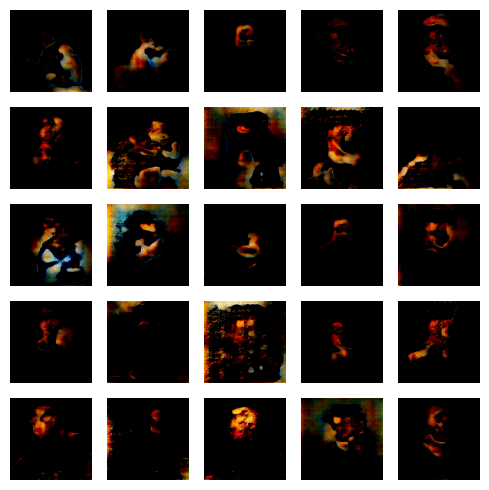

  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 1/3000 [00:00<22:13,  2.25it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 2/3000 [00:00<21:24,  2.33it/s]

1/1 [==============================] - 0s 44ms/step


  0%|          | 3/3000 [00:01<21:24,  2.33it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 4/3000 [00:01<21:19,  2.34it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 5/3000 [00:02<22:03,  2.26it/s]

1/1 [==============================] - 0s 65ms/step


  0%|          | 6/3000 [00:02<21:25,  2.33it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 7/3000 [00:02<20:40,  2.41it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 8/3000 [00:03<20:59,  2.38it/s]

1/1 [==============================] - 0s 47ms/step


  0%|          | 9/3000 [00:03<21:21,  2.33it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 10/3000 [00:04<21:39,  2.30it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 11/3000 [00:04<21:44,  2.29it/s]

1/1 [==============================] - 0s 51ms/step


  0%|          | 12/3000 [00:05<21:46,  2.29it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 13/3000 [00:05<21:39,  2.30it/s]

1/1 [==============================] - 0s 49ms/step


  0%|          | 14/3000 [00:06<22:22,  2.23it/s]

1/1 [==============================] - 0s 49ms/step


  0%|          | 15/3000 [00:06<24:19,  2.05it/s]

1/1 [==============================] - 0s 69ms/step


  1%|          | 16/3000 [00:07<23:54,  2.08it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 17/3000 [00:07<22:43,  2.19it/s]

1/1 [==============================] - 0s 88ms/step


  1%|          | 18/3000 [00:08<25:01,  1.99it/s]

1/1 [==============================] - 0s 71ms/step


  1%|          | 19/3000 [00:08<23:51,  2.08it/s]

1/1 [==============================] - 0s 57ms/step


  1%|          | 20/3000 [00:08<22:51,  2.17it/s]

1/1 [==============================] - 0s 69ms/step


  1%|          | 21/3000 [00:09<23:02,  2.16it/s]

1/1 [==============================] - 0s 67ms/step


  1%|          | 22/3000 [00:09<22:32,  2.20it/s]

1/1 [==============================] - 0s 80ms/step


  1%|          | 23/3000 [00:10<22:20,  2.22it/s]

1/1 [==============================] - 0s 50ms/step


  1%|          | 24/3000 [00:10<21:41,  2.29it/s]

1/1 [==============================] - 0s 81ms/step


  1%|          | 25/3000 [00:11<21:37,  2.29it/s]

1/1 [==============================] - 0s 46ms/step


  1%|          | 26/3000 [00:11<21:35,  2.29it/s]

1/1 [==============================] - 0s 60ms/step


  1%|          | 27/3000 [00:12<21:24,  2.31it/s]

1/1 [==============================] - 0s 43ms/step


  1%|          | 28/3000 [00:12<20:43,  2.39it/s]

1/1 [==============================] - 0s 45ms/step


  1%|          | 29/3000 [00:12<21:04,  2.35it/s]

1/1 [==============================] - 0s 47ms/step


  1%|          | 30/3000 [00:13<20:34,  2.41it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 31/3000 [00:13<19:22,  2.55it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 32/3000 [00:14<20:02,  2.47it/s]

1/1 [==============================] - 0s 44ms/step


  1%|          | 33/3000 [00:14<19:35,  2.52it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 34/3000 [00:14<18:56,  2.61it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 35/3000 [00:15<19:21,  2.55it/s]

1/1 [==============================] - 0s 43ms/step


  1%|          | 36/3000 [00:15<18:58,  2.60it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 37/3000 [00:15<19:03,  2.59it/s]

1/1 [==============================] - 0s 47ms/step


  1%|▏         | 38/3000 [00:16<19:21,  2.55it/s]

1/1 [==============================] - 0s 40ms/step


  1%|▏         | 39/3000 [00:16<19:32,  2.52it/s]

1/1 [==============================] - 0s 44ms/step


  1%|▏         | 40/3000 [00:17<19:50,  2.49it/s]

1/1 [==============================] - 0s 43ms/step


  1%|▏         | 41/3000 [00:17<19:59,  2.47it/s]

1/1 [==============================] - 0s 46ms/step


  1%|▏         | 42/3000 [00:17<20:09,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


  1%|▏         | 43/3000 [00:18<19:07,  2.58it/s]

1/1 [==============================] - 0s 58ms/step


  1%|▏         | 44/3000 [00:18<18:57,  2.60it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 45/3000 [00:19<19:23,  2.54it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 46/3000 [00:19<19:40,  2.50it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 47/3000 [00:19<19:27,  2.53it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 48/3000 [00:20<19:36,  2.51it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 49/3000 [00:20<20:07,  2.44it/s]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 50/3000 [00:21<20:09,  2.44it/s]

1/1 [==============================] - 0s 46ms/step


  2%|▏         | 51/3000 [00:21<19:15,  2.55it/s]

1/1 [==============================] - 0s 51ms/step


  2%|▏         | 52/3000 [00:21<20:11,  2.43it/s]

1/1 [==============================] - 0s 58ms/step


  2%|▏         | 53/3000 [00:22<21:14,  2.31it/s]

1/1 [==============================] - 0s 63ms/step


  2%|▏         | 54/3000 [00:22<20:58,  2.34it/s]

1/1 [==============================] - 0s 56ms/step


  2%|▏         | 55/3000 [00:23<20:24,  2.40it/s]

1/1 [==============================] - 0s 52ms/step


  2%|▏         | 56/3000 [00:23<21:16,  2.31it/s]

1/1 [==============================] - 0s 86ms/step


  2%|▏         | 57/3000 [00:24<21:22,  2.30it/s]

1/1 [==============================] - 0s 68ms/step


  2%|▏         | 58/3000 [00:24<21:22,  2.29it/s]

1/1 [==============================] - 0s 60ms/step


  2%|▏         | 59/3000 [00:25<21:07,  2.32it/s]

1/1 [==============================] - 0s 63ms/step


  2%|▏         | 60/3000 [00:25<23:16,  2.11it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 61/3000 [00:26<22:54,  2.14it/s]

1/1 [==============================] - 0s 76ms/step


  2%|▏         | 62/3000 [00:26<22:30,  2.17it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 63/3000 [00:26<22:01,  2.22it/s]

1/1 [==============================] - 0s 61ms/step


  2%|▏         | 64/3000 [00:27<21:53,  2.24it/s]

1/1 [==============================] - 0s 72ms/step


  2%|▏         | 65/3000 [00:27<22:03,  2.22it/s]

1/1 [==============================] - 0s 63ms/step


  2%|▏         | 66/3000 [00:28<21:14,  2.30it/s]

1/1 [==============================] - 0s 49ms/step


  2%|▏         | 67/3000 [00:28<21:46,  2.24it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 68/3000 [00:29<21:20,  2.29it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 69/3000 [00:29<21:22,  2.29it/s]

1/1 [==============================] - 0s 48ms/step


  2%|▏         | 70/3000 [00:29<20:14,  2.41it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 71/3000 [00:30<20:43,  2.36it/s]

1/1 [==============================] - 0s 47ms/step


  2%|▏         | 72/3000 [00:30<19:41,  2.48it/s]

1/1 [==============================] - 0s 44ms/step


  2%|▏         | 73/3000 [00:31<19:34,  2.49it/s]

1/1 [==============================] - 0s 46ms/step


  2%|▏         | 74/3000 [00:31<19:45,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▎         | 75/3000 [00:31<18:58,  2.57it/s]

1/1 [==============================] - 0s 51ms/step


  3%|▎         | 76/3000 [00:32<18:51,  2.58it/s]

1/1 [==============================] - 0s 43ms/step


  3%|▎         | 77/3000 [00:32<18:59,  2.57it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 78/3000 [00:33<18:29,  2.63it/s]

1/1 [==============================] - 0s 45ms/step


  3%|▎         | 79/3000 [00:33<19:03,  2.56it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 80/3000 [00:33<19:07,  2.54it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 81/3000 [00:34<19:34,  2.49it/s]

1/1 [==============================] - 0s 49ms/step


  3%|▎         | 82/3000 [00:34<19:26,  2.50it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 83/3000 [00:35<19:39,  2.47it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 84/3000 [00:35<19:29,  2.49it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 85/3000 [00:35<19:18,  2.52it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 86/3000 [00:36<19:12,  2.53it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 87/3000 [00:36<19:09,  2.53it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 88/3000 [00:37<19:05,  2.54it/s]

1/1 [==============================] - 0s 47ms/step


  3%|▎         | 89/3000 [00:37<19:02,  2.55it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 90/3000 [00:37<18:28,  2.62it/s]

1/1 [==============================] - 0s 45ms/step


  3%|▎         | 91/3000 [00:38<18:56,  2.56it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 92/3000 [00:38<18:33,  2.61it/s]

1/1 [==============================] - 0s 49ms/step


  3%|▎         | 93/3000 [00:38<19:20,  2.51it/s]

1/1 [==============================] - 0s 65ms/step


  3%|▎         | 94/3000 [00:39<19:21,  2.50it/s]

1/1 [==============================] - 0s 63ms/step


  3%|▎         | 95/3000 [00:40<22:51,  2.12it/s]

1/1 [==============================] - 0s 44ms/step


  3%|▎         | 96/3000 [00:40<21:50,  2.22it/s]

1/1 [==============================] - 0s 55ms/step


  3%|▎         | 97/3000 [00:40<21:11,  2.28it/s]

1/1 [==============================] - 0s 59ms/step


  3%|▎         | 98/3000 [00:41<21:30,  2.25it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 99/3000 [00:41<21:06,  2.29it/s]

1/1 [==============================] - 0s 58ms/step


  3%|▎         | 100/3000 [00:42<20:21,  2.37it/s]

1/1 [==============================] - 0s 52ms/step


  3%|▎         | 101/3000 [00:42<19:53,  2.43it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 102/3000 [00:42<19:46,  2.44it/s]

1/1 [==============================] - 0s 58ms/step


  3%|▎         | 103/3000 [00:43<20:15,  2.38it/s]

1/1 [==============================] - 0s 62ms/step


  3%|▎         | 104/3000 [00:43<21:15,  2.27it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▎         | 105/3000 [00:44<21:37,  2.23it/s]

1/1 [==============================] - 0s 61ms/step


  4%|▎         | 106/3000 [00:44<21:31,  2.24it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▎         | 107/3000 [00:45<21:03,  2.29it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▎         | 108/3000 [00:45<20:53,  2.31it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▎         | 109/3000 [00:45<19:46,  2.44it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▎         | 110/3000 [00:46<20:17,  2.37it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▎         | 111/3000 [00:46<20:27,  2.35it/s]

1/1 [==============================] - 0s 44ms/step


  4%|▎         | 112/3000 [00:47<20:26,  2.36it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 113/3000 [00:47<20:15,  2.37it/s]

1/1 [==============================] - 0s 47ms/step


  4%|▍         | 114/3000 [00:48<19:49,  2.43it/s]

1/1 [==============================] - 0s 45ms/step


  4%|▍         | 115/3000 [00:48<19:55,  2.41it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 116/3000 [00:48<19:52,  2.42it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 117/3000 [00:49<19:31,  2.46it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 118/3000 [00:49<19:40,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 119/3000 [00:50<19:21,  2.48it/s]

1/1 [==============================] - 0s 47ms/step


  4%|▍         | 120/3000 [00:50<19:12,  2.50it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 121/3000 [00:50<19:27,  2.47it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▍         | 122/3000 [00:51<18:41,  2.57it/s]

1/1 [==============================] - 0s 51ms/step


  4%|▍         | 123/3000 [00:51<19:12,  2.50it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 124/3000 [00:52<19:23,  2.47it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 125/3000 [00:52<19:28,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 126/3000 [00:52<19:34,  2.45it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 127/3000 [00:53<19:40,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 128/3000 [00:53<19:23,  2.47it/s]

1/1 [==============================] - 0s 44ms/step


  4%|▍         | 129/3000 [00:54<19:29,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 130/3000 [00:54<19:11,  2.49it/s]

1/1 [==============================] - 0s 55ms/step


  4%|▍         | 131/3000 [00:54<20:03,  2.38it/s]

1/1 [==============================] - 0s 68ms/step


  4%|▍         | 132/3000 [00:55<20:29,  2.33it/s]

1/1 [==============================] - 0s 83ms/step


  4%|▍         | 133/3000 [00:55<20:50,  2.29it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▍         | 134/3000 [00:56<21:18,  2.24it/s]

1/1 [==============================] - 0s 45ms/step


  4%|▍         | 135/3000 [00:56<20:49,  2.29it/s]

1/1 [==============================] - 0s 56ms/step


  5%|▍         | 136/3000 [00:57<20:15,  2.36it/s]

1/1 [==============================] - 0s 70ms/step


  5%|▍         | 137/3000 [00:57<20:42,  2.30it/s]

1/1 [==============================] - 0s 60ms/step


  5%|▍         | 138/3000 [00:58<23:11,  2.06it/s]

1/1 [==============================] - 0s 58ms/step


  5%|▍         | 139/3000 [00:58<21:59,  2.17it/s]

1/1 [==============================] - 0s 90ms/step


  5%|▍         | 140/3000 [00:59<24:45,  1.93it/s]

1/1 [==============================] - 0s 49ms/step


  5%|▍         | 141/3000 [00:59<23:45,  2.01it/s]

1/1 [==============================] - 0s 67ms/step


  5%|▍         | 142/3000 [01:00<23:31,  2.02it/s]

1/1 [==============================] - 0s 64ms/step


  5%|▍         | 143/3000 [01:00<23:12,  2.05it/s]

1/1 [==============================] - 0s 49ms/step


  5%|▍         | 144/3000 [01:01<22:48,  2.09it/s]

1/1 [==============================] - 0s 46ms/step


  5%|▍         | 145/3000 [01:01<21:58,  2.17it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▍         | 146/3000 [01:01<21:10,  2.25it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 147/3000 [01:02<20:36,  2.31it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 148/3000 [01:02<19:52,  2.39it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▍         | 149/3000 [01:03<19:48,  2.40it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 150/3000 [01:03<20:03,  2.37it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 151/3000 [01:03<19:34,  2.42it/s]

1/1 [==============================] - 0s 45ms/step


  5%|▌         | 152/3000 [01:04<19:20,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 153/3000 [01:04<19:22,  2.45it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 154/3000 [01:05<18:24,  2.58it/s]

1/1 [==============================] - 0s 43ms/step


  5%|▌         | 155/3000 [01:05<18:03,  2.63it/s]

1/1 [==============================] - 0s 46ms/step


  5%|▌         | 156/3000 [01:05<17:33,  2.70it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 157/3000 [01:06<17:49,  2.66it/s]

1/1 [==============================] - 0s 50ms/step


  5%|▌         | 158/3000 [01:06<18:43,  2.53it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 159/3000 [01:07<18:08,  2.61it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 160/3000 [01:07<18:33,  2.55it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▌         | 161/3000 [01:07<17:59,  2.63it/s]

1/1 [==============================] - 0s 45ms/step


  5%|▌         | 162/3000 [01:08<18:23,  2.57it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 163/3000 [01:08<18:43,  2.53it/s]

1/1 [==============================] - 0s 44ms/step


  5%|▌         | 164/3000 [01:09<19:08,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 165/3000 [01:09<19:14,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 166/3000 [01:09<19:14,  2.45it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 167/3000 [01:10<19:16,  2.45it/s]

1/1 [==============================] - 0s 42ms/step


  6%|▌         | 168/3000 [01:10<19:01,  2.48it/s]

1/1 [==============================] - 0s 61ms/step


  6%|▌         | 169/3000 [01:11<19:08,  2.46it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▌         | 170/3000 [01:11<19:58,  2.36it/s]

1/1 [==============================] - 0s 59ms/step


  6%|▌         | 171/3000 [01:11<20:24,  2.31it/s]

1/1 [==============================] - 0s 72ms/step


  6%|▌         | 172/3000 [01:12<20:15,  2.33it/s]

1/1 [==============================] - 0s 84ms/step


  6%|▌         | 173/3000 [01:12<21:14,  2.22it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 174/3000 [01:13<20:41,  2.28it/s]

1/1 [==============================] - 0s 68ms/step


  6%|▌         | 175/3000 [01:13<20:23,  2.31it/s]

1/1 [==============================] - 0s 58ms/step


  6%|▌         | 176/3000 [01:14<20:42,  2.27it/s]

1/1 [==============================] - 0s 62ms/step


  6%|▌         | 177/3000 [01:14<20:52,  2.25it/s]

1/1 [==============================] - 0s 59ms/step


  6%|▌         | 178/3000 [01:15<20:21,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 179/3000 [01:15<20:42,  2.27it/s]

1/1 [==============================] - 0s 44ms/step


  6%|▌         | 180/3000 [01:15<20:30,  2.29it/s]

1/1 [==============================] - 0s 97ms/step


  6%|▌         | 181/3000 [01:16<21:19,  2.20it/s]

1/1 [==============================] - 0s 48ms/step


  6%|▌         | 182/3000 [01:16<21:25,  2.19it/s]

1/1 [==============================] - 0s 42ms/step


  6%|▌         | 183/3000 [01:17<21:19,  2.20it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▌         | 184/3000 [01:17<21:07,  2.22it/s]

1/1 [==============================] - 0s 51ms/step


  6%|▌         | 185/3000 [01:18<21:08,  2.22it/s]

1/1 [==============================] - 0s 43ms/step


  6%|▌         | 186/3000 [01:18<19:45,  2.37it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 187/3000 [01:18<18:36,  2.52it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▋         | 188/3000 [01:19<18:18,  2.56it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▋         | 189/3000 [01:19<18:37,  2.52it/s]

1/1 [==============================] - 0s 42ms/step


  6%|▋         | 190/3000 [01:20<18:36,  2.52it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▋         | 191/3000 [01:20<17:42,  2.64it/s]

1/1 [==============================] - 0s 42ms/step


  6%|▋         | 192/3000 [01:20<17:52,  2.62it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▋         | 193/3000 [01:21<18:27,  2.53it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▋         | 194/3000 [01:21<18:26,  2.54it/s]

1/1 [==============================] - 0s 45ms/step


  6%|▋         | 195/3000 [01:22<18:35,  2.51it/s]

1/1 [==============================] - 0s 53ms/step


  7%|▋         | 196/3000 [01:22<18:53,  2.47it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 197/3000 [01:22<18:50,  2.48it/s]

1/1 [==============================] - 0s 43ms/step


  7%|▋         | 198/3000 [01:23<19:00,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 199/3000 [01:23<19:00,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 200/3000 [01:24<18:45,  2.49it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 201/3000 [01:24<18:52,  2.47it/s]

1/1 [==============================] - 0s 63ms/step


  7%|▋         | 202/3000 [01:24<18:53,  2.47it/s]

1/1 [==============================] - 0s 48ms/step


  7%|▋         | 203/3000 [01:25<18:59,  2.46it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 204/3000 [01:25<19:05,  2.44it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 205/3000 [01:26<19:04,  2.44it/s]

1/1 [==============================] - 0s 47ms/step


  7%|▋         | 206/3000 [01:26<18:52,  2.47it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 207/3000 [01:26<19:06,  2.44it/s]

1/1 [==============================] - 0s 46ms/step


  7%|▋         | 208/3000 [01:27<19:12,  2.42it/s]

1/1 [==============================] - 0s 50ms/step


  7%|▋         | 209/3000 [01:27<19:58,  2.33it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 210/3000 [01:28<19:50,  2.34it/s]

1/1 [==============================] - 0s 51ms/step


  7%|▋         | 211/3000 [01:28<20:09,  2.31it/s]

1/1 [==============================] - 0s 62ms/step


  7%|▋         | 212/3000 [01:29<20:34,  2.26it/s]

1/1 [==============================] - 0s 54ms/step


  7%|▋         | 213/3000 [01:29<21:04,  2.20it/s]

1/1 [==============================] - 0s 85ms/step


  7%|▋         | 214/3000 [01:30<21:36,  2.15it/s]

1/1 [==============================] - 0s 51ms/step


  7%|▋         | 215/3000 [01:30<21:02,  2.21it/s]

1/1 [==============================] - 0s 79ms/step


  7%|▋         | 216/3000 [01:31<21:24,  2.17it/s]

1/1 [==============================] - 0s 59ms/step


  7%|▋         | 217/3000 [01:31<21:25,  2.16it/s]

1/1 [==============================] - 0s 87ms/step


  7%|▋         | 218/3000 [01:31<20:47,  2.23it/s]

1/1 [==============================] - 0s 87ms/step


  7%|▋         | 219/3000 [01:32<21:04,  2.20it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 220/3000 [01:32<20:26,  2.27it/s]

1/1 [==============================] - 0s 43ms/step


  7%|▋         | 221/3000 [01:33<19:45,  2.34it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 222/3000 [01:33<20:04,  2.31it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 223/3000 [01:34<18:52,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 224/3000 [01:34<19:20,  2.39it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 225/3000 [01:34<19:08,  2.42it/s]

1/1 [==============================] - 0s 47ms/step


  8%|▊         | 226/3000 [01:35<18:52,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 227/3000 [01:35<18:51,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 228/3000 [01:36<18:34,  2.49it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 229/3000 [01:36<17:52,  2.58it/s]

1/1 [==============================] - 0s 44ms/step


  8%|▊         | 230/3000 [01:36<18:02,  2.56it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 231/3000 [01:37<17:35,  2.62it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 232/3000 [01:37<18:27,  2.50it/s]

1/1 [==============================] - 0s 45ms/step


  8%|▊         | 233/3000 [01:38<18:48,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 234/3000 [01:38<18:46,  2.45it/s]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 235/3000 [01:38<19:11,  2.40it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 236/3000 [01:39<18:54,  2.44it/s]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 237/3000 [01:39<19:05,  2.41it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 238/3000 [01:40<18:40,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 239/3000 [01:40<18:40,  2.46it/s]

1/1 [==============================] - 0s 45ms/step


  8%|▊         | 240/3000 [01:40<18:52,  2.44it/s]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 241/3000 [01:41<18:30,  2.48it/s]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 242/3000 [01:41<18:41,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 243/3000 [01:42<18:07,  2.54it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 244/3000 [01:42<18:21,  2.50it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 245/3000 [01:42<18:33,  2.47it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 246/3000 [01:43<17:53,  2.57it/s]

1/1 [==============================] - 0s 88ms/step


  8%|▊         | 247/3000 [01:43<19:09,  2.40it/s]

1/1 [==============================] - 0s 75ms/step


  8%|▊         | 248/3000 [01:44<19:48,  2.32it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 249/3000 [01:44<19:24,  2.36it/s]

1/1 [==============================] - 0s 82ms/step


  8%|▊         | 250/3000 [01:45<19:21,  2.37it/s]

1/1 [==============================] - 0s 85ms/step


  8%|▊         | 251/3000 [01:45<19:35,  2.34it/s]

1/1 [==============================] - 0s 56ms/step


  8%|▊         | 252/3000 [01:45<19:24,  2.36it/s]

1/1 [==============================] - 0s 69ms/step


  8%|▊         | 253/3000 [01:46<19:23,  2.36it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 254/3000 [01:46<19:50,  2.31it/s]

1/1 [==============================] - 0s 64ms/step


  8%|▊         | 255/3000 [01:47<19:47,  2.31it/s]

1/1 [==============================] - 0s 69ms/step


  9%|▊         | 256/3000 [01:47<19:33,  2.34it/s]

1/1 [==============================] - 0s 81ms/step


  9%|▊         | 257/3000 [01:48<20:25,  2.24it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▊         | 258/3000 [01:48<20:44,  2.20it/s]

1/1 [==============================] - 0s 71ms/step


  9%|▊         | 259/3000 [01:48<20:18,  2.25it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▊         | 260/3000 [01:49<19:50,  2.30it/s]

1/1 [==============================] - 0s 56ms/step


  9%|▊         | 261/3000 [01:49<19:29,  2.34it/s]

1/1 [==============================] - 0s 44ms/step


  9%|▊         | 262/3000 [01:50<19:18,  2.36it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▉         | 263/3000 [01:50<18:44,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 264/3000 [01:51<19:18,  2.36it/s]

1/1 [==============================] - 0s 44ms/step


  9%|▉         | 265/3000 [01:51<19:36,  2.32it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▉         | 266/3000 [01:51<19:15,  2.37it/s]

1/1 [==============================] - 0s 50ms/step


  9%|▉         | 267/3000 [01:52<19:29,  2.34it/s]

1/1 [==============================] - 0s 49ms/step


  9%|▉         | 268/3000 [01:52<19:15,  2.36it/s]

1/1 [==============================] - 0s 43ms/step


  9%|▉         | 269/3000 [01:53<19:10,  2.37it/s]

1/1 [==============================] - 0s 43ms/step


  9%|▉         | 270/3000 [01:53<19:03,  2.39it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 271/3000 [01:54<19:00,  2.39it/s]

1/1 [==============================] - 0s 45ms/step


  9%|▉         | 272/3000 [01:54<18:54,  2.40it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 273/3000 [01:54<18:49,  2.42it/s]

1/1 [==============================] - 0s 48ms/step


  9%|▉         | 274/3000 [01:55<19:02,  2.39it/s]

1/1 [==============================] - 0s 44ms/step


  9%|▉         | 275/3000 [01:55<19:03,  2.38it/s]

1/1 [==============================] - 0s 49ms/step


  9%|▉         | 276/3000 [01:56<18:46,  2.42it/s]

1/1 [==============================] - 0s 54ms/step


  9%|▉         | 277/3000 [01:56<18:36,  2.44it/s]

1/1 [==============================] - 0s 45ms/step


  9%|▉         | 278/3000 [01:56<18:27,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 279/3000 [01:57<18:25,  2.46it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▉         | 280/3000 [01:57<18:31,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 281/3000 [01:58<18:15,  2.48it/s]

1/1 [==============================] - 0s 45ms/step


  9%|▉         | 282/3000 [01:58<18:24,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 283/3000 [01:58<18:32,  2.44it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▉         | 284/3000 [01:59<18:32,  2.44it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 285/3000 [01:59<18:58,  2.39it/s]

1/1 [==============================] - 0s 74ms/step


 10%|▉         | 286/3000 [02:00<19:34,  2.31it/s]

1/1 [==============================] - 0s 50ms/step


 10%|▉         | 287/3000 [02:00<21:34,  2.10it/s]

1/1 [==============================] - 0s 40ms/step


 10%|▉         | 288/3000 [02:01<20:17,  2.23it/s]

1/1 [==============================] - 0s 89ms/step


 10%|▉         | 289/3000 [02:01<20:08,  2.24it/s]

1/1 [==============================] - 0s 106ms/step


 10%|▉         | 290/3000 [02:02<20:29,  2.20it/s]

1/1 [==============================] - 0s 68ms/step


 10%|▉         | 291/3000 [02:02<20:17,  2.23it/s]

1/1 [==============================] - 0s 88ms/step


 10%|▉         | 292/3000 [02:03<20:43,  2.18it/s]

1/1 [==============================] - 0s 89ms/step


 10%|▉         | 293/3000 [02:03<20:33,  2.19it/s]

1/1 [==============================] - 0s 65ms/step


 10%|▉         | 294/3000 [02:03<19:55,  2.26it/s]

1/1 [==============================] - 0s 70ms/step


 10%|▉         | 295/3000 [02:04<20:08,  2.24it/s]

1/1 [==============================] - 0s 60ms/step


 10%|▉         | 296/3000 [02:04<20:09,  2.24it/s]

1/1 [==============================] - 0s 61ms/step


 10%|▉         | 297/3000 [02:05<20:07,  2.24it/s]

1/1 [==============================] - 0s 84ms/step


 10%|▉         | 298/3000 [02:05<19:55,  2.26it/s]

1/1 [==============================] - 0s 48ms/step


 10%|▉         | 299/3000 [02:06<19:11,  2.35it/s]

1/1 [==============================] - 0s 54ms/step


 10%|█         | 300/3000 [02:06<19:57,  2.26it/s]

1/1 [==============================] - 0s 42ms/step


 10%|█         | 301/3000 [02:07<20:08,  2.23it/s]

1/1 [==============================] - 0s 42ms/step


 10%|█         | 302/3000 [02:07<20:05,  2.24it/s]

1/1 [==============================] - 0s 43ms/step


 10%|█         | 303/3000 [02:07<19:23,  2.32it/s]

1/1 [==============================] - 0s 40ms/step


 10%|█         | 304/3000 [02:08<18:51,  2.38it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 305/3000 [02:08<18:26,  2.44it/s]

1/1 [==============================] - 0s 41ms/step


 10%|█         | 306/3000 [02:09<18:17,  2.45it/s]

1/1 [==============================] - 0s 41ms/step


 10%|█         | 307/3000 [02:09<22:03,  2.03it/s]

1/1 [==============================] - 0s 49ms/step


 10%|█         | 308/3000 [02:10<20:50,  2.15it/s]

1/1 [==============================] - 0s 42ms/step


 10%|█         | 309/3000 [02:10<20:04,  2.24it/s]

1/1 [==============================] - 0s 43ms/step


 10%|█         | 310/3000 [02:10<19:41,  2.28it/s]

1/1 [==============================] - 0s 45ms/step


 10%|█         | 311/3000 [02:11<18:41,  2.40it/s]

1/1 [==============================] - 0s 45ms/step


 10%|█         | 312/3000 [02:11<18:31,  2.42it/s]

1/1 [==============================] - 0s 54ms/step


 10%|█         | 313/3000 [02:12<18:38,  2.40it/s]

1/1 [==============================] - 0s 41ms/step


 10%|█         | 314/3000 [02:12<18:34,  2.41it/s]

1/1 [==============================] - 0s 43ms/step


 10%|█         | 315/3000 [02:12<18:24,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 316/3000 [02:13<17:34,  2.54it/s]

1/1 [==============================] - 0s 45ms/step


 11%|█         | 317/3000 [02:13<17:49,  2.51it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 318/3000 [02:14<18:27,  2.42it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█         | 319/3000 [02:14<17:51,  2.50it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 320/3000 [02:14<18:15,  2.45it/s]

1/1 [==============================] - 0s 69ms/step


 11%|█         | 321/3000 [02:15<18:10,  2.46it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█         | 322/3000 [02:15<19:02,  2.34it/s]

1/1 [==============================] - 0s 64ms/step


 11%|█         | 323/3000 [02:16<18:50,  2.37it/s]

1/1 [==============================] - 0s 66ms/step


 11%|█         | 324/3000 [02:16<19:47,  2.25it/s]

1/1 [==============================] - 0s 64ms/step


 11%|█         | 325/3000 [02:17<20:06,  2.22it/s]

1/1 [==============================] - 0s 56ms/step


 11%|█         | 326/3000 [02:17<20:14,  2.20it/s]

1/1 [==============================] - 0s 59ms/step


 11%|█         | 327/3000 [02:18<20:20,  2.19it/s]

1/1 [==============================] - 0s 54ms/step


 11%|█         | 328/3000 [02:18<20:19,  2.19it/s]

1/1 [==============================] - 0s 58ms/step


 11%|█         | 329/3000 [02:19<19:42,  2.26it/s]

1/1 [==============================] - 0s 61ms/step


 11%|█         | 330/3000 [02:19<19:33,  2.28it/s]

1/1 [==============================] - 0s 83ms/step


 11%|█         | 331/3000 [02:19<19:40,  2.26it/s]

1/1 [==============================] - 0s 49ms/step


 11%|█         | 332/3000 [02:20<19:22,  2.30it/s]

1/1 [==============================] - 0s 55ms/step


 11%|█         | 333/3000 [02:20<19:53,  2.24it/s]

1/1 [==============================] - 0s 60ms/step


 11%|█         | 334/3000 [02:21<20:10,  2.20it/s]

1/1 [==============================] - 0s 68ms/step


 11%|█         | 335/3000 [02:21<20:18,  2.19it/s]

1/1 [==============================] - 0s 59ms/step


 11%|█         | 336/3000 [02:22<20:24,  2.18it/s]

1/1 [==============================] - 0s 64ms/step


 11%|█         | 337/3000 [02:22<20:34,  2.16it/s]

1/1 [==============================] - 0s 70ms/step


 11%|█▏        | 338/3000 [02:23<20:41,  2.14it/s]

1/1 [==============================] - 0s 75ms/step


 11%|█▏        | 339/3000 [02:23<20:07,  2.20it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█▏        | 340/3000 [02:24<20:10,  2.20it/s]

1/1 [==============================] - 0s 60ms/step


 11%|█▏        | 341/3000 [02:24<20:17,  2.18it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█▏        | 342/3000 [02:25<21:58,  2.02it/s]

1/1 [==============================] - 0s 58ms/step


 11%|█▏        | 343/3000 [02:25<21:36,  2.05it/s]

1/1 [==============================] - 0s 54ms/step


 11%|█▏        | 344/3000 [02:25<20:29,  2.16it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█▏        | 345/3000 [02:26<19:32,  2.26it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 346/3000 [02:26<19:46,  2.24it/s]

1/1 [==============================] - 0s 55ms/step


 12%|█▏        | 347/3000 [02:27<19:12,  2.30it/s]

1/1 [==============================] - 0s 48ms/step


 12%|█▏        | 348/3000 [02:27<19:28,  2.27it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█▏        | 349/3000 [02:27<18:16,  2.42it/s]

1/1 [==============================] - 0s 47ms/step


 12%|█▏        | 350/3000 [02:28<18:57,  2.33it/s]

1/1 [==============================] - 0s 46ms/step


 12%|█▏        | 351/3000 [02:28<19:21,  2.28it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█▏        | 352/3000 [02:29<19:28,  2.27it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 353/3000 [02:29<18:22,  2.40it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█▏        | 354/3000 [02:30<17:59,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 355/3000 [02:30<18:27,  2.39it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 356/3000 [02:31<18:55,  2.33it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 357/3000 [02:31<18:08,  2.43it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█▏        | 358/3000 [02:31<18:22,  2.40it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 359/3000 [02:32<17:47,  2.48it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█▏        | 360/3000 [02:32<17:45,  2.48it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 361/3000 [02:33<17:58,  2.45it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▏        | 362/3000 [02:33<18:16,  2.40it/s]

1/1 [==============================] - 0s 47ms/step


 12%|█▏        | 363/3000 [02:33<18:25,  2.39it/s]

1/1 [==============================] - 0s 46ms/step


 12%|█▏        | 364/3000 [02:34<18:29,  2.38it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 365/3000 [02:34<18:27,  2.38it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█▏        | 366/3000 [02:35<18:05,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 367/3000 [02:35<18:12,  2.41it/s]

1/1 [==============================] - 0s 64ms/step


 12%|█▏        | 368/3000 [02:35<18:49,  2.33it/s]

1/1 [==============================] - 0s 48ms/step


 12%|█▏        | 369/3000 [02:36<18:40,  2.35it/s]

1/1 [==============================] - 0s 73ms/step


 12%|█▏        | 370/3000 [02:36<19:37,  2.23it/s]

1/1 [==============================] - 0s 73ms/step


 12%|█▏        | 371/3000 [02:37<19:15,  2.27it/s]

1/1 [==============================] - 0s 83ms/step


 12%|█▏        | 372/3000 [02:37<19:31,  2.24it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█▏        | 373/3000 [02:38<19:03,  2.30it/s]

1/1 [==============================] - 0s 55ms/step


 12%|█▏        | 374/3000 [02:38<19:22,  2.26it/s]

1/1 [==============================] - 0s 78ms/step


 12%|█▎        | 375/3000 [02:39<18:42,  2.34it/s]

1/1 [==============================] - 0s 82ms/step


 13%|█▎        | 376/3000 [02:39<18:35,  2.35it/s]

1/1 [==============================] - 0s 82ms/step


 13%|█▎        | 377/3000 [02:39<19:18,  2.26it/s]

1/1 [==============================] - 0s 56ms/step


 13%|█▎        | 378/3000 [02:40<18:59,  2.30it/s]

1/1 [==============================] - 0s 84ms/step


 13%|█▎        | 379/3000 [02:40<19:51,  2.20it/s]

1/1 [==============================] - 0s 52ms/step


 13%|█▎        | 380/3000 [02:41<19:33,  2.23it/s]

1/1 [==============================] - 0s 97ms/step


 13%|█▎        | 381/3000 [02:41<19:57,  2.19it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 382/3000 [02:42<20:05,  2.17it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 383/3000 [02:42<19:55,  2.19it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 384/3000 [02:43<19:52,  2.19it/s]

1/1 [==============================] - 0s 46ms/step


 13%|█▎        | 385/3000 [02:43<19:15,  2.26it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 386/3000 [02:43<18:34,  2.34it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 387/3000 [02:44<18:06,  2.41it/s]

1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 388/3000 [02:44<18:17,  2.38it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 389/3000 [02:45<18:15,  2.38it/s]

1/1 [==============================] - 0s 48ms/step


 13%|█▎        | 390/3000 [02:45<17:51,  2.44it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 391/3000 [02:45<17:40,  2.46it/s]

1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 392/3000 [02:46<17:47,  2.44it/s]

1/1 [==============================] - 0s 46ms/step


 13%|█▎        | 393/3000 [02:46<17:17,  2.51it/s]

1/1 [==============================] - 0s 47ms/step


 13%|█▎        | 394/3000 [02:47<17:24,  2.49it/s]

1/1 [==============================] - 0s 44ms/step


 13%|█▎        | 395/3000 [02:47<18:03,  2.40it/s]

1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 396/3000 [02:47<17:17,  2.51it/s]

1/1 [==============================] - 0s 46ms/step


 13%|█▎        | 397/3000 [02:48<16:51,  2.57it/s]

1/1 [==============================] - 0s 46ms/step


 13%|█▎        | 398/3000 [02:48<17:19,  2.50it/s]

1/1 [==============================] - 0s 49ms/step


 13%|█▎        | 399/3000 [02:49<17:30,  2.48it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 400/3000 [02:49<16:40,  2.60it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 401/3000 [02:49<16:26,  2.63it/s]

1/1 [==============================] - 0s 53ms/step


 13%|█▎        | 402/3000 [02:50<16:54,  2.56it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 403/3000 [02:50<16:45,  2.58it/s]

1/1 [==============================] - 0s 47ms/step


 13%|█▎        | 404/3000 [02:51<17:05,  2.53it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▎        | 405/3000 [02:51<16:39,  2.60it/s]

1/1 [==============================] - 0s 43ms/step


 14%|█▎        | 406/3000 [02:51<17:08,  2.52it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▎        | 407/3000 [02:52<17:26,  2.48it/s]

1/1 [==============================] - 0s 69ms/step


 14%|█▎        | 408/3000 [02:52<17:50,  2.42it/s]

1/1 [==============================] - 0s 88ms/step


 14%|█▎        | 409/3000 [02:53<19:08,  2.26it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▎        | 410/3000 [02:53<19:22,  2.23it/s]

1/1 [==============================] - 0s 52ms/step


 14%|█▎        | 411/3000 [02:54<19:50,  2.17it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▎        | 412/3000 [02:54<19:10,  2.25it/s]

1/1 [==============================] - 0s 43ms/step


 14%|█▍        | 413/3000 [02:55<18:49,  2.29it/s]

1/1 [==============================] - 0s 75ms/step


 14%|█▍        | 414/3000 [02:55<18:27,  2.33it/s]

1/1 [==============================] - 0s 66ms/step


 14%|█▍        | 415/3000 [02:55<18:32,  2.32it/s]

1/1 [==============================] - 0s 69ms/step


 14%|█▍        | 416/3000 [02:56<19:01,  2.26it/s]

1/1 [==============================] - 0s 87ms/step


 14%|█▍        | 417/3000 [02:56<19:41,  2.19it/s]

1/1 [==============================] - 0s 89ms/step


 14%|█▍        | 418/3000 [02:57<19:26,  2.21it/s]

1/1 [==============================] - 0s 44ms/step


 14%|█▍        | 419/3000 [02:57<19:36,  2.19it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 420/3000 [02:58<19:16,  2.23it/s]

1/1 [==============================] - 0s 53ms/step


 14%|█▍        | 421/3000 [02:58<19:26,  2.21it/s]

1/1 [==============================] - 0s 42ms/step


 14%|█▍        | 422/3000 [02:59<19:31,  2.20it/s]

1/1 [==============================] - 0s 57ms/step


 14%|█▍        | 423/3000 [02:59<18:22,  2.34it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 424/3000 [02:59<18:41,  2.30it/s]

1/1 [==============================] - 0s 44ms/step


 14%|█▍        | 425/3000 [03:00<18:34,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 426/3000 [03:00<18:17,  2.35it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 427/3000 [03:01<18:14,  2.35it/s]

1/1 [==============================] - 0s 59ms/step


 14%|█▍        | 428/3000 [03:01<17:59,  2.38it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 429/3000 [03:02<18:21,  2.33it/s]

1/1 [==============================] - 0s 43ms/step


 14%|█▍        | 430/3000 [03:02<18:12,  2.35it/s]

1/1 [==============================] - 0s 52ms/step


 14%|█▍        | 431/3000 [03:02<17:55,  2.39it/s]

1/1 [==============================] - 0s 45ms/step


 14%|█▍        | 432/3000 [03:03<17:16,  2.48it/s]

1/1 [==============================] - 0s 47ms/step


 14%|█▍        | 433/3000 [03:03<17:16,  2.48it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 434/3000 [03:04<17:24,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 435/3000 [03:04<17:22,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 436/3000 [03:04<17:30,  2.44it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▍        | 437/3000 [03:05<17:37,  2.42it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▍        | 438/3000 [03:05<17:47,  2.40it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 439/3000 [03:06<17:27,  2.45it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▍        | 440/3000 [03:06<17:55,  2.38it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▍        | 441/3000 [03:06<17:31,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 442/3000 [03:07<17:26,  2.44it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▍        | 443/3000 [03:07<17:12,  2.48it/s]

1/1 [==============================] - 0s 48ms/step


 15%|█▍        | 444/3000 [03:08<17:24,  2.45it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▍        | 445/3000 [03:08<17:12,  2.47it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▍        | 446/3000 [03:08<17:53,  2.38it/s]

1/1 [==============================] - 0s 46ms/step


 15%|█▍        | 447/3000 [03:09<18:26,  2.31it/s]

1/1 [==============================] - 0s 67ms/step


 15%|█▍        | 448/3000 [03:09<18:43,  2.27it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▍        | 449/3000 [03:10<18:23,  2.31it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▌        | 450/3000 [03:10<18:18,  2.32it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▌        | 451/3000 [03:11<18:06,  2.35it/s]

1/1 [==============================] - 0s 78ms/step


 15%|█▌        | 452/3000 [03:11<18:06,  2.34it/s]

1/1 [==============================] - 0s 63ms/step


 15%|█▌        | 453/3000 [03:11<17:45,  2.39it/s]

1/1 [==============================] - 0s 62ms/step


 15%|█▌        | 454/3000 [03:12<20:21,  2.09it/s]

1/1 [==============================] - 0s 77ms/step


 15%|█▌        | 455/3000 [03:13<19:41,  2.15it/s]

1/1 [==============================] - 0s 68ms/step


 15%|█▌        | 456/3000 [03:13<19:50,  2.14it/s]

1/1 [==============================] - 0s 45ms/step


 15%|█▌        | 457/3000 [03:13<18:46,  2.26it/s]

1/1 [==============================] - 0s 63ms/step


 15%|█▌        | 458/3000 [03:14<18:35,  2.28it/s]

1/1 [==============================] - 0s 56ms/step


 15%|█▌        | 459/3000 [03:14<18:28,  2.29it/s]

1/1 [==============================] - 0s 53ms/step


 15%|█▌        | 460/3000 [03:15<18:54,  2.24it/s]

1/1 [==============================] - 0s 45ms/step


 15%|█▌        | 461/3000 [03:15<18:15,  2.32it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▌        | 462/3000 [03:16<18:15,  2.32it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▌        | 463/3000 [03:16<18:10,  2.33it/s]

1/1 [==============================] - 0s 45ms/step


 15%|█▌        | 464/3000 [03:16<18:24,  2.30it/s]

1/1 [==============================] - 0s 47ms/step


 16%|█▌        | 465/3000 [03:17<18:25,  2.29it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 466/3000 [03:17<18:09,  2.33it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 467/3000 [03:18<17:16,  2.44it/s]

1/1 [==============================] - 0s 44ms/step


 16%|█▌        | 468/3000 [03:18<17:23,  2.43it/s]

1/1 [==============================] - 0s 45ms/step


 16%|█▌        | 469/3000 [03:19<17:32,  2.40it/s]

1/1 [==============================] - 0s 61ms/step


 16%|█▌        | 470/3000 [03:19<17:46,  2.37it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 471/3000 [03:19<17:41,  2.38it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 472/3000 [03:20<17:41,  2.38it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▌        | 473/3000 [03:20<17:43,  2.38it/s]

1/1 [==============================] - 0s 44ms/step


 16%|█▌        | 474/3000 [03:21<17:37,  2.39it/s]

1/1 [==============================] - 0s 43ms/step


 16%|█▌        | 475/3000 [03:21<17:50,  2.36it/s]

1/1 [==============================] - 0s 49ms/step


 16%|█▌        | 476/3000 [03:21<17:32,  2.40it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 477/3000 [03:22<17:38,  2.38it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 478/3000 [03:22<17:28,  2.40it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 479/3000 [03:23<16:44,  2.51it/s]

1/1 [==============================] - 0s 73ms/step


 16%|█▌        | 480/3000 [03:23<17:10,  2.44it/s]

1/1 [==============================] - 0s 50ms/step


 16%|█▌        | 481/3000 [03:23<16:54,  2.48it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 482/3000 [03:24<17:02,  2.46it/s]

1/1 [==============================] - 0s 44ms/step


 16%|█▌        | 483/3000 [03:24<16:15,  2.58it/s]

1/1 [==============================] - 0s 47ms/step


 16%|█▌        | 484/3000 [03:25<16:44,  2.50it/s]

1/1 [==============================] - 0s 92ms/step


 16%|█▌        | 485/3000 [03:25<17:53,  2.34it/s]

1/1 [==============================] - 0s 74ms/step


 16%|█▌        | 486/3000 [03:26<18:06,  2.31it/s]

1/1 [==============================] - 0s 52ms/step


 16%|█▌        | 487/3000 [03:26<18:27,  2.27it/s]

1/1 [==============================] - 0s 49ms/step


 16%|█▋        | 488/3000 [03:27<20:57,  2.00it/s]

1/1 [==============================] - 0s 44ms/step


 16%|█▋        | 489/3000 [03:27<20:09,  2.08it/s]

1/1 [==============================] - 0s 45ms/step


 16%|█▋        | 490/3000 [03:28<19:15,  2.17it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█▋        | 491/3000 [03:28<18:38,  2.24it/s]

1/1 [==============================] - 0s 61ms/step


 16%|█▋        | 492/3000 [03:28<19:01,  2.20it/s]

1/1 [==============================] - 0s 61ms/step


 16%|█▋        | 493/3000 [03:29<19:24,  2.15it/s]

1/1 [==============================] - 0s 59ms/step


 16%|█▋        | 494/3000 [03:29<20:57,  1.99it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▋        | 495/3000 [03:30<19:58,  2.09it/s]

1/1 [==============================] - 0s 47ms/step


 17%|█▋        | 496/3000 [03:30<19:01,  2.19it/s]

1/1 [==============================] - 0s 62ms/step


 17%|█▋        | 497/3000 [03:31<18:23,  2.27it/s]

1/1 [==============================] - 0s 69ms/step


 17%|█▋        | 498/3000 [03:31<18:54,  2.21it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 499/3000 [03:32<18:52,  2.21it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 500/3000 [03:32<18:27,  2.26it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 501/3000 [03:32<17:28,  2.38it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 502/3000 [03:33<17:16,  2.41it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 503/3000 [03:33<17:14,  2.41it/s]

1/1 [==============================] - 0s 46ms/step


 17%|█▋        | 504/3000 [03:34<17:29,  2.38it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 505/3000 [03:34<17:19,  2.40it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 506/3000 [03:35<17:17,  2.40it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 507/3000 [03:35<17:18,  2.40it/s]

1/1 [==============================] - 0s 46ms/step


 17%|█▋        | 508/3000 [03:35<16:57,  2.45it/s]

1/1 [==============================] - 0s 58ms/step


 17%|█▋        | 509/3000 [03:36<16:43,  2.48it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 510/3000 [03:36<16:48,  2.47it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 511/3000 [03:37<17:00,  2.44it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 512/3000 [03:37<16:44,  2.48it/s]

1/1 [==============================] - 0s 51ms/step


 17%|█▋        | 513/3000 [03:37<16:39,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 514/3000 [03:38<16:45,  2.47it/s]

1/1 [==============================] - 0s 44ms/step


 17%|█▋        | 515/3000 [03:38<17:03,  2.43it/s]

1/1 [==============================] - 0s 47ms/step


 17%|█▋        | 516/3000 [03:39<16:30,  2.51it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 517/3000 [03:39<16:24,  2.52it/s]

1/1 [==============================] - 0s 55ms/step


 17%|█▋        | 518/3000 [03:39<16:01,  2.58it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 519/3000 [03:40<16:21,  2.53it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 520/3000 [03:40<16:35,  2.49it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 521/3000 [03:41<17:01,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 522/3000 [03:41<17:20,  2.38it/s]

1/1 [==============================] - 0s 63ms/step


 17%|█▋        | 523/3000 [03:42<19:50,  2.08it/s]

1/1 [==============================] - 0s 63ms/step


 17%|█▋        | 524/3000 [03:42<19:30,  2.12it/s]

1/1 [==============================] - 0s 55ms/step


 18%|█▊        | 525/3000 [03:42<18:46,  2.20it/s]

1/1 [==============================] - 0s 65ms/step


 18%|█▊        | 526/3000 [03:43<19:05,  2.16it/s]

1/1 [==============================] - 0s 52ms/step


 18%|█▊        | 527/3000 [03:43<18:51,  2.19it/s]

1/1 [==============================] - 0s 60ms/step


 18%|█▊        | 528/3000 [03:44<18:12,  2.26it/s]

1/1 [==============================] - 0s 57ms/step


 18%|█▊        | 529/3000 [03:44<19:56,  2.06it/s]

1/1 [==============================] - 0s 66ms/step


 18%|█▊        | 530/3000 [03:45<19:49,  2.08it/s]

1/1 [==============================] - 0s 82ms/step


 18%|█▊        | 531/3000 [03:45<19:22,  2.12it/s]

1/1 [==============================] - 0s 66ms/step


 18%|█▊        | 532/3000 [03:46<18:38,  2.21it/s]

1/1 [==============================] - 0s 57ms/step


 18%|█▊        | 533/3000 [03:46<18:41,  2.20it/s]

1/1 [==============================] - 0s 61ms/step


 18%|█▊        | 534/3000 [03:47<18:58,  2.17it/s]

1/1 [==============================] - 0s 58ms/step


 18%|█▊        | 535/3000 [03:47<19:10,  2.14it/s]

1/1 [==============================] - 0s 43ms/step


 18%|█▊        | 536/3000 [03:48<17:50,  2.30it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 537/3000 [03:48<17:38,  2.33it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 538/3000 [03:48<17:13,  2.38it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 539/3000 [03:49<16:48,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 540/3000 [03:49<16:50,  2.43it/s]

1/1 [==============================] - 0s 42ms/step


 18%|█▊        | 541/3000 [03:50<16:49,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 542/3000 [03:50<16:17,  2.52it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 543/3000 [03:50<16:29,  2.48it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 544/3000 [03:51<16:35,  2.47it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 545/3000 [03:51<16:43,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 546/3000 [03:52<16:43,  2.45it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 547/3000 [03:52<16:30,  2.48it/s]

1/1 [==============================] - 0s 55ms/step


 18%|█▊        | 548/3000 [03:52<16:24,  2.49it/s]

1/1 [==============================] - 0s 42ms/step


 18%|█▊        | 549/3000 [03:53<16:35,  2.46it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 550/3000 [03:53<16:56,  2.41it/s]

1/1 [==============================] - 0s 46ms/step


 18%|█▊        | 551/3000 [03:54<17:01,  2.40it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 552/3000 [03:54<16:54,  2.41it/s]

1/1 [==============================] - 0s 49ms/step


 18%|█▊        | 553/3000 [03:54<17:04,  2.39it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 554/3000 [03:55<17:00,  2.40it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 555/3000 [03:55<16:34,  2.46it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▊        | 556/3000 [03:56<16:37,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▊        | 557/3000 [03:56<16:02,  2.54it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▊        | 558/3000 [03:56<15:40,  2.60it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▊        | 559/3000 [03:57<16:06,  2.52it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▊        | 560/3000 [03:57<15:42,  2.59it/s]

1/1 [==============================] - 0s 54ms/step


 19%|█▊        | 561/3000 [03:58<15:58,  2.54it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▊        | 562/3000 [03:58<16:55,  2.40it/s]

1/1 [==============================] - 0s 80ms/step


 19%|█▉        | 563/3000 [03:59<17:47,  2.28it/s]

1/1 [==============================] - 0s 74ms/step


 19%|█▉        | 564/3000 [03:59<17:43,  2.29it/s]

1/1 [==============================] - 0s 62ms/step


 19%|█▉        | 565/3000 [03:59<17:57,  2.26it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▉        | 566/3000 [04:00<19:48,  2.05it/s]

1/1 [==============================] - 0s 55ms/step


 19%|█▉        | 567/3000 [04:00<19:30,  2.08it/s]

1/1 [==============================] - 0s 96ms/step


 19%|█▉        | 568/3000 [04:01<19:10,  2.11it/s]

1/1 [==============================] - 0s 74ms/step


 19%|█▉        | 569/3000 [04:01<19:29,  2.08it/s]

1/1 [==============================] - 0s 61ms/step


 19%|█▉        | 570/3000 [04:02<19:30,  2.08it/s]

1/1 [==============================] - 0s 59ms/step


 19%|█▉        | 571/3000 [04:02<19:33,  2.07it/s]

1/1 [==============================] - 0s 62ms/step


 19%|█▉        | 572/3000 [04:03<19:18,  2.10it/s]

1/1 [==============================] - 0s 72ms/step


 19%|█▉        | 573/3000 [04:03<18:29,  2.19it/s]

1/1 [==============================] - 0s 51ms/step


 19%|█▉        | 574/3000 [04:04<18:31,  2.18it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 575/3000 [04:04<18:09,  2.23it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 576/3000 [04:05<17:49,  2.27it/s]

1/1 [==============================] - 0s 61ms/step


 19%|█▉        | 577/3000 [04:05<17:36,  2.29it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 578/3000 [04:05<17:28,  2.31it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▉        | 579/3000 [04:06<17:18,  2.33it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 580/3000 [04:06<16:19,  2.47it/s]

1/1 [==============================] - 0s 45ms/step


 19%|█▉        | 581/3000 [04:07<16:12,  2.49it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 582/3000 [04:07<15:47,  2.55it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▉        | 583/3000 [04:07<15:49,  2.55it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 584/3000 [04:08<16:05,  2.50it/s]

1/1 [==============================] - 0s 41ms/step


 20%|█▉        | 585/3000 [04:08<16:10,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█▉        | 586/3000 [04:09<16:17,  2.47it/s]

1/1 [==============================] - 0s 46ms/step


 20%|█▉        | 587/3000 [04:09<16:11,  2.48it/s]

1/1 [==============================] - 0s 47ms/step


 20%|█▉        | 588/3000 [04:09<15:24,  2.61it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█▉        | 589/3000 [04:10<15:44,  2.55it/s]

1/1 [==============================] - 0s 50ms/step


 20%|█▉        | 590/3000 [04:10<16:09,  2.49it/s]

1/1 [==============================] - 0s 45ms/step


 20%|█▉        | 591/3000 [04:11<16:17,  2.46it/s]

1/1 [==============================] - 0s 43ms/step


 20%|█▉        | 592/3000 [04:11<16:26,  2.44it/s]

1/1 [==============================] - 0s 43ms/step


 20%|█▉        | 593/3000 [04:11<16:11,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█▉        | 594/3000 [04:12<16:00,  2.50it/s]

1/1 [==============================] - 0s 41ms/step


 20%|█▉        | 595/3000 [04:12<16:18,  2.46it/s]

1/1 [==============================] - 0s 45ms/step


 20%|█▉        | 596/3000 [04:13<15:42,  2.55it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█▉        | 597/3000 [04:13<15:51,  2.53it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█▉        | 598/3000 [04:13<16:00,  2.50it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 599/3000 [04:14<16:30,  2.42it/s]

1/1 [==============================] - 0s 62ms/step


 20%|██        | 600/3000 [04:14<19:13,  2.08it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 601/3000 [04:15<18:05,  2.21it/s]

1/1 [==============================] - 0s 61ms/step


 20%|██        | 602/3000 [04:15<17:59,  2.22it/s]

1/1 [==============================] - 0s 59ms/step


 20%|██        | 603/3000 [04:16<17:23,  2.30it/s]

1/1 [==============================] - 0s 81ms/step


 20%|██        | 604/3000 [04:16<17:34,  2.27it/s]

1/1 [==============================] - 0s 60ms/step


 20%|██        | 605/3000 [04:17<16:57,  2.35it/s]

1/1 [==============================] - 0s 69ms/step


 20%|██        | 606/3000 [04:17<16:54,  2.36it/s]

1/1 [==============================] - 0s 85ms/step


 20%|██        | 607/3000 [04:17<17:50,  2.23it/s]

1/1 [==============================] - 0s 52ms/step


 20%|██        | 608/3000 [04:18<17:33,  2.27it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██        | 609/3000 [04:18<17:13,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 610/3000 [04:19<17:28,  2.28it/s]

1/1 [==============================] - 0s 61ms/step


 20%|██        | 611/3000 [04:19<17:34,  2.27it/s]

1/1 [==============================] - 0s 57ms/step


 20%|██        | 612/3000 [04:20<17:17,  2.30it/s]

1/1 [==============================] - 0s 61ms/step


 20%|██        | 613/3000 [04:20<17:35,  2.26it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 614/3000 [04:21<17:37,  2.26it/s]

1/1 [==============================] - 0s 41ms/step


 20%|██        | 615/3000 [04:21<17:14,  2.31it/s]

1/1 [==============================] - 0s 46ms/step


 21%|██        | 616/3000 [04:21<17:37,  2.25it/s]

1/1 [==============================] - 0s 48ms/step


 21%|██        | 617/3000 [04:22<17:30,  2.27it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 618/3000 [04:22<17:09,  2.31it/s]

1/1 [==============================] - 0s 43ms/step


 21%|██        | 619/3000 [04:23<16:55,  2.35it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██        | 620/3000 [04:23<16:49,  2.36it/s]

1/1 [==============================] - 0s 48ms/step


 21%|██        | 621/3000 [04:23<16:35,  2.39it/s]

1/1 [==============================] - 0s 53ms/step


 21%|██        | 622/3000 [04:24<16:05,  2.46it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██        | 623/3000 [04:24<16:10,  2.45it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██        | 624/3000 [04:25<16:29,  2.40it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██        | 625/3000 [04:25<16:32,  2.39it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 626/3000 [04:26<16:38,  2.38it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 627/3000 [04:26<16:06,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 628/3000 [04:26<16:12,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 629/3000 [04:27<16:03,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 630/3000 [04:27<15:53,  2.49it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██        | 631/3000 [04:28<15:45,  2.51it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 632/3000 [04:28<16:03,  2.46it/s]

1/1 [==============================] - 0s 45ms/step


 21%|██        | 633/3000 [04:28<16:06,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 634/3000 [04:29<16:11,  2.43it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 635/3000 [04:29<15:58,  2.47it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 636/3000 [04:30<16:14,  2.43it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 637/3000 [04:30<16:25,  2.40it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██▏       | 638/3000 [04:30<16:22,  2.40it/s]

1/1 [==============================] - 0s 53ms/step


 21%|██▏       | 639/3000 [04:31<16:03,  2.45it/s]

1/1 [==============================] - 0s 55ms/step


 21%|██▏       | 640/3000 [04:31<16:15,  2.42it/s]

1/1 [==============================] - 0s 66ms/step


 21%|██▏       | 641/3000 [04:32<16:49,  2.34it/s]

1/1 [==============================] - 0s 58ms/step


 21%|██▏       | 642/3000 [04:32<16:45,  2.35it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██▏       | 643/3000 [04:33<16:35,  2.37it/s]

1/1 [==============================] - 0s 67ms/step


 21%|██▏       | 644/3000 [04:33<17:15,  2.28it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 645/3000 [04:33<16:47,  2.34it/s]

1/1 [==============================] - 0s 76ms/step


 22%|██▏       | 646/3000 [04:34<16:47,  2.34it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▏       | 647/3000 [04:34<16:59,  2.31it/s]

1/1 [==============================] - 0s 49ms/step


 22%|██▏       | 648/3000 [04:35<17:09,  2.29it/s]

1/1 [==============================] - 0s 63ms/step


 22%|██▏       | 649/3000 [04:35<16:50,  2.33it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▏       | 650/3000 [04:36<16:36,  2.36it/s]

1/1 [==============================] - 0s 56ms/step


 22%|██▏       | 651/3000 [04:36<17:05,  2.29it/s]

1/1 [==============================] - 0s 59ms/step


 22%|██▏       | 652/3000 [04:37<17:25,  2.25it/s]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 653/3000 [04:37<17:16,  2.26it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 654/3000 [04:37<17:07,  2.28it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 655/3000 [04:38<17:10,  2.28it/s]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 656/3000 [04:38<16:27,  2.37it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 657/3000 [04:39<15:23,  2.54it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 658/3000 [04:39<15:15,  2.56it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▏       | 659/3000 [04:39<14:44,  2.65it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 660/3000 [04:40<15:38,  2.49it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▏       | 661/3000 [04:40<15:47,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 662/3000 [04:41<16:14,  2.40it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 663/3000 [04:41<16:31,  2.36it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 664/3000 [04:41<16:41,  2.33it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 665/3000 [04:42<16:33,  2.35it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 666/3000 [04:42<16:12,  2.40it/s]

1/1 [==============================] - 0s 44ms/step


 22%|██▏       | 667/3000 [04:43<16:03,  2.42it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▏       | 668/3000 [04:43<15:47,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 669/3000 [04:43<15:50,  2.45it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 670/3000 [04:44<16:12,  2.40it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 671/3000 [04:44<15:33,  2.50it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 672/3000 [04:45<15:40,  2.48it/s]

1/1 [==============================] - 0s 53ms/step


 22%|██▏       | 673/3000 [04:45<15:55,  2.44it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 674/3000 [04:46<15:57,  2.43it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▎       | 675/3000 [04:46<16:02,  2.42it/s]

1/1 [==============================] - 0s 44ms/step


 23%|██▎       | 676/3000 [04:46<15:51,  2.44it/s]

1/1 [==============================] - 0s 47ms/step


 23%|██▎       | 677/3000 [04:47<16:21,  2.37it/s]

1/1 [==============================] - 0s 67ms/step


 23%|██▎       | 678/3000 [04:47<16:59,  2.28it/s]

1/1 [==============================] - 0s 56ms/step


 23%|██▎       | 679/3000 [04:48<17:17,  2.24it/s]

1/1 [==============================] - 0s 88ms/step


 23%|██▎       | 680/3000 [04:48<17:14,  2.24it/s]

1/1 [==============================] - 0s 60ms/step


 23%|██▎       | 681/3000 [04:49<16:46,  2.30it/s]

1/1 [==============================] - 0s 53ms/step


 23%|██▎       | 682/3000 [04:49<16:45,  2.30it/s]

1/1 [==============================] - 0s 51ms/step


 23%|██▎       | 683/3000 [04:50<17:04,  2.26it/s]

1/1 [==============================] - 0s 53ms/step


 23%|██▎       | 684/3000 [04:50<16:46,  2.30it/s]

1/1 [==============================] - 0s 88ms/step


 23%|██▎       | 685/3000 [04:50<17:18,  2.23it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 686/3000 [04:51<16:55,  2.28it/s]

1/1 [==============================] - 0s 63ms/step


 23%|██▎       | 687/3000 [04:51<17:17,  2.23it/s]

1/1 [==============================] - 0s 69ms/step


 23%|██▎       | 688/3000 [04:52<16:36,  2.32it/s]

1/1 [==============================] - 0s 64ms/step


 23%|██▎       | 689/3000 [04:52<17:04,  2.26it/s]

1/1 [==============================] - 0s 44ms/step


 23%|██▎       | 690/3000 [04:53<16:45,  2.30it/s]

1/1 [==============================] - 0s 69ms/step


 23%|██▎       | 691/3000 [04:53<16:36,  2.32it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 692/3000 [04:53<16:42,  2.30it/s]

1/1 [==============================] - 0s 45ms/step


 23%|██▎       | 693/3000 [04:54<17:01,  2.26it/s]

1/1 [==============================] - 0s 49ms/step


 23%|██▎       | 694/3000 [04:54<17:08,  2.24it/s]

1/1 [==============================] - 0s 50ms/step


 23%|██▎       | 695/3000 [04:55<17:11,  2.23it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 696/3000 [04:55<17:12,  2.23it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 697/3000 [04:56<16:57,  2.26it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 698/3000 [04:56<16:37,  2.31it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 699/3000 [04:57<16:31,  2.32it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 700/3000 [04:57<16:08,  2.38it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 701/3000 [04:57<16:01,  2.39it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 702/3000 [04:58<15:54,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 703/3000 [04:58<15:48,  2.42it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 704/3000 [04:59<15:52,  2.41it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▎       | 705/3000 [04:59<15:48,  2.42it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▎       | 706/3000 [04:59<15:49,  2.42it/s]

1/1 [==============================] - 0s 49ms/step


 24%|██▎       | 707/3000 [05:00<16:03,  2.38it/s]

1/1 [==============================] - 0s 47ms/step


 24%|██▎       | 708/3000 [05:00<16:03,  2.38it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▎       | 709/3000 [05:01<16:02,  2.38it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▎       | 710/3000 [05:01<15:40,  2.43it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▎       | 711/3000 [05:01<15:38,  2.44it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▎       | 712/3000 [05:02<15:31,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 713/3000 [05:02<15:38,  2.44it/s]

1/1 [==============================] - 0s 48ms/step


 24%|██▍       | 714/3000 [05:03<15:56,  2.39it/s]

1/1 [==============================] - 0s 67ms/step


 24%|██▍       | 715/3000 [05:03<16:39,  2.29it/s]

1/1 [==============================] - 0s 60ms/step


 24%|██▍       | 716/3000 [05:04<16:48,  2.26it/s]

1/1 [==============================] - 0s 45ms/step


 24%|██▍       | 717/3000 [05:04<16:51,  2.26it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 718/3000 [05:04<16:25,  2.32it/s]

1/1 [==============================] - 0s 97ms/step


 24%|██▍       | 719/3000 [05:05<17:12,  2.21it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 720/3000 [05:05<17:18,  2.20it/s]

1/1 [==============================] - 0s 65ms/step


 24%|██▍       | 721/3000 [05:06<17:26,  2.18it/s]

1/1 [==============================] - 0s 58ms/step


 24%|██▍       | 722/3000 [05:06<17:27,  2.17it/s]

1/1 [==============================] - 0s 54ms/step


 24%|██▍       | 723/3000 [05:07<17:30,  2.17it/s]

1/1 [==============================] - 0s 52ms/step


 24%|██▍       | 724/3000 [05:07<17:38,  2.15it/s]

1/1 [==============================] - 0s 54ms/step


 24%|██▍       | 725/3000 [05:08<17:11,  2.21it/s]

1/1 [==============================] - 0s 57ms/step


 24%|██▍       | 726/3000 [05:08<17:23,  2.18it/s]

1/1 [==============================] - 0s 55ms/step


 24%|██▍       | 727/3000 [05:09<17:17,  2.19it/s]

1/1 [==============================] - 0s 57ms/step


 24%|██▍       | 728/3000 [05:09<17:16,  2.19it/s]

1/1 [==============================] - 0s 56ms/step


 24%|██▍       | 729/3000 [05:10<16:45,  2.26it/s]

1/1 [==============================] - 0s 53ms/step


 24%|██▍       | 730/3000 [05:10<16:50,  2.25it/s]

1/1 [==============================] - 0s 61ms/step


 24%|██▍       | 731/3000 [05:10<17:10,  2.20it/s]

1/1 [==============================] - 0s 57ms/step


 24%|██▍       | 732/3000 [05:11<17:16,  2.19it/s]

1/1 [==============================] - 0s 58ms/step


 24%|██▍       | 733/3000 [05:11<16:55,  2.23it/s]

1/1 [==============================] - 0s 44ms/step


 24%|██▍       | 734/3000 [05:12<16:44,  2.26it/s]

1/1 [==============================] - 0s 59ms/step


 24%|██▍       | 735/3000 [05:12<16:29,  2.29it/s]

1/1 [==============================] - 0s 47ms/step


 25%|██▍       | 736/3000 [05:13<16:49,  2.24it/s]

1/1 [==============================] - 0s 61ms/step


 25%|██▍       | 737/3000 [05:13<16:39,  2.26it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▍       | 738/3000 [05:14<16:44,  2.25it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▍       | 739/3000 [05:14<16:39,  2.26it/s]

1/1 [==============================] - 0s 43ms/step


 25%|██▍       | 740/3000 [05:14<16:42,  2.25it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▍       | 741/3000 [05:15<16:26,  2.29it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▍       | 742/3000 [05:15<16:27,  2.29it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▍       | 743/3000 [05:16<16:32,  2.27it/s]

1/1 [==============================] - 0s 46ms/step


 25%|██▍       | 744/3000 [05:16<15:42,  2.39it/s]

1/1 [==============================] - 0s 47ms/step


 25%|██▍       | 745/3000 [05:17<15:51,  2.37it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▍       | 746/3000 [05:17<16:06,  2.33it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▍       | 747/3000 [05:17<16:01,  2.34it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▍       | 748/3000 [05:18<16:13,  2.31it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▍       | 749/3000 [05:18<16:24,  2.29it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▌       | 750/3000 [05:19<16:27,  2.28it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▌       | 751/3000 [05:19<16:19,  2.30it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 752/3000 [05:20<16:21,  2.29it/s]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 753/3000 [05:20<16:34,  2.26it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▌       | 754/3000 [05:20<16:20,  2.29it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▌       | 755/3000 [05:21<16:11,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 756/3000 [05:21<16:05,  2.32it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 757/3000 [05:22<15:56,  2.35it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▌       | 758/3000 [05:22<15:44,  2.37it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 759/3000 [05:23<15:38,  2.39it/s]

1/1 [==============================] - 0s 57ms/step


 25%|██▌       | 760/3000 [05:23<16:13,  2.30it/s]

1/1 [==============================] - 0s 66ms/step


 25%|██▌       | 761/3000 [05:24<16:25,  2.27it/s]

1/1 [==============================] - 0s 68ms/step


 25%|██▌       | 762/3000 [05:24<16:25,  2.27it/s]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 763/3000 [05:24<16:12,  2.30it/s]

1/1 [==============================] - 0s 89ms/step


 25%|██▌       | 764/3000 [05:25<18:21,  2.03it/s]

1/1 [==============================] - 0s 65ms/step


 26%|██▌       | 765/3000 [05:25<18:01,  2.07it/s]

1/1 [==============================] - 0s 78ms/step


 26%|██▌       | 766/3000 [05:26<18:09,  2.05it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▌       | 767/3000 [05:26<17:38,  2.11it/s]

1/1 [==============================] - 0s 49ms/step


 26%|██▌       | 768/3000 [05:27<17:23,  2.14it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 769/3000 [05:27<16:21,  2.27it/s]

1/1 [==============================] - 0s 53ms/step


 26%|██▌       | 770/3000 [05:28<16:28,  2.26it/s]

1/1 [==============================] - 0s 56ms/step


 26%|██▌       | 771/3000 [05:28<15:56,  2.33it/s]

1/1 [==============================] - 0s 47ms/step


 26%|██▌       | 772/3000 [05:29<16:20,  2.27it/s]

1/1 [==============================] - 0s 62ms/step


 26%|██▌       | 773/3000 [05:29<15:59,  2.32it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 774/3000 [05:29<15:28,  2.40it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 775/3000 [05:30<15:49,  2.34it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▌       | 776/3000 [05:30<15:06,  2.45it/s]

1/1 [==============================] - 0s 45ms/step


 26%|██▌       | 777/3000 [05:31<15:33,  2.38it/s]

1/1 [==============================] - 0s 45ms/step


 26%|██▌       | 778/3000 [05:31<15:35,  2.38it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▌       | 779/3000 [05:31<14:50,  2.49it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 780/3000 [05:32<14:59,  2.47it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 781/3000 [05:32<15:06,  2.45it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 782/3000 [05:33<14:53,  2.48it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▌       | 783/3000 [05:33<14:50,  2.49it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 784/3000 [05:33<15:08,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 785/3000 [05:34<15:18,  2.41it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██▌       | 786/3000 [05:34<15:18,  2.41it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 787/3000 [05:35<15:17,  2.41it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▋       | 788/3000 [05:35<15:00,  2.46it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▋       | 789/3000 [05:35<14:28,  2.55it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▋       | 790/3000 [05:36<14:46,  2.49it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▋       | 791/3000 [05:36<14:52,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▋       | 792/3000 [05:37<14:33,  2.53it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▋       | 793/3000 [05:37<14:58,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▋       | 794/3000 [05:37<14:26,  2.55it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▋       | 795/3000 [05:38<14:42,  2.50it/s]

1/1 [==============================] - 0s 47ms/step


 27%|██▋       | 796/3000 [05:38<14:38,  2.51it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 797/3000 [05:39<14:47,  2.48it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██▋       | 798/3000 [05:39<15:01,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 799/3000 [05:39<15:02,  2.44it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 800/3000 [05:40<15:24,  2.38it/s]

1/1 [==============================] - 0s 48ms/step


 27%|██▋       | 801/3000 [05:40<15:26,  2.37it/s]

1/1 [==============================] - 0s 61ms/step


 27%|██▋       | 802/3000 [05:41<15:40,  2.34it/s]

1/1 [==============================] - 0s 53ms/step


 27%|██▋       | 803/3000 [05:41<16:06,  2.27it/s]

1/1 [==============================] - 0s 60ms/step


 27%|██▋       | 804/3000 [05:42<16:14,  2.25it/s]

1/1 [==============================] - 0s 76ms/step


 27%|██▋       | 805/3000 [05:42<16:10,  2.26it/s]

1/1 [==============================] - 0s 71ms/step


 27%|██▋       | 806/3000 [05:43<16:34,  2.21it/s]

1/1 [==============================] - 0s 47ms/step


 27%|██▋       | 807/3000 [05:43<16:37,  2.20it/s]

1/1 [==============================] - 0s 89ms/step


 27%|██▋       | 808/3000 [05:44<17:10,  2.13it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 809/3000 [05:44<16:25,  2.22it/s]

1/1 [==============================] - 0s 65ms/step


 27%|██▋       | 810/3000 [05:44<16:03,  2.27it/s]

1/1 [==============================] - 0s 51ms/step


 27%|██▋       | 811/3000 [05:45<16:19,  2.23it/s]

1/1 [==============================] - 0s 88ms/step


 27%|██▋       | 812/3000 [05:45<16:36,  2.20it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 813/3000 [05:46<16:14,  2.24it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 814/3000 [05:46<15:51,  2.30it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 815/3000 [05:47<15:39,  2.33it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 816/3000 [05:47<15:33,  2.34it/s]

1/1 [==============================] - 0s 52ms/step


 27%|██▋       | 817/3000 [05:47<15:36,  2.33it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 818/3000 [05:48<14:49,  2.45it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██▋       | 819/3000 [05:48<14:55,  2.43it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 820/3000 [05:49<14:59,  2.42it/s]

1/1 [==============================] - 0s 48ms/step


 27%|██▋       | 821/3000 [05:49<14:54,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 822/3000 [05:49<14:50,  2.45it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██▋       | 823/3000 [05:50<14:52,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 824/3000 [05:50<15:09,  2.39it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 825/3000 [05:51<14:46,  2.45it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 826/3000 [05:51<14:11,  2.55it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 827/3000 [05:51<14:11,  2.55it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 828/3000 [05:52<14:07,  2.56it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 829/3000 [05:52<14:06,  2.57it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 830/3000 [05:53<13:59,  2.59it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 831/3000 [05:53<14:11,  2.55it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 832/3000 [05:53<14:09,  2.55it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 833/3000 [05:54<14:18,  2.52it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 834/3000 [05:54<14:24,  2.50it/s]

1/1 [==============================] - 0s 46ms/step


 28%|██▊       | 835/3000 [05:55<14:38,  2.46it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 836/3000 [05:55<14:28,  2.49it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 837/3000 [05:55<14:55,  2.41it/s]

1/1 [==============================] - 0s 75ms/step


 28%|██▊       | 838/3000 [05:56<15:39,  2.30it/s]

1/1 [==============================] - 0s 76ms/step


 28%|██▊       | 839/3000 [05:56<15:56,  2.26it/s]

1/1 [==============================] - 0s 57ms/step


 28%|██▊       | 840/3000 [05:57<15:33,  2.31it/s]

1/1 [==============================] - 0s 60ms/step


 28%|██▊       | 841/3000 [05:57<15:53,  2.26it/s]

1/1 [==============================] - 0s 81ms/step


 28%|██▊       | 842/3000 [05:58<16:20,  2.20it/s]

1/1 [==============================] - 0s 63ms/step


 28%|██▊       | 843/3000 [05:58<16:14,  2.21it/s]

1/1 [==============================] - 0s 87ms/step


 28%|██▊       | 844/3000 [05:59<17:24,  2.07it/s]

1/1 [==============================] - 0s 56ms/step


 28%|██▊       | 845/3000 [05:59<17:13,  2.09it/s]

1/1 [==============================] - 0s 62ms/step


 28%|██▊       | 846/3000 [06:00<16:41,  2.15it/s]

1/1 [==============================] - 0s 52ms/step


 28%|██▊       | 847/3000 [06:00<15:58,  2.25it/s]

1/1 [==============================] - 0s 78ms/step


 28%|██▊       | 848/3000 [06:01<18:17,  1.96it/s]

1/1 [==============================] - 0s 52ms/step


 28%|██▊       | 849/3000 [06:01<17:35,  2.04it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 850/3000 [06:02<17:14,  2.08it/s]

1/1 [==============================] - 0s 57ms/step


 28%|██▊       | 851/3000 [06:02<16:57,  2.11it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 852/3000 [06:03<16:36,  2.16it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 853/3000 [06:03<15:18,  2.34it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 854/3000 [06:03<15:11,  2.35it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 855/3000 [06:04<15:07,  2.36it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▊       | 856/3000 [06:04<14:56,  2.39it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██▊       | 857/3000 [06:05<14:41,  2.43it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▊       | 858/3000 [06:05<14:42,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▊       | 859/3000 [06:05<14:38,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▊       | 860/3000 [06:06<14:45,  2.42it/s]

1/1 [==============================] - 0s 46ms/step


 29%|██▊       | 861/3000 [06:06<14:46,  2.41it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▊       | 862/3000 [06:07<14:51,  2.40it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 863/3000 [06:07<14:50,  2.40it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 864/3000 [06:07<14:16,  2.49it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 865/3000 [06:08<14:25,  2.47it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 866/3000 [06:08<14:29,  2.45it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 867/3000 [06:09<14:20,  2.48it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 868/3000 [06:09<14:28,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 869/3000 [06:09<13:53,  2.56it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 870/3000 [06:10<14:07,  2.51it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 871/3000 [06:10<14:15,  2.49it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 872/3000 [06:11<14:21,  2.47it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██▉       | 873/3000 [06:11<14:25,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 874/3000 [06:11<14:28,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 875/3000 [06:12<14:22,  2.46it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 876/3000 [06:12<14:24,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 877/3000 [06:13<15:02,  2.35it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 878/3000 [06:13<16:35,  2.13it/s]

1/1 [==============================] - 0s 52ms/step


 29%|██▉       | 879/3000 [06:14<16:25,  2.15it/s]

1/1 [==============================] - 0s 54ms/step


 29%|██▉       | 880/3000 [06:14<15:56,  2.22it/s]

1/1 [==============================] - 0s 46ms/step


 29%|██▉       | 881/3000 [06:15<15:16,  2.31it/s]

1/1 [==============================] - 0s 57ms/step


 29%|██▉       | 882/3000 [06:15<15:44,  2.24it/s]

1/1 [==============================] - 0s 47ms/step


 29%|██▉       | 883/3000 [06:15<15:18,  2.30it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 884/3000 [06:16<15:01,  2.35it/s]

1/1 [==============================] - 0s 68ms/step


 30%|██▉       | 885/3000 [06:16<15:28,  2.28it/s]

1/1 [==============================] - 0s 46ms/step


 30%|██▉       | 886/3000 [06:17<15:50,  2.22it/s]

1/1 [==============================] - 0s 58ms/step


 30%|██▉       | 887/3000 [06:17<15:25,  2.28it/s]

1/1 [==============================] - 0s 82ms/step


 30%|██▉       | 888/3000 [06:18<15:48,  2.23it/s]

1/1 [==============================] - 0s 62ms/step


 30%|██▉       | 889/3000 [06:18<16:00,  2.20it/s]

1/1 [==============================] - 0s 52ms/step


 30%|██▉       | 890/3000 [06:19<15:18,  2.30it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 891/3000 [06:19<15:25,  2.28it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 892/3000 [06:19<15:10,  2.32it/s]

1/1 [==============================] - 0s 56ms/step


 30%|██▉       | 893/3000 [06:20<15:26,  2.27it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 894/3000 [06:20<15:26,  2.27it/s]

1/1 [==============================] - 0s 43ms/step


 30%|██▉       | 895/3000 [06:21<15:21,  2.28it/s]

1/1 [==============================] - 0s 43ms/step


 30%|██▉       | 896/3000 [06:21<14:19,  2.45it/s]

1/1 [==============================] - 0s 42ms/step


 30%|██▉       | 897/3000 [06:21<14:21,  2.44it/s]

1/1 [==============================] - 0s 56ms/step


 30%|██▉       | 898/3000 [06:22<14:28,  2.42it/s]

1/1 [==============================] - 0s 41ms/step


 30%|██▉       | 899/3000 [06:22<14:10,  2.47it/s]

1/1 [==============================] - 0s 43ms/step


 30%|███       | 900/3000 [06:23<14:14,  2.46it/s]

1/1 [==============================] - 0s 45ms/step


 30%|███       | 901/3000 [06:23<14:27,  2.42it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 902/3000 [06:24<14:24,  2.43it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 903/3000 [06:24<13:49,  2.53it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███       | 904/3000 [06:24<14:04,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 905/3000 [06:25<14:14,  2.45it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 906/3000 [06:25<14:20,  2.43it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 907/3000 [06:26<14:06,  2.47it/s]

1/1 [==============================] - 0s 59ms/step


 30%|███       | 908/3000 [06:26<14:32,  2.40it/s]

1/1 [==============================] - 0s 42ms/step


 30%|███       | 909/3000 [06:26<14:09,  2.46it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 910/3000 [06:27<14:29,  2.40it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 911/3000 [06:27<14:32,  2.40it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███       | 912/3000 [06:28<14:00,  2.48it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 913/3000 [06:28<13:55,  2.50it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 914/3000 [06:28<14:10,  2.45it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 915/3000 [06:29<14:13,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 916/3000 [06:29<14:19,  2.43it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███       | 917/3000 [06:30<13:55,  2.49it/s]

1/1 [==============================] - 0s 48ms/step


 31%|███       | 918/3000 [06:30<14:33,  2.38it/s]

1/1 [==============================] - 0s 84ms/step


 31%|███       | 919/3000 [06:31<14:44,  2.35it/s]

1/1 [==============================] - 0s 57ms/step


 31%|███       | 920/3000 [06:31<14:32,  2.38it/s]

1/1 [==============================] - 0s 78ms/step


 31%|███       | 921/3000 [06:32<16:51,  2.06it/s]

1/1 [==============================] - 0s 85ms/step


 31%|███       | 922/3000 [06:32<16:57,  2.04it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 923/3000 [06:32<16:17,  2.13it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███       | 924/3000 [06:33<15:41,  2.20it/s]

1/1 [==============================] - 0s 53ms/step


 31%|███       | 925/3000 [06:33<15:57,  2.17it/s]

1/1 [==============================] - 0s 59ms/step


 31%|███       | 926/3000 [06:34<15:56,  2.17it/s]

1/1 [==============================] - 0s 57ms/step


 31%|███       | 927/3000 [06:34<15:51,  2.18it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 928/3000 [06:35<15:52,  2.17it/s]

1/1 [==============================] - 0s 60ms/step


 31%|███       | 929/3000 [06:35<16:02,  2.15it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 930/3000 [06:36<15:33,  2.22it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███       | 931/3000 [06:36<15:19,  2.25it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███       | 932/3000 [06:36<15:04,  2.29it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███       | 933/3000 [06:37<14:56,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 934/3000 [06:37<14:10,  2.43it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 935/3000 [06:38<14:08,  2.43it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 936/3000 [06:38<14:09,  2.43it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███       | 937/3000 [06:39<14:05,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███▏      | 938/3000 [06:39<13:54,  2.47it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███▏      | 939/3000 [06:39<14:25,  2.38it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███▏      | 940/3000 [06:40<13:58,  2.46it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███▏      | 941/3000 [06:40<14:04,  2.44it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███▏      | 942/3000 [06:41<14:10,  2.42it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███▏      | 943/3000 [06:41<14:08,  2.42it/s]

1/1 [==============================] - 0s 47ms/step


 31%|███▏      | 944/3000 [06:41<14:24,  2.38it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 945/3000 [06:42<14:08,  2.42it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 946/3000 [06:42<13:50,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 947/3000 [06:43<14:00,  2.44it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 948/3000 [06:43<14:01,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 949/3000 [06:43<13:45,  2.49it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 950/3000 [06:44<13:59,  2.44it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 951/3000 [06:44<14:02,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 952/3000 [06:45<14:02,  2.43it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 953/3000 [06:45<14:19,  2.38it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 954/3000 [06:46<14:35,  2.34it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 955/3000 [06:46<14:55,  2.28it/s]

1/1 [==============================] - 0s 63ms/step


 32%|███▏      | 956/3000 [06:46<15:06,  2.26it/s]

1/1 [==============================] - 0s 53ms/step


 32%|███▏      | 957/3000 [06:47<15:14,  2.23it/s]

1/1 [==============================] - 0s 48ms/step


 32%|███▏      | 958/3000 [06:47<14:41,  2.32it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 959/3000 [06:48<15:01,  2.26it/s]

1/1 [==============================] - 0s 94ms/step


 32%|███▏      | 960/3000 [06:48<15:24,  2.21it/s]

1/1 [==============================] - 0s 77ms/step


 32%|███▏      | 961/3000 [06:49<15:12,  2.23it/s]

1/1 [==============================] - 0s 59ms/step


 32%|███▏      | 962/3000 [06:49<14:44,  2.30it/s]

1/1 [==============================] - 0s 59ms/step


 32%|███▏      | 963/3000 [06:50<14:57,  2.27it/s]

1/1 [==============================] - 0s 60ms/step


 32%|███▏      | 964/3000 [06:50<14:55,  2.27it/s]

1/1 [==============================] - 0s 55ms/step


 32%|███▏      | 965/3000 [06:50<14:19,  2.37it/s]

1/1 [==============================] - 0s 74ms/step


 32%|███▏      | 966/3000 [06:51<14:30,  2.34it/s]

1/1 [==============================] - 0s 87ms/step


 32%|███▏      | 967/3000 [06:51<14:37,  2.32it/s]

1/1 [==============================] - 0s 53ms/step


 32%|███▏      | 968/3000 [06:52<14:57,  2.26it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 969/3000 [06:52<14:51,  2.28it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 970/3000 [06:53<14:53,  2.27it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 971/3000 [06:53<14:11,  2.38it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 972/3000 [06:53<13:53,  2.43it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 973/3000 [06:54<14:11,  2.38it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 974/3000 [06:54<14:09,  2.39it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▎      | 975/3000 [06:55<13:52,  2.43it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 976/3000 [06:55<13:03,  2.58it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 977/3000 [06:55<13:12,  2.55it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 978/3000 [06:56<13:22,  2.52it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 979/3000 [06:56<13:22,  2.52it/s]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 980/3000 [06:57<13:37,  2.47it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 981/3000 [06:57<13:03,  2.58it/s]

1/1 [==============================] - 0s 62ms/step


 33%|███▎      | 982/3000 [06:57<13:05,  2.57it/s]

1/1 [==============================] - 0s 47ms/step


 33%|███▎      | 983/3000 [06:58<12:52,  2.61it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 984/3000 [06:58<12:40,  2.65it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 985/3000 [06:58<13:08,  2.55it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 986/3000 [06:59<13:04,  2.57it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 987/3000 [06:59<13:18,  2.52it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 988/3000 [07:00<13:30,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 989/3000 [07:00<13:20,  2.51it/s]

1/1 [==============================] - 0s 51ms/step


 33%|███▎      | 990/3000 [07:00<12:59,  2.58it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 991/3000 [07:01<13:25,  2.50it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 992/3000 [07:01<13:38,  2.45it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 993/3000 [07:02<13:58,  2.39it/s]

1/1 [==============================] - 0s 50ms/step


 33%|███▎      | 994/3000 [07:02<14:03,  2.38it/s]

1/1 [==============================] - 0s 61ms/step


 33%|███▎      | 995/3000 [07:03<14:13,  2.35it/s]

1/1 [==============================] - 0s 52ms/step


 33%|███▎      | 996/3000 [07:03<14:03,  2.38it/s]

1/1 [==============================] - 0s 65ms/step


 33%|███▎      | 997/3000 [07:03<14:12,  2.35it/s]

1/1 [==============================] - 0s 84ms/step


 33%|███▎      | 998/3000 [07:04<14:55,  2.23it/s]

1/1 [==============================] - 0s 48ms/step


 33%|███▎      | 999/3000 [07:04<14:39,  2.27it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 1000/3000 [07:05<14:47,  2.25it/s]

1/1 [==============================] - 0s 68ms/step


 33%|███▎      | 1001/3000 [07:05<14:29,  2.30it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 1002/3000 [07:06<14:49,  2.25it/s]

1/1 [==============================] - 0s 77ms/step


 33%|███▎      | 1003/3000 [07:06<14:34,  2.28it/s]

1/1 [==============================] - 0s 82ms/step


 33%|███▎      | 1004/3000 [07:07<14:31,  2.29it/s]

1/1 [==============================] - 0s 54ms/step


 34%|███▎      | 1005/3000 [07:07<14:40,  2.27it/s]

1/1 [==============================] - 0s 66ms/step


 34%|███▎      | 1006/3000 [07:07<14:54,  2.23it/s]

1/1 [==============================] - 0s 61ms/step


 34%|███▎      | 1007/3000 [07:08<15:04,  2.20it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▎      | 1008/3000 [07:08<14:31,  2.29it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▎      | 1009/3000 [07:09<14:33,  2.28it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▎      | 1010/3000 [07:09<14:38,  2.27it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▎      | 1011/3000 [07:10<13:47,  2.40it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▎      | 1012/3000 [07:10<13:37,  2.43it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 1013/3000 [07:10<13:24,  2.47it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 1014/3000 [07:11<13:23,  2.47it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 1015/3000 [07:11<13:26,  2.46it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 1016/3000 [07:12<13:50,  2.39it/s]

1/1 [==============================] - 0s 55ms/step


 34%|███▍      | 1017/3000 [07:12<13:43,  2.41it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 1018/3000 [07:12<13:39,  2.42it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 1019/3000 [07:13<13:04,  2.53it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 1020/3000 [07:13<12:50,  2.57it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 1021/3000 [07:14<12:59,  2.54it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 1022/3000 [07:14<13:02,  2.53it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 1023/3000 [07:14<12:56,  2.54it/s]

1/1 [==============================] - 0s 50ms/step


 34%|███▍      | 1024/3000 [07:15<13:05,  2.52it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 1025/3000 [07:15<13:14,  2.49it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 1026/3000 [07:16<12:41,  2.59it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 1027/3000 [07:16<12:54,  2.55it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 1028/3000 [07:16<13:03,  2.52it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 1029/3000 [07:17<13:13,  2.48it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▍      | 1030/3000 [07:17<13:13,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 1031/3000 [07:18<12:27,  2.64it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▍      | 1032/3000 [07:18<13:14,  2.48it/s]

1/1 [==============================] - 0s 70ms/step


 34%|███▍      | 1033/3000 [07:18<13:52,  2.36it/s]

1/1 [==============================] - 0s 89ms/step


 34%|███▍      | 1034/3000 [07:19<14:33,  2.25it/s]

1/1 [==============================] - 0s 49ms/step


 34%|███▍      | 1035/3000 [07:19<14:40,  2.23it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▍      | 1036/3000 [07:20<14:20,  2.28it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▍      | 1037/3000 [07:20<14:23,  2.27it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▍      | 1038/3000 [07:21<15:39,  2.09it/s]

1/1 [==============================] - 0s 50ms/step


 35%|███▍      | 1039/3000 [07:21<14:42,  2.22it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▍      | 1040/3000 [07:22<14:52,  2.20it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 1041/3000 [07:22<14:32,  2.25it/s]

1/1 [==============================] - 0s 58ms/step


 35%|███▍      | 1042/3000 [07:23<14:11,  2.30it/s]

1/1 [==============================] - 0s 64ms/step


 35%|███▍      | 1043/3000 [07:23<13:49,  2.36it/s]

1/1 [==============================] - 0s 59ms/step


 35%|███▍      | 1044/3000 [07:23<14:01,  2.32it/s]

1/1 [==============================] - 0s 57ms/step


 35%|███▍      | 1045/3000 [07:24<13:45,  2.37it/s]

1/1 [==============================] - 0s 49ms/step


 35%|███▍      | 1046/3000 [07:24<13:44,  2.37it/s]

1/1 [==============================] - 0s 58ms/step


 35%|███▍      | 1047/3000 [07:25<14:05,  2.31it/s]

1/1 [==============================] - 0s 46ms/step


 35%|███▍      | 1048/3000 [07:25<14:21,  2.27it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▍      | 1049/3000 [07:26<14:21,  2.26it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 1050/3000 [07:26<14:23,  2.26it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 1051/3000 [07:26<14:22,  2.26it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▌      | 1052/3000 [07:27<14:09,  2.29it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 1053/3000 [07:27<13:56,  2.33it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▌      | 1054/3000 [07:28<13:44,  2.36it/s]

1/1 [==============================] - 0s 51ms/step


 35%|███▌      | 1055/3000 [07:28<13:51,  2.34it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▌      | 1056/3000 [07:29<13:54,  2.33it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 1057/3000 [07:29<13:26,  2.41it/s]

1/1 [==============================] - 0s 46ms/step


 35%|███▌      | 1058/3000 [07:29<13:26,  2.41it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▌      | 1059/3000 [07:30<13:15,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 1060/3000 [07:30<13:17,  2.43it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 1061/3000 [07:31<13:17,  2.43it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 1062/3000 [07:31<13:03,  2.47it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 1063/3000 [07:31<13:05,  2.47it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 1064/3000 [07:32<13:14,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 1065/3000 [07:32<13:01,  2.48it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 1066/3000 [07:32<12:19,  2.62it/s]

1/1 [==============================] - 0s 49ms/step


 36%|███▌      | 1067/3000 [07:33<13:04,  2.47it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 1068/3000 [07:33<12:52,  2.50it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 1069/3000 [07:34<12:58,  2.48it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▌      | 1070/3000 [07:34<13:08,  2.45it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 1071/3000 [07:35<12:32,  2.56it/s]

1/1 [==============================] - 0s 62ms/step


 36%|███▌      | 1072/3000 [07:35<12:49,  2.51it/s]

1/1 [==============================] - 0s 55ms/step


 36%|███▌      | 1073/3000 [07:35<12:52,  2.50it/s]

1/1 [==============================] - 0s 48ms/step


 36%|███▌      | 1074/3000 [07:36<12:58,  2.47it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 1075/3000 [07:36<13:29,  2.38it/s]

1/1 [==============================] - 0s 77ms/step


 36%|███▌      | 1076/3000 [07:37<13:42,  2.34it/s]

1/1 [==============================] - 0s 59ms/step


 36%|███▌      | 1077/3000 [07:37<13:27,  2.38it/s]

1/1 [==============================] - 0s 50ms/step


 36%|███▌      | 1078/3000 [07:37<13:10,  2.43it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 1079/3000 [07:38<13:43,  2.33it/s]

1/1 [==============================] - 0s 52ms/step


 36%|███▌      | 1080/3000 [07:38<13:26,  2.38it/s]

1/1 [==============================] - 0s 54ms/step


 36%|███▌      | 1081/3000 [07:39<13:22,  2.39it/s]

1/1 [==============================] - 0s 70ms/step


 36%|███▌      | 1082/3000 [07:39<13:16,  2.41it/s]

1/1 [==============================] - 0s 55ms/step


 36%|███▌      | 1083/3000 [07:40<13:30,  2.37it/s]

1/1 [==============================] - 0s 85ms/step


 36%|███▌      | 1084/3000 [07:40<14:02,  2.27it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 1085/3000 [07:40<13:51,  2.30it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 1086/3000 [07:41<14:13,  2.24it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 1087/3000 [07:41<14:11,  2.25it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▋      | 1088/3000 [07:42<13:52,  2.30it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▋      | 1089/3000 [07:42<13:11,  2.41it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▋      | 1090/3000 [07:43<13:27,  2.37it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▋      | 1091/3000 [07:43<13:24,  2.37it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▋      | 1092/3000 [07:43<12:44,  2.50it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▋      | 1093/3000 [07:44<13:07,  2.42it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▋      | 1094/3000 [07:44<13:10,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▋      | 1095/3000 [07:45<13:25,  2.36it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 1096/3000 [07:45<13:40,  2.32it/s]

1/1 [==============================] - 0s 45ms/step


 37%|███▋      | 1097/3000 [07:46<13:29,  2.35it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 1098/3000 [07:46<13:23,  2.37it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 1099/3000 [07:46<13:22,  2.37it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 1100/3000 [07:47<13:03,  2.43it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 1101/3000 [07:47<13:01,  2.43it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 1102/3000 [07:48<12:46,  2.47it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 1103/3000 [07:48<13:00,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 1104/3000 [07:48<12:30,  2.52it/s]

1/1 [==============================] - 0s 46ms/step


 37%|███▋      | 1105/3000 [07:49<12:03,  2.62it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 1106/3000 [07:49<12:13,  2.58it/s]

1/1 [==============================] - 0s 48ms/step


 37%|███▋      | 1107/3000 [07:50<12:22,  2.55it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 1108/3000 [07:50<12:13,  2.58it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 1109/3000 [07:50<12:14,  2.57it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 1110/3000 [07:51<11:54,  2.64it/s]

1/1 [==============================] - 0s 54ms/step


 37%|███▋      | 1111/3000 [07:51<12:17,  2.56it/s]

1/1 [==============================] - 0s 90ms/step


 37%|███▋      | 1112/3000 [07:52<12:53,  2.44it/s]

1/1 [==============================] - 0s 71ms/step


 37%|███▋      | 1113/3000 [07:52<13:34,  2.32it/s]

1/1 [==============================] - 0s 53ms/step


 37%|███▋      | 1114/3000 [07:52<13:49,  2.27it/s]

1/1 [==============================] - 0s 58ms/step


 37%|███▋      | 1115/3000 [07:53<13:59,  2.25it/s]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 1116/3000 [07:53<14:01,  2.24it/s]

1/1 [==============================] - 0s 62ms/step


 37%|███▋      | 1117/3000 [07:54<13:42,  2.29it/s]

1/1 [==============================] - 0s 57ms/step


 37%|███▋      | 1118/3000 [07:54<13:28,  2.33it/s]

1/1 [==============================] - 0s 50ms/step


 37%|███▋      | 1119/3000 [07:55<13:50,  2.26it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 1120/3000 [07:55<13:35,  2.31it/s]

1/1 [==============================] - 0s 56ms/step


 37%|███▋      | 1121/3000 [07:56<13:36,  2.30it/s]

1/1 [==============================] - 0s 48ms/step


 37%|███▋      | 1122/3000 [07:56<13:19,  2.35it/s]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 1123/3000 [07:56<13:38,  2.29it/s]

1/1 [==============================] - 0s 60ms/step


 37%|███▋      | 1124/3000 [07:57<14:00,  2.23it/s]

1/1 [==============================] - 0s 60ms/step


 38%|███▊      | 1125/3000 [07:57<14:07,  2.21it/s]

1/1 [==============================] - 0s 56ms/step


 38%|███▊      | 1126/3000 [07:58<14:08,  2.21it/s]

1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 1127/3000 [07:58<14:19,  2.18it/s]

1/1 [==============================] - 0s 80ms/step


 38%|███▊      | 1128/3000 [07:59<14:47,  2.11it/s]

1/1 [==============================] - 0s 55ms/step


 38%|███▊      | 1129/3000 [07:59<14:41,  2.12it/s]

1/1 [==============================] - 0s 57ms/step


 38%|███▊      | 1130/3000 [08:00<13:51,  2.25it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 1131/3000 [08:00<13:58,  2.23it/s]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 1132/3000 [08:01<14:08,  2.20it/s]

1/1 [==============================] - 0s 77ms/step


 38%|███▊      | 1133/3000 [08:01<13:43,  2.27it/s]

1/1 [==============================] - 0s 58ms/step


 38%|███▊      | 1134/3000 [08:01<13:57,  2.23it/s]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 1135/3000 [08:02<13:43,  2.27it/s]

1/1 [==============================] - 0s 43ms/step


 38%|███▊      | 1136/3000 [08:02<13:19,  2.33it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 1137/3000 [08:03<12:25,  2.50it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 1138/3000 [08:03<12:50,  2.42it/s]

1/1 [==============================] - 0s 53ms/step


 38%|███▊      | 1139/3000 [08:03<12:58,  2.39it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 1140/3000 [08:04<12:25,  2.50it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 1141/3000 [08:04<12:35,  2.46it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 1142/3000 [08:05<12:41,  2.44it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 1143/3000 [08:05<12:49,  2.41it/s]

1/1 [==============================] - 0s 58ms/step


 38%|███▊      | 1144/3000 [08:06<13:03,  2.37it/s]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 1145/3000 [08:06<13:17,  2.33it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 1146/3000 [08:06<13:13,  2.34it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 1147/3000 [08:07<13:22,  2.31it/s]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 1148/3000 [08:07<13:26,  2.30it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 1149/3000 [08:08<13:29,  2.29it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 1150/3000 [08:08<13:17,  2.32it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 1151/3000 [08:09<13:08,  2.34it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 1152/3000 [08:09<13:20,  2.31it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 1153/3000 [08:09<13:28,  2.28it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 1154/3000 [08:10<13:16,  2.32it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 1155/3000 [08:10<13:28,  2.28it/s]

1/1 [==============================] - 0s 62ms/step


 39%|███▊      | 1156/3000 [08:11<13:25,  2.29it/s]

1/1 [==============================] - 0s 73ms/step


 39%|███▊      | 1157/3000 [08:11<13:41,  2.24it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▊      | 1158/3000 [08:12<14:48,  2.07it/s]

1/1 [==============================] - 0s 64ms/step


 39%|███▊      | 1159/3000 [08:12<14:48,  2.07it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▊      | 1160/3000 [08:13<14:43,  2.08it/s]

1/1 [==============================] - 0s 90ms/step


 39%|███▊      | 1161/3000 [08:13<14:29,  2.12it/s]

1/1 [==============================] - 0s 54ms/step


 39%|███▊      | 1162/3000 [08:14<14:02,  2.18it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 1163/3000 [08:14<14:07,  2.17it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 1164/3000 [08:14<13:34,  2.25it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 1165/3000 [08:15<13:44,  2.22it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 1166/3000 [08:15<13:46,  2.22it/s]

1/1 [==============================] - 0s 66ms/step


 39%|███▉      | 1167/3000 [08:16<13:34,  2.25it/s]

1/1 [==============================] - 0s 92ms/step


 39%|███▉      | 1168/3000 [08:16<13:37,  2.24it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███▉      | 1169/3000 [08:17<13:42,  2.23it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 1170/3000 [08:17<13:46,  2.21it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 1171/3000 [08:18<13:41,  2.23it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 1172/3000 [08:18<13:39,  2.23it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▉      | 1173/3000 [08:18<13:01,  2.34it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 1174/3000 [08:19<12:54,  2.36it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 1175/3000 [08:19<12:36,  2.41it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 1176/3000 [08:20<12:37,  2.41it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 1177/3000 [08:20<12:03,  2.52it/s]

1/1 [==============================] - 0s 51ms/step


 39%|███▉      | 1178/3000 [08:21<12:47,  2.37it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 1179/3000 [08:21<12:56,  2.34it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▉      | 1180/3000 [08:21<12:53,  2.35it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 1181/3000 [08:22<12:48,  2.37it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 1182/3000 [08:22<12:26,  2.43it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 1183/3000 [08:23<12:34,  2.41it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 1184/3000 [08:23<12:20,  2.45it/s]

1/1 [==============================] - 0s 41ms/step


 40%|███▉      | 1185/3000 [08:23<12:09,  2.49it/s]

1/1 [==============================] - 0s 45ms/step


 40%|███▉      | 1186/3000 [08:24<12:03,  2.51it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 1187/3000 [08:24<11:58,  2.52it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 1188/3000 [08:25<11:38,  2.59it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███▉      | 1189/3000 [08:25<11:27,  2.64it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 1190/3000 [08:25<11:45,  2.57it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 1191/3000 [08:26<12:00,  2.51it/s]

1/1 [==============================] - 0s 41ms/step


 40%|███▉      | 1192/3000 [08:26<11:57,  2.52it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 1193/3000 [08:27<12:15,  2.46it/s]

1/1 [==============================] - 0s 41ms/step


 40%|███▉      | 1194/3000 [08:27<12:16,  2.45it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 1195/3000 [08:27<11:58,  2.51it/s]

1/1 [==============================] - 0s 60ms/step


 40%|███▉      | 1196/3000 [08:28<12:28,  2.41it/s]

1/1 [==============================] - 0s 51ms/step


 40%|███▉      | 1197/3000 [08:28<12:07,  2.48it/s]

1/1 [==============================] - 0s 55ms/step


 40%|███▉      | 1198/3000 [08:29<12:45,  2.35it/s]

1/1 [==============================] - 0s 47ms/step


 40%|███▉      | 1199/3000 [08:29<12:41,  2.37it/s]

1/1 [==============================] - 0s 76ms/step


 40%|████      | 1200/3000 [08:30<13:41,  2.19it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 1201/3000 [08:30<13:17,  2.26it/s]

1/1 [==============================] - 0s 75ms/step


 40%|████      | 1202/3000 [08:30<13:11,  2.27it/s]

1/1 [==============================] - 0s 50ms/step


 40%|████      | 1203/3000 [08:31<13:24,  2.23it/s]

1/1 [==============================] - 0s 66ms/step


 40%|████      | 1204/3000 [08:31<13:32,  2.21it/s]

1/1 [==============================] - 0s 58ms/step


 40%|████      | 1205/3000 [08:32<13:09,  2.27it/s]

1/1 [==============================] - 0s 55ms/step


 40%|████      | 1206/3000 [08:32<12:46,  2.34it/s]

1/1 [==============================] - 0s 54ms/step


 40%|████      | 1207/3000 [08:33<12:39,  2.36it/s]

1/1 [==============================] - 0s 55ms/step


 40%|████      | 1208/3000 [08:33<12:15,  2.44it/s]

1/1 [==============================] - 0s 68ms/step


 40%|████      | 1209/3000 [08:33<12:44,  2.34it/s]

1/1 [==============================] - 0s 48ms/step


 40%|████      | 1210/3000 [08:34<12:26,  2.40it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 1211/3000 [08:34<12:24,  2.40it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 1212/3000 [08:35<11:38,  2.56it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 1213/3000 [08:35<11:53,  2.50it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 1214/3000 [08:35<11:40,  2.55it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 1215/3000 [08:36<11:14,  2.64it/s]

1/1 [==============================] - 0s 53ms/step


 41%|████      | 1216/3000 [08:36<14:32,  2.04it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████      | 1217/3000 [08:37<14:14,  2.09it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████      | 1218/3000 [08:37<13:24,  2.21it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 1219/3000 [08:38<12:47,  2.32it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 1220/3000 [08:38<13:04,  2.27it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 1221/3000 [08:39<13:10,  2.25it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████      | 1222/3000 [08:39<12:35,  2.35it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████      | 1223/3000 [08:39<12:48,  2.31it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████      | 1224/3000 [08:40<12:11,  2.43it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████      | 1225/3000 [08:40<12:25,  2.38it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 1226/3000 [08:41<12:10,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 1227/3000 [08:41<12:06,  2.44it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████      | 1228/3000 [08:41<12:08,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 1229/3000 [08:42<12:15,  2.41it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████      | 1230/3000 [08:42<12:23,  2.38it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 1231/3000 [08:43<12:27,  2.37it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 1232/3000 [08:43<12:26,  2.37it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████      | 1233/3000 [08:44<12:28,  2.36it/s]

1/1 [==============================] - 0s 56ms/step


 41%|████      | 1234/3000 [08:44<12:42,  2.32it/s]

1/1 [==============================] - 0s 73ms/step


 41%|████      | 1235/3000 [08:44<12:36,  2.33it/s]

1/1 [==============================] - 0s 46ms/step


 41%|████      | 1236/3000 [08:45<12:55,  2.27it/s]

1/1 [==============================] - 0s 54ms/step


 41%|████      | 1237/3000 [08:45<12:50,  2.29it/s]

1/1 [==============================] - 0s 57ms/step


 41%|████▏     | 1238/3000 [08:46<12:38,  2.32it/s]

1/1 [==============================] - 0s 93ms/step


 41%|████▏     | 1239/3000 [08:46<13:16,  2.21it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████▏     | 1240/3000 [08:47<13:19,  2.20it/s]

1/1 [==============================] - 0s 65ms/step


 41%|████▏     | 1241/3000 [08:47<13:01,  2.25it/s]

1/1 [==============================] - 0s 97ms/step


 41%|████▏     | 1242/3000 [08:48<13:07,  2.23it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████▏     | 1243/3000 [08:48<13:19,  2.20it/s]

1/1 [==============================] - 0s 78ms/step


 41%|████▏     | 1244/3000 [08:49<14:28,  2.02it/s]

1/1 [==============================] - 0s 60ms/step


 42%|████▏     | 1245/3000 [08:49<14:13,  2.06it/s]

1/1 [==============================] - 0s 52ms/step


 42%|████▏     | 1246/3000 [08:50<13:28,  2.17it/s]

1/1 [==============================] - 0s 61ms/step


 42%|████▏     | 1247/3000 [08:50<13:33,  2.15it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 1248/3000 [08:50<12:30,  2.34it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 1249/3000 [08:51<11:41,  2.50it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 1250/3000 [08:51<11:54,  2.45it/s]

1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 1251/3000 [08:52<11:57,  2.44it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 1252/3000 [08:52<12:06,  2.41it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 1253/3000 [08:52<11:55,  2.44it/s]

1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 1254/3000 [08:53<12:17,  2.37it/s]

1/1 [==============================] - 0s 46ms/step


 42%|████▏     | 1255/3000 [08:53<12:29,  2.33it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 1256/3000 [08:54<12:28,  2.33it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 1257/3000 [08:54<12:19,  2.36it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 1258/3000 [08:54<12:03,  2.41it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 1259/3000 [08:55<11:53,  2.44it/s]

1/1 [==============================] - 0s 46ms/step


 42%|████▏     | 1260/3000 [08:55<11:56,  2.43it/s]

1/1 [==============================] - 0s 46ms/step


 42%|████▏     | 1261/3000 [08:56<11:29,  2.52it/s]

1/1 [==============================] - 0s 50ms/step


 42%|████▏     | 1262/3000 [08:56<11:43,  2.47it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 1263/3000 [08:56<11:07,  2.60it/s]

1/1 [==============================] - 0s 51ms/step


 42%|████▏     | 1264/3000 [08:57<11:25,  2.53it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 1265/3000 [08:57<11:27,  2.52it/s]

1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 1266/3000 [08:58<11:29,  2.52it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 1267/3000 [08:58<11:29,  2.51it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 1268/3000 [08:58<11:25,  2.53it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 1269/3000 [08:59<11:35,  2.49it/s]

1/1 [==============================] - 0s 47ms/step


 42%|████▏     | 1270/3000 [08:59<11:18,  2.55it/s]

1/1 [==============================] - 0s 54ms/step


 42%|████▏     | 1271/3000 [09:00<11:26,  2.52it/s]

1/1 [==============================] - 0s 46ms/step


 42%|████▏     | 1272/3000 [09:00<12:11,  2.36it/s]

1/1 [==============================] - 0s 56ms/step


 42%|████▏     | 1273/3000 [09:01<12:19,  2.33it/s]

1/1 [==============================] - 0s 66ms/step


 42%|████▏     | 1274/3000 [09:01<12:41,  2.27it/s]

1/1 [==============================] - 0s 61ms/step


 42%|████▎     | 1275/3000 [09:02<13:06,  2.19it/s]

1/1 [==============================] - 0s 61ms/step


 43%|████▎     | 1276/3000 [09:02<12:44,  2.26it/s]

1/1 [==============================] - 0s 53ms/step


 43%|████▎     | 1277/3000 [09:02<12:44,  2.25it/s]

1/1 [==============================] - 0s 85ms/step


 43%|████▎     | 1278/3000 [09:03<12:53,  2.23it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 1279/3000 [09:03<12:31,  2.29it/s]

1/1 [==============================] - 0s 57ms/step


 43%|████▎     | 1280/3000 [09:04<12:23,  2.31it/s]

1/1 [==============================] - 0s 60ms/step


 43%|████▎     | 1281/3000 [09:04<12:35,  2.28it/s]

1/1 [==============================] - 0s 67ms/step


 43%|████▎     | 1282/3000 [09:05<12:30,  2.29it/s]

1/1 [==============================] - 0s 62ms/step


 43%|████▎     | 1283/3000 [09:05<12:16,  2.33it/s]

1/1 [==============================] - 0s 67ms/step


 43%|████▎     | 1284/3000 [09:05<12:43,  2.25it/s]

1/1 [==============================] - 0s 61ms/step


 43%|████▎     | 1285/3000 [09:06<13:04,  2.19it/s]

1/1 [==============================] - 0s 55ms/step


 43%|████▎     | 1286/3000 [09:06<12:51,  2.22it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 1287/3000 [09:07<12:34,  2.27it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 1288/3000 [09:07<12:37,  2.26it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 1289/3000 [09:08<12:27,  2.29it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 1290/3000 [09:08<12:33,  2.27it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 1291/3000 [09:09<12:26,  2.29it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 1292/3000 [09:09<12:34,  2.26it/s]

1/1 [==============================] - 0s 54ms/step


 43%|████▎     | 1293/3000 [09:09<12:38,  2.25it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 1294/3000 [09:10<11:56,  2.38it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 1295/3000 [09:10<12:21,  2.30it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 1296/3000 [09:11<12:13,  2.32it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 1297/3000 [09:11<12:07,  2.34it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 1298/3000 [09:11<11:34,  2.45it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 1299/3000 [09:12<11:39,  2.43it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 1300/3000 [09:12<11:54,  2.38it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 1301/3000 [09:13<11:23,  2.48it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 1302/3000 [09:13<11:32,  2.45it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 1303/3000 [09:14<11:48,  2.40it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 1304/3000 [09:14<11:47,  2.40it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▎     | 1305/3000 [09:14<11:16,  2.51it/s]

1/1 [==============================] - 0s 48ms/step


 44%|████▎     | 1306/3000 [09:15<11:17,  2.50it/s]

1/1 [==============================] - 0s 45ms/step


 44%|████▎     | 1307/3000 [09:15<11:26,  2.47it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████▎     | 1308/3000 [09:16<11:32,  2.44it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▎     | 1309/3000 [09:16<11:30,  2.45it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▎     | 1310/3000 [09:16<11:28,  2.45it/s]

1/1 [==============================] - 0s 59ms/step


 44%|████▎     | 1311/3000 [09:17<12:08,  2.32it/s]

1/1 [==============================] - 0s 90ms/step


 44%|████▎     | 1312/3000 [09:17<12:44,  2.21it/s]

1/1 [==============================] - 0s 59ms/step


 44%|████▍     | 1313/3000 [09:18<12:38,  2.22it/s]

1/1 [==============================] - 0s 67ms/step


 44%|████▍     | 1314/3000 [09:18<12:55,  2.17it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 1315/3000 [09:19<12:31,  2.24it/s]

1/1 [==============================] - 0s 76ms/step


 44%|████▍     | 1316/3000 [09:19<12:23,  2.27it/s]

1/1 [==============================] - 0s 58ms/step


 44%|████▍     | 1317/3000 [09:20<12:08,  2.31it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 1318/3000 [09:20<13:36,  2.06it/s]

1/1 [==============================] - 0s 53ms/step


 44%|████▍     | 1319/3000 [09:21<13:08,  2.13it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 1320/3000 [09:21<12:38,  2.21it/s]

1/1 [==============================] - 0s 81ms/step


 44%|████▍     | 1321/3000 [09:21<12:36,  2.22it/s]

1/1 [==============================] - 0s 65ms/step


 44%|████▍     | 1322/3000 [09:22<12:43,  2.20it/s]

1/1 [==============================] - 0s 49ms/step


 44%|████▍     | 1323/3000 [09:22<12:08,  2.30it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 1324/3000 [09:23<12:32,  2.23it/s]

1/1 [==============================] - 0s 71ms/step


 44%|████▍     | 1325/3000 [09:23<12:01,  2.32it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 1326/3000 [09:24<11:22,  2.45it/s]

1/1 [==============================] - 0s 45ms/step


 44%|████▍     | 1327/3000 [09:24<11:24,  2.44it/s]

1/1 [==============================] - 0s 45ms/step


 44%|████▍     | 1328/3000 [09:24<11:45,  2.37it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 1329/3000 [09:25<11:49,  2.36it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 1330/3000 [09:25<11:59,  2.32it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 1331/3000 [09:26<11:55,  2.33it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 1332/3000 [09:26<11:51,  2.34it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 1333/3000 [09:27<11:47,  2.35it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 1334/3000 [09:27<11:10,  2.48it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 1335/3000 [09:27<11:23,  2.44it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▍     | 1336/3000 [09:28<11:25,  2.43it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▍     | 1337/3000 [09:28<11:28,  2.42it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▍     | 1338/3000 [09:29<11:27,  2.42it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▍     | 1339/3000 [09:29<11:31,  2.40it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▍     | 1340/3000 [09:29<11:07,  2.49it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▍     | 1341/3000 [09:30<11:16,  2.45it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▍     | 1342/3000 [09:30<11:16,  2.45it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▍     | 1343/3000 [09:31<10:56,  2.52it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▍     | 1344/3000 [09:31<11:04,  2.49it/s]

1/1 [==============================] - 0s 52ms/step


 45%|████▍     | 1345/3000 [09:31<11:17,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▍     | 1346/3000 [09:32<11:22,  2.42it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▍     | 1347/3000 [09:32<11:13,  2.46it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▍     | 1348/3000 [09:33<11:33,  2.38it/s]

1/1 [==============================] - 0s 48ms/step


 45%|████▍     | 1349/3000 [09:33<11:43,  2.35it/s]

1/1 [==============================] - 0s 60ms/step


 45%|████▌     | 1350/3000 [09:34<11:52,  2.31it/s]

1/1 [==============================] - 0s 71ms/step


 45%|████▌     | 1351/3000 [09:34<12:08,  2.26it/s]

1/1 [==============================] - 0s 50ms/step


 45%|████▌     | 1352/3000 [09:34<12:06,  2.27it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▌     | 1353/3000 [09:35<11:49,  2.32it/s]

1/1 [==============================] - 0s 69ms/step


 45%|████▌     | 1354/3000 [09:35<11:49,  2.32it/s]

1/1 [==============================] - 0s 59ms/step


 45%|████▌     | 1355/3000 [09:36<12:01,  2.28it/s]

1/1 [==============================] - 0s 76ms/step


 45%|████▌     | 1356/3000 [09:36<13:18,  2.06it/s]

1/1 [==============================] - 0s 54ms/step


 45%|████▌     | 1357/3000 [09:37<13:58,  1.96it/s]

1/1 [==============================] - 0s 49ms/step


 45%|████▌     | 1358/3000 [09:37<13:14,  2.07it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▌     | 1359/3000 [09:38<12:43,  2.15it/s]

1/1 [==============================] - 0s 66ms/step


 45%|████▌     | 1360/3000 [09:38<12:15,  2.23it/s]

1/1 [==============================] - 0s 90ms/step


 45%|████▌     | 1361/3000 [09:39<12:02,  2.27it/s]

1/1 [==============================] - 0s 64ms/step


 45%|████▌     | 1362/3000 [09:39<11:54,  2.29it/s]

1/1 [==============================] - 0s 73ms/step


 45%|████▌     | 1363/3000 [09:39<12:02,  2.27it/s]

1/1 [==============================] - 0s 74ms/step


 45%|████▌     | 1364/3000 [09:40<11:50,  2.30it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 1365/3000 [09:40<12:01,  2.26it/s]

1/1 [==============================] - 0s 47ms/step


 46%|████▌     | 1366/3000 [09:41<12:03,  2.26it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 1367/3000 [09:41<11:56,  2.28it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 1368/3000 [09:42<11:49,  2.30it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 1369/3000 [09:42<11:55,  2.28it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 1370/3000 [09:42<11:30,  2.36it/s]

1/1 [==============================] - 0s 55ms/step


 46%|████▌     | 1371/3000 [09:43<11:04,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 1372/3000 [09:43<11:15,  2.41it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 1373/3000 [09:44<10:39,  2.54it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 1374/3000 [09:44<10:52,  2.49it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 1375/3000 [09:44<10:58,  2.47it/s]

1/1 [==============================] - 0s 49ms/step


 46%|████▌     | 1376/3000 [09:45<10:51,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 1377/3000 [09:45<10:26,  2.59it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 1378/3000 [09:46<10:22,  2.61it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▌     | 1379/3000 [09:46<10:37,  2.54it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 1380/3000 [09:46<10:49,  2.49it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 1381/3000 [09:47<11:05,  2.43it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 1382/3000 [09:47<10:57,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 1383/3000 [09:48<11:05,  2.43it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 1384/3000 [09:48<10:58,  2.45it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 1385/3000 [09:48<11:03,  2.43it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 1386/3000 [09:49<11:11,  2.40it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▌     | 1387/3000 [09:49<11:15,  2.39it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▋     | 1388/3000 [09:50<11:17,  2.38it/s]

1/1 [==============================] - 0s 54ms/step


 46%|████▋     | 1389/3000 [09:50<11:06,  2.42it/s]

1/1 [==============================] - 0s 83ms/step


 46%|████▋     | 1390/3000 [09:51<11:31,  2.33it/s]

1/1 [==============================] - 0s 61ms/step


 46%|████▋     | 1391/3000 [09:51<11:27,  2.34it/s]

1/1 [==============================] - 0s 95ms/step


 46%|████▋     | 1392/3000 [09:51<11:42,  2.29it/s]

1/1 [==============================] - 0s 71ms/step


 46%|████▋     | 1393/3000 [09:52<12:56,  2.07it/s]

1/1 [==============================] - 0s 49ms/step


 46%|████▋     | 1394/3000 [09:52<12:17,  2.18it/s]

1/1 [==============================] - 0s 61ms/step


 46%|████▋     | 1395/3000 [09:53<13:15,  2.02it/s]

1/1 [==============================] - 0s 81ms/step


 47%|████▋     | 1396/3000 [09:54<13:16,  2.01it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 1397/3000 [09:54<12:43,  2.10it/s]

1/1 [==============================] - 0s 49ms/step


 47%|████▋     | 1398/3000 [09:54<12:41,  2.10it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 1399/3000 [09:55<12:12,  2.19it/s]

1/1 [==============================] - 0s 84ms/step


 47%|████▋     | 1400/3000 [09:55<12:24,  2.15it/s]

1/1 [==============================] - 0s 74ms/step


 47%|████▋     | 1401/3000 [09:56<12:36,  2.11it/s]

1/1 [==============================] - 0s 78ms/step


 47%|████▋     | 1402/3000 [09:56<12:40,  2.10it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 1403/3000 [09:57<12:27,  2.14it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 1404/3000 [09:57<12:22,  2.15it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 1405/3000 [09:58<12:14,  2.17it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 1406/3000 [09:58<11:26,  2.32it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 1407/3000 [09:59<11:40,  2.27it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 1408/3000 [09:59<11:36,  2.29it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 1409/3000 [09:59<10:57,  2.42it/s]

1/1 [==============================] - 0s 49ms/step


 47%|████▋     | 1410/3000 [10:00<10:56,  2.42it/s]

1/1 [==============================] - 0s 47ms/step


 47%|████▋     | 1411/3000 [10:00<10:59,  2.41it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 1412/3000 [10:01<11:14,  2.36it/s]

1/1 [==============================] - 0s 46ms/step


 47%|████▋     | 1413/3000 [10:01<11:10,  2.37it/s]

1/1 [==============================] - 0s 46ms/step


 47%|████▋     | 1414/3000 [10:01<11:09,  2.37it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 1415/3000 [10:02<10:37,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 1416/3000 [10:02<10:47,  2.45it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 1417/3000 [10:03<10:13,  2.58it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 1418/3000 [10:03<10:31,  2.50it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 1419/3000 [10:03<10:25,  2.53it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 1420/3000 [10:04<10:33,  2.50it/s]

1/1 [==============================] - 0s 60ms/step


 47%|████▋     | 1421/3000 [10:04<10:21,  2.54it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 1422/3000 [10:05<10:33,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 1423/3000 [10:05<10:38,  2.47it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 1424/3000 [10:05<10:35,  2.48it/s]

1/1 [==============================] - 0s 53ms/step


 48%|████▊     | 1425/3000 [10:06<10:26,  2.51it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 1426/3000 [10:06<10:15,  2.56it/s]

1/1 [==============================] - 0s 54ms/step


 48%|████▊     | 1427/3000 [10:07<11:44,  2.23it/s]

1/1 [==============================] - 0s 58ms/step


 48%|████▊     | 1428/3000 [10:07<11:23,  2.30it/s]

1/1 [==============================] - 0s 64ms/step


 48%|████▊     | 1429/3000 [10:08<11:12,  2.34it/s]

1/1 [==============================] - 0s 67ms/step


 48%|████▊     | 1430/3000 [10:08<11:09,  2.34it/s]

1/1 [==============================] - 0s 61ms/step


 48%|████▊     | 1431/3000 [10:08<11:36,  2.25it/s]

1/1 [==============================] - 0s 57ms/step


 48%|████▊     | 1432/3000 [10:09<11:18,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 1433/3000 [10:09<11:05,  2.35it/s]

1/1 [==============================] - 0s 56ms/step


 48%|████▊     | 1434/3000 [10:10<10:50,  2.41it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 1435/3000 [10:10<12:16,  2.13it/s]

1/1 [==============================] - 0s 61ms/step


 48%|████▊     | 1436/3000 [10:11<11:54,  2.19it/s]

1/1 [==============================] - 0s 55ms/step


 48%|████▊     | 1437/3000 [10:11<11:56,  2.18it/s]

1/1 [==============================] - 0s 68ms/step


 48%|████▊     | 1438/3000 [10:12<13:19,  1.95it/s]

1/1 [==============================] - 0s 75ms/step


 48%|████▊     | 1439/3000 [10:12<13:11,  1.97it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 1440/3000 [10:13<12:31,  2.08it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 1441/3000 [10:13<12:03,  2.16it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 1442/3000 [10:14<11:42,  2.22it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 1443/3000 [10:14<11:42,  2.22it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 1444/3000 [10:14<11:10,  2.32it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 1445/3000 [10:15<11:21,  2.28it/s]

1/1 [==============================] - 0s 62ms/step


 48%|████▊     | 1446/3000 [10:15<11:11,  2.31it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 1447/3000 [10:16<11:04,  2.34it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 1448/3000 [10:16<10:33,  2.45it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 1449/3000 [10:16<10:34,  2.44it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 1450/3000 [10:17<10:37,  2.43it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 1451/3000 [10:17<10:32,  2.45it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 1452/3000 [10:18<10:27,  2.47it/s]

1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 1453/3000 [10:18<10:32,  2.44it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 1454/3000 [10:18<10:21,  2.49it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 1455/3000 [10:19<10:02,  2.56it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▊     | 1456/3000 [10:19<09:42,  2.65it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▊     | 1457/3000 [10:20<09:32,  2.69it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▊     | 1458/3000 [10:20<09:59,  2.57it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▊     | 1459/3000 [10:20<10:07,  2.54it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▊     | 1460/3000 [10:21<10:16,  2.50it/s]

1/1 [==============================] - 0s 55ms/step


 49%|████▊     | 1461/3000 [10:21<10:29,  2.45it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▊     | 1462/3000 [10:22<09:51,  2.60it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▉     | 1463/3000 [10:22<09:43,  2.63it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 1464/3000 [10:22<10:00,  2.56it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 1465/3000 [10:23<10:19,  2.48it/s]

1/1 [==============================] - 0s 52ms/step


 49%|████▉     | 1466/3000 [10:23<10:43,  2.39it/s]

1/1 [==============================] - 0s 47ms/step


 49%|████▉     | 1467/3000 [10:24<10:29,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 1468/3000 [10:24<10:24,  2.45it/s]

1/1 [==============================] - 0s 77ms/step


 49%|████▉     | 1469/3000 [10:24<10:31,  2.42it/s]

1/1 [==============================] - 0s 53ms/step


 49%|████▉     | 1470/3000 [10:25<10:33,  2.42it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 1471/3000 [10:25<10:31,  2.42it/s]

1/1 [==============================] - 0s 66ms/step


 49%|████▉     | 1472/3000 [10:26<10:54,  2.33it/s]

1/1 [==============================] - 0s 67ms/step


 49%|████▉     | 1473/3000 [10:26<12:40,  2.01it/s]

1/1 [==============================] - 0s 56ms/step


 49%|████▉     | 1474/3000 [10:27<12:28,  2.04it/s]

1/1 [==============================] - 0s 87ms/step


 49%|████▉     | 1475/3000 [10:27<12:05,  2.10it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 1476/3000 [10:28<11:55,  2.13it/s]

1/1 [==============================] - 0s 63ms/step


 49%|████▉     | 1477/3000 [10:28<11:50,  2.14it/s]

1/1 [==============================] - 0s 56ms/step


 49%|████▉     | 1478/3000 [10:29<11:15,  2.25it/s]

1/1 [==============================] - 0s 51ms/step


 49%|████▉     | 1479/3000 [10:29<11:02,  2.29it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 1480/3000 [10:29<10:54,  2.32it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 1481/3000 [10:30<10:50,  2.34it/s]

1/1 [==============================] - 0s 46ms/step


 49%|████▉     | 1482/3000 [10:30<11:01,  2.29it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 1483/3000 [10:31<11:13,  2.25it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 1484/3000 [10:31<10:24,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 1485/3000 [10:31<10:16,  2.46it/s]

1/1 [==============================] - 0s 41ms/step


 50%|████▉     | 1486/3000 [10:32<10:33,  2.39it/s]

1/1 [==============================] - 0s 41ms/step


 50%|████▉     | 1487/3000 [10:32<10:45,  2.34it/s]

1/1 [==============================] - 0s 53ms/step


 50%|████▉     | 1488/3000 [10:33<10:57,  2.30it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 1489/3000 [10:33<10:36,  2.37it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 1490/3000 [10:34<10:23,  2.42it/s]

1/1 [==============================] - 0s 51ms/step


 50%|████▉     | 1491/3000 [10:34<09:56,  2.53it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 1492/3000 [10:34<09:39,  2.60it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 1493/3000 [10:35<09:47,  2.56it/s]

1/1 [==============================] - 0s 47ms/step


 50%|████▉     | 1494/3000 [10:35<10:04,  2.49it/s]

1/1 [==============================] - 0s 48ms/step


 50%|████▉     | 1495/3000 [10:36<10:03,  2.49it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 1496/3000 [10:36<10:08,  2.47it/s]

1/1 [==============================] - 0s 43ms/step


 50%|████▉     | 1497/3000 [10:36<10:01,  2.50it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 1498/3000 [10:37<10:00,  2.50it/s]

1/1 [==============================] - 0s 47ms/step


 50%|████▉     | 1499/3000 [10:37<10:02,  2.49it/s]

1/1 [==============================] - 0s 41ms/step


 50%|█████     | 1500/3000 [10:38<10:07,  2.47it/s]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 1501/3000 [10:38<10:10,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


 50%|█████     | 1502/3000 [10:38<10:14,  2.44it/s]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 1503/3000 [10:39<10:28,  2.38it/s]

1/1 [==============================] - 0s 70ms/step


 50%|█████     | 1504/3000 [10:39<11:02,  2.26it/s]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 1505/3000 [10:40<11:00,  2.26it/s]

1/1 [==============================] - 0s 58ms/step


 50%|█████     | 1506/3000 [10:40<10:58,  2.27it/s]

1/1 [==============================] - 0s 55ms/step


 50%|█████     | 1507/3000 [10:41<10:45,  2.31it/s]

1/1 [==============================] - 0s 56ms/step


 50%|█████     | 1508/3000 [10:41<10:57,  2.27it/s]

1/1 [==============================] - 0s 78ms/step


 50%|█████     | 1509/3000 [10:42<10:50,  2.29it/s]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 1510/3000 [10:42<10:24,  2.38it/s]

1/1 [==============================] - 0s 60ms/step


 50%|█████     | 1511/3000 [10:42<10:40,  2.32it/s]

1/1 [==============================] - 0s 68ms/step


 50%|█████     | 1512/3000 [10:43<10:52,  2.28it/s]

1/1 [==============================] - 0s 59ms/step


 50%|█████     | 1513/3000 [10:43<10:58,  2.26it/s]

1/1 [==============================] - 0s 66ms/step


 50%|█████     | 1514/3000 [10:44<11:09,  2.22it/s]

1/1 [==============================] - 0s 60ms/step


 50%|█████     | 1515/3000 [10:44<11:16,  2.20it/s]

1/1 [==============================] - 0s 71ms/step


 51%|█████     | 1516/3000 [10:45<11:16,  2.20it/s]

1/1 [==============================] - 0s 82ms/step


 51%|█████     | 1517/3000 [10:45<11:39,  2.12it/s]

1/1 [==============================] - 0s 57ms/step


 51%|█████     | 1518/3000 [10:46<11:37,  2.12it/s]

1/1 [==============================] - 0s 71ms/step


 51%|█████     | 1519/3000 [10:46<11:10,  2.21it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 1520/3000 [10:47<11:20,  2.18it/s]

1/1 [==============================] - 0s 60ms/step


 51%|█████     | 1521/3000 [10:47<11:19,  2.18it/s]

1/1 [==============================] - 0s 61ms/step


 51%|█████     | 1522/3000 [10:47<11:20,  2.17it/s]

1/1 [==============================] - 0s 59ms/step


 51%|█████     | 1523/3000 [10:48<11:21,  2.17it/s]

1/1 [==============================] - 0s 66ms/step


 51%|█████     | 1524/3000 [10:48<11:03,  2.23it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 1525/3000 [10:49<10:54,  2.25it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 1526/3000 [10:49<10:35,  2.32it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 1527/3000 [10:50<10:28,  2.34it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 1528/3000 [10:50<10:39,  2.30it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 1529/3000 [10:50<10:43,  2.29it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 1530/3000 [10:51<10:48,  2.27it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 1531/3000 [10:51<10:41,  2.29it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 1532/3000 [10:52<10:32,  2.32it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 1533/3000 [10:52<10:37,  2.30it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 1534/3000 [10:53<10:40,  2.29it/s]

1/1 [==============================] - 0s 54ms/step


 51%|█████     | 1535/3000 [10:53<10:37,  2.30it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 1536/3000 [10:54<10:29,  2.33it/s]

1/1 [==============================] - 0s 47ms/step


 51%|█████     | 1537/3000 [10:54<10:29,  2.32it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████▏    | 1538/3000 [10:54<10:27,  2.33it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████▏    | 1539/3000 [10:55<10:24,  2.34it/s]

1/1 [==============================] - 0s 48ms/step


 51%|█████▏    | 1540/3000 [10:55<10:17,  2.37it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████▏    | 1541/3000 [10:56<10:14,  2.38it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████▏    | 1542/3000 [10:56<10:28,  2.32it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████▏    | 1543/3000 [10:56<09:51,  2.46it/s]

1/1 [==============================] - 0s 47ms/step


 51%|█████▏    | 1544/3000 [10:57<10:10,  2.39it/s]

1/1 [==============================] - 0s 48ms/step


 52%|█████▏    | 1545/3000 [10:57<10:18,  2.35it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 1546/3000 [10:58<10:02,  2.41it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 1547/3000 [10:58<10:15,  2.36it/s]

1/1 [==============================] - 0s 46ms/step


 52%|█████▏    | 1548/3000 [10:59<10:14,  2.36it/s]

1/1 [==============================] - 0s 64ms/step


 52%|█████▏    | 1549/3000 [10:59<10:40,  2.27it/s]

1/1 [==============================] - 0s 52ms/step


 52%|█████▏    | 1550/3000 [10:59<10:16,  2.35it/s]

1/1 [==============================] - 0s 72ms/step


 52%|█████▏    | 1551/3000 [11:00<10:11,  2.37it/s]

1/1 [==============================] - 0s 95ms/step


 52%|█████▏    | 1552/3000 [11:00<10:55,  2.21it/s]

1/1 [==============================] - 0s 70ms/step


 52%|█████▏    | 1553/3000 [11:01<11:03,  2.18it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 1554/3000 [11:01<10:53,  2.21it/s]

1/1 [==============================] - 0s 58ms/step


 52%|█████▏    | 1555/3000 [11:02<10:43,  2.25it/s]

1/1 [==============================] - 0s 55ms/step


 52%|█████▏    | 1556/3000 [11:02<12:04,  1.99it/s]

1/1 [==============================] - 0s 55ms/step


 52%|█████▏    | 1557/3000 [11:03<11:47,  2.04it/s]

1/1 [==============================] - 0s 47ms/step


 52%|█████▏    | 1558/3000 [11:03<10:57,  2.19it/s]

1/1 [==============================] - 0s 60ms/step


 52%|█████▏    | 1559/3000 [11:04<10:48,  2.22it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 1560/3000 [11:04<10:27,  2.29it/s]

1/1 [==============================] - 0s 76ms/step


 52%|█████▏    | 1561/3000 [11:04<10:32,  2.28it/s]

1/1 [==============================] - 0s 72ms/step


 52%|█████▏    | 1562/3000 [11:05<10:27,  2.29it/s]

1/1 [==============================] - 0s 59ms/step


 52%|█████▏    | 1563/3000 [11:05<10:24,  2.30it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 1564/3000 [11:06<10:27,  2.29it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 1565/3000 [11:06<10:34,  2.26it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 1566/3000 [11:07<10:01,  2.38it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 1567/3000 [11:07<10:15,  2.33it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 1568/3000 [11:07<10:12,  2.34it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 1569/3000 [11:08<10:13,  2.33it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 1570/3000 [11:08<10:20,  2.31it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 1571/3000 [11:09<10:17,  2.31it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 1572/3000 [11:09<09:47,  2.43it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 1573/3000 [11:10<09:41,  2.45it/s]

1/1 [==============================] - 0s 46ms/step


 52%|█████▏    | 1574/3000 [11:10<09:47,  2.43it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▎    | 1575/3000 [11:10<09:51,  2.41it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 1576/3000 [11:11<09:27,  2.51it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 1577/3000 [11:11<09:41,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 1578/3000 [11:12<09:53,  2.40it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 1579/3000 [11:12<10:05,  2.35it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 1580/3000 [11:12<10:00,  2.36it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 1581/3000 [11:13<10:02,  2.35it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 1582/3000 [11:13<10:09,  2.33it/s]

1/1 [==============================] - 0s 51ms/step


 53%|█████▎    | 1583/3000 [11:14<10:15,  2.30it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 1584/3000 [11:14<10:08,  2.33it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 1585/3000 [11:15<09:54,  2.38it/s]

1/1 [==============================] - 0s 55ms/step


 53%|█████▎    | 1586/3000 [11:15<09:51,  2.39it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 1587/3000 [11:15<09:47,  2.41it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 1588/3000 [11:16<09:53,  2.38it/s]

1/1 [==============================] - 0s 87ms/step


 53%|█████▎    | 1589/3000 [11:16<10:01,  2.35it/s]

1/1 [==============================] - 0s 79ms/step


 53%|█████▎    | 1590/3000 [11:17<10:04,  2.33it/s]

1/1 [==============================] - 0s 59ms/step


 53%|█████▎    | 1591/3000 [11:17<10:22,  2.26it/s]

1/1 [==============================] - 0s 81ms/step


 53%|█████▎    | 1592/3000 [11:18<10:38,  2.20it/s]

1/1 [==============================] - 0s 59ms/step


 53%|█████▎    | 1593/3000 [11:18<10:42,  2.19it/s]

1/1 [==============================] - 0s 70ms/step


 53%|█████▎    | 1594/3000 [11:19<10:48,  2.17it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 1595/3000 [11:19<10:50,  2.16it/s]

1/1 [==============================] - 0s 68ms/step


 53%|█████▎    | 1596/3000 [11:20<10:56,  2.14it/s]

1/1 [==============================] - 0s 63ms/step


 53%|█████▎    | 1597/3000 [11:20<11:03,  2.11it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 1598/3000 [11:21<10:58,  2.13it/s]

1/1 [==============================] - 0s 54ms/step


 53%|█████▎    | 1599/3000 [11:21<10:24,  2.24it/s]

1/1 [==============================] - 0s 63ms/step


 53%|█████▎    | 1600/3000 [11:21<10:35,  2.20it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 1601/3000 [11:22<10:21,  2.25it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 1602/3000 [11:22<10:26,  2.23it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 1603/3000 [11:23<10:10,  2.29it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 1604/3000 [11:23<10:14,  2.27it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▎    | 1605/3000 [11:24<10:06,  2.30it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▎    | 1606/3000 [11:24<10:08,  2.29it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▎    | 1607/3000 [11:24<10:16,  2.26it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▎    | 1608/3000 [11:25<09:50,  2.36it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▎    | 1609/3000 [11:25<09:48,  2.37it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▎    | 1610/3000 [11:26<09:45,  2.38it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▎    | 1611/3000 [11:26<09:33,  2.42it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▎    | 1612/3000 [11:26<09:25,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 1613/3000 [11:27<09:31,  2.43it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▍    | 1614/3000 [11:27<09:24,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 1615/3000 [11:28<09:16,  2.49it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 1616/3000 [11:28<09:15,  2.49it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 1617/3000 [11:28<09:11,  2.51it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 1618/3000 [11:29<09:11,  2.51it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 1619/3000 [11:29<09:09,  2.51it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 1620/3000 [11:30<09:03,  2.54it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 1621/3000 [11:30<09:05,  2.53it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 1622/3000 [11:30<09:15,  2.48it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▍    | 1623/3000 [11:31<09:15,  2.48it/s]

1/1 [==============================] - 0s 48ms/step


 54%|█████▍    | 1624/3000 [11:31<09:01,  2.54it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 1625/3000 [11:32<09:17,  2.47it/s]

1/1 [==============================] - 0s 87ms/step


 54%|█████▍    | 1626/3000 [11:32<09:47,  2.34it/s]

1/1 [==============================] - 0s 53ms/step


 54%|█████▍    | 1627/3000 [11:33<09:32,  2.40it/s]

1/1 [==============================] - 0s 62ms/step


 54%|█████▍    | 1628/3000 [11:33<09:32,  2.40it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████▍    | 1629/3000 [11:33<09:46,  2.34it/s]

1/1 [==============================] - 0s 49ms/step


 54%|█████▍    | 1630/3000 [11:34<10:03,  2.27it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 1631/3000 [11:34<09:49,  2.32it/s]

1/1 [==============================] - 0s 65ms/step


 54%|█████▍    | 1632/3000 [11:35<09:59,  2.28it/s]

1/1 [==============================] - 0s 55ms/step


 54%|█████▍    | 1633/3000 [11:35<10:09,  2.24it/s]

1/1 [==============================] - 0s 79ms/step


 54%|█████▍    | 1634/3000 [11:36<10:22,  2.19it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 1635/3000 [11:36<10:19,  2.20it/s]

1/1 [==============================] - 0s 59ms/step


 55%|█████▍    | 1636/3000 [11:37<09:56,  2.29it/s]

1/1 [==============================] - 0s 53ms/step


 55%|█████▍    | 1637/3000 [11:37<10:02,  2.26it/s]

1/1 [==============================] - 0s 80ms/step


 55%|█████▍    | 1638/3000 [11:37<10:28,  2.17it/s]

1/1 [==============================] - 0s 79ms/step


 55%|█████▍    | 1639/3000 [11:38<10:14,  2.21it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▍    | 1640/3000 [11:38<10:15,  2.21it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▍    | 1641/3000 [11:39<10:02,  2.25it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 1642/3000 [11:39<09:52,  2.29it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 1643/3000 [11:40<09:56,  2.27it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 1644/3000 [11:40<09:58,  2.27it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 1645/3000 [11:41<09:57,  2.27it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 1646/3000 [11:41<09:47,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 1647/3000 [11:41<09:27,  2.38it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 1648/3000 [11:42<09:34,  2.35it/s]

1/1 [==============================] - 0s 66ms/step


 55%|█████▍    | 1649/3000 [11:42<09:53,  2.28it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 1650/3000 [11:43<09:33,  2.35it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 1651/3000 [11:43<09:12,  2.44it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 1652/3000 [11:43<09:14,  2.43it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▌    | 1653/3000 [11:44<09:12,  2.44it/s]

1/1 [==============================] - 0s 56ms/step


 55%|█████▌    | 1654/3000 [11:44<09:19,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 1655/3000 [11:45<09:20,  2.40it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 1656/3000 [11:45<09:06,  2.46it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 1657/3000 [11:45<09:12,  2.43it/s]

1/1 [==============================] - 0s 51ms/step


 55%|█████▌    | 1658/3000 [11:46<09:12,  2.43it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 1659/3000 [11:46<08:47,  2.54it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 1660/3000 [11:47<08:48,  2.53it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▌    | 1661/3000 [11:47<09:06,  2.45it/s]

1/1 [==============================] - 0s 50ms/step


 55%|█████▌    | 1662/3000 [11:48<09:15,  2.41it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 1663/3000 [11:48<09:07,  2.44it/s]

1/1 [==============================] - 0s 50ms/step


 55%|█████▌    | 1664/3000 [11:48<09:23,  2.37it/s]

1/1 [==============================] - 0s 51ms/step


 56%|█████▌    | 1665/3000 [11:49<09:38,  2.31it/s]

1/1 [==============================] - 0s 64ms/step


 56%|█████▌    | 1666/3000 [11:49<09:57,  2.23it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 1667/3000 [11:50<09:30,  2.34it/s]

1/1 [==============================] - 0s 73ms/step


 56%|█████▌    | 1668/3000 [11:50<09:35,  2.31it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 1669/3000 [11:51<09:45,  2.27it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 1670/3000 [11:51<09:44,  2.28it/s]

1/1 [==============================] - 0s 80ms/step


 56%|█████▌    | 1671/3000 [11:52<09:58,  2.22it/s]

1/1 [==============================] - 0s 60ms/step


 56%|█████▌    | 1672/3000 [11:52<09:41,  2.28it/s]

1/1 [==============================] - 0s 70ms/step


 56%|█████▌    | 1673/3000 [11:52<10:02,  2.20it/s]

1/1 [==============================] - 0s 60ms/step


 56%|█████▌    | 1674/3000 [11:53<11:11,  1.97it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 1675/3000 [11:53<10:30,  2.10it/s]

1/1 [==============================] - 0s 62ms/step


 56%|█████▌    | 1676/3000 [11:54<10:13,  2.16it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 1677/3000 [11:54<10:09,  2.17it/s]

1/1 [==============================] - 0s 51ms/step


 56%|█████▌    | 1678/3000 [11:55<09:36,  2.29it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 1679/3000 [11:55<09:39,  2.28it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▌    | 1680/3000 [11:56<09:21,  2.35it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 1681/3000 [11:56<09:28,  2.32it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 1682/3000 [11:56<09:36,  2.29it/s]

1/1 [==============================] - 0s 62ms/step


 56%|█████▌    | 1683/3000 [11:57<09:16,  2.37it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 1684/3000 [11:57<09:26,  2.32it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 1685/3000 [11:58<09:30,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 1686/3000 [11:58<09:21,  2.34it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 1687/3000 [11:59<09:15,  2.36it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▋    | 1688/3000 [11:59<09:19,  2.35it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▋    | 1689/3000 [11:59<09:06,  2.40it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▋    | 1690/3000 [12:00<09:04,  2.40it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▋    | 1691/3000 [12:00<09:14,  2.36it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▋    | 1692/3000 [12:01<09:20,  2.33it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▋    | 1693/3000 [12:01<09:24,  2.32it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▋    | 1694/3000 [12:02<09:21,  2.33it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▋    | 1695/3000 [12:02<09:07,  2.39it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 1696/3000 [12:02<09:03,  2.40it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 1697/3000 [12:03<09:11,  2.36it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 1698/3000 [12:03<08:47,  2.47it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 1699/3000 [12:04<08:48,  2.46it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 1700/3000 [12:04<08:50,  2.45it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 1701/3000 [12:04<08:42,  2.49it/s]

1/1 [==============================] - 0s 60ms/step


 57%|█████▋    | 1702/3000 [12:05<08:36,  2.51it/s]

1/1 [==============================] - 0s 51ms/step


 57%|█████▋    | 1703/3000 [12:05<08:42,  2.48it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 1704/3000 [12:06<09:03,  2.38it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 1705/3000 [12:06<08:49,  2.44it/s]

1/1 [==============================] - 0s 70ms/step


 57%|█████▋    | 1706/3000 [12:06<09:16,  2.33it/s]

1/1 [==============================] - 0s 86ms/step


 57%|█████▋    | 1707/3000 [12:07<09:18,  2.31it/s]

1/1 [==============================] - 0s 65ms/step


 57%|█████▋    | 1708/3000 [12:07<09:18,  2.31it/s]

1/1 [==============================] - 0s 81ms/step


 57%|█████▋    | 1709/3000 [12:08<09:19,  2.31it/s]

1/1 [==============================] - 0s 52ms/step


 57%|█████▋    | 1710/3000 [12:08<09:11,  2.34it/s]

1/1 [==============================] - 0s 76ms/step


 57%|█████▋    | 1711/3000 [12:09<09:07,  2.35it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 1712/3000 [12:09<09:00,  2.38it/s]

1/1 [==============================] - 0s 61ms/step


 57%|█████▋    | 1713/3000 [12:10<09:22,  2.29it/s]

1/1 [==============================] - 0s 51ms/step


 57%|█████▋    | 1714/3000 [12:10<09:32,  2.25it/s]

1/1 [==============================] - 0s 63ms/step


 57%|█████▋    | 1715/3000 [12:10<09:33,  2.24it/s]

1/1 [==============================] - 0s 64ms/step


 57%|█████▋    | 1716/3000 [12:11<09:36,  2.23it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 1717/3000 [12:11<09:14,  2.31it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 1718/3000 [12:12<09:19,  2.29it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 1719/3000 [12:12<09:21,  2.28it/s]

1/1 [==============================] - 0s 50ms/step


 57%|█████▋    | 1720/3000 [12:13<09:20,  2.29it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 1721/3000 [12:13<08:47,  2.42it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 1722/3000 [12:13<08:35,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 1723/3000 [12:14<08:49,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 1724/3000 [12:14<08:51,  2.40it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▊    | 1725/3000 [12:15<08:54,  2.39it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 1726/3000 [12:15<09:04,  2.34it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 1727/3000 [12:16<09:10,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 1728/3000 [12:16<09:02,  2.34it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 1729/3000 [12:16<08:46,  2.41it/s]

1/1 [==============================] - 0s 53ms/step


 58%|█████▊    | 1730/3000 [12:17<09:03,  2.34it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 1731/3000 [12:17<08:55,  2.37it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 1732/3000 [12:18<08:53,  2.38it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 1733/3000 [12:18<08:52,  2.38it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 1734/3000 [12:18<08:49,  2.39it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 1735/3000 [12:19<08:52,  2.37it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 1736/3000 [12:19<08:49,  2.39it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 1737/3000 [12:20<08:42,  2.42it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 1738/3000 [12:20<08:26,  2.49it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 1739/3000 [12:20<08:33,  2.46it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 1740/3000 [12:21<08:32,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 1741/3000 [12:21<08:49,  2.38it/s]

1/1 [==============================] - 0s 52ms/step


 58%|█████▊    | 1742/3000 [12:22<08:43,  2.40it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 1743/3000 [12:22<09:03,  2.31it/s]

1/1 [==============================] - 0s 71ms/step


 58%|█████▊    | 1744/3000 [12:23<09:04,  2.31it/s]

1/1 [==============================] - 0s 60ms/step


 58%|█████▊    | 1745/3000 [12:23<09:52,  2.12it/s]

1/1 [==============================] - 0s 68ms/step


 58%|█████▊    | 1746/3000 [12:24<09:53,  2.11it/s]

1/1 [==============================] - 0s 64ms/step


 58%|█████▊    | 1747/3000 [12:24<09:47,  2.13it/s]

1/1 [==============================] - 0s 51ms/step


 58%|█████▊    | 1748/3000 [12:25<09:19,  2.24it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 1749/3000 [12:25<09:22,  2.23it/s]

1/1 [==============================] - 0s 63ms/step


 58%|█████▊    | 1750/3000 [12:25<09:28,  2.20it/s]

1/1 [==============================] - 0s 72ms/step


 58%|█████▊    | 1751/3000 [12:26<09:21,  2.22it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 1752/3000 [12:26<09:00,  2.31it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 1753/3000 [12:27<09:03,  2.29it/s]

1/1 [==============================] - 0s 74ms/step


 58%|█████▊    | 1754/3000 [12:27<08:54,  2.33it/s]

1/1 [==============================] - 0s 53ms/step


 58%|█████▊    | 1755/3000 [12:28<08:44,  2.37it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▊    | 1756/3000 [12:28<08:10,  2.54it/s]

1/1 [==============================] - 0s 68ms/step


 59%|█████▊    | 1757/3000 [12:28<08:25,  2.46it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▊    | 1758/3000 [12:29<08:15,  2.51it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▊    | 1759/3000 [12:29<08:23,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▊    | 1760/3000 [12:30<08:36,  2.40it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▊    | 1761/3000 [12:30<08:10,  2.52it/s]

1/1 [==============================] - 0s 53ms/step


 59%|█████▊    | 1762/3000 [12:30<08:31,  2.42it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 1763/3000 [12:31<08:31,  2.42it/s]

1/1 [==============================] - 0s 48ms/step


 59%|█████▉    | 1764/3000 [12:31<08:49,  2.33it/s]

1/1 [==============================] - 0s 50ms/step


 59%|█████▉    | 1765/3000 [12:32<08:58,  2.29it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 1766/3000 [12:32<08:57,  2.30it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 1767/3000 [12:33<08:57,  2.30it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 1768/3000 [12:33<08:49,  2.33it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 1769/3000 [12:33<08:45,  2.34it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 1770/3000 [12:34<08:38,  2.37it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 1771/3000 [12:34<08:20,  2.46it/s]

1/1 [==============================] - 0s 53ms/step


 59%|█████▉    | 1772/3000 [12:35<08:32,  2.40it/s]

1/1 [==============================] - 0s 53ms/step


 59%|█████▉    | 1773/3000 [12:35<08:29,  2.41it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 1774/3000 [12:35<08:00,  2.55it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▉    | 1775/3000 [12:36<07:48,  2.61it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 1776/3000 [12:36<08:01,  2.54it/s]

1/1 [==============================] - 0s 48ms/step


 59%|█████▉    | 1777/3000 [12:37<08:04,  2.52it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 1778/3000 [12:37<08:04,  2.52it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 1779/3000 [12:37<08:10,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 1780/3000 [12:38<08:14,  2.47it/s]

1/1 [==============================] - 0s 94ms/step


 59%|█████▉    | 1781/3000 [12:38<08:45,  2.32it/s]

1/1 [==============================] - 0s 53ms/step


 59%|█████▉    | 1782/3000 [12:39<08:32,  2.38it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 1783/3000 [12:39<08:31,  2.38it/s]

1/1 [==============================] - 0s 66ms/step


 59%|█████▉    | 1784/3000 [12:40<08:35,  2.36it/s]

1/1 [==============================] - 0s 66ms/step


 60%|█████▉    | 1785/3000 [12:40<09:04,  2.23it/s]

1/1 [==============================] - 0s 63ms/step


 60%|█████▉    | 1786/3000 [12:41<10:11,  1.98it/s]

1/1 [==============================] - 0s 51ms/step


 60%|█████▉    | 1787/3000 [12:41<09:57,  2.03it/s]

1/1 [==============================] - 0s 58ms/step


 60%|█████▉    | 1788/3000 [12:42<09:44,  2.07it/s]

1/1 [==============================] - 0s 60ms/step


 60%|█████▉    | 1789/3000 [12:42<09:29,  2.13it/s]

1/1 [==============================] - 0s 62ms/step


 60%|█████▉    | 1790/3000 [12:42<09:27,  2.13it/s]

1/1 [==============================] - 0s 62ms/step


 60%|█████▉    | 1791/3000 [12:43<09:11,  2.19it/s]

1/1 [==============================] - 0s 60ms/step


 60%|█████▉    | 1792/3000 [12:43<08:55,  2.26it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 1793/3000 [12:44<08:50,  2.28it/s]

1/1 [==============================] - 0s 57ms/step


 60%|█████▉    | 1794/3000 [12:44<08:49,  2.28it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 1795/3000 [12:45<08:38,  2.32it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 1796/3000 [12:45<08:47,  2.28it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 1797/3000 [12:45<08:47,  2.28it/s]

1/1 [==============================] - 0s 45ms/step


 60%|█████▉    | 1798/3000 [12:46<08:49,  2.27it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 1799/3000 [12:46<08:43,  2.30it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 1800/3000 [12:47<08:23,  2.38it/s]

1/1 [==============================] - 0s 50ms/step


 60%|██████    | 1801/3000 [12:47<08:28,  2.36it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 1802/3000 [12:48<08:11,  2.44it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 1803/3000 [12:48<08:13,  2.43it/s]

1/1 [==============================] - 0s 42ms/step


 60%|██████    | 1804/3000 [12:48<08:15,  2.42it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 1805/3000 [12:49<08:15,  2.41it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 1806/3000 [12:49<08:11,  2.43it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 1807/3000 [12:50<07:41,  2.58it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 1808/3000 [12:50<07:54,  2.51it/s]

1/1 [==============================] - 0s 42ms/step


 60%|██████    | 1809/3000 [12:50<07:37,  2.60it/s]

1/1 [==============================] - 0s 50ms/step


 60%|██████    | 1810/3000 [12:51<07:43,  2.57it/s]

1/1 [==============================] - 0s 47ms/step


 60%|██████    | 1811/3000 [12:51<07:58,  2.49it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 1812/3000 [12:52<08:01,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 1813/3000 [12:52<07:57,  2.49it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 1814/3000 [12:52<07:58,  2.48it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 1815/3000 [12:53<08:03,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 1816/3000 [12:53<08:05,  2.44it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 1817/3000 [12:54<07:58,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 1818/3000 [12:54<08:02,  2.45it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 1819/3000 [12:54<08:25,  2.34it/s]

1/1 [==============================] - 0s 72ms/step


 61%|██████    | 1820/3000 [12:55<08:24,  2.34it/s]

1/1 [==============================] - 0s 65ms/step


 61%|██████    | 1821/3000 [12:55<08:15,  2.38it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████    | 1822/3000 [12:56<08:11,  2.40it/s]

1/1 [==============================] - 0s 69ms/step


 61%|██████    | 1823/3000 [12:56<08:38,  2.27it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 1824/3000 [12:57<08:25,  2.32it/s]

1/1 [==============================] - 0s 94ms/step


 61%|██████    | 1825/3000 [12:57<08:52,  2.21it/s]

1/1 [==============================] - 0s 55ms/step


 61%|██████    | 1826/3000 [12:58<08:41,  2.25it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 1827/3000 [12:58<08:32,  2.29it/s]

1/1 [==============================] - 0s 81ms/step


 61%|██████    | 1828/3000 [12:58<08:28,  2.30it/s]

1/1 [==============================] - 0s 62ms/step


 61%|██████    | 1829/3000 [12:59<08:41,  2.25it/s]

1/1 [==============================] - 0s 56ms/step


 61%|██████    | 1830/3000 [12:59<08:29,  2.30it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 1831/3000 [13:00<08:35,  2.27it/s]

1/1 [==============================] - 0s 60ms/step


 61%|██████    | 1832/3000 [13:00<08:40,  2.24it/s]

1/1 [==============================] - 0s 52ms/step


 61%|██████    | 1833/3000 [13:01<09:46,  1.99it/s]

1/1 [==============================] - 0s 63ms/step


 61%|██████    | 1834/3000 [13:01<09:32,  2.04it/s]

1/1 [==============================] - 0s 58ms/step


 61%|██████    | 1835/3000 [13:02<09:10,  2.12it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 1836/3000 [13:02<08:26,  2.30it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 1837/3000 [13:02<08:17,  2.34it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████▏   | 1838/3000 [13:03<07:53,  2.45it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████▏   | 1839/3000 [13:03<08:05,  2.39it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████▏   | 1840/3000 [13:04<07:41,  2.51it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████▏   | 1841/3000 [13:04<07:48,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████▏   | 1842/3000 [13:04<08:00,  2.41it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████▏   | 1843/3000 [13:05<08:08,  2.37it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████▏   | 1844/3000 [13:05<08:13,  2.34it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 1845/3000 [13:06<07:56,  2.42it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 1846/3000 [13:06<08:00,  2.40it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 1847/3000 [13:07<08:03,  2.38it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 1848/3000 [13:07<08:04,  2.38it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 1849/3000 [13:07<07:55,  2.42it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 1850/3000 [13:08<07:38,  2.51it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 1851/3000 [13:08<07:44,  2.47it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 1852/3000 [13:09<07:26,  2.57it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 1853/3000 [13:09<07:17,  2.62it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 1854/3000 [13:09<07:11,  2.66it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 1855/3000 [13:10<07:26,  2.56it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 1856/3000 [13:10<07:30,  2.54it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 1857/3000 [13:11<07:37,  2.50it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 1858/3000 [13:11<07:43,  2.47it/s]

1/1 [==============================] - 0s 54ms/step


 62%|██████▏   | 1859/3000 [13:11<07:56,  2.40it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 1860/3000 [13:12<08:06,  2.34it/s]

1/1 [==============================] - 0s 64ms/step


 62%|██████▏   | 1861/3000 [13:12<08:17,  2.29it/s]

1/1 [==============================] - 0s 54ms/step


 62%|██████▏   | 1862/3000 [13:13<09:22,  2.02it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 1863/3000 [13:13<08:51,  2.14it/s]

1/1 [==============================] - 0s 62ms/step


 62%|██████▏   | 1864/3000 [13:14<08:50,  2.14it/s]

1/1 [==============================] - 0s 61ms/step


 62%|██████▏   | 1865/3000 [13:14<08:28,  2.23it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 1866/3000 [13:15<08:28,  2.23it/s]

1/1 [==============================] - 0s 75ms/step


 62%|██████▏   | 1867/3000 [13:15<08:18,  2.27it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 1868/3000 [13:16<08:22,  2.25it/s]

1/1 [==============================] - 0s 59ms/step


 62%|██████▏   | 1869/3000 [13:16<08:05,  2.33it/s]

1/1 [==============================] - 0s 65ms/step


 62%|██████▏   | 1870/3000 [13:16<08:13,  2.29it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 1871/3000 [13:17<07:59,  2.36it/s]

1/1 [==============================] - 0s 60ms/step


 62%|██████▏   | 1872/3000 [13:17<07:52,  2.39it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 1873/3000 [13:18<08:00,  2.35it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 1874/3000 [13:18<07:59,  2.35it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▎   | 1875/3000 [13:18<07:59,  2.34it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 1876/3000 [13:19<08:08,  2.30it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 1877/3000 [13:19<08:07,  2.31it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 1878/3000 [13:20<08:01,  2.33it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 1879/3000 [13:20<08:07,  2.30it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 1880/3000 [13:21<08:02,  2.32it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 1881/3000 [13:21<07:59,  2.33it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 1882/3000 [13:21<07:59,  2.33it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 1883/3000 [13:22<07:43,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 1884/3000 [13:22<07:52,  2.36it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 1885/3000 [13:23<08:00,  2.32it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 1886/3000 [13:23<08:04,  2.30it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 1887/3000 [13:24<07:59,  2.32it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 1888/3000 [13:24<07:46,  2.38it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 1889/3000 [13:24<07:46,  2.38it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 1890/3000 [13:25<07:47,  2.37it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 1891/3000 [13:25<07:45,  2.38it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 1892/3000 [13:26<07:42,  2.39it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 1893/3000 [13:26<07:23,  2.50it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 1894/3000 [13:27<07:47,  2.37it/s]

1/1 [==============================] - 0s 57ms/step


 63%|██████▎   | 1895/3000 [13:27<07:44,  2.38it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 1896/3000 [13:27<07:52,  2.34it/s]

1/1 [==============================] - 0s 57ms/step


 63%|██████▎   | 1897/3000 [13:28<08:01,  2.29it/s]

1/1 [==============================] - 0s 55ms/step


 63%|██████▎   | 1898/3000 [13:28<08:04,  2.27it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 1899/3000 [13:29<09:03,  2.03it/s]

1/1 [==============================] - 0s 62ms/step


 63%|██████▎   | 1900/3000 [13:29<08:58,  2.04it/s]

1/1 [==============================] - 0s 52ms/step


 63%|██████▎   | 1901/3000 [13:30<08:24,  2.18it/s]

1/1 [==============================] - 0s 59ms/step


 63%|██████▎   | 1902/3000 [13:30<08:06,  2.26it/s]

1/1 [==============================] - 0s 73ms/step


 63%|██████▎   | 1903/3000 [13:31<08:20,  2.19it/s]

1/1 [==============================] - 0s 59ms/step


 63%|██████▎   | 1904/3000 [13:31<08:06,  2.25it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▎   | 1905/3000 [13:32<08:16,  2.20it/s]

1/1 [==============================] - 0s 58ms/step


 64%|██████▎   | 1906/3000 [13:32<08:18,  2.19it/s]

1/1 [==============================] - 0s 56ms/step


 64%|██████▎   | 1907/3000 [13:32<08:13,  2.22it/s]

1/1 [==============================] - 0s 60ms/step


 64%|██████▎   | 1908/3000 [13:33<08:19,  2.19it/s]

1/1 [==============================] - 0s 51ms/step


 64%|██████▎   | 1909/3000 [13:33<08:15,  2.20it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▎   | 1910/3000 [13:34<08:17,  2.19it/s]

1/1 [==============================] - 0s 71ms/step


 64%|██████▎   | 1911/3000 [13:34<08:18,  2.19it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▎   | 1912/3000 [13:35<09:08,  1.98it/s]

1/1 [==============================] - 0s 58ms/step


 64%|██████▍   | 1913/3000 [13:35<08:52,  2.04it/s]

1/1 [==============================] - 0s 77ms/step


 64%|██████▍   | 1914/3000 [13:36<08:55,  2.03it/s]

1/1 [==============================] - 0s 72ms/step


 64%|██████▍   | 1915/3000 [13:36<08:43,  2.07it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 1916/3000 [13:37<08:36,  2.10it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 1917/3000 [13:37<08:06,  2.23it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 1918/3000 [13:38<07:59,  2.26it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 1919/3000 [13:38<07:45,  2.32it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 1920/3000 [13:38<07:41,  2.34it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 1921/3000 [13:39<07:32,  2.38it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 1922/3000 [13:39<07:26,  2.42it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 1923/3000 [13:40<07:26,  2.41it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 1924/3000 [13:40<07:41,  2.33it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 1925/3000 [13:41<07:26,  2.41it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 1926/3000 [13:41<07:17,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 1927/3000 [13:41<07:11,  2.49it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 1928/3000 [13:42<07:27,  2.40it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 1929/3000 [13:42<07:36,  2.35it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 1930/3000 [13:43<07:33,  2.36it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 1931/3000 [13:43<07:31,  2.37it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 1932/3000 [13:43<07:28,  2.38it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 1933/3000 [13:44<07:38,  2.33it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 1934/3000 [13:44<07:13,  2.46it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▍   | 1935/3000 [13:45<07:06,  2.50it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 1936/3000 [13:45<07:16,  2.44it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▍   | 1937/3000 [13:45<07:21,  2.41it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 1938/3000 [13:46<07:29,  2.36it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 1939/3000 [13:46<07:28,  2.37it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 1940/3000 [13:47<07:38,  2.31it/s]

1/1 [==============================] - 0s 77ms/step


 65%|██████▍   | 1941/3000 [13:47<07:40,  2.30it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 1942/3000 [13:48<07:33,  2.33it/s]

1/1 [==============================] - 0s 54ms/step


 65%|██████▍   | 1943/3000 [13:48<07:29,  2.35it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 1944/3000 [13:49<07:29,  2.35it/s]

1/1 [==============================] - 0s 65ms/step


 65%|██████▍   | 1945/3000 [13:49<07:32,  2.33it/s]

1/1 [==============================] - 0s 64ms/step


 65%|██████▍   | 1946/3000 [13:50<08:32,  2.05it/s]

1/1 [==============================] - 0s 67ms/step


 65%|██████▍   | 1947/3000 [13:50<08:12,  2.14it/s]

1/1 [==============================] - 0s 81ms/step


 65%|██████▍   | 1948/3000 [13:50<07:59,  2.19it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 1949/3000 [13:51<08:01,  2.18it/s]

1/1 [==============================] - 0s 62ms/step


 65%|██████▌   | 1950/3000 [13:51<08:02,  2.18it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 1951/3000 [13:52<07:54,  2.21it/s]

1/1 [==============================] - 0s 58ms/step


 65%|██████▌   | 1952/3000 [13:52<07:47,  2.24it/s]

1/1 [==============================] - 0s 65ms/step


 65%|██████▌   | 1953/3000 [13:53<08:19,  2.10it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 1954/3000 [13:53<08:12,  2.12it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 1955/3000 [13:54<07:45,  2.24it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 1956/3000 [13:54<07:39,  2.27it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 1957/3000 [13:54<07:32,  2.30it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 1958/3000 [13:55<07:37,  2.28it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 1959/3000 [13:55<07:31,  2.30it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▌   | 1960/3000 [13:56<07:35,  2.28it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▌   | 1961/3000 [13:56<07:13,  2.40it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 1962/3000 [13:57<07:25,  2.33it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▌   | 1963/3000 [13:57<07:22,  2.34it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 1964/3000 [13:57<07:19,  2.36it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 1965/3000 [13:58<07:19,  2.35it/s]

1/1 [==============================] - 0s 75ms/step


 66%|██████▌   | 1966/3000 [13:58<07:35,  2.27it/s]

1/1 [==============================] - 0s 56ms/step


 66%|██████▌   | 1967/3000 [13:59<07:41,  2.24it/s]

1/1 [==============================] - 0s 48ms/step


 66%|██████▌   | 1968/3000 [13:59<07:35,  2.27it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 1969/3000 [14:00<07:27,  2.30it/s]

1/1 [==============================] - 0s 53ms/step


 66%|██████▌   | 1970/3000 [14:00<07:32,  2.28it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 1971/3000 [14:01<07:24,  2.32it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 1972/3000 [14:01<07:29,  2.29it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 1973/3000 [14:01<07:25,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 1974/3000 [14:02<07:20,  2.33it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 1975/3000 [14:02<08:08,  2.10it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 1976/3000 [14:03<08:05,  2.11it/s]

1/1 [==============================] - 0s 59ms/step


 66%|██████▌   | 1977/3000 [14:03<08:02,  2.12it/s]

1/1 [==============================] - 0s 54ms/step


 66%|██████▌   | 1978/3000 [14:04<07:57,  2.14it/s]

1/1 [==============================] - 0s 55ms/step


 66%|██████▌   | 1979/3000 [14:04<07:37,  2.23it/s]

1/1 [==============================] - 0s 71ms/step


 66%|██████▌   | 1980/3000 [14:05<07:36,  2.23it/s]

1/1 [==============================] - 0s 47ms/step


 66%|██████▌   | 1981/3000 [14:05<07:26,  2.28it/s]

1/1 [==============================] - 0s 53ms/step


 66%|██████▌   | 1982/3000 [14:05<07:18,  2.32it/s]

1/1 [==============================] - 0s 73ms/step


 66%|██████▌   | 1983/3000 [14:06<07:25,  2.28it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 1984/3000 [14:06<07:25,  2.28it/s]

1/1 [==============================] - 0s 54ms/step


 66%|██████▌   | 1985/3000 [14:07<07:29,  2.26it/s]

1/1 [==============================] - 0s 79ms/step


 66%|██████▌   | 1986/3000 [14:07<07:41,  2.20it/s]

1/1 [==============================] - 0s 56ms/step


 66%|██████▌   | 1987/3000 [14:08<07:29,  2.25it/s]

1/1 [==============================] - 0s 52ms/step


 66%|██████▋   | 1988/3000 [14:08<07:37,  2.21it/s]

1/1 [==============================] - 0s 53ms/step


 66%|██████▋   | 1989/3000 [14:09<07:38,  2.21it/s]

1/1 [==============================] - 0s 67ms/step


 66%|██████▋   | 1990/3000 [14:09<08:20,  2.02it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▋   | 1991/3000 [14:10<07:38,  2.20it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▋   | 1992/3000 [14:10<07:32,  2.23it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▋   | 1993/3000 [14:10<07:12,  2.33it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▋   | 1994/3000 [14:11<07:19,  2.29it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▋   | 1995/3000 [14:11<07:05,  2.36it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 1996/3000 [14:12<07:05,  2.36it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 1997/3000 [14:12<07:11,  2.33it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 1998/3000 [14:13<07:18,  2.29it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 1999/3000 [14:13<07:10,  2.33it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 2000/3000 [14:13<07:06,  2.34it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 2001/3000 [14:14<07:04,  2.35it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 2002/3000 [14:14<07:03,  2.35it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 2003/3000 [14:15<07:09,  2.32it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 2004/3000 [14:15<07:06,  2.33it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 2005/3000 [14:16<07:02,  2.36it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 2006/3000 [14:16<07:11,  2.31it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 2007/3000 [14:16<07:02,  2.35it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 2008/3000 [14:17<06:59,  2.37it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 2009/3000 [14:17<06:51,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 2010/3000 [14:18<06:59,  2.36it/s]

1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 2011/3000 [14:18<07:01,  2.35it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 2012/3000 [14:19<07:05,  2.32it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 2013/3000 [14:19<06:42,  2.45it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 2014/3000 [14:19<06:52,  2.39it/s]

1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 2015/3000 [14:20<06:43,  2.44it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 2016/3000 [14:20<06:51,  2.39it/s]

1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 2017/3000 [14:21<07:00,  2.34it/s]

1/1 [==============================] - 0s 54ms/step


 67%|██████▋   | 2018/3000 [14:21<07:09,  2.29it/s]

1/1 [==============================] - 0s 61ms/step


 67%|██████▋   | 2019/3000 [14:22<07:18,  2.24it/s]

1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 2020/3000 [14:22<07:18,  2.23it/s]

1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 2021/3000 [14:22<07:05,  2.30it/s]

1/1 [==============================] - 0s 72ms/step


 67%|██████▋   | 2022/3000 [14:23<07:10,  2.27it/s]

1/1 [==============================] - 0s 60ms/step


 67%|██████▋   | 2023/3000 [14:23<07:17,  2.23it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 2024/3000 [14:24<07:24,  2.20it/s]

1/1 [==============================] - 0s 81ms/step


 68%|██████▊   | 2025/3000 [14:24<07:28,  2.17it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 2026/3000 [14:25<07:12,  2.25it/s]

1/1 [==============================] - 0s 57ms/step


 68%|██████▊   | 2027/3000 [14:25<07:03,  2.30it/s]

1/1 [==============================] - 0s 65ms/step


 68%|██████▊   | 2028/3000 [14:26<07:01,  2.30it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 2029/3000 [14:26<06:32,  2.48it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 2030/3000 [14:26<06:43,  2.41it/s]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 2031/3000 [14:27<06:32,  2.47it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 2032/3000 [14:27<06:37,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 2033/3000 [14:28<06:44,  2.39it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 2034/3000 [14:28<06:40,  2.41it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 2035/3000 [14:28<06:47,  2.37it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 2036/3000 [14:29<06:36,  2.43it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 2037/3000 [14:29<06:45,  2.38it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 2038/3000 [14:30<06:44,  2.38it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 2039/3000 [14:30<06:31,  2.45it/s]

1/1 [==============================] - 0s 51ms/step


 68%|██████▊   | 2040/3000 [14:30<06:41,  2.39it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 2041/3000 [14:31<06:50,  2.34it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 2042/3000 [14:31<06:45,  2.37it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 2043/3000 [14:32<06:44,  2.36it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 2044/3000 [14:32<06:47,  2.35it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 2045/3000 [14:33<06:44,  2.36it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 2046/3000 [14:33<06:49,  2.33it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 2047/3000 [14:33<06:57,  2.28it/s]

1/1 [==============================] - 0s 51ms/step


 68%|██████▊   | 2048/3000 [14:34<06:59,  2.27it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 2049/3000 [14:34<06:43,  2.35it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 2050/3000 [14:35<06:42,  2.36it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 2051/3000 [14:35<06:42,  2.36it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 2052/3000 [14:36<06:47,  2.33it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 2053/3000 [14:36<06:51,  2.30it/s]

1/1 [==============================] - 0s 66ms/step


 68%|██████▊   | 2054/3000 [14:37<06:59,  2.26it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 2055/3000 [14:37<07:07,  2.21it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▊   | 2056/3000 [14:37<07:10,  2.19it/s]

1/1 [==============================] - 0s 62ms/step


 69%|██████▊   | 2057/3000 [14:38<07:16,  2.16it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▊   | 2058/3000 [14:38<07:17,  2.16it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 2059/3000 [14:39<06:56,  2.26it/s]

1/1 [==============================] - 0s 62ms/step


 69%|██████▊   | 2060/3000 [14:39<07:35,  2.07it/s]

1/1 [==============================] - 0s 60ms/step


 69%|██████▊   | 2061/3000 [14:40<08:16,  1.89it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▊   | 2062/3000 [14:40<07:43,  2.02it/s]

1/1 [==============================] - 0s 77ms/step


 69%|██████▉   | 2063/3000 [14:41<07:24,  2.11it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 2064/3000 [14:41<07:24,  2.11it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▉   | 2065/3000 [14:42<07:02,  2.22it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 2066/3000 [14:42<06:48,  2.29it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 2067/3000 [14:42<06:22,  2.44it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 2068/3000 [14:43<06:09,  2.52it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 2069/3000 [14:43<06:16,  2.47it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 2070/3000 [14:44<06:20,  2.44it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 2071/3000 [14:44<06:28,  2.39it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 2072/3000 [14:44<06:11,  2.50it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 2073/3000 [14:45<06:22,  2.42it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 2074/3000 [14:45<06:25,  2.40it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 2075/3000 [14:46<06:24,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 2076/3000 [14:46<06:06,  2.52it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 2077/3000 [14:47<06:10,  2.49it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 2078/3000 [14:47<05:57,  2.58it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 2079/3000 [14:47<06:13,  2.47it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 2080/3000 [14:48<06:15,  2.45it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 2081/3000 [14:48<06:16,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 2082/3000 [14:49<06:17,  2.43it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 2083/3000 [14:49<06:19,  2.42it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 2084/3000 [14:49<06:27,  2.37it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████▉   | 2085/3000 [14:50<06:20,  2.40it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 2086/3000 [14:50<06:20,  2.40it/s]

1/1 [==============================] - 0s 43ms/step


 70%|██████▉   | 2087/3000 [14:51<06:20,  2.40it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 2088/3000 [14:51<06:22,  2.39it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 2089/3000 [14:51<06:20,  2.39it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 2090/3000 [14:52<06:28,  2.34it/s]

1/1 [==============================] - 0s 59ms/step


 70%|██████▉   | 2091/3000 [14:52<06:38,  2.28it/s]

1/1 [==============================] - 0s 76ms/step


 70%|██████▉   | 2092/3000 [14:53<06:36,  2.29it/s]

1/1 [==============================] - 0s 65ms/step


 70%|██████▉   | 2093/3000 [14:53<06:44,  2.24it/s]

1/1 [==============================] - 0s 62ms/step


 70%|██████▉   | 2094/3000 [14:54<06:54,  2.19it/s]

1/1 [==============================] - 0s 68ms/step


 70%|██████▉   | 2095/3000 [14:54<06:51,  2.20it/s]

1/1 [==============================] - 0s 65ms/step


 70%|██████▉   | 2096/3000 [14:55<07:34,  1.99it/s]

1/1 [==============================] - 0s 64ms/step


 70%|██████▉   | 2097/3000 [14:55<07:23,  2.04it/s]

1/1 [==============================] - 0s 58ms/step


 70%|██████▉   | 2098/3000 [14:56<06:58,  2.16it/s]

1/1 [==============================] - 0s 72ms/step


 70%|██████▉   | 2099/3000 [14:56<07:06,  2.11it/s]

1/1 [==============================] - 0s 56ms/step


 70%|███████   | 2100/3000 [14:57<06:59,  2.15it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 2101/3000 [14:57<06:36,  2.26it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 2102/3000 [14:57<06:29,  2.30it/s]

1/1 [==============================] - 0s 58ms/step


 70%|███████   | 2103/3000 [14:58<06:25,  2.33it/s]

1/1 [==============================] - 0s 54ms/step


 70%|███████   | 2104/3000 [14:58<06:18,  2.37it/s]

1/1 [==============================] - 0s 57ms/step


 70%|███████   | 2105/3000 [14:59<06:18,  2.36it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 2106/3000 [14:59<06:23,  2.33it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 2107/3000 [15:00<06:11,  2.41it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 2108/3000 [15:00<08:05,  1.84it/s]

1/1 [==============================] - 0s 52ms/step


 70%|███████   | 2109/3000 [15:01<07:41,  1.93it/s]

1/1 [==============================] - 0s 45ms/step


 70%|███████   | 2110/3000 [15:01<07:02,  2.11it/s]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 2111/3000 [15:02<06:55,  2.14it/s]

1/1 [==============================] - 0s 52ms/step


 70%|███████   | 2112/3000 [15:02<06:51,  2.16it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████   | 2113/3000 [15:03<06:47,  2.18it/s]

1/1 [==============================] - 0s 56ms/step


 70%|███████   | 2114/3000 [15:03<06:46,  2.18it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 2115/3000 [15:03<06:42,  2.20it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 2116/3000 [15:04<06:35,  2.24it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 2117/3000 [15:04<06:21,  2.31it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 2118/3000 [15:05<06:19,  2.32it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 2119/3000 [15:05<06:27,  2.28it/s]

1/1 [==============================] - 0s 50ms/step


 71%|███████   | 2120/3000 [15:06<06:18,  2.33it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 2121/3000 [15:06<06:05,  2.40it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 2122/3000 [15:06<06:09,  2.38it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 2123/3000 [15:07<06:04,  2.40it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 2124/3000 [15:07<06:04,  2.41it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 2125/3000 [15:08<05:48,  2.51it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 2126/3000 [15:08<05:40,  2.56it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 2127/3000 [15:08<05:36,  2.60it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 2128/3000 [15:09<05:45,  2.53it/s]

1/1 [==============================] - 0s 67ms/step


 71%|███████   | 2129/3000 [15:09<05:55,  2.45it/s]

1/1 [==============================] - 0s 68ms/step


 71%|███████   | 2130/3000 [15:10<05:58,  2.43it/s]

1/1 [==============================] - 0s 65ms/step


 71%|███████   | 2131/3000 [15:10<05:57,  2.43it/s]

1/1 [==============================] - 0s 61ms/step


 71%|███████   | 2132/3000 [15:10<06:11,  2.34it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 2133/3000 [15:11<06:19,  2.28it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 2134/3000 [15:11<06:10,  2.34it/s]

1/1 [==============================] - 0s 67ms/step


 71%|███████   | 2135/3000 [15:12<06:16,  2.30it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 2136/3000 [15:12<06:16,  2.29it/s]

1/1 [==============================] - 0s 74ms/step


 71%|███████   | 2137/3000 [15:13<06:26,  2.23it/s]

1/1 [==============================] - 0s 50ms/step


 71%|███████▏  | 2138/3000 [15:13<07:00,  2.05it/s]

1/1 [==============================] - 0s 89ms/step


 71%|███████▏  | 2139/3000 [15:14<07:34,  1.89it/s]

1/1 [==============================] - 0s 66ms/step


 71%|███████▏  | 2140/3000 [15:14<07:20,  1.95it/s]

1/1 [==============================] - 0s 63ms/step


 71%|███████▏  | 2141/3000 [15:15<07:06,  2.01it/s]

1/1 [==============================] - 0s 63ms/step


 71%|███████▏  | 2142/3000 [15:15<06:45,  2.12it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████▏  | 2143/3000 [15:16<06:31,  2.19it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████▏  | 2144/3000 [15:16<06:28,  2.20it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 2145/3000 [15:17<06:22,  2.23it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 2146/3000 [15:17<06:27,  2.21it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 2147/3000 [15:17<06:24,  2.22it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 2148/3000 [15:18<06:23,  2.22it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 2149/3000 [15:18<06:16,  2.26it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 2150/3000 [15:19<06:11,  2.29it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 2151/3000 [15:19<06:12,  2.28it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 2152/3000 [15:20<06:15,  2.26it/s]

1/1 [==============================] - 0s 53ms/step


 72%|███████▏  | 2153/3000 [15:20<06:09,  2.29it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 2154/3000 [15:21<06:06,  2.31it/s]

1/1 [==============================] - 0s 66ms/step


 72%|███████▏  | 2155/3000 [15:21<06:03,  2.32it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 2156/3000 [15:21<06:02,  2.33it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 2157/3000 [15:22<05:51,  2.40it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 2158/3000 [15:22<05:42,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 2159/3000 [15:23<05:41,  2.46it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 2160/3000 [15:23<05:41,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 2161/3000 [15:23<05:38,  2.48it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 2162/3000 [15:24<05:44,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 2163/3000 [15:24<05:44,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 2164/3000 [15:25<05:40,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 2165/3000 [15:25<05:45,  2.42it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 2166/3000 [15:25<05:45,  2.41it/s]

1/1 [==============================] - 0s 86ms/step


 72%|███████▏  | 2167/3000 [15:26<06:02,  2.30it/s]

1/1 [==============================] - 0s 71ms/step


 72%|███████▏  | 2168/3000 [15:26<05:59,  2.31it/s]

1/1 [==============================] - 0s 61ms/step


 72%|███████▏  | 2169/3000 [15:27<05:58,  2.32it/s]

1/1 [==============================] - 0s 60ms/step


 72%|███████▏  | 2170/3000 [15:27<05:55,  2.34it/s]

1/1 [==============================] - 0s 60ms/step


 72%|███████▏  | 2171/3000 [15:28<05:50,  2.36it/s]

1/1 [==============================] - 0s 93ms/step


 72%|███████▏  | 2172/3000 [15:28<06:10,  2.23it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 2173/3000 [15:29<05:58,  2.30it/s]

1/1 [==============================] - 0s 84ms/step


 72%|███████▏  | 2174/3000 [15:29<06:07,  2.25it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▎  | 2175/3000 [15:29<06:14,  2.21it/s]

1/1 [==============================] - 0s 53ms/step


 73%|███████▎  | 2176/3000 [15:30<06:01,  2.28it/s]

1/1 [==============================] - 0s 66ms/step


 73%|███████▎  | 2177/3000 [15:30<06:01,  2.28it/s]

1/1 [==============================] - 0s 62ms/step


 73%|███████▎  | 2178/3000 [15:31<05:54,  2.32it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 2179/3000 [15:31<06:03,  2.26it/s]

1/1 [==============================] - 0s 89ms/step


 73%|███████▎  | 2180/3000 [15:32<06:04,  2.25it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 2181/3000 [15:32<06:04,  2.25it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 2182/3000 [15:33<06:03,  2.25it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 2183/3000 [15:33<06:00,  2.27it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 2184/3000 [15:33<05:48,  2.34it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 2185/3000 [15:34<05:51,  2.32it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 2186/3000 [15:34<05:56,  2.28it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 2187/3000 [15:35<05:59,  2.26it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 2188/3000 [15:35<05:56,  2.28it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 2189/3000 [15:36<06:00,  2.25it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 2190/3000 [15:36<05:36,  2.40it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 2191/3000 [15:36<05:39,  2.38it/s]

1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 2192/3000 [15:37<05:33,  2.42it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 2193/3000 [15:37<05:45,  2.34it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 2194/3000 [15:38<05:45,  2.33it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 2195/3000 [15:38<05:36,  2.39it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 2196/3000 [15:39<05:45,  2.33it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 2197/3000 [15:39<05:43,  2.34it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 2198/3000 [15:39<05:42,  2.34it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 2199/3000 [15:40<05:31,  2.42it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 2200/3000 [15:40<05:33,  2.40it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 2201/3000 [15:41<05:20,  2.49it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 2202/3000 [15:41<05:33,  2.40it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 2203/3000 [15:41<05:18,  2.50it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 2204/3000 [15:42<05:24,  2.45it/s]

1/1 [==============================] - 0s 55ms/step


 74%|███████▎  | 2205/3000 [15:42<05:44,  2.31it/s]

1/1 [==============================] - 0s 67ms/step


 74%|███████▎  | 2206/3000 [15:43<05:53,  2.25it/s]

1/1 [==============================] - 0s 59ms/step


 74%|███████▎  | 2207/3000 [15:43<05:45,  2.30it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▎  | 2208/3000 [15:44<05:54,  2.24it/s]

1/1 [==============================] - 0s 92ms/step


 74%|███████▎  | 2209/3000 [15:44<06:07,  2.15it/s]

1/1 [==============================] - 0s 66ms/step


 74%|███████▎  | 2210/3000 [15:45<06:10,  2.13it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▎  | 2211/3000 [15:45<05:56,  2.21it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▎  | 2212/3000 [15:45<05:43,  2.30it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 2213/3000 [15:46<06:28,  2.02it/s]

1/1 [==============================] - 0s 60ms/step


 74%|███████▍  | 2214/3000 [15:46<06:16,  2.09it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 2215/3000 [15:47<06:01,  2.17it/s]

1/1 [==============================] - 0s 72ms/step


 74%|███████▍  | 2216/3000 [15:47<05:56,  2.20it/s]

1/1 [==============================] - 0s 64ms/step


 74%|███████▍  | 2217/3000 [15:48<05:54,  2.21it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 2218/3000 [15:48<05:53,  2.21it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 2219/3000 [15:49<05:46,  2.26it/s]

1/1 [==============================] - 0s 68ms/step


 74%|███████▍  | 2220/3000 [15:49<05:48,  2.24it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 2221/3000 [15:50<05:42,  2.27it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▍  | 2222/3000 [15:50<05:47,  2.24it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 2223/3000 [15:50<05:44,  2.26it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 2224/3000 [15:51<05:39,  2.28it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 2225/3000 [15:51<05:42,  2.26it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 2226/3000 [15:52<05:42,  2.26it/s]

1/1 [==============================] - 0s 56ms/step


 74%|███████▍  | 2227/3000 [15:52<05:37,  2.29it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 2228/3000 [15:53<05:19,  2.42it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 2229/3000 [15:53<05:29,  2.34it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 2230/3000 [15:53<05:25,  2.37it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 2231/3000 [15:54<05:24,  2.37it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 2232/3000 [15:54<05:27,  2.34it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 2233/3000 [15:55<05:32,  2.31it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 2234/3000 [15:55<05:36,  2.28it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 2235/3000 [15:56<05:40,  2.25it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 2236/3000 [15:56<05:35,  2.28it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▍  | 2237/3000 [15:56<05:27,  2.33it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▍  | 2238/3000 [15:57<05:27,  2.33it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 2239/3000 [15:57<05:13,  2.43it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 2240/3000 [15:58<05:16,  2.40it/s]

1/1 [==============================] - 0s 54ms/step


 75%|███████▍  | 2241/3000 [15:58<05:29,  2.30it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 2242/3000 [15:59<05:38,  2.24it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 2243/3000 [15:59<05:44,  2.20it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 2244/3000 [16:00<05:35,  2.25it/s]

1/1 [==============================] - 0s 58ms/step


 75%|███████▍  | 2245/3000 [16:00<05:39,  2.22it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▍  | 2246/3000 [16:00<05:44,  2.19it/s]

1/1 [==============================] - 0s 66ms/step


 75%|███████▍  | 2247/3000 [16:01<05:47,  2.17it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▍  | 2248/3000 [16:01<05:33,  2.25it/s]

1/1 [==============================] - 0s 60ms/step


 75%|███████▍  | 2249/3000 [16:02<05:32,  2.26it/s]

1/1 [==============================] - 0s 53ms/step


 75%|███████▌  | 2250/3000 [16:02<05:22,  2.33it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 2251/3000 [16:03<05:27,  2.29it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▌  | 2252/3000 [16:03<06:13,  2.00it/s]

1/1 [==============================] - 0s 56ms/step


 75%|███████▌  | 2253/3000 [16:04<06:01,  2.06it/s]

1/1 [==============================] - 0s 68ms/step


 75%|███████▌  | 2254/3000 [16:04<05:58,  2.08it/s]

1/1 [==============================] - 0s 68ms/step


 75%|███████▌  | 2255/3000 [16:05<05:55,  2.10it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 2256/3000 [16:05<05:43,  2.17it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 2257/3000 [16:06<05:39,  2.19it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▌  | 2258/3000 [16:06<05:18,  2.33it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 2259/3000 [16:06<05:23,  2.29it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 2260/3000 [16:07<05:25,  2.27it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▌  | 2261/3000 [16:07<05:25,  2.27it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 2262/3000 [16:08<05:28,  2.25it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 2263/3000 [16:08<05:16,  2.33it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▌  | 2264/3000 [16:09<05:18,  2.31it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 2265/3000 [16:09<05:23,  2.27it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 2266/3000 [16:09<05:26,  2.25it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 2267/3000 [16:10<05:24,  2.26it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 2268/3000 [16:10<05:20,  2.28it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 2269/3000 [16:11<05:19,  2.29it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▌  | 2270/3000 [16:11<05:14,  2.32it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 2271/3000 [16:12<04:59,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 2272/3000 [16:12<04:49,  2.52it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 2273/3000 [16:12<04:55,  2.46it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▌  | 2274/3000 [16:13<04:52,  2.48it/s]

1/1 [==============================] - 0s 52ms/step


 76%|███████▌  | 2275/3000 [16:13<04:59,  2.42it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 2276/3000 [16:14<05:00,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 2277/3000 [16:14<05:01,  2.40it/s]

1/1 [==============================] - 0s 85ms/step


 76%|███████▌  | 2278/3000 [16:15<05:32,  2.17it/s]

1/1 [==============================] - 0s 65ms/step


 76%|███████▌  | 2279/3000 [16:15<05:32,  2.17it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 2280/3000 [16:15<05:21,  2.24it/s]

1/1 [==============================] - 0s 58ms/step


 76%|███████▌  | 2281/3000 [16:16<05:24,  2.21it/s]

1/1 [==============================] - 0s 58ms/step


 76%|███████▌  | 2282/3000 [16:16<05:25,  2.21it/s]

1/1 [==============================] - 0s 57ms/step


 76%|███████▌  | 2283/3000 [16:17<05:28,  2.18it/s]

1/1 [==============================] - 0s 53ms/step


 76%|███████▌  | 2284/3000 [16:17<05:26,  2.19it/s]

1/1 [==============================] - 0s 54ms/step


 76%|███████▌  | 2285/3000 [16:18<05:27,  2.18it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 2286/3000 [16:18<05:23,  2.21it/s]

1/1 [==============================] - 0s 76ms/step


 76%|███████▌  | 2287/3000 [16:19<05:22,  2.21it/s]

1/1 [==============================] - 0s 62ms/step


 76%|███████▋  | 2288/3000 [16:19<05:12,  2.28it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▋  | 2289/3000 [16:19<05:08,  2.31it/s]

1/1 [==============================] - 0s 60ms/step


 76%|███████▋  | 2290/3000 [16:20<05:17,  2.24it/s]

1/1 [==============================] - 0s 56ms/step


 76%|███████▋  | 2291/3000 [16:20<05:19,  2.22it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▋  | 2292/3000 [16:21<05:24,  2.18it/s]

1/1 [==============================] - 0s 55ms/step


 76%|███████▋  | 2293/3000 [16:21<05:22,  2.19it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▋  | 2294/3000 [16:22<05:20,  2.20it/s]

1/1 [==============================] - 0s 54ms/step


 76%|███████▋  | 2295/3000 [16:22<05:18,  2.21it/s]

1/1 [==============================] - 0s 74ms/step


 77%|███████▋  | 2296/3000 [16:23<05:11,  2.26it/s]

1/1 [==============================] - 0s 67ms/step


 77%|███████▋  | 2297/3000 [16:23<05:05,  2.30it/s]

1/1 [==============================] - 0s 72ms/step


 77%|███████▋  | 2298/3000 [16:23<04:59,  2.35it/s]

1/1 [==============================] - 0s 66ms/step


 77%|███████▋  | 2299/3000 [16:24<05:30,  2.12it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 2300/3000 [16:24<05:23,  2.16it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 2301/3000 [16:25<05:21,  2.18it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 2302/3000 [16:25<05:20,  2.18it/s]

1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 2303/3000 [16:26<05:13,  2.22it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 2304/3000 [16:26<05:12,  2.23it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 2305/3000 [16:27<05:12,  2.22it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 2306/3000 [16:27<05:13,  2.21it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 2307/3000 [16:28<05:11,  2.22it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 2308/3000 [16:28<05:13,  2.21it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 2309/3000 [16:29<05:11,  2.22it/s]

1/1 [==============================] - 0s 65ms/step


 77%|███████▋  | 2310/3000 [16:29<05:08,  2.23it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 2311/3000 [16:29<05:10,  2.22it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 2312/3000 [16:30<05:09,  2.22it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 2313/3000 [16:30<05:03,  2.26it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 2314/3000 [16:31<05:04,  2.25it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 2315/3000 [16:31<04:58,  2.30it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 2316/3000 [16:32<05:03,  2.26it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 2317/3000 [16:32<05:03,  2.25it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 2318/3000 [16:32<04:50,  2.35it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 2319/3000 [16:33<04:49,  2.35it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 2320/3000 [16:33<04:53,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 2321/3000 [16:34<04:49,  2.34it/s]

1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 2322/3000 [16:34<04:53,  2.31it/s]

1/1 [==============================] - 0s 65ms/step


 77%|███████▋  | 2323/3000 [16:35<04:56,  2.28it/s]

1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 2324/3000 [16:35<05:04,  2.22it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 2325/3000 [16:36<04:58,  2.26it/s]

1/1 [==============================] - 0s 64ms/step


 78%|███████▊  | 2326/3000 [16:36<04:52,  2.31it/s]

1/1 [==============================] - 0s 67ms/step


 78%|███████▊  | 2327/3000 [16:36<04:59,  2.24it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 2328/3000 [16:37<04:49,  2.32it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 2329/3000 [16:37<04:54,  2.27it/s]

1/1 [==============================] - 0s 71ms/step


 78%|███████▊  | 2330/3000 [16:38<05:33,  2.01it/s]

1/1 [==============================] - 0s 69ms/step


 78%|███████▊  | 2331/3000 [16:38<05:33,  2.01it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 2332/3000 [16:39<05:50,  1.91it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 2333/3000 [16:39<05:25,  2.05it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 2334/3000 [16:40<05:17,  2.09it/s]

1/1 [==============================] - 0s 54ms/step


 78%|███████▊  | 2335/3000 [16:40<05:00,  2.22it/s]

1/1 [==============================] - 0s 62ms/step


 78%|███████▊  | 2336/3000 [16:41<05:01,  2.21it/s]

1/1 [==============================] - 0s 61ms/step


 78%|███████▊  | 2337/3000 [16:41<04:52,  2.26it/s]

1/1 [==============================] - 0s 54ms/step


 78%|███████▊  | 2338/3000 [16:42<04:39,  2.37it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 2339/3000 [16:42<04:25,  2.49it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 2340/3000 [16:42<04:31,  2.43it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 2341/3000 [16:43<04:40,  2.35it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 2342/3000 [16:43<04:43,  2.32it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 2343/3000 [16:44<04:45,  2.30it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 2344/3000 [16:44<04:42,  2.32it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 2345/3000 [16:45<04:44,  2.30it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 2346/3000 [16:45<04:41,  2.32it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 2347/3000 [16:45<04:31,  2.41it/s]

1/1 [==============================] - 0s 54ms/step


 78%|███████▊  | 2348/3000 [16:46<04:39,  2.33it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 2349/3000 [16:46<04:37,  2.34it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 2350/3000 [16:47<04:35,  2.36it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 2351/3000 [16:47<04:35,  2.36it/s]

1/1 [==============================] - 0s 55ms/step


 78%|███████▊  | 2352/3000 [16:47<04:41,  2.30it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 2353/3000 [16:48<04:43,  2.29it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 2354/3000 [16:48<04:33,  2.36it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 2355/3000 [16:49<04:38,  2.31it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▊  | 2356/3000 [16:49<04:36,  2.33it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▊  | 2357/3000 [16:50<04:34,  2.35it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▊  | 2358/3000 [16:50<04:27,  2.40it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▊  | 2359/3000 [16:50<04:33,  2.34it/s]

1/1 [==============================] - 0s 65ms/step


 79%|███████▊  | 2360/3000 [16:51<04:41,  2.28it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▊  | 2361/3000 [16:51<04:42,  2.26it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▊  | 2362/3000 [16:52<04:35,  2.31it/s]

1/1 [==============================] - 0s 87ms/step


 79%|███████▉  | 2363/3000 [16:52<04:37,  2.30it/s]

1/1 [==============================] - 0s 80ms/step


 79%|███████▉  | 2364/3000 [16:53<04:48,  2.20it/s]

1/1 [==============================] - 0s 75ms/step


 79%|███████▉  | 2365/3000 [16:53<04:52,  2.17it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 2366/3000 [16:54<04:52,  2.17it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 2367/3000 [16:54<04:43,  2.23it/s]

1/1 [==============================] - 0s 61ms/step


 79%|███████▉  | 2368/3000 [16:55<04:46,  2.21it/s]

1/1 [==============================] - 0s 65ms/step


 79%|███████▉  | 2369/3000 [16:55<04:38,  2.27it/s]

1/1 [==============================] - 0s 62ms/step


 79%|███████▉  | 2370/3000 [16:55<04:40,  2.24it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▉  | 2371/3000 [16:56<04:34,  2.29it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▉  | 2372/3000 [16:56<04:29,  2.33it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 2373/3000 [16:57<04:29,  2.32it/s]

1/1 [==============================] - 0s 78ms/step


 79%|███████▉  | 2374/3000 [16:57<04:32,  2.30it/s]

1/1 [==============================] - 0s 58ms/step


 79%|███████▉  | 2375/3000 [16:58<04:37,  2.25it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 2376/3000 [16:58<04:37,  2.25it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 2377/3000 [16:58<04:32,  2.29it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 2378/3000 [16:59<04:33,  2.27it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 2379/3000 [16:59<04:21,  2.37it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 2380/3000 [17:00<04:24,  2.34it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 2381/3000 [17:00<04:27,  2.31it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 2382/3000 [17:01<04:25,  2.33it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 2383/3000 [17:01<04:28,  2.30it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 2384/3000 [17:01<04:31,  2.27it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 2385/3000 [17:02<04:27,  2.30it/s]

1/1 [==============================] - 0s 44ms/step


 80%|███████▉  | 2386/3000 [17:02<04:15,  2.40it/s]

1/1 [==============================] - 0s 40ms/step


 80%|███████▉  | 2387/3000 [17:03<04:21,  2.35it/s]

1/1 [==============================] - 0s 46ms/step


 80%|███████▉  | 2388/3000 [17:03<04:28,  2.28it/s]

1/1 [==============================] - 0s 42ms/step


 80%|███████▉  | 2389/3000 [17:04<04:28,  2.27it/s]

1/1 [==============================] - 0s 43ms/step


 80%|███████▉  | 2390/3000 [17:04<04:24,  2.31it/s]

1/1 [==============================] - 0s 48ms/step


 80%|███████▉  | 2391/3000 [17:05<04:28,  2.27it/s]

1/1 [==============================] - 0s 45ms/step


 80%|███████▉  | 2392/3000 [17:05<04:25,  2.29it/s]

1/1 [==============================] - 0s 42ms/step


 80%|███████▉  | 2393/3000 [17:05<04:16,  2.37it/s]

1/1 [==============================] - 0s 44ms/step


 80%|███████▉  | 2394/3000 [17:06<04:20,  2.33it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 2395/3000 [17:06<04:18,  2.34it/s]

1/1 [==============================] - 0s 43ms/step


 80%|███████▉  | 2396/3000 [17:07<04:05,  2.46it/s]

1/1 [==============================] - 0s 44ms/step


 80%|███████▉  | 2397/3000 [17:07<04:12,  2.39it/s]

1/1 [==============================] - 0s 56ms/step


 80%|███████▉  | 2398/3000 [17:07<04:22,  2.30it/s]

1/1 [==============================] - 0s 41ms/step


 80%|███████▉  | 2399/3000 [17:08<04:09,  2.41it/s]

1/1 [==============================] - 0s 63ms/step


 80%|████████  | 2400/3000 [17:08<04:04,  2.45it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 2401/3000 [17:09<04:06,  2.43it/s]

1/1 [==============================] - 0s 65ms/step


 80%|████████  | 2402/3000 [17:09<04:19,  2.31it/s]

1/1 [==============================] - 0s 57ms/step


 80%|████████  | 2403/3000 [17:10<04:13,  2.35it/s]

1/1 [==============================] - 0s 68ms/step


 80%|████████  | 2404/3000 [17:10<04:22,  2.27it/s]

1/1 [==============================] - 0s 63ms/step


 80%|████████  | 2405/3000 [17:10<04:17,  2.31it/s]

1/1 [==============================] - 0s 51ms/step


 80%|████████  | 2406/3000 [17:11<04:49,  2.05it/s]

1/1 [==============================] - 0s 51ms/step


 80%|████████  | 2407/3000 [17:12<04:46,  2.07it/s]

1/1 [==============================] - 0s 70ms/step


 80%|████████  | 2408/3000 [17:12<04:40,  2.11it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 2409/3000 [17:12<04:28,  2.20it/s]

1/1 [==============================] - 0s 79ms/step


 80%|████████  | 2410/3000 [17:13<04:31,  2.18it/s]

1/1 [==============================] - 0s 68ms/step


 80%|████████  | 2411/3000 [17:13<04:31,  2.17it/s]

1/1 [==============================] - 0s 75ms/step


 80%|████████  | 2412/3000 [17:14<04:39,  2.10it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 2413/3000 [17:14<04:34,  2.13it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 2414/3000 [17:15<04:30,  2.16it/s]

1/1 [==============================] - 0s 44ms/step


 80%|████████  | 2415/3000 [17:15<04:11,  2.32it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 2416/3000 [17:15<04:04,  2.39it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 2417/3000 [17:16<04:02,  2.40it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████  | 2418/3000 [17:16<04:03,  2.39it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 2419/3000 [17:17<04:02,  2.39it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 2420/3000 [17:17<04:09,  2.33it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 2421/3000 [17:18<04:03,  2.38it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 2422/3000 [17:18<04:08,  2.33it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 2423/3000 [17:18<04:05,  2.35it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 2424/3000 [17:19<03:58,  2.42it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 2425/3000 [17:19<03:59,  2.40it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 2426/3000 [17:20<04:03,  2.36it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 2427/3000 [17:20<04:08,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 2428/3000 [17:21<04:11,  2.27it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 2429/3000 [17:21<04:11,  2.27it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 2430/3000 [17:22<04:12,  2.26it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 2431/3000 [17:22<04:11,  2.26it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 2432/3000 [17:22<04:06,  2.31it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 2433/3000 [17:23<04:07,  2.30it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 2434/3000 [17:23<04:08,  2.28it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 2435/3000 [17:24<04:09,  2.26it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 2436/3000 [17:24<04:04,  2.31it/s]

1/1 [==============================] - 0s 54ms/step


 81%|████████  | 2437/3000 [17:25<04:09,  2.26it/s]

1/1 [==============================] - 0s 53ms/step


 81%|████████▏ | 2438/3000 [17:25<04:02,  2.31it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████▏ | 2439/3000 [17:25<03:59,  2.34it/s]

1/1 [==============================] - 0s 55ms/step


 81%|████████▏ | 2440/3000 [17:26<04:07,  2.26it/s]

1/1 [==============================] - 0s 64ms/step


 81%|████████▏ | 2441/3000 [17:26<04:02,  2.30it/s]

1/1 [==============================] - 0s 59ms/step


 81%|████████▏ | 2442/3000 [17:27<03:58,  2.34it/s]

1/1 [==============================] - 0s 95ms/step


 81%|████████▏ | 2443/3000 [17:27<04:02,  2.30it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████▏ | 2444/3000 [17:28<04:00,  2.31it/s]

1/1 [==============================] - 0s 67ms/step


 82%|████████▏ | 2445/3000 [17:28<04:34,  2.02it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 2446/3000 [17:29<04:33,  2.03it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 2447/3000 [17:29<04:22,  2.11it/s]

1/1 [==============================] - 0s 61ms/step


 82%|████████▏ | 2448/3000 [17:30<04:14,  2.17it/s]

1/1 [==============================] - 0s 75ms/step


 82%|████████▏ | 2449/3000 [17:30<04:09,  2.21it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 2450/3000 [17:30<04:01,  2.28it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 2451/3000 [17:31<03:58,  2.30it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 2452/3000 [17:31<03:53,  2.35it/s]

1/1 [==============================] - 0s 60ms/step


 82%|████████▏ | 2453/3000 [17:32<03:58,  2.29it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 2454/3000 [17:32<03:59,  2.28it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 2455/3000 [17:33<04:01,  2.25it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 2456/3000 [17:33<03:58,  2.28it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 2457/3000 [17:33<03:55,  2.30it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 2458/3000 [17:34<03:52,  2.33it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 2459/3000 [17:34<03:41,  2.44it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 2460/3000 [17:35<03:48,  2.36it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 2461/3000 [17:35<03:37,  2.48it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 2462/3000 [17:35<03:43,  2.40it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 2463/3000 [17:36<03:37,  2.46it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 2464/3000 [17:36<03:41,  2.42it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 2465/3000 [17:37<03:44,  2.39it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 2466/3000 [17:37<03:36,  2.47it/s]

1/1 [==============================] - 0s 52ms/step


 82%|████████▏ | 2467/3000 [17:38<03:41,  2.41it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 2468/3000 [17:38<03:41,  2.40it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 2469/3000 [17:38<03:43,  2.38it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 2470/3000 [17:39<03:47,  2.33it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 2471/3000 [17:39<03:49,  2.31it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 2472/3000 [17:40<03:39,  2.41it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 2473/3000 [17:40<03:34,  2.46it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 2474/3000 [17:40<03:36,  2.43it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▎ | 2475/3000 [17:41<03:31,  2.48it/s]

1/1 [==============================] - 0s 79ms/step


 83%|████████▎ | 2476/3000 [17:41<03:36,  2.41it/s]

1/1 [==============================] - 0s 63ms/step


 83%|████████▎ | 2477/3000 [17:42<03:41,  2.36it/s]

1/1 [==============================] - 0s 66ms/step


 83%|████████▎ | 2478/3000 [17:42<03:41,  2.36it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 2479/3000 [17:43<03:46,  2.30it/s]

1/1 [==============================] - 0s 62ms/step


 83%|████████▎ | 2480/3000 [17:43<03:41,  2.35it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 2481/3000 [17:44<03:48,  2.27it/s]

1/1 [==============================] - 0s 90ms/step


 83%|████████▎ | 2482/3000 [17:44<03:56,  2.19it/s]

1/1 [==============================] - 0s 67ms/step


 83%|████████▎ | 2483/3000 [17:44<03:52,  2.22it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 2484/3000 [17:45<03:44,  2.30it/s]

1/1 [==============================] - 0s 78ms/step


 83%|████████▎ | 2485/3000 [17:45<03:41,  2.33it/s]

1/1 [==============================] - 0s 59ms/step


 83%|████████▎ | 2486/3000 [17:46<03:41,  2.32it/s]

1/1 [==============================] - 0s 76ms/step


 83%|████████▎ | 2487/3000 [17:46<03:46,  2.26it/s]

1/1 [==============================] - 0s 97ms/step


 83%|████████▎ | 2488/3000 [17:47<03:51,  2.21it/s]

1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 2489/3000 [17:47<03:52,  2.20it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 2490/3000 [17:47<03:37,  2.34it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 2491/3000 [17:48<03:36,  2.35it/s]

1/1 [==============================] - 0s 57ms/step


 83%|████████▎ | 2492/3000 [17:48<03:42,  2.28it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 2493/3000 [17:49<03:42,  2.28it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 2494/3000 [17:49<03:32,  2.39it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 2495/3000 [17:50<03:32,  2.38it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 2496/3000 [17:50<03:26,  2.45it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 2497/3000 [17:50<03:30,  2.38it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 2498/3000 [17:51<03:33,  2.35it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 2499/3000 [17:51<03:32,  2.36it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 2500/3000 [17:52<03:30,  2.37it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 2501/3000 [17:52<03:33,  2.33it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 2502/3000 [17:52<03:22,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 2503/3000 [17:53<03:25,  2.42it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 2504/3000 [17:53<03:20,  2.47it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▎ | 2505/3000 [17:54<03:22,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▎ | 2506/3000 [17:54<03:23,  2.42it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▎ | 2507/3000 [17:55<03:23,  2.42it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▎ | 2508/3000 [17:55<03:23,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▎ | 2509/3000 [17:55<03:24,  2.40it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▎ | 2510/3000 [17:56<03:14,  2.51it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▎ | 2511/3000 [17:56<03:07,  2.60it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▎ | 2512/3000 [17:57<03:16,  2.48it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 2513/3000 [17:57<03:21,  2.42it/s]

1/1 [==============================] - 0s 53ms/step


 84%|████████▍ | 2514/3000 [17:57<03:27,  2.35it/s]

1/1 [==============================] - 0s 52ms/step


 84%|████████▍ | 2515/3000 [17:58<03:22,  2.39it/s]

1/1 [==============================] - 0s 78ms/step


 84%|████████▍ | 2516/3000 [17:58<03:23,  2.37it/s]

1/1 [==============================] - 0s 55ms/step


 84%|████████▍ | 2517/3000 [17:59<03:21,  2.40it/s]

1/1 [==============================] - 0s 57ms/step


 84%|████████▍ | 2518/3000 [17:59<03:18,  2.43it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 2519/3000 [18:00<03:22,  2.38it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 2520/3000 [18:00<03:27,  2.32it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 2521/3000 [18:00<03:28,  2.29it/s]

1/1 [==============================] - 0s 93ms/step


 84%|████████▍ | 2522/3000 [18:01<03:37,  2.20it/s]

1/1 [==============================] - 0s 57ms/step


 84%|████████▍ | 2523/3000 [18:01<03:34,  2.22it/s]

1/1 [==============================] - 0s 56ms/step


 84%|████████▍ | 2524/3000 [18:02<03:30,  2.26it/s]

1/1 [==============================] - 0s 59ms/step


 84%|████████▍ | 2525/3000 [18:02<03:25,  2.32it/s]

1/1 [==============================] - 0s 56ms/step


 84%|████████▍ | 2526/3000 [18:03<03:30,  2.25it/s]

1/1 [==============================] - 0s 53ms/step


 84%|████████▍ | 2527/3000 [18:03<03:35,  2.19it/s]

1/1 [==============================] - 0s 55ms/step


 84%|████████▍ | 2528/3000 [18:04<03:40,  2.14it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 2529/3000 [18:04<03:34,  2.20it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 2530/3000 [18:04<03:28,  2.25it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 2531/3000 [18:05<03:24,  2.29it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▍ | 2532/3000 [18:05<03:26,  2.27it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 2533/3000 [18:06<03:22,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 2534/3000 [18:06<03:21,  2.31it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 2535/3000 [18:07<03:22,  2.29it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▍ | 2536/3000 [18:07<03:24,  2.27it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 2537/3000 [18:08<03:26,  2.24it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▍ | 2538/3000 [18:08<03:22,  2.28it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 2539/3000 [18:08<03:23,  2.26it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 2540/3000 [18:09<03:12,  2.39it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 2541/3000 [18:09<03:12,  2.39it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▍ | 2542/3000 [18:10<03:11,  2.39it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▍ | 2543/3000 [18:10<03:08,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 2544/3000 [18:10<03:06,  2.44it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████▍ | 2545/3000 [18:11<03:11,  2.38it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▍ | 2546/3000 [18:11<03:10,  2.39it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▍ | 2547/3000 [18:12<02:58,  2.54it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▍ | 2548/3000 [18:12<03:05,  2.44it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▍ | 2549/3000 [18:13<03:08,  2.40it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▌ | 2550/3000 [18:13<03:13,  2.32it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 2551/3000 [18:13<03:07,  2.40it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▌ | 2552/3000 [18:14<03:05,  2.42it/s]

1/1 [==============================] - 0s 62ms/step


 85%|████████▌ | 2553/3000 [18:14<03:03,  2.43it/s]

1/1 [==============================] - 0s 58ms/step


 85%|████████▌ | 2554/3000 [18:15<03:00,  2.47it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 2555/3000 [18:15<03:08,  2.36it/s]

1/1 [==============================] - 0s 52ms/step


 85%|████████▌ | 2556/3000 [18:15<03:13,  2.30it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▌ | 2557/3000 [18:16<03:07,  2.36it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 2558/3000 [18:16<03:08,  2.35it/s]

1/1 [==============================] - 0s 60ms/step


 85%|████████▌ | 2559/3000 [18:17<03:11,  2.31it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 2560/3000 [18:17<03:14,  2.26it/s]

1/1 [==============================] - 0s 65ms/step


 85%|████████▌ | 2561/3000 [18:18<03:20,  2.19it/s]

1/1 [==============================] - 0s 71ms/step


 85%|████████▌ | 2562/3000 [18:18<03:17,  2.21it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▌ | 2563/3000 [18:19<03:17,  2.21it/s]

1/1 [==============================] - 0s 80ms/step


 85%|████████▌ | 2564/3000 [18:19<03:15,  2.23it/s]

1/1 [==============================] - 0s 76ms/step


 86%|████████▌ | 2565/3000 [18:20<03:40,  1.97it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▌ | 2566/3000 [18:20<03:25,  2.11it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 2567/3000 [18:21<03:18,  2.18it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 2568/3000 [18:21<03:14,  2.22it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 2569/3000 [18:21<03:13,  2.23it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 2570/3000 [18:22<03:13,  2.23it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 2571/3000 [18:22<03:00,  2.38it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 2572/3000 [18:23<03:00,  2.37it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 2573/3000 [18:23<03:01,  2.35it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 2574/3000 [18:23<02:50,  2.49it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 2575/3000 [18:24<02:51,  2.47it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 2576/3000 [18:24<02:57,  2.39it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 2577/3000 [18:25<03:01,  2.33it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 2578/3000 [18:25<03:01,  2.32it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 2579/3000 [18:26<03:04,  2.28it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 2580/3000 [18:26<03:01,  2.31it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 2581/3000 [18:26<02:55,  2.38it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 2582/3000 [18:27<02:58,  2.34it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 2583/3000 [18:27<03:00,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 2584/3000 [18:28<02:58,  2.33it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 2585/3000 [18:28<03:01,  2.29it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 2586/3000 [18:29<03:02,  2.27it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 2587/3000 [18:29<03:01,  2.27it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▋ | 2588/3000 [18:30<03:01,  2.27it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▋ | 2589/3000 [18:30<02:59,  2.29it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▋ | 2590/3000 [18:30<03:01,  2.25it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▋ | 2591/3000 [18:31<03:01,  2.25it/s]

1/1 [==============================] - 0s 56ms/step


 86%|████████▋ | 2592/3000 [18:31<02:57,  2.30it/s]

1/1 [==============================] - 0s 97ms/step


 86%|████████▋ | 2593/3000 [18:32<02:58,  2.27it/s]

1/1 [==============================] - 0s 62ms/step


 86%|████████▋ | 2594/3000 [18:32<02:54,  2.33it/s]

1/1 [==============================] - 0s 54ms/step


 86%|████████▋ | 2595/3000 [18:33<02:50,  2.37it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 2596/3000 [18:33<02:56,  2.29it/s]

1/1 [==============================] - 0s 55ms/step


 87%|████████▋ | 2597/3000 [18:33<02:52,  2.33it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 2598/3000 [18:34<02:56,  2.27it/s]

1/1 [==============================] - 0s 61ms/step


 87%|████████▋ | 2599/3000 [18:34<03:00,  2.23it/s]

1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 2600/3000 [18:35<03:01,  2.20it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 2601/3000 [18:35<03:03,  2.17it/s]

1/1 [==============================] - 0s 61ms/step


 87%|████████▋ | 2602/3000 [18:36<03:04,  2.16it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 2603/3000 [18:36<02:57,  2.24it/s]

1/1 [==============================] - 0s 58ms/step


 87%|████████▋ | 2604/3000 [18:37<02:53,  2.28it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 2605/3000 [18:37<02:54,  2.26it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 2606/3000 [18:37<02:43,  2.41it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 2607/3000 [18:38<02:46,  2.36it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 2608/3000 [18:38<02:50,  2.30it/s]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 2609/3000 [18:39<02:51,  2.28it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 2610/3000 [18:39<02:51,  2.27it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 2611/3000 [18:40<02:48,  2.31it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 2612/3000 [18:40<02:47,  2.32it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 2613/3000 [18:40<02:42,  2.39it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 2614/3000 [18:41<02:45,  2.34it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 2615/3000 [18:41<02:46,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 2616/3000 [18:42<02:45,  2.32it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 2617/3000 [18:42<02:46,  2.30it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 2618/3000 [18:43<02:47,  2.28it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 2619/3000 [18:43<02:47,  2.27it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 2620/3000 [18:43<02:45,  2.29it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 2621/3000 [18:44<02:40,  2.36it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 2622/3000 [18:44<02:42,  2.32it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 2623/3000 [18:45<02:42,  2.32it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 2624/3000 [18:45<02:40,  2.34it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 2625/3000 [18:46<02:42,  2.31it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 2626/3000 [18:46<02:33,  2.43it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 2627/3000 [18:46<02:34,  2.42it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 2628/3000 [18:47<02:36,  2.38it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 2629/3000 [18:47<02:41,  2.30it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 2630/3000 [18:48<02:45,  2.24it/s]

1/1 [==============================] - 0s 68ms/step


 88%|████████▊ | 2631/3000 [18:48<02:41,  2.28it/s]

1/1 [==============================] - 0s 62ms/step


 88%|████████▊ | 2632/3000 [18:49<02:38,  2.32it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 2633/3000 [18:49<02:34,  2.38it/s]

1/1 [==============================] - 0s 87ms/step


 88%|████████▊ | 2634/3000 [18:50<02:41,  2.26it/s]

1/1 [==============================] - 0s 56ms/step


 88%|████████▊ | 2635/3000 [18:50<02:41,  2.25it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 2636/3000 [18:50<02:34,  2.35it/s]

1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 2637/3000 [18:51<02:38,  2.29it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 2638/3000 [18:51<02:43,  2.22it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 2639/3000 [18:52<02:42,  2.22it/s]

1/1 [==============================] - 0s 91ms/step


 88%|████████▊ | 2640/3000 [18:52<02:42,  2.22it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 2641/3000 [18:53<02:36,  2.30it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 2642/3000 [18:53<02:35,  2.30it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 2643/3000 [18:53<02:34,  2.30it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 2644/3000 [18:54<02:33,  2.32it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 2645/3000 [18:54<02:31,  2.34it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 2646/3000 [18:55<02:31,  2.33it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 2647/3000 [18:55<02:33,  2.30it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 2648/3000 [18:56<02:31,  2.33it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 2649/3000 [18:56<02:32,  2.30it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 2650/3000 [18:56<02:28,  2.36it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 2651/3000 [18:57<02:21,  2.46it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 2652/3000 [18:57<02:25,  2.40it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 2653/3000 [18:58<02:26,  2.36it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 2654/3000 [18:58<02:20,  2.46it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 2655/3000 [18:59<02:25,  2.38it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▊ | 2656/3000 [18:59<02:24,  2.38it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▊ | 2657/3000 [18:59<02:21,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▊ | 2658/3000 [19:00<02:21,  2.41it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▊ | 2659/3000 [19:00<02:24,  2.35it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▊ | 2660/3000 [19:01<02:19,  2.44it/s]

1/1 [==============================] - 0s 59ms/step


 89%|████████▊ | 2661/3000 [19:01<02:16,  2.48it/s]

1/1 [==============================] - 0s 54ms/step


 89%|████████▊ | 2662/3000 [19:01<02:23,  2.36it/s]

1/1 [==============================] - 0s 65ms/step


 89%|████████▉ | 2663/3000 [19:02<02:22,  2.36it/s]

1/1 [==============================] - 0s 71ms/step


 89%|████████▉ | 2664/3000 [19:02<02:27,  2.28it/s]

1/1 [==============================] - 0s 55ms/step


 89%|████████▉ | 2665/3000 [19:03<02:29,  2.24it/s]

1/1 [==============================] - 0s 58ms/step


 89%|████████▉ | 2666/3000 [19:03<02:28,  2.25it/s]

1/1 [==============================] - 0s 59ms/step


 89%|████████▉ | 2667/3000 [19:04<02:29,  2.23it/s]

1/1 [==============================] - 0s 53ms/step


 89%|████████▉ | 2668/3000 [19:04<02:29,  2.22it/s]

1/1 [==============================] - 0s 64ms/step


 89%|████████▉ | 2669/3000 [19:05<02:30,  2.20it/s]

1/1 [==============================] - 0s 55ms/step


 89%|████████▉ | 2670/3000 [19:05<02:47,  1.98it/s]

1/1 [==============================] - 0s 61ms/step


 89%|████████▉ | 2671/3000 [19:06<02:42,  2.02it/s]

1/1 [==============================] - 0s 60ms/step


 89%|████████▉ | 2672/3000 [19:06<02:41,  2.04it/s]

1/1 [==============================] - 0s 57ms/step


 89%|████████▉ | 2673/3000 [19:07<02:37,  2.08it/s]

1/1 [==============================] - 0s 54ms/step


 89%|████████▉ | 2674/3000 [19:07<02:33,  2.12it/s]

1/1 [==============================] - 0s 60ms/step


 89%|████████▉ | 2675/3000 [19:07<02:26,  2.21it/s]

1/1 [==============================] - 0s 59ms/step


 89%|████████▉ | 2676/3000 [19:08<02:26,  2.21it/s]

1/1 [==============================] - 0s 70ms/step


 89%|████████▉ | 2677/3000 [19:08<02:28,  2.17it/s]

1/1 [==============================] - 0s 66ms/step


 89%|████████▉ | 2678/3000 [19:09<02:29,  2.15it/s]

1/1 [==============================] - 0s 62ms/step


 89%|████████▉ | 2679/3000 [19:09<02:29,  2.15it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 2680/3000 [19:10<02:43,  1.96it/s]

1/1 [==============================] - 0s 64ms/step


 89%|████████▉ | 2681/3000 [19:10<02:33,  2.07it/s]

1/1 [==============================] - 0s 76ms/step


 89%|████████▉ | 2682/3000 [19:11<02:34,  2.06it/s]

1/1 [==============================] - 0s 69ms/step


 89%|████████▉ | 2683/3000 [19:11<02:27,  2.14it/s]

1/1 [==============================] - 0s 61ms/step


 89%|████████▉ | 2684/3000 [19:12<02:27,  2.15it/s]

1/1 [==============================] - 0s 55ms/step


 90%|████████▉ | 2685/3000 [19:12<02:41,  1.95it/s]

1/1 [==============================] - 0s 44ms/step


 90%|████████▉ | 2686/3000 [19:13<02:30,  2.09it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 2687/3000 [19:13<02:22,  2.20it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 2688/3000 [19:14<02:14,  2.32it/s]

1/1 [==============================] - 0s 41ms/step


 90%|████████▉ | 2689/3000 [19:14<02:14,  2.30it/s]

1/1 [==============================] - 0s 43ms/step


 90%|████████▉ | 2690/3000 [19:14<02:13,  2.33it/s]

1/1 [==============================] - 0s 44ms/step


 90%|████████▉ | 2691/3000 [19:15<02:13,  2.31it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 2692/3000 [19:15<02:13,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 2693/3000 [19:16<02:13,  2.30it/s]

1/1 [==============================] - 0s 43ms/step


 90%|████████▉ | 2694/3000 [19:16<02:14,  2.28it/s]

1/1 [==============================] - 0s 42ms/step


 90%|████████▉ | 2695/3000 [19:17<02:14,  2.27it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 2696/3000 [19:17<02:13,  2.27it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 2697/3000 [19:17<02:05,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 2698/3000 [19:18<02:07,  2.36it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 2699/3000 [19:18<02:04,  2.42it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 2700/3000 [19:19<02:04,  2.41it/s]

1/1 [==============================] - 0s 41ms/step


 90%|█████████ | 2701/3000 [19:19<02:08,  2.33it/s]

1/1 [==============================] - 0s 50ms/step


 90%|█████████ | 2702/3000 [19:20<02:02,  2.42it/s]

1/1 [==============================] - 0s 43ms/step


 90%|█████████ | 2703/3000 [19:20<02:05,  2.37it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 2704/3000 [19:20<02:04,  2.37it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 2705/3000 [19:21<02:04,  2.37it/s]

1/1 [==============================] - 0s 44ms/step


 90%|█████████ | 2706/3000 [19:21<02:05,  2.34it/s]

1/1 [==============================] - 0s 43ms/step


 90%|█████████ | 2707/3000 [19:22<02:05,  2.33it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 2708/3000 [19:22<02:04,  2.35it/s]

1/1 [==============================] - 0s 69ms/step


 90%|█████████ | 2709/3000 [19:23<02:03,  2.36it/s]

1/1 [==============================] - 0s 84ms/step


 90%|█████████ | 2710/3000 [19:23<02:06,  2.30it/s]

1/1 [==============================] - 0s 44ms/step


 90%|█████████ | 2711/3000 [19:23<02:07,  2.26it/s]

1/1 [==============================] - 0s 57ms/step


 90%|█████████ | 2712/3000 [19:24<02:04,  2.31it/s]

1/1 [==============================] - 0s 69ms/step


 90%|█████████ | 2713/3000 [19:24<02:04,  2.30it/s]

1/1 [==============================] - 0s 65ms/step


 90%|█████████ | 2714/3000 [19:25<02:03,  2.31it/s]

1/1 [==============================] - 0s 71ms/step


 90%|█████████ | 2715/3000 [19:25<02:04,  2.30it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 2716/3000 [19:26<02:01,  2.34it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 2717/3000 [19:26<01:58,  2.38it/s]

1/1 [==============================] - 0s 65ms/step


 91%|█████████ | 2718/3000 [19:26<01:57,  2.39it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 2719/3000 [19:27<02:01,  2.32it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████ | 2720/3000 [19:27<02:03,  2.26it/s]

1/1 [==============================] - 0s 77ms/step


 91%|█████████ | 2721/3000 [19:28<02:02,  2.27it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 2722/3000 [19:28<02:03,  2.25it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 2723/3000 [19:29<02:02,  2.26it/s]

1/1 [==============================] - 0s 55ms/step


 91%|█████████ | 2724/3000 [19:29<01:55,  2.40it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 2725/3000 [19:29<01:58,  2.32it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████ | 2726/3000 [19:30<01:58,  2.32it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 2727/3000 [19:30<01:59,  2.28it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 2728/3000 [19:31<01:50,  2.45it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 2729/3000 [19:31<01:53,  2.38it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 2730/3000 [19:32<01:55,  2.34it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 2731/3000 [19:32<01:56,  2.31it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 2732/3000 [19:32<01:56,  2.30it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 2733/3000 [19:33<01:55,  2.30it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 2734/3000 [19:33<01:54,  2.32it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 2735/3000 [19:34<01:55,  2.30it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 2736/3000 [19:34<01:48,  2.43it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 2737/3000 [19:34<01:43,  2.55it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████▏| 2738/3000 [19:35<01:45,  2.49it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████▏| 2739/3000 [19:35<01:44,  2.50it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████▏| 2740/3000 [19:36<01:48,  2.41it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████▏| 2741/3000 [19:36<01:49,  2.37it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████▏| 2742/3000 [19:37<01:51,  2.31it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████▏| 2743/3000 [19:37<01:50,  2.32it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████▏| 2744/3000 [19:37<01:47,  2.37it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 2745/3000 [19:38<01:45,  2.43it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 2746/3000 [19:38<01:39,  2.54it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 2747/3000 [19:39<01:43,  2.45it/s]

1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 2748/3000 [19:39<01:45,  2.38it/s]

1/1 [==============================] - 0s 65ms/step


 92%|█████████▏| 2749/3000 [19:40<01:48,  2.30it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 2750/3000 [19:40<01:47,  2.33it/s]

1/1 [==============================] - 0s 93ms/step


 92%|█████████▏| 2751/3000 [19:40<01:52,  2.21it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 2752/3000 [19:41<01:48,  2.30it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 2753/3000 [19:41<01:49,  2.25it/s]

1/1 [==============================] - 0s 85ms/step


 92%|█████████▏| 2754/3000 [19:42<01:48,  2.28it/s]

1/1 [==============================] - 0s 59ms/step


 92%|█████████▏| 2755/3000 [19:42<01:50,  2.22it/s]

1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 2756/3000 [19:43<01:49,  2.23it/s]

1/1 [==============================] - 0s 71ms/step


 92%|█████████▏| 2757/3000 [19:43<01:49,  2.21it/s]

1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 2758/3000 [19:44<01:45,  2.29it/s]

1/1 [==============================] - 0s 66ms/step


 92%|█████████▏| 2759/3000 [19:44<01:43,  2.33it/s]

1/1 [==============================] - 0s 53ms/step


 92%|█████████▏| 2760/3000 [19:44<01:42,  2.35it/s]

1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 2761/3000 [19:45<01:40,  2.39it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 2762/3000 [19:45<01:40,  2.36it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 2763/3000 [19:46<01:42,  2.32it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 2764/3000 [19:46<01:41,  2.32it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 2765/3000 [19:47<01:40,  2.34it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 2766/3000 [19:47<01:39,  2.36it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 2767/3000 [19:47<01:40,  2.31it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 2768/3000 [19:48<01:41,  2.29it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 2769/3000 [19:48<01:39,  2.33it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 2770/3000 [19:49<01:39,  2.31it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 2771/3000 [19:49<01:33,  2.44it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 2772/3000 [19:49<01:35,  2.39it/s]

1/1 [==============================] - 0s 60ms/step


 92%|█████████▏| 2773/3000 [19:50<01:36,  2.36it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 2774/3000 [19:50<01:37,  2.32it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▎| 2775/3000 [19:51<01:38,  2.29it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 2776/3000 [19:51<01:37,  2.29it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 2777/3000 [19:52<01:34,  2.37it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 2778/3000 [19:52<01:29,  2.49it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 2779/3000 [19:52<01:27,  2.53it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 2780/3000 [19:53<01:28,  2.49it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 2781/3000 [19:53<01:30,  2.41it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 2782/3000 [19:54<01:31,  2.37it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 2783/3000 [19:54<01:30,  2.41it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 2784/3000 [19:54<01:29,  2.41it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 2785/3000 [19:55<01:29,  2.40it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 2786/3000 [19:55<01:29,  2.38it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 2787/3000 [19:56<01:29,  2.39it/s]

1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 2788/3000 [19:56<01:27,  2.41it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 2789/3000 [19:57<01:28,  2.38it/s]

1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 2790/3000 [19:57<01:26,  2.43it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 2791/3000 [19:57<01:29,  2.34it/s]

1/1 [==============================] - 0s 72ms/step


 93%|█████████▎| 2792/3000 [19:58<01:29,  2.32it/s]

1/1 [==============================] - 0s 53ms/step


 93%|█████████▎| 2793/3000 [19:58<01:27,  2.37it/s]

1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 2794/3000 [19:59<01:25,  2.40it/s]

1/1 [==============================] - 0s 66ms/step


 93%|█████████▎| 2795/3000 [19:59<01:29,  2.29it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 2796/3000 [20:00<01:25,  2.37it/s]

1/1 [==============================] - 0s 54ms/step


 93%|█████████▎| 2797/3000 [20:00<01:27,  2.31it/s]

1/1 [==============================] - 0s 65ms/step


 93%|█████████▎| 2798/3000 [20:00<01:24,  2.39it/s]

1/1 [==============================] - 0s 73ms/step


 93%|█████████▎| 2799/3000 [20:01<01:24,  2.37it/s]

1/1 [==============================] - 0s 66ms/step


 93%|█████████▎| 2800/3000 [20:01<01:27,  2.28it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 2801/3000 [20:02<01:26,  2.29it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 2802/3000 [20:02<01:27,  2.26it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 2803/3000 [20:03<01:26,  2.29it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 2804/3000 [20:03<01:26,  2.26it/s]

1/1 [==============================] - 0s 58ms/step


 94%|█████████▎| 2805/3000 [20:04<01:26,  2.25it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▎| 2806/3000 [20:04<01:26,  2.25it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▎| 2807/3000 [20:04<01:22,  2.34it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▎| 2808/3000 [20:05<01:22,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▎| 2809/3000 [20:05<01:20,  2.38it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▎| 2810/3000 [20:06<01:21,  2.34it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▎| 2811/3000 [20:06<01:22,  2.30it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▎| 2812/3000 [20:07<01:22,  2.29it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 2813/3000 [20:07<01:21,  2.28it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 2814/3000 [20:07<01:20,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 2815/3000 [20:08<01:20,  2.29it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 2816/3000 [20:08<01:21,  2.26it/s]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▍| 2817/3000 [20:09<01:18,  2.34it/s]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▍| 2818/3000 [20:09<01:19,  2.29it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 2819/3000 [20:10<01:20,  2.26it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 2820/3000 [20:10<01:18,  2.29it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 2821/3000 [20:10<01:18,  2.27it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 2822/3000 [20:11<01:19,  2.24it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▍| 2823/3000 [20:11<01:17,  2.28it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 2824/3000 [20:12<01:15,  2.33it/s]

1/1 [==============================] - 0s 62ms/step


 94%|█████████▍| 2825/3000 [20:12<01:14,  2.36it/s]

1/1 [==============================] - 0s 84ms/step


 94%|█████████▍| 2826/3000 [20:13<01:13,  2.38it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▍| 2827/3000 [20:13<01:11,  2.41it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 2828/3000 [20:13<01:09,  2.46it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 2829/3000 [20:14<01:08,  2.49it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 2830/3000 [20:14<01:08,  2.47it/s]

1/1 [==============================] - 0s 71ms/step


 94%|█████████▍| 2831/3000 [20:15<01:09,  2.44it/s]

1/1 [==============================] - 0s 56ms/step


 94%|█████████▍| 2832/3000 [20:15<01:08,  2.45it/s]

1/1 [==============================] - 0s 88ms/step


 94%|█████████▍| 2833/3000 [20:16<01:12,  2.29it/s]

1/1 [==============================] - 0s 69ms/step


 94%|█████████▍| 2834/3000 [20:16<01:11,  2.33it/s]

1/1 [==============================] - 0s 68ms/step


 94%|█████████▍| 2835/3000 [20:16<01:11,  2.30it/s]

1/1 [==============================] - 0s 78ms/step


 95%|█████████▍| 2836/3000 [20:17<01:12,  2.26it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▍| 2837/3000 [20:17<01:21,  2.00it/s]

1/1 [==============================] - 0s 85ms/step


 95%|█████████▍| 2838/3000 [20:18<01:18,  2.05it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▍| 2839/3000 [20:18<01:16,  2.09it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 2840/3000 [20:19<01:14,  2.14it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 2841/3000 [20:19<01:11,  2.21it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 2842/3000 [20:20<01:10,  2.25it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▍| 2843/3000 [20:20<01:09,  2.24it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 2844/3000 [20:20<01:04,  2.43it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▍| 2845/3000 [20:21<01:01,  2.53it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 2846/3000 [20:21<01:02,  2.47it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▍| 2847/3000 [20:22<01:01,  2.51it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 2848/3000 [20:22<01:00,  2.51it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 2849/3000 [20:22<01:01,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 2850/3000 [20:23<01:00,  2.49it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▌| 2851/3000 [20:23<00:59,  2.51it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 2852/3000 [20:24<00:59,  2.47it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▌| 2853/3000 [20:24<01:00,  2.43it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▌| 2854/3000 [20:24<01:00,  2.42it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 2855/3000 [20:25<01:00,  2.41it/s]

1/1 [==============================] - 0s 68ms/step


 95%|█████████▌| 2856/3000 [20:25<00:57,  2.51it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 2857/3000 [20:26<00:57,  2.48it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 2858/3000 [20:26<00:59,  2.40it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 2859/3000 [20:27<00:59,  2.37it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▌| 2860/3000 [20:27<00:58,  2.40it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 2861/3000 [20:27<00:54,  2.53it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▌| 2862/3000 [20:28<00:55,  2.49it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 2863/3000 [20:28<00:53,  2.54it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▌| 2864/3000 [20:29<00:56,  2.42it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 2865/3000 [20:29<00:54,  2.46it/s]

1/1 [==============================] - 0s 60ms/step


 96%|█████████▌| 2866/3000 [20:29<00:57,  2.33it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 2867/3000 [20:30<00:59,  2.25it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 2868/3000 [20:30<00:58,  2.25it/s]

1/1 [==============================] - 0s 76ms/step


 96%|█████████▌| 2869/3000 [20:31<00:56,  2.31it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 2870/3000 [20:31<00:54,  2.37it/s]

1/1 [==============================] - 0s 74ms/step


 96%|█████████▌| 2871/3000 [20:32<00:54,  2.38it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 2872/3000 [20:32<00:54,  2.36it/s]

1/1 [==============================] - 0s 83ms/step


 96%|█████████▌| 2873/3000 [20:33<00:56,  2.24it/s]

1/1 [==============================] - 0s 58ms/step


 96%|█████████▌| 2874/3000 [20:33<00:54,  2.29it/s]

1/1 [==============================] - 0s 89ms/step


 96%|█████████▌| 2875/3000 [20:33<00:54,  2.30it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 2876/3000 [20:34<00:53,  2.31it/s]

1/1 [==============================] - 0s 64ms/step


 96%|█████████▌| 2877/3000 [20:34<00:52,  2.35it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 2878/3000 [20:35<00:52,  2.31it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 2879/3000 [20:35<00:52,  2.30it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 2880/3000 [20:36<00:52,  2.29it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 2881/3000 [20:36<00:49,  2.38it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 2882/3000 [20:36<00:49,  2.39it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▌| 2883/3000 [20:37<00:48,  2.43it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▌| 2884/3000 [20:37<00:46,  2.48it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 2885/3000 [20:38<00:47,  2.44it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 2886/3000 [20:38<00:47,  2.40it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 2887/3000 [20:38<00:46,  2.45it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▋| 2888/3000 [20:39<00:44,  2.54it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▋| 2889/3000 [20:39<00:44,  2.49it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▋| 2890/3000 [20:40<00:45,  2.40it/s]

1/1 [==============================] - 0s 54ms/step


 96%|█████████▋| 2891/3000 [20:40<00:45,  2.38it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▋| 2892/3000 [20:40<00:44,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▋| 2893/3000 [20:41<00:43,  2.43it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▋| 2894/3000 [20:41<00:44,  2.36it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▋| 2895/3000 [20:42<00:44,  2.33it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 2896/3000 [20:42<00:45,  2.30it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 2897/3000 [20:43<00:44,  2.30it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 2898/3000 [20:43<00:45,  2.27it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 2899/3000 [20:43<00:43,  2.30it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 2900/3000 [20:44<00:43,  2.29it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 2901/3000 [20:44<00:40,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 2902/3000 [20:45<00:40,  2.39it/s]

1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 2903/3000 [20:45<00:39,  2.43it/s]

1/1 [==============================] - 0s 63ms/step


 97%|█████████▋| 2904/3000 [20:46<00:40,  2.36it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 2905/3000 [20:46<00:40,  2.37it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 2906/3000 [20:46<00:39,  2.37it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 2907/3000 [20:47<00:40,  2.28it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 2908/3000 [20:47<00:39,  2.32it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 2909/3000 [20:48<00:38,  2.34it/s]

1/1 [==============================] - 0s 62ms/step


 97%|█████████▋| 2910/3000 [20:48<00:37,  2.42it/s]

1/1 [==============================] - 0s 56ms/step


 97%|█████████▋| 2911/3000 [20:48<00:37,  2.38it/s]

1/1 [==============================] - 0s 68ms/step


 97%|█████████▋| 2912/3000 [20:49<00:36,  2.40it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 2913/3000 [20:49<00:37,  2.33it/s]

1/1 [==============================] - 0s 58ms/step


 97%|█████████▋| 2914/3000 [20:50<00:37,  2.29it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 2915/3000 [20:50<00:37,  2.24it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 2916/3000 [20:51<00:37,  2.25it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 2917/3000 [20:51<00:36,  2.26it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 2918/3000 [20:52<00:35,  2.29it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 2919/3000 [20:52<00:35,  2.29it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 2920/3000 [20:52<00:35,  2.28it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 2921/3000 [20:53<00:34,  2.32it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 2922/3000 [20:53<00:31,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 2923/3000 [20:54<00:32,  2.41it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 2924/3000 [20:54<00:31,  2.39it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 2925/3000 [20:54<00:29,  2.50it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 2926/3000 [20:55<00:28,  2.64it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 2927/3000 [20:55<00:29,  2.50it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 2928/3000 [20:56<00:29,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 2929/3000 [20:56<00:29,  2.37it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 2930/3000 [20:57<00:29,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 2931/3000 [20:57<00:28,  2.39it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 2932/3000 [20:57<00:26,  2.53it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 2933/3000 [20:58<00:27,  2.42it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 2934/3000 [20:58<00:26,  2.48it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 2935/3000 [20:58<00:25,  2.52it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 2936/3000 [20:59<00:26,  2.45it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 2937/3000 [20:59<00:24,  2.53it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 2938/3000 [21:00<00:23,  2.61it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 2939/3000 [21:00<00:22,  2.67it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 2940/3000 [21:00<00:23,  2.58it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 2941/3000 [21:01<00:23,  2.47it/s]

1/1 [==============================] - 0s 57ms/step


 98%|█████████▊| 2942/3000 [21:01<00:23,  2.47it/s]

1/1 [==============================] - 0s 70ms/step


 98%|█████████▊| 2943/3000 [21:02<00:24,  2.35it/s]

1/1 [==============================] - 0s 60ms/step


 98%|█████████▊| 2944/3000 [21:02<00:23,  2.39it/s]

1/1 [==============================] - 0s 80ms/step


 98%|█████████▊| 2945/3000 [21:03<00:24,  2.29it/s]

1/1 [==============================] - 0s 76ms/step


 98%|█████████▊| 2946/3000 [21:03<00:23,  2.29it/s]

1/1 [==============================] - 0s 59ms/step


 98%|█████████▊| 2947/3000 [21:03<00:22,  2.34it/s]

1/1 [==============================] - 0s 64ms/step


 98%|█████████▊| 2948/3000 [21:04<00:22,  2.29it/s]

1/1 [==============================] - 0s 61ms/step


 98%|█████████▊| 2949/3000 [21:04<00:22,  2.22it/s]

1/1 [==============================] - 0s 82ms/step


 98%|█████████▊| 2950/3000 [21:05<00:22,  2.24it/s]

1/1 [==============================] - 0s 58ms/step


 98%|█████████▊| 2951/3000 [21:05<00:21,  2.27it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 2952/3000 [21:06<00:20,  2.31it/s]

1/1 [==============================] - 0s 72ms/step


 98%|█████████▊| 2953/3000 [21:06<00:21,  2.22it/s]

1/1 [==============================] - 0s 63ms/step


 98%|█████████▊| 2954/3000 [21:07<00:20,  2.30it/s]

1/1 [==============================] - 0s 62ms/step


 98%|█████████▊| 2955/3000 [21:07<00:19,  2.33it/s]

1/1 [==============================] - 0s 71ms/step


 99%|█████████▊| 2956/3000 [21:07<00:18,  2.38it/s]

1/1 [==============================] - 0s 61ms/step


 99%|█████████▊| 2957/3000 [21:08<00:18,  2.30it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▊| 2958/3000 [21:08<00:18,  2.31it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▊| 2959/3000 [21:09<00:17,  2.39it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▊| 2960/3000 [21:09<00:16,  2.49it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▊| 2961/3000 [21:09<00:15,  2.53it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▊| 2962/3000 [21:10<00:15,  2.45it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 2963/3000 [21:10<00:15,  2.42it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 2964/3000 [21:11<00:15,  2.40it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 2965/3000 [21:11<00:14,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 2966/3000 [21:12<00:13,  2.44it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 2967/3000 [21:12<00:13,  2.44it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 2968/3000 [21:12<00:13,  2.37it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 2969/3000 [21:13<00:13,  2.34it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 2970/3000 [21:13<00:13,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 2971/3000 [21:14<00:12,  2.29it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 2972/3000 [21:14<00:12,  2.28it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 2973/3000 [21:15<00:12,  2.24it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 2974/3000 [21:15<00:11,  2.24it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 2975/3000 [21:15<00:10,  2.37it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 2976/3000 [21:16<00:09,  2.42it/s]

1/1 [==============================] - 0s 48ms/step


 99%|█████████▉| 2977/3000 [21:16<00:09,  2.49it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 2978/3000 [21:17<00:09,  2.41it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 2979/3000 [21:17<00:08,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 2980/3000 [21:17<00:07,  2.63it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▉| 2981/3000 [21:18<00:07,  2.51it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 2982/3000 [21:18<00:07,  2.56it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 2983/3000 [21:19<00:06,  2.47it/s]

1/1 [==============================] - 0s 89ms/step


 99%|█████████▉| 2984/3000 [21:19<00:06,  2.33it/s]

1/1 [==============================] - 0s 46ms/step


100%|█████████▉| 2985/3000 [21:20<00:06,  2.36it/s]

1/1 [==============================] - 0s 86ms/step


100%|█████████▉| 2986/3000 [21:20<00:05,  2.34it/s]

1/1 [==============================] - 0s 57ms/step


100%|█████████▉| 2987/3000 [21:20<00:05,  2.35it/s]

1/1 [==============================] - 0s 50ms/step


100%|█████████▉| 2988/3000 [21:21<00:05,  2.32it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 2989/3000 [21:21<00:04,  2.40it/s]

1/1 [==============================] - 0s 46ms/step


100%|█████████▉| 2990/3000 [21:22<00:04,  2.45it/s]

1/1 [==============================] - 0s 46ms/step


100%|█████████▉| 2991/3000 [21:22<00:03,  2.42it/s]

1/1 [==============================] - 0s 64ms/step


100%|█████████▉| 2992/3000 [21:22<00:03,  2.41it/s]

1/1 [==============================] - 0s 51ms/step


100%|█████████▉| 2993/3000 [21:23<00:02,  2.46it/s]

1/1 [==============================] - 0s 59ms/step


100%|█████████▉| 2994/3000 [21:23<00:02,  2.47it/s]

1/1 [==============================] - 0s 88ms/step


100%|█████████▉| 2995/3000 [21:24<00:02,  2.20it/s]

1/1 [==============================] - 0s 45ms/step


100%|█████████▉| 2996/3000 [21:24<00:01,  2.28it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 2997/3000 [21:25<00:01,  2.32it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 2998/3000 [21:25<00:00,  2.34it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 2999/3000 [21:25<00:00,  2.34it/s]

1/1 [==============================] - 0s 38ms/step


100%|██████████| 3000/3000 [21:26<00:00,  2.33it/s]

Epoch: 4 	 Discriminator Loss: [0.6166719198226929, 0.28125] 		 Generator Loss: [1.3700511455535889, 0.0]
1/1 [==============================] - 0s 41ms/step


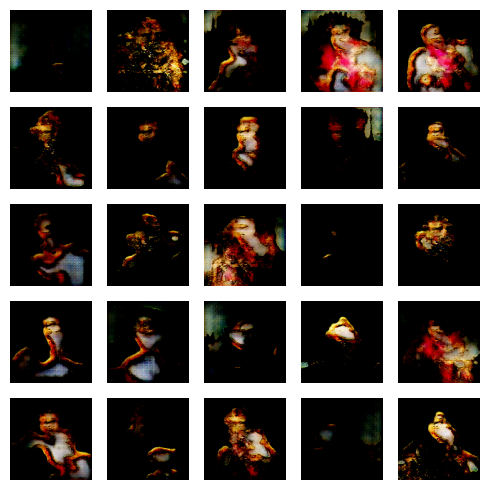

In [13]:
# Build the optimizer with the full list of trainable variables
#optimizer.build(gan.trainable_variables)

for epoch in range(epochs):
    for batch in tqdm(range(steps_per_epoch)):
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_x = generator.predict(noise)
        #print("1",fake_x.shape)
        #real_x = data[np.random.randint(0, data.shape[0], size=batch_size)]
        real_x_indices = np.random.randint(0, data.shape[0], size=batch_size)
        real_x = data[real_x_indices]
        #print("2", real_x.shape)
        #print("2",real_x.shape)

         # Reshape real_x and fake_x if needed

        real_x_reshaped = real_x.reshape((batch_size, 128, 128, 3))  # Adjust the reshape dimensions
        fake_x_reshaped = fake_x.reshape((batch_size, 128, 128, 3))  # Adjust the reshape dimensions
        # Concatenate the reshaped arrays
        x = np.concatenate((real_x_reshaped, fake_x_reshaped))
        #print("dimension",real_x.ndim)
        #print("dimension2",fake_x.ndim)
        # x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        d_loss = discriminator.train_on_batch(x, disc_y)

        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f'Epoch: {epoch + 1} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
    noise = np.random.normal(0, 1, size=(25, noise_dim))
    show_images(noise, (5, 5))

In [14]:
gan.save('gan_1.h5')
generator.save('generator_1.h5')
discriminator.save('discriminator_1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 32ms/step


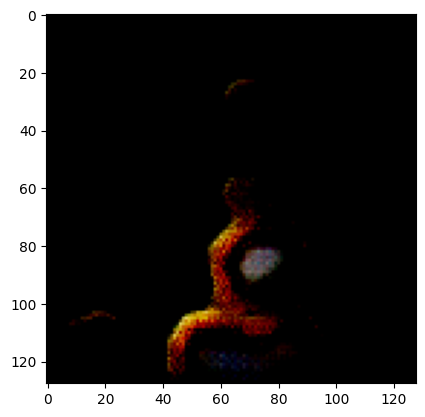

In [16]:
noise = np.random.normal(0, 1, size=(1, noise_dim))
generated_images = generator.predict(noise)
for i, image in enumerate(generated_images):
    plt.imshow(image.reshape((img_rows, img_cols, channels)))